# Conectar com Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd /content/gdrive/MyDrive/Colab/jai2021-jupyter-colab/4.Transformacao

!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab/jai2021-jupyter-colab/4.Transformacao
4.1.Integracao.ipynb  4.2.Transformacao.ipynb  4.3.Reducao.ipynb


In [2]:
# Importando os pacotes necessários
import pandas as pd

In [3]:
# Comandos auxiliares
from IPython.core.display import display, HTML
pd.set_option('display.max_columns', 6)

def display_side_by_side(dfs: list, captions: list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes(
            "style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

# Integração de Dados

---

Até agora, nós realizamos a **limpeza** do nosso conjunto de dados, garantindo a remoção de possíveis impurezas. 

Agora, a próxima etapa da *Preparação* é **combinar dados** de diferentes fontes para obter uma estrutura unificada com informações mais significativas. 

Por exemplo, imagine que você precise analisar a popularidade de uma lista de músicas. No entanto, você possui apenas uma tabela separada listando informações básicas de todas as músicas presentes nos *Charts* do Spotify, incluindo o nome e identificador das músicas e de seus artistas. 

Portanto, para obter as informações de popularidade musical, você decide coletar informações extras dos *Charts*, onde você obtém uma tabela contendo o *score* da popularidade e a data de lançamento das músicas. 

Porém, nesta tabela, a única informação de identificação da música é o seu **id**. 
Consequentemente, apesar de ter as informações que você precisava, sem o nome seria difícil dizer qual música você está analisando. 

> **O que fazer então?** 🤔

Se quisermos fazer uma análise completa sobre a popularidade das músicas coletadas, precisamos reunir os dados das duas tabelas em um único lugar. 

➡️ **Esse processo é denominado <ins>Integração de dados</ins>**

Nesta seção, nós iremos explorar um recurso essencial oferecido pelo *pandas* para realizar **integração de dados**: a função `merge()`.

## `merge()`
---

Muito utilizada quando você deseja combinar objetos de dados com base em uma ou mais **colunas-chave** de maneira semelhante a um banco de dados relacional. 

Essa função implementa três tipos de associações: 

- um-para-um (1:1)
- um-para-muitos (1:N) 
- muitos-para-muitos (N:N)

O tipo de associação realizada depende **essencialmente** da organização dos conjuntos de dados de entrada. 

Aqui, nós mostraremos exemplos simples destes três tipos de associação e discutiremos opções detalhadas mais adiante.

### EXEMPLO

Inicialmente, para exemplificar, nós iremos **integrar** informações sobre as músicas do nosso conjunto de dados a partir de diferentes tabelas. 

Para isso, nós dividimos a tabela `Tracks` em dois *DataFrames*, `df1` e `df2`.  

### `df1`
- identificador da música: `song_id`
- título da música: `song_name`
- identificador do(s) artista(s): `artist_id`
- nome do(s) artista(s): `artist_name`

### `df2`
- identificador da música: `song_id`
- popularidade da música: `popularity`
- data de lançamento: `release_date`

**ATENÇÃO** ⚠️
> Ambas as tabelas possuem a coluna `song_id` para identificar cada uma das músicas.

In [4]:
# Lendo os dados e criando os dois DataFrames
df1 = pd.read_table('../dataset/spotify_hits_dataset_complete.tsv',
    usecols=['song_id', 'song_name', 'artist_id', 'artist_name'], # seleciona campos específicos
    encoding='utf-8')
df2 = pd.read_table('../dataset/spotify_hits_dataset_complete.tsv',
    usecols=['song_id', 'popularity', 'release_date'], # seleciona campos específicos
    encoding='utf-8')

display_side_by_side([df1.head(3), df2.head(3)], ['df1', 'df2']) # imprime as 3 primeiras linhas

### Um-para-um (1:1) 

A associação **um-para-um** é talvez o tipo mais simples de fusão, muito semelhante à concatenação de colunas. 

Neste tipo de relacionamento, cada registro na primeira tabela pode ter **somente um** registro correspondente na segunda tabela, e cada registro na segunda tabela pode ter **somente um** registro correspondente na primeira tabela (como mostrado na figura a seguir).


<img src="data:@file/png;base64,iVBORw0KGgoAAAANSUhEUgAACcEAAAOjCAYAAAB5217VAAAACXBIWXMAAC4jAAAuIwF4pT92AAAAGXRFWHRTb2Z0d2FyZQBBZG9iZSBJbWFnZVJlYWR5ccllPAAAxtVJREFUeNrs3W+MJGd9J/AHyxKgi70DuksksG46G5IYZ5WdtYgMd4m2HZEQzejYyd/TnZRMmxfA5U6z47zIicui7RWLCC+C16Mkd0pO2p7opEj5A+PIO4AUxb1KJEBCzCxaGytBm54TIYHo0Cy8AO5e+J5nu8asvf+6q6q7q7o+H+lJ2aarpufX1Zl+fv2tp17z0ksvhTraXT/WjpuFOJbiaGUjZNvFAAAAALN3PY697J8Psn8epHFi82pfeQBg/hxdO98OetcAAABU234Y9qpDtn15XNs606/jL/SaOoTgdtePpeZAOwybBml73LkIAADAHEiNhn4YhuP6Jzav7ikJANTH0bXzrTDsWaeR+td61wAAAMyDKyHrW6dxbevMoOpPuLIhuN31Y6lh0AlCbwAAADTHYShu+8Tm1W3lAIDqObp2/rB3vRqs7AYAAEAzpN516lmnQFwle9eVCsFlK751sqF5AAAAQJOlW6mmZsIFK8QBwGxlK75tBME3AAAASL3rXhrXts5UpnddiRDc7vqx1DhIDYSTzhMAAAC4RVp6PoXhekoBANNzdO283jUAAADc2Y3e9bWtM71ZP5GZhuB214914qYbXDkHAAAAo0hX2F0Iw0DcgXIAwGQcXTvfCXrXAAAAMKp0u9ReGAbiZtK7nkkITvgNAAAAChGGA4AJEH4DAACAQlLvuntt68yFaf/gqYbgdtePtcOwgWDpeAAAACguXV23cWLz6rZSAEB+R9fOt8MwYH5cNQAAAKCwG73ra1tnpta7nkoIbnf92EIYNhDWvMYAAABQustxdE5sXh0oBQCM7ujaeb1rAAAAmJwbvetrW2cGk/5B9036B+yuH1uNm/SLaCIAAADAZKQV1/fiHHxDKQBgNEfXzutdAwAAwGTd6F3HOfjEe9cTWwnO6m8AAAAwE1aFA4C7yFZ/68VxSjUAAABgalLvevXa1pmDSRx8IiG43fVjS2HYRDg+o6JdiePAuQMAAMCMnZzRz70ehkG4bS8BAHzP0bXzqXed/j4uzugp6F0DAABQBbPsXacgXL/sA5cegstuf9qL48iEi5KaBXthuFx9KszAVe4AAABUUZwrt+ImjaWbttNoMpyLc+WuVwAAbgTgOmF495Jp9a4Px+Da1pmBVwAAAIAKzpVb4ZW963aYzqJnT8a58oUyD1hqCG53/Vi6f+tTE/rlUxJwOxv9E5tXXS0HAABArWUXkrXjSNtJrUizFefQHdUGoMmOrp3vxs3ZCR3+Fb3rSd3WBQAAAKY0h14Iw751GhPtXcc5dKesg5UWgttdP9aLm7VJ/MJxbLuFCwAAAPMszqvTlXadbJS9Qk1akabtgjIAmujo2vleKL93/XLw7drWGb1rAAAA5nlePcne9eUwvD1q4d51KSG4CQTg9sNwWfqeBj0AAABNE+fZnbhJq62Xuey8IBwAjTOBANzLvWsrvgEAANDAeXYnbrqh3NXhbvSui86zC4fgSg7ApQZC98Tm1Z7TBgAAgKaLc+52GDYUTpZ0SEE4ABqj5ADcjd71ta0zPZUFAADAnPt8OwwvEivrQu7CQbhCIbgSA3Bp6fgLJzavdp0mAAAAcMv8ezUMGwplXF0nCAfA3CsxAJd61yn8dkFVAQAA4Jb5dyeUtzJcoSDcfXl/aokBuGfiaAnAAQAAwO3FOfN23CzFca6Ew6Ur8/pxXr+gsgDMoxIDcFtxtATgAAAA4PayFdNL7V3n3TnXSnC768c24uapgk88XUHXyRr5AAAAwGhz8tRQ6IXiy8xvxTl5R0UBmCdH186nwNrpgodJtz7tXNs601dRAAAAGHlOXlrvOs7JO+PuNHYILrsFyycKPtnLcay69QoAAADkE+fnZXzJ/3Scm2+oJgDzILsFy8WCh0l3LunkvfUKAAAANHxunu5AknrXRVdoPxfn5t1xdhgrBJddbd6P40iRJ+nWpwAAAFBcnKd3wrChUGSe/vNWaQeg7rKrzfsF/yY+6danAAAAUMo8vRNK6F3HefrIveuRQ3C768dSUq8f8i9Zl25/unFi82rPSw0AAADlKOGCtTRfb8f5+p5qAlBH2VXm6e/YYoG/hZ1xGusAAADAPefrZfSul+J8fTDKg+8b48ApnVckANcWgAMAAIByZeG1VhxXch4iNSDM1wGos/R3rEgAri0ABwAAAOWKc+3Uu26HKfWuRwrB7a4fWw3579XqinIAAACYoDjnPgjFmgnH49y/q5IA1M3RtfOpd30q5+6HATi9awAAAJiAEoJwJ+PcvzvKA+95O9TsNqiDkG9pOgE4AAAAmJJsDt8P+VdyP2EOD0BdZLdBHYQCvWsBOAAAAJjaHL4fCvSu7zWHH2UluHQbVAE4AAAAqLibVoS7nvMQPVUEoEbS3y0BOAAAAKi4OAdPvetOyN+7vnCvB9w1BLe7fqwd8t8GdUMADgAAAKarYBAu3RZ1QxUBqLqja+fT37q8t0HtCMABAADAdN10a9Q8vet0W9TO3R5wr5Xgujmf97kTm1d7Xj4AAACYvuyitE7O3bvZbVUBoMp6Ofd78trWmW3lAwAAgOnLgnB5L8S+kN1W9bbuGILbXT/WiZuTOX7g5RObV7teNgAAAJidODdPX/Cfy7Fruq2ceT0AlZVd+b2YY9dnrm2duaCCAAAAMDtxbt6Lm6dz7Jp613cM0N1tJbhujh+Wlqtb9XIBAADA7GUXqV3Osevp3fVjLRUEoKK6OfbZD/lXSQUAAABKdG3rTAqzXcmx68adVoO7bQguWwUuz5V0nRObVw+8VAAAAFAZaY5/Pcd+XaUDoGoKrALXubZ1Ru8aAAAAqqOTY587rgZ3p5Xgujl+yDPZrVYAAACAiohz9UHOef7a7vqxBRUEoGLy/E17+trWmb7SAQAAQHXEufpe3JzLsettV4O7JQS3u34s3c503Cvp0hXlHS8PAAAAVM+JzasXQs6l5VUPgKrIuQpc6l13VQ8AAACq59rWmTRn3x9zt9uuBne7leDyNLgvuA0qAAAAVNrGlPYBgEnp5Plb5jaoAAAAMHfz/Vv2ec1LL7308r/srh9rxc3fj3nQ/RObV1teDwAAAKi2OO/fjptTY+72RJz391QPgFk6unZ+Kf0pG3O3/WtbZ1qqBwAAAJWf9/fj5uSYu/18nPdvH/7Lq1eC6+R4Hl0vBQAAANRCnpXdVpUNgAro5Ninq2wAAABQC3nm8J2b/6VoCG7f1eAAAABQD3EOP4ibZ8bc7VS2cjwAzFJnzMenVeB6ygYAAADVF+fw/bi5POZup46unV84/JeXQ3C768fScvKLYx7sgpcBAAAAaiXPXN5qcADMzNG18+nv0JExd+uqHAAAANRKnrn8y73rm1eC6+Q4UE/9AQAAoD5ObF7tx82VMXcTggNgltpjPv56HNvKBgAAAPWRrQa3P+Zutw3Btcc8yNaJzasHXgIAAACond6Yjz+5u35sQdkAmJFxw9jb17bO6F0DAABA/Yx7J5NTh/9wIwS3u36sFTfHxzyIK+kAAACgnno59mkrGwDTdnTtfCtuFsfc7YLKAQAAQC2NnUc7una+nbaHK8G1x9z/+onNq0JwAAAAUEPZyu7PjLlbW+UAmIFx//7sX9s6s6dsAAAAUD9xTj+Imytj7tZO/ydvCE4ADgAAAOpt3Ll9W8kAmIFx//7oXQMAAEC99cZ8fDv9n8MQ3NKYO2skAAAAQL31x3z8cSUDYAbaE/77BgAAAFTLuHP7k+n/HIbgjk/4hwEAAAAVcmLz6iBu9sfZZ3f9WFvlAJiyxXEefG3rjAu4AQAAoMbi3H4vjNm7Prp2fum+3fVj464Cd+XE5tUDJQcAAIDa64/5+CUlA2Bajq6db4+5yxVVAwAAgLmwN+bjl9JKcK0J/xAAAACgmsad4y8oGQBTNG74uq9kAAAAMBfG7V23Ughu3EbCQJ0BAABgLozbSGgrGQBTNG742gXcAAAAMB/6Yz4+10pwfXUGAACA+juxedUcH4AqcwE3AAAANNO4c/yFPCG4gToDAABAI51UAgCmyEpwAAAA0EDXts4Mxtzlxu1Qx3Ji8+pAqQEAAGBuXFYCACpqrBDcta0zB0oGAAAAc+PKGI9dzLMSHAAAAAAATNrxMR67r1wAAAAwV8a62C2F4BbHePwV9QUAAIC5MlYjYXf92JKSAVBBAyUAAACA5hr3dqiWkwcAAID5sjfm4xeUDAAAAACAKrlPCQAAAAAAAAAAAKiQ/jgPFoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtoTgAAAAAAAAAAAAqC0hOAAAAAAAAAAAAGpLCA4AAAAAAAAAAIDaEoIDAAAAAAAAAACgtu5XAgAgr+XllVbcLN00FuJI/21xjMPsxzHI/nkvjoPD7c7Opb4qAwAAAAAwDr1rAGgeITgAmjwJ7sbN2Ry7nosT3G6DGwftOFaz7ZESDrsYvtd4OPmqn5c218OwsdAPw4bDXqz/njMYAAAAAJhHete5atYKetcA0GhCcADAXcXJfLpCLjUONuI4PoOnkJoVJ8P3mgyXw7CJAQAAAABAQ+ldAwA3E4IDAG4rayBsZOOIigAAAAAAMGt61wDA7QjBAQC3WF5eSc2DbtBAAAAAAACgIvSuAYA7EYIDAF62vLyyFDe9MJul4wEAAAAA4BZ61wDAvdynBABAsry80ombftBEAAAAAACgIvSuAYBRWAkOADhsIlxUCQAAAAAAqkLvGgAYlRAcADScJgIAAAAAAFWjd116PVtxs3TTWMi2R0bY/UocB3HsHY6dnUt7qgpAlQjBAUCzJ72doIkw7ZqnxsJGNo6MufvjOzuX+qoIAAAAAMwzvetSaph60e04VrPtYoHDHd6K9uRNx78eN9tp7Oxc2lZxAGZNCA4AmjsBTld4aSJMr95Fwm8AAAAAAI2gd124fu246YRh+G2Sveh07LU0bgrEdXd2Lg28CgDMghAcADRzEryQTUiZTr27QfgNAGimVjYOb7VzeLsdmmGQjaQfvnf7JAAAuC2960K168RNNxRb8S2vmwNxW0EYDoAZEIIDgGaa1ET4Svjel1v9ER5/85egh1+MtmY0SS/djJsOAADTdnirnXb22e6kkjTezefA2VfNG/ayOUMaA6UCACDTDXrXY8lWfutV6LkdhuGeDsMw3IHTGoBpEIIDgIaJE880UT9dcvPgQhzbOSez23d5nmmkCfxhw2GpJjXuBOE3AKAZ0uez1WwcVw5GdDwba9m/72fzgl6wUhwAQGPpXeeqV/oMXdULkNJr2YnPczXWv+8MB2DShOAAoHm6JR0nNRA2JjV5zZZKT6M2k2PhNwCgIdKXPOlzz4bPPZQknUens3EYiLsQrBAHANA03ZKOM/e96+XllVSrszV4TdNtUp+Lz/dcrFvXKQ7AJAnBAUCDZFeGrZVwKBPWV9a1E4TfAID5l1Y22Cjp8yTcyc2BuMvZ5+y+sgAAzDe965HrlOZlvVC/lbjPptc4vjYdZzsAk3KfEgBAo2wU3P96HE8IwA3FSXs7jkH8x4tBAA4AmF/tMAwh7QYBOKYr3dbpuez8aysHAMBc07u+h+xi7PTZ+HhNf4W1+Dv0nOoATIoQHAA0S6fg/mkJ+cZPUrPwWz8Mv5ATfgMA5lUrDG9LmT7znFQOZkgYDgBg/nUK7j/XvessPJYuxj5S819FEA6AiXE7VABoiDixXC04QT7X9ABcCr+F4e2YfAkMAMyzhTBcheGsUlAxh2G4rewcPVASAID607u+a23S/Gw7zFdPOgXhBu44A0DZrAQHAM3RLrDvfpMnpK9a+U0ADgCY98+Me0EAjmpLt+UdxLGqFAAAczMPyWtue9dZAK4f5rMnfTa76BwASmMlOABojiITym4TC2blNwCgYS7EcVoZqIm0Usgn4ngmDG+dZVU4AID6ahfYtzuPBbkpAHd8AoffD8OLnw7HnT5LL2UjvT6LE3gevfh7Lu3sXPJZHoBSCMEBQANkE+a8k+X9pt0GNdarFYZfAp9y9gAADZA++2yHyXy5ApOWPrOnL+5Wsy0AADWid31H/ZLnaCn4lmq1HWu2N8ZzOHyd0rxxIwwvQDlS0nNKwbpudlwAKEwIDgCaYanAvheaUqRsIp8m3WtOGQCgIdphGIA7ohTUWPrybDeOJ8Lwiz0AAOpD7/r2+qGcENzlVKednUvbRQ4S9x/Ezcby8ko3DENrZ0v6PU/HY17Ijg8AhdynBADQCO2Ck+25lsJvcfTiP/59EIADAJqjE8dzQQCO+XExCMEBANRNu8C+/Xktys7OpRQ0e6bAIa7H8UQ8TrtoAO5Vz+sgjm78xxNhuLpcGbreBgCUQQgOAJqhlXeiPMbS6LUj/AYANFhaMeGiMjCH0uf6njIAANRGK+d+c927znTiuJJjv6dTXSd5q9is9ks5n98tn+Gzu7QAQCFCcADQDHknkHPZRIgT6oUZhN/SVXGXnYoAQAWkz0GnlYE5dhiEW1AKAIDKa+Xcb94DcDdWXQvDINz1EXdJj3s8rSKX7TuN59cO5awIt+GtAEBR9ysBADRC3i9/+nNaj1aYbvitm666W15e6cZ/Pul0BABmqDeNz0Hf+ua3wh/3LoZP9/vh29/57l0f+5bFxbD533/fKzOHZnwerGXzoFWvBABApeld30VacW15eSV9pn3uHg9NK7K1pxF+e9XzO8ie327BQ6VjCMIBUIiV4ACgGY4rwSsm5nuhnGXa7yaF356IP2uiy84DAIwh3QJ1ogG4FHr6g83N0Omshe1PffqewSfmU4XOg1PBrVEBAKpO7/oednYu9ePmibs8ZCs+ZmnaAbibnl/qt58reJjF5eWVtlcbgCKsBAcA3M08LymfvgS+OIHjpiXnL8SJf9fpAwBUSCdM8Bao46z4xfyq6HmwdtN7AACA+bHXpF82u9NIO9x6YdO5KvSi03OIzy995l4scJi0GlzfqQ1AXkJwAMDdHMzrL5Y1DVIQ7khJh7wRfgvDANyBUwcAqJB2mEz4X/iNupwH6YvCfrAqHADAPGlcD3Zn51JneXmlFf/xZPafnqjYXUi6Beeebac1AEUIwQEATZZCa2cLHkP4DQCoslYc22UfVPiNGp4H6cu4QbCyBAAA9Xa4WtqFigXgQjb3LHLhuVvjAlCIEBwA0GS9UCwEtxXHhvAbAFBh6UuIsla+FX6j7udBej+0QgNXDQEAYD5kveilqj635eWV9Jl7Le8x0i1f43H6XmkA8hCCA6CS4kRnIZvItcPwS4rDsTjiIa6E4Rcbg2zspREnTwPV5aZJ+SCea1s5JuVpn67zCQCouHQFfilX0gu/MSfnQQqEbge3WQIACtC7hrsqFILL3ksAkIsQHACVsby8kpbxTqMdRm8Y3Mnhl30nX/Uz0q0r+9kwmSLpjTEpF34DAOoifaY+XfQgwm/M4XmQ5ogbYRgSBQAYid41jKxfcH/nPgC5CcEBMFM3NQ/WpvQj05X/p7IBaTW4fjwP09WXd1sl5XIYht/6KgYA1EBamaJX5ADCb8z5edANwxUqBl5lAOBO9K5hfNktUfdD/rBoSxUByEsIDoCZiJOgThh+8bCoGlRAWgXi4m3+u/AbAFBHG3k/Zwu/0ZDz4Eg2B1j1agMAr6Z3DYUNghAcADMgBAfAVGUNhPRlwxHVoEK2X3VeCr8BAHXViuPsuDuVGXp60w98f/iXb3hj+OKLL3o1aqZh50FaYaUdit+uCQCYE3rXUJq98Krb/QLANAjBATAVy8sr7TBsIBxXDaomW6K9F4YrQaTwW09VAICa6o7z4DJDT69/3WvDL/67d4f/+EQn/MHmphBcjTT4PEif+1vOAABoNr1rKN2BEgAwC0JwAEzc8vJKaiCcVgmqbGfnUrpt2IZKAAA11o5jbZwd/uErXwnbn/p04R/8jkcfDRu/+ZvhgQcf8CrUUIPPg3SLpk4YhuEAgAbSuwYAmB9CcABMzPLySisMbzPpCjoAAJi87rg7PPzIW2/ctvKrX/t6rh/4xiMPho3TG+Ftb39M9Wus4edBet/0nAUA0Cx61wAA8+c+JQBgEpaXV5biZi9oIgAAwDS04jiZZ8d3L6+MvU+65eXqz70r/K8//mMBuDnR4PPgcDU4AKAh9K4BAOaTEBwApVteXunEzW4cR1QDAACmopt3x8ff9a4bYaZR/fjDD4fNzc3w3vV1VZ8jDT8POs4AAGgGvWsAgPnldqgAlCprIlxUCQAAmJqFONby7vzAgw+Ef/sTPxH+8q//5q6Pc+vT0X3+s58Ln3z22bD3wvPh29/57itq+KM/9Jbwnve/L7z5oYcq9Zwbfh6kVRQPV4QBAOaU3jVMdY6aV1/5AMhLCA6A0iwvr7TDZJoIV7KJz8EIE6D2TdtWGN7aBgAA5lmn6AH+/a/+6l3DT+mWl/+h88SNoBR39q1vfiv84e/97h1r+Y3r3wyf+cIXwmfe+74bNa3aKmoNPw82ghXhAGBu6V3DVC0pAQCzIAQHQCmWl1fSpGa7xEM+kx1ve2fn0sEY+/Vf9bzSFUftOFaz7WLF6pae78kKv7TPxedYlefyeDwX+t5tAAC36BQ9QFqV7C2Li+HL+/uv+O/pv/3X3/pvlVu1rIpSAO7J0+vhq1/7+kiP3/7Up8PXvv7P4YPnP1SZ36Hh58GqsxgA5pPede66peerdz0avetXahXY1+rMAOQmBAdAGZPhhWzSf6SEw23F0Y0TxkEZzy1rQmxn47Dhka7wXy3p+QIAwCy14jhexoHe+dM/Hb58cbg4xutf99rwX97/n8LjP/szKjyiD3e7IwfgDqVV4T72kY+E3/jAByrzezT4PDiSzRO3nc0AMD/0rmEmigQ6B8oHQF73KQEAJeiF4lepXY7jB+PEv1NWE+F24rH30s8Iwy8Lt7x0AADUXGmrV737l3/pRujpnT/1k6HX2xKAG8Nf/OmfhS+++GKufdPtRz//2c9V5ndp+HlgNTgAmD+9oHcNU5Pdejiv6+l9oIoA5GUlOACKTmjSlwSnCh7myTixuTDN552usovPfeAVBACg5jplHuzPP/5xFc3hTz7+54X2/6OtrfC2tz9Wmd+nweeBEBwAzBG9a5iJdoF9BeAAKMRKcADkli0l3ytwiOtxPD7tJgIAAMyJ9Hn8uDLM1osvfCl84/o3Cx3jy/v74R++8hXFnL1027ElZQCA+tO7hpkpcmHJtvIBUIQQHABFdMPwS4I8UhOhvbNzqa+MAACQS1sJZu9vn3++nOO88CXFrAarwQHAfOgGvWuYquXllVYodqGWEBwAhQjBAVBkMnO6wCFWd3YuWdoaAADys2JVBfzTP361lOP83YtCcN5XAEAZ9K5hZroF9r0S33cDJQSgCCE4AGYxmXnSVXQAAFBYWwnA+woAuEW3wL5615BDdgviIqsq91QRgKKE4ADIM5lpxc1azt0v7+xcuqCKAABQmBWrKuD7HniwlOP88MNvVcxqSLdNW1AGAKgnvWuYmY2Q/xbESU8JAShKCA6APLoF9u0oHwAAFJZCOkeUYfYefeyxUo7zI48IwVWIgCkA1Fe3wL4d5YPxZeHTswUOsbWzc+lAJQEoSggOgHEnM0WWtE4TmYEqAgBAYUI6FfHwI28NbzxSbDW4tywuhjc/9JBien8BAAXoXcPMFF1BsauEAJRBCA6AcaUmQt4VJ0xkAACgHC0lqI5f+YVfLLT/r62tKWK1uB0qANST3jVM2fLySnrfnSpwCAFUAEpzvxIAMKZOzv2eMZG5VaxJe0oT0Zdy7vp4fI59rxQAQOW0lKA63v3LvxT+8q/+Knx5f3/sfd/x6KPhbW9/TBGrxUpwAFBPnZz76V3fht41I7x26eKRXsHDdFUSgLJYCQ6AcSY0rbg5mXP3ngoCAADz6sMf/Wh40w98/1j7pMd/8PyHFK96rAQHADWjdw0zkd47RwrsbxU4AEolBAfAONo597seJzLbygcAAKVpKUG1PPDgA+GppzfDjz/88EiPf+dP/WT4nxcvKhwAQDnaOffTu4YclpdXNkKx26Bej2NDJQEok9uhAjCO1Zz7aSIAAEC5WkpQPSkI99sf+53w+c9+Lnzy2WfD3gvPh29/57sv/++vf91rw9IjPxbe8/73hTc/9JCCAQCUR+8apmR5eWUpbp4qeJjuzs6lA9UEoExCcACMo51zv77SAQAATfG2tz92YwAAMDXtnPv1lQ5Gt7y8slDC++byzs6lC6oJQNncDhWAUSc26cqeIzl376sgAAAAAABl07uGqb3XDgNwRwocJt0GtaOaAEyCEBwAo1rKO6HZ2bk0UD4AAAAAACZA7xqmI63edrzgMTredwBMihAcAKPK20jYUzoAAAAAACZE7xombHl5pRc3awUPs7Wzc2lbNQGYlPuVAIARaSQAABA+/vU3dX5reaWtErP1P37/91v/urWoEDAB/3uw33r/r/96VyUq4F+9Qw0AGIXeNUzQ8vJKJxQPwF2JY0M1AZgkITgARtXKud+B0gEAzI//8//uW1OF2fvnr30tCMHBxN5f6c11ViUAoDZaOffTu4Z7yAJwFwse5nocqzs7l7znAJgot0MFYFR5v2HrKx0AAAAAABOidw0TUFIALkkBuIGKAjBpQnAAjDLRaakCAAAAAABVoncNE3tvpdsMlxGAe2Jn51JfRQGYBiE4AEbRKrCv5a0BAAAAAJiEVoF99a7hNrIAXL+EQ23t7FzqqSgA0yIEB8BExQnOnioAAAAAAFAletdwq5sCcEcKHioF4DoqCsA0CcEBMIoFJQAAAAAAoGL0rqEkJQbgLgvAATALQnAAjGJJCQAAAAAAqBi9ayhBiQG4K3GsqigAsyAEBwAAAAAAAAANVHIArr2zc+lAVQGYBSE4AAAAAAAAAGgYATgA5okQHAAAAAAAAAA0SIkBuOtBAA6AChCCAwAAAAAAAICGEIADYB7drwQAAADAqH7sX/zfJwfffv2eSszWD/3ID1+Im+MqARN5f6VbOW2oRCU8pwQAAOWaQABOjwCAShCCAwAAAEb2bxa+vvef/+hqXyVmzlX2MCELb3jDwc7OJf9/rgKOrp1XBACAEgnAATDP3A4VgFEMCkyoWsoHAAAAAMAEDPLuqHdN0wjAATDvhOAAGMWgwL4t5QMAAAAAYAIGBfZtKR9NIQAHQBMIwQEAAAAAAADAHBKAA6AphOAAmLSWEgAAAAAAUDEtJWDelRiAu5LeMwJwAFSZEBwA9xQnNf0Cu7dUEAAASjdQAgAAmk7vGu6s5ABcWgHuQFUBqDIhOAAmrVXh59b28gAAUFMDJQAAgEJaFX5ubS8PRQjAAdBE9ysBAGNMdI7n2K9V0QngRtyc9LICAABl+/xnPxc++eyzYe+F58O3v/Pdl//7G488GH70h94S3vP+94U3P/SQQlWXL/gAoF70ruGV55AAHACNJAQHwKjyTnIqN1nPJoBPeUkBAKixgRJUz7e++a3wh7/3u+Ev//pvbvu/f+P6N8NnvvCF8Jn3vi+s/ty7wnvX1xWtmvaUAABqRe8aXnkO9YMAHAAN5HaoAIyqX3DSVZUJ4ELcbHs5AQCouYESVEsKwD15ev2OAbhX2/7Up8OHznxQ4arJF30AUC/9vDvqXTNPBOAAaDohOABGNSiwb7tCv0cvjkUvJwAANWelqor5cLcbvvq1r4+1T1oV7mMf+YjieX8BAMUMCuzbrtDv0Qt61+QkAAcAQnAAjG5QYN92RSaB3bg55aUEAGAOpC8kritDNfzFn/5Z+OKLL+baN60c9/nPfk4Rq0UIDgDqZVBg33YVfgG9awqePwJwABCE4AAYUZz09Avs3q7AJHA1bs56JQEAmCOCOhXxJx//80L7/9HWliJWRwqX+tIPAGpE75omKzEAlyYlAnAA1JoQHADjuJxzvyPZRH6Wk8Celw8AgDnTV4LZe/GFL4VvXP9moWN8eX8//MNXvqKY3lcAQH561zROmQG4nZ1LHQE4AOpOCA6AcfQL7DuTRkKcBC6UNAkEAICqsRJcBfzt88+Xc5wXvqSY9Z/3AgD1/Buud03tlB2AU1EA5sH9SgDAGNKEKu+y7GtxUrYxzSuJNBEAAGjA5/MyPz/P5JdIq6AV/dmrP/eu8N719Zk8/3/6x6+Wcpy/e/FL4fGf/ZmZn1TOAyE4AKjxZ2O9axpBAA4Abs9KcACMLE6G0qTqeoFDbExxEnjYRDjulQMAYE6lL+kuKwOUJs13rbAIADWkd01TCMABwJ0JwQEwru0C+27ECVprCpNATQQAAHw+Zyq+74EHSznODz/8VsX0fgIAZve3XO+ayhOAA4C7E4IDYFxFGglpYnZhwpNATQQAAHw+Z2oefeyxUo7zI48IwXk/AQAz/Fuud02lCcABwL0JwQEwljg5So2EIsvKn4qTtYksLZ9NAtOtazQRAABoikEcV5Rhdh5+5K3hjUeKrQb3lsXF8OaHHlLM2UrzXCE4AKgxvWvmlQAcAIxGCA6APIpeEfdUNmkrcxK4mk0CF708AAA0TE8JZutXfuEXC+3/a2trijh7AnAAMB/0rpkrAnAAMDohOADy6JVwjH6cvLVLmAAuxJEaG5/IMQlMVwVueTkBAJiDz+fXlWF23v3Lv3RjNbc83vHoo+Ftb39MEWfvghIAwNx8Ni5K75pKKDEA94QAHABNIAQHwNjiZGlQwgQ8Tdqei5O4boEJYLqCLi0hfzrnIdLS9gOvKAAANXcQrGI1cx/+6EfDm37g+8faJz3+g+c/pHizdzmbWwIANad3zbwoOQDXU1EAmuB+JQAgp9QAKOOePWezhkA3TsRG+uIuPr4TN2mcLPBz09LfvSKNDOZHPA9eqslTTc23SR37XHxPeD8AgM/n5PTAgw+Ep57eDB/udsMXX3zxno9/50/9ZPiND3xA4aqhpwQA4LPxbehdMxMlBuCSi/F4F+egLI/H90Xf2QHA3QjBAZBLuqIuTpyeDvmvZLvZ8Tg+EY+3n03s0hi86jGtONpxrJYw8bti6W8AAOZM+vz8TBynCnzGV8WCUhDutz/2O+Hzn/1c+OSzz4a9F54P3/7Od1/+31//uteGpUd+LLzn/e8Lb37ooarO9Zr2sqV5aM/ZCwDzQ++aOVDGuQQAjSMEB0AR3TC8qq2sydhiGF6hN8kVLK6EYUMCAADm8fP5KWWYvbe9/bEbg9q8bwCA+fwb3wl61wAAjXGfEgCQ187OpYMwbCTUxfX0fLPnfajvlQQAYE7sxbGlDDCy9EVzTxkAYP7oXQMANI8QHACFxEn5dtw8XYOnmpoI7fh897xqAADMsa4SwMg2lAAA5pfeNQBAswjBAVBYnJynLw6uVPgpaiIAANAUgzjOKQPc0zPB6ioAMPf0rgEAmkMIDoCytEM1mwnpOWkiAADQJN049pUB7ih92WwVOABojnbQuwYAmHtCcACUIk7UD0L1mgmXgyYCAADN1FECuKNuGK6aCAA0gN41AEAzCMEBUJqKNRPOxefTzp4TAAA0TT+Op5UBbpFug3pBGQCgWfSuAQDmnxAcAKVKE/c4lsLsvnBLTYzH43PoejUAAGi4jVDN2z7BrKTboHaUAQCaSe8aAGC+CcEBMBFxIp++cHs8jv0p/cj0ZUa6gm4pjr5XAAAAbljNPisDw9VfrLgCAA2ndw0AMJ+E4ACYmDShj6OVJvhhcl+8Xc+O38pzBZ2mAwAAc24QhkE4aLon4thTBgAg0bsGAJg/9ysBAJOWTfC7y8srnTD8Au5UCYd9Jo7teOyeCgMAwF31wzAAdFEpaKitOMwdAYBb6F0DAMwPITgApiab9PeWl1cWwvA2NGksZePIXXa9Eoa3rOmnUfYVcPF4r2lA7V/jDFQfAKDR0mfxVhxnlYKGSQG4jjIAAHejdz3T2uvN3lqTbtx0VQIAxiMEB8AsJnCpKbCdDQAAYDq6YRiEW1MKGkIADgAYi941AEB93acEAAAAAI3RCcNgEMw7ATgAAACABhGCAwAAAGiWThznlIE5JgAHAAAA0DBCcAAAAADN043jCWVgDj0dBOAAAAAAGkcIDgAAAKCZenE8Hsd1pWBOpGDnhjIAAAAANI8QHAAAAEBz9eNYiuOKUlBj+3GcCMNgJwAAAAANJAQHAAAA0GyDMAzCPa0U1NAz2fm7pxQAAAAAzSUEBwAAAECSbiOZbo+6rxTUQLqN78/HsRrHgXIAAAAANJsQHAAAAACH+mG4qtY5paDCtuJoxbGtFAAAAAAkQnAAAAAA3CytqtWN4wfD8FaTUBWXw3C1wk6w+hsAAAAANxGCAwAAAOB2BmF4q8kUOrqsHMzQYfitHYarFQIAAADAKwjBAQAAAHA3/TAMH6WV4baUgylKKxEKvwEAAABwT0JwAAAAAIxiEIa3oXxDHE/GcUVJmID9OM6FYegyrUTYVxIAAAAA7uV+JQAAAABgDAdxXMhGKwyDSp04jisNOaXg23YcvTj2lAMAAACAcQnBAQAAAJDXIHwvELcQhretTGMpjpPKwx2kVQT7YRh462fnEQAAAADkJgQHAAAAQBnSCnHb2TjUykYKxS1k/62tVI2xl50XST/7Zyu9AQAAAFA6ITgAAAAAJmWQjb5SAAAAAACTcp8SAAAAAAAAAAAAUFdCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAAAC1JQQHAAAAAAAAAABAbQnBAQAAAAAAAAAAUFtCcAAAAAAAAAAAANSWEBwAAAAAAAAAwP9n7352G8n6/rDX0xk7gGG4OwnexAsH4qulI0DSFTQHCBCgG0jruQJyLsBqzToCmg1oPxrtg6bWXjzqRWs71A1EUiIEXumlVgmysQTYhgHbmJzTOpzRTKtbPEVWsYr8fICa0sxU8c+pYonnq985BUBrKYIDAAAAAAAAAACgtRTBAQAAAAAAAAAA0FqK4AAAAAAAAAAAAGgtRXAAAAAAAAAAAAC0liI4AAAAAAAAAAAAWksRHAAAAAAAAAAAAE3Szdk4twjuhfYFAACApbKVuf2tJgMAAAAAoEliEdxNxvabmgwAAACWStaAt+2jqwtNBkADdTQBAAAArK5YBDfWDAAAAAAANMxlxrZrmgsAAACWStYA7tzboRbnuxsdbQwAAABL46UmAKChsm7Bvd47eKHJAAAAYGnk3LH0psxMcB1tDAAAACvpTBMAUKPbzO23NBkAAAC033rvoJO5y7hMEVxXUwMAAED7ne9u6OMD0GQXmdsrggMAAIDl0Mnc/jYWwV1U/CQAAABAM+UWC4w0GQA1Gmdu39FkAAAAsBS6mdtflJkJzmg6AAAAWA65ffxbTQZAjcaZ23c1GQAAACyF3Ox6/Gz76Cp3JrjN892NF9oaAAAAWq+buf2FJgOgLtfH+6PMXTbXeweyawAAAGi/bub2n2eCiy4rfiIAAACgQc53NzphtZazz/bR1UjLAVCzm8ztu5oMAAAA2mu9dxBngXues8/18f5vRXCjzOfb0eQAAADQat3M7S81GQALMKr49xsAAADQLLl9+7P4j0kRXO7tTBTBAQAAQLvl9u1HmgyABcj9/SO7BgAAgHbrZ24/iv8oOxPc8/PdDWECAAAAtFDo078IqzeZu420HAALkPv7Zy3dNgUAAABomdCn74TVZuZuo/iPz0Vw20dX4yL/tiaK4AAAAKCd+iX2GWk2AOp2fbw/DqubzN32tBwAAAC0UnY92vXx/iiunz34b6PMx+ilkeMAAABAu+QWB3zcPrq61WwALMhJ5vY7670D2TUAAAC0T3Z2PfnhYRHcsIYnBgAAABbofHejG1ZrmbuNtBwAC5RbBPe8cCcTAAAAaJX13kHsy+dm179lBr8VwW0fXV0U+dPK9x0CAAAAaJVBiX1ONBsAi5Jua5KbXQ+0HAAAALRKmcnYviyCS4aZD7R2vrvRdwwAAACg+UIfvhNWLzN3i7dCHWs9ABYstyB7bb130NdsAAAA0HyhD98tSmTX18f7t5N/mbUILho4FAAAANAKZfr9ZoEDoAkOS+wz0GwAAADQCmX68MOH//KHIrg0svss8wHjbHADxwIAAACaK/Tdu0X+SLq77aOrodYDYNGuj/fHRYnser13sKf1AAAAoLlKzgJ3c328/4cB3M8e2ajMiLq9892NFw4LAAAANNZhTfsAQFWGJfYZrPcOZNcAAACwXP39L/b5oghu++gqVsndZD7w85IvCAAAAKjY+e5GnAVns8SuiuAAaIzr4/1hUS679vsMAAAAGmi9dzAIq7XM3e4e6+s/+8rGgxKv68357saOwwMAAADNEfrqnZL9/OPto6tbLQhAw5T5ndZLt1YBAAAAGiL01bfC6l2JXQ+vj/e/yK4fLYLbProaFvkj6qKh26ICAABAo8QZ35+X2G+g6QBompKzwUVDt0UFAACARhmW2OfRWeCiZ9/YaVDiiWKofuIYAQAAwOKd727Evn2Z26C+3z66GmtBABpqUGKfeGuVoaYDAACAxVvvHcRCtjLZ9aOzwEVfLYJLs8GdlXiylylkBwAAABYk9M13inJTyX91JB0ANEGaDe6yxK5v1nsHe1oQAAAAFif0zfth9bbErt/Mrp89sfOg5Ot9d7670XfYAAAAoH6hT75VlJ/tZrB9dHWrFQFouLLFbD+t9w52NB8AAADUL/TJY3ZddhD23tdmgYv+8uuvv35z7/PdjfjEb0s++fb20dWFQwgAAAD1CP34F2E1DsvzErtfhn78llYEoA3WewcnYfWmxK5x5Hj3+nhfdg0AAAD19eNj9jwqymXXZ6Ef3/3WBs+meJBBCgXKGKXR5wAAAEDFUgHcqCgXIkR9rQhAi8TfW2Wy6/h7cpTCdwAAAKBioQ8es+thUT67fnJG+CeL4NItUPolX8DnMEEhHAAAAFTrQQHcZsmHeG82dwDaJN0CpV9yd4VwAAAAUINUADcqZsiup5nN/cnboU7MeFvUz9PLC9MBAABg/kKfvRNW8ZZwZUMEt0EFoLVmuC1q5NaoAAAAUF2fPebOsd++VvIhnrwN6sSzjAcdhOWy5AuKo+rOz3c3+g4vAAAAzE+afT3+4b5sAVz84/+OlgSgxfphuSm572RGuL5mBAAAgPlJBXCjonwB3F2RMQP81EVwD26LejfD+/twvrsxcJgBAABgdmmw2ai4/wN+Wf3Q5x9rTQDaKt0WNRZ0l82u4+/RD+u9g4HWBAAAgNmlwWbnxWzZ9U7o84+n3Xjq26FOnO9uxDDhbzO+17P4QlNhHQAAAJAp9M8Pw+rtjA/zPvTNB1oTgGWQAvYPMz7Mx7D0U2EdAAAAkNc3fxFWMbvuzfhQP4a++WHODtlFcNH57sZeWP0044v9PGXd9tHViVMAAAAApu6Txynkh0X5259OHIc+eV+LArBM0mxu72Z8mM+3Cr8+3h9pUQAAAJi6Tx6z61gHtjbjQx2HPnk/d6dSRXDR+e7GsJi9ai/6PLLOrHAAAADwzX54HEEXB6W9m8PDXYalqy8OwDJa7x0Mi/lk18fxd69Z4QAAAOCb/fCYXQ+K2e9cEp2Ffni3zI7Pyj5jGi1+PIcX/yYs4/PdjYHTAgAAAL4U+syxD35RKIADgCel0eLzyK5jId14vXewp1UBAADgS6HPHPvgMbueRwFczK53yu5ceia4iTnOCBfdhGWwfXQ1dJoAAACw6kKfu1vcj6B7OaeHVAAHwMqY44xw0efs+vp4f6hlAQAA0Of+XPw2KGa/9enE5+x6ltnYZy6Ci+ZcCBfFQCE+5qFgHgAAgFWTZn4bFPMLECIFcACsnDkXwkUxuz4My9BtUgEAAFixPna87WmcqW1QVJBdz9rPnksRXFRBIdxEnLb+ZPvo6sTpBAAAwLIK/eqtsOqn5fmcH14BHAArq4JCuInP2fX18b7sGgAAgGXuV8fseq+4L4Cbd3b9MSz9eQw0m1sRXHS+uxHf8E8VteldWGKYMCrui+IE9wAAALRW6EPHUXPdtMTwYK2ipzoOfei+Fgdgla33DgZh9a6ih59k15/zazPEAQAA0PI+dG3ZdehD9+f1YHMtgovOdzfimx8W86/8+7M47fwoLOO0vt0+urpwKgIAANA0oa/cCau4bKV1NyybNTz1j6GvfOgIAMDnEL9f3N/KtOrsOs7AGrPqcZGy6+vjfdk1AAAATewrd4rfs+vJUkt2HfrKc82u514EF6VbuAxrapTHxAK5sVMVAACABXqxwH5xnJFmZ/voauQwAMDv0i1choXsGgAAgNW18Oz6+nh/NO8HrqQILkq3dRmE5a1zBwAAAGpzVtwXwLkVGwA8It3WJY4272kNAAAAqM3n7Pr6eL+S7LqyIriJGm+PCgAAAKssjqAbuP0pAExnvXcguwYAAIDqfc6u53370z+rvAguMiscAAAAVCqOoOtvH12NNQUATM+scAAAAFCpz9n19fH+uOonqqUIbuJ8d6Nb3BfDvXSMAQAAYGY3YdnbPro60RQAUN5676Bb3BfDbWoNAAAAmNnn7Pr6eL+27LrWIriJ892NfnFfDLfmmAMAAEC2OH384fbR1UBTAMD8rPcO+oXsGgAAAMqK2XUsfhvW/cQLKYKbUAwHAAAAWT4XvxX3BXC3mgMAqqEYDgAAALLEmd9idj28Pt5fSHa90CK4iXSb1L2wvHFOAAAAwBcui/vCt6GmAID6rPcOdor77Pql1gAAAIAvfM6uFzHz2581oghu4nx3oxNW/bQYYQcAAMAqi7O+DeOyfXR1oTkAYHHWewed4r4YLhbFya4BAABYZXHWt5Pifta3xmTXjSqCe+h8d2OruC+G64Zl0/kDAADACpiEB6Pto6sTzQEAzbPeO5BdAwAAsGom2fXJ9fH+qIkvsLFFcA+d7268KO5H2MVwoVsIFgAAAFgOcar4OFJuVNwXvo01CQC0R5ohrlvIrgEAAFguf8iur4/3x01/wa0ogntMmimuU9yHCy/Sukg/CxoAAABogjg6bhIOjB8u20dXI80DAMsnzRTXKWTXAAAANFcscrtNP48fLk2d6e0prS2CAwAAAAAAAAAAgGeaAAAAAAAAAAAAgLZSBAcAAAAAAAAAAEBrKYIDAAAAAAAAAACgtRTBAQAAAAAAAAAA0FqK4AAAAAAAAAAAAGgtRXAAAAAAAAAAAAC0liI4AAAAAAAAAAAAWksRHAAAAAAAAAAAAK2lCA4AAAAAAAAAAIDWUgQHAAAAAAAAAABAaymCAwAAAAAAAAAAoLUUwQEAAAAAAAAAANBaiuAAAAAAAAAAAABoLUVwAAAAAAAAAAAAtJYiOAAAAAAAAAAAAFpLERwAAAAAAAAAAACtpQgOAAAAAAAAAACA1lIEBwAAAAAAAAAAQGspggMAAAAAAAAAAKC1FMEBAAAAAAAAAADQWorgAAAAAAAAAAAAaC1FcAAAAAAAAAAAALSWIjgAAAAAAAAAAABa67tlfFPnuxtdhxYAAIAGuNg+urrVDABAtN476GoFAAAAGuDi+nh/qbLrv/z666+te9GpyG0rLJ20fhGWTecnAAAADXYTlvGDZVQokgOApbHeO4g59VYhuwYAAKBdJtn1RVhiXj0qWlgk1/giuPPdjRgSdB8sAgMAAACWSQwYRpNl++hqrEkAoPlS0Vs3LDvFfcGb7BoAAIBl8ofs+vp4f9zkF9vIIrjz3Y1OcR8cxOWlcwoAAIAVclnchwrD7aOrC80BAM2x3jvoFPe5db9Q9AYAAMBqidn1MCwnTSyIa1QR3PnuRr+4Dw8UvgEAAMDvocLQbVMBYDHSjG+TwjfZNQAAANxn14fFfUFcI7LrhRfBpVnf+mHZC8tz5wgAAAA86jgsA7dLBYB6pFnfYm7dL2TXAAAA8Ji7sJyEZbDo2eEWVgSXit8GYek5HwAAAGBqZ8V9MdxIUwDA/KXit0EhuwYAAIAcnwdyL6oYrvYiuPPdjTh1/CAsbx17AAAAKO1jWPbMDAcA85Fuexpv5aL4DQAAAMpbSDFcrUVw57sbcer4QWHqeAAAAJiXn4v7meFuNQUAlLPeOxgU97c+lV0DAADAfLwPy+H18X4t2XUtRXDnuxtbYTUMy6bjCwAAAHN3F5b+9tHViaYAgOmt9w66xX12vaY1AAAAYO5uwrJ3fbxfeXZdeRHc+e7GIKzeOaYAAABQuXiL1L5Z4QDg29KtTwdheas1AAAAoHKfs+sqZ4WrrAjO7G8AAACwEHFWuJ3to6uRpgCAL633DmTXAAAAUL84K1wshBtV8eCVFMGd7270w+owLM9rbKgY8l+kn8dpAQAAgEXppGXyc923WXu/fXQ1cBgA4HfrvYN+IbsGAABgtXWK37PrrZr7yNH76+P9wbwfdO5FcOe7GzFAqHoK+VgZOCrug4MLo9sBAABogzRr+mTpFtXPQOP2qACQrPcOhmHVq/hpLov73HoUlnFVo9sBAABgzn3murPr47DszfP2qHMrgjvf3XhR3I+gqypEiMH9SVhG20dXY6cfAAAAbZf60t2w7KSlihF38Y/xXYVwAKyq9d5B/H0bs+WXFT3Fb9n19fH+WIsDAACwJH3pmFl3i4qz63kVws2lCC6F9qNi/lWA8c3GwroTYT0AAADLLvSv+8V9oPBmzg8db8MWC+EutDIAqySF9qOiwux6nqPWAQAAoKH9635YxWXeA8zi3UB3Qt965ux65iK4igrg4pR3Q7c5BQAAYBWFvnYnrAbFfGdbVwgHwEqpqADuc3btNqcAAACsaF+7U1SUXc9aCDdTEVwFBXBx2vg9tzsFAACA3/rdg7C8ndNDKoQDYCVUUAAXi98GbncKAAAAlRTDzVwIV7oIbs4FcHHq+D0zvwEAAMCjffBOcX/LtXncJlUhHABLbc4FcGfFffHbSMsCAADAF33wTlgNi/ncJnWmQrhSRXBzLICLL36wfXR16LQAAACAJ/vj3eI+UFibQ3+8E/rjt1oVgGUyxwK4z9n19fG+7BoAAACe7o/vFPfZ9fMZH+omLFuhP56dXT8r+YSx4z9riBBH0G0pgAMAAIDppBnUt4r7W7LNIgYRozTIDQCWybCYU3atAA4AAACmE/rQJ2HVCcvHGR8qDgAfpUFuWbJngjvf3RiE1bsZX/D77aOrgVMAAAAAygn983mMrPsY+uc7WhOAZbDeO4hFa29nfJgfFb8BAADATP3zfnE/wdos2fVx6J/3c3bIKoJLAfvfZniBcQr5/vbR1YlDDgAAALMJ/fQ4K9ywmG3GGwPVAGi9FLB/mOEhYna9c328P9KaAAAAMHM/PWbXsT5sbYaHyRqoNnUR3PnuRiesLoryVXrxnq0720dXFw41AAAAzEe6pemomK0Q7vt0q1UAaJ313kGnmC27vgxL//p4X3YNAAAA8+uvzyW7nnbA2rOMBx0Ws4UIWwrgAAAAYL5CX/s2LHFU3fEMD3OSiukAoI3iyPJZsuuuAjgAAACYr9DXvo197rCczfAww1RM96SpiuDOdzcGYfWy5Iv5HCLEUN7hBQAAgGqEfne/KF8IFwsHhloRgLZZ7x0MivIjyicFcLJrAAAAqEDsc4elW5TPruPtVIfTbPjk7VDTbVD/oeQLUQAHAAAANQr9+BgI9Eru/tfQhz/RigC0wXrvIM6Eel5ydwVwAAAAUG8/flSUn4TtyduiTjMT3LDkk98VCuAAAACgVmlGuMuSuw/dFhWAFjksud9NoQAOAAAA6rZTzJBdP3Vb1G8WwZ3vbvSLchV4CuAAAABgcbpFuTAh3hZ1oPkAaLr13kG/KJ9d7yiAAwAAgHqlvni3uB+cliveFnXvWxt89XaoaeT3RXqQXG6fAgAAAAsU+vXxFnGj4r6wLdffh379WCsC0ERp5Pe45O+4v14f78uuAQAAYHH9+pmy69CvHz/2P741E1ysnitTAPezAjgAAABYrNA3vyieGBn3DYdaEIAGi7/fygTl7xXAAQAAwGKFvvks2fXga//j0Zng0ixw4yI/SLjcPrracrgAAACgGUIffxhWvRK7fh/6+CMtCECTzDAL3OX18b7sGgAAAJrTx48D1d6U2PXR2eC+NhNc2ZF0fYcIAAAAGiX28W9K7DfQdAA09PdabnZ9F5YdTQcAAACN0k999lyDx/7jF0VwaRa4MlPOvU+3WgEAAAAaIvTVb4tyg9Zenu9udLQgAE2RZoErk10fPjZCHAAAAFic0Fcvm1331nsHnT//x8dmgosj4nJH0t1sH10NHB4AAABonnRb048ldtXXB6BJ+kWJ7Pr6eN/vMwAAAGig0GePt0Q9K7HrF4Pknk2zUZkHBgAAABqlTN+9l2aMB4C2/i7razYAAABotDJ9936aMf43fyiCO9/d2AqrzcwHPds+ujpxPAAAAKC5Qt99HFbHJXbtaz0AFm29d9ANq7XM3c6uj/dHWg8AAACaK/Tdx0V+dh1nit95+B/+PBNcmZF0A4cDAAAAWsEMOgC0VZnfRwPNBgAAAK1Qpg//h7z7z0VwO5kPdrl9dDVyHAAAAKD5Qh/+tsgfUbd5vrvR0XoALEq6vUludm0WOAAAAGiJkrPBba73DjqTf/mtCO58dyOGCM8zH+zQYQAAAIBWGZTYp6/ZAFgg2TUAAAAsvzJ9+d8GzT177D9O6W776Gqo/QEAAKA9Ql9+HFZnmbvtaDkAFqibuf3N9fH+iWYDAACA9gh9+YsiP7vuT354WATXzXyQoeYHAACAVsrt07slKgCLlFuMPdRkAAAA0Eq5ffp4S9QX8YfPRXDnuxtbYbVW8ZMCAAAADZBmdr/L3K2r5QCo23rvIGbXubdCHWo5AAAAaKUyM7t34z+ePfyXDDfbR1cX2h0AAABaKzdM6GoyABYg9/fP5fXx/lizAQAAQPuEPv1tWH3M3K0b/zEpgtvK3PlEswMAAECrjTK372oyABYg9/eP7BoAAADardQA7rIzwY20NwAAALRabpCwdr678UKzAVCzbub2I00GAAAArZbbt9+M/5gUwa3l7Ll9dGU0HQAAALRY6NvHaeUvM3fb0nIA1GW9dxCLr5/n7HN9vD/ScgAAANBeoW8/DqubnH3WewfdZ+e7G93M5zrT3AAAALAURpnbdzUZADXKLb6WXQMAAMByGGVuvxVngutk7nShnQEAAGAp5Pbx3Q4VgDrlFsGNNBkAAAAshezsukwR3Fg7AwAAwFLIDRLcDhWAOuUWX481GQAAACyF3Oy6G4vgtip+EgAAAKCBto+uzAQHQJN1M7cfazIAAABYCtn1abEI7kXVTwIAAAA01l3GtpuaC4Cmuj7eH2kFAAAAWIo+/m3mLlvPcp9k++jqVlMDAADA0jDYDYCmMgMpAAAArK6zjG2fl7kdKgAAAAAAVC1nBtJLzQUAAACrKxbBPc/Y/kyTAQAAwFIZ52x8vrvR1WQANJA7mAAAAMAKe6YJAAAAYKWNNQEAAAAAAA2TNeBNERwAAAAAAAAAAABNcpGzsSI4AAAAAAAAAAAAWksRHAAAAAAAAAAAAK2lCA4AAAAAAAAAAIDWUgQHAAAAAAAAAABAaymCAwAAAAAAAAAAoLUUwQEAAAAAAAAAANBaiuAAAAAAAAAAAABoLUVwAAAAAAAAAAAAtJYiOAAAAAAAAAAAAFpLERwAAAAAAAAAAACtpQgOAAAAAAAAAACA1lIEBwAAAAAAAAAAQGspggMAAAAAAAAAAKC1FMEBAAAAAAAAAADQWorgAAAAAAAAAAAAaC1FcAAAAAAAAAAAALTWd5oAAKAZXr163QmrQVh2wvL8wf+6CctJ/H+np59utRQAAAAAAHWRXQPQBorgAAAa4NWr1zE8GBZ/DBAm1sLyNiw7Ybv+6emnkRb7ZlvG9nk5xabvQ1sOtBgAAAAAwONk13Nty9g+smuAirgdKgDA4ju+sTP7t+LxEOGhGCj8kkIHAAAAAACojOwagDZRBAcAsECvXr3eCqt3mbsNw34vtB4AAAAAAFWQXQPQNorgAAAWa1hin+cl9wMAAAAAgGkMS+wjuwZgYRTBAQAsyKtXr7thtVly9zdh/45WBAAAAABgnmTXALSRIjgAgMXpzrj/liYEAAAAAGDOujPuL7sGoHbfaQIAgNaKQcKJZlg+r169fhFWe2l5/sTmZ6enn7paDQAA0Jd6vRf6R4daAgAWTna9vN+3ZNdAYymCAwCAhsgMEAAAAPi9PzUMq15Y74T1zunpp1utAgAwt+9asmug8RTBAQC014UmWA4CBAAAgJn6VMOw6qV/fRmWUfhvXYVwALAwsuvl+Z4luwZaQxEcAMDijMLybob9BQktJ0AAAACYuV81LH4vgJvYLBTCAcAsRoXsetW/Y8mugdZ5pgkAABbj9PTTKKwuS+7+Mew/1ortFAOEsAzCj/EYxjBJiAAAAJDft4r9qt5X/vekEK6jpQAgj+x6pb9fya6B1jITHADAYvXDcp65z13aj5Yxeg4AAGBu/avYL35qhppYCHeRZoQzIw0A5Im/a2XXq/PdSnYNtJ6Z4AAAFiiF8O8zd+u7nUu7GD0HAAAw1z5WP6w+TLl57H/FGeG2tBwATE92vTLfq2TXwNJQBAcAsGCnp59iB/Ovxf0ouW+5Ccv3YfsTrdYOAgQAAIBGUAgHACXIrpeX7BpYRorgAAAaIIUDMYw/Lr4MFGKA8HP8/2G7kdZqPgECAABApX3oYTHdH+Qfiv2y8zSLHAAw/e9d2fUSkV0Dy+w7TQAA0Aynp59ip7OvJdorBghhtZcW4QEAAEB1feiT0Afrhh9Hmf2vD2G/SSEdADDd791xIbtuNdk1sArMBAcAADOa8+i5y7B81KoAAADfdnr66SKsukXejHDRBzPCAQCrQHYNrBJFcAAAUNKcA4T4R5sfT08/xVsLXGhdAACApz0ohLvJ3DUWwh1qQQBgGcmugVWkCA4AAMrrFLMHCNFxfKzT00/+AAMAAJApFcLFP8peZu769tWr10MtCAAsoU4huwZWjCI4AAAoKf2h5XKGh4gzFXwfHqcfllstCgAAULp/FvtU3RJ9tJ5COABgCb8bya6BlaMIDgAAZlNmBFycPv796emnOIJupAkBAABmN2Mh3Em8bZhWBACWiOwaWCmK4AAAYDYnxX0wMK2PYdk6Pf000HQAAADzFQvhwhJvjXqcueubsIwUwgEAS0R2DayU7zQBULdXr153ivsRmZN1DJY2SzzU2YOfx2mJRml90cTpeVOQFt/3Vsb7v0nv7yIto/Dexkt4bsS22Hlwfrx8ok0u0vEepWmd2/Q+H54D8b2uTXn8J+/X1NMs2+d/8pnYSp+JuH7+xG5xZP/tg2vjxSKuBfHzmG6d83aKa3nf6DkAAIBa+mr90FeLP/YydosZXSyE68peVpPsWnb9RNvIrr99/Cfv1/WTZfv8Tz4TsmuAhlMEB9QZHuylTuLanB725Vd+fpfW3z8IFZrSQd4ryoUma2l5+eAx4xfo+MX1ZBGhQnj+X6fY7PtpvjCnDkS/yAslJ23yJj1G/II+CM83bPDnoJ/OgzczHP+36bHm/fK+17mZS0f4lxqfsvXHLLTZTvpM7EwRGjxm88+/A8Jj3i3o7Rw+ESS8j9sIAQEAAOqjEI5pyK5l1088VreQXU97/GXXzT2+8TyWXee1mewaoIUUwQF1fLEeFN8eFbXM77+T3n/ZL8lPfYH+KS7heeLtHYZt61Sk9jks0bH+Wmf7Q3jM2N6NGa2SQqS9tDx3VcDvhco/Ewv5nMVAN7y3s0d+352la9LY0QcAAFhIfy0WwsWZV37K2C3mbuNUCHehFZeT7Fp2PUX7yK5hta6LsmuAllMEB1T1RXErdRBXNUCYfFF+V9NTxlFovRQo7DVotEbnG20U22dQwZf+GCj8Eh7/59AOews+D2KANBQgwG+fiUGx3KHa8MHvvbsUIJw48gAAAIsV+maHoU8a87IPGbvFvutIIdzykV3LrpPON9pIdg2rd20cFLJrgNZ7pgmAir4onq9wiNANq4saQ4Q/Bwrj1IFtZJAQQ5awxC/WP1XcmXgbnme4oHPgRXruvwkR4D5cTqPu3y3zZyLd0iIGCD/H658QAQAAoHF9th8yd5sUwm1pweUgu5ZdP9B5pH1k17B610XZNcASMRMcMNfOU1idrGqAkNpgsKAA4aH4Jf1vTRhN9kj7dNI5slnTU8YRhrd1tkP6HIxqfI/Q9Otiv8gbad/2MOGFow4AANDYPtsw9FPjj3EWsGn/0D0phNtLf0CmhWTXsusp2qdTyK5h1a6L/UJ2DbBUzAQHzLvztMohwrABIcJDCxtN9pX2iSNmLxbQwX6bRjgKEWAx18UPWgIAAICmSIVs3eJ+NpRpxcKdD+mP5bSM7Fp2PUX7yK5hNa+LsmuAJaMIDpiX4Sp3ntKX5V4DX1qvCWFCChFiB/v5As/Pqt+jEAHacV0EAABgxZ2eforFLt0irxAuUgjXTsNCdi27/nr7yK7BdRGAJeF2qMA8vizG6brflNz9MnW+xsX9SKtviR21rfTz1oN/f77g99/0L8u1T6vesBAhWku3rDis8DkGM4QIH9P5P3rk/22lZWfR5zrUdF2c5vdCJy3xs9H12QAAACBXLIRLMzCNMvuVsRCuE/YfaMXmk13Lrp9oH9n102TXLNvvhVmui7JrgIZTBAfM+mWxkzpQOW7SPiehY3ebue/JI6/hxYPO1uSL5cua3v/ejCHCZXpP8cvy7Ve+LE++KM8ySitOqz4K7X1S8ynSLdEBvkltMnqkTSaPV6Yt4rE6rOg8iK/rbYldj+NnIRyX8Te2GT14nn767KxlPs8P6VYfVCi0cTxWf5nDufRLy38v9EtcF+PI+3iOHj7xefjac06uk/3CiFYAAACm78tfpHxzlNmffJcK4fpasblk17LrJ8TXLbv+Otn1cv2+i8dKdi27Blh6iuCAWe1ldhJ/nPeIphRGjIrHRyJV+WU5fnH9qeTuP+d+YU6hzV76olxm5MgwhXO3NTZTTqBzkzrVwyc61YPU2TrM7DDEEXU7FYUpuZ30GCD10603cs71eAxP0nvP6agdpiBpXED118UPmbvFQG1vlmtT+ixdpHM9vob4OVlzRAAAAJiiT3n7YEa4nKwpzmBVKIRrNNl1ObLrL8munz7XZdc0muwaYDU80wTAjPoZ2/614im961amQ3oWlr+P07vnduri9mla+Pgl+WOJ547hw6ChbflzeG+daUd8pVFL3dQhz7FTQcepn9lhia+5mxsiPHjvtylc/WFJjj3LZZix7V36vdCfZ8CZPltjhwIAAICMvmTsl3aL/KwpFsIN02xfNE8/Y1vZtez6a2TXGddS2TUNNszYVnYN0FKK4IBZOlA5U4W/X8B05lW+90GRP1IjjiTszjqiKQUKO5kdyYm3aVReU0w6EntlOtQlwoRuBe8h57VPQoSZO00pdHmfsUtPIEsN18XNjM9+d5l+LwAAANBuD7Km48xd44xHI7lLs8iuZddzILsufx4MC9k1zbsuyq4BVoAiOGAWOZ2ypRlFlzpjuR3fHyqYSn9YMkwYNChEmKkjkTrkOcdibZ5BSnqsnGnt5z1qKB7Ls5znd9miIdfF0iNKAQAAoCoPZjHKLYSL+ZBCuGbpZmwru5Zd/5nsevZzIB5L2TVtvC7KrgFa7DtNAMxga8rtzubZeWqA+GX5ecb2P047VXqZMCF8gY8/fsjYLY6q2lvwMbmbV0ciTi8f3k/sTL+ccpfY+R/P6X3kTFH/c0Udpxgm/DJt561YolCP1l4XfxQisGrC76n4nckfw2isN//933X+7h/9p6m3/7/+3T/Z+t/uv4MCQKX+7r/5l1Nv+1/9+l9ehO9dXa3GnAzD8s/D8r9k7DMphOsuWRbaVrLr6ciuvyS7np9BIbumXddF2TVAyymCA2Yx7R9zl+YLY4kRIx/nPYruK2FC7NC+yditv8AO5dxChAeGGUFC7EyP5vS83YxtDys6/jFIiVPVTzOq700Bi70unlV9TYQGfTbiH1wGrr20wcf/75/k7vKTVgOgDv/dv/2/czaP/eJftBoLFs/D/zP0B/5Xf0RfONn1FF0B2fUXZNfzPf6ya9p0XZRdAywBt0MFZjHtVNqdJXrPsQM+7YiRu6K+Kbz76flytl+WECHKmZZ+njPxTDui9DK853GF7TrM6PRtFTBfOxnXxYHmYhWEa238PXteCHABAGAV/Y9hOZPBLJzs+ttk14+3iex6/obTbui6SQVk1wArRhEcMIvLKbfrLNF7zumAH9Y1bXt6npwRKpuhQ7mI47JTxSjY9P6nPR/n2ZFem3K7k4rbNadN3Y6PecsZSTfSXCy7FNh+0BIAALDS/llxf2tUBR2LI7v+Ntn1l2TX1ZBds0iya4AVowgOmMW0neTYae22/c2mjve0IwjvivqnbD8s8kbU1X1Mfqi4E3Fb8/mQ0yGv9LYKme0qSGBR18WhFmNFDDQBAABQ3M88M0q3gqR+suuvk11/SXZdEdk1LbkuDrUYwHJQBAfMYpzTyc3seDVRTmA1rGsk3YPO5G3mF/VujS/v5/D6qu5EjGo+H3JG5d026Dw2Apl5yrmOnGguVoRboAIAABOxEO5vr1697muK2o0ztpVdV0x2Lbuu4HXDPK8jsmuAJaEIDphFzgihONpi1PIwIecL83BBr3FY0fuZxcfT0097Pi6NcasJmKNpA9azusNVAAAAaJAPZoSrnez664YLeo3Dit7PLGTXzSI/ZJ5k1wArSBEcMIvckRExTBi3eOTjtB3vm/CF+WIRLzA977TTyq/V9LIOl/T8b0ynqEnT27Nyph2dOdJUAAAArLBLfePaya4fJ7v+I9l1xWTXLJDsGmAFKYIDZum0jsPqLHO3eAuAOPKxVYFCeK1b6bW34QvzKON9dZ3Jpc//nA551e1smngWcV2MAda0geRIi7FCbjQBAADwQCyA65plpl6y668aLfjljjLeV9eZXPr8l12z0mTXAKtLERwwq0HJ/eKXz0mgMAhLp+HvM+f1LfoLc87zv3AK16Lqjn7O7TTGDgcLOK+dd6ySoSYAAACS49PTT1sK4BZmUHI/2XV1cp5fdl0P2TWrfl477wCWiCI4YCanp59ip/XnGR4iBgrvwvIPr169HsURdpnTY/vC/KWLit4XX5p2NOmbis/raYOEuzQKFmq9LjrvWLHvRoPifqYHAABgtcUCuL5mWGj/bFTIrv9svODXKruuj+yaVSa7BlhRiuCAeRgU8/lj78uwfAjLvw2drouw7KWp3Jtg6k5gClcWyRf2+uSENntVvIDwGYkhgmm9afJ10a0hWUXdsHzUDAAAsLIUwDXHoJBd/0Z2vVJk16wy2TXAivpOEwCzitP5h85MN3Vgn8/pYTfD8lPqKMUvoSdhGYbnuljQ25w20LhrwPGI0/TPuyPA1zvmb6cNEsJxOazg9heHGdueOGQs4Lo41lSs4nejsNpJfxDZ0SI03b/8p/+5+z/84//yctrt/81/+EfH/89/fOb6DkDl/uM//Rfvpt322a//+eYf//v/d6jVmKN/HpZ+WP7rzP1+DH2CQ83XnP6Z7Po3suvVMipk16wu2TXAilIEB8wzTOikjtXmnB9+LXXW3j4IFQ4bOkXxRcsOnSnlZzvvT9I5Oc1otufp3O3O6/nDcw+L6UfS3QkSmDNBJDz9e+Kihd8NWEHnuxuD4n5mi6n8z/9tMdw+uhppOQCqtt47eJex+fj6X//vA63GPKQBLfH7Tm4B3A+hHzDUgo3rm8mu78muV+u8l12zymTXACvK7VCBuYYJqZN0XOHTTEKFfwidqFFY+lr+UZeaoDaDjG1fps7/zMLjxOftZexyUsFIPgAAAICl8qAALnfWMAVwDSa7bhTZdX0GGdvKrgGA1lMEB8xV7KiEJXbu/xqWm4qfLs5W8SF0qMYChS/oMNZ3zg8zz/VeOF8v0ujTMgHCixRGvMvcdeBoAQAAAHxdyhhHRV4BXJzB6K8K4JpPdt0Ysuv6zvlhIbsGAFaIIjigqs5VnLo6jpp8X9wHQVWKI+wmgUJX67MA/czt420XYpgwiMHAtDulwCzetqCX+XzvG3oLBgAAAIBGSLnLhyK/AK6bslBaQnbNiulnbi+7BgBa6ztNAFQlTV8dO0qHYb1T3I/mWavwKeNj/xKe7+fw3HuOADWe6/H2BjE0yxnh9jxt/y7s+zEFBKNHtttKy06RfxuO6DK8voGjBAAAAPC4BwVwOSYFcBdasH1k16zQuS67BgBWhiI4oK5AYRiX0GGKHaK9GTpF03ibRtV103Ovos6U242coXM7z2NoFs/rzRK7v0nLuzm/rBjG9h0dAAAAgMfF2Y6K/ExGAdySkF0vRGfK7UbO0Lmd57JrAGAluB0qUHdn6yIs/bDEabT/GpbjsNxU8FSxMzfKma57yaw52+qVRgxvNuglCWMBAAAAvuHVq9fDIr+w4zIsHZnL8pFd10Z2Xf+1rl/IrgGAFWAmOGBhQgfnJKxOUidsMmV22dFIj4mPM0yPWZeOI7t60vn7oUEvSYgAAAAA8A2pAK6XuVssgFvlGbxWhuyaJbrWya4BgJVhJjigEdIou0FYYofs78PyY3EfKs3qTZrme1bTdsgWPootdWqnNXL2zdzeccTmSYNeUvzcbAkRaJAtTQAAAEBTxCxHARw5ZNdz/fzJrmu+3hWya/gW2TXAklEEBzRO6ACNw3KYQoXt4n7a+bsZHvJwDi9r6nArdCw7C27CThXvi68aFM2Ywj9+Rt7Hz038DDks1GDa8+y5pgIAAKAJUkHIqMgvgIv5pAI4ZNez61TxvviqQSG7ZjVNe57JrgGWjCI4oNHSKLt+6hy/L8oFCmtzGFGX0zFb9MiRrZz2dZaVF86rbli9nWLTm7RUFSDEsC0GCANHhRqNMz4rWzV+Ll8URvABAADweH9xVOTfzvI45pMK4Pgz2XUpsuv6rnndQnbN6hpnfFZk1wBLRBEc0JZA4TZ1kmKg8HOJh6gzSOguuLmmff4zZ9bMpu24x6A0nrs/hOXjnJ47Th0fb73QSUHs2OGgZjnhf6fG1zUsjOADAADggVkL4LQg3yK7zjLt88uuZzeYcjvZNctIdg2wor7TBECbpBGXe69evY7/+jZj160Zn3eUnrMNQcLLKbczkm4GaSTdNG0dw9JROo9iB2eYgtduOi+7qZP1rWnp79LxmiwjwQENkHMNief6SQ2fy72weuPQAAAA8KCvGPukoyL/j87vzVxEDtn1VGTX9Vz3uoXsmtUmuwZYUYrggLYGCnupM9abcpfNOTzt5ZSPsxleW2cRHb3MqfNPnEkz2Ztyu8Ej5+9tan/HgFUJEro1XP9iWPGTwwIAAMCf+oqjIr8A7odUEALZZNdf/TzKrusju2bVya4BVpTboQJt78jd1fh8o4xtdxbUJv0pt7ubjPCitGlG7Bwb9caySoHYtNfgl1W+lge3tQEAAIBJX1EBHIsku/5Sf8rtZNezk12z0mTXAKtLERzQ9i+xU49GSlOAzyJn5NNe3e0RR/AV00+lbBTXbG097bk01losuVHG52an4tfx3OEAAAAg9UH7JfqK8Y/lCuCYC9n1F++vU8iu62rrac+lsdZiyY0yPjeya4AloQgOaLvaOmpp9Nm0I0fWUthWp0HGtkOnzkw6TTs/YUFGGdtWck0M19p4Pdt0KAAAAEj9xNj//FDkF8B1FcAxZ+O6nkh2zQOdpp2fsCCjjG0ruSbKrgHqpwgOWCUXc3iMnFFog7reWLq9Q2/KzW9MJz+zzpTbbWkqllzOteRNGvU7z2vfMOPaBwAAwJJ7UACXY1IAd6EFWSDZ9T3Z9ew6U24nu2bZ5VxLZNcAS0IRHLAqHbrJFPSzOszYNo6oG9TUDsOMbQdOm9r0U8gDSyn9geBmEdcfIQIAAAB/6ifGWzwqgKNJOtNuKLv+zcBpUxvZNUtNdg2wmhTBAa0VvkS+CKudKTe/nOOX5rOMXd6F19mtuB3il+lpp1O+cVuHuRhNuV287cao6nMAFixnlHFvHp8HIQIAAACP9BN/ytwt5oVbCuCo6JyUXRey6wUZTbmd7JpVILsGWDGK4IA220sdtXl2/KYxyP2SXdWIqjRar5fZZtQrnqO/hGMVA4X+vKfUhgYYlrgmlvocxAA5fpYKIQIAAAC/9xWHJfqJsegozgA31oJURHYtu24D2TXLbljimljqcyC7BmiG7zQB0EaxQxZW7yr8ovtVp6efYocwjqh7mdGR/NyJDPuezLENhplfps/m+fyrLJ0Dd8X0QVaRzpeX6djFVQxbH7vNwcVX/vs4LV9sP6fbJUDZz8NFiWviSbomTj3aPo3Ci9e9tSk2j5+vTUcHAABguc1YACdPoarzsl/IrnM/m7Lr+Z4DsmsoZNcAq0gRHFC2EzsKq05xP0rtJHVmxjU99yAzRDir4LYG/dThm7YjGbf7W3jtP4f1YJaOXxqZN8z8knyXXjPzE4/B2xn23/xG4JB7TsTVTQoaRuncHAkYqNFh5rkbz/8YyMXr4eET53cnPf6bzOvducMCAACwnNKtJkdF/h+RP8Y+o8xk6c+PeG50Ctm17Hp1xWMgu4Z7smuAFaIIDphFHNHQS0v8sneTOjAXk87MvDoy6YvkTnE/Jfpa5u6Deb/xGJqkQOOnzF1jxzNOKx6/FA9zwpcUIOwV5aZS7ru9QyUdp7cN+zyuPezMhXMmBrsn4dgPHS6qFEfqZo6oi2LA+lPYL17XTtLy0Fa67ueGa3tphF/t7RCe89cFHYKXc3ju96HdBs5mAACgJWIuk1sAdxz6PX1NtzJk17LrVb9Gyq6hkF0/+MzJroGVoAgOqKIjE0c8vEtfqu5SsDAufp8OezTl43WL+xF78ctk2amBf47Tf1f0xfkwde5zO/bPU/u8C/tfpi/PX5tGfPL+uzO0wY+mkq/k+Mcw6cciP0yqU/wsvkmh10CgUFnnMX4+f1nAU/8yh87yPDuPg5LtEH9vvC3mE8z97DwHAABYCfGP0jmZoQI4ZNfTkV0vAdk1E7Lr3wwK2TXASlAEB1QtdppfFn8cDfGupue+DF8o9yp+jtzA7c82Z9h3GsdPTdfMTGFC2TCpbrGj9iGNWupXcIsFiJ+HUbptxqJGmR7XcM0HAACgGX3Q2/SH/VHxdLb2s/4iXyG7/jbZdbuvk7Jr+P3zILsGWBHPNAGwpOIotW4NX5xv0/NcNrAN3hvhWkvnKbbx+5a83BhanYfOnvOCqj4Pewu6HhrRDwAAsHp90JjLxVuR3X1jsx/80ZkGkl3Lruu6TsY2ll1DIbsGWBWK4IBl9DF27lMnv44vzpMw4bgh7z8Gfz/McZponj4HYlt/36KX/EGYQIXi9fCmxucTIgAAAKyoeMu/1A99rBDuB7cdo4Fk17Lruq+Tsa1l13AvXg9l1wBLTBEcsExiB/rH8IVyp64Q4UFH8jZ9kf1xwW3weRShgK9eaVr5k5a97A/ptiEw9+thcT8Sv45RdT9+I0Q4czQAAABWoh8ab53XLf5YCKcAjqaRXcuuF0J2DX+8Hhaya4ClpggOWBZxJNtW+EJ5uOAv0PH5/34BX2BjiBKnkN9KwR/1hQixwzQKy/MWvvyT8PpfOIpUcC2c/AGiqmthHK23vehrPgAAAI3rh96l/uJQq9AgsmvZ9ULIruGb3xlk1wBL6DtNALRY7DwPw3KYbn3QlC/Q8bV000ilQVheVtwGh6kNbp0SCwkR/pZ5vPbCMk6drK/ppOUxceTevEKL5+n1DBxNKrgW3qZr4eQcm8d5e5eud85ZAAAA/twPjX/UVjBBU8iuZdcLJbuGb14LZdcAS0oRHFDWXurQPFzqGE0Uv0TGqbtPwhfJRk/hHV7fKH2J7qT2ip3OtTk9/MfUBkOn4sJChHjO57R/nF5750HoNZrx+SdhQzctZQOrvfBYgiiqvBYehnNsmMKEfsnfFTfF78GxcxUAAAD4Ftn1E2TXy012DVNfC2XXAEvmL//Hv/qffs3Y/mz76Kqr2YCvdGxepEBh0sGZ/HuRft7MfMjY8YpfGC8mS9unS0+dv27xe/jSmSJciO0wTm0wSgEFiz/XL4rpg6F4DLtVdoDSuRU7aXslOmo/CKWo8fOz8+A6+LUA7G5yzSvuQ1O3ygCo0PnuxiCs3mXs8v320ZXvpABUbr13kJVdXx/vd7Ua8BjZ9VRtFNulW8iul+Fcl11DuXNVdg3QvFxgUGRk12aCA+YmdZJ0cr/dRjEQ0GFrv8OMEOGm6hDhwbk1CJ20k3SO5QR3XeclNV4HP4+I1hIAAABAXWTXU7XRuJARLgPZNZQ/V2XXAC33TBMAwPTSqLVexi79OqfATqOO4milu4zdthxZAAAAAID2kl0DAKtOERwA5BlkbPt+EbcASCPrDjN22XRYAQAAAABabZCxrewaAFg6iuAAIM9OxrbDBb7OoUMFAAAAALAyZNcAwEpTBAcAU3r16nU3rJ5PufnHNKptIRb53AAAAAAA1Ed2DQCgCA4AcnQztr3QXAAAAAAA1KCbsa3sGgBYSorgAGB6LzK2HbXofd05tAAAAAAArSW7BgBWniI4AJjeVlteaJr+flpG/gEAAAAAtJfsGgBYeYrgAGA57WRsK0gAAAAAAKAOsmsAoBKK4ACgGgsbeffq1es49X0/Y5eRwwUAAAAAsBJk1wDAUlIEBwDTyxl11l/g6zwMy/Mpt707Pf104tACAAAAALSW7BoAWHmK4ABgeuOMbTdfvXq9V/cLDM/ZD6texi6HDisAAAAAQKuNM7aVXQMAS0kRHABMb5S5/U+pY1+L8FzDsPqQsctdIUgAAAAAAGi7Ueb2smsAYOkoggOAKZ2efopTyt9k7vYhdvDD0qnqdcWwIizjIm8UXXQY3tOtIwsAAAAA0F6yawCAovhOEwBAXuc7LD9l7hM7+L3Q2f8Y1sOwjGbtwKdgYicscdr6tRIPcRlew8DhBAAAAABYCrJrAGClKYIDgDzDGTrvb9ISg4DLsIqj88Zp/VSw0EnLVlrWZngPcSr5nac2Cq/x11U/2Kenn/7ilAcAAAAAWmBYyK5XhuwaAL6kCA4A8jqWt3EK9/DjLzM+1GZa6hZDhG54H2NHEwAAAABgOciuAYBV90wTAECe0AkfhdUPLXzpN8V9iHDhKAIAAAAALBfZNQCwyhTBAUAJoTM+LNoVJpyFZUuIAAAAAACwvGTXAMCqUgQHACWlMGE7LJcNfplxCvkfwmuNo+huHTUAAAAAgOUmuwYAVpEiOACYQRydFpat8OOPqdPeFPG1vA9LJwUeAAAAAACsCNk1ALBqvtMEADC70Fk/DKvDV69e98N6LyybC3opcWRffC0nRs8BAAAAAKw22TUAsCoUwQHAHKWRa8NXr153wnonLS8rftqzsJwU9+HB2FEAAAAAAOAh2TUAsOwUwQFABVKH/jAtxatXr+O083HphKWbNov//jzjYc/S+iIs8fHjdPajCt/DXxxJAAAAAIDlIbsGAJaVIjgAqEHolF+kAAAAAAAAABpBdg0ALItnmgAAAAAAAAAAAIC2UgQHAAAAAAAAAABAaymCAwAAAAAAAAAAoLUUwQEAAAAAAAAAANBaiuAAAAAAAAAAAABoLUVwAAAAAAAAAAAAtJYiOAAAAAAAAAAAAFpLERwAAAAAAAAAAACtpQgOAAAAAAAAAACA1lIEBwAAAAAAAAAAQGspggMAAAAAAAAAAKC1FMEBAAAAAAAAAADQWorgAAAAAAAAAAAAaC1FcAAAAAAAAAAAALSWIjgAAAAAAAAAAABa6/9n715640gW/NDnaev4hQEoL2wvbIB1ZjkeQOwPcMHq1b2gFuT5BCx9AI+o1b0LAyoBs29qdnel0sreNbUQtyptDHjjpuCDgb3xkIABr4xLGgezsQd9I5pR3ZTER0ZVvvP3AxLVj8zKqsjIrIg/IzINggMAAAAAAAAAAKC3DIIDAAAAAAAAAACgtwyCAwAAAAAAAAAAoLcMggMAAAAAAAAAAKC3DIIDAAAAAAAAAACgtwyCAwAAAAAAAAAAoLcMggMAAAAAAAAAAKC3DIIDAAAAAAAAAACgtwyCAwAAAAAAAAAAoLcMggMAAAAAAAAAAKC3DIIDAAAAAAAAAACgtwyCAwAAAAAAAAAAoLcMggMAAAAAAAAAAKC3DIIDAAAAAAAAAACgtwyCAwAAAAAAAAAAoLcMggMAAAAAAAAAAKC3DIIDAAAAAAAAAACgtwyCAwAAAAAAAAAAoLcMggMAAAAAAAAAAKC3HikCAIBu2Nt7Ogkv87AchGXrxv+6CMtJ/H+np+8vlRQAAAAAAE2RXQPQBwbBAQB0wN7e0xgeLIrPA4SV7bA8D8tBWG92evp+qcTuLctYPrslVn0VynKuxAAAAAAAbie7rrQsY/nIrgFq4nGoAADtd3xjZ/aH4vYQ4aYYKHxIoQMAAAAAANRGdg1AnxgEBwDQor29pzvh5WXmZouw3WOlBwAAAABAHWTXAPSNQXAAAO1arLHN1prbAQAAAABAGYs1tpFdA9Aag+AAAFqyt/d0Gl6erLn5fth+ohQBAAAAAKiS7BqAPnqkCAAAWjPdcPt4O/pzxdhf6ZEC03QsJ+l1655NLtIxPwvLMi6np+8vlSQAAAAAUKHphtvLrntOdg30kUFwAAD9FTudJ4qhX9IsyllYDor7Q4PbbKdlNyzP0/u9i/Xg9PT9QukCAAAAAB0gu+4h2TXQdwbBAQBAA0KHfxZe5ikIqNJ+cf2IgePwenx6+n6utAEAAAAAKEN2DQyFQXAAAP11pgi6L82eWxTVBwhfijPzXqbAYnZ6+n6p9AEAAACAFsiue0B2DQzNN4oAAKA1m3b0BAkdFjr0j8MSb/n/oag/RLgp7utDml0HAAAAAJBrueH2susOk10DQ2UQHABAS9Jsp09rbv4ubH+uFLspdOIPwks8PvstfoznMciIgYYjAgAAAACUJbseLtk1MGQGwQEAtGu2xjZXa25HA9Isth+K61u8ty0GGUtHBQAAAADINFtjG9l1h8mugaEzCA4AoEWnp+/jbeFfZW42C9tdKr1uuXEL+ecd+2hPwudaOEIAAAAAQFmy6+GQXQNjYRAcAEDLTk/fz8PL74vrWXL3uQjLd2H9E6XWLem27cui3VvI3+cwfMaZIwUAAAAAlCW77j/ZNTAmBsEBAHRACgd2wvK2+DpQiAHC6/j/w3pLpdUtN0KEJxu8zcfielZlDJS+u2V5EZZ3xcNh032O02cFAAAYYt9sJyzn8VVpAEB1ZNe9bh/JroFReaQIAAA6Eyach5eZkuid2DlfJ0SIAdFxWBYlHhGwvBEEHKTttjL3t5W2U8cAAIBBSQPflqnfswz/Pk2PcAMAKiC77i3ZNTAq7gQHAAAbSAHQs4xN4oy4F2G7SViOS4QIN/d1GZZF+MdJcT27Lle8tfzEUQMAAIYi/cE19pNWf2xdDYRzRzgAYNRk18DYGAQHAAAbSp37tyVWjZ3/nwOEDfcXA4WDkvv80pEjBgAADME9j/iKA+F+DP9/ppQAgDGTXQNjYhAcAABUIHTsZ+Hl0z2rxBl0Bzmz50ruM3dW3czRAgAA+u6eAXA3vTEQDgAYO9k1MBYGwQEAQHWmYbn44r/FW8h/u+kMunvM0j7K2vJYIAAAYABOivsHwK0YCAcAILsGRsAgOAAAqEiaKXdwo2MfX6fhv5/VvM/ckOLA0QIAAPpqb+/pPLzsZmwSB8IdKzkAYKxk18AYGAQHAADVduxjaHBUNBAi3HBc5M2omzpSAABAj8U+0KfMbZ7v7T1dKDoAYKxk18DQPVIEQNP29p5OUgNm9fq4KPfogi99vPHP52mJlun1rMpn11f4/R+n772T8f0v0vc7S8syfLfzAdaNWBYHN+rH7gNlcpaO97KhhnpddSB+1+2Sx3/1fS9dTRjY+b86J3bSORFftx7YLP7B4/LGtfGsK9eC8DkW4WXR4P4uQxnGRwEdltxkotYBAAB9lfpAsR+5LPJyxcOwXdx+phS5jexadv1A2ciu7z/+q+8ru2Zo5//qnJBdr99uk10DjTAIDmgyPDhKncTtit52945/fplev7sRKnSlg3xUrBeabKdl98Z7fkqN1JM2QoWw/59KrPZd+GzLEu8VOxCzjAbwzTLZT+8RO9vz1Hjv6nkwS/Vgf4Pj/zy9V9Ufr9Sx4sF6/KHBXfb+mIUyO0jnxEGJ0OA2T778DQjveTXiarjMuI5uO2sBAIA+23QgXHBkoAaR7Fp2/cB7xevMrJBdlzn+suvuHt9Yj2XXeWUmu67WspBdAw0wCA5oomE9L+6fFTXk7z9J33/dRvJDDejv4xL28zaGCn3rVKTyOV6jY31Xo/hNeM9Y3rOulEUKkY7SsuWqgN+F2s+JMZ9nZ2oYAAAwJmkQ2056zGnOAJXDtN3UQLjxkl3LrkuUj+waxnVdlF3XR3YNNOIbRQDU1FCMIVLsyH0YY4gQG8qpQ/s3xXWoVnfDNu7jQwz8UiO9Kyb3lNFRavTuV7zP7VQWxx2oBzFAOi+uZ3gKEfDbcH1ddE7UJPd2+insBwAAGEJ/aBZe3mZuFgfpLDuWpdEA2bXsOpncU0ayaxjftXHunKi1rSa7BhphEBxQV0Pxx2K8M+imqYP8soXdx0DhPHVgOxkkpJDlpLieCVhnR+J5mgXcRh14nPb9g84S/BIunwkQAAAAqIuBcJQhu5Zd3zC5pXxk1zC+66LsGmBADIIDqu48LVvqQHelDObF9QzCNp9XHxvpP3RhNtkt5RODhVhH9hva5WHT5ZBC0/gdD10V4OdzYlZch8tPlAYAAAB1SgPhXmVuFvurcWDOjhIcLtm17LpE+UwK2TWM7boY2w2ya4ABMQgOqLrztDviMlgU3QpRWptNdkf5xCDxrIXOxPOmbpt84zzQYYJfr4tvlERnnSsCAABgaE5P38/Dy7PMzeLAnKWBcMMku5Zdlygf2TWM87oou+6uc0UArMMgOKAqizF3nlJjuYuzpw67ECakECF2sLdarJ91f0chAvTjukhyevr+XCkAAAAD7e/EPqmBcKzE+iC77h7Z9a/1s+7vKLuGflwX+bUtd64UgHU8UgRABY3Fo2L9W4R/Sp2v2Jg5e2Dd2FFbhVA7N/59q+Xv3/XGcgwTLkOD8WikIUK0HetpKIM6by8/3yBEeJfq//KW/7eTloO26zo0dF0s87swSUs8N6bOjV/K/bFSAAAAuBYHwoV+UvzH44x+42og3FEaSEf/+8qya9n1feUju36Y7Jqh/S5scl2UXa9f7rJroBEGwQGbNlomqQOV4yJtcxI6dpeZ257c0XBadbZWDcvdhr7/0YYhwqf0nWJj+fKOxvKqobzJLK14W/VlKO+ThqvIdI0O8EUqk+UtZbJ6v3XKIh6r45rqQfxcz9fY9G08Fx6Y0bK8sZ9ZOne2M/fzTHBbv1DG8Vj9poK69KHnvwuzNa6LV8X1rNfjdWZ4pcAylt2sGPeM1py7FXx01gIAACPoq8eBcKvBGzkD4d7EAXTylH6TXcuuHxA/t+z6brLrYf0exmMlu5Zdt0l2DTTCIDhgU0eZncQXVc9oSmHEsrh9JlKdjeXYYPt+zc1f5zaYU2hzlBrK68wciaHfZI3wZhM5gc5F6lQvHuhUz1Nn6zizwxBn1B3UFKbkdtJjgDQLn+Uss67HY3iSvntOR+04BUnnBdR/XXyTuVkM1I42uTalc+ks1fX4GeJ5sj3CQ5ATJLgeAAAAoxD7jClLWhZ5mZqBcP0nu16P7PprsuuH67rsmk6TXbdOdg004htFAGxolrHu72u+pXfT1umQxtkLv4u3d8/t1MX1023hY0Px3Rr7juHDvKNl+Tp8t0nZUDHNWpqmDnmOgxo6TrPMDkv8zNPcEOHGd4+PB4j7fDaQY8+wLDLWvUq/C7MqA850bo21k5wTJCxVVwAAYCxSX3Ga+qI54kC4uRLsrVnGurJr2fVdZNfl64Hsmi5bZKwru66e7BpohEFwwCYdqJxbhb9q4XbmdX73eZE/UyPOJJxuOqMpBQoHmR3JledpVl5XrDoSR+t0qNcIE6Y1fIecz74KETbuNKXQ5VXGJofp8QtQ53XxSca5Px3S70JH5ISlggQAAGBU0h+eJ0X+wJSXoc+7UIL9IruWXVdAdr1+PYjXTNk1Xbsuyq7bJbsGGmEQHLCJnE7ZYGbRpc5Ybsf3WQ230l+sGSbMOxQibNSRSB3ynGOxXWWQkt4r57b2Vc8aisfyY87+XbboyHVx7Rml3HkM4vldNtz/6BETAADAGK05MCU6NBCud6YZ68quZddfkl1vXgfisZRd08frouy6+mMQz2/ZNdAIg+CATZS9de3HKjtPHXCU0ViLXpS9VXpDYUIXZlVdVdWRSLeXz+lMTyr8HjkzV17X1HGa53TeXLbowHXxhRChFrOMdReKCwAAGCsD4UZDdl2O7PprsuvqzDPWnbps0YHrouy6HrOMdbW1gI0YBAdsomxndDANxjVmjLyrehbdHWHCuxobnJ0NEdZsFFfZmc55r+Oajv+yKB/a7rts0fJ18WPd18SRHoMYau5mXIPdyh8AABi1GwPh3mZuGgfonHlsXy/Irh8mu/6a7Lra478sZNf057oou67nGMiugUYZBAdsouyttCcD+s6xA152xshVgx32Wdpf14OEOkKEIrNRXGVIWXZG6aeab9+8yOhw7BRQrYOM6+JccdUiJ5w5HtgMdwAAgLXEvlFYZkX+QLiYiS4NhOs82fX9ZNe3l4nsunqLsivKrqmB7Lp9smugUQbBAZsoO4NnaEFC5xpraT85DcknoUPZxnE5qONW0un7l62PVXakt0uuV/fMlZwyFdBStZyZdEvFVa1wLZ9nXIuuippm9gIAAPSVgXCDJbu+n+z6a7LresiuaZPsukWya6ANBsEBmyjbSY6d1ukAGmux4112BmEbjbXjIm9GXdPH5FnNnYjLhutDToe81scqZJarIIG2rosLJVZ5+cdg9GXGJnMz6QAAAL6WBsK9ytws9ofP3Lmos2TXd5Ndf012Xd/1NadcZde0dV1cKLHKy192DbTCIDhgE+c5ndwBzIw8yFh30XRjLe0vp6HeZJDwOny+ujsRy4brQ07A2aWGu2CWKuVcR04UV6UhwuPMMo2PtjCTDgAA4A6hzzQPL88yN4t3N1kaCNdJ5xnryq7rP79k182SXYPsujWya6BNBsEBm8iZITSERwTkNJgXLX3GRU3fZxPvQuP1yOnSGWbSUKWyAetHs7hqud5vZ6w/U2QAAAD3SwNhcgfCbRUGwnWR7Ppui5Y+46Km77MJ2XW3yA+pkuy6PfF6L7sGWmEQHLCJ3JkRMUw439t72tfGTNmO90VoMJ+18QHTfsveVn67oY811NkbnekUden29oxO2YB/qagqPefjdXU/Y5NXbf0uAQAA9M2GA+EOlGBnyK5vJ7v+nOy6ZrJrWiS7buecl10DrXqkCIANOq0xFPgY/nE3Y7MYCL0J282L6+e7L3rSaNtJn70PDeZl2QZm+F7TcAw08Ner/2eh/MquPq25XphpTBvXxRhglQ0kXWeqK/dZeHmescnH9Egf2jtP4h/BJkqDLvuzP/kX03/+9/+u9Pr/+W9/O/vvoR2p5ACo2+RP/mXpdb/56X9PUt4EVfl/i+s7k/yDkuvH7PCHUA+f9SXzHDLZ9Z2WLX/cuH/Zdf31X3bNqMmuWyv32G6SXQOtMggO2FRsnHxYY7vtG4FCDBMWMZjo8PecZHbkexEkBI9V4UbU3dHPmWV87nDQQr1W7yqQ7ijwJmOTq8zrA9Uerzjr8bmSoA/++o+Pir/OiwcOlRoATfiHf/xvOavHrOmlUqMDYuZZGAjXCfNCdv2lZcufNe5fdt0tsmvGXq/VuwrIroGu8DhUYCNpJtbrDd5iFVD+TWggxUcGzDJvj63B/LWzmr4XX/tYcr39mut12Y7CVccDOwYaJKh3lYQIsbwXmZvFGdOXSq+V4xWPlQFwAAAwXnEA1ZFiaJfs+lbnLX9W2XVzZNeMmey6QbJroEsMggOqMA/LpwreJ96aPs4S+P9CgynervsoNZy6oHQnsAO3aNdgb05OaFNL8Jlm17itN12+Ll4oqkpChHj+bmVsFh+/c6b0Wjles8JdsgAAgKL4Pk2QoV3zQnb9C9n1qMiuGTPZdUNk10DXGAQHbCyN1J8W17eurcqTsHwflh9DA+o8PlKs5VCh7L6vOnA8coIEt5TfTE7H/KimGXXHGeueOGS0cF08V1SNhwivPXanVXNFAAAAJIcGwrVLdv0Z2fW4LDPWlV0zNLLrBsiugS4yCA6oMkyYFNXMqvtSnCn0/ItQYdLRoujbzAW3lN+s3seOedmZQltVd+RTiFp2Jt2VIIGKCSK7GSK8Ddcmj9xp17YiAAAAbjAQrmWy61/IrsdV72XXjJnsumaya6CrDIIDqg4TprERU+NuVqHC34QG1jI9coyvfVIEjZlnrLtbVegZ3ifuN+dxeyfpHAWGHSL4XQQAAOieQzlmu2TXnSK7bs48Y13ZNVD2HJddA51lEBxQqdhRSY2Y3xflZxmtazcsb9IMOw2nz+kwNlfnF5l1PYaeZ+vOCI23pU9hxMvMTeeOFgw6RPgoRAAAAOisFx791T7ZdWfIrpur84tCdg1USHYNdJ1BcEBdnat46+rYEHpVXN/Kuk7bNwKFqdKnBbmN9ydhiWHCPAYDGZ2LuJ/42ILDzP29CufkucMEgw0R4gzqA6XXGR8VAQAAcMOz09P3x4qhO2TXjMwsc33ZNXDXeS67BjrvkSIAagwT4oyu2FE6Tg2ceer01xkofAj7e+2Z8jRc1+PjDWJoljPDbSut/zJs+y4FBMtb1ttJy0Fmx+KXDkb4fHNHCQYdIkw9MqJT4jX3g2IAAACK6wFwC8XQPbJrRlTXZdfAxmTXQF+4ExzQSKAQw56wTMK/fhuWt0W9M+yep1t2Px5xsU9KrrdUQyur5/PUoF/HfgoVPtyyfF9cz55bJ0SI59nM0QEhAo3+HsTj+EpJAADAqP2xMACuL3042XXzJiXXW6qhldXzeSG7BtYkuwb6xCA4oOnO1ll87ntYYif/9ylUuKhhV/GW3csRhwnbalvjnYBZqnddcZU6GGeODggRaLy9M0/tnAulAQAAo/M/w/J/GADXy76c7LoZsuuGya6BDa4fsmugVzwOFWhNaPychJeTG42og7RU1RmL77Momn3W/MSRHW0n4I0QAVjj+nGQfquECANt56TfiMdKhC7b/2d/O/unv/1fh2XX/09//Mcv/sPVb7UzAKjd//gnf1b6MfN/76e/+/T48r94xCBV+r/C8n9nbiOTGVifLvXdZdf0luwa2OD6IbsGescgOKATUocnLvPQqJqkzv+s2DxU2I+NtBRabCJ+tt0S67U+iy11astaqn0bl3cc2HDSoY8UOxixzp87OnTEjiK48/oRf+dyQ8i3cVa60utdGwc67ce/+PNpzvq/+0eXZy//7R+0IwGo3Z8e/mXO6pf//vrR9FBFf21eGADH5/062XU155bsutnyll3D/WTXd18/4u+c7BroHY9DBboYKpyH5TgssfH5bXF92/mrDd7yuIKPVXrGQgpC2jSp43txp3nRjVv4x3PkVTxvhAg0pGw921JUQgQAAIAe9dcW4eVl5mZxYMfEALjhk11vbFLH9+JO80J2zTiVrWey69t/K2aF7BroKYPggE6LwVFqNMXO8ativUBhO92yt4kGc9T2zJGdnPJVyzbqCEzDy/MSq16kpa4AIYZtMUCYOyp0MEjIneW76Xn5uOj4DD4hAgAAQGf7a4vwcpi5mcd+jZTsei2y6+auZ9NCds14nWecK7Lrzz9j/F2TXQO9ZRAc0JdA4TJ1kmKg8HqNt2gySJi2XFxl9/9RzdpY2Y77LNTfWHefheVdRfuOAeuL4nqW8cwMOlqQE+5PGvxci6LDM/iECAAAAJ3sqz02AI51ya6zlN2/7Hpz85Lrya4ZItn1eu2hWSG7BnrukSIA+hYohJej0BCL//o8Y9OdDfe7TPvsQ5CwW3I9M+k26wxMS5Z17AAsUz2KHZxFmu0zTfVymjpZ992W/iodr9WyFBzQATnXkFjXTxo4L4/Cy74QAQAAgIy+WsxplmF5kttfC8uRAXCsyK5LkV03c12bFrJrxk12nf/5ZoXsGhgAg+CAvgYKR6kzVnZ25pMKdvup5Ps8CZ9t0kZHL/PW+Sdq0kaOSq43v6X+XqbydwwYS5AwbeD6F8OK74UIAAAAZPTV1h4Ap7/GXWTXd55vsuvmyK4ZO9l13ueLbRrZNTAIHocK9L0jd9Xg/pYZ6x60VCZlG5xXqxlerK3MjJ23Zr0xVCkQK3sN3q3zs9z4o0UnrRkivBAiAAAANNKXNACOOsiuv1b2vJFdb052zajJrrM+X7w2y66BwTAIDuh7I7b0bKR0C/BN5Mx8Omq6POIMvqL8rZTN4tqsrMvWJSECQ7fMOG8Oav4cWx29XhyvESI8C79xx6oXAABAbX21eEeWeJeY3AFwr/zRlzJk1199v0khu26qrMvWpXOlxcAtM84b2XV5smug0wyCA/qusY5amn1WdubIdpo90aR5xroLVWcjk67VT2jJMmPdWq6J4Vobr2dPulg46bM9z9wshgiu0QAAAPX11XZSf3Z7jf7aXAmS4bypHcmuuWHStfoJLVlmrFvLNVF2DdA8g+CAMTmr4D1yZqHNm/piKbw7LLn6hdvJb2xScr0dRcXA5VxL9tOs36o76oddLJg1P5sQAQAAoN6+2moAXO4dWfTXqJvs+prsenOTkuvJrhm6nGuJ7FpbCBgIg+CAsXToVreg31TOLX7jjLp5Q+WQ0/CcqzaNmaWQBwYpXFdjQHvRxvVHiAAAAEBmXy0+6mxZ5A2Au9JfYwOTsivKrn8xV20aI7tm0GTXlX42bSGgNwyCA3orNNQeh5eDkqt/qrDR/DFjk5fhc04baLCWvZ3yhYZqJZYl14uh6rLuOgAty5llfFjF+SBEAAAAILOvNgsvPxT5A+Cm+musWedk14XsuiXLkuvJrhkD2fXmn012DfSKQXBAnx0V5YOrZYX7nec2suuaUZVm6x1mlhnNinX0QzhWMVCYVX1LbeiA3A7wybrnQQyQ47kkRAAAACCjrzYLL28yN1sNgDtTgqxJdi277gPZNUO3WOOauNZ5ILsG6IZHigDooxRevayxoXun0OCLHcI4o243oyP5cycybHtSYRnkNlg/Vrn/MUt14KrImz28u6ozYdv4Emd43vaYg7M7/vt5Wr5av6LHJcC658PZGtfEk3RNLP3HhDQLL173tkusHs+vJ02WwxrXZH9QAQAAqL+vFgfVfJ+5mf4am9a7WSG7jt9Jdt0C2TV8dj7IrgvZNTAuBsEB6zaYluFlUlzPUjtJnZnzhvY9zwwRPtbQUJulDl/ZjmRc74fw2V+H1/kmHb80M2+R2Ui+Sp+Z6sRj8HyD7Z/cEzjk1on4cpGChmWqm0sBAw06zqy7sf7HQC5eD48fqN+T9P77mde7Hxv8TTwu8mfRxd+FH9P52xXfxaBUdQYAAIZgzTuexD9MHzSVc1LbsY9920khu5Zdj1c8BrJruCa7ll0DI2IQHLCJ7dRwOkwNqYvUgTlbdWaq6sikhuRBcX1L9O3MzedVf/EYmqRAI3cmaex4zlKjc5ETvqQA4ahY71bKM+FdLR2n5x07H7dvduZCnXkXXk7crpq6xZm6mTPqVh3p79Os/JO03LSTrvu54dpRmuHXZBHsqAUAAADdscEAuKmBGYMhu5Zdj5nsGn69JsquAUbEIDigjo5MnPHwMnVkrlKwcF78ejvsZcn3mxbXM/ZiA23dWwO/rmtmQJwBkjr368ygiOXzMmz/KTWe77qN+Or7TzcogxduJV/L8Y9h0osiP0xqUjwX91PoNRco1CPd6vxDC7v+UEFn+VWoF/OKPs98zXKIvxvPi2qCudfqOQAAwOj76bFfaAAcX5JdlyO7HgDZNTd+E+P5KbuWXQOMhkFwQN1ip3m3+Hw2xMuG9v0pNCiPat7HUbFZ0PFkg23LePvQ7ZrZKExYN0xqWuyovUmzlmY1PGIB4vmwTI/NaGuW6dsGrvkAAAB0VOiTPi6uBzDlZm3xbkQzA+BGSXZ9P9l1j8mu4bPzQXYNMBLfKAJgoH6evdlAw/ky7edTB8sgzpKZqQq114FYxq968nFjaPVj6OypF9R1Phy1dD1863oHAAAwXhsMgIv9yQMD4GiY7Fp23QjZNXx2PsiuAUbAIDhgiOLszcYeX3AjTHjbke8fb+P/rMLbRPNwHYhl/V2PPvIbYQI1itfDiwb3J0QAAAAYsQ0HwOlP0jTZtey6UbJr+Ey8HsquAQbMIDhgSGIH+kUbszfj/lJD9kXLZfDzLMLwWRaqQ3PSbeVPevaxY5gwdfSo43oYXg6KZmbVvbgnRPjoaAAAAAxbymTio/NyB8C99kdpGia7ll23eZ2UXUMhuwYYA4PggKGIM9l2QoPyuOUGdNz/71powMYQJd5CPpbBmerQaIgQO0zLsGz18OOfpNnSUPW1MF6HpjVeC+NsvW/bvuYDAADQnjSwYxmW7cxNn6VHokFTZNey67auk7Jr+PpaKLsGGLBHigDosdh5XoTlODQmzzvUgI6fZZpmKs3DsltzGRynMrhUJVoJEX7IPF4xZD1Pnay7TNJymxjwVhVabKXPM3c0qeFaeJmuhas6VkW9vUrXO3UWAABgxG4MgMvtaz5zFyoaIruWXbd9nZRdw93XQtk1wEAZBAes6yh1aG4uTcwmio3IeOvuk9CQ7PQtvMPnW6ZG9CSVV+x0blf09u9SGSxUxdZChFjnc8o/3l774Ebotdxw/6uwYZqWdQOro/BegijqvBYehzq2SGHCbM3fiovi1+BYXQUAAOCgMACOu8muHyC7HjbZNZS+FsquAQbmN//xX/+rnzLW//jtX/1hqtiAOzo2j1OgsOrgrP69SP/8JPMtY8crNhjPVkvfb5eeOn/T4tfwZVIiXIjlcJ7KYJkCCtqv62dF+WAoHsNpnR2gVLdiJ+2oEALT7fPn4MZ18K4A7Gp1zSuuQ1OPygCo0Y9/8efz8PIyY5Pvvv2rP2iTAlC7Pz38y6zs+r++/TdTpTaq/uUivByWWDX2Maf6lqOvL7Lrh8solsu0kF0Poa7LrmG9uiq7BuheLjAvMrJrd4IDKpM6STq595dRDAR02PrvOCNEuKg7RLhRt+ahk3aS6lhOcDdVL2nwOvjzjGglAQAAwIb9y9ne3tP4j/cNhDMAjlV9kV0/XEbnhYxwCGTXsH5dlV0D9Nw3igAAykuz1g4zNpk1eQvsFOrG2UpXGZvtOLIAAABA38SBcOHl7R3/2wA4YFRk1wDA2BkEBwB55hnrvmrjEQBpZt1xxiZPHFYAAACgj9JAuE9f/OfV4/0MgAPGZJ6xruwaABgcg+AAIM9BxrqLFj/nwqECAAAARmJa/DoQzgA4YKxk1wDAqBkEBwAl7e09nYaXrZKrv0uz2lrR5r4BAAAAmpQe5zctrh+NOm3y8X4AXSC7BgAoikeKAABKm2asa7YxAAAAQEPSwLeZkgBGapqxruwaABgkd4IDgPIeZ6y77NH3unJoAQAAAAB6S3YNAIyeQXAAUN5OXz5ouv19WWb+AQAAAAD0l+waABg9g+AAYJgOMtYVJAAAAAAA0ATZNQBQC4PgAKAerc2829t7Gm99P8vYZOlwAQAAAACMguwaABgkg+AAoLycWWezFj/ncVi2Sq57dXr6/sShBQAAAADoLdk1ADB6BsEBQHnnGes+2dt7etT0Bwz7nIWXw4xNjh1WAAAAAIBeO89YV3YNAAySQXAAUN4yc/3vU8e+EWFfi/DyJmOTq0KQAAAAAADQd8vM9WXXAMDgGAQHACWdnr6Pt5S/yNzsTezgh2VS1+eKYUVYzou8WXTRcfhOl44sAAAAAEB/ya4BAIrikSIAgLzOd1i+z9wmdvAPQ2f/XXhdhGW5aQc+BRMHYYm3rd9e4y0+hc8wdzgBAAAAAAZBdg0AjJpBcACQZ7FB530/LTEI+BRe4uy88/T6ULAwSctOWrY3+A7xVvIHD60UPuNPYz/Yp6fvf6PKAwAAAAA9sChk16MhuwaArxkEBwB5HcvLeAv38I8fNnyrJ2lpWgwRpuF7nDuaAAAAAADDILsGAMbuG0UAAHlCJ3wZXp718KNfFNchwpmjCAAAAAAwLLJrAGDMDIIDgDWEzvii6FeY8DEsO0IEAAAAAIDhkl0DAGNlEBwArCmFCd+G5VOHP2a8hfyz8FnjLLpLRw0AAAAAYNhk1wDAGBkEBwAbiLPTwrIT/vFF6rR3Rfwsr8IySYEHAAAAAAAjIbsGAMbmkSIAgM2FzvpxeDne23s6C69HYXnS0keJM/viZzkxew4AAAAAYNxk1wDAWBgEBwAVSjPXFnt7Tyfh9SAtuzXv9mNYTorr8ODcUQAAAAAA4CbZNQAwdAbBAUANUof+OC3F3t7TeNv5uEzCMk2rxX/fynjbj+n1LCzx/ePt7Jc1foffOJIAAAAAAMMhuwYAhsogOABoQOiUn6UAAAAAAAAAOkF2DQAMxTeKAAAAAAAAAAAAgL4yCA4AAAAAAAAAAIDeMggOAAAAAAAAAACA3jIIDgAAAAAAAAAAgN4yCA4AAAAAAAAAAIDeMggOAAAAAAAAAACA3jIIDgAAAAAAAAAAgN4yCA4AAAAAAAAAAIDeMggOAAAAAAAAAACA3jIIDgAAAAAAAAAAgN4yCA4AAAAAAAAAAIDeMggOAAAAAAAAAACA3jIIDgAAAAAAAAAAgN4yCA4AAAAAAAAAAIDeMggOAAAAAAAAAACA3jIIDgAAAAAAAAAAgN4yCA4AAAAAAAAAAIDeMggOAAAAAAAAAACA3jIIDgAAAAAAAAAAgN4yCA4AAAAAAAAAAIDeMggOAAAAAAAAAACA3jIIDgAAAAAAAAAAgN4yCA4AAAAAAAAAAIDeMggOAAAAAAAAAACA3jIIDgAAAAAAAAAAgN4yCA4AAAAAAAAAAIDeMggOAAAAAAAAAACA3jIIDgAAAAAAAAAAgN4yCA4AAAAAAAAAAIDeMggOAAAAAAAAAACA3jIIDgAAAAAAAAAAgN4yCA4AAAAAAAAAAIDeMggOAAAAAAAAAACA3jIIDgAAAAAAAAAAgN56pAgAALphb+/pJLzMw3IQlq0b/+siLCfx/52evr9UUgAAAAAANEV2DUAfGAQHANABe3tPY3iwKD4PEFa2w/I8LAdhvdnp6fulEru3LGP57JZY9VUoy7kSAwAAAAC4ney60rKM5SO7BqiJx6ECALTf8Y2d2R+K20OEm2Kg8CGFDgAAAAAAUBvZNQB9YhAcAECL9vae7oSXl5mbLcJ2j5UeAAAAAAB1kF0D0DcGwQEAtGuxxjZba24HAAAAAABlLNbYRnYNQGsMggMAaMne3tNpeHmy5ub7YfuJUgQAAAAAoEqyawD66JEiAABozXTD7ePt6M8VYz+kxwDspGWSXqPdEptfheUsLJfpNS7L09P3l0oWAAAAAKjYdMPtZdc9IrsGhsIgOACA/ood0RPF0E1ptuP0xrK9wdvFxwisAof9G/v4VFw/XuDk9PT9uVIHAAAAADpAdt1hsmtgqAyCAwCAioSOfQx3ZmE5KDYLDsqKjyT4Pi5h3x/D6/z09P3SkQAAAAAAYEV2DYzBN4oAAKC3zhRB5xyH5XnRTIjwpTjb7sPe3tNlWKYOBQAAAADQEtl198iugcEzCA4AoD3LDbcXJHCbVaBwrCgAAAAAgDUsN9xeds1tZNdArQyCAwBoSbr196c1N38Xtj9XitzjeZpZ91hRAAAAAABlya6pmewaqIVBcAAA7Zqtsc3VmtsxPnFmnTABAAAAAMg1W2Mb2TVlya6ByhkEBwDQotPT9/G28K8yN5uF7S6VHiU9CctCMQAAAAAAZcmuaYDsGqiUQXAAAC07PX0/Dy+/L65nyd3nIizfhfVPlBqZ9vf2nh4pBgAAAACgLNk1DZBdA5V5pAgAANoXw4HQ0dsJ/zgPy0FYtm787xggxPBgbhbdIHwKy3lYztLr+T3rxlvB79xYtjfY7zzUsYU6BAAAAACUJbseFdk10GsGwQEAdETo4MUO5UxJDEqcIblMy1k4xss13uOX2ZMpbIqz4g7XeJ+ttO3cYQEAAAAAypJdD5LsGhgcg+AAAKBacbbcMixx5tpZlW+c3m+2t/c0hgHHYdnPfAtBAgAAAADAOMmugUEzCA4AAKrr6E8b2s95eDmIt4gv8mbWbYVtDuIjDBwtAAAAAIBxkF0DY/CNIgAAgH46PX0/Cy9vMzebKjkAAGBo4iO4wnKeHsUFAECLZNdAGwyCAwCAfou3ib/KWN8fhAAAgEFJA9+WYdmOr+HfZ0oFAKB1smugUQbBAQBAj52evr8ML8cZm+wqNQAAYChuDIDbSv8pvr4xEA4AoF2ya6BpBsEBAED/LRQBAAAwNnt7TyfF5wPgbjIQDgCgfQtFADTlkSIAmpbCqWlYVq+Pw/Jkjbf6eOOfz9MSLdPrWZph0LXv/zh9752M73+Rvt9ZWpbhu50PsG7Esji4UT92HyiTs3S8Y3mc9ex73qwD8btulzz+q+976WrCwM7/1Tmxk86J+Lr1wGafwnJ549p41qdrQZXib0Iow6sSZfbLb/EQf0cAAIBR9SNjvnLyQD/oTer/zJUYZfvLhew6fm/Z9e1lI7u+//ivvq/smqGd/6tzQna9Btk10CSD4IAmw4Oj1Encruhtd+/455fp9bsboUJXOshHxXqhyXZadm+8Z2xAL8Jy0kZjMOz/pxKrfRc+27LEe8UOxCwsh2uUyX56j9jZnof9LTp8HsxSPdjf4Pg/T+9V9ccrdax4sB5/aHCXvT9mocwO0jlxULYD/IUnX/4GpM70WJ0V5W8XH3+XBQkAAEBf+5Mxa1sW5XK2l+mPqTMlxx31KfaRZdey67vea1rIrssef9l1d49vrMey67wyk11XS3YNNMIgOKCJhvW8GOkz3FOAMt+gkfxQA/r7uIT9vI2hQt86Fal8jtfoWN/V2Y6ze2N5z7pSFilEOkrLlqsCfhdqPyecZ+WcKQIAAKDHYp6UM1jnMA7KMBCOm2TXsusS5SO7hnFdF2XX3SC7BtZmEBxQV0NxJ3UQxxogrBrKLxvaZZyFdpgChaMO3W58ck8ZxfKZ19Doj4HCh/D+r0M5HLVcD2KAtNCxgV/OiXkhVOsEj6UAAAB6LvYtY/6YPRCu6FZ2Rgtk17LrZHJPGcmuYXzXxnkhu+4E7TRgE98oAqCmhuKPIw4RpsX1LIWXLew+BgrnqQPbySAhhixhOSmuZwLW2Zl4HvazaKkOPE77/kGHCa7D5bCsrovOCQAAADaS/jg6DcvbzE1jdrZMg4AYIdm17PqGyS3lI7uG8V0XZdcAA2IQHFB152nZUge6K2UwDy8fiusZXW2JjfQfwmc57mD5xGAh1pH9hnZ52HQ5pBA1fsdDVwX4+ZyYFdfh8hOlUbuyf8T5qKgAAIC+iwPh0uNNcwfCxf6pgXAjI7uWXZcon0khu4axXRdjO0J23QzZNdAIg+CAqjtPuyMug0XRrRCltdlkd5RPfMzAWQudiedphmOT54EOE/x6XXyjJBq7/pS99pwpMQAAYCgMhKNkn3lZyK5l13eXj+waxnldlF03d/2RXQONMAgOqMpizJ2n1Fju4uypwy6ECSlEiB3srRbrZxON+GUhRICuXxeHapqx7lJxAQAAQ5IGwr3K3CxmOOcpt2LYFoXsWnZ9d/nIrsF1kXpNM9ZdKi5gE48UAVBBY/GoWP8W4Z9Sg+a8eHh0f+yorUKpnRv/vtXy9+96YzmGCfHxEEcjDRGi7VhPQxnUeXv5+QYhwrtU/29r3O+k5aDtug4NXRfL/C5M0rKTOtDOjaIoe42/CNfCE8UFAAAMTejrzEN/NPYlc+7qEvuT8Y5w07C9O48MkOxadv1A+ciuHya7Zmi/C5tcF2XX65FdA40xCA7YtLE4SR2oHBdpm5PQmLnM3Pbkls/w+EZna9Ww3G3o+x9tGCJ8St8pNpYv72gsrxrKm8zSirdVX7bQeJyu0QG+SGWyvKVMVu+3TlnEY3VcUz2In+v5GpvGR3XMw3E5v2ed5Y39zNK5s525n2dhHwtXrHqFMo7H6jcV1KUPPf9dmK1xXbwqrme9Hj9wPty1z9V1claMcEZrqjdlf/dcCwAAgCH3zRehjxT/0UA4ZNey64fEzy27vpvseli/j/FYya5l122U+bSQXQMNMggO2NRRZifxRdUzmlIYsSwavkVuarh+v+bmr3MbzCm0OUoN5XVmjsQQcLJGeLOJnEDnInWqFw90quep0Xyc2WGIM+oOagpTchvmMUCa5QarKcg9Sd89p6N2nIKk8wLqvy6+ydwsBmpHm1yb0rl0lup6/AzxPNkeSZk/LsqHpFdFTYEqAABAV9wYCBf7P2UztNVAuJk7kAyK7Ho9suuvya7LXXtl13SW7LqVMpddA437RhEAG5plrPv7mm/p3bR1OqQfw/K7eHv33E5dXD/dFj42kt+tse8YPsw7Wpavw3eblJ3xlWYtTVOHPMdBDY34WWaHJX7mtWcWx85WWOI+nw3k2DMsi4x1r9LvwqzKgDOdW+cjKvOcUHXWcJgMAADQipQxTVPfs6yYn/yQsh6GIedYyq5l13eRXZevB7JrumyRsa7suhqya6BxBsEBm3Sgcm4V/mpIsyjDd58X+TM14kzC6aYzmlKgcJDZkVx5nmbldcWqI3G0Tod6jTBhWsN3yPnsqxBh44Z8Cl1eZWxymGbdQJ3XxScZ5/7U7PqNyvtxml1bdmbtW+UNAACMSfpD87TIGwgXvTEQbhD9Ztl1Htn112TX69eDRSG7pnvXRdl1c+UtuwZaYxAcsImcTtlgZtGlzlhux/dZDbfSX6wZJsw7FCJs1JFIHfKcY7FdZZCS3ivntvZVzxqKx/Jjzv5dtujIdXHtGaX8EuTH8tsvucnHNAsXAABgVDYcCHekBHttmrGu7Fp2/SXZ9eZ1IB5L2TV9vC7Krjcrb9k10CqD4IBN7GQ0YIZ0C9vYWN7KWP9F2VulNxQmdGFW1VVVHYl0e/mczvSkwu+Rc4v61zV1nOY5nTeXLTpwXXwhRFgrPIiz52Zhide8H4ryM7o/FTU8TgMAAKAvUh90p8h/NOH3oQ+2UIK9JbsuR3b9Ndl1deYZ605dtujAdVF2vQbZNdAljxQBsIGyndHBNBjXmDHyrupZdLeFCWlmxX7GZrOivRmOlYUINyzCspvRmV5WtN+cjvlxTcd/GY5/7CiUmdW3X0C718WPdV8TB1Ce0y9+Z3fStWZ3jbd7axYdAADA9SMaU39rWeTdGSkOyCn0rXpJdv0w2fXXZNfVHn/ZNX26LsquHy7P6Re/s7JroHMMggM2UTYwmgzoO8cGWdkZI1dFc7fwjvs5z/hsbQUJdYQIUbwt/ZuS61Y5k7DsjNJPMWytsVwXYfm+ZCdlx0wmKnaQce2ZjzwkiN//ZUPX2qO6ZnIDAAD0Ubzbl4FwoyK7vp/s+vYykV1Xb1HIrmmP7Lok2TUwFB6HCmyi7CMEhhYklHXc1K30035ygoEnoUHbxnE5qKMTm75/2fq4U+Guy97S+aTmcs0p08cFVCtnJt1ScdXuXbzOCREAAAC+ljKkaeo75YgD4c468JhGypNd3092/TXZdT1k17RJdt0tsmugdgbBAZso20l+8sUtcnspdbzLziC8KpqfrXac9ltW08fkWc2diMuG60NOh7zW2WuZ5SpIoK3roo5tvT6G5btwPTioefYuAABAr8UBKbHvFP7xbeamsf+7NBCuN2TXd5Ndf012Xd81N6dcXV9p67q4UGK1kl0DjTEIDthETkPleAAB0UHGuoumZtLd6ExeZjbUmwwSXjcws2PZcH3ImZV32aF6vFNAdXKuIyeKq1a76bc2Ls5zAACAB6THmxoIN1znGevKrus/32TXzZJdg+y6S2TXQGMMggM2kTNDaAgBUU6DedHSZ1zU9H028e709P2R06UzLhUBFSobsH5sOlwdqfhb+zwsP4bf2/ibO1MkAAAAd0sD4V6v0fc680fczpNd323R0mdc1PR9NiG77hb5IVWSXXeL7BpohEFwwCZyZ0bEBs55jxs2ZTveF6HBfNbGB0z7LXtb+e2GPtbxQOt/ZzpFXbq9PaNTNvBfKqrGxdl1b8L14WwIj3UBAACoSxoA8yxzs5irLQ2E6zTZ9e1k15+TXddMdk2LZNfdJbsGamMQHLBJp/W8uH6Oe46t1LDpVaCQAq2tnjSYlxnfS+Ny/fqf0yGvu5wFrrRxXYwBVtlAUpDQnhjif4i3mlcUAAAAt0uPQswdCBezQgPhuntMzwvZ9W2WLX/cZcb3mqrJa9d/2TWjJrvuDdk1UDmD4IBNzdfcLjY+V4HCPCyTjn/PnM/XdoM5Z/+PVeFG1N3RP8hY99zhoIV6rd6173maWee6DwAAcIsNB8JNlWAnzdfcTnZdn5z9yzCaIbtm7PVavWuf7BqozCNFAGzi9PR9DHleF9fPcV9HDBRexiW8T5yZtwjLSXjfy4591T41mM8yv9eJmry2WGd3S6y3HxvvNdbrskHCVZoFC41eF9W7X8phXjwQwKfZ2zc7+5O07KRlk8eBxJl1P/9xpoO/swAAAF3oty3iH2GL64E6Ze+sFdeLdzF5lgbS0Z3jKbv+2nnLn1V23RzZNWMmu87/zZwXsmtgAAyCA6oQG0XT1EDZxG7x63PgP6VQYZl56+66lJ59EMOVlj+rBntzzkoGCdFRsf7s0/s6HQeF23rT7evihaLKChvOHjjnY7kfpGVfmAAAAFB9vyzd2W1ZlB8IF8VMszAQrnPmhez6Zv1etvxZz1XJxsiuGTPZdU1tpAfOedk10DqD4IAqGj2XKRiKHditit42NnS+T42m2AiNM74WLYYKZWeNXHXgeMTb9FfdEeDujnnZmaRH4bgc19BwP85Y18xJ2rguniuqan9zi+ugfZEexzIrrmel5/7GHqdtqVGaHXmgJOi6P/uTfzH953//70qv/5//9rez/+6RXwA0YPIn/7L0ut/89L8n8bGFSo0K/bvUb/oHGdsYCNfBfrTs+hey63FZFrJrxkt23dJvbiG7BlpmEBxQZZgwSR2rJxW//XbqrD2/ESocd/QWxWc9O3Q7au9G9f4k1ckys9m2Ut2dVrX/sO9FUX4m3ZUggYoJItu/BsXfwXm6FsRlN2Pzw7BdfISL60IN0qzHeEz2lQZ98Nd/fFT8dV48cKjUAGjCP/zjf8tZffXYQmjbm3QHk5mi6Ez/WXZ9TXY9rnovu2bMZNftX4Pi76DsGmjcN4oAqDJMSJ2ktzXuZhUq/E1oAMVb4s6U/K0+KYLGzDPW3U0N/ipChLjfnD9An7h9NAw3UAjLOr+/x0qvNsvCADgAABizw6oyICrrO8uuu0N23Zx5xrqya6CO31/ZNdAog+CAqhszl2mW4+/DclHz7uKsgTiz8lyg8BUdxubq/CKzrscQ9CzNPl0nQHicwojc2e1zRwsGfz2aZYYJ234/q5eC3idKAgAARs9AuO71m2XX3SC7bq7OLwrZNdCN61H8LZRdA7UzCA6oqzETb1Ebb1f+qri+lXWd4gy7VaAwVfq0ILchHgdHxDBhnh6ZVzZEiPuJjy3IfQTZq44+ggGoJ0zImVF9pNRa/00AAACG6zDdEcxj2brVd5ZdMyazzPVl10Bdv7/xOiG7Bmr1SBEANTZm4oyu2FGKt6w9KK5n82zXHCh8CPt7HfatYUSTdT2GmTE0y5nhtpXWfxm2fZcCguUt6+2k5SBtk+tT+HxzRwlGJYYJP5Zc90mc3StsrLw9AgAAsBLvCBazo6nH/XWH7JoR1XXZNdAls0J2DdTIneCARgKFeNvtsEzCv35bXN/uts4Zds/TLbvHPMNyUnK9pRpaWT2PnfVPa26+n0KFD7cs3xfXs+fWCRGuCnckgjFej2Iw+S5jkwOlBgAAUKt4Z6WpYuhkH1p23bxJyfWWamhl9XxeyK6BblyPZNdArQyCAxpv3MTb3YYldvJ/n0KFixp2FYOlMT9qwF1oGpZu9/6kQx8phgjT1KEAxuckY92J4gIAAKjVs/QITjpMdt0Y2XXDZNdAx8iugdp4HCrQmhT8nKRO2OqW2QcVdsbi+yyKZmcJaIyNUKq/bzr0kYQIQM75v6O4KhVnMu4rBgAAoLjOaI7incYURb/IrhkK2TXQQbJroDbuBAd0QpplNw9LbMz8LiwvivVvz33TfujkVREklG2QtT6LLXVqy1qqfRuXd5yx2aWZvPG82REi0CE6qS39riqF1swVAQAAUPw60GOhKPrfx5ZdV0N23Xh5y67hfrLrln5XlQJQF4PggC42fs7DcpxChW+L69vOX23wlscVfKzLjI7lpOUinNTxvbjTvOjGLfzjOfIqnjfxHHJYaEDZeralqBhZOyaGOM+UBAAAjNr/LNzpaKh9Ptn1ZiZ1fC/uNC9k14xT2XomuwYYGIPggE5Ls+xmqXP8qlgvUNiuYEZdTses7ZkjOznlq5atL9SraXh5XmLVi7TUFSDEsC0GCHNHhQadZ5wrOw2el48LM/hov/2yKK7/GPJOaQAAwOjEAXC7crdR9P1k1/lk1w2RXTNy5xnniuwaYEAeKQKgJ4FCnPU1Dw3EODNuXrLzdlMMEja57XdOkDAt2r3F+LTkeh/VrI2V7bjPQh1ehvo7S3Vxv4J9x1vHL+KSzg9oWk69mxTlH82xqXhejH4GXwpU6viNo3zb5Sxd81dh2mOlQlft/7O/nf3T3/6vw7Lr/6c//uMX/+Hqt/4gBUDt/sc/+bMPZdf9ez/93afHl//lSKlRof8nLP9n5jYxr5nKakbX/5Nd5+2/DNn15uYl15NdM0Sy6w6TXQN1MggO6GOgcBQaSEVmmLCz4X6XaZ9VduTrsltyPX+43KyRPi1Z1m9j/Un16OeOf2rgT1O9nKZO1n23pb9Kx2u1LN02ng7IuYbEun7SwHkZ/+C179Bk/+65ntTffvGbS6f9+Bd/ntV+/d0/ujx7+W//sFRyANTtTw//Mmf1y3+f+t9QQf9yURgAR37fT3b9MNl1M9ewaSG7Ztxk190muwZqYxAc0NdA4Sh1xsreseJJBbv9VPJ9noTPNmmjo5d56/wTNWkjZWeXz2+pv5ep/B0DxhIkTBu4/sWO8/cOy1plLlgGAAD4tX+5KMpnjisGwPEL2fWd55bsujmya8ZOdt1t05qOJUDxjSIAet6Ru2pwf8uMdQ9aKpNZyfWuTs2O3lSZGTtvzXpjqFIgVvYavFvnZ0nBsmva+r9DggQAAGD0Yt8yLLF/lDsA7l1hABxfk11/bVZyPdn15mTXjJrsuvNk10BtDIID+t6ILT0bKd0CfBM5M5+Omi6POIOvKH8rZbO4NivrsnXpXGkxcMuM8+ag5s+x5XB89ntQdhb5hcATAADQj/rlD9S5d+SKg0gODIDjS7Lrr77fpJBdN1XWZevSudJi4JYZ543sutnfA9k1UBuD4IC+a6zxk2aflZ05sh0acrOGy2Kese5C1dnIpGv1E1qyzFi3lmtiekzNE4fiM8cZ6wqWAQCAUdtwANxMCXKP86Z2JLvmhknX6ie0ZJmxbi3XRNn1rWTXQK0MggPGpIpb5uY0uOZNfbHQkN4pyj+q4cLt5Dc2KbnejqJi4HKuJftplleV175Fkf+YmkFLsxb3MzY5VmoAAMCI+1Axu4mZYe4fqF8bAEfFZNfXZNebm5RcT3bN0OVcS2TXzfweyK6B2hkEB4ylQ1dU9FiCnAZXnFE3b6gcFhnrzlWbxsxSyAODFK6rMaC9aOP6I0S4tUx2Mn8PPrqdPAAAMPI+1DIs25mbPgt9qSMlSAmTsivKrn8xV20aI7tm0GTXnWx35fweyK6BtRgEB/S5wRQfVXBQcvVPFTaaP2Zs8jJ8zmnN5RAbjWVnq8aZdAu1Z2PLkuttxXXrrgPQspxZxodVnA9ChFvLZJquTVsZm82VHAAAMNI+1M4afajomWyNknVMdl3IrluyLLme7JoxkF134zdxWsiugYYYBAf02VFGg2lZ4X5zG14ndc2oSrP1DjPLjGbFOvohHKsYKMyqvqU2dMBijWviWudBDJDjuSRE+KpM4m/Bh8wQ4Z3HiwAAACPtR8WBScvCADjqJbuWXfeB7Jqhy/3dll1X+zsguwYa90gRAD1tOM3Cy8saG7p3ig2vsP84o243oyP5cycybHtSYRksMhvTH6vc/5ilOnCV2WjfXdWZsG18iTM8b3vMwdkd//08LV+tX9HjEmDd8+FsjWviSbomnmVc86bpWl7mMTXx/Hoy5HJPM8rjb+G8yP/DzVXaFgAAYFRSpvhmjT7UNKcPi3pWyK7jd5Jdt0B2DZ+dD7Lrdn4HZddAawyCA9ZtwCzDy6S4nqV2kjoz5w3te54ZInysIaSapQ5f2cZbXO+H8Nlfx0bfJh2/NDNvkdlI1misXjwGzzfY/sk9gUNunYgvFyloWKa6uRQw0KDjzLob638M5OL18PiB+j1J77+feb37caDhQbxjwbTYbEbhgesDAAAwNgbAjepYLwvZtex63OIxkF3DNdl1M79/smugEwyCAzaxnRoyh6mBc5E6MGerzkxVDZXUkIyNp6Oi3EyKm+ZVf/EYmqRA4/vMTWPHM95WPDaKFznhSwoQjtZsPM6aCnpG1nF63rHzcftmZy7UmXfh5cSjOqhbnKmbOaMuigHr92G7eF07SctNO+m6nxuuHaUZfk138pfps65CvaL4/HEmd82UvU8sg8fpdWeN37/bPHMreQAAYGxS3zM3xzMArt9k17LrMZNdw6/XRNm17BoYEYPggDo6MnHGw8vUsLpKjafzOxpW95kW1zP2YuNp3VsDv66rwRRngKTOfW7HfiuVz8uw/afUeL6rgbn6/tMNyuCFW8nXcvxjmPSiyA+TmhTPxf0Ues0FCrV1IOP5+aGFXX+ooLP8KtSLeUWfZ75mOcTfjedFNcHc6w7U8+0bHf7djlXXZ64DAADACPvtsR+Um9/FzO7AwJxBkV2XI7seANk1N34D4/kpu5Zdf/lbGMmugUEyCA6o21ZqSN1sTL1saN+fQoPpqOZ9HBWbBR1PNti2jLcP3a6ZjcKEdcOkNjo2b9KspZkZzNR0PizTYzPammX6toFrfp8JEQAAgNHZYADc1KO4RkF2fT/ZdY/JruGz80F23W2ya6Ay3ygCYKB+DqsaaDhfpv186mAZxFkyM1Wh9joQy/hVTz5uDK1+DJ099YK6zoejlq6Hb13v7hRntX8nRAAAAMbGADg6THYtu26E7Bo+Ox9k190juwYqZxAcMETvigbDqhthwtsONRqfVXibaB6uA7Gsv+vRR34jTKBG8Xp40eD+hAj3/x5O6nq0CgAAQBft7T19HJbYD8odAPexMACOZvrqsmvZdWNk1/CZeD2UXXfn91B2DVTOIDhgSGIH+kVoMB00HVbF/aWG7IuWy2A1W3WhOjQn3Vb+pGcfO4YJU0ePOq6H4eWgaGZW3Yt7QoSPIz4MMcj5ro3fQwAAgDbFAXDhZVl8/njLMuIfqQ2Ao06ya9l1W9dF2TXcuB4Wsuu2ya6BWhkEBwxFnMm2ExpMxy03oOP+f9dCAzaGKPEW8rEMzlSHRkOE2GFahmWrhx//JIXDUPW1MF6HpjVeC2NH+du2r/kdFMObOJvaDDoAAGB0bgyAe5K5qbu0UDfZtey6reui7Bq+vhbKrtshuwYa8UgRAD0WO8+LsByHBtN5hxrQ8bNM00yleZE/8zS3DI5TGZgx0U6I8EPm8ToKy3nqZN1lkpbbxJl7VYUWW+nzzB1NargWXqZr4aqOVVFvr9L1Tp39vExOUrkIkgEAgFFKdzpaFAbA0a3++qKQXcuu27suyq7h7muh7Lq530LZNdAog+CAdR2lDs3NpYnZRKsG00loMHX6Ft5pJkNsRE9SecVO53ZFb/8ulcFCVWwtRFiFq2XFWS4HN0Kv5Yb7X4UN07SsG1gdhfcSRFHntfA41LFFChNma/5WXBS/Bsfq6vX1ZJl+B5aKAwAAGLOU0SzX6G8+k60Nluz6AbLrUVwXc8pfds0oya5rIbsGWvWb//iv/9VPGet//Pav/jBVbMAdHZvHKVBYdXBW/16kf86diRkbSrHBeLZa+j5TIHX+psWv4cukRLgQy+E8lcFSo7Ezdf2sKB8MxWM4rbMDlOpW7KQdFUJfun3+HNy4Dt4VgF2trnmps3zWg++1c+N373Hx+azYSbFekLy6Jf/Z6nfAbwBQhx//4s/n4eVlxibffftXf3A9AqB2f3r4l1nZ9X99+2+mSm10fUwD4ChbV2TXD5dRLJdpIbseQl2XXcN6dVV2ndH2Tq+ya6DuXGBeZGTX/78A7d1NbtvItgBgttFzZwc2NBZgawXRnTqDeAdSb0DtOxfQCqB5u72BllbwnEE8vfIKZAMeC8oO7BX0q3Ko3NzESVTUH0l9H1Bh0s0i6aIQ4ZycqlIEBwDpAUMMujtLnh5nAZ1uawZQwe0/bP0BAHtMERwAZaUIjh/Jt3OMq20pqAD479+N8e83uWsAoC55gUGWkLs+MGQAkBSoH2fLJxGi7jaXwM5nHcXZSk8J3U69WQAAAKAqzs7edMPhP1laAVzMlfxLARxQ478bjzO5awBgjymCA4A0g4Rz3+1i+edwz3k4XCZ0OfFaAQAAgBqLBRdt23QBNTdIOFfuGgCoHUVwAJDmPOHc0Q6fc+RVAQAAAHWUr+b225KnLwrg7owcUHNy1wDAXlMEBwBLOjt7086W32bjfT6rbSd2eW8AAACATcsL4d795LT7TAEcsAfkrgEAFMEBQIp2wrmSqwAAAAAbdHPzYRAO4+/8bwVwwD5pJ5zr70UAoJYUwQHA8l4lnDup0M/15NUCAAAAVXRz86GbfVsItyiAezRCwJ6QuwYA9p4iOABY3mlVHjRf/n5ZZv4BAAAAlfVVIdxtpgAO2D9y1wDA3vvVEABALZ0nnCuRAAAAAFTdRWh3NzcfLg0FQKnJXQMAG6EIDgA2I868m+zixmdnb+LS992ELhOvCwAAAKiyfOU3BXAAPyd3DQDUku1QAWB5KbPOujt8zpjwPVzy3Kebmw/XXi0AAAAAQGXJXQMAe08RHAAsb55w7snZ2ZuLbT9guGc3HDoJXcyQBgAAAACotnnCuXLXAEAtKYIDgOVNEs//Mw/styLcaxQOfyd0ecokEgAAAAAAqm6SeL7cNQBQO4rgAGBJNzcf4pLyHxO7/R0D/NCON/VcMVkR2jxLm0UXXYaf6dGbBQAAAACoLrlrAIAs+9UQAEBa8B3an4l9YoDfCcH++3AchTZZNYDPExPnocVl648KXOI+PMPA6wQAAAAAqAW5awBgrymCA4A0oxWC97d5i4mA+3CIs/Pm+fFniYXjvJ3m7WiFnyEuJX/+s5PCM/6z7y/75ubDLz7yAAAAAEAFjDK5670hdw0A31IEBwBpgeVjXMI9/PY/K17qJG/bFpMI7fBzzL1NAAAAAIB6kLsGAPbdgSEAgDQhCJ+Ew28VfPSP2ackwp23CAAAAABQL3LXAMA+UwQHAAWEYHyUVSuZcBvaqSQCAAAAAEB9yV0DAPtKERwAFJQnE1qh3Zf4MeMS8r+FZ42z6B69NQAAAACAepO7BgD2kSI4AFhBnJ0W2mn47b/zoL0s4rO8C+04T3gAAAAAALAn5K4BgH3zqyEAgNWFYP0yHC7Pzt50w/EitJMdPUqc2Ref5drsOQAAAACA/SZ3DQDsC0VwALBG+cy10dnZm+NwPM/b6w3f9ja06+xT8mDuLQAAAAAA8CW5awCg7hTBAcAG5AH9Zd6ys7M3cdn52I5Da+enxT8fJlz2Nj/ehRavH5ezn2zwZ/jFmwQAAAAAqA+5awCgrhTBAcAWhKD8Lk8AAAAAAABAKchdAwB1cWAIAAAAAAAAAAAAqCpFcAAAAAAAAAAAAFSWIjgAAAAAAAAAAAAqSxEcAAAAAAAAAAAAlaUIDgAAAAAAAAAAgMpSBAcAAAAAAAAAAEBlKYIDAAAAAAAAAACgshTBAQAAAAAAAAAAUFmK4AAAAAAAAAAAAKgsRXAAAAAAAAAAAABUliI4AAAAAAAAAAAAKksRHAAAAAAAAAAAAJWlCA4AAAAAAAAAAIAyaaecnFoE98r4AgAAQK2cJp7/aMgAAAAAACiTWAT3MeH8E0MGAAAAtZI04a119XBnyAAooWNDAAAAAPsrFsHNDQMAAAAAACVzn3DukeECAACAWkmawJ26HWo27TWPjTEAAADUxqkhAKCkkrbgbnSGrwwZAAAA1EbKjqVPRVaCOzbGAAAAUBuHCefeGi4Atugx8XyF3QAAAFADBSa63RUpgpNIAAAAgBqY9pptowBAid0lnn9syAAAAKAWUuvTHmMR3N2GbwIAAACUU2qMPzFkAGyRleAAAABgP7UTz39eCU4iAQAAAPZT8mw6QwbAFqVO4G4bMgAAAKiF1Nz1/KB19TBJ7HQy7TVfGWsAAACovHbi+XeGDIAtSv3eOTFkAAAAUAupRXDPK8FF94kd28YaAAAAqmvaax6Hw1FKnwIT6QCgsNm4H1cg/ZjSp9EZnhs5AAAAqK4Q28cCuKTc9Wzc/1wElzqjTiIBAAAAqq2deP69IQNgByYb/n4DAAAAyiU1tr+NvyyK4CaJnRXBAQAAQLWlxvYTQwbADpjADQAAAPulm3j+JP5StAjucNprSiYAAABABYWY/lU4vE3sNjFyAOzAdeL5R/m2KQAAAEDFhJj+OBxOErtN4i/PRXCtq4d5lr6tiSI4AAAAqKYiMf3EsAGwbbNxfx4OHxO7XRg5AAAAqKTk3PVs3J/E48EX/22SeI1OPnMcAAAAqJbU4oDb1tXDo2EDYEdSV4M7b3SGctcAAABQPam56/eL33xZBDcqcOOusQcAAIDqmPaa7Sx9OflrIwfADk0Szz/M7GQCAAAAldLoDNvhcJTY7XPu+nMRXOvq4S6zrDwAAADUXZFYXhEcADszG/fj99BTYreBkQMAAIBKKRLLf1sE9/X/WNLRtNfsegcAAABQfiGGPw6Ht4nd3reuHuZGD4AdGyWef9ToDLuGDQAAAMovXwXudWK397Nx/3Hxh6+L4C4LPMfAqwAAAIBKKBL3WwUOgDIYFegzMGwAAABQCUVi+NGXf/ifIrh8Zvdt4gXjanC2RQUAAIASC7F7O0tfBe6pdfUwMnoA7Nps3L/LCuSurQYHAAAA5VZwFbiPs3H/fyZwH7xwUqHV4Ka95iuvBQAAAErrckt9AGBTRkW+yxqdodw1AAAA1Cve/6bPN0VwrauHWCX3MfHChwUfCAAAANiwfAX3kwJdxfoAlMZs3I/fS0Vy1wOjBwAAAOXT6AxjzH6U2O0pe2EC98F3Th4UeK63017z3OsBAACA8gix+nHBOH/cunqYG0EASqbId9rv+dYqAAAAQEmEWP00HC4KdL2cjfuPX//HF4vgWlcPoyx9Rl00si0qAAAAlEqM8Q8L9BsYOgDKpuBqcM/fh7ZFBQAAgFKJMX5q7vrFVeCigx90GhR4uPhg194RAAAA7N6014yx/esCXf+yChwAJTYo0CdurTIydAAAALB7jc4wFrKdFOj64ipw0XeL4PLV4G4L3Ox1nmQHAAAAdiTE5ufh8EeBrnEmnbgegNJaYTW4t43O8MIIAgAAwO6E2LwbDr8X6PrdVeCig590HhR83j+mvWbXawMAAIDtCzH5aVZ8tZtB6+rh0SgCUHLdgv3+bHSG54YPAAAAti/E5DF3fVmw+8X3VoGLfvnnn39+2Hvaa47CoVPgxrH6rt26erjzCgEAAGA7Qhz/KhxiLH5UoPt9iONPjSIAVdDoDK/D4W2Brs+569m4L3cNAAAA24vjj7NPuevDAt1vQxzf/tEJB0tc5CJPCqSKDzzJZ58DAAAAG5YXwE2yYgVwUdcoAlAh8XurcO46n30OAAAAbFiIwWPu+jorVgAXXfzshJ8WweVboHQLPoBCOAAAANiCLwrgTgpe4p3V3AGoknwLlG7B7grhAAAAYAvyArhJtkLuepnV3H+6HerCCtuiRrZGBQAAgA1ZQwGcbVABqKwVtkWNbI0KAAAAm4vZY955lK2Quw4x+1K564OEi8Zl5e4LPtBiRbiu1wsAAADrk6++Ps+KJxHiP/6L1wGosvg99rFg38WKcOeGEQAAANYnL4CbZKvlrpeO15cugvtiW9Sngg8Wkwl/T3vNgdcMAAAAqwsxdkwATPKYu6gLK7cDUGX5tqjxO3GV3PX/NTrDC6MJAAAAqwsxdjdbPXfdDTH/fNmTl94OdSFfze3vFX/W9/FB88I6AAAAIFGIzy/D4fcVL/NXiM39gz8AtZAn2NeSu84L6wAAAIC02PxVOAyy1XPX70JsPkjpkFwEF+Wruf2x4sM+L1nXunqY+AgAAADA0jF5XEJ+lBVfQn5hHGLyrhEFoE4aneE6isTj1qqxEG5iRAEAAGDpmHxtuesQk3dTOxUqgoumvWZ86M4axsCqcAAAALBcLD7IVp+UFt2H1haLA1BHjc5wlK0nd/1XaAOrwgEAAMAP4/C4+lvccWQtuesQh58W6XhQ9I75bPHxGh7+bWjzaa9p+xUAAAB4QYiZz0ObZwrgAOCn8tni68hdxxXl5o3OUO4aAAAAXhBi5hiD32VrzF0X7Vx4JbiFNa4IF8Vl5getq4eRjwkAAAD7LsTcMeAfhPZ6TZdUAAfA3mh0hjEJf7Kmyz3nrmfj/sjIAgAAIOYetrMN5K5XWY195SK4aM2FcFFMKFyGNpKYBwAAYN+EOLubfVo+/mSNl1UAB8DeWePWqAvPxXChXdsmFQAAgD2Ms7t5XHy0xsuuXAAXraUILtpAIVz0FNp1bK2rh2sfJQAAAOoqxNWn4dDN2+GaL68ADoC9tYFCuGiRux7Nxv2JUQYAAKDGcfUmc9e3oZ2vY6LZ2orgommvOcjWs8frSz4XxIU2kbgHAACg6vLtTs/zdrSh24xDuxBHA7DPGp1h3Hnk9w1dPq4ON8ny3LUV4gAAAKhBHB1z1u1sw7nrEEN313WxtRbBRfmWLTGhcLjh8Y6z2O++aPPW1cPcxxAAAICyCbHyq3CIs+WO82Nsr7dw63chVh54AwDwecuWneSuZ+P+3BsAAACghLHyIne9yF+3QzvZwq3/HWLly3VecO1FcFG+hctoS4PyklsfUwAAAEogxseHO7hvXE2927p6uPYKAOC/8i1c4vfj0Y4eQe4aAACAMni9o/vG3HXc/nSy7gtvpAguyme5x4q9js8NAAAAbE38x/Wu1dIB4GX5LPdRaG+NBgAAAGxNzF3HArjHTVx8Y0VwC9NeM+4NO8p2M/MdAAAA9ontTwFgSY3OUO4aAAAANi+u/jZY9/anX9t4EVxkVTgAAADYKKu/AUABVoUDAACAjXrOXc/G/fmmb7SVIriFaa/Zzj4Vw514xwAAALCyj6ENWlcPI0MBAMU1OsN2JncNAAAA6xJz1xezcf96WzfcahHcwrTX7IbDILQj7xwAAACSxeXj4z/UX7auHh4NBwCsR6Mz7GZy1wAAAFDUc+56Nu4Ptn3jnRTBLSiGAwAAgCSK3wBgCxTDAQAAQJLPuevZuL+T3PVOi+AWpr3meThchPbaZwIAAAC+8bztaWjXit8AYHvyYrjY5K4BAADgW/fZp8K30a4fpBRFcAvTXvM4+1QMF4vizLADAABgn8WZc9fZp1Xf7gwHAOxOozM8zuSuAQAAIPqcu56N+6XJXZeqCO5L017zNPs0w64d2onPDwAAAHsgrvg2yT6t+HZtOACgfBqd4SJ3rSAOAACAffE5dz0b90uZuy5tEdyX8hXi2nmLCQZFcQAAANRBTBzEmXKT2Kz4BgDVkq8Q187krgEAAKiXRdFbzFnHwrd52R+4EkVwL5n2mu1wOP6qZfnR7DsAAADKIC4Lvyhse8x/P8/bXevq4dEQAUC9NDrDdvZy7joWyR0aIQAAAErgu7nr2bg/qeIP9P9iqQ47w7N7rgAAAABJRU5ErkJggg==" alt="Junção 1:1" style="width: 500px;" class="center"/>

Neste exemplo, nós unimos as tabelas `df1` e `df2` para reunir informações de popularidade das músicas do Spotify usando a função `merge()`.

Ao usar `merge()`, você fornecerá dois argumentos obrigatórios:

* `left`: *DataFrame* esquerdo
* `right`: *DataFrame* direito

No nosso caso, nós passamos as tabelas `df1`e `df2`.

Depois disso, você pode fornecer vários argumentos opcionais para definir como as tabelas serão mescladas. 
Neste primeiro exemplo, o único parâmetro que precisamos setar é:

* `on`: informa quais colunas ou índices (i.e., **colunas-chave** ou **índices-chave**) você deseja unir
    
No nosso caso, passaremos a coluna `song_id`, que está presente em ambas as tabelas, como vimos anteriormente.

In [5]:
# Associação um-para-um
df3 = pd.merge(left=df1, right=df2, on='song_id')
df3.head(3)

song_id    song_name                   artist_id  \
0  2rRJrJEo19S2J82BDsQ3F7      Falling  ['7uaIm6Pw7xplS8Dy06V6pT']   
1  3BYIzNZ3t9lRQCACXSMLrT      Venetia  ['4O15NlyKLIASxsJ0PrXPfz']   
2  1g3J9W88hTG173ySZR6E9S  Tilidin Weg  ['1aS5tqEs9ci5P9KD9tZWa6']   

         artist_name  popularity release_date  
0  ['Trevor Daniel']          77   2020-03-26  
1   ['Lil Uzi Vert']          66   2020-03-06  
2       ['Bonez MC']          13   2020-07-30

<img src="data:@file/png;base64,iVBORw0KGgoAAAANSUhEUgAACNIAAAURCAYAAABAHjy6AAAACXBIWXMAAC4jAAAuIwF4pT92AAAAGXRFWHRTb2Z0d2FyZQBBZG9iZSBJbWFnZVJlYWR5ccllPAADjqtJREFUeNrs3Qd4VFX6x/GTAKJ0lLIiFrCAGiQIKiAqdiWCXRQLcVXsWTsWsKKCdY1tRVFQLIAFdYP/FVRcUVFAoqKgUlQEG1WKBSH/+R1zZu/czJ3MJJNkZvL9PM88SSYzd+6c28495z3vySopKTEAAAAAAAAAAAAAAABAbZdNEQAAAAAAAAAAAAAAAAAE0gAAAAAAAAAAAAAAAAAWgTQAAAAAAAAAAAAAAACAIZAGAAAAAAAAAAAAAAAAsOpSBAAAAKgKswtyB4d+NA89Bkf598LQY6R+6VJYPILSAgAAAAAAqJyc/GFxtcXMGT2EthgAAGLIKikpoRQAAABqodkFuQtCP9pH+deOXQqLF1ZiuY+EfgxK4C0jQ593LlsEAAAAAABkspz8YYFtMXNGD1lYieUm3BYT+jzaYgAACEBGGgAAACTF7IJcNQRNNtEbhAAAAAAAAJBEOfnDaIsBAKAKEEgDAACASptdkKu0wTTcAAAAAAAAVIOc/GHV0hYT+pyuoR+HeB5+miZqJdNFAQAyCYE0AAAASAalD67WIJrZBbknmr/m/O7q/1+XwuIsNgkAAAAAAMhgVdoWk5M/LLDdxWdw6euHh36MmDN6yNVsGgBAuiOQBgAAAJVSmo1mcIyXaETSyC6FxQt973Fzd7dP8PPibcgBAAAAAADIOKXZaMpti5kzeshC33vKbYspnS7qERM9+0x5Bofer/cdGvrslWwpAEC6IpAGAAAAlaXAluYB/zu0S2HxFP+ToefUmJJQyl8CaAAAAAAAAKyYbTFzRg8p0xZTGtgSsy2mNAvN+Equm9ptNOVUNzYTACBdZVMEAAAAqKSgUUwjowXRJEoBNKHHTPNXQw5BNAAAAAAAoLYLbIuJFkSTgBOTtH5dc/KHDWYzAQDSFRlpAAAAUFlBwS2VCqIhAw0AAAAAAEBUVdIWE3Ku+StIx7/8CVr2nNFDRronSrPXDDfBQT1q0xnBpgIApCMy0gAAAKCyghpMFlZ0gbMLcpWeWPNxE0QDAAAAAAAQKeltMVI6/dNJocfK0qdmhR7dQs+f5A2iKX2tgmu6xfjM5qXBNgAApB0y0gAAAGSg2QW5alBRY4V+DoryEjV2NK/i1VhZ0Td2KSxeGfoOEwLWXRaWfgfSBAMAAAAAgBqXkz8srdtinDmjhywMfRcF0wxSAE05r10Zeq2y2EwOeEl79gwAQDoikAYAACCDzC7IVQYXpdU9pJyXpsOIoGiBNGoQurpLYfHI0HfVdySQBgAAAAAA1Jic/GGZ1BZjzRk9RFNETYn3taEyUHtNtCAhAmkAAGmJqZ0AAAAyxOyCXAWVzDTlN9ykhS6FxWqwmeV5SgE0WyqIhq0NAAAAAABqWk7+sIxqi6mEhewNAIBMQkYaAACADDC7IPcREzwNUjpTVhoF0yiIZiVbGgAAAAAApIKc/GGZ2hYDAECtRyANAABAmivNRDOoij+jpAJvWxB6X3mvWdilsHjHoH+G/jeCLQwAAAAAAFJJaSaaQVX8GRVqiwm9r7zXLJwzesiOSV7doCmcyFQDAEhLBNIAAACksdkFuWqoGB7jJZoeaWSXwuIJnvdozmo19qjRpzmlCAAAAAAAEJ+c/GFxtcXMGT1kguc9GdsWU/rdgr4TgTQAgLREIA0AAEB6GxzjfwqgOdf/ZOkUSSNmF+SqAYdAGgAAAAAAgPjFbIuZM3pImbaY0HO2LSYnf1gmtsUEZebRd57C7gIASEfZFAEAAEB6Ks1GE9RYMSVaEA0AAAAAAAAqpjQbTWBbTLQgmgwvDwUFBQUWTSgNIAIAIO0QSAMAAJC+TozxP4JoAAAAAAAAkou2mEiPmOAMOyPYXQAA6YqpnQAAANJX14DnlY0mqXNQh5aXFfS/2QW5C0I/2kf5147JXg8AAAAAAIAaFNgWM2f0kKS2gYSWF9gWk5M/LLAtJtnrEWMdlIkmKLBoRHWtBwAAVYGMNAAAAOnrkIDnmX8aAAAAAAAg+WiLMTaIRgFFwwP+rQAastEAANIagTQAAADpKyh1LiN+AAAAAAAAkq/Wt8Xk5A9TJpzJAf9eGXqcNGf0kJXsKgCAdEYgDQAAQBqaXZDbPsa/Z1FCAAAAAAAAyVMaQBJkVi0qAwXRBAUUKYiGdikAQNojkAYAAAAAAAAAAABAIE8QTVBA0blzRg9hunEAQEYgkAYAAAAAAAAAAABAVDn5w5SBZryJHUQzkpICAGQKAmkAAAAAAAAAAAAABFEmmq4B/yOIBgCQcQikAQAASENdCosXxvh3e0oIAAAAAAAgeeaMHlIr22Jy8ofFCqK5miAaAEAmIpAGAAAgfa0MeL7cxpvZBbl6TXOKEAAAAAAAIG4VbovJyR+Wdm0xoXV+JPTjkIB/K4hmBLsEACATEUgDAACQvqYEPB/PKCjNa00gDQAAAAAAQPxqTVtMTv6w4aEfgwL+PZIgGgBAJiOQBgAAIH0FpRQeFOtNswty1RDSleIDAAAAAABISIXaYkqDUtKmLSa0voNDPwYH/HvCnNFDzmVXAABkMgJpAAAA0teEgOebzy7IjdrYUfr8YIoOAAAAAAAgYYFtMaXBJ2WUE5SSckLrq6Cg4QH/njJn9JCT2A0AAJmuLkUAAACQnroUFs+aXZA7y0Qf0TQ89L/moddcrT9CvyvFsBpBTkyX7xdaZ83BPbmC7y2JUW5Z7D0AAAAAACBRc0YPmZWTPyywLSb0v+ah19i2mNDvadcWE1pnresjMV5ySOg1JQkuVsE3h7L3AADSCYE0AAAA6W2kCW7gGByUmaZUUMMPAAAAAAAAoovZFhOUmaZUqrfFDGfzAgDA1E4AAABprUthsRpvplTgrWq4YT5rAAAAAACABMwZPYS2GAAAMhyBNAAAAOlPc1MvTOD1C0vfs5KiAwAAAAAASBhtMQAAZDACaQAAANJcl8JiNcJ0M/GNhpqg14bes1APSg8AAAAAACAxc0YPSbgtJvSehXpQegAApL6skpISSgEAACBDzC7IPST0Qw//fNwjQo8pXQqLp1BKAAAAAAAAyZGTPyxmW8yc0UNoiwEAIM0QSAMAAAAAAAAAAAAAAAAYpnYCAAAAAAAAAAAAAAAALAJpAAAAAAAAAAAAAAAAAEMgDQAAAAAAAAAAAAAAAGARSAMAAAAAAAAAAAAAAAAYAmkAAAAAAAAAAAAAAAAAi0AaAAAAAAAAAAAAAAAAwBBIAwAAAAAAAAAAAAAAAFgE0gAAAAAAAAAAAAAAAACGQBoAAAAAAAAAAAAAAADAIpAGAAAAAAAAAAAAAAAAMATSAAAAAAAAAAAAAAAAABaBNAAAAAAAAAAAAAAAAIAhkAYAAAAAAAAAAAAAAACwCKQBAAAAAAAAAAAAAAAADIE0AAAAAAAAAAAAAAAAgFU3VVesT17e6NCPgUla3JhJRUX5mbAulE21rs/HofXJzZDtVBz60Zl9mOObssm84zvJ68M+TNlQNhzf1G3Yhykb6jYc3+zDlA3Hd9LLJF2wX1M2HPNc09mHKRuOb45v9mHKpjYf30leH/Zhyiat7z9TMiNNkgtbBpYuM63XhbKp9vXpnCHbqVkSK7Xsw5QNx3dmlw37MGVD2XB8U7dhH6ZsqNtwfLMPUzYc30ktk3TBfk3ZcMxzTWcfpmw4vjm+2Ycpm9p8fFfB+rAPUzZpff+ZqhlpBlbRMvPTfF3se7fb/I+kr8/sgtyRib5pu81bVknZVGRdqmp9QuvSM1XWpaJlc3Hbeo1eXtYso7cT+zBlkyHHd0GXwuJfUuA6ValrFNdvyoaySemyyZTtZNiHOb4pm4y9/+b45vimbFL3+E6l47o2nA9TYl1y8oc10Y/W9RpXyfqElp9wG0EqrUtVrU9oXXqmyrpUtGzqNe/caMu1CzN6O7EPUzYc3/Grv2EN9VLq7NTZa2/ZsA9TNml7/5mqgTQfm+RGtLplpvu62Pc2qLMpqeuzWVbJotCPrRJ9X7O6Gxf9UZLVLhXWpSrWJ9uY9amyLpUpm7/V32BC+4zJ1O3EPkzZZNDxXS9FrlMfV/K9XL8pG8omdcsmI7bTpKKiVX3y8gz7MMc3ZRNhNcc3+zBlw/FdTWWTydivy9J96lYbs+svyirZmNT74JKsOhVqI0ildamS9cnKWp8y61KJstlQt4HZlJXcroeU2k7sw5QNxzd1durslE0G3pNX0fqwD1M21V02ybt0l5SUcJucZmYX5PalFAAg47zXpbB4OcUAAAAAIBX0ycuLaDScVFSURanULjn5w9TB2pOSAABUxpzRQ16lFAAA6SabIgAAAAAAAAAQwxiKAAAAAABQWxBIAwAAAAAAAMDPpdMeM6moKJ/iAAAAAADUFnUpAgAAAAAAAABek4qKcikFAAAAAEBtREYaAAAAAAAAAAAAAAAAwBBIAwAAAAAAAAAAAAAAAFgE0gAAAAAAAAAAAAAAAACGQBoAAAAAAAAAAAAAAADAIpAGAAAAAAAAAAAAAAAAMATSAAAAAAAAAAAAAAAAAFbKBNL0ycsbrQebBAAAAAAAAAAAAAAAADUhJQJpSgNoBupBMA0AAAAAAACA6sDgPgAAAACAX6pkpBkY8DsAAAAAAAAAJB2D+wAAAAAA0WRTBAAAAAAAAABqIQb3AQAAAADKqEsRAAAAAAAAAECllWTSl5n2wOWmeP53bFUAAAAAsbwdevSu7EJcltBJRUX5qfClyEgDAAAAAAAAAAAAAACAapeK0+6mc0aaktq6I7UfdB9HEwBkmIbtcikEAAAAANXlwNBjaqwX9MnLKw796Bx6jEmVEYEAAAAAgIzkn3a3xu9ByUgDAAAAAAAAIKxPXl4z81cQjaTMiEAAAAAAAKoDgTQAAAAAAAAAYhlIEQAAAAAAagsCaQAAAAAAAACETSoqWkUpAAAAAABqKwJpAAAAAAAAAAAAAAAAAEMgDQAAAAAAAAAAAAAAAGARSAMAAAAAAAAAAAAAAAAYAmkAAAAAAAAAAAAAAAAAi0AaAAAAAAAAAAAAAAAAwBBIAwAAAAAAAAAAAAAAAFgE0gAAAAAAAAAAAAAAAACGQBoAAAAAAAAAAAAAAADAIpAGAAAAAAAAAAAAAAAAMATSAAAAAAAAAAAAAAAAAFaqBNKMCfgdAAAAAAAAAAAAAAAAqBYpEUgzqago3/wVQDOm9HcAAAAAAAAAqEoM7gMAAAAAlFE3VVaEABoAAAAAAAAA1UXtkX3y8sK/UyIAAAAAAKlLEQAAAAAAAACojQigAQAAAAD4ZVMEAAAAAAAAAAAAAAAAqAEpN+0ugTQAAAAAAAAAAAAAAACodqWZQhVAMyZVsoYytRMAAAAAAACAWMZQBAAAAACAqpJq0+6SkQYAAAAAAACA38elP8ekWoMmAAAAAABViUAaAAAAAAAAABEmFRXlhh5ZBNEAAJAepk6davr16xd+jHvuuQotZ80vv5hBgwbZZfyjoMAs+e47CjcFPf300yYrKyv8uOWWW2psXfTZ3nXRuiFztzfbgG1QWxBIAwAAAAAAAAAAAACoEgQhAOUjKC21EEgDAAAAAAAAAAAAAAAAhNSlCAAAAAAAAAAAAID01bt3b/sAqtvQoUPtAwAyCRlpAAAAAAAAAAAAAAAAAEMgDQAAAAAAAAAAAGrQZ599Zm655RZz6oABpl+/fqZ///7mmquvNk+PHWu++eYbU7JpU8z3b9iwwRQXzzb33XefueSSS+wy9PPRkSPN3Lmfm40bNwa+d9xzz9nXu8fUqVPt8j6aNcuMGDHCrtOpp55ql7VgwYKY6+J/n1uPcePGmRUrlpsl331n/lFQYJ9/6KEHzR+//560MtR6e7+HvleQn3780ZatK6uzzzrL3H///WbRokWmJAX3D+0bWVlZ4cfs2bPNCy+8YI488kjTpEkT+9DvzzzzjFm3bl25y1u+fLkZGdqeRx99tGnWrJl9/yGHHGLuuOMO8/XXX5uSkuil8MUXX5jc3NzwehxxxBF2WXrP5Zdfbjp27GhatGhhf587d27gcvzfR39H8/TTT5f7mvKoPJ4L7QunnHKKXT8tSz/196hRo8xPP/1U7md7P//TTz81f//7381WW20Vfs7/ffRe+fXXX815551nnzvttNMiln/99deHXz958mRzxhlnhP++9tprox6z3uW5xyuvvJIy+6W+t7b522+/bY499li7X7my8O9/DzzwgNl1113t+/bcc89y95l4uWVrf9bnJ7r8b7/91h4H2rcbNGhg39+jRw9z4YUXmtdff91ug3iOrb59+9p9RO/Xeuy///52P9xUzrm8sutfGX/++ad56aWXzEknnRRed2X5evjhh+M6r/iPOb3X7Ruxjjl9Z5W3XqfjwkvHjZ7XeWfZsmXh538PXTv+7//+z14rd9hhB/sa/dTfev73JF5bajOmdgIAAAAAAAAAAEC1U6fo7I8+Mnffc49Zs2ZN+Hl11n72+ef2MW78eNupOnDgQNO0adMyy1i6dKntnJwxY0bE8wsXLrSPV//9b9Oje3dz1tlnm1atWpW7Tvrs0aNHm1dffTXieS1nyhtv2I5KBWDUqVPH97715qmnxpp/h14XbT3ee/ddk3fUUTVe3tPeecf861//MmvWrg0//9PPP9tghmnTppmjQuu4ceOfKb3fKGDmrrvuinhOncd6HHbYYbYjfuedd476/SdOnGiuueYaGxTj9UZo2+oxbNgwc9VVV9mO+y222CLmeijYY8KECWb48OE24Mu5J7Q/P/roo+a2226zgR9169ZMd+xHoWOroKDAvBva97z03fVQZ/+WW25p11fBYuWtpwJEdBx6v2syKGBj3333DR0/T9m/P/nkE/PLL7+Y5s2bR7xOAQgK5HH22Wcf06lTp5Q6nz377LN2m3vPZ46CSF588UUzZMiQiP1PgWF6aJ/5xz/+Ya6++mrTsGHDhD9fAYnHH398mX07nuUriERBP5dddplZsWJFxP+mT59uHw899JDdToWFhTa4xf/d//Of/9jgPP/nqyzeCZ139NB5RsdLy5Yt4yqbZJZPebT/KUjMv8/rofNGly5dqv2Yi2bevHnmyiuvLHOt0XGpx/jQNVPncX1GtPMg4kdGGgAAAAAAAAAAAFS7efPm2s7ZaJ3OXlOmTLEdkP4MLosXL7adhf4gGr/3p0+3nbCrVq0qd530Of4gGkdBNpOKisoEEiig4vnnXyjTsem16OuvbYCHftaU4uJi88CDD0YE0fi/nwJDfv55WUrvN/4gGi9lzVAn848//hjxvAtyUCCIv6PeS/vi0KFDbbCAggvK2y/PP//8qIElWo4yq6hTuyqzaARZsmSJueKKK8p06PspaOKGG26w+0YsKrObbrop6UE0jrKeuE7/L7/80h7bfvrs9957L/y3AmnatGmTMvvl+++/bwOxop3PtA/o3KJAjaD9T+/T+/VINKOIln/rrbeWu28HLf/NN980F198cZkgGj/tTwqEWblyZcTz2i4KIIr1+fL444+bm2++OSKzTTxlU9nyKY8Ct5TRLNZ5RZnGqvOYi0ZZefLz82Nea0T/HzRoUJUdr7VFygTS9MnLG60HmwQAAAAAAAAAACCz/fbbb+b11yfbbCjKSDHkuuvMiy+8YKdqeX7CBDN48GDTypO1QB2133o61xVUM2nSJNvp7ijzTGHhfWbixJfM3Xffbbp0yQ3/74MPPrAZDzT9UizqINZylLXl5ZdftuvSs2eP8P+1vt7PlHlz59qgCkeZTDQVit778sSJ5h7futSElStW2O/v7cBW9pYnnnjCfk9leTnl5JPTYt/ZcccdbfCUApjWr19vM0lsv/324f/r+6jD3js90Pz5821wjAtyaNy4sZ1GZe3atfbhX4aCEoqKispdFy3nzjvvNKtXr7ZZNRSw5eizNE2Of3+pDprq66233gr/raATBXqoTNS5frJnW+tvZQuJRdlKvMuLh44DHUcKlBg7dmzE/xRMoef1UJaTdu3ame6h406++uqriMwzzqxZsyL+PuCAA0z9+vVTZr9UUKACHaLRPqB9we1/2tdmzpxpz0fK5NK5c+fwax988EGbBSURWr6CYdyytT/r2Ihn+Ton6NzgDQA655xzbHCJ3q/trmmoHGWuUpYtR1MZPfbYY+GgDX2+jkEFu2j7aj0UoOcyimlats8//zxm2SSy/smg9fv444/LrL8+X9ceHT+JHnMKltHxpvNCrGNO00gpm5bKSseFl44bPa+gG5Wfgn10LXMUuKOsbPoMTT2o6aO866NptsoLCESwlAikKQ2gGagHwTQAAAAAAAAAqgOD+wCg5ixftswsXLDA/t6yRQuT06mTqVuvnv17s/r1TY8e3c3+BxwQfr0CXL777rvw33PnzQt3HIumeBl07rlmhx3amezsOja7xdlnn2Pa7bBD+DXqfF20aFHM9dLrzzjjDJvpIisry67Lfr32i3jNak9mG9fR6s3QcNxxx9npqPTerOxss1OUdalumg7EdRS78lKnqzpx9T0bNWpkjg2tt4JrUt2AAQNMt27dQts52wZraIqUSy+9NOI1yiDhstKoM1sd894OaGXfUOYZTRGjh5ahTBeOOvXHjBlTJvOGn5aj6WyaNGliy/GEE06wgSGOylwd2tVJ31fT/HgpMEKBKiqz7bbbzk794rU2IEuRl4IZXnvttXCAhMovWRSQ5C03Bc388ccfEdtD0/t412X33XdPuX1Tx8+HH35ozwsqI+1X+qmgLO/xd27oXKWpgjS1j96jQBKVgfuuyp6kAJV4uOW7/V3L1rGtYyOe5Wsf92aCUdCMplDS6/V+BZHsv//+4f9///33NhDS0XnZu22UXah3795ms802s39rPY499tjwNFx6v85H3nX3l0086+/dPypD398bNHfdddeZvn372vXX5+v7aJq2rbfeOqFjrl+/fvZ403mhosecl6Y2U6Cpd/nKvqX10me0b9/eBvUdeOCB4de89NJL5WYJQrBUyUgzMOB3AAAAAAAAAEg6BvcBQM36Zc0v4WmOlixdal57bZLt0HTT4CgYRgEt6jh0D3XOyqZNG23Hqze7yt57722DQry22aaN6dqtW/hvLV8dvrGm2tmj8x6mdevWEc81bdYs8PVa5lfz54f/btNma7PPPnubOnXqxFyX6vTnhg3m87mfRzwXrbw233xz06vXvim/72jdvdSJfMQRR0RkrVAgxrfffmt/V4CBN+OKOp4V7KROcu8yDjrooPA+Jsoy5M2c4aflHH300RHLUdYIrYvXJ598EhF4UNW076nj32V80eOss8763/7w55/lBpRF+66aRk3fzQVIJJuCoxTQJTpOly373xRjyrqhcnQUFKTghFSi/e+f//yn2WuvvSL2CWV2UTYgR0F+eXl5NsjC2XPPPSMCiTQ90ILSQMNyz6We5btl+88/sZavoEFlUnH7ivZ5b5CSsi15gxj9tJ28gTAKSnn44YfNDz/8ED7Xan10DLrPUIBRrLKJZ/3LC3KLl7LrTJ8+3f7es2dPG7ij84GXtqmCIxM55rTOlTnm/HQ+UxBS+F6mTx/TqlWriNdoW+o85ihDkjIIoWKyKQIAAP4ybtw4G8Wrx9tTE08NqEqJe78eSuWYrKhoAACQGjSSJzc31zaquMba5cuXp8W6a/StW289lJo7Ufqu+s56/9/+9jdGNqUY7/bRQ/sq2wiIicF9AFCDlG1AQSeiTsYxY540AwcOtJlFnh471syd+3lg8MH69b+ar0uDcNyyOnbsUOZ1Csbp2CHy+aVLl4SW+2vgem2zTdtwZpz46mDLwtkV5G+t/2a22nKrqOui6WtqggKOFn+7OOK5XXbZOeprFUTUvHnzlN53dC/ipw7kPfbYI/y3sla4QAF1QHunBVIHt7I3+LVo0cJmCfEuY86cOYHr0SG0b7Vt2zbiOdXD/dPAaD3izS5SFTTty88//2yDD0aMGGEDkRLNJqMgAgUTVKWddtopHByj7eUNPNA29AZr7Lfffva4TyUKbNhll13KPK+AEk1X5Wjf22abbSJeo6xI3qnF9HrvOS4W7/KjLTvR5atPQ2WvNoP8/HwbtBRrmjNlilEAjPe4ufrqq23wVdeuXe2+pn0vWl9JPGUTtP6rPJnBKkPnbxegoqw5/uAU9x2901vFc8xpuaNGjTJXXXVVhY65aGXllZOTU+Y1Ov/4rzNqE0iXfqpUyxZal6oaAAAAAAB/UQND//79ww10hx9+uJ0rvEGDBtX++TvuuKNNPe4fJYraS4EyGrmnOeJFIx4VDN6hQ4ca+3yN0lWHAwAAQKJatWptdmy/o1m69PuI55UdQI9x48fbjvIe3bubo485xuywww7hLAFr1vxiVnmyEfytdWvTqGGjqJ/TuEnjiL9Xr1pt/tzwpzEBffDKypKIZcsiA+tbtW5l6tevH/W1LVrUTN1+7bq1NvODoymmmjRuEvW1Kseg9U8V0TKi6J7NH9Tipk755ptvbOe+o9dF285arj+ISNOpBFE5RSsrBSMpsMAFCGgqJD2qm4J3nnzySZsd5NNPP63UslRmVX1frGw+2267rc2Iou2lKZKUhUTZPbzTcuk+pFsNZXeKRYEe/kwqoswpOqc5up+K5x7Ku8/G4l1+vMuOtnwF1iijjqZBW7FiRdzfW+dmBad5A2IcZRbSQ9OmKRDr0UcftQFv7lxe0bJxx1UyuMxVoiCeoACteDIgJfOY8/Nvk169esX1vvXr19upp1KdJ1uofjeTiorya3qdyEgDAAAAAAAAAACAaqVO+QEDBsQc5a9MKm++9ZbNbjCpqCjcGbhp46YKdwyq49YbVFJZ6dBBWZnySkXNoky1pQAGfwe4C4JRxqOKWrJkScQUYl4KIIgWXKLgGu/z2ufiDYpIFk1ndeaZZ5oLLrigTIf+UUcdZc4555yElqeyjRYkkmzeKYUUgKFy0/HqzUajrEH+oKlU4KalinaOqMj29wZ4lHcOquzy//vf/9rspvfdd19EwMaWW25pBg0aZAcZBWnSpIm56aabIqZeimbGjBk2k9CDDz4YPiYruu6iKaeSoTLnh6o85pJ1rdG0XNU5tVwlpFy2UAJpAAAopdHfbr7lA3ofQIEAAIAylPmjuLg4POf1//3f/6VNxpgDDjggYr5uNyc5Mof2Re2TbhtrX62ubDXIPH3y8opDj5JUSq0NAMg827Rta4Zcd125HbAKZHjyqafMzJkz7N/ZdbIr3KnfpGlT06hxYwo/jW3YsKHMc5q6ZKUnS5G4qWDq1q34BB2aRiooS5EyPUTrhFcmHG8mm5YtW9qAhOqie4HnnnvOTJgwIaIsbr75Ztup/uqrr9r7w1Sk6WmdTz75xCxdutRmFPIG0igTh6b6yXTJCvAob/k6bh544IGIaYEV8KLgGgWHKEuNgsZi0X3nyy+/bO66666IKZj8FDRz7bXXxpwqKl6aPilVRDvmjjnmGBtQo/NETR5z2s6pVFbphEAaAAAAAAAAAGF98vI0zLtz6Z8DCaYBAFSlxk2amKuuvNI8+MADJn/gQLPLLrtEfZ2CaWbPLrYBE40bNzHNPFPwLPr6a/PLmuhZZtb8EpntoFHDhqZeJQIr/Fr6piHRVE9/RAn0iLYu1WWLBltEZMv44ccf7XRP0ej5mpiGKBFuyiYvrfOyZcsinnPTLqljv7EneEpT2Khz2y9aMI6mG3LT0Ph9//33UTM9KKOH/uddj7pJ3OfKs2rVKjN58uTw31tvvbV5/PHHzdChQ+3UNalMUxw7Cp5RcIe2l5s2SBmsunfvnlbnOE1VpOmonNNPP91m2fEOdIn20PZKdPnxLtu7fJWxBmQ4eXl5Zvz48TaYJpH9VgM7Lr/8cjN//nzz2WefmREjRph99tmn7HlwzRrz+uuv22OnomWjR7ICU1q1avW/c+MPPwRmb4mVISjaMXfPPfeYnJycwKmiEr7WtGwZ/l1Tx+n4iKec0mkAWKohkAYAMk3owjht2jRzZejms1+/fvZx9tlnm1uH3Wrnlywv3Z0qMXqdXq/36f1KRffiiy/+FUUfWn7Q+84ddK59/T/+8Q+b8lLPKbJYEcZuXfS7UjLG8vtvv5u3337bXHThReH3aDnr1603c+fODS9Lj3HjxiWt6LQst9y3p74dULwlZs6cOea+f95nTjn5FHPJJZeY559/3vyy+pcU3BVKbHmpQtyjRw97w6eHosePPvpoM3LkyJhz/LobUFUAlZJQlT+9X/Odahu/++67UaPidROqNJDu8zSKQJXx5cuX28j23r17h9fj7rvvjripjGbWrFnmyCOPtCki9T69X8vRvqx1cJ9z0EEHJbX8tDy37KefftqWhSqdJ510kq146vmOHTvam9BYEd2qYN9xxx2mU6dO4eVpe1x44YX2hiFaathbbrkl/Fr3+Xrds88+Gy4LlZ/mWtW8q6KfzzzzTERZaVvpeI7FbRfdhLr36IZH+05JwPEOADXl559/tte1/fffP3yu00/9rfpCtGuTznPRrks6r5533nnhv3Wuded270g3nUc10k3nZtfApPe45WnZ+oxErsEa1eUX7fMXLFhgG5X0vPv8ylD9yn99CWoA0rrrmuDWW/VC10iDYLoe33jjjXY7unLW76eccooZNWpU1LpXtOu+ylnb69hjj7XvdXUe7Q/ea7u2ifusl156KXB/j3b9V12wb9++4XqNO5a07VXf9W7rWJ+vxjwdS0Hp7hOhddWIX++xpbrUsGHDwvuj1lP1nffffz+hOqw7/jSaUg3x/n1ZnS7Rjm2tk+pGrpxVR/Q2WOpY9/5f5an64sKFCwPXT3VHrb9Se6tM9R5tC9XlXN0uBQ3kCAcAJJvqHM+Grn96TA3Vfdpuu6057vjjbUaD5ydMMPcXFtosio09ASAKctiw4Q/TsEED20Hr7eR9Y8obZQIsVq5YYd54443w38os0qNnD7NFlOl4Kqplq1Zmt93+Nz3VF/PmmY+VxdLXXrQ6VM/W96wJTZo0NTmdOoX/Vt1Nbci/+epwf27YYKdf8QeTpJoPPvigzD2Y7rPU1ubstdde9iFq91Ld2lu/VVZy7/2jlvHee+/ZerWjDn4FFQSZPn26rR972wZVtv57rUMOOcTWYx0F5/jvdf2d9wommDJlSoXKR/cdyjzjKDhN9VVHx4nWPRVpPd12E00DpIej7bjTTjul1blOwUtdu3YN//3OO+/YbDveexIdc4899pi9n9RD7ebKxpPo8qMtu7zlq+3BO72S2rFbeAIEdf8Uq09H965uuXroHKJj7qqrrrL7mfoLtE59+vQJv8cFrMRTNkHrn6zp0pQRrX379vb3SZMm2f4I/+fPC53XY2XRiXbMecswGcdcu3btzGabbWZ/V2DZm2++aYP/Is7hoXPaa6+9FrE9Yt07I7a6FAEAZA5dNCe+NNE8N+65iJsAXcT1+ODDD8yTY540p51+mjnssMMi05+GKgbTp39gxjw5xgbBeKkCMHr0aBtocvxxx5tjjj0mfMEOsvjbxealiS/ZhmX/DbJSMaqzyzvfqaPG6lGPjTLT3p0W8R49PvzwQ5u2saYowOepp54yr7z6Svg5NZDroQrevj33Tan9QRUp3Vj4K5Qqfz10s3jNNdfYymG0yHBVxi677DLz73//O+J5VZr1KCwstMu/9957Y6ZrlM8//9xWbnWT6l2PK664wjz66KO2I0cdN37aF8844wz7fm/FXA+lQ1QnRXVQGQ4ePNjOEeuljpXzzz/f7reXXnppROONjkHdNKsMvfPKuptsPR566CFbUVdZqnMo1uerrPR673MKctOxoXXQXOH+yry2kxqclFbTnyJZN/gKkBsyZEhEB5vbvtouCpjScmtDqlQAqU+NkbomeEdJufOhrsN63H777fbapCDHZs2aBS5LDRg6rz7yyCMRI5+StZ665imIMugarA5+vUad6NU5KjEeaiy6+OKLzdixYyPWW0EgGpGm/0UbuQljPvroI1NQUBBR33H1BT2U5lnp3DUqTdfnoG2vbaDgWQWnaB867rjjkrqequMpaMMfYOM9lhS4oqAOBfHUpKlTp5rrrrsuYl21njoPaISjjiX/1FXaX1Uv83aA+OvA119/vW3UVQBMrNGBqk9rgILe57z11ls2IEeNuO6zvMe66n1K57148WL7fv/y1WCs76TzlJfq3Hqo00B1w5oeZTupqGhVnxidRgAAJMP6devMs6E6kihbyOb169v6eYOGDc1mod+3atHCbNq40azxBMeoc7ZBg4Y2gFXZCFS3ccETr4fqBrounzLgFLPddtuZBQsWhuq1T9ksNo6CZXv06BmYYaQilM3giCOONJ9//lc7qNa38P77zdrQ99M61t9sM9tR/ZRvXaqT6p4HH3SQnfrTtde+/PIrofuX38ypAwaY5qF6qoKOJr78cpl6VCrS/Zba0vRQELXqz6q3edvgdL+ljmdR4IrauBQQrYfuCdXupQAB1QtF31vtZK7up33ypptuCsyQ5O4t1T6nOt6gQYPse5544gkzZsyY8GsOPPBAc+KJJ0a0xWs/9lLbu4IXTjvtNBvstWjRIrsu+l4VoUBtBZS7QRpqS9VnqO6qAHKts7/Nt7opYF7Ha2PfNGvNmzc3J598sg3GsMe1JzhKWTj69+8fzjSULpQNSu23CurT/qX9TveEGqCrIJJo2/vcc8+1ZZHI8l944YXwsnVPp/aRBg0alLt8DTrQdnD3NXrdwQcfbDPS6N5Gy4o2QMPRgFcdK47ufW+77Ta7DB17uidq27ZtxKABtVW7bE/Ryiae9Q+aci1R6qfSvbwGTbvPvz90DtcADndfqPOEd9BVPMec9mH1eaitXdOqVeSY0zVO/Qw6h+veV/eibvooHc/qP9F6t2nTxm4/9bPos9y21DW1pu/r0xmBNACQITRyWI25irxv3KixvUlr1LiRrYgosvfLL740n33+WehGbo3tINdNhSqkqsDroqrKjSJV3UVZkd+qmKoysmL5CjtCYd36dWbs02PNvC/m2dGd2267bdR1UaNx4f2Fpn279uaEE04w9erVs51Kmg/SRTerc0YBBt50dKoUKDOGKka2YrzTTmbP0mhkzcWpG73ystlUFWVNURCDqwipjHQTpArS2jVrzUezP7JlkypUXqpAqay1HQ8//HDbcaP9QRVWjdpQJ4n2A5fxx1U8NcewKqV63gVVaX/Q6AtVXHVjqMqjtqVuMBXkooqxMvlE6xDSzflZZ51lR/jqhlU3OrrJVOeMylWVcI18VpCSGjkcVTR1w6vlq1KtiHU32kD7iDpOvDdSVUk34qrsq/NQ5ajjRJHxGnGiALZbb73V3gAfddRR4TLU/qIKtosKVyeYbogVwKIbRZW5blzV2aabV5WHi3z3041Cz549baeLjlltF3VmavvquNfNuRoGVOHXDZDKV5086tBTkI9GXmsbuhSO+twbbrjBvlfrp/LVTWjr1q3DZat9SDcsGomj7+LvpAKA6qRrl64VLohG9RxletE1ZePGjfZao3Oyzn+6NmkeagXdBF3TFaAwc+bMiOd1jta5UedNNUroPChKK61zZLSATz99vhpPXeNOrGuwrtNaF11vdQ2O9vk6p+taqEaneD6/snRd0ehft/5qlFYmODWoqT6pIFBd81GWrudq9Fajm8pLwb4aWaftrkZFjSRV8KvqXmqwV0Pn8ccfH3VZCqLQ9dgbnKF6t/YP1anVOKp6mOjarUZ5XeO9I0yD6Lqv+onqX7r+q2FQ9SvVL1S/+fLLL239SuuseocaN1U/i/X5Ota0fyY7KEx1GY0EVB1I9xRavspP5wHdN+ieQ9l8dP/gAuf0vBo9XaO7vqO2i0YCat117Gk0nspW79W2uuiiiyIHGHg+X8eh6rg6htVBo/eqQVQNvDrPKNhYo4t32203k52dbVOYK0hd5ad6mOp7WndRHVBlq2PfNUIrzbfquDqPadmqd2ndVadU46fq0OnWSQAAQCJ22313W99QXUrX59uHD4/5erW99CzN+CiqR6tTUXUw1WPk/VCd9f2AUf/dunY1/fr2tW2VyaYgWF3XVRcQ1T38mTRqWqtQ3e2ovDxbXi6boOon/vY13X8om85vKTy9k+qj3qwlfuqAV33NGzCl+rLqwi5gXQ/VufSIRoMvFHgVz32U2g718FN9U/eI/umUVAfXwEaXWUfL0Ov0SAbdS6qO7h2Iovq9HuH9oVUrux+4+w61N+rvZE1DE60svNQuqYeo78ENAtQ2U9l4Azu8x5kLjko3CpjR/bTb/3RPEbQP6/vrvjGRbaHl6xyk+3ktW1MkBfEvX20X6uvQoAPR+w899NCI9yhIxJtZXucRt80UcKP7UhfgofudoPtd0fvUVu6Oz2hlE8/6J+tcrvUYMGCA+de//mUzz+jzdR/o5y+D8o45BRJFnIPjOOa8U/CJApT0UECM2hX0u/oW3LlDbTh6BB1zOufFCgZEbATSAECG+Lj44/A0AR06djCDzo2sdKvRWSOfFcyiRnJld9FIVF2YVUFSdg/vjYYqDuEG5ZISs3vO7nb0rKjjqV7deubigovLXNhFy1fmGE0B4M1cowu85sVUo7dGkKoz3wXSqOPp+QnPh4No5KKLL46oGCtw4Z677zErVq6o1rJVUISihb0RxyojNcq7yt53i78zd951Z8T61yTXWSOqVGoaIS+lbVQng0b5aluocugCJbQfqUPBVehUiVaQi/eGTx2WimR289Tq9Qo02XvvvcusizpsFHilzDXeSqE6HtyNqj5T+4ULpFGqRmUVcGWuDhKtr/fmV8E82gblTQ2VDOpEVUYmbzCJOkP1vTWaQ50lCvJygTRKxzpx4sRwEI0aejQNk5tvVRVkRYwrE4Ko4qvvERRIo++ukTbejhR17Gi/1Gdo/ZT9Zo899og4XtRxow4lPXS8qZNNo9yffPLJiOw2yrajhzqAXCOK3qt9QOU8fPhwuw3ITAOgpqiR1I3cUae1zmNqwHAUfKJzpZtyJta81S5TnxpFFZzjTa+t86iua+psd4E0auBUY2ODOFK/K0udd4RU0DVYjUZqdFIdTOut64s+2//56rxXo0d1zWWtQEp3bY52/de1T9cvBWXjfxQEoYAJbVNXdq5B2NF1WvUWUb1BgcJBDYsKpFD2SAW0dunSJRygopTM2tdVP3KBLJoGSfURV0fxTzPmp7qqS+usIBrVRbzHgL6LjgvVw/Ra7YvaR1VHC/p87aPelNXJojqOAu+1fG+gi0YquqyLqu/qWHGBNKq3uCAaUZCx1tvVcdRJ5zJcavmq0+pntAZqHXcqH2/91nv86njQMa6GTLeNvOXnlu+ovq11cUE0agj11i+Vul9B2zq/qZwVgK7/+RtfAQDIJGpXVODAZpvVM2+9NTXma9W2orq1gkG8FPCrQFVlAfHWA/x6dO9uzjr7bNPCM6gvmRTUo7ayX39dH/hd1Jmpa7vaiGpKz1BdRm2dyji5xjcNlmgarfwz821AkDL6pCrV8xSAHo069NUO2dK3rdWuqIGlaq/2Z2iOKIPSzmdlLywvqFn3p2pjV53Qn5Fa93PKahEto7YygOg7uMCBaBRIoHvEaAE65VH9+e9//7ttr3TBDf5l6/86dlz7q+qjGkBRVYE0CpbQvZIC1sujerDq3f6MtHrOH5CTLuLd/9S+fOedd8Y1UMK/fLVdKKA/VvaYaMtXm7X2d5dN1X88aBCp2oUV6O+o/V6DBXSvpSASHY86D6odIRZtQ91n6RhItGwqUz7l0flCx4OOyaDzih5BGfKTdczpGqHrnX+mB++1UP0ROi/EynCjY0htCt6AJSQumyIAgMzww48/hH/XSEgFymgqIm/FXRUeddjooSlq1GiuTDbeaXO2bL6l6dmjZ+SozNCFVpX2Tp55dIs/LraBD0G6de1WZvonVahatoh+s/rjDz9GVJD0WWqY91JkdOfcztVetqtWrjLzv5pfpoy8FZA227Sx3zlVqCPPUWeXAqW8qROV6k83LQqqUIYZ14Cvxn91Tnhv4HQz6B81oRt/75ymCgJR8IV/7lBHr/XfhPmX6V9/N2eoKtUHHXRQmQqfIvZ1s1od9Pn+0Q66eQgKfPGWrx46xlwQjagDzTtnank0ytl/4+7tsFL6Sf/0Wupgds+pcq5AGldB986LquNK2YZcB5MoA4F3Kih1OrkOMwCoCaqHaISpzqkK9vAG0YgCY3Q9i5eyvKhD2xtAkAxqSPIKugYrQEHfRdn2UiXjlzr9NQow1vVf1z41HCGS6s0aPeeu+5pS0UtB5okEWyvAQtnkVNdJdpYX1QdckJiCf9SJo2PH1eH830VBNDVFx3mZ6WhDFLwdVAdTem+37nooMMzVcfR3IttBx6Y+y0sBO7qvcjQS0ruNtK7eBl03wlA0oMGNGnT1Y5dtUXQ+0vd1VB9XvVz1cwAAMpnaCy/5xyU2QHX33XaLaD/SNV+digpSuCV0XfdmMvbXDxSEevPNN9nXu7qCfvY96igzYsRwc9XgwRFtM1VB2fAuuuhic+MNN/zV4V86AFHroSx+CrjdYYfta7zueuBBB5nhI0aYo4/uZ1qVBpuo7n/M0Ufb5/fbb3+TZVK741XlqUFiylYq6uxX9hhNleMfEOCluqEGj6mtS535yjqh7ab3a9/RIFANTlNAQjwBJSpPDUhVQLeCDNQWp4BsBYQru6L+521zc9TOqcArBa4roMbdF6quqXsuTceu+0n/vW8ilD1SAWbectLyVd/XspUd0bt8DQrRQLqqom2irNoqm/Lug1WG/mnqta7dunVL6/Od2//Ud6PBFm6qaZVHfn6+bV/XPlzRIBG1EbtlK+DE3bvEs3yXTcW7fbQM3cO4wRveICYNAvC2MasvRwEeyrJ5zTXX2Cw13tdrkIgyp6hNR+tZXtkkuv7JoMHA+mw3mMGdV/ScjiW15yRyzOkcouNZM0HEe8yp/UsDLtz5JBp9f2VjVhuOBrN7zx8qN53bdI5TeUY7/yB+ZKQBgAyhCr+j4BhFm+pCrQhVNfDqAqzKjL8hWpkzFHjjKLNF67+1LrN8Nezqpk8NwKIGYY2q9M/nKqpQtGqd2I2pggq8mWZUsd6sXmQgjr7Ptm23rfayXbZ8mZk7738RwArs8H8/VUh2aLdDyuwP3oYBBVHoplAVP92A6HcFhmhb+ztnFGShm0VH79HUGdFuEpVK00sdnMos5N/HFKjhjTCPh1IoukwzunGKNh+s1i3a/lcVVBn1B4YlQp2TOnaUeUfbQ5mA3HzL8YiW+clbCVYZ+ddP/482TYE6y5ShxtsoFa2j1FtR1+s18tqb8QYAaorqIDonKehSWdWUKU+dzf7Rf7GoIaMqsmz5lxl0Dda1MdUaM9Rp7w2ujpZlThRYqpGEahRGdKoPadurPqNAcWUKTGR6UgVYVFXqZe2LalzT8aJtrg4nPdSoqcBaNRJqOs5UyEKn+ldlOg4UOKP7IjX8qoFRD03LFC8FMfsDmdXh4Q3ujpYtKlr9y50PvNR47H+tv86sOpj2J++9HgAAmSgrVDdWx2VlMrFpio/c3C72kaj+J59sH7GoA9RNe1Leemiqejddvd8XoTqit76RzPsCTcuqR7nlHarPKJPPWWedbR/R3HPvvSm9z6iczz//fPuoCNXjkjWVkspTARH+rJTxvk8DXoMosD0ouD3W/7z3qEHlpP1PHfwV+Ww/BYnpUR7td8qar0d5ZeMCJxRsJBpQmWpT1MT7vf3U16IgKz3iFe/2qMiyvfcjQdtHbRrqO4hF5zP1JUTrT6jKskkWta/H+myVQdBA4mQcc44GmZd3PlG/jtbHH3CG5CKQBgAyRIddOtjgCY3IdtTRpFR+eoj+f/jhh5vDDzvcNGn61whsvd6NkrQ3ES22ihowoAuzvzNfWTWiUYUg0fkpFdDjv5mpU7dsI3TLKkq/GovL5OEoiCZaWs+qSGlfUQqeUoO7dxups0RR5S4lpgIldLOoET+us0Rp5L0j+hVkES2IxW0jL+1L0VLjayqM8tKg+nmn5FDlOWgESNBIpGSLFsgSD3X0akS5RsIk0sFblZQtwZuxSNOgxLPvBqWZBYDqosYKjapRiu3KnJMUxNK6desqWUeNhNX11R8s6b8GK7Wu5t6uiXpNrOuDq/OofIKuDaoXpFKdJ5Uo85Cm5VG2I2+dPFHah4KCMSpLDaMKTvHXSxToo4eC8RVso6mTNBrXnyGyOkULZInH77//blNcq0PCNbrXNKXr9mfN0lRfbrqvWPUvZTQCAACpbcWK5ebuu+42n5ZOsy4XXHCBDVL2Uqa5L778Mvz3Ntu0NXUTbEMFagtNq+odAKwMH+k6rROA9EQ+HwDIEO3a7WAGnjHQNG4UXJlUg7469IdeP9SOkJVNGzdV+DMVdKHAiWTYuCl1U5ZXpoxqikYzaEqGWNTJpzSlSufpvaGvaGO9Ogf8QUcVlQkdBso+owYTdeJ4O6s0ClwBTApqqwnaxhXpgPYGNwFAdVMQjVLbKsWw/xymoINLL700nBK5PBUJ8IyXAlCGDx8eMfVLNErTfeihh0akQa5plakDwNjpkpQGWh0m/iAapVbWdGLxqmgAbzwUoKw0+LHoGFNAkEbQpds+oWCmwYMH2xTW/iAapRbXfPQ1dQ6ryBRNqlv7p4wDAACpp3HjJmUyyykrodpfXR1AWeaU0UYBv65epqm8AUTatGmTnQZZ07S6jOUaNKrsrgBQnchIAwCZIivL7LdfL5tuXx33X3z5ReBLFy1aZOdqvP766012nYrHVGpE8maMmkjR3SHL3HPPPTYzkOYNjRU4oeAqde7ohl+jn/3TPcVLo+rL6zisLdThoflNNZ2Do8w/V1xxhR3ZvWHDBtvpm07oXAVQkxT8qfOqy6LnAhOULlgZ0nTe1bRE/qlTauL6279/fxvUc+edd8a8Bmtdr7zySjN27NiEp0BEalGQxHPPPWcmTJhg/1ZWwMsvv9xmddFUmsqspznVNSd6KtD89qrz3X///TGnmpw0aZIpKioyRx99dNpsC3VYPf744+G/VTe944477HGpACXNE69sgelU/6pIAA4AAKhean/rtV8vO6XkT6VZtzUFurJpBlEbrptqe8l339k6y6Kvv67wOhQW3he6r2jHxkBa031TtKyNp5xyCvfNKEMDDzTlV2XagtQmE+8UZqh9CKQBgEySlWXabtvW3D78djNv7jzz3vvvmQ8//DBqavm5c+faioame1LjvuuY+unHn2w6dP/0TmrE1cgJL43o1mcmQ6uWrSL+VoeYGo39ae1XrV5V7cXatFnTiL+XL/srE4+/jJKVjSVZFNiijgR1ksyYMcOOftfIF3+HyeLFi+2Nvm5G1BnpTeGvSqi+V4cOHcosXxmJvJo1axZ1WrCKUHYBR/ud0uFvvvnmZV5XmWkTqpICaNz0HZKXl2enSnAjzBVIU1M0HYc6eN0Nxumnn24efPBBUqMCSGm6TqkDXBRAc++994anJUy96liW2XXXXeO6Bus7uWtwTdN1wE3nqHpYUBYM7xRQKK2frlplJk+eHP5bDb9Dhw5N2fVVHV6BPgryVQePRkVrH9W+6KX67uuvv26z6EWrh6Ua1Re1vt7gNQ0wUKNoVpLuWSpK91uuo8zRuiozFQAAyAwdO+5qLi4oMI+PGlVuQIzqBif37x9u99ymbVtzX2EhhQhEocD+k08+ucbr9Eg9audW9iKgqjC1EwBkIGUUyemUY6eP0cjXkSNHmgEDBpSZ9kmNzAq22GmnncLPfR260fuhNGWi1y+//GIWLlwYccO3yy67JG2dm2/ZPOJvBXf4p436/bff7frVRIVsh+13CP+9ZOmSMh1ISjn59aKvU3J/UEdj7969TWHohlzbcMGCBeamm26KyB7zZen8zEoru8cee0S8X50qGmntpSCn6dOnRzyn4Ay9Pxm23nrr8O8///xzxNRIjlL3f/LJJylZ5ipjbydOt27dIjp8tW/7A5Gqi4KlvOWrY60iUz0BQHVy1ynp1atXmSAaBV2m4rks6BqselS071aTFBDr6oS6TgWN6FJmw1mzZrFTeiiw97vvvgv/nZOTE/U1qXjPoOkENFJa9TrVtzQCdK+99oqo06jOlQ60nlpfp1OnTrYO5m1wr6n6l7Rv3z7ib++9FQAASH+qc6htbMQdd5jBofrVwQcfHBFI26plS7P33nub8887zzz00ENm9yh1RgD/0717d3P77bfb/g1NowwA1Y1AGgDIAOo4uvGGG02/fv3sY9SoURE3ccowoqjt0884PeJ9GlmqThPvfLwrVq4w70ybFpkxo6TEzJwx03z66afhp3I755ptt902ad9hmzbbmF077hr+W5/1ww8/RLxG01XN/mh2tZdvyxYtzY477Rj+e+nSpebDDz6MCC5ZumSpmTlrZkrsD+ogOOKII+y2b9Omjc1KFL7wZ2fbRnxN63Xbbbf972a+1V8ZgTQSRjf63uwkGqHsH0H/2WefmYkTJ4b/VmDGYYcdlrSRAQrS6tmzp/1dwVNvvvlmmWAeBfj85z//SYtjVIFoCrZy1AHpMitUN2Ub8HaQTZ06tUz5qpNUN6vanm4/otMUQKrwd4Tr/PXOO++Y9957r8bXTcHL3nNn0DVY11r/NbimKUuJzv3Oq6++WqYupkAFN30Rgq1fvz7ib5XjG2+8kRLrdsstt4T3UU0D6r3+q46g4PvHHnvM7LzzzuH9M1kZB6ubAt+9QUD6Xdl3akpubq7NVhV0jGlbaJu47aPHZZddVmZwAQAASG1qb923Vy+b/e/hhx+2mSn1eGzUKDNkyBBzZJ8+dpATEqOMj6ovuYd/IGB1UdZuZcBw66GM1GzP5FE2SVe277//vrn66qvtQGAAqAmpMrWThrp19vwOAEiARjtrHl5NJ7Nu/Trz1ltv2emZmjZparLrZNuK59o1a81Hsz8Kv6dLly42+EGdOn2P6muDcZReXFM4qYF5/vz5tgFdN38rlq8w06ZNC793zy57mlNPOzU8TU0ytGjZwvQ/ub+NMF+yZIl97oH77zd77tnVmCxjfvzxR3uTotT51a3+5vXNMcccY77//nvz+eef2+eeG/ec+ennn2xWl5UrVtrMKCtXrbQje1WGNUnBUf3797cBElrngQMHmgMOOMDedChQRvuDRhy7IJQdd9zRBt44++23n/nnP/9pO/q0LRTwceSRR9rpidTJpgZ/BV64Eb/aT2699dbQttozad9BQVq6Qb7kkkvsfn3RRReZoqIiO1JenQoK9NAUCtovUpHKQqOgXfCZpvdQFh8dM5pW7b///a89Rr2qct9WsJz2C9E+cO6559ptqzlg1Tmj8tU6qdNXU3Zo+86ZM8e+XqOn1OlWUw0UACDKQqMRaDrv33333TaLi/7WVC6qHyibhupDrtM8aFqiuG6SQ9fyevXqhf/W8m+44QZz1FFH2etpLMp+0bRpU7N69eqY12AX9KMgVO812P/5uubqeqhghgMPPLDcz6+s448/3gbLKoOOrru69utzdf1S1h81ZM6cOTOirPHXtVJBSC6LzwMPPGC3s+rZ2oZvv/22ve4qIMUFRSjINto0puXRMr2BLapXaJSmpgdT/a+8wKy+ffvaKceU8U9B1QpMVoBX/fr17f91TOl4+uqrr2ymwVNOOSWizh/t8zV9peal1xRQ3mOnuml9999//3AdV8fgeeedZ48z3euorqN7HO92UP1LAwi8WaKSSdvDla06XVRW1157ra3f6hjT1E6qZ2uddJ+hOpij+4+LL744bQOZAAAAAABIZykRSDOpqCiXTQEAFacG7UNK04X+61//skEGioYPoo6g008/Pdxg3KRpE9uxvkenPcxTY5+yDf3qRHcd6Y5ef/xxx5tjjj0m6Q26Co5Q8IE6ix555BEze/Zs89X8+fbh7LPPPqZjx45mzJgx1V7G22+/vRly3RAz9umxZtKkSTZYRoFHjkaXnnnmmebZ55615V+T1CGTn59vO0DUsTJv3jz7CHLXXXfZ7+do2/7973+3GWGuvPJKG1gVtIxjjz3W3HvvvRHvT9Y+rY5FjdRV54KCdp577rmI12h+3B49etiRCalG+4M60TS9mjpK1KFaWDrXtbL9KPBInZBnnXVW+D3ab5S1Rt892dSppY5ZR+cKBa2pbDUaSuuov6OdK+6880573AFATdL0SAry1PVJ9RTVd7zXaJ3DFACiaZNEwQsKWqlIpjQtTx3vChgRBe/oWqlO+vICWRSorM7xCy+80AZVxLoGq4Nc1wNvFjj/5ytYRaNY3fW9qgNpFHR5xx132PJ79tlnzUcffWQfjgKIlYZewRfRrhu1lQJNtO8peEYZe3RN17Z1VO/WvqsAYRdso/1YwRyJBnBoGykYRnUk0TJc3VhTCZQXSKOsKApGO+OMM2x2p/Hjxwe+9pprrrF1hfI+/7777rMBOMq0VJOBNPpsjfzWNFpaJ9Fx5I5lHVeqnymYxQXbKNOkAu+SNT1ptHVydTvVxY477jhbx77uuutsoHW0ey4dZzfffLM5++yzw0E4qFI6gAZ6fgcAAAAAIGUy0gAAKisry3be3zHiDvPKq6/YLCILFy60/1IDfft27U1OTo7NXLPddtuV6VjS3z337Wk67dHJjpLWVE6Lvl5kG6Lbtm1rR5lqNLjm8zVJmr4nGmXEuPaaa830D6abCeMnmG8Xf2vXW1lSDjrwIDtCtqY0atzIBj5oPmMFKqlRXgEG++67rx39qpHFqbM7ZJkbb7zRdugp8EedNgpOEnXYqRNFnXEaubz77rtHXYa+2/PPP29H7z7zzDP2O6tjTcvU9jjppJNscJM3QCPZlO1m3LhxNthD+7RGE7v1VgeQd3qpVKN9QmWmUd/qVNX0AspMoE4Rla2OM20LfSdRh6rKVvtTdVCnzgknnGA7lRQspY5T7ScaLa0AJU3toO9ABw6AVLmu6dyva62yaGjKQZ0z1Smt64HqNt7pTzSNjrLW6JyW8E1y6Lqm646yoymIU9lEEllPncd1zdL1N+gafMEFF9jraLTgSe/nDx8+vMz0ilXeSBD6fAUhaGpQN72jylHZaXQNU1nPmDGDndJHGZKeeOIJm8FnxIgR9vquwBIF0Og5/a1skC6QRoFKCmRPNDhK+5iCt5U+XsFMrn6UiNNOO81m+VMwjLJOKuuSW4aOKwXkKBON1rsqPr8qKVBZ5a+6qqao0vrpWFLgioKwdcwpe4+jaeEUeK7A8OqiY0tld+mll9p9RvVsBc3pHkP1Mk3Jq+MM1WNSUVF+n9D5zf1OiQAAAAAAJMs7H3aaKamtG231nLfZcwHUWi+//LIZNWpU+G8FtqhRPN01bJdr6jZsygZOkDo9LrvsMvu7phOIlYkJAAAAQJgipabGekGfvLyItrdJRUVZFFu5Mqq9ctXaX03x/O/YqgCASumduzOFAACZTcELvSuzgND952jjyRaaCgMdstmuAIBU8PXXX5vzzjvP9OvXL/z44fsfIl6zfv36MtMmJXtKIaSGTz75xOyyyy521LMekydPLvMaZSXQCGqnvKkMAAAAAAAAAAAAkFpKA2c03e6YVMkWSiANACAltGjRwmy/XWRQzIyZM4zNnBZ6LF++3E7x8+abb4b/n9s5t8x7kBmUgl9TejmaYuKLL74wmzZtsvvEkiVLzC233GKefPLJ8Gu6d+9OwQEAAAAAAAAAAKQZBdCk0pS7ddkkAIBU0KhRI9OrVy9T/HGx+fXXX+1zjz76qH1Es8UWW5iDDznYNG/ezGazKSgoqNDntmvXzlx11VVmm222YSOkkObNm5uTTjrJTJkyxaxZs8YUFRXZR5DGjRvb/Ueefvppc9ppp1Xoczt37mwDtjp06MBGAACkFAWU9u/f33z88ccVev/YsWPNqaeeSkGiSijoXfvXf/7znwq9/+abbzZDhw6lIFPbGIoAAAAAAFBbZNmR/umppLZutNVz3mbPBZCRNm7caKZNm2aeeuop89NPPwW+TlP4nH766TZwok6dOhnx3Ru2yzV1GzZlJ/D4888/zfjx480FF1xgVq9eHfg6Te912223mZNPPtlkZ5NsDwAAAIjDgaHH1Fgv6JOXp3lUO5sUSq2dBjKqvXLV2l9N8fzv2KoAgErpnbszhQAAmU3BC70z7UuRkQYAkDIUFHPAAQeYPffc00yfPt1MmTzFzJ031/5PGWN2bL+j2Wvvvez/lYEEma1u3bpmwIABNlCmsLDQfPDBB+abb76x/1PGmC5dupi+ffuaww8/3Gy11VYUGAAAAJBEk4qKcikFAAAAAEBtREaaNERGGgDIPGSkAQAAAFCNys1IgwohIw0AAD5kpAGAjJeRGWmY/wAAAAAAAAAAAAAAAAAwBNIAAAAAAAAAAAAAAAAAFoE0AAAAAAAAAAAAAAAAgCGQBgAAAAAAAAAAAAAAALDqUgQAAAAAAAAAkBxZWVkZ8T3q1G9gGrTajg0KAKiUNYvnUQgAkKZKSkpq7XdPmYw0ffLyRuvB7ggAAAAAAAAAAAAAAICakBKBNKUBNAP1IJgGAAAAAAAAQHVgcB8AAAAAwC9VpnYa6Ps9n00DAAAAAAAAoKp4BvfpdzOpqCg/Gctdt25dRpTP6nW/mk8Wfs+OAgColP06tacQAABpJ5siAAAAAAAAAFALDQz4HQAAAABQixFIAwAAAAAAAAAAAAAAgBqRatPuEkgDAAAAAAAAAAAAAACAaueZdndgqgTTEEgDAAAAAAAAIEKfvLzi0KMklUYEAgAAAAAyUspNu0sgDQAAAAAAAICwPnl5zUI/Opf+OZBgGgAAAABAbVI3k7/cjTfeaG666aaM+177t2vCngsAGebj79eb1b/9SUEAAAAAqLSSkpJkL1IjAvMpWQAAAABAbUBGGgAAAAAAAABhk4qKVlEKAAAAAIDaikAaAAAAAAAAAAAAAAAAwGT41E7XXXedueqqqzLue62dO409FwAyzBbbdzJ1GjSlIAAAAAAAAAAAAIAaREYaAAAAAAAAAAAAAAAAwBBIAwAAAAAAAAAAAAAAAFgE0gAAAAAAAAAAAAAAAACGQBoAAAAAAAAAAAAAAADAIpAGAAAAAAAAAAAAAAAAMATSAAAAAAAAAAAAAAAAABaBNAAAAAAAAAAAAAAAAIAhkAYAAAAAAAAAAAAAAACwUiWQZkzA7wAAAAAAAAAAAAAAAEC1SIlAmklFRfnmrwCaMaW/AwAAAAAAAEBVYnAfAAAAAKCMuqmyIgTQAAAAAAAAAKguao/sk5cX/p0SAQAAAABIXYoAAAAAAAAAQG1EAA0Ar/Xr15ulS5ea33//3WzY8IepV28z07BhA9Nm6zZms/r1KaBa7s8/N5gff/jRrFq92mzcuNFkZWWZ7Oxs06xpU9P6b61N3br1KCQAADIEgTQAAAAAAAAAkGLUkf/f//7XPPXUU2bGjBnm22+/Nc2bNzfdu3c3ffr0Mcccc4zZcssta1WZ/Prrr2bWrFlm2rRp5osv5pm1a9eZRo0amg4dOppuXbuafUJl07hx4wov/5133jGFhYXlvm7zzTc37dq1M7vttpvZr1cv02abbWyHeiKef/55M27cOLP99tubyy67zLRp0yapZRVr+QoUueeee8w333yT8HL79+9vTjjhhCrf1pMnv25Gjnw0rs8rKSkx34a+y5tvvWWKi2eHvt/3dht17NjR7LP33uXuF3r/okWLzAsvvGA+/PDDwG2+zz57m75H9TXbhco0aHtrWd8tXmzeCq3LnDlzzKKvv7bPt9thB7NraH/Zt2dPs/POO5us7Oy4y2LNmjXmvvvuMx9//LE59NBDTf7AgVGDelauXGmPjdkffWS+mj/f/Pbbb6HtvrXZddfdzEEHHlju565evdq89957ZkaoDNz7W7ZsYd+39157m67dutly8Fr288/m/AsuiOt7qAxycnLMwQcfHPWY+SN0zrvjzjvt9yzv+Nt5p51M59xc06NHj9A6tkz4+KuId0Nl+9iox+x5Jxqdi/baay+T1ycv5j7iLFy4wIwfPyHhc1lFj1+372TXyQ6dS39L6L3Z2Vmhct/C1KlTh4szotq0aZP55Zdf7M9EbbHFFvbxxx9/hI6FtQnum9mhY6eRqVu3bq0q63nz5tn64dtvvx0+Z3bu3Nmcc845ZqCO8xjner1f9coxY8bYa5Xql9ttt53Zb7/9zOmnn2723XffmO/XNem1114Lnb/Gm+nTp9trT7z1U10jv/zySzN69Gi7jK+++sq+98DQNerEE080hx9+uKmfhKDVynxH7zr6y1fvU51E5/rsBK7jQX4OXUNV93j11VfNzJkz7f6v9dTy+/bta8uzYcOGMbfFiy++aF566SXz/vvv2/frmq31POOMM5K2ntVIU+0O9Pxe47K0Q6Spcld8w4YN9pFp1s6dxlUZADLMFtt3MnUaNKUgAAAAAFRagwYNynvJgaHH1Fgv6JOXF9H2NqmoKIuSLZctM2W0qCx1aJ933nnmlVdeCXxNp06dbOf6PvvsUyVfZvW6X80nC79PmcJVp8YTjz9u5i9YEPgaBQ2ce+55NsClIuINpPFSp35eXp7tOPIHGcRCIE0wHUOPPfqoeWfatHI/T8EXr/7732bixIk28CMalcGgc84xu3ToUPagLSkx7737bkSAhPajli1a/rX8DRtskI1btrax1kedW/Xqlc0+okCeu+++J3BdJC/03pNPOSXu/aW8QBp9hw8//MB2GP7887LA5Rx55JHmjDNOL5M1Re9X8MzTzzxtg5CCdAyVn4JmvPtSIoE03mNGx0vfo46K+B7xBtL4l3XE4Yebo0PLU2d6VVDmGZ0bHh050u4PoqCgJk2a2N8VPOACpuI9JyxevNjcduutZtny5YHnsjPPPNN07pxbJiCnsoE0C0P789ChQxN6b2XPU/t1ak8NIcOtWLHC7rNTpkxJ+L2Ph67tOtcrEOCQQw5J6L2qCymgRMEDtcG6detC15i7zYMPPhgYdHThhReaG264IWoAht5/Z+g8q0eQQYMGmeuvv94GuPgp2PSKK66wQc1BtC0eeOAB06tXr6jvV4BI0Lr369fPjBgxwgaTVKaMKvod//zzT3P//feb4cOHxwzqilVGcd0whK67Cp7RMhRMFETBog8//HDU/bu4uNhuCx03QW655RZTUFBQ6UCzOO4t5e3Qo3dl9/HQPejo0nvP/FQ45shIA+D/2TsPOKuq621vkKKgAoIU0UgTu6KCGisqloiKGmts2GLERGP9rIkxmvwTS5oaC7ZERcCuELGBLWrsFTXWCFJEBaUoCHzn2TPrsufMObdf5s7M+/y8P4G5c+85++yy9lrvXksIIYQQQgghhBAiG7eoCZYv48aNyyqigTfeeMP9v//3/9zIkSNdv379mnR7TJ0yxZ8MRkRD1obddt3NbbLppq579+5u+vTp7vnnnnMTJ03yIoBbb73VnX322Zkgd7Gcd965rm/f+u1K8GPmzJnunXcmu0ceecR/J6eJ27Vbye21116uZcvGlbFh//32c3vtvXfe729d4VP/tO/LL7/sXnjxxbze+8ijj7o77rjD/3399df3p9nJVjJ/wXyfEYZnhODg5ltucSeNGOF6rrlmnc/gNDgCEkQ0BP0OOeQQ17Vr1zriBcr5vPXW2+6OUaN8H6SPrdapk9tu++3rvA/Bxf33P+BFNJxc32GH7V3fPn39z8jwMuGhh/zvjxs/3nWMfp9gYjkyfLz77rsZEU2/vn3d7nvs4dsAoc8HH37oHnvsMS9O4fT/gAED3Oabb17n999+++2ofW72v4+AY6eddvZiNAKEU6dOcU888aTPdPNO9D3c+wk//anr0LFjves44YQTEoV9X8+Z47786it/nY8//pj/Hp5Zhw4dfHaapMwtO+002D8LSmuFLJg/302fMSN6Hm+5p5560n/Wvffd56Z+9lnqdZUCz3TcuAfd2LF3+iwJxx1/vNtyy0Guffu6oh2yZZGZ4d5778nMCQRhDz/88Hpimi+//MLdcMMNvjzUj6JnNWjLLV23qM99PmtWnbnsuuuuc6effkY0D/VNvb60dkqCvta6TZui2oHfbdlCelpRGUqZBxEINLKMG0WDyOPaa6/1QhNAdMT4tzmdjCYIaBDZYB/FBRTMZ9dff31GYMLvH3vssW6TTTbx4j4EqczxzD206cUXX+wzBYVrzVlnneVFNKwPxx13nJ/D+/Tp4z6M1hr7fYQh559/vr/WdWMCVkQhzI1bbLGFXzPIYvPFF1/4dYrrNtsXMUuXLl2KmrNLuUdsa64d7BoRazH/077cE/fP7zO3X3jhhUVl0GFNxYYnUw4iGbLHYIPw3Gjn22+/3Wf8QSTD9dAe2Cbhs/jlL3/ps+7wLBBP7RGtJ/z5mWeeyVwnfaV///7ePm0sVFvZXQlphBBCCCGEEEIIIYQQcUgJsGn0uqXaHJrNgQcffDDzZxzjOMIJps6YMcNnTCE7BeBAHzVqlDv33HObbMkNMo4TYCEwQ5mZESNOchtuuGEm+N65c2cf9CfbCIED3vf+++/XEwsUCmVM0kqrINJBvLTZgM3cVVdf7b/zySefcgMHDip7ZplKQ2C9lHJY5eLbBQvclClTfDkzhATZMroYBKAQysBuu+3mjkC0EATEevXqXecZIWCJZ3P5IOoriDHoL5TD6JggxCCDC8KYLlFfs8/iGjfaeOM6p9E//vhj98EHHyReCwKezQYMcNded50ftw8/PMEH57KJJPJqt6idGB/cA8G4uFioa7du/nv/eeut0Xc+7F5//fU6Y2PevLluwoQJmd8/8Wc/c2sFmQAom7Txxpv4jCS33Xabv3bGHxl54gIYgolJfYl/45q4X76bOWzq1Knu+eef96W3VkkQvdHmK7dfuV4JKz6LeyIout+++7q77r7bB0a5LkqJJAlXSgFRFyIa2vnw44715UeSIBDLzyhdhbiR36Ndu3ZdvY7ADvHXM8/82wuBaMPhw4dn2pH7Yi6jFAdBU54Jwda11/5BvSxCudopG5Q8Gzt2bM73kWmHrAwEnxF9deveXYuzSIXxd9999+X1XjKGIA5AjEBmD7JlAdk3+FkuEBEgcJg8ebIXiyDkaA4wfyMSAUo4IQIJM3EhWsFmQlTB+wYPHlxnvkdQiZ0EtDu/b1lrevXq5du/Z8+ePmMVYhPmNBNgUG4UQTNzLdlirrnmGrfDDjtk5i9+DyEIYspf/OIX/n28PxSaIGqlfCCfGQpDWAeZ9/g/v4uYhs8aEa1nhZbtK+UegVJO2dp32LBhXgDDvSF0Oeigg9xmm21W0DXOnj3b931sGO776siuCDMp0r5cF2sm18megLa29kC4iejIngWfRcmqZbZPL/9+7h+birWb9uxYZqFpc6GlmkAIIYQQQgghhBBCCBEyfty4AZRzkohm+cNJ3Q9qyxch1iDtO//Hec5JVQIk2267beb9BNEJdDZVCDi8V5v2fscddnQbbLB+vcAKfyd4s/POO/u/U4pnebBGz54+KAMEiD6bOlUduEAoU0NpgiOOPNKdc+657l8PPZSXiAZBAqfDEWQQFEO8EgpXDAQcw4bt4//84gsvuClTp9T9/mk1pYwGDtwiZ5ApfN6IachmEzJ58tte0Ib4LelayJZCBqBO0f8RSVCWgfsoBU7ykwkAuDauMQ7XstPgwf57ESuFIM57Z/Jk/+chu+xSR0RjcE+77jrEbbnllv7vXPfcb74p6np79Vo78zl8N5lqioX7+vGPf+yzEAEBULIJlAsyx5AdjP6IyOiHP9wm5+8gPDryiCMyZTgef3xiND8va3MCoP997z3/Z8RASXMZwdqBgwb5vzO3L1jwbYOMTYK09HPamL7VQhlpRBmwrCoE/xEwnHPOOYkliNIgIxx2Ef0TQcP+++/fbPommUYQXzBHICRKKmfHWoitaEJTW2NqsmuNy/w+WVri7U72mp/85CdexIEtSumhhQsXZuZryjIB70GYkTR/ITQhuwpMnDjRf58xadIk//wQeITZVex3rSQekEGN7yyEYu8xFG+xvtF+iDKT2pd/s5+REfG92vm8ELBRERQB5dCSypFyncccc4wvdQU8S8qnAUJM7hPIEJRUQmuttdby2YqA57a87OKmiIQ0QgghhBBCCCGEEEIIUSUgLLDgAadRe/fuXefnBGrDE8YEk3CqN1UQK3D63LfHJpuklk6ijI2dSie4EbYnQo0DDzzQvfPOOz7Q8vzzz7mLfvMb/29PPfVU0ddG4CcUXyz4tjwB7zvvvNNfG4HGhd9952bNmuVL94wYcaI/If1NkSKGSkK70g+vuvJKf51cP/+/5557/An5coMg4ZOPP/Z/JgjVI0u2jDXXXMuf2v5q9mxfxihkZu1YIwNRPs/bMsggrgiDfJzWnzJlqi9FEQ8QhpB1ZM211sr0bQtSFgt9wQKV9MW0gHK79u3dqh06+CB2CCIP2oX2WXe99VK/p1279j4rDRDM+7rIPsj4bVNbXogsRIsXf1/S/ZN9hoAo2ap4JgQM40KspUuWuPeiOYQMCqeccrLvm0cccYS75JJL3KOPPJI6nl595dXM3IrIKN9ycYiZTNSH0Ou5Z591S5Ys9n9HGGjiLTIcJUF2GbJ7NCSM2ccff9wLaBBRNdWMZ2L589BDD/kse8w5CGGyzZdxmGf/9Kc/+QwdCGgQGrRq1TwKr8yfP9/bMMC4tPk4DusAZQ6BtYG10q91M2d6IQ5QjsnEfnG6RWuUCUbJ7mLzI59F+Tpgzk2bE8g+YxlaEDbaOoloBXsLm5aSSUkgetlxxx0ztm2h4o9i7xE70eB6aT+yuqTBOh+3zQuBTErYqWR3s+tIgvKHZDkzWxbh7JJoPUNkxO/zHMjmlLbu8/Pf/e53XoBfDZkHGysq7SSEEEIIIYQQQgghhBBVAhkjLNPFmmuuWa9MCUHoeHAApzwneZsiBA6AoFGujCEtW9acG/322wWJP1+0cKG7++673JgxYxvN/X/w4Qfun/+81WeGgDXW6Fl110gJGIQ+lBAIIevK7bff7t5680139DHH+MwxcSiFddlll9X5NwJGV1xxhc/yk8Z3337rvxcQHWQrbYMAghJMBAKnT5/hxSsm5siMu08/9WKgXIIBRDtJZXH4TARP7dq1y5SxSIKAl/XTr776yn3//aKs788FJYV69Ojhpk2b5kUaZB9ICqrRVgQIu8WC1jbX0D7ZhCLhdROszKf8SuIYXLQoE5hFVLTKKquW3P/oVxtuuJHPdoDojvu0IDOimjtGjfJlvUL4dzIP8HpowgT30+OP9+XhMj9fsMC9VSu6Yr61YGY+0FaUAiMjAtfz/gcfuHlz5/kSVi2jn60RPa+OHTqktjeim1IFVqXyn+ef932DzBHt26+shVmUBcouMt8jqqBsWKElcSj5c+ONN/qxhQinOZWqYc6yjGJkG2GtSZt/bB1DbMFcwnvJbvXKK6/4f6fd09Ydfn/AgAH+zwhhWDsooTm1NuMeAm+EKNkI11ETNvvsZ++844VTCETSQMRCRhh+D+FrNqFJnGLvkd9jnmf9pPQd62FSNpqM/fHddxmBUjGY+JW1G1FOtrXE2hJ7iDWe58m6BQiSENengVjtlFNO0cRTIhLSCCGWH0trNsKcWliydIlrtUIr16FjB7/wNhflsHAZw+mLWV+4hYsWujat27gWLVu47t26u46dOipNqBBCCJEAzguCJ5xCwoFCQA3nA04GTl8LIYQQoukQZlMhSBQP+EPcwU+Aw2yEpgZ+o8MOO8y1btUqNXAEBEAI8EO7lZLf9+C4ce7ll1/2afB33HEHt0aPNUqypcLvpGxOz55rlPXeCbaMHHmDF1scddSRPpi/UnRv1fSc58ye7a697jp/etxnBxk82G219dY+EDZz5gyfkeaVV151V111lTtpxAhfaqkc+EBWERmAEAcsWrRMSGPZYcb/619+XA3ZdVcvTikU+icli3L1J0QkBMOA4GTrVqXZ8l26dPYn5xHSPPvss27AppvWK8+EKASRCXPED2JZDPr07u3HF2OrdRb/LJmRrKwEYzJbkDEblMF44YWa8iAbR/25c+fSM6/Q7/r3X8ffI+1AsBkhDZloHn54ghfR8J69hg51m2y6ievatZvvm++++56bOPFxH6C8fdQod/LJv3CrrVaTJYaSUybkIhjZocCAPXs1nosJe/g8hDTde/Rwp51+etbfnfbZND9PwTr9+rn27dst1zHNnEbWENrwBwmlvoQods6+4YYb/FpBNpn99tuvoDgA45GSUIhwKNlDNo/mBGvW3nvv7TO2JJUCMvAZWRYYRIYmJiG7C21nc1o2EGcwx/N+BJ9kX+H129/+1l9HNtEldtHHtdni7BpsXkHkwj1ke+58NgITbGFsoHwErkax92iZb7guMh5lg6xulFVCFIagixJ9hYKIh7bkXpNsfAOxjmXLof0R+CBitXKuiJqsbRDY2L0jeuWzTfwqSkOR6zzAQBwzZoyfpDH0UKZRc/fggw/29YhLUYw3Fr6e87Wv2fafyMh9/7/vR5uUBX6ioS32Hbav692nuDRWDO6bb77Z13fLBd/Xa+1ebvMtNndbb7W1W3mV/I31ud/MdX/5y1/cq6+96naNNkPDhw/POkEVQrbPJlXZX//616I+l4l0vSzpNEvl9ddf999x8sknu+233z7rezkp8MrLr7inn3naKzSZkHkeG26wodt+h+1zBnBYPN98801/WmNybc3duPMHA2DonkPd6l3TFZQsmgSQ2BTxOSwibDgHRxt07qEnJ3IK0GDw+3+64k/u408+9uP5gAMOiF24czOiTRW1HLlvq3fIosWCv/1222f9Pu6bPkCqQVuM+V3ai7mD8RM3GvLtM/379/dpnGm3JNUqm/KLfnORv7dsMKZ232N3t+WgLd2qHVat6DxCe6Aipu7kSy+9lPgeTiGRco70p7nSpTL2nn76aT8v0R8wJGhTnBYDtxjo2q5Yf27+X2Rwn37GGQVfu40T5qyF3xV2IgSRUPt27Qvqm6KycJqRk5qF1s1mk0bq0WIcaiGcuGD+HTJkiLvpppsy6XqxN6iLSj8jRaPBvEfKYa6XUxfMV80FnIC0U8ijjz6aOY1gbcnm++qrr/ZrUaEnAniepT7TchA+5wkTJiTWt630HH3fffe5P/7xjz6tKTCf7rHHHr528Fq1zuWkvpwLTuLxOfRd1q9KCibDjWM+sKnEDmkoQW+u8c1z4Xkw93DyKglOoBCUIKiSrW2xRXhmzz//vP9e7nvgwIHepjnooIMSU4eH15cG6+/WW2/t9txzT/9Z2U7DlGNfdtFFF7nrr7/e/521me+lj2Y7xWMOiIcfftiXScC2wxmEY4W5/Re/+EWdPR02J+lvaS8oZO7FnmQOP/vss925555bz+GDjXb33Xd7e4/TWNgu2IXUEB80aFBZHB22njBfFgv9hD4Vn2e5N9JnG5wmo13TUiYvr/ETEj6vE088MfPcseXDay8U1qM77rijKtaMaoO9Hj6SXLBvO+2009w222xTle1I32E+uOCCC/wYLgdpdl/4s5EjR/qxH++fOEb/+c9/Nsj4Eg2PnVSFtEBAPLMH6xe2Q1MEG5JXTj/P1Kl+DwF9+vZJfA/BaUQD2C3lKFVCFhPzcRCg79GjvEIagvDMA6edemrZBCj1/H6RDZ1vqSiEFisGczh97ulnnsmIaE444QRv25hdit+uc+cu7sILf+3X7nujPQf2VzmEQO0je9ZKFRBYQmzUKkWUgigd+8/GypIly8YKQgVAZPKPaN4dM3as98kOimzl/uv292KrNnn4/2mX3XbbLet7+G76qAk0+vXtm9dnZ22H9iv7/dYnn3zs2/iyyy/zPmpsOQRlH3z4oXvsscf8voJ2x3YP2TzaT2yeUmYj5L3os1+MnrP5N5P2DwTKk/rS13PmuC8iG/XlaKw88eQT0Z5tntthhx3cjyJbPq1UW6F067astJeJ276Nrufll2oEKex59tprrzp9c/31N/DB+D/96QpfwolSTjvvskumz9hzYq9RaAyI+EDn2tJNiHvmRG2Qcz8bXe/kaI9ABh2+m7GPb6BcbZQP9NHHon3EO9Hc87Of/UwHHkXZwI+PvY3IkrWikGwyiBewpZk/8ekynptb38SHc9xxx+V8H3OZ7ZHxF9m+y8QX/aI1L1fb4+dhnudzEOaYj5BXzrUi2ncjoAXiPFYCyTLa5BJh8t02d7Ju4+fLd+9Y7D1aZrZsUFKJeCI6AcpuwuGHH17UXo01m1cuKFWIaAfwrRI7w99jJQfZCyAcxb9E9j+zc4C17fjjj/f+MkpmieKRkCYLbARwPp555pmZ1JnmsON16623ukMPPdQ7P3I5bhtvI9QM1ttuv61OnThgcuH13rvvuQt+dYEfxJXEvu+FF1/wgXiey5oV2kA2B6Z8OiWv982fN987zZ//z/P1nsekJyb5Fxsf0jwmbSgwvpns7xx7pxdgsYBZak0CGiysBLx4zxNPPOE30+GGO9zw3nbbbb42awgB8bvuusuNHzfeHXDgAd6QKocjhOt+5OFH/AK0IJYOmEAUbcKiRfAmSUT03bffuXvuvccHJcPaw/wur/Hjx/trPfSQQxMFH/kYJLwQ6Qw/arjbbvvtirpvhDYs/rTtj3/8Y7/hL5fILIRnTOCB4LBffFq18kYG37V0yVI3bfo036eYZ7gWAlyH/eSwGuOsRf15CUHOtdddW2desjkC0R8Oj2OOPqZokV8aBJUKFccN2HSAO/OsMyvSrkKIGnDgMRePGjXKB8AKobmJk9IcEqNHj/aiwbCWPDYgL0TPbBJzCW/TwGHLC7HHb37zG7/xr5RwhSBGXHyVjWoOUrIXIfh/6qmnZjbDXKcF03hWtKvdM0HfESNGJNpjpJg/5JBDfLA7XJsRJ/O65ppr3N/+9jfvpC3UGcW1Ia7g9atf/cqnV+YZlztIzhpMStpQNIEAmRfj+NJLL/XtkHT9BCO5rrgYiX//9a9/7R06F198cca5gE3FZ1155ZW+naixzYm5XKeLeS+OGxyD1KmO22ak3z3jjDMyAb5wb8k4M5F7NWZqtHm2MWInzUTDY3MODl36O/tIBWecn3tKSQ0umj5pe/34vxN0pS81V8Ef6zlBNgt89+6dLKTBz7DrrkPy8qFQHipJFLBg/nw3fcYMX67o4Uce9qKA9dZdN7IXflyR9h82bJ+KiWjg7nvu8a98iB9E+3zmTG8rAYeiEFbG53bW4qFD9/L2zmuRPYT4qF8Z7O+VVlrRC/6xifG14Tu0bCJxpkz5NCNQY/+zZPHizM/6rdPP+8TwTWJjhyV/jP7R9W640UY+kNW3b9+ihEAcVHz0kUfcvffe6/9On9ko2o+UA7ITnHfueW70mDG+vNYtt/wjwSbq4v23hWYYYV+CoIvn99Xs2f7eGUdJbYCPkVcuLBCeLcNUoYR+t8W1z9dn0andS+GTTrI71o7ag8OSH3zwgRcCZfp2EFgt9rBAGDNKE9Iwx3BI1w60GOzNiD11jZXiisMB5XwOKed7aJdMEk89/ZR/vpU85CuaF2ThYg5hz4x4nEMkhcChcPxW7Os4hFLJAzyNGeYwfG/AIUQOMhgWo8JOqVRyCOJVxG3Nb4NfxMpA2bxcSb9CJe6Rfhc/8MA6yrzNgaNK+G9Yd5977jnvxyIzD/0eATj7RrNzEcrws3POOceLmeMgtvnlL3/pbYLLL78851oi0pGQJgukmcKRGZ4CiUPAhjR9OF6b4kaVYPXNt9zsDUeEMjvvtLM3zCm/wgYV4QNKUkRFqEiz1bbLBYEMjPmVE2pufrfwO5/SkMwTkyZO8sFzlPRHHXVUo2nL8847z/Xr2y/v96+4UuVStLJopWUEiYNwCRHNSiuu5Lb+4dZu8I6DXbfu3dyM6TPcc88/558HkzEb5XqK1KU12QRMRLPP3vu4Aw86sM5GC8EJz5VAEc/1H//4h9/YhHVneQ9ZoUxEgxGw3bbbuV69e7mPP/o4I/Tie3Dy87NSs3+wUJmIBiHELrvs4k8zseklKxM/o9+TfhUxTfh9tC/pLxH4EEg58MAD/SYb+N2HJjzkU7+xQe/UsZPba++9Eh04SX1m/oL5foHkBBXjD+OTlIiMSTbzSRD42Xuvvev9+5yv57jXXn3Njb1zrP8calnz2UccfkRR4p402ChyjRY0wnHOKek6tTSX1mxQaTc2fzxPglcXX/zbeiln//e/T9x111/n34MRQSajgYMGeoPc5iROeN94043u5F+cnJrl6Gcn/Cyvk7N+M962eBFMyxVaRt1DAYJqhZPsBH7zcYJhGDfFNOmNgbPOOisjkAmDoeVQ1JdDfNmYYXNGdgwyBHAaA6ELglbEEczJbMCxhfl35vK1Y3OygTN4i9gpRtZMNtHMy3wOn4logbWatbEagqeM62pNdUq7Mz/RbjiZ+TOpwcN242QODtErrrjCnX/++T79LcGN8D0E1H7/+9/7Z8GJwn333defzkHwgT3Ns0HIgR2OmJWMd0ngDGFvFMLaTdCCjB/Yalwrgp4PP/ywjjClVLCbcCDgjEH0S1vgdH/xxRe9ox67lmtDUBOvn81pVK4d8THzByeGCP5wcofgCPYWQjHaBCGStR0ZBAkGIb5BUGZ1wbOB0xn7BKd3v351bTiCDzgxcHAw1kgXjPOQwJPdA5mHOG3PSdlSwJbGruPEVBxEzQidcLr8/e9/z5wOi2Onu+PPcJ999smc8uKa6TfVQDgHhfvy8BRaeO1J/RvRd1I/z9h00VwhO6CwZ2HQF3H48TPmK/oO8xoCvmpZDxqCcHzFxxZztRAitx37xaxZ7q233/ZrNYJhbCP8Sfhp+vXrm/h7mw0Y4DN45MMll/wur/f17dvH7TNsmOvatfyBPdbs/v3XrWhb8h3ZykSExN/3RtTu2JLdu3XzAbukABnzPHYP+wLsutdef937yVqUaIeTfYbvfD/6fgJGV155ldt1yBDvL1x55VV8f8DP9VJkMz4f9RGCagQZ/R4g2AfyOdjQ9Bts8E+j16wvvvB+JmzJzz+f6bOx8OKUfZvoHteP2gFfIRkeswUFEXJ89PFHkd36kvfl8fldIpty9913i+za3csS2CITD58/LrJ33//gAy/6QaiEvUzbk3FoamSjvjN5srv66r97fzp7vmzg26T00Wuvve6z0DDOWkaftWX0HPFjrrdussACP1uaUIcyS2SImTp1invyiSf8QThsd0Q1lQrw8cx7dO/uM8Jg1/NMOZzQLfo+MmGvEPUFMgId+pOfZPftFdlXw8OVafYOAiCyBLE/mTePMiqz3SfRvgLf9KxovzU02hsMHLhFarYl9ojMeyuskP0aV4v2ILmYHrXTP//xj6jPz3IHR7Yafm0hSoWMYex/8T1xYCXtAFAaiNzI9sr8id+jkMNTzQF8PgjxOLiNH489BQeyyEaS5sMrpy1GRhQOOJH8gNgM10MVBZ4z/pty7fXwMYZzagj79ErtKSnfhC+HGBd+IeJO2D30RfZtP//5zzPtTHtgZyRliMT2yGYvcG/4lPDTETekTVl7ENDgEzdfl/l5uAa+m8w2+PyIr9v+krWOWNwll1zixx1rIIkB8snuKBLsTTVBMohELrzwwoyIhg0FQXMMLQxwAgl0TsBhy2BClVaNpweLhcD6rbfd6h3ku0eGPY6usPQLqk8C9zgncUzjWMYxXazSb4WWK3gRTVLJpuhf/edjFO64w47+1CylhlD85Sr/Ui0wmRdSjqqccAoZEcqihYvc7DmzfXAjm0DMYNInMEIg4Lhjj6sRg9SuRzwPNs+kZ+PED31gs802q7MYsIiaiObo4Ue73aJNYnyMINjghDtj64aRN/gSWWxs+E7ajIXhsccf8wtIt67d3LHHHevrDlrgk43Weuuv5zeyXMNtt95Wm5pz/aLbC2Nj1O2j/HUfeMCBbtiwYXWEJWxsOnTs4Bei++6/z1/7Ov2XnaQhQML1EIBgkTURjf0umyPalVJXvK/L6l3ctttsW0/8k9Rn+Dv3vMnGm7ghuwxxV151pTcmyZ7F9ySdtuWZJI6r6N+4np132dk7ne6+624fXMEooERZrmBRPhBMuu7a66IN91v+mXIafqMNo81dq1jgOrp3BC+IGobsOsQ72RFocZKGNrR+xSmNO++8y8/RBLdITRcK+BA9oXTGKY9R8+hjj7qDDjyo/ve5GnFMoWOSvporIwMGFRmS+G6CCAf8+ADXuk1rJ6oTHBYENKtZDMscgwOlOcN8mJQ22pxt2ALME9hiucp2sK4gCmGtYdPDhqS5wsaOLCIIFLDfCLybQxVnHDV7CeQhvmADxqaLtksKJLP+JD0jRJPMmzwXMnGwgeMz2OCVslanwcYSJ00uJw5ZaLDtERL06dOnKp8PtgL2Ghtm+mrSGs8cxukTbD3EyAgxsMfYm9gzxt5gv8IaS9YWcwIjuiGggY2PkApbggA3opKkk6FJ45C/811s3Cm5hOOE8mB8BkEH/hwvO1Eo4Qkb1njKOnWqdQLz3bvvvrsX7fDvp59+ur9XOzlJ9kDaDhuRIAuZRMMSWDj5sXcQrvz5z3/27WHCcPY47G0QuiDg4QQcdm82uxkhBk4jBMOhgAMBAdl0uAdOlVI2xhwtjDW+n3tgjNFm7D3TBC75wDNOS2NsjhWrmZ00brPNs9jytmZWU5aXtDmIdsAmp09nK+VnJ5jT1htR+rPgRDZCPcRXzBH4VLDz2S+wzlSDSCkfO6Kc2PiK909lUBJJ/rkk4pmMWFuaSzYa7IwxY0a7J554MvNv7L+xa1hDswVT2hYw32TL4IBAAluN9R9hCGs4p+TD0jHlgLW30v5m7KN65c7zAKGKlTLv1r171ozt9E2zQ8guTUCsTRlOi9PvzzzrLL+XwY+UVJKUNYb7Yx+AH65ddC3xAxU8M+wd2iI83GeQpcb8bwiCLOsmB0sR1MSfOfdHRsWxY8dEa9202vm9vTvqqCPdkCG7lnXdezIaB3+/5hr/52xlyxAbXXXVlf7gH2ty0nzB/oFnikg+PIS54447ROPr4JyCF4Q0+WQytWsh8EvZkHKU+5obZI+ybBWU2zpxxAg36vbb3eMTJ/ogZcjG0bNm7hgU7QH4nfA5hn5R9luFsmTJYh+8DG2hxDkpGgdxYcC30fz+z2i/yp6QEktnnHF61LZbp/qMDj3kkJLHE332Xw895EVT7Nd3GTKk2R88EuWBefOyyy7zNi4Cj6TS4dn22cQCERWwH2evrcMNy9qGagiUpbaKKvhK8AEtj3Lx+DnwY3Dg3MBngw+GuHG5hS34E5P2avj0EPBUah+Pb5RXuE5ib7CHxYdDDBTfIr4HDpelldlOy4huJd1pS3y0BnEv2jJNDIUNht2LHy9+AIp+gDiYNZvvxKeLHxy/rCjCx1YNF7Hn0KGvRq+lta9Xq+GaGHgE7g0cz6i1GPw4ndkYWT1ROizpneKljxo7bGqYgHEwM+hCEU24yUB5D2Sv+WLWF5mfsbhxuuySiy+JDNm53vmMA/nMM84svq2iuXetH6zlRQtsftKcCYUZ2XP9NbKY+5Ixb73tgwxHHnGkz5JSTeAkQRCDgIPro305pU/gxNcYTCmFjbHPAnrvfff6VNr5iGiAz/z0f5/659+3X9/6WV5a1NTEZcNIZpj4CU9OXEz9rKb2Idlcsm38UbhTngjIBmXPlv+/9OJLXpG5Q7Rp22zAZvWMeDa6u0abUPrqrC9m1WyaSygLzqZqxswZ/s/Ut07KzmJlxQjQTJ8xvY4Bw+nmefPn+UBMr7V7JTht2rodB+/oNzq8j+tdHKSUzXcsdO3WNRP8Y5EuNh04xidp1Q87/DCfeYiAPYt9/BQzmYFwFhCEwiCg/6EsvurKq/z4ZsMVfz8OCkQ0BNFOGnGSN6KSRC3hfTHHIuQhmMtpnXffebdOn3z2uWdrN/E71s+C1aImILVxbWpchDeLlyxebmOUeWnkyJHurrvv8m3Kie/VuyrVZFPftFDuC0EARiuiAdT2BLPZUCQp0AuFtRibg8/H3jAYj/wbJ+cZ//Q/AskEtO1aEEGEpVzSNj4EqdnIsjHgz5YWns/msxj31YgFmvh/vs5lHHU4WQngkb47TP/MfXK/CCiZ35PI9R7WQk7a2HPgRbsyryHwKxS+g++y529ptRFXkC2Q78HJaSmombvZ0GG7slbxezgqksQlM2bM8Js+AhGcVIln8sDOo28jfCGIwLqVdvojF/RHy7LBOsu6gQ1N9hLEEEm2CU5Ha0ecAPH2DvsoWSTCNNzZxiybUwQXrGGsF9wn6wVtYM+MgEh8/NKGnPbg57QLtm74jHAYhGNqgD/t3L7OuCoE1kBAGJMtqEoAFoc5kHUmTEGPw5+sLbQ11xE/Scm9I8S1Z88J4WLtCa4RkQh9hT8jisVRQJ9kTqQt+C6uJw2EsPH3cRKHcYutSH/pFDtJiUOaZ4n4BOcDjiR7dgh7yLJDH8PWt+cdQhCBAxInnnhivetBfGPP1UoWpMFeiGylXvgf2SgGNh62ujn+6H9xRwj2DGMaBxjzdmgXcl20CY6PpPHNGGHu5xlXyzxbTRAgMpFCOYivvTjN6JfMCfF1weZrRGbbbLON/z2eG8+PoEg41nivjRNe8XK2IeznmFN5H/09PsexxtGP7D18N3MQ15Jkl4R2Bv2MeZ7P5XT4T3Kczi54Ox+NP+wNHIKchkfAz/hLEgwntZ/dz0knnZQZE2nrdGgfsQ6GthHzU9KawZyVy+7h8xjHNga5nmLtPhtfCgaIJMKSBWF5kZD4v+MraeoZnlgjmYsvvPDXGRHNGmv08P5G7Dt8JMurDQhak/XjiCOPzAiH2XvNnz+v+XTUaN6zuXi11To1WBlI/IIEtM4779xoXv6hL2FkfQOf5sWRfYr4moNP0DmyH9sUeOCJuRp78+TIZuNlc/frkf0Zt58RhrDPouyDiWgQovzhD3+M9kR7l3XeR9BFFhpgv7ZNZNeniR/WX3+9aF+1vZv91Vd+D5j0WQjQySJqIpp+kV3+qwsu8D69cmaNIc4yaFCNgJ0Dn8QhSiX0z4ZzKMFN+scVl1/ufQC9ey3z1ZJR6ebIdsK2uObvf8/0EWCdx0cJXF+h9va3337nM7x4v3g0N3UsIJM/AiB8S/b977zzrs88VEk4wGDlpdiDpgnzhSgEbGf288Ch2FCQkA/MDxanZUzUyXDfjGEfyrxGjMZENOzd8FukiWhMbIH9mCuuyl7J1rZ4/IX9In5IfBEmomH94bA9/heecZItZnufXD4nvtv2ajzvQtbMYu+xkJKH3BttjIgFOKBuouJC4fvxg2GjmIgGcSdrMZmLc2UUwv+ULRM0cTI7xIjfVeWEi6PBPWF7Dh3KihzWI9m0GjZlOGxC4idVUbchIDCHDxsljI1Ca4xW+yLn77XTalmzvtik+PnMz1NPAM/8fKYPLhMQSRIWVMfeb6l7fOLj7uabbvaZSKoNREo49D7+5OM6/84kzYtAAU5BFIZxJzenZxDShKCSzOagBRYb2iJXzUkWNN43fdr01FPdU6dMrUn7mcWfQdAhDDzYNdgmxm8e0n4/+veWLWqCQ7wfUUexWUBC4yCtfu38oK+HJxTI+mOCMgI7aaIRrtWCWYhgcDys4ApT+XOPX8/5OjNOSy2fQMYYjJ7X33jdTX57spsze47rtFpNsIoAI6er4kFgjJJJT0zyL4QjnDC1rFQzog2szaUIaCgJli8EO3DoI2p89713a04DtahxDPJZ3GtaxhzaMp9garnx2ZMiwx6nPs4VAsYN5UQSywcCzgTPQrU4cxabFl4owglcEXivdPCRgDvOLiuhZtdCqTSCelxjfI5g3UMwSnDpq9qa4byXDRgBJkqnJAWoqgk7bZBv+/LMCKaTdQLHUDlhI8mmEdGJtadBm/Li+bAZYq4t1laJPzOC87wIHHCyH2EXguAQTv4jqGAet3IttomyOrqIF9PSVSMmCOsqlwPmc0RMPAc2jVxL3I7GtjaHACJb1uTwhAmpShGOAMLufLIicgLDskmGp/5oFwIwOIxZuzjxxGdaeR7aHluLZwycPCV4GofgM/NCKAyy58+4wpajfEchAZ7Jkyf7/pWtn7OJT7LDLeuW2UdpG3cTuWO7lCo4oN0YYxMnTvRzIdeF6Jp+yDMlhTuOgXgbsHZzahcQ9uBcp9+aGJDNf69eyfsIRDa8n5OttDXfibPFREWIZdJOvXG/OKDSnDAEX8heFAqUkiCox/0xlsK+iA1lv8t9p9nV9H/6YLa9GYKC+Pi2OQDHPgGAhp5nqw0TAFWihBtrL6XBbB4N0yRjp2MH8AodeMzdnKTjRT+nb9F/GQ/hOGHssC+KB8LwVfC8+UzGWby0K6KUeB+xE/OsD6wVHMRIE+fZWsHBDUAcVAkYIzgLmY+5F+YLTq/b/dKfmS8pPRd3gNr93HzzzX6uRpiUr31kthEv9i2FlqBjLHOKL7S37Hp41mT3QsCT7zxq46taSww2J/YcOvRm/j9+3Ljh1XJNYWYybB7GRSgA9762WCAcMUdTFmYxB44b96AbO/ZOP1+R3YOg+C67DGnQTDzM4/jdOPjDej1//gJfOgrR+u233+bmzZ3nbYAfURa8jFT68/MiWr9sDvvyy6/8+pfWB5cGohsC9K3btCnrpeB/GTBgM/9K4isOwtWKGhDYWJkcSulce821fn8QzQU57XTKUbEGvxrN/Qicv4zWdp57mNGRdQbb0Ow/DqL1IVNSlvkee2LCQw/5P//ksJ+4Pn365nXf30Vzg80F+E2z+fBbtlzB28Tf4O+NBdMYU3eMGuXG1Qa8aSMyLJNhphyZg5Kel+1N2Tt9E2STKQYyuHz00cf+zxtusIEv5xR/bmtF9vYh0QvfOTYBAXr2fy+++IIvZUTGGmwUslJyz9jtvdZe28czOAzCfjSXjzwE8c3/ag+dIsCl35OlhvudN2++bwMOEKQJn7ATEC/x/eyVlixeUrFoHuMTO4d5jLUkLRAuRKHgz7DsHAgvChFo0S+ZT/HRMEfvuuuu6pe1PiYO3NiehMM/lL5KOjwVYnE79ptxv2UcbE98qLanDn2fV155pd93Mo/ibyLLNYcHQ39jEhwGxGbKJXBhPbADKrZXBubupIwu5bhHK2PHvM0hKQQs2WL9zNtW6pLvYg21eTt+2CWbjwcfMntewFeMP5E9eDa7Nlzncwlc6Q/KLFY62q0nGaCRYRJP1xdPC0XnCw1kBn++WT4aC0yChx92uBu05SDXqnW6lUZGF/An3lau74T6fNbn3snFZPS7S37nHXelpNni+RC8pyRLOZXRZF5BRMOifPppp/ugDmWkqoUHHnzAi2hYcDi9h4OUSZYgralMCdDY6eVyYM827018bRaX0IljwRsydDz19FNu8feFZQdhnA3eabDvi927pddlJTiEE2HZhrx4AUOP7j0yqXsRciRlHHinViBCiSU7HQCMFcYM15utVMTX33ztF2tAEFKw83RpTVCRE/0wYLMBiWUYCgEBUd/aGuJsJsN58MUXXvQiGoRwnPoO+x9qcDLZ4EAIRYifRHPitODkRaGiEjaZ9B+Ce99+923GoOAEK0HkNAU6BpCl8iUA2qbMzpk0ELRRh5S24ASvygI0bTB2GQcIVAim8+zpe4wDyoPgLMM2YGPxUK0zrFIQlGZcMkYZHwSj2KgSnOM6cAwlpZREkIHIh42Fqd3ZhBG4wnmEKIN/awzkkxYW+4EsNDgoKQ1Z7s03jlLa39qTYChrMoF9UmeToQoHJ4Fwm/8LhVM8CJz4fDJf0N8IvAInFTh9Qr9EIMLP+W6EIwgQyIhB4DY+X9JPEbPYKQf+zrrHqxyZ/wwCH2xGbYNqZQ8ROLDxY02LQ/uxITXCtNiAM5PfY65HwJgLsgXQTtwXqcPjTlA+g6wgQD+hv5gwkzTu19SmS0cIg3M1vhllDLLp5XPt+duYYv1ir4DQIZ5OPA07NYL4mTW3GOcy14ijH8cHDqi40BTHFAcDyPoCOMpLDcBx//RR4Plgo/GMrGQSbZIkVKbPmSOIzC04BzjNi00C9NE0W4e13p4nJ7NoKwKOJsTCrjPnD44fxiDfx/9zCQYRKtCGZJtKGxPcYygCCmHcW9ZGMuJYv7Gxls81gAkkOPWEzc/4Zn1BBMS90U/iY2R5z7PVCnuStmUOANH+2KM8P8Y4fZf130QZnEpjvuc52zNjbWaNprQXTjl+h7XaQIhj/Yf+lJSBgn+zvobQJnwuCGyYe5hv7JpsDbLTcpdffrn//rQT1ThFEdHYNZNppVKw7zZRK4K5cI5jveC7aT/WNNqJe2FeZX3bf//9/fsQN6YJ6EP7iPk8tI2Atkqyj9Jgn4NtRLvSPta+fCbOa66VZ85YLDR7W2MpV91UqRXRHMXLBDXVAPthW9tYz1gTQxjHPjNxgu3QFMFmYdyZiGa9aA654IJf+eweDV3Oil2F+XS4NsvWi/07depnvuzTvNjz8/cUrf+lZJTL9fkE7CuVsS60weyQE/P4vCz7B/ZJ5mfq1Knjcg+GTonGyweRXdmpY8c6Jdj9viLaJ3z40Ufuu9pAWC4oD2Y+KZ734mDenxPZBhMff9zb1JQ3Py2yF/i+Fjn8fvQdnuVrPnNn/cwj30ff8/2i7BlJ8Lu1KEKcSV/CrjQRDXb7+edf4LbfYYeKiGhsTJsNzDNpU2JJdPYAb9T6SJkLO3RMz/5C3yPgi51PmZArLr/C+zb9ev/eexk/MHPLOrVCaewA+/wkeO633vrPjP3G+CPDps3TiHtWrJ2r/v3vZ92FF17obr/ttoqP0XyhLJb5mLElCxEMCZFtnHPoFL8Otr/5BPKFsWgHwdmTN6UkBsWCfwHfIzYRfgB8hJQux7eWK76ET8UOi7GPybX3MR+G7VV4nvgVTUTD3hW/MX60XCIa8wUyv+TK8MV8zvVxfyZWyZdi79H21fhU8K3iP6sk7BfxT5qIBj8j/lvshlx2LT4H84EmZZerawsuyWQ8xp8mUU1xNLiQZvy4cbOrrVEwXBmsBp0ynvlgxcBgDo3OpgTigGH7DvOGZDaH+htv1gSse/Xu5TqvVj9DBAYjG6Xjjzvel2SizEmxDnpTR1PqhYm33Urtyna/06ZP86WDOGG29Q+39p9fzpIs9CuEKfm84o43ArYYsyw0CJHIdMGJXAJPLJIEQhFuwKSJk8p2zat1rhEC5AqkmYAlPgZw/FgJNDYSnII897xzfeCPfpGPgxFRDKIE+iL9JwlKCCF4ISsOIgaf+aYE2CygkGaxJpBG0OKJSU/4a+bFn++68y7/Pk4/hSUG6NuMGa6XZ5O2QcXYsexCLO5JmWuS+gyLIw7kK6+60l137XX+nnEkb7vNtqUvCJGxZRslPjd03r/51pv+Pk/42Qk+uBX2P4LDBx1c45x/Z/I79foFFJN2EQOM9iTDz4L5ubNE4VgkgEB5Axw0GNjmKK80nORBUEGbUaIsfjpYND3IgmHBF04gc4qadZM+R3kYAjtsKJg/mUcqaSMQGGJ8UiYCcRsbUzaXiEUYD4xVykB8GzgFEajZKXDWFEQ1jO1NNtnEb4AoIYTzKS2NfLXABiBbyZsQhC7csy8lWOZaweZ4pD1ZP8gCR6kdHAXMl/wb5Z7I3MV6HtqZhUAwlJP3lB1ik0V/oxQM38N3Mwdywp7Uqvyc70Zog50AiKrCk4cmAsfOZb1lvWO+ZgPJiz8fcMABft0uNTsRAU1SvwJ91E5ZM27oowSIwmsLRRB2MiReGhTHJPfNpjeXQ8UyBrH+YlcQBI077/k792ulTOgv9Buc4wRGGct8D9kGkurbs0YzhhhP9vzDMcW6xPqEzZIPVj6Ve+R0EfYC2QcZ1/SjfFOyMrYRYTMPILrAIcCzJ9BPsJ0+hWOLuYBMO6VmRmBc2vPg2hHN0L8sgw/fa6d+Qrgmc7DZe2kvS/NOm6eJIcK9GcKGubWnbC1YQ3/ms+jj9BeEFfwb/0cUFT9EEcL7ECwggLI+mbQmmAgoHsTk+s2Bw/cx/rHncfDYNWAv81zTsnsCgifKZvE+TuIxvll7yLLFAQBsVNIol3u9KWSerdZ1ohLwPHBEMbYZ44x15jXrozwLCJ8Z44L5D8Ed8zlzAmIVG8s4KBmvwHyTlB4aUQg/45nwXrs/+j3CECsDaNdkaxDXwLUA7zNhYxzWsvCaKymgwta3crnsG8KSDtg2QKpy1jRsGu6F+YH1jXvgHnF0ppViDO0jHJKhbWRlYOP2URoEhxlrtD3PjbnE2pfP5HlzmhBwhiaVqmqK46sJcVTKnxsUDlHZ2oYfLL52YheFfY2+mY+wuLHCPEcwjTGLbwybJtvhpeUJQoOkgzQtI9sy2zqEfW0ZA1eO5u+VCvSV5vr8RYu+L+nz82Wt2rkc8fMn//skyx76XT9vJwlZioVSRKwJZHzBHvo2xT7GPnrzjTdq+k///nV8VKzdq0RzMcL5z7PYhHW+N9qr2PqDnbvKqssCiOy5pkbjE38htnu+QpRcNvj86N6+qfXP+ox7tYdeW7dqlcmsTcad+fOylxabM2e26xDZHGHQk/mENdHmkp8ef3zFhRSUQLPSt8x3nTp2KvqzsP0JQH4VzROU9RoY3QPZdwCbJ1f/QOBCVsmaNf/rzGE+9ofsue3QyaOPPZaY5ZN+iG133333u4sv/m00Z7/iA7SPPPKw/zlzMwcga57zCpnSY7T7ggXzs9of4SHM1hU8KEiftSzk/fuvo7KToiyEh2WyZYnN5nu132cfVWo2/qYA8Qc79EgmGDKO5isoZj9k+yB8dGmH/PBL4LcBYhy2XrBn45CeZUdl31NIqS7mMd6PTyTu3wvXayurzXeEGRoreY+sQ3aNrLHMh9kqHhCntkNyfF+SjzAb+JbsUA2+OEpB5isU4/osGy4HUrL5kbhG21tjPy+vA+elwuGGajrg0MqJvAzZJEd7fLNSbB20RstSsnK845579jkvXmAxa7ti8uaAE1q5DPDFSxa7ufOSBRuzvpjlZs6Y6Z5+5unM4ulPYJfx8AKbXpxyafdQKpYeOx9wXlpGFJsQOcmKyMfqLscdcEN2HeI++PCD2vSQ88piWLBwdOncxU/snBZM2qATXLKTwt9Hm3QWERsvTMwEpFh0TD3Me9m8AP2m3zr9vLKURRRHZKFp4wmM3XnXnZmANhuT3n16l3bj0eUjTGEBvf22292rr73qrnz/yjpvoV0wVArd/NNeXOt999akeOM5b7zRxkX3GYJflBwoV7r9cKPEmAyNiw6rdkg8Cc7zJtj33rvvZYIHoVMBI2DVVQo/ZclJGgxBvhthTyeXvKnG8Pr1r37tZs9ZZhjts/c+XsyU7XQnwi5e2Riw6QBfZoEMWNlgjP7n+f/4eY65qbEYJcL5E8q8csG4DbMM4GQj4EvwM8nQZf5gbmPNInjLmKjkSUlOxSep9NlwMLcy9yI2szFOIB1xBAKFM888s14qSAJVrDlk7ShnVpJyg+0RivbSYONEdjzuhRNntkEqF8ztFmCnBFKSeBB7ku+lLxWbtppNJCKPsC/R/3j2luoWIU3cBrA+iqOSgC2/jxPZ2o7rIpiLKCdpk45AJ1eZMsuuEcL6z4aNwCyBUMYCGz5EJpZVkL/TD3GQ8Jzs3nBQMrfyM74XwUe40eY+rM3ZtOY6/YLwhOAy33fkkUem2qXxEk9XX321D8TaBhehSdopKuZ+0usmpVbl2RAQJgiLOIe0t7lgbcUxYqVNwpIk4Rjgs7C30mw//h3bkn6H08METSGIYil/Uq5samFg2ERYBP0RAxEITCrvZPZkeNKM3zXhNX2jEFEEfdz2Z4w/Am5JWbZIu4sICrFUUtk1vpNrx2bg2cXLwmH7cj+sCVZiKiRzCnXDDf17GEtWCshAaEOmC+ZlMoYk9SGugfEfH4O0IeIwbErmF8ZXmC1xec2z1QoiMl6VWnsZ20lOObIx8bwQ1ybNm8zbzAmcJsSm8GVMIxCR8ZnMP/QH7AwbJ2FZJ/pDuF9EoMfpQIJ2SdfENbD+cV28j/k1yenJfpj3LY9SXmGWX8Z5KNi0cYMfIWluYz5gLDKvZ7NTkuwjbCPWajJYxu2jNFgTCNAxt5HRJ+4otTIQBCHJOsQ8jd2Ya85q7ONLVBb6G/4GKyXP6V8yNfFv9BsTdxnsQxtz9rBcfFCbeZbxSlr/nrXijWoGcYXZvJ9F8xrzTehTIVifEbYXUV4z/vm+xHmQCZgMGaV8fr70jew77HGez5NPPuXWX3+Der4YbPdnnvm3//Om0fqzxho9y/LdVn7H9ugzIpvORA8hBMTIkg2srZTeWrZGtvYlf8iawL7liGg+XzFHW7EPeTlaG4CSTda2PGOEb1wDJQwLsV25D/o3Nuz/on0b63loK0+Z8mnmeSLEMKEI2XHY82M3vPX22+6ll1/280FSxh/2W2+88abrFNn84aHh115bVtKH8dWhjBng0/bPDz/8yLIgZtQnsmWQyQb7xlHRXvPZWmHhbrvtXqccrImMsvUPMEHvKqus6lZsu8wuwK7G7sKfUFOu+d/Rs92jXj/cfY89/H6VjEKXX36FaxvtDedE18Yz3XXIkGiftay9mccRlCH8mTJlap2fZXyykd1H+7CH5zPYY1Qyi9P77//X971yCt2EYM6yrPGIFQoVkNvhKfbZaQeWmxPMd+YPyrbXTIO1mcMS99xzj4/VscexLNchCLXxEQJxJ4tz8H72OrYnStp3Zl2zo8/hkAeZWPgcfFnxeQ0fItdXM5/vVvDh7GLv0facrI30N2wC/Ai2T4+DDxN/qfXtQv3M+G7Mj0tb5irRFN972j1yDxwUTLpH9tj4wNhHYKdxuLMxEGQL9SU3q6H0rko7iaIgA8gDDzzgSzURvMZhl7aYEXzwp2Jy2HosqpwqO/qYo+u9CPJdetmlPiCJAYwjPO7ELhWcYdVYioUJjw1ft67d6jnmQ5jsmRC//OLLsjnj2JCzeOCwJQtQHCsHMPHxiTWbz9at6i1+LF48L0Qh3hHabpkjFHEEzx0HKEEFhCl28jsvljpfisAWPYIfbPjKISJiA8VnI6JJAnEXGQc+m/pZ3p/5+czPfUCOE+7cO5vkQw85tKTMR6Tuw4GWb5mIYmHzTwadyW9PTjzpjIFx2umnefFKvYWmRcuyit7y4fGJj3snwvJIkfr1nK/9GOCZpokqRNODoCUCR04dJQm2mB+XV6Y6MhJkC+zHg0M4R3DuAUGetLWFIHe519qGYsKECT5wyPjkNFq5A4RsYhBk0ScQJKRRalYX5pj45gxnudkvaSd8ksR9YR9l80fGE0pgICggCIzohXZjM2ZlymhDfi8JTltaJht7IZrYe++9vRDERDSc2GfjHIKjk+Culb8B/swGGtuGDSJ98fUglTbZkizLB8KLbE5FHPc4PnHisBHPlZEoLPGEM511ljZIK+lkkFnBTr4kQYCcn8fLMGRzMrChZj1DUJMk8sC5ynNj841QOekkitlr2VLTkuUIoUglhXMEry1TIdcdF5TZ8915553LYssx3ux+yABCgBuRlJWQ4WcE0QlysMdA0JCWFhfBAddPSZ34KVQy7oSn5OL7CRtnOMEJ6iMkwi7GXuc6uB7rb5YmOek5MtenOZFoL64Pm73SNqFYNh+nrZEIuDhlR0mibCI/E1rY6V9gnWJOA/pVKFCkf9rpvNCpiL1rfTDb/MbeDgEJpKW5Zp7qWOHgWT4wr7EOMP+nkcvOSrOPmFsLuUe+B0evpS9PO3XJ8zDRdbxUlRDFwglVA5vEglAEOcm0ZzBvHHrooU02XTslUt6rFVBjp/Xo3t2PsVyvb/PM3lde/8CcaL9V872IK/rUnqR+6umnfTDDspDV2GfPZ4ThYdmXfIl//tu1czufjZ0xKrLv8v38RdFakk+b2gvBiO0LmFN3ql1fsPFG1QroQ56PbFHWHoL0ZPorZ7YLMoQhLMHGRrwf+kQpn4WNyXj5/PNZfp7efPP66/fA2mzGZDH781/+4u21+DrD/SJEuf/++9zll1/mRRDY52Q3N1ELexTKRLEm4M8tpC3xEZq9f+999/rgn13DtGmf+bJmgNhlvfWWZUCsOdy2ReZ37777Lvd0ZBMuDE7S8/l8BlnZyHK93nrrZp4B4+Sjjz7O9BP8G/lc97x5cxPXYg5TpP3O1Mg+wmZBOM6zsvlr5512yrRhyPffL/KHbuOfMzN6xviT8QdfcMH5PlMMYNez1wznwo4dO/hScNY/aIdwT8s9vPbaa15cb23QORDM0r7siflsGH3HaG8XzIsdBua5jDhphD8Mgc9lTu2egX3y1rHSr2ut9YOMzUb55nimUfYbd4wa5f1NwPhaN0tMoFTCPlBqdiAhQsJy3YVmzWOPw9gE5jfLVNycCYVJ+E2IoVlp9rQX80k45zFH8mJvc9555/n9pfkq+T/2JjE6fk4VBNZsmytN/Mg+C1s013fbK4zPMOdz0OGPf/yj93/YwSmukf7CASMEJqzXw4YNK0pAWOw92l6RPTHXgJ+Uawp9ufyZNQARk2WtRhBUiA+L77W+TVsSl86nHbFBrL2Is7JP4LO4F+4prP6BTwlfLAfGgMP4VvKqEVB12UKVkUYUBJMzkzUCAksru92227m99t4rdcNOFotybpBwVmNIEvgr52kbAlGVPHkXzzKTL2xAULSjzM912pr2IJhfriAIbbJFtBljo4GQaeieQ92GG9WUOuOaOPmI8AVx06Lv08UvLHg8L14IXQiMEcRFuRlmcuIzSWN28EEHu/323y+rE4gU/P8a/y83/l819Xu32nIrd9Two8qSepQ+dsONN/jFkKw5CMV2HLyj69ihxuGKeIyySi+8+II3Rk466aTETEGZxfGbuV7YgUrUng194Zijj8maPSetz7Aocv9PP/W0Gzd+nN9c53MdpUDKZIyla669xt83BsX60cad8l+VctZZDUc+P1uKWxwUZCqY+tlU9/Zbb7snn3rSOy9uueUWt/j7xanz089O+Jnbaqutsl5Di5YtErPwhLz2+mu+TRAN0i7hCTBR/WBIUk821zoVPzWB0zI80YfBb04dArMEbCnvsjxAxNG2gLrlOOos8wMbnzRjn7mdnxOYbcwwH5gDik1GJVLes84lBeXYLDLvE1DlBByCiFLo6GvHp2e8KrbeLW3EZpYgv/UHvgfnHusqpzCw/8hmwgmGQh0YBH3YmLK5TDpJx1pHO/EdFvTERsDhgvCJjSm/Z6m/zYGAOIRgdq7NIOsk4lggc0uuAKqVeCLLCDYQTlWuAWF3tnSt/CybrcZ6xbUidLDMQPn0LUQyzFMIPdg8s+GmL/EyRwbBCsQipC7HIRFeB7YaombWVGx4ngXPGXsC58Cf//znGlvv0ku9DcRp90pkVuM7cfaQ3QcHOmMiFCJw7fTDXGtzMdCXsKsoyxXa+zwTHDWIxghucRIpKXsJ8yFCKa6bvmllt4A9kT0HhBNp64nZgAie6Nc2DhDAIJji5wR5eBY4jEzwYHASKpsTyU7XMjZ+GHPWi/KDXZB2opK5irGKqCqt7BAwXzMuQvETf6cfMk6YE9kr2Ylx9lCsyczB2JzWH1jXLVCadsrasOwsaaUbCzkJV0lYz+I2OPMmDkHal/nC6smXyz5Kg+9kvgLanv152nM1sauVqqoGUVKp7Dl0KOpr6tbeUg2nAZsbiPcR8pIRKQ1Euqzdjcg5XjALv1uYyRaBXfdSbSaQXBCcP3HEiOVyjeaLQlwxdepnrk+fvl4YgMiCDBXM09hhvOJsH9ncW21duP0T//yLU7Ia5/P5d99zj3/lC0LH4ZHNRCYO1iPst4NmTHdjxoz1ogZe/ddZx9u7zN8IobCR9tt//3plMEsFUT5ZSCizR8CLl33357M+d599Ns2/zx++O+igOtloDLJbE5TigIH1sZVXbh+tq71cq9r9VfhZfg9DxsljjnE9eqxRx59I+SpeZh/m25b4lHaJbGWeJaIfxnUc2hBBx5qxjExcA59x3fXX+3Xyr5G9ufJNN2auH5/hR7X2Bp+x/fY71Flfv6gtafXwI4/4Vz5gc5x22mn1DnqQaYBXPrC3xCeTlgFn4sRJ/pUL7mnP6PlRbjFui7dr195ni0HgZP2jd9RnEAwtWbo02idM8+1tfQTRTNyvx2ceGV0nzwg/D4cko/+ie+/hVu9SM/YXLlrk7bZ4ycgXX3ghsuM3jPazyzIM8fnY+9MjewHfM1ll2RO0if7dxouBXY9fuk3bthWbvygZZgK0Ndday7VX2UlRjrU7KNfNvj/XPiXOAi/wqokbsW4w/po7HKywmGy2Q3whZBpnPTH/Ez4QfH/sb9hvckADnx3+LHwJ9szwzeCDsv0Mz8MOhbFWWjaWfAizvLPfxd/GZ5MtmnkXfxuxLhOX8HcyJhfaZ0I/TzH3aCBOHzlypM9Kw8uukVgVn2nZ4eiTF110UebAWN5z7jffeD8x8D288gGbn0P1XA/79osvvtjbx/ipWCe4Rvz4+P64bxM1s8YkZf8R+SMhTZ6TdrweGp0xrhYutF5bo2Jpzcm60WNG19mw4ognJXU5AulZS6hE3z9v/jxv7I4aNco7/h5/7HEvnGjqWD1UFrt8hT5s3MrFDtHm6t/P/NtnI+H5uzH1nYXUnL/t1tvyEkyxWBJ8sAAEjkmcwhMempDJ/oKTaLvtt0sM1JEN6ZFHH/FBUQIOq6y8ijvm2GP8pr0cAgaC4Sg4TUTz0xN+6sViYUYVFtdDDjnYnzRk4UWFShskPR/GDQEqK0eBw52FbdchuxZdRozvoW0wOrr36O5FPVwHgTICM7nqKufbd8I0r4x10ilirIWOK+6HDAg8T05nmlHWpvWyk55sxubNnVf43Dt/gQ8M9Fyjp1u5ffomjvmnc5fO/sVJpN12380bIDxDhEaIv5Kcim3atslZsikXixYucs8/97z/MwbZWmuu5UTjgmAxhm8xaa4xoOlnZHGwzFgNAU60QgSrViIGspVKSSpj2RhBDIGIgvmKYETbCjqgCKzRF1hH2LTY5qpcVDLjFfZckkgEAQspY60cDfeUtD7Hy58VAmJNYC3D2UK/I0hqDhecnMyxrD2WEp8MNsAalC3VKzY8QhiEFKTkzlekES/xRHmpXBmaGIfZBCiWPajYjCGs7zwjnLuWthU7imxIPB9A7GTlnhjD3DdOE54b2YAI0If2BMIy7BTGx3XXXedFHAhzSw3GhZldwqxdtD/OCitxZW2Kcx9HAoGEcpdeg7SySIDtYNeE0BvRd3xOpS3J0oUTJSxLFZZ1QvCEuCEbnEhlHoo7MLCPeWY4o/gsbK64kCZX5symELBvKpg9zfPOh/DkmNmU1ietv9HXOMRg/TkU2+M8s+BHvifhmEsbGjtBCcxtcec4GWkIViFOZi6OZzeAbMKfQu2jNFiX2I8Djkte+TzTUrPQVQN7Dh3KxLJp7V+PqpbU2s0JhJxktCVLBj4Qs8UYLzjtWdeZa6oxu3JZ54toTJXTz1UJ2gfiP2xPxB0cdkPggGh3zJjR0TxeV1RP0Byh/9777JMo7siHbJ+PEGS3XXcr6fPz3ldHe6x9993PX8/YsWO84CQUA9BnfxHZ014Y3LK8CfLZO5AFk7Uk6btrfFo7uEMOOTRVFE95p6MjW2zQwIFubLT24KecO3deYgY3AroE5fCDxdeZUvsptiS2Mzb5+7UiznAvuP9++/nsJknBsP6RLXreuef6DCePPvZo4vVz7QcecECdTJcLvv3WzZ03b7mNFUQs62+wgds2uleuo9j+QNuvE+1ZKAvFPhQxW1K78G/b+kNvrbzQizn0o4T9WK4+Qh8ncwH7RGwBBDP0tVBcBWRH2mqrrd3m0T5nXPQssGEuvvgSL5xhvFufQTzEYQfiS/iX6XPxz2GOHzJk17IeUE4CG8sOrXTv3k3l6kVZCMX+rImFHn7Gb8nYMJ9RpcdBYyDtMEShcGgO3xEiEHwQJmAx8J0gZAlFm+yJyvX9iHvw+bHW0Uf+G6zZiFo5SIafZnnfo4GfjKzN/Jw5PH6NgNCdzNHs3QsVqNC3bX9ZCqyhXCeJCfDnsb6FfmjsBnyZlG6uVHnP5oKENEmGUWQshBM7geN4Wl4mjrgjp6mmUOVeOaU5NjI2F9SmJ8W5zmST62Rk2WhR4xTcfrvt/UkUsmJ88r9PmkV/xAG3ZPES126ldg3y/YgTWDQIdvznhf+49//7vu8HG26woc9Wg8CCjCvUdi4mxZ4Ja1h0OAnMAsrnT4s2IvHPI/DE6Uxb+BC6nDjixEz683L1d1P2smD7AE9CF1+jZ083aMtB/jQ4bfLN19+4TqvVdf5+MesLd+WVV2ZENLQV2XZKKeUUHxdcH9f5/H+ed++9+55fiJPKzOQDDl875cVCaxl4gI0kATg2dmTCeevtt7zxxPfZqXiCcKS88xvyFi7jDOd58t51+q9T2EZu9le+b3WLNnGFBL5xIpK+Dycj8zTp8it1Oo9rtFIU9ONixVGi8UHfwhjHUDUYA8xlvDD8x4wZk1ewpRyOw0LWYoQF85ajo6wh4T5xJAKZMNLKMZQKAU6EJGQsiW+umBMJeOJsRXhJ6tJSnnUlYL1N26TSt6x8J3M+AtG0UmLFYtnUcJIgqOA7Weu5Lis9xskLfsYpFdYkK4Xi594sawTZlx6rTfVdaH1lAtN24obPwVlabZtP7CjKAhFMRvjDM+J+Ee1iD/C8WA/NkZD2GTgyqB+NDcTGu5R1E1vK2g0HRBjY79GjR0YgQJkksr9wnZzqQUjDMwodtzxb+30cDXx2kmM3PORgAfnw0AN7lrQgI5/PdXJNPGccfklOOivbxWkfTk4hXEEEQLtZ++IgzAbXkSZ04HcJbiCk4Rnkm7VIVB+liigRkxEgp09aGTTmRcYMkP45zIbDftHEOLkymFYTjGlO7AOnDcMMNIjaCDbFfS7YWKwLCNIYf2SlLJd9lM3mm1V7Ul/41NrD1QzLF9YCArC8mivMbZwYLnVupVxnPjDP8iqEgZF9k5RtBrDTTjrp5+7ww4/wZWUWLfrez0/YpdkEgRye4pUL+/xhw/b1cxafTb/JJSgspE3yAdE49tDWW2/l7bpvvpnr90nMx716rV2wmKeQ6+M77LtnTJ/hZs+ZE7XzQm9LIu5BlJZrTUDQsXG0J9oosvnmz58XPavpfu/M57Ru3ab2s7r7DCdpn1VM30m6hosj25S9CM+T78deJrtMrv1gp8jePezww/0hu8+ivhY+A/pJl86d6wlXytEPuqy+emr/LxQEK6WO96R2RdwycOAg7/fER8n+gedIv11rrTXz6p+8n/3K4B139J9BP7PPadWKNu7m9wj2nNaJbBZ83YjrkoKmPFf8qIhYsP3tWXWM+iu+UARey2P8YlstD9+VaF4wFiw7dLF+orBUn3D+0A+vcoAPEL816zVzEP4u9mP4glgv4usc/hQrgVcqzH3408mogg/KfDDsCbFdWpZJcFvoPYZzPYdXWM/xbbG/5xAI14UtwCEqfE7F7jXxE5Nhuxzg/yL7MuWdiNuxlnCdPC980RJGlgcJaRJgMDHIyHxiWF02A2dWmF4eVaSlSW4yLHXuzbfezCgDWbyYPFDn9+y5pluhVQMIh1rUqOeZVKnfSTaI1m1ae4c2KTyBIEKorIfFSxb7VzFU8rPzgUWkXft27utvvs6UuUkDo5zJkSBFOSFrxx4/2sO/6nWTyMjHycvGIwweEASg9i4GD45OhA3ZFhd+nywtH7z/gReFzPl62SkOAmcEQh+e8LDfxBLAoy8SjMiWqYTF/ZFHHvEL42mnnlYv+wgCpe8X1z0B6k8cflWzuVkz2killfXhRLO1M4FaxCKdXI1whKw5EydNdPfde59r1bqV+/lJP/dziheWlFl3xnWssmqNw5ysTRgexQppECqZg54gV9dudR069C0TCfDc+S6cylOnTHXv/fc9P1bGjB7jzj7nbN9PuWcMEwyip55+yq2/QXoaRjagbGbX6beOn1toQ+pXMrY4hcs459kTrCLIxfswaPj3NCOi19q9fCaleFrVckLGCZ49p8YtwCaaPjizSGGMMc5YoYwKorYwKxaGa0NmqcllZLMxof9iz7AZSMroxZpSbOaMqjBjonmKTDQ8BzJsIRQoNWNDeCo9hFIvfD7zFJsXTqqRTpNAZ7j2maChGsC+YPNntm+2zVV4D5XYhHFal9OXlhGEtY1TH6QtN0EHzj2umXUKWwzhEr+TLQMI6xSbc+x41gwCEflsdAlIY0Pg1GQ9Q6zDaXA2o5w4STulyO9ls9W4HuwjNt65sgzSz3CAk8GFsj/ZxELcE2nMyWJC/WOyOLCmYg+w4bcMVNkEzzhiseNYs0stEYrA1BwsBMLDccd9kCYXuw4bDXEZNiKnaNhPhSWTgMMN7LFwMrAf4ZRv0kk2/p1xCLyfgBvzGjYjQgT6TjYb2voF/TvNacO10U5knOKFA4t7IEsIAmTENUnCF/ou14ytky1bCNcQpnuP99V4NtQ4lgWIQJFoWNapLSfBGlRMqTL64WGHHeYeeOCBzDhhnqSsE/sqxLoh9Ct77rlOCZozuhKZnwqB+ZKTgYxt1mgEArbvYh695JJLfBuypnIamzHGOA7HxejRo5e73URa7N///vfN5kTs+HHjZpOFRghRBndmbSnYSmWQ4/NZK3g1NAT/e/Xq3WDf3TOas3smnDAvpC0RVTRkuTTsVtbqYtdrxCgN9QyqGRMUlVrKkvbNp59hL3DAAX8R+4Ek+wG7vymX5hNCVC/4PthnVTL7dba1FkFxIYfdlvc94rcjDl1sianlCfalSnxXsB+pCZIHF6eWQyOGjCxhMJaAMQ58AwcwAZOmBOIFyqPgtCZQSDYKX2stmjgaRERTC0GBTh07ucVLlrilqH0ili5Z6p2CvHC8xaGsjKXXJKiVb4mkSn92vvdLYMGEBmnQPwlAsRkol2OUTCrHH3e8d+CmQUAZpy5Cqy6du9S57vbt2vt2e/GFF/NKV7Zk6ZJMkMACDZywxMmKghmHKxlozjzjTH9K05/EzBIP43f5frLFWF+p08e/+TpTj9Cczzw/+27aPF7WLfxsy+jAvYanQp/59zO+zMKsL2a5ESNGuB0H71iTraYCyZvoeybq4xkU65QhsHfLLbf4e0atusvOu2T6MllhOO0e9oMax0J7b0hss+02bvhRw32ZCU6GEmgGDCErIUFwj2eIQCYOJ1H/9Kc/+UAh/+eZTXh4gi/x1bdP30yWBDaX9DfSu096YpLPBpNt/rJAQSUNMistgrArTXQlmh6si5bl5MQTT/SB2rgQhTnPgrrVBnMW2ReAzBVJYhkrc2eZPBojzEeIgREFcGqskJq1zB9Jay7rYtKpAfoE7+c7SK1O5hsC+fFAeLnSoJZr04oIBXEFAkXm6UQ7KOoLVs4P2zguKC5XnxwyZIh/VggmKV/A86PMj2VXYH3D1sbmoG+yfvM7a2ZxXpLVhj4ACE3ytY/uuecev37zHYior732Wh/Yvvrqq31wNy2jE/0j2zMmCIvoggBHrnKUrCnYPcw1PJ9cJGVkgVB0YiVUkghLvpUS4CGzzNlnn+0FPGziyTgTF7AgyKUkJt/HyVVK11C+ZYcddqgnBiaQzj4LeO68NwnEO/Qd7DFsDwQ7/NlEDPTvtGfD87SU0SbCSQI7i70Qdg4ZEkmVjwCIv5OpM630F/3WsgEhBEvrP2QPspJmXEfc0e4FxosXpz5/7oE5qMkd7miE8AwYw9iszKFp0C+xUy2rUQgHBhBnMU4Q1DD3AWMqHvxhzFv/s76cNs45FQ0I1RsKE7qSshsQDZG500Dkiw2FYIiSB4g+mQvCNZU+b+NledhNzFvmB0KsmAT7RjLTsUc67rjjShYlCiGEEKLxg/3CfqDYQ49CCCGEaFgkpEkBAyd05hDQpbQNwXNONRLsNXDScjKskNIjjYHpM6b71FU4jQ85+OCqPt1IkIAyP/C/T/7n4pqJT6d8mkmxzXsLSQ9Wyc/OB8QMW2y+hRcGELxLq7XOaesX/vOC69G9R9kC+jzzldqt5D876RQsDsynnnzKBxLIFBQKRbiGAZvVlNB4/Y3XvSOZrAepLK0JePFeMFEOgUkCT/CjPX9Uo6zMU5DSrWuNgIKsJPWCFktrgj2Z99aKLQiUrd2rRmVKe3LvSfg6nW/UOKr7r9s/I6ThtPmrr7zq/8wcUslTBYin7r/v/kwZEQK3xZyOJGB80003+TIZ9HUyAISBtxVXWtFv+NL6ASxcVJOloU3bNq7VCsvEZJQDMTUsgsT7H7g/I7QxCOJSz5rvJBvReeed5+4ce6f/GU5+C8AxtqzEB/f8xutvuAR9lBfrMF+TKYb5q3eFTuEQ4ETYg3O/3FmgRHVDANzGfFKQhL5BVjsLelUbjCmyc3APzK+IA+JzJGOITDuNGdZmWz8IgIWCxzR6966ZLwhoW2mazLJRG/hLyipjogiCaGkCTObQeE3ehoY5FTEKIAiIlzIFxI4IWm1dq4RwHOciggeeEW2MkIb10wRf4fPh51wrIPTOlmGGIDVjlHXGylPlgowsV111lf89hB1HHHGEvxZqCgPCHK4hKTiOKC0tcE7bkuGQz82nxBj2CMF4+g1CnlwBWfolQhOzB0wMghjbSmBa1rl6Jlh0vQhUsDN5BsWeRmLcnHXWWT7QzOeQuSHps5iD6He8h/eSkhxBb1pmN2wB5ixABBAfY2HbhiXc+B5EOHwPGT3ox0nPxspf0U8Qb6Vlrgk/j/eTpcjulftJ+z1sKD4XyJCVJMZj3eDerB3oe3Hod1Z+NA4pfHnRzyt9okvkhuxO9H1EeWmiWtZd+i0imCTxE3MbInX6Jf0NO5pxkCSAYb6wvokANk1wxRyAKAf83q0BYAxyLwjuGLPMT8OHD6/jS8HmZw/MvirtXpizyAy4PO0mngV2BSUak/bk+IlMqBQvvyWEEEIIIYQQQojGh4Q0KXDiCYdO6Pwl3TBOaZwoYRDl8MMPLyplc7Uz6/OaOuAEMVZZdVWflSLbC2dgmqOrEhCMt1rwXVbvkjkhfe999/qT03YtBIAsKE9Qff31CnMaxj976mc1gTU+n4BYvp+N6CFXG4avUGzA9/9grR/475r4+MQ6P8MZieP81n/e6oUDm2+xednamIwyOOM5PY3TNcwmwp/HjxufqXW5ycab1Pt9UuBvtWXN2CDwRCAoHqTj+hFyUIv1+uuu9//G76zRc43M8yOIhKhn4402dgvmL8jZdpY9ivHLc4Enn3wyEzyh/Sg1ZIFBrt3S3+IoRfiBqIP2pF15zmHf5nMoM4VAh/JBnDI2AdWszz/3/+4/d5NNfDvlul6cxEmCkLQ+Q6DuiUlPuN/97nc+cwsgftly0JaJzxEBU9LnECR+7NHHvCP75Zdf9u/lpHVcrGRlrKwfxMU0/H3CQxPc00897ds7LLfEiUxKH9gYwuF9xRVX1KlxSqCA7+TEKf2NLDu+VFanTu6H29RNSYfT34Q5d919l3+O4Xj4fObn7vqR13sHPRBQs75Ubsh0hJCGa047vS6aJowHC0Axd5GFwuYGMkRxwvoPf/hD5v3MH9lOpDcE2C3YL0DpG064Izog4wElCyi9QmCuoQJt5YB5jaC02TL5gLCEQBnBvb/97W9+jNs8x7OmbZKwwDXiKYLroTCJ30XgcPzxx2f6yvK0l7Ku89EcTT9gvWSdRAAW9lX6M+JGfsZ7sI2TSteUA0SJZFRAKIBdg2gmLlJkLeGZIqYk80Y2sSrP0IRL/F62skYGzw0RDXY+AdCTTjrJZ7FhHaR0FwFfPhfxWVpwnAyOBFnNRvW2waxZ7pxzzslkx8lWjirEsrpRKpO2x74NP9fmHbJkktGBtuEaGb8m6sC+2Xffff2fEc0iGgmfsfXtM844w/+dclJpmXuwS8hqE76w0cimceGFF/rAsYl5KIFFibM0oRNzC2s014z4CMjAkTa+bL6iDcPsHbQtcy7/zjOjHcKMOrQH2WKAzHfca2jHIMrBPoWDDjooIzpKA5ELdgj9wARO3EeuuZLMGpS54v2UqqGdLBBv/Y6yXGDirTgE8Ml2gfDZnqFljPr5z3/u+wbPvqkd7misvgSEhzwzSsQxr4Xjjn5PdivWX7Lapc1P9AN+zu9jh7N2J5U2s77O+EUI+49//KNOP6evsb4zn9MHEd1UUuzPd8TnCsYqffX//u///H4DsSvrCvXcrcxguDYhMGLf4TNaBuI59pKMY7Jl8hm06/KwsWhf5ghgL2OZ2oCxh4CJ8ck17bPPPv6glRBCCCGEEEIIIRo3rdQE6eDM/+tf/+odIpbxIQ7OShzjlQoqNCRzvq4pV8SpYF65QFBw6mmnVrzeOkH6zl06ezEBGTDIfELAfedddvbPibTt//eH/6v3e2Ta2GP3PbKWAEgi/tmUbCjms3GWFsLJJ5/sAxLQdsW2/hootXXNtde4W2+71ZfUIbDDNVlgjmew2YDNytfYLZwPVL366qs+9T7CE6sJSHDNTkcj4ujdp37WD07gHnPsMa7lCi39iV0cwJR54jR7i5YtfNmsadOn1Um1j4jmqOFHZYIAJrhAXPGbi36T12Uj3DjggAO8gILgBs5Wrp9XHCsBYCUQYL111/NBZUodIYq5+OKLvdOabD9ct7U5/3bAgQe4nmv0zPzu7Og6Ef8AQdh84JTyscccW69kWr59hgAZDmn6SRIE9Hhlg3ag3Tj5mnSiGic+z482fPCBB12v3r18kB0Ry8cffeyFL/a+OIhrTj31VHfLzbf4jDM4nnkRsLa5k4xLBPdCCGAToAvT15swB2c8Y5I5mmsn4Ep/DD8DB/buu+1e9ixRmeub/ZUXJDHui8kEJBovBHUpt0CwndfgwYN9STT6pQXuCVYxli666CJfssT6K++rBhh7559/vg+uEchjfjdxIRDcIiMNGRAQNTQ2mJvMdsOey7eeLVkBCJTxrAh0EwhlDiMYypxEIJxAJgH5EIQa/IyT6IgcKfvCWodgxn6XIByBP9YGgt6srwQUSymjUw4Qg9JPmad53XzzzT6ASbCS0/W2RiAQSStdUw46d+7sM4lYJieyCMXbhiwPBuKotIAyELi1NQGRQ7jOJ2EZh0zsQgYayyICBJ0R1vDsGPc8RwRzVg4SENAydpgf+D99gL7IvGA2E1la8slIY/YB5eMQWNgY5T4Qc1gWJIK21tcReJDdJQyQMw8h4sJmvvTSS71YhbblGSO0tf4J2ADYuazvSfD7vHLZzYwPhD/Zyp0ikOZ6yfoJBNJN/FzPHG3Rwmeuo/0RnCCqwd4wUbu1LeIdKwMV2g3s1ZifsYVoT4QNtCFtQ3ZC2pDxS//PJUJZbbXVvG0ZlrskG02ucYwtgz1JpkVsYuw2ngPtED4D+gdtlyRA4v4Qu5GRxJ5huO4goqjkGBWFgSCKPsdawsueGYK0sN9SAigN+hXCO8YJ8zCCrLTMR/R1MkIxhzJPMQ5trgjnCf6N91UyW4qJ97JBP8bOSDqQxD0y/yEKoswe2YCZU8O2Y6wjomNMM2Yo4cgYqZRfhrkBERz7QMYh32+lPcP2Za1HWMizFkIIIYQQQgghRONGQpos4MDEgYPjiywKnOLk9CnBEhw+BHO33XbbJnvqz2fJqEJwrOEgmz1ntncq4jgjiI2TEeEGAZB42nMcb5yKJWiVb1mgkEp+dr4QqCVLEJk2cB5STimEYN/BBx3sRUblBDHP9GnTE78XByyBAByXacESAg4EDnE0kt4cR6OVbwrBmYpDksCYBYcAAU2xIKDA4cw13HjDje6buXWz4RBYI2C60YaxE9AtarI1cIrbp+B/9jnvNA0FPwR7Tjn5lJoyIMFzL+V6CwERCo5wno8X8hTZ9xBf7b5HTTabVTuk1+ulVADiJOZD+kE8sG59gTJkSRDsPOWXp3gBzfjx4/3vJ53mZ34dvONgX1IM8cFNN97kAwMEhiyo5IU5vzzVjR4z2ot7uB4r32Jjcr/99vPPMOxL5YZxgYDIshmJ5mUfMO8ThCZoQ3YnKwOEXUDQljn5ww8/9IFvgu6cBI9nkmhoCHhffvnl7pBDDvHCQeY7gr3Mm2SIIsCLyMYbjK0al8mIDWNBLcQX2QQXIdh0BBgJ1nHvBNmtDCDiCIJjlj0jhHkKgQHrDrYJa52VfaSdEWUT2GTeQ4DBtSHuSSvXuLz7M/M78y8i0nj5Kfo0wjBKzWQro1QqiDdCEQCipnjAOBRWcl3ZAqZkfHjzzZoSjJQ3yiV45NmQacZKjZCBJm7jI7agLM8111zj9wWIkNgPGAS94/0gHG/MFwTN04QqSW1CoBlhKNmQmEcQXJAhKIR1CDEU7wuFPWH/RDgHXF/8GXNtXBd9tJjgL7+PHYww2Uo15tPvsGHIxMGzQsSTTezEPSDm4l4Zh2Eb0HcRxzAvJ81V9BueGbYo4qd4G/Ld/DyX2CrpuhEA5ZthiOukLNlf/vIXP7+EzwHbhfZHwJXWr9mXIj5iPok/Q+xo2qWSY1QUBn0DwQUCKmyB+DNjz8OztEyLaSDUsowtubLI0I8Q4jN/Jc0VZGdiLshXXFqpPe1pp53mx022ORzBHPsOhGesmbamc4/cA2OFuRaBMhn1yIRaaZgfGb+IouLzEHsh9h9cW6EHd4QQQgghhBBCCFGdtKiGUgN7Dh1a5yLGjxuXjwcw54UT4OLV1Jg7+Wn13CxwOpUsJrO/mu0WLlroBTA4C9NO7xX62WRiIXtGm9ZtXMdOHX1mgnJ8dr6Q/v3TTz/1J5xbtmjpWrVu5YMKSYGTckJQctpn03ya8CVLl/iyTzgJ07KgJA7aaL4hk8tXX37lP6PVCq1cu/btfDCi0hk9OJn+2dTPMt+7etfVvTM0n4BD/N4RZyCgaY5ZSOh3PMP58+b78cU44BnSF/IOtEez9/QZ092XX3yZ+QyCld17dPf9ykRBjOPLLr3MDdt3mNtu2+3qi4WW1qSOnzJ1ip/rV2i5gg/erdZ5teU6JsvFSmtv7FZo10GTeCODrB2UECKYw1rDWAizIDFeKMPBvxGcr/RcXU7IrnX00Uf70+0IbRBbLG8IoBFE5NQ5IoTlBevVzJkzveiPOZ/gJcH4XGsGwhiENwir+DNiJIJ89twRU73yyiu+31hmkWoSKZG1BGEiQiLWuKQ+LZJtDMYKayQBc579lClTvJguqR8U2ycR69K/sEvsGZGZEdFRPlkY+AzEH1wXpVJ4rpQmLPXaioXxRSkmxsvo0aN9gD0fsMVpB64fsTTXn684CTuaOZm2tPtnHOb7++Uca6+//rrvH7nugYwblOqhhBeiC/oZ90A2Gu4BgTF2aUPMJczRiDPIXmplPJcniCvI/MK8Ze1Tbdh8QL+1cWvlZyv1zOhfjC/2LvQR7GwOEDR0BrRCYc3kPjjMkDbemQtoW/aT3OPyEpOF8xDzCP0fv0O57R/mJ7KrFju+WCNysFP0mlQBf12jogL3uNT8CE2BOfMWuNc/nCaDTwghRElsv3EfNYIQQjRS8thbwhPRa3CV7c1KRhlpRJODADrlpSpRYorP5lRzQ0KgoyFKgzBR9u3Xt6TPwLGJ0zgtdX8lwfHKq6HuvamA4zosrVFcR3De2c0rG4jUTj/j9JqT7S2SP2flVVaumlI5onlC8ITsM2lUaj0qFYKPBNRZ1yhHk1TigeA272OsUqKmOcF6xRzEqxAIqBHsSgt4ETRFUFWtEGS1spKieOgHBMp5lbNP8nzIPFLKZ/To0cO/GhpEPZRHooTjPvvsk3e5K0DgVWxGDezoUtqwnGONLE/F2mLM26L5zgf59K9qFBUVCmsmQpJsYJ80hI1SyjwkhBBCCCGEEEKIxoGOlwohhKhaCOA3xuwyQlQ7lLGhnB5lCB577DEXz1BISYjrr7/ei20ov+DL2AkhRJkg4xXZe4C5qLFlyhBCCCGEEEIIIYQQQjRtlJFGCCGEEKKZQUaGnXbayU2cONGddNJJ7u2333bDhg3zZSAoVUUZgZdeesmfoP/pT3/a4EFuymFQPgfInrO8y7AIIUqHeYaSaZS6YY558skn/Ty0++67q3EaEawTvIASm9UC12LrBKXO8il3JoTGlhBCCCGEEEIIIdKoFiHNLdHrqODPQgghhBCiQpDtaeTIke7BBx/0Ypq77rrLXXrppT4zDaWo+vfv737961/7kivrrrtug1/vH//4R/+CRx99tEmUrBCiuTF58mQvzEMYR5nIQw891J1yyik5Sz2K6uL+++93xxxzTObvXbt2rYrr2nfffTN/vvHGG93BBx+shyUa9dgSQgghhBBCCCFEw9Iinsq/odhz6NCb+f/4ceOG5/krOS980aJF/tXUmDv5afVcIYRoYqy09sZuhXYd1BBCCCGEEEKIkmnXrl2ut+wUvSZle8OeQ4fW8b2NHzeuRVNrpwrco/+8+fPnN4n2mTNvgXv9w2kaUEIIIUpi+437qBGEEKLp7i3hieg1uMr2ZiVTNaWdChDQCCGEEEIIIYQQQgghRKkoS7YQQgghhBBCiHq0VBMIIYQQQgghhBBCCCGaG7UH+xDQ3KJDfkIIIYQQQgghjFZqAiGEEEIIIYQQQgghRHNEAhohhBBCCCGEaHCqLluoMtIIIYQQQgghhBBCCCGEEEIIIYQQQojlTjVmC1VGGiGEEEIIIYQQQgghhBBCCCGEEEII0SBUW7ZQZaQRQgghhBBCCCGEEEJk4zU1gRBCCCGEEEKI5oIy0gghhBBCCCGEEEIIIeowfty4FmoFIYQQQgghhBDNEWWkEUIIIYQQQgghhBBCCCGEEEIIIYQQwikjjRBCCCGEEEIIIYQQQpSNdu3aNYn7WLikhWvbtq0eqBBCCK2LQgghmh3KSCOEEEIIIYQQQgghhBBCCCGEEEIIIYSTkEYIIYQQQgghhBBCCCGEEEIIIYQQQgiPhDRCCCGEEEIIIYQQQgghhBBCCCGEEEI4CWmEEEIIIYQQQgghhBBCCCGEEEIIIYTwSEgjhBBCCCGEEEIIIYQQQgghhBBCCCFERKtquZA9hw69mf+PHzdueLk+s3Xr1v7V1FjUtq16rhBCNDFWWqmda9WunRpCCCGEEEIIIYQQQgghhBBCiAakKjLS1IpojuJlghohhBBCCCGEEEIIIYSoJPgi5Y8UQgghhBBCCBFSLaWdjkr5sxBCCCGEEEIIIYQQQpQdHe4TQgghhBBCCJFESzWBEEIIIYQQQgghhBCiGaLDfUIIIYQQQggh6iEhjRBCCCGEEEIIIYQQQgghhBBCCCGEaBCqreyuhDRCCCGEEEIIIYQQQgghhBBCCCGEEGK5U41ldyWkEUIIIYQQQgghhBBC1GHPoUNfjV5Lq+lEoBBCCCGEEEKIJknVld2VkEYIIYQQQgghhBBCCJFhz6FDO0b/27T2r0dJTCOEEEIIIYQQojkhIY0QQgghhBBCCCGEECIbR6kJhBBCCCGEEEI0FySkEUIIIYQQQgghhBBCZBg/btxstYIQQgghhBBCiOaKhDRCCCGEEEIIIYQQQgghhBBCCCGEEEI4CWmEEEIIIYQQQgghhBBCCCGEEEIIIYTwSEgjhBBCCCGEEEIIIYQQQgghhBBCCCGEk5BGCCGEEEIIIYQQQgghhBBCCCGEEEIIj4Q0QgghhBBCCCGEEEIIIYQQQgghhBBCRLRSEwghhBBCCCGEEEIIIYQQQpSXxYsXuy9mzXIzZs50S5YscUuXLnErrNDKtW/f3q3Zs6dr07ZtUZ+7NPqsr7/5xn322VS3cOGizOd27NjRdevatejPLRffL1rkvvjySzczuu/Fi793LVq0dK1atXLdunVznTp1iq51hQa5rqVLl7q5UbtNmTqlXrv16N7dtWrdWp1WCCGEEB4JaYQQQgghhBBCCCGEEKKKmT9/vjvllFPcyJEj/d8vuugid8EFFzSJe/v222/dmNGj3YQJE9w3c+e6VVZe2a23/vpuy0GD3DbbbONWWXXVxN+bNGmSu+KKK3J+/rrrrusGDhzodt55Z7f66qvX+Rkih9tvv92NHTvW/3348OFu332HuZYtswf5CcY/+MAD7vra57Hnnnv6311xxRX930ffcYe7Lfrc3r16ubPOOsv1XHPNkttp6pT/z955gEtVXf17g6KCjaIiioJgpImACoKKHZQqimKs2DWfjfiPn8ZoLF9iiS0mkhg1USxJJFYUWyzYRVGKFLsoRbAAgoKA4v+8e+4azz33nJkzc+cW7v29zzMPcLkzc84+u6y91m+vNdf94Q9/cB/Pnu3/fcYZZ7j+/fu7Bg0aJL5n1cqV7ra/3+aeeOJJd9BBB7qTTzo5K7BYtnSpu+6669xbkycXfC079+jh/t//+3/lng3PceLEie6FF15w78yalX2W+++/vzv88MMTn2NaVq9e7SZNmuT+M3as++DDD90WwbPcsWtXt88+e7suXXZ0jRIEEPYs4q45bR9q3Lixa7fddm7HHXd0e+29t2sdPM9c7Q5ff/21e+qpJ92TQdt//sUXiZ/brdtObsjgIf6zGzRsmKod3njjDffIuHFuxsyZsb9Du++z777u4KFD3RYtW6Zu44ULF7prrrnGvffee/7fZ511puvXr39BzynNfbdp08YNHDDA7RuMSRszxuzZH7tr/nCNmxP0d9rn3HN/6XbbrXfe7501a6a77trr/HfusMMOfr7cZpttfhqza9a4adOmuX8H/aHYduPazj77nOy/9913H3f66acH19mkqPY9+uij3RFHHFHuHs4//wL/93PPPTfo2/uUdK5N298LGfdCJIFwcMqUKW7MmDF+fX/33Xfdxhtv7Hr16hWss8PckUce6Vq0aJH4/hUrVrjHH3/cj9lnnnnGLVq0yM8du+22mzvhhBOC8bevW7+GBYM12bYzg3ns9ttvd88995ybXLaO9wjG6C9+8Qt30kknBXZMw5zvZ73++9//7p5++mn3ySef+LZlzqFt+/btm/P9SwP74dFHH3X/+te/3CuvvOKfTfPmzb3NNmTIEDd8+PDEZ4v99M4773h7dvz48b5f8F5sBfoE9lQpnmtl7jF8jdH25X0///nPfT9s2LDyRX+++uor34733Xefe/755/3P9g7sDNrxuOOOq2C3xj0LbFje//LLL7tly5Z5u5frPPHEE0t2nfUZCWmEEEIIIYQQQgghhBCiFkMA9u23365z9/Xpp5+60aNHu1mzZmV/hgADoQCvhx5+2J1y8smux8475xUuJEGQhte44LMILu29zz7ZbBj8eWD//m769On+Gh4bP97t1LWr2/5nP8v5mXPnzvWBGSBoP2jQoAqCgKqGa+3cuXM5sUBteo72LHmGb0yalPgcwwKhJPEAWU3+fttt7tXXXvvpZ1984Z599ln/QtBw4oknuU033bRK7o+ALuILXuMeecQNJVB42GGxz5wA3OS33vIiq3nz5mV/vvXWW7sttsgExJYvX+H7JJ/72msT/euAAw5wI0eOzHkPce2AoKjVVlu5hg0bZD+Xdn8kuM6Jwe/R53v36ZNq/EybNjUr8gDGxZ577plKKJJ03+3atQvuaZOy6//C/x8Bzb/efLN7beJr7rTTTndbBddvtGnT1o044gj3l7/8xbfPAw886LZru11OQRDinYcefMj3CcQ3CGHC4wLB3MNBP7z33nv9Z0avK9puE557zp162mlur759c4qbeA9zc9vg+tLw0YcflmtfIeoqjDOEmsztBPaza0Lwd0QxvO6++24vBOnUqVOF9y9ZssSLAB588MFyP2fu4DV27Fj3P//zP/7zye5Vn/j222/dVVdd5W688cZybQsIPk499VQ3Y8YM9/vf/z62bXj/FVdc4V/RtkX0xIu2/b//+z8vcInyWrCunH322d5GC4OYBnENLwR7t9xyi9trr70qvB9xCyLg8LXzXsQgvA455BB3ww03eNFLZdqo2Hv8/vvv/fX/7ne/i21fXn/6059ytlFaXn31VS98mjp1armfI6jhdeutt7o//vGP7sADD4xdw98K1lyeBQKaOLsXIRB9BQEkGeFEcajlhBBCCCGEEEIIIYQQopZCQOqmm27ywYe6BKdw//a3v3nxRefOndyRRx7lttxySy8W4IQzAgmC7gTUL7jggpzilksvucT9LPL/X3z5pVu69Gv3xhuTfGCcIPnfbrnFNWve3J8qNgjQH3roIe7662f7QPwTTz7pTt5mm0RhDFleHnvssWxmmMGDBvkMJdUN3891nHD88UWV8dloo43cr847z2fqyMfiJUvcrUHbTZ02zf+7/fbbuyZlAbrwc0TEQOaf3r17Z5/lPffc7WbOnJXqOcbxTfDcCLYiHuHzjzn6aNdn993dZ599lu0nzz03wYs9wlmBCiGu/xhrfvzR3wen/5944gnfJ+8dO9Y1btIkNnvRp5984gPIlpEHwQ2ZEygdFA6E0Y/IkPKvf//bvf/++16YRdCOTEP8bhQER3/685+zYqX9gs885NBD3bZBXw2LPfhc2oVr5FqZOziZv8eee+Zsg+XffuveevOtcj+bMmWqmzNnrheL5QIRzUsvvuhuvvnmcve9f9AXNo3cy+JFi7wYib47efIUHwweNeoc16pVRkxDG3GC3gvbgt/hz0fHj3fHHntsbNahNWt+8EF5ExcRcEQ4VO7aXnopK6IhSDvs4IP9PBCGjEqvvfpqtt3+8Y9/uGbNmrqdduqWeN/z53/mpk6dlkpIw3OZPGVyjc65uwftssvdd8f+H33w0ssu838ngxRtFIV+tmGTJk6IXCBEQGhgWfMYk6eddprbeeedvQiVDDMIGbBpLgnmXtYPyr2FIbsGIhoy2CAwJAMI6yzCAX6fDDesKcxNCAmKFdqujW3LnI7Iw9qWzFZk3YPXX3/dXXjhhX5ebdWqVQUBBaJC2s0EJvZsunfv7kUm999/v382/A5ZTBAqse4azMejRo3yIhoEJGTk6tevn9s+sAk++OCD7PsRcZCNL04o9edgHWOt69mzp1/v9thjD/dlYK899dRT/rpNPMVzzpeNJY7K3iOilvPPP9//3a6xW7duPksO7YtomPvn/bwPwVIxGXSYc3/5y1/676MtyaKGKLtJMMeGv4c2vueee3w7heFZIOZhHIXfz9/JDGjv5/o6duzoDo6Z00U6JKQRQgghhBBCCCGEEEKIWgSBb7IscKoYZz1p3+sSBLdffPFFn2WHjBqjRv3SCy+gZcuWvsxN7912c9ffcIMXtzz/wvOubdu2bt2E8j2NmzSuUG7E/t2tW3cfwCNYQiD91VdfcV06dy4nPunRvYcXgFBmgOvqttNOrm/MSWogKwniDeBUddpsH1UB19G5U6fEa80FQXHENPkgKEVWGRPRIHKg5ADZfKLP8exzznZdu+6UbQ+e5ahzRrnzL7gg1XOM6yectOZFwOoXp5/uMwrx+ZtttpnvJwSIGCOILvh7MeVw4vpPGLLEILShHxHoI6vI8xMmuN169apQtuu5MtEWAV4CYAQY46D/7dqzp+sQXDNBPYKIBMS4r6g4CjHR3ffckxUrnXzySUF/3T+bWSn6uZQn2q5dOx+w5FoRrnD9ubK6zJ03z80sE+kcdthhXpyyePFiLyDivbn6+IcffODvIc19I2A57thjXZttt/VZabinxx9/opxQBjHU0KFDfWCW6ydo3qVL59gSTwRsyc4EBJMRyoQFN0uCe0CkxNhnvFI6JE5sxc9ot82CfvzHsnkHgdYOO3TIKc6ijFm/Aw7ICsuS+CL4vHffedf/nWw4H330UbXPF/SNJNEdYyD7e0H7qXyTKBaEfMyTEM0aQ5aRPsGaydzNPEEGEkQyhx56aLk1B7ENIhrEeYxZm394P8JExDN33XWXt42YK7bbbrt60baUyvrrX//q/04mk6uvvtq3k4FohfJ/p5xyiv89yiWZyAbIpoLAIu7Z0IZkIEOwhOiVOZ1MaSbAWLlypS+TxDrFc0BsyLOwZ8P7KEnE8+XZWlmlsNBk9uzZ3mbgMxHKtCxbk1gvsC34k/cipuGzihFJVeYeza7K1b70VbLnke2F0qD0z1122aWga6QtuX9rS66D+w1/DyXQKEHF7zCeyEBogjPWM36W9H7uk2eDuBibhP8nO1BUsCbSUVsKY41J+LsQQiSCAhflJgYEys3pb093c+fM9T8vFmoK8jn2mTNnzHRfffmVN+BqklWrVvl745p4sclc+vVS71CoCWgPTuNE24qa7UIIIcrDXM0pTU4EcIKRuuQ4gvlZTc3jYu23gXBA0JdwCuOImD9/vg+4CSGEEKJugGOfU6V9+/atcyIaWLF8uXv3nXf83wmeRE8dEzghkLDbbr38v+d8OidbkqVQ+Cwy3vTuvZv/97y589w3335T7ncILg8cONCLAPgestJgr0f5eskSL7bhd7Zp3doNHlz9JZ2sfyBc4TrI1vFt5H5KuZchmwelGoD2Oe6447IZU6LPsVOnzhWCXggTin2OnFqn9AH06d3b9Qq+I/z5/H333Xd3B+y/v/83pYzIrFJVEHzbsyyzCxmBwiWMAL8YQTyeDQGsJDFJGIJ0xxxzjG8/IIiHWCsM4i8r3UAQL0lEE4bg2uDBg/3f8SO+ErRj0v6TrC6cXEc4w8l7AnCdy7IIvPnmm16Mkrg3Wb3ajX/sMS88IUh33HHH5r1vRFw8t733zgjAKGHx8ccfl/sdyj0dfvhhXjhkJZ4+X7iw/HgMlXSizWmbaKBwwcIF2XJKe+65R97x2qFDh+yz+CR4xosXL4r9veHDh/trQ3w0N9IP4pg5a6bvM4i9CJAKURdBIEDGDzKGMY+QHSVaXogsIIhfWMeANYbYh0GpwHeCdeWss85yI0aMqLCmsP6QpYa5EyFBXSx7mQS+H7KqYB+RKSUs8jAGDBjgs9Hwe/ggbd4nnjNu3Ljs+8nSEn02ZK9hjefZsP4+9NBD2WezYMGC7HrM7yDciD4b/s3ciAAE8FfNLsveBwg0KYeHwKVlRNjJexG08H7A7uA7C6HYe/w2ZDeQ9Yj2Yw2Pa19+Zv9HP3+nzAYqBESiiH+BjELRbDPA9SOIAp4j12XQ57lP+M1vfhNbQmvbbbf1nw2U46oJ8WZdoVZkpHls/PjjBw4alP17bW0s0ktxMsEmZib4uA6+tsAkQUCHQYQxiUG6xRZb+A1Rn959XJ/d+1Som8akidKOgZtzA7DRxq5jp45+APferbdbf4OflM5sQm+4/gY37e1p/vtILxZXBzEKyvu/jP6Le+nll7yRihqQEwzcx3XXXufemvyWO+igg9zJJ5/s1ltvvUq1DZsLS9/Fd6FODKd8TWpPuw4mqCOOOKLCZxVK+HPSPDOM8HBbF2TkfLfSvfDiC35TxjXz2dTuPWTYIa5f/36xys/wPZMqDSVxIf0EuH7q3O7ac1e/gYpbnKIg4Bj38LiyEx7LYvvfbr0zp2O2C/qIS6FaRZTy5FNPugfuf8B9u7zihrttm7ZuwMABbr999yuojVHdUoOXfoThyGa0EPLda5fOXdyQoUN8mrly6U0DA+mpp/7rbhp9U3bhZazR3kkQfHv4oYfd7Xfc7v+NA+mE408od7/0kyeefMLXC+baojTdtKk78qgjE9sp2jcwmhi3acBQu/LKK7P/jo53UrSS5g7FLakD6b+lwj67WC789YWud5/esjqqEMYa/YHapBiQadTq//3vf/1pJMAAJjVmXayri+3COKEPt2jRol71C06msY5Ga83y75122qnc/zNXs5HPBeIFUnRjF5AaNF+b4kBg48cpATa7cXTt2tWfcmATV2j/u+iii9ykSZPyXgcpqr9N4UxmrWoSStMcbT/qGzPOco0v7AdSk3Ky4oEHHvCnAQ3G529/+9tUbZeP8Pek+Tw20TgZxpedVOS0I6dWcT4X8jlx8B4c39TvZi7KB6ezbA/Bxv3OO+/0m/Q08Bx5DvQp7qmU/ak6YT+AncvJUhwb1L8Op9K1e2VccsoM+xS7E3ucfh8+rZb0uTn3KoG9yTOgf/LsmhSYnpyACX0I+wyoWZ3vpBTib95jJ4YQQbGXKeaacSzF9VObc7C1rM0qu2e1ccupZD6Xz6fNDJxfBD4IONRHrH3CMJcw/9Gvou3Hafbw/MWLGvaFfl90vrJ+hK1tJ+gKmb/g7rvvzjraSv2etGt12s8jOwclBzhtyR6Bk/v5QGzIZzP22Btx+rVLly61ov+wDhBQCI8tYO/IPqS+jq9qhAN9I0N/F9UEAXvGJlAmKCmzRovmpdnDrNNwneyJ6NWBXf/99xUPTCGSoEzT9e+95/2/zwVz6qHDD82W7iEYhV+OlPvml2jTpm1h/tilS/2e4q3J+Uu84NPy/o2YslE7BXYf/39rsL7gx8PW6N69R8mfE3PuXcE85X2QZeKQbbbZJvE5xpXewb8c9xxnzZrpzj//gnI/u/766/1r58Duw4+F78kEFt2Dn8XZbXxn+zLhBqKG+Z99lkrAUgzYe+GyS8sjoiCew5y5c729hngrLXwmfjhKPdHW9DPWK0Qf2Hgvv/yK/z18wGTcySeiya4lwb6X9YR1FsHTin79YjOnLFmyxM0MnjVwsp6xsPMuO7uXg70LPuhP58ypUAop2weC97LHgT0DuxMxVRoY33vssWdgS77g+xH9OFpCatdde3oxEOt2tMRTtKQTftu4GMPChZ9nxVtpym+E+9MHH37o28bKToVp3769v15/uDBP1h725JQ3gw4ddvBjqSp48okn3Ohgn0u2BILcjN9x4x725acODfYRR/z851p8RJWCQAB/K2B7J/nniVHgC8AnQsA/DPsZ5r2jjjqqQnzSoEwP8Sj8BrniHXUJhJozy0SW7PGTsvCwnrDPQeSB34j5j7UTAYv5JinHlLTHIDsgn48IBmEoB8/Zb/FZNtfz3JLWIeZZy9DC/Mj38l34J/AdkJGLWFYc+LEQYN1xxx3ed4L4I62/LDPfF3ePlByz3+UzaL9cWY5oD+4j6m9OC34a1jTuDfFQUj/nGvHzYZOy78XHjy2KX4bny3NgjUxae/j/a665xguMNlGWsaKpNaWdarOAxiD9Xp1QNwYDbfr0GYFRNbqCap7NCS8GMk4cFJ/FQMAfFTsvDFicgxiXgLOPwP/7H7zvv+uRcY/4DVjOVKLBNRMoQkQDTKbVVXvYn+x45FHv6K7J1FdM4JdeemnOZ0ZbXxBsQJs1L3+dz0943l13/XWJAoMPg00BQRmrsWv4Orqjb3ILP1/oRhw+omiRTi7s+ie+PtGrP0ceNzJzQihm8mfCZ7H9+21/z4pKeCY8G+AUAosr/8ciSABh6JCh3nGdeO1B38J5ceutt2bblkUQJ7ddHz+f/clsnw4PERNGHqci8oEwBePR+tG0YNPCwtewYf5kYHH3CoiV1l1nXTf/s/n+2mbMnOFfjImTTjzJbbLpJraz9xumjz7+6Kd6wsECm1RPGHBij38sE2DssEMHH1AOtxsbx1v+dkt2HBLwarddu2Dju165tqKdcFATsIwawhWdJrP8dUaDZ1Fwkk+fPl2rtkiEE2EE8yzLR76ACmPMAqCA8G5tFdFYQEvBlsqRRjxB/7IUqvlgg0mg1Gr7Ao411mLmNDZbixYt8rYlokLqBhOM75MyLTwbJzKCpe0jCGDykS+gS2pUxloaAXRtIk5EQ/AC27PYU82VIfzcsFdY39I4BrAFOZGFExkQVuA8Yg3lHlnHrT/xzHmeNR0kLhYCEGeeeaZPbx8GBwfzHeMQp1ySsyHvXmXZMi/q5UXbkWq4ELClqeWO3cn7EQLh4AinTI7uJ6gRjyMI0thIua4ZERhtwHwRBnuWPlJVc2RlDyvU9zVG7Vc62K9xaIe1k7kvjZCGQBJ7FMCpWlUB1nL78GA/R7Azn1CT9UiZPWuOteVwX12k4ToNvW+labOmiesigfKVoVPqlWFVYIN/veTrzLzcvLnbKGb/hx1Omab+wZyBHcK6i721fWDHZ+zK2dmDQaz9++63X42VdMLvw/cjHGGfMvG1iSUX0syZM8cHs8j2gc157HHHVbAv0zzHH9esKfo5fvPNMi+ygJYtk4OlrVplyoLxu59VoZAmF/RX9nnYqAQJTYCVlg477OAFRIhXPvrwQ/fVl196ERVBTPPZciBk8803S/2ZTZs1c7++4ALvAyELTJL/jZJDbwf7kq22ahX0o26+X3fo0NFnXUIYNGnSG74cWlxJLvYptq/q2atnot8xDvycHEagj8S9j0AtQULEVMQGwiWewiWdyFZ0wAH98gqMPv10juvYsVPecUuwklcumjVt6rPL+MzhM2f6gGVSfAOf6XvvZso6EWBeUjYXVVlfDJ7300//1912299rZM8r6i/4N5iv8H8liSVsbBOziYLojMwbrCu59szY1fgM6hOMZdZloG2SDgQxv9lcyHqIKInfJdMPGcZsHkoSFvJ+yhgC8xsxN/Zb9t34n1vmKBNoz9fgGmytQAjEe8OC1CjYGfjIeB/9qZCDQcXeI+/Dn46vFZ8nGSFzHfinTYvdv9HHp5WVyswn2KEduC58fYhaSTaBjWHZaRhjuYRkHOL61a9+pYmpkqyrJihgc12WamltZ0kw8f315r/6gDeZOxC17NR1J9disxb+Zyg+rfQATp+kgciEiaM+bCBilDPBLV602D3z7DNeSMPCefs/bncX/ubC7OTOJIUzCeEEQfleu/Vy+1DDLcGI5STB+EczhjETy+BBg4t2nBfDG8FmYcJzE9zBww5OJYIIg9GQNpPFjOmZutdLvl7iNzZhFT6BlnzPjLbmT64zLRjyJqLhs/sf2N/1DjYfzZs1DzZKc7xzkoANz27YsGGpTzzk6idZJ8bKVW7uvLl+s09/4V5u+/ttbtOmm1YI0vm0bA+Pc/++99/ZbDmc7sCBGnZKs4ChjCWFIJ9379h7vRCFAGKFPuPrOL/ka23yO9z/r877VYXsQ/TncY+M83MAARxOgV980cVuo41z15GmJNTCUMpRFsj+X/TPa2gk3SsZe7IGUnDtC4LPpl4ozx9BAJkSTjv1tKyYBhEMY+XDDz507773btlms0s2PWkYMvL4VKhBf6DvHXb4YeXEQnw238V4ZU4giMX1lAsIBNfEKRACwfSnMXeMcWeedWZOAdrUKVPd/HnzXfvt2+ftpzUppEEZzMmgOKcSmSngzDPO9Jm84thg/Q2cqFoQ1PHCgZgmoMLYtHSUjIl8WcfE2s/jjz+e3cSbCp/TfWkFVKwpl112WWwWkApOyKAPnnTSSdnU2zj+ELKy+TM7ArElG0hOBnASHZuJ0zbRurZJkDoUQYZlg8sFm95SwOYSO4UTooU4R2uSqCCDtKhXXXWV3xTXFNHsRAhdsWdynY7klNXll1/ubTI2wr/73e+yqcQzS/CP/iTwn//8Z/+M6HtkRCQDBidt1iY4vMC188xwXJCymZrp2E/0edZdxCK0189znKhE3IJoKs6mQACDfU6ZDMYcdk2hAjHGM9l/uB7mBepuI16Ks3vIrMP3AFk0sEvj9hTUL8cujX5G9JoZiwj1sNPtusOiY9Y1MvcQ+EuT7TEXURuebEBkavV7pGDe4lS6cD51NdlFWFcahoJUOQ+LiKKhfckqyJhjH8S+JFdAjDU3LKBmnU1zIr2qCfeP6NgiJbuoRn9fLRXQRDNMxWXBWpshw8P5F1yQxwaf796cNCnjX9thB7fhRsUdfsBWIrAypezkMJk2miTsA5jLKddEYBwBAbbaqaed5v0fTz75lP8Z2SSGDh1S1DzPe3513nleOFDBH0Sm4MBuwKcFnTp3di1y7G35rOHB/PH+e++5yVMmexFJqQ4Bsoe4+667siVxRow43Ivqo/Ntmue4dNmy2Of4s+1/5u65+27v30J0bAL43TlcEKynGzZp4pYtK7xk1cICS0EU2pfM10dbhw96fvPNt95ma7rppnl9f3HQJzmIipCGEkBffPmFF9JwWMjEEB07dChIoMPzapJnz0tQ7/Vg7fF9rlPnYP+QEflvGdxDlx27+D4/a9Y77qtFi2LvC/vdX1vHjm6rrQrLDo2fOd84op1ZJz8N+geiLko8NWvWvFxJJ2xsOxQZhWfEZzA+/jN2rFs/GMvep1lJWwAR2c479/DlNZhb5sz5NDEbz7vvvuPbET95m23buA/ef6ZK51cO3FIerFPwTPoFNlO7dtv5rFxCVCXMjyb6I65l2cv4OYJA4gt+rgvm9iRRHwdIWHco92h7Wd7Hz7Hp2Wvx8+qMDdYW2L8Qn+NAdS5fIPExK4nE/Gfl7DhMTzuCHUxPgvgP7czvm5iV9Ql/GteRNN/a8w6X6rN1krUTW4x7yLV347OJS1lGHWJlaWOSxd6jlT3iujhEmAv6I/M+/kb8MfhdCgH/Htdp15jLL01bW3yeOBTXij2K8AdYU6xtyE5r9844oR0LjWWLhPVeTZAbjFQG+D//+U8fNKgL+BSTwaAj48QVV17hHdCdu3T2hjACF9Jmjho1yjtxLMgYa+g2zBi6TDb2QknI5LH7Hrt7p/Lhhx3uf5cyTuEyMARfSH/KNQAimfllysQKm8gfMmkaEQIA6cxbt9662tuNTB3vlinHC4FFPdxGSS8mOjbniGgyG9QR/pQB4BifMnlK3mcGk1Okhg23LeIKDBwm5PMvON+NPO44r3LcfIvN/Weffvrp/nfJHFRMvb+4fmIvhEBM9qeeeooX22BA0U9wcv4QSbHLqQMTlvTctae7/LLLvdI/erITQ4yf8//8nneKPfZYduMfhvScY+4c40U0tC0BqrhgOhl+KJFAsIRrpL3S9IUPPvzAl0Ky8gP04TS1CJPutZzKOFjUCYzhYDju2OP8jwjMcerRheodt96mtc8s81M94QcqlGTCCM2kQs2M9+GHDq9wopr5wJzPBJsQvlU4VcvJrd69s5msEKBNKnOUJLFo8SI3fUZ+gcwH73/gDTAEXqUs2ZQWDM64Phx+Jhg2SeO70XqNnKj6zQRCSwxG5jXmt1yETyVzyqjQzABrEzjgEcfWt7JOUfy6E7QBLxOBhNenXJsy5k82i+EgXBJsMC+++OKsiIZscmPHjnV9+/Ytt4Hh73b6DrED18AGEQGBOSKjYCswFyIQwB6al6IOu59rFy3y4mh+nw1t0itNeRHEAMXYQzVl84ZFNKzjZKKpSRENp1Z4hjgOrHwJWUosHX4SZMSjxBEgouG9YccTm33WR/6P8nbedh0/PpuFZ21yvLHvIpMTYwJRCUEVRCucKubEGnsM5nrK8YVrbUdhjbYxH36xVxk0aJAvIcMJa8YF4pR860acjU85LytfhsgJUdyPITvM+iEiY64ZuxdBXlKAi8/k//Jds/WbpOvGkYMoB4dVLgdXGsxpwxxJP6Pf2XVVVqRTl8AuZm6hXXiG5hiMtl9lYX2hj9WldZ29JyI57quQMlGcMMQ5z/5nQZ6AKc5K822wHrJnqQ1Y/zDxlcaWECG7N7CZ8G+xhiIoICCH8DiXgGDF8hW+bFL4hQ9m0htvuBuDz0FsjF1PwL1v371yfj/lmoYenDmkxoEhRCDMNSZuIotRsZlAEYj4fcgmm1R4ffrpJ9nvQBiL/88CYEm0a9/OX8/8+Z/5/QpZUSptk61Z47NZWMkcbLEDDzyo4MN19iw5SBn3HMluwn03CebAhmXrpPetBD+jjWirzTb7ab1btnRZ4vd89tmCcv7OqoLg1RtlopMegc0VPoRGn1sc7L249sYbFHegqmVIBL9gQUawwwl0758MbIzmVbD+h7Ol9OrZM9vnEJr0KMtyhF81msncsIMbSZmeSgH2MKWbgOsgo6T1z8NHjMiWYopj28BeQDjj7zXYa18f7KcRQV999dV+zBAn+X716qKua5tttnXdAxvfZyKf9naFvUDGn7A8K3hHbMQB0qrsozDpzTd9sP2CX//aj18Eb1sUIe4SohAQ5YUFHKwZxCIQsRM35NAjL2JaHJjhgEh0zOC/wifGPpa/U74JXwB7Ld7Ln/ybnyf5zuoqrC3E6vAbDirLphgH842VHOJAofmOTHzBwf9cGWFsvSELqO2lgD0U300cMteBLWKI9913n/87MS37HMonQb69Dt9tB2TpA6sKyGhX7D1G42VxEENjveDQEgepgH5cqD2I39gOUCAYy3XAg/XY2pr34VdCKGWVcxhnXBPPhOw1NsYYJ/iFyGRsz28tYmrC32sMZaRJIG2t+rURq6NHcL1NTODQpzHdrbcPKuJYZqIqJg01Qaq999nbO3k/nfOpn/TCKsCtgoHNxP+3W/7mJ1dSkfPvsLKd7yYAQGmlDZts6E+V+lReKZ2QKF0RCLCI56NXz16xWTEIKuF0Y3IafdNod8mll/gJrmQExgKpM3GK42gnCELfY2GyDSrBFbLDnPE/Z+R8ZgTpUGraM2PR5LotyMBki2hp40029s51+jk1K3HaH3nkkb7sULRtO3bo6E/DcZKf99IvSu7YC76zV69eXpFKYPvDDz7wGxDL+MJ93Hbrbf5nXMvRRx39UwmjBBACnXPOOe6ef97jr52xzKbLHNgLgg02wRkWSYIaBNdylWvifX337OsXK07/Pv/C826XXXdJ/H0WQ/ouDg2ymSz6apGb8PwE9/hjj3vHQZLj+51Z7/igKvdKcP/EE07Mea+MM0rSfPPtN94wfeDBB9wOHXYot4AjbKMvcd1sNsmoQ3kqniUKWkRSBHkZY8MPG+4zJ0SdI/RBrom28irbhDFIO2Eg8T3UDCfjDGM2mmqQcU5KdbLckEWJ559U1oJ+yjjOOKsGuoULFqYOHqeFueKVl19xi5cszgq03nrzLbdg4QJfNiGfglnUDghM06cIZhJsNTFiFAxO1hygTyMOi/Z5xgZ9mBdlzTBCMcIR27EGRINhZJxiDLKZQzxHH8LRRKpFDFqC52xe6Pe51lQ2kKzTnB5iPvcl1AKjnnFHPwxnAWFuZ+0w45nNKoFl5hccJpbVBOED98d1xaX9xOnFPIsz0O4VI522iX5nXYPAFc+DNk4KbLMxRwxD2Sw2S8xJSeWdWCMIktMHWc9xzOGoz/XMWYNx4rEGISrFbsLRTOaUnxxvK3z2CU7eFwMBBNaFfJvIXCA2RYBGOyBsYA2t7MmGH31muBd9f2fzmUsoiS2GkzPf74XHONlZOOWBfUQqU0TcNV1ahcAIgimcPmRG4r545oxlBDBx14egGjuG/oX9xjySFJC3/oSQ65FHHvEZDemDfBftR8CZ8U02mzh7lv7OnMFmHHsgfDoU+9LKRzGv8fxwBGM/kiWnFCfCmEvpX4BghuuM3it7GARR3CPClV//+tdFzVP0Xz6rc+fO/rkw5uzEXHRO5xqw67DvWF/MqUMb0s84QYTIhXJPBPc5rQ0EAM8++2z/jLGHsMFos8rMWVwzz5R5xq6bteIf//hHVsDM3or5BxD7YPPZPaUhvIZYn6TfbLCBMuwVSqnbjzHMWLa+mZTOuyawa0sD1252GuMKRyt2TPjn+WC8Iv5nbHJwgrkvaV3CzmGfyZxGxrio4xe7j7mZNQn7Kp/dxzrD/MM1M8aYM5kfsaVYc9n/sV+xjBKU+8XZylgN36P1j8qsz0LUJdgzXRnYSG9FDoht3769F662zJG6Hi4N7PB8sK9izGJf55qXGff77rOPWxGM938H9u/tga3WNrB3sH/YPw4cMKDgsj25+C64nqefedrPG7QD2V+GDBmaShDLdZBBd2Zgq+PbaRTYZGQBr0y2Debze+75p19nyM7DtRSSfQdBCfZa+FmmfY5RWm/d2ttW7BmefOopt23wHMLzOM+Eufe/oZKgZPbh54WIWPHXTZz4euz/YY9TYurzhZ+794M5HdsKGwx7KbwWL1221AuGuu64o2tU5L4jLBz6esmS7Pf79SLoD41LbI8h8hj/6KM+Wwp7jW6Rk/VdgzWLw3QTgnWevcWOXbq4zSL7CPos4G+uqiwR+DQGDRrsvvtupd+TWoYE1v/985RYYyywj8THwVr9SfCM5gbrNPsJOwDDdeNLQeTaKuhf7G9Yr1sH9kYuARn7gL2DuWLylCmBLTTB7bZbL9e2bfkyHVOnTnOT3pjkbRf6csNqyAyzx+67+4y3st9FdcLaakIGbGrEoPhkELIxXzKWmM84XISPgz0t/RRfm/ne8bkRV/DrcLAvZe3BtsZe5mcICxGJ4HvDL0X2Z7KkKhOo8z5d2hW/BPYDvgh8KuE9D7BulTo7J5+NPxs7BN88zx0/OJkUbc22769KP3NV3COZgbH9wtC+HNxjb1eoyBghpV0n+8NC32/iVdYUDmZiH3G4mPWQcYD9Q18gpoGfmVgBfYK4ydpQbvqx8eO717ZrkpCmHoKBh9H2sx1+lhwMb9igJGmfVn73XVY1X8HJF3w3wpWzzzrbXXPtNV5EQSmYUb8clRnQwYCnnBLBfzjl5FOCjeGA1CIav3FbtsyfaF1StvHIBSq9OCENKcsI8rMBZBHHYX3EEUeU7HnM/uQTf3oYQ4OsKIg/yCIS3ZB03bFr3mcW3awQ8OKkangxfXT8o5mNUNeuXgXKz5hocerHbTrWWXcd17lTZy9GefOtN72gothTN/k2RGbcfx8sJmt+XJM1wBD7LPx8oW8fFqd8IhqD3zts+GFu9sezfUCB/uDLeQR9C/GGZanBoMglogm3Bc4JjLicm/Hg819+6WUfsECIRXB2/wP2dxNfn+imTJ3iF7eDD65YfosA1bPPPesdslwPi1uae6WEE4u5GUZRI4G2RUyDMOn6667PiMJGj/aZjHBc335HZoydcPwJieXLKMMFCOLoM7mcvRgSGMA5HT0NGvrTVdPfnu7b5PWJrwdtMjS2fyNE4Hfos3v13cuLhUoNfePxJx73hjz9fex/xmbFCVu12kpCmrUE1jYEWYx3jHZKmcUZowSA2awB2aai5TwIpCBaYP2IAyOUtOrhrBb0FzZxOCz5PE5Hxb2fsY8YIi4dMvMdaw2fHae2JwhLgNlquHKdl4WcxWTQwzi2cR8W0rCuIkQMr8UY7YgNGK+M7VjnS/CdiPuqYt6vDbDuMN+ytsX1FZ4Jmb/oL2SkYd688sorEz+PrCEEyoHAGk6DNBsi5l2eD5vcc88916cIDQtp2FjhIOAVvjYEImlgXWEDW5mAK2IjNomcwMC24N7y1YzPB2spz4A25U/GXdz6yiaRzJBsynke+WAccEoGEEHhWElKG1yd4OxlzBEAt/GJeJoxz88RSCDCiHMEIPgE+ipjPVeqeJy/9KEKdlFgA9mcgY1oQV2DUyqIeXB8EJgOO6Ki5cqiIHZn/qqs2JxgOIEQ1nxsvjjHBw5uxgtzPUEeyiSlseOS5gDaANG9BQDi5nScDrQJznfswHD5QIRdjE0+h+fI/M99EDhHqI2IBpuHPQ2B+VLMW7b+2HUT1GeMWJkBBA0+S2EAwiuCPXZPae1y66PWtvUxdXYpKHX7sYexvhld12sau7Y0MBZMTIKznDGEQzz88zRrJ/Mm9hZCNtojaS6wbDSMB05vhvc7xdh9jDm7ZuxPxjfrjUHwzUSSgCPZTi2G79Gudy1KuT1Go1pUJexZKHmETYL9yiGr5yZM8NmEEYjijyFYlhQYvvrqq2LLqpBpghI5zz//gnuEEixTpvgDTvjfTEQbez2BHTL04KFuzY8/+vGM/wQxK76XYjKzJMF6fkewZ8N+gJEjj3PDhh1S0HfQJocG10V5nltvu81fOyXwismGxn75rrvv8oEubBkyyBT6OVa+yp7lM08/7YUYaZ5jFLLTcPiPg3CIIN6ZNcudFNh/7PfnzZ3rng3sQdYgfFGWjXmdYF4t9JonlNlOacDOIwtJo0brJm10is5EF7ZJS9nPknjvvff9veO7jLMteJb7H3CAm/j6697P+VKwH8CvUYpMe4WC6D+aiR0hOX00X6Y++huHVi0rHYFM9mcfBfMLgi/2FuxDsKfNHwgE+RnzSYFf2qFHj+6uT5/ewd5kQrBfesXb3iaWWR6MgeeDeWzZN9/4zDnVlQ0ZP6aVtBaiuiCAv6asbCGCDuYK5uc4/wUxNuIZ+BwZj/hxiFvyGfhEWavNDxfdS+Ej4f/I1knZZ+Z+/BX1FfZTHKyhTfDvYtvQvuY/rkp43q+88opf36m24dftjTf2+yeeXSl9cazv7MPi5mFiVVW1p8I3hQ2COIx4Kj5i7pU+ywE2/O7mP6E98GGuiSnfmaukWaHjzOw1BNjsS7GTousyNhj7XPxU+M1YJxHMisJRaacE6FSkSw6nuy/2FHBtg1OUBBRypd8iMwpZH3DyFKtSo6TNM8GETekWJu+kbBOUaRo0MJOK7KWXX3JzPp3j/06pJwQU0Kd3n8xkVKCRzj3+ZfRfvGow+mKRJq3zT9fROvFzCEgwYTLRESTj3koFmTZYBPiOkcePrCCiATb4v7noN3mfGdk/WjRvkX1mGCvc65lnnJkxotu09UEOfoZw5psC6wxznWnSnBXrOLDPxqHYeIPMosLibxl12rRtU/BpPX5/u3bb+Xu1QPHy5Svcx7MzdRo7dezkti6gfq/V7s1Vu3Dx4iVeGAbmlEGsZMH6mTNmZgVmYb5e8rX7ZPYn2d/fYvP0p3TCJcSSxixOhiFDh/i/IwpjwUfUA3vusafr179fosHRtFnT7AKNoxinQVy60kJgk271PKnlvXRZxRS9pmYGToxjcHz15VdVOkcSfCRgiTMcQ6PrTl21KK4lEOAwpwgBEwsoRrE6pKxxZCAKG5q8B4cqwRScSHwOcxBiQkQ3jDFSgrNZi0uNiPOFzRsntRAdWJpg3s9cTr175uDo+KGvI5Lhc/k9fp/v5fvJBEJAhgA2wRxLp0y2JJy5t9xyi/83gWfU5vwMQzkfBFkRGzA3IrJgzcVxxNxAhjjule/kmuy0V12FoHhcRhoctWyQODmJMCZXIJRnStDMQORSqOOTZ0q78wwLSV2ab+1mTrNgHf9mk82L5xq3ucs1b2NDcl8E7fOV0kgD4xAbjPUoSfjMmkNfRMyT71Qugg8TlJH1hawmtUFEAwhDmRuwwWhDXgTDeeZkoGJMxq2tXL+J2Rj/5513nncYF/LsgDWXeQzY6D8VOrULOAAQISIgD5c9wWFN1heeAUISHDQ4sOnvNldQdorSC3aqphg4mUZAG3C0JTnDaTcT7JDxwVLiFgNjgLGA3RUnAuI0HfMpczGBerJFxQXqsQv5PQQz/C5ZLZjTaSPah/YrhYjGrtnKq9l1I/wnsMEJJLjwwgt9u/Bifjfnj/0s+mL8mZ3KekMwIkpdLoFYHdSH9mMMJPUxXmREYqwwTkrl1MVmArLNIBBMwkpwMOeG1/uw3YcdyTgvxO4D5j72DTgveR+2FMFrnMnMq4DDkv067WBlf8NUtgRbFWPptMc8Nn788RrNoiphX4a/BTsAmwNhyB/+cLXflwFCk8mBPVUolA+irAmH4k497TRvW3GwiuBevjJIBMNZF7t07hysuZv5aymluAHb77XAdjARDSITsm4U8x3tAruAOda31fjx2RIKhfrm2LN+9dUinxUHsWAxggkrX2XP8qyzz67Uc8S3RhBou7ZtvSCBuZeDB2Qh4jkibD49eLa2LmxQhP2PEAt/UNLrvmBfeO2113rRBNx3//3uySefKme/b7zxJt6Woh2L3c9ZOSe/Ty2zTxs3zoiOVq5a6VZ/v7pk/Q/7+/XAXmWPiI1JFk9EqtEX6yC/4/cjM2dWWBM33DAjvkEE9MOaqilZZH2TscsY7t0709cRvZDZbtXKwnz1jDH8AL2CMcOehj5FidmLfvMbt3OPHtnfw0awskxJNG7cJCviIzNUeF9LfGNmsIfD/sCvWRMCJCFqAuxoRC5Jh4A4uIc41cYxPpFya1q7dt4ej/PD8TMOJdmah68lTUWKugZzLvMWbYmvDv+u7WmqQ0TDvgkfBP5PE9GQ2Zi9GYe0Su2LYz9ppYvCL3xYVem35j7wu+BbwT+MXx/fEOs9PiwOVNr38yf7wrjrTJshuBAQeiaJW9l7YzsRl+cQOTEDURwS0ohyLP92uZ/oKFnQvEXzrOM1DgxjxAAMQnthKFrWFpxJbI4QiKAu3TRJBR0M8j377pk91UzmCQx5hEzvvveuf/+wQ4alzkISNYrJwmECg+wr2MzhaONebaOa77Q9aZ33329/PzmWatKhvSwF+8FDD/bpMSvzzBAt9ez10zNDbc/92mlestYgROBnGBwWMEDA8d2K75J29YHRPz/7zzU/rCl5v2PTicFjwWHq79qpDoJ/ZAmBfDUD42i0XiO3WYvNgo32suxGhg0fpZaAfr5hiev3UsqMvtu8WfOsQGuToM2trjB9nMB6FO7VAv8sruutX9pUa4wHnLhmZKIMJ6CHQ2LEESNypkDEKUFGICB4RsYEAvoITXh2GGqFCmvs1AbtxLOPK9fEHMP/YbAQAKQPV3Ud4TcmveE30RicGPvh06eidkM/IUACzIs2v0axQAsbDYKPholZcM5gDBM4IZjM3ykJg4iMn1lQBaM5CmsEcw3/x2ch2GQe4P0o8YE1MioY4GdkMQAyRvH7fC/fj9OKDQljl6AsBjpOLERzBJrtxBhCOE4c8bN8KU2tdCJrNyezcQwiKiIoy7+5BjtVzimQuDmrLsA8lMtJTWYOgsvYNPkybbBpN2c1zuJigqbM/Th/OWGxcmVpRLtcF+sLn4cYiHktXDMX5wQiW8QEacAeYpNK/0E8Udk5GYcifR2hMkHGOHCO41TJ5wiwrCn0V54ZgpNSp6stFtoJoQxjzpcpLQNnKmMPELMlPQecEbZ+I4DBRue9BIBZl9OIamgL5iH6NNfBXGJrL22P85ifRzMpMQfgQGbzjXAPRwllEegH4bmC3zGBRzEwB9sY4rtynVK28cV1L4sR4qb9Pvowzh9EbHEnNrFBENPg8MBRx8nOpBKnCKTIKsX8jEMQsRLgPMxVv7yYa7Y9jF03dj1jycTUtB1rAS/7GWuk/Sz84ne5Vu6Ve0OAFhbS0BdKXta1HlGf2g/bI66P8WJ/z0EW+ioCk2g2wGLBjjORGiKWuKAl6x/7Sb7Tyq7F2X02zgux+4D1kNOflHrifdhS7J0Qx9iztzFKW4QdymtD/yC1dvBqIBGNqLk9XhM3YMBBbqutMofzZs6a6TPMFGv7k/2PTCKQyVyc/4DZ+sFaih21zjrr+r+XEvamBLwAWw87rNhSLIhHCKZsEexbKC/E/FRIYBF7dfz4R72tydxarKAn1jfXqFGlnyO2Fhm9Tzv1VH8oE/ATnRjYpszDbQI7zfbZrXIcRCwWsvywV8MW3qbM14eQOSwqadKksff/ffvtN0UJaWiTefPmZm23Vq0y97HRhpn9/fz5n6XKuh5l0htvuPvvvy/Y9z9cLtj4+cKFeUUiUaZMnZo9nGRsuklGEPrlF19mBTep96vB77OGc30vvPB8rLiNnxFjsIMAiFLZByFcNX/Kq8F+srIH/rBlENb85qKL3HHHHut/xv289dabefsrezP6xdtBe1ppG66H9qXNO3boUHQWTSHWRjjsRzbeXP4Jy8jLgeToYUhigrkyTeHb4juAOSlJ9F5Xwe/FesT+xfwwCI9oy7iDMTbH+bn/889jD3lH91CW/SV6sJ19FAIefN7sgYDYKgIThI347uKEHbbvicsqE/1u84kWWiK52HtkD1iIPUnSBzKWAf5MDlOktteC+7F4JOtDLnsB28zWVfzS0TgVmU5zxTbZm3YpizkTsyh0jRYZlJ9ZeAc6aYZNrGBwkjFX9g/SGJ922mk5P5uJDoeyF4jkUFxnau4O9sYlQUKc1C88/4L/v/79+mdPFJSK6TEb1XzptnFCDx4yODDMX/XlkTp07OAX9GIhqw2nfml/hDze+E+pSk96Zigi995r79TXQHAXEQMCHAyO9u3bVbiGVcFGgdJIP/27sI2gCa7iYIOFkUSAjGxEMHTI0HLZh6g/nDWgNi+uvcOCIbuH71Z+l13A121UuqnQn+Z4/XW/KFH/M3u6MLgfNvjW3ohPMDDCGWC4Lv7PFv2qSKHPmGbDSd+xDEAEe9rmMRZop5NPOdkH0CzQST/kZSctGQ8okAcOGOg223yzVKcsWgWbSNqBcRXXJpzapIxF927d3bbbVM9JXjJglerUuKh+CJAQKCEgSKCRgEY0S5MJbIYMGVLO2GTjYWn9Uc5HjWj6JvMsmcRI7Y0YjdNZ0QAI615cCTjb4BEoZvzZiWg2e5TKIRjMpseC5WGYPzhxxxqJk4hxmLb0QRx8p5W3Q2AXzXjGvRIkh8oEqms7bF4QAsRBcJ1njEjAnl0u2HxZBjWebTGBMd6HwIUMLKXKSIOIBgc6NeHjYCPFyUP6PkHEfLYNznTsJkQftB19fdddd63UNfJ+2pqsGAhEwmOHlKikibVxkATZyxDOWFYgnLEjRowoWbC2suBMNcdveOzyzFk7aX8yvmBfx6VaZV1C6ML8YpkVmLN4EQhmvmLuQJjOvIdINi7LHH2ZrBGUniRjFoFi/k3mTdqOzzFhj2EOAfpGNGsC38FcyjOyvlYsOJrD9awrawcxJuOESTicGGOIRxAp0lbYRkl2C22e5IiKOlNYIxAomegeAQ1CmrT3wv3HnaSKXjMgyMp13Wm/jwxOCKNt7WPchD8TQaeVFhOFo/bL2Byk9iagy+m8NOOpkHWTsYCtwhyG6DJqv7GXwPbitF7YmR+1+6LXldbu43eYU4uZs9Q/RH2GwPjs2Z/4OWK99Rq5du3aJ5ZOIfPyli239CICgh6FZuUr59sLvmPTphl7ZmlgZ34T7HNqKisUdi7zy+dffOH9nuwFC83CHAXbd8DAAYHNcKe39cikE7e/jLPDsMXHjs2UQMY+TRO4qu7nSJmnQYMH+1eUjz/+yO9tEOts0XKLKntuZDeinecEawv+TmxOC9xtsvEmrl37du79wG4je2euIHIc7Ltnl2Wq3r59+6w/c9OgX1jZqnfffc9169Y9tQ24YsVy9+JLL/qyQ12D/VRYVIqgCdEVAhD2eE1jsrQaSwIbFT82943/vmvXHbPli5qVBfYow4aft3nzFqnvecHCBe7hhx/y/YIs+n337Buz15vlsywB/ZkDVBtuuJEXjr3/3nv+Hh64/35/SCRaro1nhCAWcdOBBx7kfbX5oA/vt/9+/sACwhj81+zP103o27ZX2qFDB98+BLJ37LKj+y7o57Msy3aXLnkPPAmxtsM8ZWMQmzlfn48TayKewW/BZ+WqlJHvYFxdJlp6m7gq5agRsOQqb2SHSdkzWeWGxDl/yZJsDCj8HPEh3HDDDX5/x5qFsOOiiy7y15OvnByHDTg0lU/gwv7IfDn8vq13iIZ45aLYe7RqKsSiWOMQoOQS19D3TKDCd5kvzCrd5AJbz4SVfB82UVJf5//IEm3XiG0Wtlvz+XDpD/V1nJQSZaQRiRCoq2wQh00Dk+qYO+/M+1kYu5R4wkl84x9vzGRX2bWnLzdTysE+d85cN+aOMT6ISYaNkceNTL1RZYIjiGNlcVYXeQoGJSFiHNT0LCBsVtbfoPInpp/+79MVTgXkouWWLb1iHgiIzZ1bMSPIe8EGDZHDT06Hwk7fmODKFrrw65xR57grrrzCi2iabtrUl0GhvFVSW6wNteNZODm57TdJQduGHaoIl3rs3KNsEzizqFMkpWD79ttns00RsO2SR+hmIHK54vdXuPN+dZ53+kbT8zGmqMt40skn+VNCvi/mOQ2CIda5S6YPvvvOu1mxk2FZMBh3zZo1rZb24XrWK/EpM1GN/Xv77V2/fv383y2gEjVAca7hfOkRStcLOA6Z38kmklQHHuENwgEbx9ETE3HlosLvjYOxYpsfRJVJGTQIFLGZxMi3DF7FgtFNVgMMdjIwJa1V9RUcwddcc40P0BVT/51nWFsyoeCg536YwynJYxnEsGHYfP/iF7/wv0cfNJFxPujjlsIUYW9lU6h2KzsVTEmcaEDRyjrZOhQHIg6crox5y7LD3zmZWlsClNjVXBNO92g5Uca9ZYkhYJs09lh7CYggvBs2bFi5YC7PggxKjGcE6fRbBKrRU5n0ZcoaWImn2267zYvFrETcGWecUeH6bL3HpkP8HC3fxLxLCTSCzHairDaAQCgunS5zPyJiE6Qce+yxvs3iwFGBwDvtHJBJM/9TWSxETUmprOPg+bOO5LtmxgxzVNJ1p4G+QZ+xbGhkGsQWrwoht6i/mFiLABYwR5WypAE2O2I+WwuYp6IQBEP8z1gOr82lsPuAYHOzHIFHIUQyjEOEbHeOuTOwg6rHZsMyskzL62+wgWtUg3t/bEMrU3P44YdVEAAUA/7T/fbb3wvVEV08On58YsnjMGTGuevOOzOl5zff3O3ep0+tfo5REPTMmJERLGzXdruiD+KlgdWi4ToZ/+TK775zq0P+boQWnTt19gE1nm+u0mH8Dif6w37cqdOmZdcyhBfmr95oow2zh0zJgpMvOFjerzbXTZmS+UxEPoh9gEDmpDcyh4y67NjF+0jwNyS9evbq5YUiti/4MlR2HXvVhD6TJr2Z2peAPcq1IaIBsrY0iPh+2Wty4APBGX2TfY61C/sWSsDx3YhpaM9ogJbvWPDZZ4E9MMXvLdekLD2FUMcCqyuDZ7wmj3+T4KbtaxE7LQquGzHvO8GeG3FXt247OSHqOoxFYl2AfyOfYMLminBGWoQI7KGZT3LFExnb9n6rvlAfYE0///zzvZ+M+yb2yr6edT9f7Az/gR0ezpeNzPzOzGsm3DAfgolo8FMTU8T3kk9EY88Zv16+cvbEgyj3xf3lOlBXynu0rMfM2xzAyCeGqQzEw+wasQFyrenED1m7ADuA97JHtQOfdlA+2T5akx0nHFiTqKY4JKQR/hQ6DtS/jP6Lu/zyy/0pRJRspKQi00SS8btzj519uq64urFMqAQvcEix6BFcfytP/VsmejsVv+TrJX7hJQNMKZ1STDxj7hzjy+7Y51s60LSYMp5gQaHpL8tWnLJTHmP9PykXVeiJk6RnRvkiTgek3bAw8Q4cNNC/lzb5/RW/96mtCdISfH7l5Vfcn//8Zy9yKXVNwwrPJnjmtAkneCubijPKiu8yKctso1uVEJRksUekFc0WgUDIhEsYA5Upf1C81+hH98qrr/iAHmC4YBik7TPcQ9+9+vqMVQTh6YMEXjjRElbAclr+yiuvdG9Nnpz3MzFWEKnRBymLFebjjz72WXx8DepqqiNMfxdrLwRIfFYrlwmocBIojJ1KJmtDuPQOBryNSZxAGJao3+Ne1tdxejKGwmCUFiqgIIuJKeDZMCZ9L5tC++5CUkYmrbnREgPMA3wPYkBScXKaoT7CGsRayByH0LXU5f9yYelL6UOlcgJgh7G5xRYj7avZVXw+mzCymWCzAfedZj3AYYngAhBQ0F8qs3abQAZHgG0QDSvrhGM3KbjABp7NI+IexEA48oEUs5S+jAo/qhuETNh+gNAvmoqVjb6dFGZ9tlTgcdAf6ZdkUcCBQmAXJ0r0pAyCC7KVYK9GwcFhJZ4Q4CDIoA0RalA/Oep84drMKUzWBbIvMD4KceDXNnDIsO/AzrX+EgdzbiEnR3km4TZHPIDNV+prRnDTp4AAVxyMLew5nj3PGBFNdc53on6sp2GxFoGvfCX6igGhmc2hjI1waUT+Tlk95tmwyK1Udp/NE0KIYvYj62THz9x588oF5aMgjDbhdosWm1VK/IJfcPYnmYwflM3ZeOOayRBhZT9hxIjD3a679izZZ2PvDxt2sP+TINHjTzzhVq9Otocp74Nth1CBveGxxx3nNk85t1XHc5wX7N/POftsnxUsKbC1ePESbxf7vUXHjq5xWfnjqoASTy1yZFzB70cg+bnArieTShxWqggf7m8vvtg9G6xfc4I9gImmyRCzxx67ZzO+bLBBY9er7EActiV9J40ghMMT7ENod54t/cyyqpjII3PNXfx95YIgd+fOmWyflEX7MLRvax70NVvjn58wIVgz0/k7vwj2cBymMN9gNDv0qmAdx5awrMIDBw3KXgMggsUGMNEr+8knnyzv42RvbcJ2/C7RA3xJIHRaWBagpI+nOXDH/oo9Nu3DvhYxL23PfrcQcb0QayuMSZsLmKui/p2o/8t8towRE64h2kAkgI8nVwly9t6212buqC8Zn1gn8N0BvowLLrggddwOv5H5dl588cXEQ3H4sIgN217LRDIkTSCrsfkQyGxbyP7ODgkRO7My43H2EddmvigOyhVCsfdoB8q4Ru4XmyK8r4zb61q1EL6P96WFvaftTeNiF2Gw4/h//EH4gBhj9HXzo0ZLTEbhGhFL2zjT4fEi9y1qAsHAZfC13qa16969uzvmmGN83XKM/kfGPeI+KiDDSXnjurM768yzfNkiMKM3F5tsuonPluGN4wEDK1W2Im4SfurJp7Ip/xGf+HSWBQbnqcmLSMKf7Hjk0YJPYZP1BSW9P+URGOJ77b1XyZ4ZiwsOwUKeGWW3SL3GtbCAUbue4ApZZK66+iq3+vvV7vRfnO5abpEx+AsV1OQSXI0LFn1OC5x77rn++zGQbr3lVvdBWUDZL16b/7QIWRqzQkB1+cXnX2QXQrsHM65YEEuVdSF8mgNRCGVY2OiHXwQ/DIRY4axGXJeldVu1clWl0hWn6X+kqKPdMcAQTRXsPAgWXvogp63/93//1xtPl156aVZ5zvN84P4Hchq9wGaShZxrmjZ1Wrn7JpjojWnVERYFgDFKnVbvxHn++XKGL44M5hKCkWEVNoF2K1+UlBHAXgMGDPC/x+9H54+4eqX5CGen4rOTvpdr4trseksB45NMFAS3ENWEMx9QGqs+wkacrFqsEwgG0hJOYcvmMi7Ylg9LX0owu1QZbbANWHMt5WgUBDUmjmDOTXNiFaEFGU3oN0CJJ5yFxUK7cZ0IZgjuG+GyTqTgznXChbWC1PisSWQnsI0zAVwTj9YUbFpNXIFwiVThbH7tRV/j2gE7dXIKEar1OZy1CKEQ1yHKu/7667MbassYFOegsBJPYWcDa3mcgB1nMIIQy2aH3cDzx9HAn4ipamNpEspV4dyIe3G9Tz/9tBePNClRoIV5GVsIW9wyBuH0wDZKa8OSpp65I98156oVnwbmKARU9BGePfuI2lIGTaxd5BJ9si4wB5mjFZF9VTi4EUYjkLY5lMCgwd/5Gb8TDmCVyu4TQlQOstphe+BXY6z+GOMDYdy9NvE1n20C2wefXLGZrShxgz/EStz26LFz8JlNqv2+rYwSdgI+00GDBpf8hHCXLjtm/bHYbraPjIJY4IEHH8yeykbUg6+0kDaOPse4uZJnW+xzpKxRizJ/3jvBdVJKKdpHJkx4zu/jtmvb1vXcddeSZj8rFK63Q2A/I0zCxo8LJCOQQfyx7777uGXffOP+eOON7qKLL/6p/PIBB5Q7+MP97F6WoRYoczTxtYk5DzPQ5i8H/cz2IayVnYJ2t//jABzPDFs/rR3YoUNHL/LxvpUpk73QxfsHg70rWTZ5ttw3AqHwepw0Hu8PxiN9j/f179cvWyLKxsmrr72W3cvtF7QXez0TFxnEICinahl7Hn/s8XIZfPFd7rxLJtBLJh3GQr4M83z35LfeymYHat++XargI76gDmXXgaDIDhWTUaEm5hohagL8BmQxxnbmcFOSr4B9M9lMgPnDbHXGGmOaQ5CsX3HzHD9jb8yagwCHuaE+ZNrAR2aCUnwxZJgu5BAeIiXaCmg/KxseBVEih/EA/5rNf/w+78PXweH+Qn0I9mzxj/A5cc8W/xmH9YB9GAkFClqDi7xHO1TE/o/vpG/mOgTPXtfEr2EhTqHjBBBGxY0TfsYYYizxuyZaYt2ze+QeLIt3nI+Kz8bXio/UYiWicCSkEbHgnMUApbzSzEqUjyB7xf6BoU5GCW9ApzitbLV0N2i8QekWwLJN6v0PZCZHNpODi9yobrLJxj6TDUb+G5Pe8AZ9WoeaZcRBCehPeRx7rE9LWapnxkJE9pWCnlmwGUPNiGPzmKOPyQZfuD4mZ1StLECzP5ntn2NlHffR78aZus/ee7sRh4/wP6LPTZ06LfsrLGLZmoFffelWryqsnNZ3K75z8z+b76/dMv9wbyaqIViBgCP15333nXvi8Sf8KxrIRk07ZeqU1J9F1odw2RkChNa+3Gsu1WsUNr8ESlk8k0RrS79e6k8Z0f9oDwRUnIzn/nkvZc8q9zgzqnMC0HYqdNrb09yHH+QWdvE8LE3fO+++kxUVIEz6/IvPvShvI52QFgXA5os0+xAOqNDXn3rqKe+QsiD7T06cFdlSYpWBdaXQMnSflJ2IrE7YrLD5IlMJwknmADZkrAEEgAlA28alPsEcz73jeGNTyhoVPZludW9ZA5h7+RnOXIQvVsMeUUMxQhocpziAccBZWtvqgPUR8TLjwAKLacYZQgyC8DgYKd2R6xRELtiE27qBcIa+COGyTmygk+w2xjPrG5tC1iLWeEQhfC7389vf/rbS5dAqM9aYd6Jl5nJBRshC25J5h2fBM8E5bCInSkHFnW7BdkV4Y5BdJum0mHfc7767FybiiB85cqT/LvoL7Y44HXFuZbP/cA9WropxlSvVr6WIJphQUtu0EjBnIhrAFuKUFn0QyB5EWbWazoxk0K6kYh4/frxv7yuuuMJnERWiGJIchogyf/3rX/v1oarFWqwNCKTpz1ExImsKP2M/EV5DSmX3CSEqB/ODZRMlGBHN+oxNSLbBsWP/4/8dFgLEsWJ5YMsuXVrhhW1Oxo/LL7vcPf7441m/YDhTVXViZZSwYbgOSgPFXbe9vi+irDxzHkEXE17EgT04vqzsPGBL77XX3m55YIfmuh57YY8hyIg+R/aWUbHL62+8nvM5kkHa5mlOV7NH5vlzjfgFe3Tv7v/v2cC2ffihh7Jtwt4skxk989nc81Zbb11tz3JJcI0ryvaHYazcNPu7S4K9CAIu9o7hoCHiI0oeEkA2vx7wb/pFVDBCfznyyCO9HxmxCuIbAmzYzdFg5OLAtr8zsNP/evPNfs1jr0V5V8s6823wfGy9RPiR9jAQh/GsvNOM6TPcgtAhDPaTCLGAMkrYmxOC5/VdpH3oMxygvPba67LjkfchFCrvJ5ntxt57b+YgYNu2bvhhhyUK4LFHCISakIdSuOFDfb167eb6lI132mV0sHfFTxQV7/FvBOcIoGg74H28Pw3ENLJli197ze9BER4hQCoGhDj3339fqte7776jRUXUChAhkA0Z25w5ij1B2B/CfEXfPu+88/wYwS/J3Ba21VmfGUvEpdhbh2M3xEs4tG1ZL4866qisP6muw9poAj/WO0SBSVk17cVaGl4jiB/ywleGz4KsLXaomT/xE5x99tnZrMWW8csLm8syuLDmcxAh33fbK+zb4dkSB+L5cSjL/CRcIzEtKh9YvyDLcjHC2GLvERD7EFPgGuijXFP40Dd/R6CDX4x9JjYQmZ0Lze7LOOEz/LoUjBNis+GEDYiNGDv8H2OJ3w0ffBs8eLD3+3EP3Av3FPY54VP84x//mD3Uz5g0wakoHBVAr2cwuZLGsPEGjV2btm1yBvu23mrr7KakMjQJJpFNm27qP2dV8P01kT5qOpvUwFC2zQMp8RH5FEUwefferbefTNlsYvTjmMunOlz53UqvyLeMOJw4JSiRLyMOz8xKeLBA5XpmBPAIhhXzzHjviCNG+FcUU7pu3Xpr16x5FdR/D9qgc5fOrm2btl6w8/XSr/2ixL1S15jgDBscyvwgsth8i/TiIwQpnLAn21FWSLPBBtn+TdAIR2/aTSMbqocefsh/Vv8D+5dbRDEC6WNdOncJNnjD3QbrxwdB586b641AnLcoW+2UCQFbsrkQRCW4RVBr65QOAAyp2267zf8dgyPOQfLfp/8bbOQyKVOHDB3isxOwEGN8kkEHhSoLf9zYwHnFiXYCy5ZqMQkTdVlf/2xB/uAhwXsyEvi0j+9/4Hrt1st9Fjzz5d8uz4hsavA0kVj7YPPFHIvBSD8kiMI8wlyA0U9ayGjgNZxNBJEjGTYsoFsdDmSb4wnEljIbWxKMNbKBMQcx/tgcsHkIZ/xIUrTXZcI1lgn68UrCTrAD4huyupgzno0MfY91Pu2mj42lZQGiv1YnXGMx4mI2tpyAwbmBncVm0wQcBW1I1l3XB0HJ1mLlnXbZZZdsWSccBLnqIrMBDad75X7IsEOacAQ+PIsbbrjBv6q7dA12g6Xtp60QnSRB2nLEKFwvdoBlEWJ9JiMM45PNNad+c4HtQOktS/f7YUymQjbZ4Sx59FnmTNo9mlI9PE/i2OfFBp1nxXsYC9gslJhiY4+dbdcM2Dxbpcgsh+PZ5mGEaGz8rRZ3dJyaI465PE0t7qqGfQFtQTsedthh3k7EpmLNoa1vvPFGf+LIsmbUJFyTPRtSQdMnG8jOqrdQ8ii8X0iD1WFnTxAn+mTsckKReaC6xFo42lmT2LciXrQsMuG04LXF7hNClF/7CZKwrmP/XHLppT6ov97667nly1eUOwnMGA8LAeK49LLLUn3vYcOHu8NHHF6twvUwM6ZP98F+INNcPq6++irXqVPngr8HOwm7BNs67gAZgpm3p/1UgpK9SCFZSXfu0cNntN44sMXCzxHbD/9nu2BPE32WSc+xWbPmrk2wJn0Q2K0EqHiFP79vsI5MC/awfP6/gs/msGTTwO6c/fHHPqMLID7pF9ip1WHXWOkrgl5kTYja5/iJR51zjs/6zfUhzOCFCIaMyw0bNgjs6R/KXX+2f8yY4YXwu1PCIeIDZk903v+e52655Vbv3+cwHS/s/y3KfKVff720XClo2hy71Hyidt2W/YbPtEOt+bDyTtj/c4L7RoxjPk32k8OGHeKaNG6S9SFeH+y/gk2Y9zk0adLYrVnzo/f1Wf9nPT4isEWHDB1abj+K7/eee/7pv4PfOTQYs7n87jxzBC9kCMD2xt+Bb+WE44/3fY09xamnneYaBt/BHgZBFq/w84heG/CZJwVtF7cnSbStgn5PxiXL2Nplxy5uyyLLOhUyHvHvFCvYEaLU/iX2mMwBCOrYe/LCX8beHYGACfnwhyKoCO9JAL8N/pMTTzzRHwTGZ4m9zzzB3GcHEvE/8X+lyuhc2yGG9X5ZJQdiNGng8CS+MKsygf8McQm2AaIc9mlkVCE2SLvaes3+6bLArjLxBgJZ1jtANGvZWNLAmr1HmViSZ4sdgP+IP1kf6Adp+kVair1Hg+ofN998s99X8rJrJP4X7n/EE8kQ7WO8RYwT/JbnBLYC/iI+h4zx9HP8bRzAt4OO+G2ItYXhcCM+a3xnrGsIa7hG/Hns67lvK8dOrBA7QH6f4qk1QpqBgwbdwZ+PjR9/vB5LFfKj80Y8BiBKtbARHcU2WZVNv0zt0cWLFrtt22xbUKqxUsGEed1113n1Zb8D+rmjjj4q532nAaHBUUce5R35CGlG3zTaT7BrfowvxYNggo0kCkY2ssODDQBBoVQblR8zhjMLCRNqrmtHkUvGlrTPzNKowb777Ou2bLVlzMZ6ebbsD4tLZdsu12ascZPG2fv4MdjAkDOLjRaqUDaSs96Z5e67/z539FFHe2FMmB++z6T75STKLjvvEmyy+3rjCpEI7U9ZpWxZKjZYu/dxr7z6it9csrnCqMhX357TNhgJiHr69O5TTtT03rvv+bakjx940IFu1112SRR/tGvfzi/YbDw52d11x66+7RGZkUKXfkLWGO6FfpXPqctz5LSzbda5/zAsug899JAvRbZhkw29wwgHA+3DAjtq1CgfAH3yqSfd8hXLvcI12hZsslmUMTowRvItvBtvtLFrumlTt+TrJW799fIbswibDtj/AHf7Hbe75yY854PIzzz7rHfQM3cIUShkBGDDhTGKE4exhYMJQ5JgfbQPs+myQDzOOUQ3caVwmPcJQjJ2MeiZzysbeKG/k0EDYxyHGacG48YYm1Ackoxpgj7t27cv6vswyFH9E/ilPCDB+7jAuQXK6pVhHMzhbD5ypQ5F3EGWD9qf58/agvgA6GdsZjkxgEiB0/eIuvJlKWIzxilF5mLWAj63FLBp4jQe3886l3Qd2HysbfTlQkQJtBeCDfoUNgobVQRBxWTe4ATs8ccf7x3MrN20K/0dm4Z1qdCa8rwf0QnrCFlCKLlDe/D3QmssFwvtQPtjH7A+Y3t3zHGKmk04fYuxyfVSegdbkZOXCAKxQ+hPXH++PsVnWdnMcFlOBNqMf8RPzGe0EW3PSRfsTU6pMCeY8AVnCX0Te5qxseuuu2afPaeQeOHMIcjBc2Nu5DQo78PhYO0QhRS1dtqG68Mm4YXNx71jCyGEijuBxByII8bbr8Hvb16i7I7FwNhlTuD+EVQzB9CPzXnDeoONy/rDz2lvRIs1VZcamxGHFcGWCy+80D/vmtifidoDewHmAMY/2bDYI+Sq746jzkrusTc0MbCBcO9Xv/qV33vgcEREwz6sqp127LFxDjI38N2so/Rt/s797BE55V6Tdp8Qojz4mBCTECRHgDdj5sxy/0+gmyA7NlBlhC/MSd27dXN7BbYL31Vfggkc0sCGw/6rrufIoUP2F+FniT1LxoGk58jPCKiREYRMHrx/o2C+NSEJn48tjV3K5yOwmFMW0Ns42C+MCN474KCDcgqtSkk4a/KDwTWxppQrxRRc93777+9FKg+PG+czsyzzWZe/KCfUsOtnTcWufj6wK9k7EBxjTabNoiIOxBKXXnKJ9ynio+Tz8BVEy7l2CfYfjB3E3FH/86dlQUD2Ju3ziPQrjqVMeSfaf+aMGf5AhPmhsecPGjDA7di1q2+XlwObgWcZLY+B/Y9I5eBhw/z6Gh6P9IFnnnk6ezgPe5/2yTdmefbsQ/CrIBIigzz3RwCV92IrIDbp06d3MB7u84HQuOcBtNmgoP27BuMnrcjI2GyzFv65m5Cmc+cu1dYvhahNvjX2yMQR2HdSXseymRiICMge3L0s41iUo48+2ovqyHyPLwdfSdjfQUYvviPt4ei6QKn8tMyL+Nsuvvhiv45Ey4vj16Td7eAB4Osr1ffjnyTWh++U9SG8RmCzIMBK6hdVeY8GfnnsDeu70Wu0/nvRRRf5Pl6sTYmoCB8Re+q4fo7tekmw3uNDivPb8P/EBIl9I1ZjXQtnvbes1Rz8DPsFRRFzWm24iDIRzciyv0tMU4U0Wq+Ra7VlK/fCiy+41ye+7vr37xcb7Cd7CiVZmEhypQHNBwMXAQnB9MFdBxdc7qKyoL67c0wmzSVBGMpVlKpcFEKOE0840a35YY0XIFxx5RWxv0e5nD/d+Cef8YOABqKFXKeq455Zj+49vKI+3zMjYLHOuuukfmYENlgMCI7wd1LhRduHfkC5ot16ZTZ1VfUMcWaSKakCwb32CjYwhx92uLv1tlu9cOnLL770xlI4Mw33zeLA5vvue+72ZbwQcND3WCgsrapB36ZPEPijDbh/FvGkE9NWvoA25vP22Xefcm1PH6CfIbDxQaYcCygOBBzWOKHZ3BGA8elPg/fsFDy7nx/xc3fT6Jv8vZJd6KQTT6ogHDL4TtSqGAP0L+4p3C5cG4EtS9V75hlnlutDPE/qDPPcWXA5tYlhRGA0LJpClEBtSIJrBIa4zqR75Ds5DUrb085kG8oHz2/3PXb3bYJgBwc1J/hRlhe6aRXCHDOnnHKKH7P0RwxSy7BiaafL9cFgDBCwvffee73YBgEOmSyiwU6cIRihOHUwxpNSCxcCcwaBGbKa8L1sGqKBYU53E4xinCLEZL4qFgK/VjaGcR6XoYNAfq5sLHXWTgrmG9qfVxJs6NjYcOoQ4Ug4uxEbeJ4TAk5+B2cwz4z1NWn95Hn885//9CcEEAjwZ6lO7jMOOI3HppF1J66sBkFCgvyctiDYmS/rWBScpgTm+RzGhKUmLdiu2mQTHwTlWtjsktL99ddf95tTTl4UY3/YtfFceVZ8NidosE2rqsRIGDbali2OU1RWPjMJgrhskOljlALC0YtDntMtnCZGZMRchqMeh3LSZp3xzXyCk4P7tFJ3QBtgQ9HXcAoQ8GZDTpsg3mWeHDNmjBfWmAMMgQgnmBD5IhCLiq34tznPmROZTxEIWmkthDbhwAJgt/B8AQe3zbVkbLF7JUMEp9ai2fmYfwkc4FBHVFiTdgJ2EwIZ9jw8E2zF8BjiWXEfVpuaU3U8N4Ii1R3A4zmwdjC/cy1xa6GofxDwZOwjpOFwgaVQj3PUMbfgyLPSj4y/sOiGvoU4izHK+KyuuTazZWzg68Tb/IE9Fe730dOMcXZfXNayqrD7hKgM9ENedQ2EAtiQiCwYtz/+uCYYp+v6vUqrLbd06+ZY67FxeVUlZERJm+0mzBE//7l/pf15GrYO5u0b//Sn1L/PfMd8zatU95XvOR4ezMXzyDC8fHn2WbLeRE98R8HXNCqYc0clPYey0gZ8/uzA9lq1amUwb2/k/U75RFa52ryYPtQrWOc4/JaPLVq29H4JMqN8tWiRt8/Z/1m74MdrEewhrY93DvYDCPBvD/YCcSWbws9uWLBPQijz1ZdfuoXB5/7ww/fBetgwsKsbudZbt84IkRLszT323NONC17FgF0/uiy7YdKazDM5+5xz/L5j7rx53oaghFmjwOZnrW0d2PdJ4hJESMOHH+ZfhYJP99prr82536d8Wd89+7qlwT5l/vx5QT9anX0eXNtWZNzLEXBs23a7nM+eklwEaPNli0jqk2SfStO3kjgwsId4FUNlv1uI8mOhofdfMr8itscXw/zHfM1hPg5L5doT4yMwEcDMmTO9qIbPxP/APFnd2YZrA4iLeJUChCr4BfBf4ushBkWbJj0bfJ9WtaIU9gJ7NvzOiB9ZI+gX+JFYP0oVfyz0HsPrmPVd+i0ZozmUxnVxnfiw8P+WwqeD3zaun9Pe9PN8h7CIHxDfxPfJ+7G9Cnm/SEdtOX42MvL34/Voqg6fKv/FF9zY/4z1KTZxzocHFEY9AR0msROOPyExdeIPa37wJ2Mr/PyHH9z8efPd29Pf9oF3OwlLqZZqJdhscCJt+ozpZXV+96pQo7fc4txovYLLPfH7gwYPcjNnzYytsc7EN+bOMV5EAwSDEHtYWq58YOD7tJldOrttt9k27zNDbc8CEX1m1BoGygsQuKDk0EYbb+Qdn4h6ENIQZGPTSltZQGLp10vdgw886J/fAf0OKCiVZWWgfTCs1nHr2OrlywjMCzY4CELemPSGm3/JfB945rlaW3DfnFC5+a83u4mvT8xmVRp+6PAKARzI1O8d4QNGtAuBK5TM4ZSsbFox9jhRjuAGeE/48z799BM3+a2MqpUFaqMUhhzPs8MOHbxIiTrglFryytDgXglsfPTxR/5eCcSyYOPgRiBlTm3GGcFRAja+XFvwXhwj5epMB9eOGMVENAf2PzATNIku8pFyZTiKub+wsIoainay/eqrrvYlwMKnTgz6GCfJra3IMpOv7FnYIOvYqaMfL2aYRU+5poEsWE//92nfx/ONL4KL+Zw5Yu2FACZzBH3bgtkEduLU5tbPCQAheKQfM8fgzAUr30Y6RQsQMeZKIc5k/CIgoN8TzEFEwGk+M8hJkX399dd7QQbOQwLy4UCtzQtk2EI4xKaAz4yWrwpvRu3UNYEzxHikQuV9zJusJaS2tHFsc45IB0H/Sy+91Gd4QUiBMIY+QyCPdrfnyvpC8J0gO6IH1j7Eg5zIKdVGx6fBPvRQH8ykX3PSIXxagueNsIJTFFBMWSbrg4wd+k749EShsIayWeVEhZXuQURTmXmaMcozYK1kXPMsEMmRmSbqeCEjAUKRfCc1sIdYl3NlAOT5ksGA+YfxSqaSfJtsrpV12koEcc2sx1wncwRtS59BbMMzQ8ARbhuEsJzyIpONpdnluVgWHLKR2GeTnQGnvs0fBJmZdxAw0f7YU3wvfZFrYg7ltBCODQQ+JqYhswxzCHYo8xP2GrYr6zfzJCdqEQXR7/guBCX0E8q+ZJy1nXzbGHwncyttx/0i6EGcZrYEDhZO2wBilGJT/ZYCTv0yV/JMeMY8k7iSnDhocIyQmpffRQyF/V0dZfyMcKkdSt7w/QRnco1pnrFS/1Y97JfDtdCTwGYtJmV0GhBRsk9l7BOgJ5Mr49xsDeYzHI/0d+YBYP4wGwnwCzBemWPZM+DI48+kfsYhispmvo3C/MEaglOWQygG81Kc4C5q9xF84x64tlLZfeYERpCDjYZYkM+vqiyvoniUJbt2gE8qV2ZIsXbQpCxIVZWfz75hbQKhDDZhviybrFesZZQ4S7NesC4h1tmiyNJBVc16oQxwtQnEOuzpqsvPLUR9hr0lh4ryHSzKZeOTJUqUHvYq+G6Kib9Ueh5u0KBa7L7K3CN9F59TdfidKtvP8Q1Gs7CKEs5jaoL6B0IaAvgEqwnM3XrLrd4pTkYInGZWR5XfIY1kkgKQYF+aE/E40HBQta3mCXnV6tU+RRgO+zR1fo85+hgvDigU7uvgoQf7DCJRrD6wQaCMV1pQmHKaHScjApc777oz5zODwYMqZv5hoSBwjNiHYAcvghI40fv36+9mzZzl+wPBI07lbdVqK6+yRMxBkI0TH5bKv8o2V+ut5zbbPHOikeDjiu9W+Gw8BqIlyrQ0b9bcZ5sheEG6fIKDJnxZtXJV9prDIKrZd7+Kqf8z9XuH+ZOFd9+Vqd+bqSnbwf+M8lLzP5ufTVvna/cGz4NUodnAwo8/uplB+y1avMhfG7WCXYqgw6ZNN3UdOmaENLxI3WbBF+4VERvlkcY9Ms4H0jj9yff/bPuMM+JjX0c5I8ji90497dRMBoPQd08P+j/iKxvPBEiTxGL8HCf6hx986PsCAbi2bdr6Elmw+WabuVHnjHKj/zLatxMl4nixIbaNJ+3PexlzXCsCJoRmaVXEGCeUuSLIY8QFpPLBs6CP5IMxxHwoIU3dhX5I8CQ87xLASHKWMK4JVjPmrRQBgRM+J1qrFdV8KZ2D9EXmd+YgAtjMbcxZzGfRuqictg7DXE4wmoA97+VFwDTXaVUyrjAnMN4IjBF0olQR38V8xH2TgYqgO5miUMYTwCOArTGTH+ZjhAU8CzJ8INzgxXNiPY7W1QXEHgg6S52Wlj5PVjaCiuHavqzz4Zq5PHPWt2JhviaLASV50gqGo+AoRlRh5QppLzKSlGJDipABkQh2GaI0NsKIZ8Mwhi5LcSqX4DFillxBYMTUVn6Ie0g7XxAUMAEKzwfRKjD+GKec6kSgxVzBy+o8R+cKRC1k4UEcY4Ff+iL3z/8hnos6A5gTrL/yDLBD7SQOAWTajfZhrkK4zbodft70YX4XCMAj+uP7yHbEKwrXwXuigRDGD8+L8YBgmNIs9n3WZ2u6xrNlCTPhGHWtc2WSol+T7Y9nQj9DbMe9VdcpOkTZlpWNjIe5SvcAezz2BcoKWPWQ3cUyvOQCW6aqhDTMIdg19GvWCU5y82LuQlAVriMPzH/sTcL9l3FpNjx2FCLOXOSzU4qFNmIOtT04e+ikdSRq9zG/sXazRyiV3cfayFxHG3JIASg5WqqTpKI0KEu2EKK2sc22KnEuhBBCCFEbaKgmqH9QIua8/z3PB1aAYDzle3AUmSCDADoO6kIztBgE9lHQ4TAmRbJXw9XVE43Bfe3Zd89se1YVAwYOyPvMSM+/y667VHjvttts48VMXTp3yT4fc4y33qa1O/+C87OfjSMRYceMmTN8UIZgUSlLYiXB59sJcEQi09+eXuF3ENtQAol0ZVwvv0/whnbgZdeMeItg0P9d/n++HxKsHH3TaF9yKO57qaOMc5TgD0EaHMV8Hu1gGZX4Pr730EMOKRdUWLx4iXvzzTf93zt17uS23jpd9hXEJQS/7Z4RD4Vh7B119FHeSU25KODeeO686AM8x6FDhrob/niDPy0eDiaRqg5ntl3/4CGDXevWuUUpnMJEOMDv812k86Q0mfXzHbvu6LPR4Dznu4H+F25/7otruu7a6/yzKjSrwvY/2z5bmgwndn2qcyqqBgQqFngikEFQOpe4i6AQGUEoicbvU7aDoJIFUzixTVC31CUxGL98NjVYOSHN9/G9fD/zHOOCzFgE/qPlFghCk4HCyrcwbrj2XHASjjIGfCcQ4CFLBFDu5ZFHHvFBMOZ/YF5knkIAItJBSTyyaiB+IKgHBNB5rogkTESDqIm2J2hdFXMe/YVnbf2DZ8k1IAAg8ElfwUb4z3/+U0FwWiislWeddValxgFjy7IgIAAKZ4mrDIhyyDRgY4NMQGSgqSrIZMBzhkKyn2HD9OmTWffDYmzahoAwcwJj1PpKdK7g54g6eC/CO7MzyCiBOA4QSCMyjMLvIv4i8EsQnQwKNi9iAxH05vP5Hr6PPmTfibiG94QD62TwY06LK5vJnIawG2FQVAxDn0VIg3AA4Vf4++izzEvR76pOaEtsLIQwgM1JdqC4Ujhhe5PfsTkXoZLZj0LUBhCJMF4Zy3ZajwxXzC8momHcIqhD7FuM2L064LrCgiPm31yn/8N2H/MN+8ZS2n0IFlmDbX9D26o8VK1kZMLfhRBCCCGEEEJUIxx0sIyhtYEGSbU2q7lRyl3EY+PHp1Fc/FhfO9HX058vzQcFz37ZN9/4E4qkgqcvrEt91pZb+HIQVS2cELXsmYU+e+XKlT6oscnGm7g2bduUrC5hqaENCERyepLrbbRuJlVq02ZNs22BeOahhx/yAa3LL7s8rzjsyy+/dAs+W+BWrV7ly33hXN269dY1Xk9w+bfLfWkr/uTeOLW/ZastcwZtqhKyzpCq/YvPv3Df+zrMDdw6Dddx27bZNlvuQRTGhtt1d+tuqLSytQmyLxFIRjxC0KOUNVBzQYkHsi4giKNECkEYyppUxXi3zCjM/cxziD/CwWnWA7JcUL6Fe+/WrVuNzTvFQPCPTGK0J9lBairNJes1AgAy5VFmkufKPI5IpNSlLXI963BdYK5hw7K06LWptjRthGCTPonYwDKyiIo2EHMUdhBrMuOSAC1B5Kq0WRDaMq7IuMP3ktkkX91lRL3UarZ+h1CKDFhp5hLuk/dic9CHGTfMQ6rzXDsgyw1lECklWmyq7rUdMichxCCLDwdI8pWGWxtgbFsteJtfqtIWqU3zKlm22FtWp92XNLbIZMV8R8bYKhxf+wavCfV9LivSJ5nT9KtL7bPkmxVuygdztegJIYSoFPt0/5kaQQgh6jaIF/ap5N7sDvfT4YYxtSFbqEo71WcaNPCncjmhK/TM1sb+QBAlX4pthDNHjBjhTyOmybBEQChfuvuaoMmGTaq0xnTBi8e666aq7yzE2gwB6Zo4cU3mCjJPVAcIJXPVKqYuu2VTEZVZYht4wWuu0i/V8axrqvZxWhAckcWHzD1kAUDYJZJtIDK38apOEAlQZqkQyLLDq9j7LPT7hBCVt/OrqxZ8bZtXq6p8lhBCCCGEEEIIIfISzRZ6fE1fkIQ0Qoi6T4MGsWUFhBBCCFF7oHzYo48+6v8+aNCg1OWQhBBCCFE1DBw0aErwRzdXS04DCiGEEEIIIYQQ1YWENEIIIYQQos6zbNkyXx4GKEHXqFEjNUot4bXXXvPP5/bbb3fPPfecO+CAA9zAgQPVMELUQijvRYk6m1dFBsoCUcKP8mVkAKMMWU2UBBIaW6Vk4KBBTV1GRAMjg387iWmEEEIIIYQQQtQXGqoJhBBCCCFEXWfAgAHZ8n2UDhK1h2uuucb179/f/etf//JlJk866STXqlUrNYwQtZAHHnggO5cyr4oMCAFbt27t2+XII4/0oggh6uDYGqknJYQQQgghhBCivqCMNEIIIYQQok7SokULd/rpp7sFCxaU+3nLli3VOLWIY4891nXt2tW1a9fO9ezZ03Xo0EGNIkQthbF6ySWXZP+90UYb+bm2vrLXXnuVaw/YfvvtlfVMVHpswZZbblmj4+ux8eOXkIVGCCGEEEIIIYSoj0hII4QQQggh6iSc6kZII2o3w4YN8y8hRO1np5128i+RYe+99/YvITS2hBBCCCGEEEKIuoVKOwkhhBBCCCGEEEIIIYQQQgghhBBCCOEkpBFCCCGEEEIIIYQQQgghhBBCCCGEEMIjIY0QQgghhBBCCCGEEEIIIYQQQgghhBBOQhohhBBCCCGEEEIIIYQQQgghhBBCCCE8EtIIIYQQQgghhBBCCCGEEEIIIYQQQgjhJKQRQgghhBBCCCGEEEIIIYQQQgghhBDCIyGNEEIIIYQQQgghhBBCCCGEEEIIIYQQTkIaIYQQQgghhBBCCCGEEEIIIYQQQgghPLVFSDMm4e9CCCGEEEIIIYQQQgghhBBCCCGEEEJUC7VCSPPY+PHHu4yAZkzZ34UQQgghhBBCCCGEEKIq0eE+IYQQQgghhBAVWLe2XIgENEIIIYQQQgghhBBCiOoCf+TAQYOyfy/V5y5fvrxOtM+KFSvcypUr1VGEEEJoXRRCiHpKkyZN6u29r6vHL4QQQgghhBBCCCGEqI/ocJ8QQgghhBBCiCgN1QRCCCGEEEIIIYQQQgghhBBCCCGEEKIGqHVld+t0RprVq1f7V11DKVWFEKLu0XDFcrdOg0ZqCCGEEEIIIUSlqc/pt4UQQgghhBBCrF1UVdndyqDSTkIIIYQQQgghhBBCiFyMURMIIYQQQgghhKgqalvZXZV2EkIIIYQQQgghhBBCRJla9ueY2ubQFEIIIYQQQgghqhJlpBFCCCGEEEIIIYQQQpTjsfHju6sVhBBCCCGEEELUR5SRRgghhBBCCCGEEEIIIYQQQgghhBBCCCchjRBCCCGEEEIIIYQQQgghhBBCCCGEEB4JaYQQQgghhBBCCCGEEEIIIYQQQgghhHAS0gghhBBCCCGEEEIIIYQQQgghhBBCCOGRkEYIIYQQQgghhBBCCCGEEEIIIYQQQggnIY0QQgghhBBCCCGEEEIIIYQQQgghhBAeCWmEEEIIIYQQQgghhBBCCCGEEEIIIYRwtUhIM3DQoDt46ZEIIYQQQgghhBBCCCGEEEIIIYQQQoiaoFYIacoENCN5SUwjhBBCCCGEEEIIIYSoDnS4TwghhBBCCCFElNqSkWZkwt+FEEL8f/buA86usswf+EkglCT0ICWB0HtVmoBSBQXBCgoKIgIq6O7iqrvWVVfdtf137YIKgoi7KgoLoUtXaQKC9BJqQk2hl0D+5/vOPMOZk3Pu3DtzJ5nA+fG5HzIz9557zlue9ym/53kaNGjQoEGDBg0aNGjQoEGDBl1Hk9zXoEGDBg0aNGjQoEGDBg2qMLoZggYNGjRo0KBBgwYNGjRo0KBBgwYNGrwK0ST3NWjQoEGDBg0aNGjQoEGDedAQaRo0aNCgQYMGDRo0aNCgQYMGDRo0aNCgQYMGDRo0aNCgQYMGDRosEIy0trsNkaZBgwYNGjRo0KBBgwYNGjRo0KBBgwYNGjRo0KBBgwYNGjRo0KDBfMdIbLvbEGkaNGjQoEGDBg0aNGjQoEGDBg0aNGjQD3vtvfd1+WvuSMoIbNCgQYMGDRo0aNCgQYMGr0iMuLa7izZz0qBBgwYNGjRo0KBBgwYNGjRo0KBBg8Bee++9bP6/zXt/lBGYnTllyiHNyDRo0OCVhrlz52azZs7MHnzowWzOnBfTz4ssski27DLLZCutvFK26KJjmkFqE3PmvJA99OBD2azZs7MXX3wxGzVqVDZmzJhs4sSJ2fjx49PPDUbW2n/yySezBx54IHvhhReatd+gQYMGDRqU0BBpGjRo0KBBgwYNGjRo0KBBgwYNGjRo0AoyAg9phmH+4rnnnssuueSS7Je//GV21VVXZffee2+23HLLZdttt1221157ZW9/+9uz5ZdffkQ/w3nnnZsde+xPs/e85z3Zu9/97mH/vieeeCK77LLLsnPOPjt7YNq0bMUVJ2Trrrtuts3W22Sv22qrbIkllhjUNT/7mc9km262WXbIBz6QLbb44vO85+GHH84uuOCC7Jq//jWbevfd6Xcbb7RRtuVrX5vtsP322YQVV+z3/nvuuSf75Cc/mf594IEHZu94xztqv19w+/e//332P//zP+nnt771rdn73ndgbZA7xjxt3A8cnL9/n35/nzlzZhqja6+5Jrv9jjuyZ599Nlt11VWyDTfcKNt1l12ydddbr5bw4F4864UXXpjdcP312W23355+v+Yaa2SbbLJJtttuu2WrTpw4z+cvvfTS7Hvf+162+eabZ//4j/+YLbXUUm2Pf3x2sGj1ncgDxvX//u//Kj87fvy4bLttt0tjXvVcrfDSSy/m1/7f7A9/+EP2D//wD9kb3vCGyvchnzzzzLMdPdPo0aPytbxkIj0U52baAw9kf/zjH7O///3vfevQ3GyYr0Xr0F4YNbr7TQoef/zxbMoZZ2Tn5mvvySefqnzPhhtumOTW6173ukSu6eY8F8fXfv3ud7+b/e1vfxvwc9b9mmuulW2dy4Z25MPMGTOyU087LbvuumuzadOmp/evu8462dbbbJPtuOOOlWusk/sp401velOlzLFu7d/L/vSn7IYbrk9jTta95S17ZW9+85srx7ffPn7ppbRGfvu732U333xz7do/7EOHZTvkz9WgwVCBWPeVr3wl+/a3v50dd9xxSSdoheeffz479dRTs9/85jfZ5Zdfns6thU3/GU68lO/hW265JemHF198cZ98cd4dfvjh+dn/gfycGN3y8/TKE044IZ3n9MvVV189ydGDDjoo22GHHVp+nlw766yzBjU/zqrbbrst+8UvfpGucXuuR/jsLrn+sd9++2V77rlntniFnjWYMer0Gd3b7Nmz02c7wWKLLZbIooO9xxNPPDH7Uy7Pb+/VqbbJzxTjYZ+s10InG+o8NmgPDZGmQYMGw64kzXhsRvbII49kc16ckwT3Sq9ZKVt+heX7GXsN5sXTTz+dTc+NMo6z5194PltszGLZSiutlK0wYYVmcEbIun7ooYfSz4ssuki28korZ8sut2yTXdOgQYMBMWfOnJTxxcDhAHM2cnSttdZaSc43Rk6DBg0aNGiwcOCZZ55J57mgcpzpHL8ClSussMJCbRucOWXKLFVoGixYn4Dg8K9//et+vxesEHjwEnQWmNpnn31G5HrzDDffdPN8+S7Bj5tuuik79thjUoA78Mgjj6bXn//8l2yD9dfPPnjooUnv7qZ/AAHghBN+MQ+B4Mb8frzOOefsFNTaZptt++ZJxYdVVlklmz59enb//fdnz+byZIkll6yVNff0kiJg6l13ZU88/kS2XEWQSvDxnnvuTf8W5F9nnXX7jdGVV16RAi7GpAhj5oWE8elPfzrbeuutK5/13HPPzU4++eREvikCacPrvPPPT4QpgbSBgvkLGtOnT8vH4sTsr3/9a/oZqWLFCSv2jTmSkDk9Px8ThIVOn2vmzFkp0DkQ7rjjzuwLX/hCR/c+efLk7BOf+ER+z6umn51BZ555Zva73/2udm78XYDy4IMOqiSDDRZPPP549q1vfjO75dZb088IGJMnr5Etusgi2Uv5mnvwwelpvSFseL3+9a/PDjnkA9nyyy94/2asewHMddZeO8kHQcsqPP/cc9mPfvzj7Lrrruv7nbG+4e9/Ty9y4Kgjj8wmTpo0rPfMxy4AfeWVV5Z+/2gKxt6dzzV5s/TSS9fKrClTzsh++9uX1wqyVby/uPZ/9KMfZXPz3yFhjWr8FA2GgAcffDD7y1/+0vb7v//972df/OIXW+o/3/rWt7Ldd9/9VeeLf+qpp7LvfOc72Q9/+MNUUaoIhJqPfexjSdb+27/9WzZu3LjKzxs7ryLYNL/61a/S64gjjkjjj+BSBtmDCBxnZ938/OAHP0gEwzIQP+itxXv3WYRhr3333Tf7xje+kQghQxmjwTwjmYg4e+2113b0fc7wf/3Xf+3oM57/S1/6Uvbj/FypGmMvc+ysZw8sWdIRhzqPDdpHQ6RpAzNmzEjMumOOOSYx5ThEtt1228QGw+havIuKZ7eAiYZNPxDjvRvAOMcOTUz3qVN7lK8110wsc+OTmO4dHGbYjF/58leyu++5uz5bJdfgLrr4ovR806ZNy5ZcYsls/Q3WT/MiS2D8Ui+z/16c82L28+N+np133nnpfYTauuutW/vdhHwoxP/yL/+SbbXVVpXvJVR/+tOfpswggoigLBriBOEZZ5yR3XDDDWndxLhEdsbEVSdm2ah6I/zWW27NLrzowvRZz+j9GOUOn+LzFcFYchD9+7//e2JBtgOf+d///d9Bz39ixh9yyDzf99yzzyU27DnnnpOEdxkrrrhiepY99tgjmzBhQkffOXPGzMTkd1h88d++WMn25zh4/rnnO7ruqNGjsnFjx/XNCwcDFqiMIsqHeQAG1d57751t//rta+dw8J6fLO2jU045JbviyivmFdqLLpr2FWVj8uqT5/l+z82Yst47wRq5gXv0J47uM8AZ+u0a8cZjnXXWSfe13rrrtRwT90cRoRTdddddaR2QERi2G2+88TzOiKI86BRV8kPw2p6luNtjzzz7THrmLbbYoi15ZV2fd/55yfnAcC2DgrfnHntmO+20U7b4EiPvbOgUZMOhhx46qM8yZI4//vjs2GOPTTIpfg42ur1l///nf/5nvyyE+M5NN900serNSbtwDjkHqr4LC5s8bifrYSjgcHB2/PznP09M9NNPPz2xyKvw2GOPZR/60If69itdY++aYIUz5Z/+6Z+SE33llVdOsnvLLbd8Vetn1o61VTa0rZ/iPHz84x9PwYW6c5Hj+oMf/GA2a9asjtdcpyAD6ZOcUVVnI5CFdBFZHK2MLddqBYE8a9C5MT90ZWN4/vnnd/xZe4ADoBtOdsTTc845J/vmN7+ZzprIwnjve9/bdZ091l9Z3gx1fqrWdRVkGdELW2Wn0GPIRc5UckbWs/OJU6JVdtBHP/rR9JmB5CV7w54RaPHMxvtrX/taurbnK8reOhQzlnxXlZOnjNNOOy05VSLjyhwLCDjzV1tttY7nMp63U9CTZHqFHCeTBaXWXnvtyvcXx4MclwUueNZKLnHG/8d//Eey57oFzpivf/3rSRcyb2Se/XHwwQengFmZyBdrUpY82cUpVtQNXvOa16SA2nDKzoUFVWu+uI+MOZlRPMdlvx9wwAEDXptexIFGT2hnn7yaEeMcICN++9vftlX54KSTTso+/OEP9/3sXBPsqwKZyrEpmMzxWwW6G8dl3fkT++tnP/tZ2ntlvXsw+nCDVxYQGsokmirZc+SRRyZb953vfOeIun+6yDXXXJNddfXV8+X76Nf8dILiAvmHHPLBbMMNNsimTZ+WXXzxJensFeg/PpfNH8/PVmdYN+AZ2R38hPSht7zlLel70/zccUeqjHPHnXcmPWH8+KWSvg9jc3m+xuTJ6dyXpPNEfi7XEWkQEYqEjDvvuit76OGHK4k0T+XXuf+++9K/10bULzznrfnzB4kGaWDPXJ9UTYMu7prWHB2Ln5efpKyjX57L2CDR0Ef5N30HEkfxWclTei4drxsBzm1zm9qZWsadd96R659fT/9+Z66rvHWffWp071HZ2CXH9vvdA/ffn/0w123sobXXXis7+uhPpDVRvF/PqeqH8zqey7rmkxsoOTAIVnXVPoYK3z+6917dEx+s+4OY2zXWmJyNWXRMv7lhL732ta9Nr67pl1ddlfYWcg9diO+7X6Wc3G7QNouv0150Vo8bOzb7wCGH9KsAUzfPVbCf473aRtUFXD/+8Y/lOlf1sz7z9NOJxHZpfi3XMz58qj6zyiqrzjOfZ+Z6sJiBtb/Hm96UrZmvfX6dP//pT9mFF12U1tL//uY3uS5xRK6vVfvud9ll52SfjhmzWNvzPKbgy3jqqSeTbkCnN3avf/12uY23c9IvERXEg/g9BVzf//73z1Nhx1ox/kGisZa9ykFWf7sq/w627om5zFh22WXTvDZoMBjQUfh7EdbagRhM+FWtY2t0jTXWyO7LzzbnE1lnv7GTkQW6Kc8WhrHkV+QTAXYPmRJjcHWucyHQsFPIBWNU9DuRZXSlIF/4PJ/GZptt1m98+fPZJ1/96lf7ETjoEXxASDTkxmGHHZZ0AXFRsZ7i/Hz+859P97r++uv3ewbEEb4I1cnYXnxCZCkdxH1HhTg+3k7jht14xsGgU9+reVSdKUg07lGMdaONNkq+TWe6PWAc+bTtBfp+6CgL4hlfzWiINAPgiiuuSKUfi84wi9fLQmQccX4IIo8kcOS0w3gfKhhKhBujsQhEAK9guhPmgyltVQWBCYFJzkcCJym+zz6TFFmvc84+Jzv8iMP72OMqRSCwxPsE5OuINALjHGIBJBaHUFVmuIAbZRsYCisWSrQSZBzNSC1V43L+eedn73r3uyqzGBCTGLWU3n4G3rQHEiHorLPPyj58xIeTUM1GKNn29ttuz447/rjsjtxQC5gDzHYHgbVprBGhBB4IeQ78do1rc3jjTTcm8kervdtpOdAtNt8i+9SnP5WCrQwGzgHBgjKsC4oBZwdFrl3S0sBepiz705//lBypwchF8oi1Ze2TPQ7SK6+4snYNzW8YDy/7nbzcsabkpzk/4Rcn9CMI+Z3Xn//85yQrDnr/QcNKQKGIlR2RlHMv98/x+M53vLPyHpT1o8AEex4xb+111k5GrWdwjeS4+9lPcyP80rRPJ602KWvw6gKllFMF7GP6Qx2Rxnop6hccIQLjVQ45jtU41wVVhsLKf7WBw6eVnDYHHJzGdbjBcRAZCvQiayUcW9YDGX/jjTem7DFGD1JyGc4nAXzGUCuUg29FsstgMiVGOowf8lSxJHsxC0Ogms4+GCO8Ewx2fjqFAIcXPbyKsIdMRg/6f//v//XL8qF3ebk/pGTkw8GC3l0k0RhfJJ1OgiXFjCVOfY7rOuM+nG8cQcUsW/vXyzPV3UMr4tNQ5Yt9bEyRt9gRdUQaulLIfE5uemQdkYbjIzKgOAy7BXMmuBE2TNG2NfbGqOxoCxizkZ5VvrCAbt+pbWztkOFIHRxugpsN2gP58Oijj7ZFpGlF/CvvJZmKRQINOew7kAzvvPPOdAb993//d9LhBjp/kKPI7QYNquzXADtB0MQ54+wVQEaM9G9rkQ9KQIJ/akFDZRVnDb+W4HK5OsZw+SclQan6SL/66Ec+kq3WazO9ZqWVss032zyd2XQnAX9VWcrtjgaDGTMey6ZMmZKeESH1sMM+1K/KhsoUW+Yy+5hcT+EjlHA3Kf/dMsssk87byfk5/5fLL0+BKX6FFUvtnwLkysxZs/rpnHfccXu2QS9hp59+NWtmXyKYQP9SSy/V9xlBKiQaY1SunGGc3OsvTzopzZ0KOOsUdFXr7I/5GMezfviII7Jlcl2o+KybbbZp9rOf/Tw9q4CpdjmuO1SonlJVQUVrowCyQbvtombnY/mrk09OOhB77KMf+WiqDDrv9ZfIXr/99il5M57rzHy++ZyTX7bKtdfbXul3p5ySyBntwDwifQ6EIP/QFfkjV1p55R7fWm9bMZCwdBACRUGnNjfb5Xr/L044oaftU37edTPwLHC7XL4WBAGryBYqmSCmHHbY4WnO6P0q/Gy/ww797PC6eS6Dzu0aMUcI9XU+kiUWX6J2Xfh9kg/5uic72Y3WhOpV/INFm8IeNfdISioxhB1vz66fr4fVVl8ttVPjM9xhh+1zO6s6MUY7tvHjxg+qIlAPCeby9B2+/4jDD08+2KgUoxKeoLbgtfERvC4nV4tnXNC7j3ffbbds//33r2xn5XdveOMbk+yZcuaZyRct/jWY1ngNXp2IFjmR1Ch5sN3PiftZqz7zxnwdxl5kG1vz9HBrnb7tPeRO1+IzIxzXX399IlCAxB4EiaJtad/TiY466qj0vp133rmfvOdHQm4B1Up8PhI1jC97EzmRX0v8W/Kz8QZxPX4DZyGZ+5Of/KTf/Pic+eFnktTofd6v6kokFpDf4kCuiSgTpGb6Ld3C/32WDuxaRfJIJ/6ywT4jf1Q7Zzf/FJ+ba/isxKROfTN8gvDlL385PXMx+QIhxjnEP3P22WenpHTnfpx1Q3nGBp2jIdK0AAWJQ76VM4XTl1C3aOucpvMbSByXXXrZsDHeXz7VsuySiy9JJBqK1Jv3fHNuAE5ODtY7br8jO/ucsxORguLmIHvf+9439FY++XcioWBXc0QJuq+z7jqpVKyMW05sJAsC2mFBWIQgxpBk9DEmCboqB7ESsEVnGNKLqidVCrfSzcgUyTBdc81+mYH6AnJ+I2YkRubaPdkZxXEhwGQFIEIEIQZRgqKQmOO5YbHzLjunCjuc7H+/8e9J6XD/P/jhD7J//ud/7sqaI0DNXRWQUX5yzE+yj3z4I7WBltGLjE4th/rG8Mab0v1xAHgGwYzddt+tH7PdmHJo2j+e59hjeoJNO+6w44DkIApYp9VW2oVnGZX/Zw8h+QSJJuaRUWQerbXfn9LTm9ozFudwKLD+GG0cYRQFBDRtsIrXNl6UjFhDghpv2PENfe8xF5jaBx5w4MDOreeeTU5dCoy9W1firdX8P/rYo9k9d9/Tt64ZlZzIZeXVvAlcUaCM2UEHH5QCAFPvmprm87q/XZdkxaq5YV03npSHfTpwdC06pv8ef+ThR7Lzzj0vKZe777Z7uk+tmDjaGISUJEqJLKV939Y/CKcSDacGY5WRLCBrTPqeM5dNM2bOyM46sycQmHqUnvTLlOW+bMGxtLDB/r2vN5OtCKxzFQfgU5/6VGWmPAJiXRnZVzoYKJENxAlDtlcZdNac9xQVfToF50eVoyiCqhzAC/O66jYEhWV7c+hEAJ6+MXbs2AE/6yxHkJsfcPYxYhk9skPe9ra39SMMcBYIrMtGUP6U80tApOzQtZ6qKmKNxPloS1bn+thQq+bYN5/73OeSoU3G+34yqpgNg0RJnysal8OBbs4PPSwqxQUEWj0X+SEQFIEzDodRhYxUOqOsFUBWZlhzUqscYs2zb9g5VdlB7YAuLZgXJBqkHFUKqxwc22+/fWX1Q+NE13ZPnF8CS5/97Gdr54jzQEUO84hI4LrhuPccziYEsaQbdVCNUwaPSjoDgZPOunLf1pkxJ2uKJCZEuF133bVyXdB9ixBgrAtgmJ8gQE3qUml4tq3qGAgF5IuALN1PkCvGz5wKDBUdLOW5KOoGPmNtNajfv0U5Ty6u3BvwKoODkyOurI/bawIY9olqW3TRz3zmM2kfl+VDg3ogskVyTa2rIZed7RBpzAnSGfkrEM0uJxuKPgPX0laBzeD8YUOqvlYm0xT3V3lvha7d4NULZ3749ZzVnOyRxGe9feQjH0lnCT0AyAe+qAVJpOGvQOItJqjNL9AHyUsQPJhUqlIn0Py6/NzlhxC8ULVGm5ahtre58cab0vlPxksOqmpVg2yiWsoduW1Ib7k9l0lb9epuRVL1XXfdWUnOcJ9Tp96d/r3rLrvk97xYrhedk35X1Q7qvvvu7yPdCKYI3INs7/BjGqNVe32mRbjWLvmZxC95y6239CPSsFVCTu600xv7kWgCnt/f+H7YwvSnbhBpuurOzmU0EkckP0piWH2AfeO53vWud+WyfWoiIjnnzV2ZZNxJdedOUST/8LGbw9C9IykDmcX8VVU28jv6Bt3v4S7ak9anpI1NN9sskUxawT7Zeaedsivz8bNG+RE7TWgxDmwLvjwwL8WxGAzo9Nvn15DcZByRyMjg8Ck4x6/ovWdVGsu2Lvmy1VZbJ5KLPXLLLbcmYmPsvW7hySeeSPcB2267TY8cKSX/sh3YI5IFVZRxH0XfCIKvZ0xyILenBrLbzSsijTU2K9d9Vq5JBGjQoIhyhchOoDq9vcguVamkvLf97PcqdbKJ6Eps524ly4x0kOH2I91QNZeqBA2ESnan90X1XOPW09ZtSt/nJbeX7X3+uQMPPDAR7i688MKUuOV6/NrkR7SU855E5KuYH/5OZywd1TVU3Qx956KLLkq+WH6EcmVAnzWvCJ/8eGJzZHydDV2FwT4jokm7vkJ6hBgS/wm/EN9bp1UO7RExAZ9HBq2qYCq2jezIF0bHd+7xv0ncGO5nbNAfDZGmBkV2XUAZccF0DhGbI1iUFr0KEkVm3YIABy2ihrYj7TLeh4KHH3k4++MFf0xkDgGhouJlk2+73bZpDAk+9yMAvtzyQ+vFdu+992Tnnndu+vcHD/lgts22LzuuGYcOBUEFCiFhEi2HBL45Ezi77r3n3kS8KQd4OcSiNVWA8c9ZXkWkKbZkcLBH1RrfccEfL0gEiI99/GMpy6Q4Lpum7IyfpbV12Z8uy3baeac+AXbbrbdlF114UZ8h8NZ93tpHPkKW4Fh1ALknRi3BOdTM0DRvNToz4zz+X9dOqgjC/KRfndSXRYMxusnGm8xDivC8nPfK2QoYmq/TTj0tlYCrcgg7ADlFOCccoMVKN3UQQGkniBLEH3jbvm/Lxiw2Jl3fARNKgWBCcZytNetKQPTPf/lztvU2W9dmDbUL608rL2MnqMKQrwqUGx99LmOdWy9Y131O93ys2wkeI34wvqxxigxDsC4DvNX8+73x2GLLLVIQRqCfY6aYFeVwd2gHieaIDx/RR5oybu5ftSVr2p7YauutKpUPc9DOOqxTos7/4/nJEP7kpz7Zb126B4a7CkfW75Qzp2Tb77B9vzk11oiDwCFeJC/FuFPY33tAT/Ut10Ey9KoKqC0ssCaq1kVRSSdDWhkrgpqdVL7Q/qDbrZescQrn/ALZbE1RiBHvVBorB04YedGWJMDh4mypItKQfwFB2yETU19BII/JwOJa9buQoVUkDWeK88QZVO7pO1wgA82x77TGq4xNMp5ORZYylLycB0Ug5AiEC6QwiLtVkn4452O4HeHIr4xYsgmhI8a3nA2jYgmHSzdkTJ1sK84PcuxQyl/TIavkq+ei4wi6MpitLQ6NcC6QF0EQK2coMbI5QThcfI4+wfjvZL7oLHRZgf2qLKR5DM58D1Y9h9+5HzohUo/nMUfaM5WrogjMRf9vrY5U5gi4BhKPOUbGQTimh7Srm7VbGYTDPkhS7lebrLADyPwep/ktydFe1s8FrqJ1bIBNWWfThXPbnK7SBWc1/cf4mXPJBogYRb3W/HFk0cWsW/smZGjIGOeOOS6SFrtVcfSViKr9a7ysS2u7XPHU78jOqr1iDjjY6NRIZOYJMWs4W1W+0oBIJsDdCoKAiCwIy2UdrQhnM9uG7Pqv//qvygx4ewVxB/lJFWPJMvS3ckZl7C/roah3N3urQeirzg/gIyhXKON/pOMEkQbokGz7hTkrm2537z33pBYqN9xwfSItrJk/OwLtrrvtlvYQfc8+LbayN1b2OvBTVuklxmyovpv+OtELfcQUusdaLQh7yCTIPQLxN950U/KhCLKzE/kr+WbqyD2zc3syfJCSCZdbdrlEpPGZGTNnZqsW9Dj3FDoGUsVqhSq5gpNxHed8ne6m5ZSxevbZ5+bRZ14+55ZtcQa+/LdnWlQjUhHjkosvTpnpxoSOYRxfn+vrKpUMV+WLx3Jd/areQCDZrDVOOySM1SZNyrbYYstkgyFt2aPdXE8D+bTEJehySCNvetPu/XwCd/eS16yxVsQlvvBiokYEAyUKWi+qTa7TomLmGWecnp1wwon93vtcrrs+ndtA1kxVRfdWe4Fu3QmhzZr5bX6mRrzG2V5X1bdj/9fYsX3+1Kdz3dmYB/h2QjdYv6IKVM+6XzrZJKoIDFcV1EcefSSRfGDzzbeotOGMBf86sE20hVtrrZcJTsY8qoS1c1ZM6PVPkXWzZs9uiDQNhh18G2Iz9J66WKu1/2pMKhDTjGrlzoI68rQzXoVrssu5H8RABJZoryXOXVch2Tnh+uJjZB/9ga/atcK/jpRRJ3vNmzgt8JOYU9/Fn8OOZSch+VVB3JCvBZGGrBev7YRIM9hn5HNqt2I0fZvvFlQo6zQ5zXyEz0d8tJVft8rW5Hcc7mdsUPJrNkNQDRucEhmgHGJth0NE5qIFj8kF3otpxzm/IDBUxjvlUGYBwfRobqSCTbXhRhv2EEMuuCAJYBsvSCXKiNnwqmbUlQCk0P7tur+lqhVPPPH4kIg0Lzz/Qnbe+ecnsoYMkk02nTcwIbAgE1q2l6o8nGAcCxxRkXXinlXB2HyLzfsbprNmZ9f/7fpsqfFLpdJwQXSRLTJ59cmpRVRAUFT1kBB2oaAmxfLOu7Lrc2P/jW94Yz8STYBzdM899uzLzpg5Y2Y6IF6c82J2zbXXpPZTMlA4tPsdRrlN5wCUVSy7moOAEVt3kCCDec777r8vzeHiiy2eGyuvScLXZ7odhHWQa0nlmdyn7KiBFBqBksMPOzz73ve/lyoJqRaCuILMEuB0rMpiHiqsJ4fIKb8/JVtl5VWyDxzygWzNNdZMDmpzY8y22mqrbLddd6skK0XGRMwD49mYY+XaS5MmTkoO7+Kz9H33Cy+kdcVRG+978qkns+uu7QmwkCOtqk1MXHViYucqFX7TzTdld0+9u7aaTBWs3zOnnJmcwBxMR//T0dmKrxma8W+tx7omj4pEGmQl30V2CPilDPJRRSfN2Owdb39Hkqkqv1Cuuh0YpoAjuJEbqR/5qHkNzbfs9ZZEEBQYdM9Ibkk+5nvz2uuuTXvTvDOK6yoQuQ5FUuaWOb7h+huS3Hw196BEpFTxh5yUWTvQWCCecBBR9jiBy6QS60SQ2DrjOGT4kyVkvP1b6SjL96hAu7XlrI7AdnxX3FuqqJavFWeF/elezZ9578QZbT/KvOBgsydcr5yJ4bsRTZ0JgjCCv6oeyRqyxooyWlA+CLLOhjBGis4vz2hc3D9Dyb0zOp2D/t9K5nMAWq/OdYYVAgD552zSBgghjBFT17ZtpCJk92qlbNRo8TJYRJCb/L+7N1PNGSDA4fyrYveT+9aDcxG5rpWjVjBVNoIzyks1riKhN9p8+b52A23WDzkcjn57ku5Xtc+sBwaWrB7ryt/Ka8LvVT8bDsR6tm/s8ajaxEHgfCy3U6W7Rhsl1TY8T3F8/dsY2tMq1Qg20Q3LwSjkEN/n2WNePXuQVsrncp1sK85PJ8b+YGC9KR+rMpjx4kTmFFWNxvrkyPW38jph5KvAIpOVjsXwJhsHAhlLVtCznZXkEdJKN1rNWYvaU1j7iAL2iswbznhrVQID8gD9oqocLb3BM5k7ZHp2G2KIfUeGhQy1B2TKm6/ieTDQc3P2eG6kGdVclNQNoo/nNxbsR/dIhyzrMQJECMzWLxnkHjg+kH/K8sBaDUI32VskVlin/u4MsV5V/HM+WWvWNfutfD33z3Yw19Y9Ik2VTo4YRm7ag+ytWPNx/pmjppT70OAsNsbmtBPdPc4Gdjd9gYxxZpNtZTvFGrE+vMdacWZZH2QoXYlcK6+Rop5Epshk5oC0312H7I9zoM5GGUgXqUoACT2sHQxWD+Ejsf/pXEgsdRXQ7BNj67z2PmTDKnAcI9KRo5IIBgqUObecTew2L3ZfsYpV7K+m0mCDOhsmqpPRR6rsqImliiL8MsXg7/yG89s5XkQnVWrm5nvx9DNOz+2i3/VrBzU1P9+9VBF5bw2JkIzdPLejxo0fV5mYEHud36ZbmPPCnORfAfZAq+TKJfK/kcf0BWPiPhBpls/Pgz4iTX7+Co6USQV8THQ75AU+HK1x4jMIHUXf2zNPP/NyG/pcBq844WVfjzWEoOt6dH6yu8ou8Uzuo0wSKfo4Z8+eVfusxeqMdXPh+1XsKiawmnM6bXrlOvmHDj20surNUEFfvLHXp6tK0bhx7dlU5uXggw5KyVX54FXOd7lFU7cq1NDN+MTteYmXxXs2j0vmOpr1j9jSSl9zztENiraSz52T24qILTfn97t2fuZXrQvyRQJoPGe5opF1zbe5/ACkGGQedtlgYhds2mjp5EzdL7cd5od+KnhsDuyfFWoSyUaPXiT5j4YTTz75VF+1qVYkriBLee/06Q/2I9IUQVbQaVr5J8iRdtqONWhQhL3gHCmi3So1fABsj1bt58iDV2NbVOdknPFs+Lpkans6/MDsMnLfe4stpPmW6/QWn49WwvQWeoHzPCqB8ZOvNEC1uaIfOvx64S/jL6mKmxZ9XVHpXQy2E9k62Gf0uXZIJnz0uAHOBf42frjBgE+AL45PqlVSfNU6Nx/D+YwNKvwxzRBUgxOd8yjAgV50unCYWIRBpPFeBsyCItIMRVHngJW16jArg1N42222TddWrcHGTsGcuT1EDU6xckCjn8DMD74qIsHglMUns/vu7Sl1TMmrEzCrTVotESK0iiEgOPwI7k3zew+D8cabbkyVYYpM+QemPZDNyg3B12/3+pQZ8uJLLyYizVVXXpWcdkXDlHHw9xv+3ndwLL/cy0p0PO+cF+fUPsvjTzze9+/Fl+gRdKNGj+pbYwybF+a8UKkkhBIybuy42jFwoMoUDmZjGUgYAmBDbaVQ/k4CXMWR/ffbv21WMGKawMdLL/YGwEu6u4CKVxFDJddwnpx19lmpDyFShSymCFLMfXFu+r+1LZi99DJL1yp1ZSArcQbYL5zjiEtV+8Ohpc2RQItKA9bMi4+/mNZfKBfmujbwPaqnTYNXp7DfOX2LJWyHSqIpr2UO/D4j/fkXssuvuDxleJIn2MZVBtqk1SYlwuJwGr3G13qrMxA5sslSwUF7p49I89LLyrnnUEa2lbJnzXCwN+iB4IXgKGMJuXIgIo0AjPeTrYImRccbhxqmd9V5BXXOGPNGJjoT7MkInMZ3uTdzL2tYa5gyyn1b2zH6BHF9l2CSAGyRqW9/q4ZCdxD0Vx3C78gOegUiYvG5U/Wpiy5K/3bdYnUCa1MrCM7pcLSXgSVftb+i7/DRRx/dr60hCHgZT4Fe8sq9L2xEmmiHUpal5UoinRBrkCWtwboqNmQ/YpRzqyhryEUZHF7mfaC1pKKeVxU40TmnBfTbrYRoHt1XQLDfq7zP6I/WZLHqXnFNCAJau9bkcBBpjJO2ViqOVK1nsldFH5VLYnw5wgWUY39UjQl9p9gGyKtIpGHMaw3FmV8FZ5dgbzHwXSfbivMz3O3tyJqYuxgveznI3uySiRUl+8MxQddBjCJfPEMrJ3R5bjiuVaJZpYsZiYggdBskElUtrU3XJ+cE3MHf6wgIqSJmfo0gKiLXW6/F9m2INLEXiudBHUJOIryYT8kT5Wwja47zRMUX16cTF/e48XIfnFcqUyDTWbMyrJxP5QCT9RnPa15iTTtPyK5oPVqlx5D3KhcWdXxOFs/gPpwvZXJhwHhHlZ0ighDWTbvh1QpkCTZHVUWadsAOnNUbPDEvVWR/Fag49uqgDRGdoEiwK+pJZOXJJ59cqVc4BxAXq6p+IhaqkFOni3B+Cq6HI6+oh7WDweohdH9yxLjYm2USZcDZTA8jE+raJ5NFxsa5YwzbyTaPfWncoawHx/4azHpo8MoHvYfcDhld1mn5NcrVk8iFobQ3WdAgS375y5NSe5g35TYSZz/Z6QzlJ/lzrtMe+9OfJp26DO/9fI0flI+NH4/OQ5+fuOqquSzbcchtneb22nbw/PPP1SZ2hC7Vp6/lctf5jAyh3Q5dE+n21ttuy27Pz/si4c6zX3XVlX066cSJk/K1MDrpcfzQ7JLXvnbLPmKFyiR39lZx3mqr1/WT9+Th7rvvlp36h1MTeVAVEQEYFULGjFk0Pw9mprZTZ59zTk/l4YLMhrXXXiv5E88799zs1yf/Opedj+T2xCZ97axmzHgsJRMhfPBX7pPb0VVVesjRH+V6k+9QJY/dNm7c2DQmN/79xuz/cpuYzU9HQlrpZoUl43ld776hE22Q68SdwHzNb1oxgtlZZ56Zj/NyKTmtTGJPrTDysd67gmwe+mzKfs/n9owpU5JfXKuxvvN98uR0/mvfY4/R86sSAlSIuva661JcYJdcnw2ftLlz3v7l8suzr33t6+kspZfzC9OJl81l2Zh8Docim6yNU045Jfnr6FF0askM3bK37GOJJNam62+99VbpudLftNns3VOSKObk75VwbBznzu3Z80ssvkSal/VyO4HsbvWsidBXIDO1grZN7ieuV/S3Pt/iGkV97KFCO/FkB26wQYqR3JDbG/zifPmpQnwuH8zZcrmuOn78uEQMatBgQYAuzlauO8/FVciDE088Ma3Zuqr+r0Q409kW/AKtyHT0g/CTRVJc+NWjDRafVSs4I53PbCi2EjnPHuNDopO28gUhm4Tfwlmfkpp7fRpkDkJoKznp7CCX6H58bORdu7rAYJ+RD2agrgJ8h9qRix1IUJIwMRg/CZtQd5tW5wTfHr2VXe7ZU+ePXv+VcRmuZ2xQjcYbVoNHSr1Cyw4PmzecWAszKKI/Pfan2RVXXpEIEDvvsnO23bbbZRNWnJD95c9/Se1JKvuEj+ohY3i1UkKvuvrqpFhSoJdddmhtnZ7LjVIVITqdRwQNwn1CfrggA7kfhwkjopg1HsSpyWtMzsYuOTabnCvADgSVUhjcRWKIAzvuJbH4CnJfdRMB2Xvuvic5JcvluWUVRVbsZptu1pdlznnmWuZBgErQq19Lobk9wRnOdVhv/fUqM9EJ0RNPODE953v2f08yrpdaeqlUKUdmT1Tm2ONNe2SrTuxeCbyoZLT65NWzlVbuoP9xu62IugjZ67IYjLU1XJwjlYdSdkkb14g57GPg9lYNEuBx2DHC1ll7nXnIQQJc/m59bdZb2caaE5gxx2edeVY2ftz4bPc37d7VSibkFkWzWAK1myzUkJtFB7V9Mn3a9PRvh3YE6RDxkGwQyPxuuNvU1Dn16zD78dl9/6asxP7HvD4xNzStEQrdwuykXNhAbgeJhuwTxOc4oRAyDgRKKZeDwW233ZZ99KMfTfuas9p1zS+jTOCFk1HwtqpyQB2ivROZS1Hl7A3DLip+gPc4BxgVgrrO3KgCUpQZsYY5teIeKNZIBdpNguoNqnqRJZRqzh2VwrShU3mhHPwVWBVwdW1O2S9/+cvpezmwjSeD4JVQTamOSNApjKmx5qwm5xlNsgesQaQUBAPnNwISw7+YPWMcyVtzy+hiMHFMDyZwFudPBPDoGqFH2BtVRpy1i9yDOMoQkzXh3/GZgEomSDTu1WcYyeR1rAmBQ3rJcJUwVxEhiBpaEsVedL6oKqIFkXVqfMOAjOfvBMWWOvQ/Y2Gfh2wxVtaNM1nQVDUUwWOB0IGM5OL8OD+cvbF/W83RYB2+5INrRuBXpminZ545l9lUR6SpItGo7LNKl8t60wfJIkQazhX6tu/w/WWy30Dg4OBkI8PtN4RD5AJkK/9ut/2Y6hMcVZ6bg66uZC/5jbjk/eyG4v6nkwcxJrKFjKEzq9zOL+Y0rhkOJwQK988ZVTwDvcf3xf4wR35XrNpjjRvLOHOsw/K6FIQYSB7VEXAaDO5c6rQltDnTdstZZB1WZXMi7pJVZLhAm8C7uUWSlIRAlqmsRCexXqqckfaMdez6CJ3sWkEWZ4D1au9bR0VntT2KJGNN1eki9Dd6Bd0jzi+kyFibVc5XFXjIYTrVYBIIAoKD7lFVqDoijTFiIzn7ItOyytaJVpsDOSyLMM6t2qDCcBMvGyycIHcRfevAZ6TFURGSVxbW6mEvvfRiandNhv3TP/7jPO1pnJeqN6uCgXDbDvg/itXGQVW5bgXg6RLrrLN2mos77rgzeyg/c+vaLDivb7n55h6Znusoc+a8XDlIYHv9XK6oksKPhBijWk3oEX/7W08w7PW5PIvzY4cdts8uzW0QtglCL3mNMOHzT+Ty2H1suulmKRBflEf77vu25Pf93/xM+F0+Pl5lrLjihOyLX/jiPAlEyDr0IeeLM4m9XAVnwD/mc1hHTJTgxT6lrxTta9dfZZVVs2efeza1D2Ibq7DYzfYdbJvIjCebi5U/A0E8Gai605hcp19iPtjLd+X2hTPqwx/5SF917HZAL6D3luf2H/KzbvvCuWpdIMZck+vfd9x5Z/qu8tywMf502Z+SzUDn3bBAQEK42P8978nuufeepCtUJWWsuuoq+dm5frbF5ptnG+d23EBkk37rZdas7Jhcvwlfpqqa9nG7fkTrqYp8Z57pydOmPZDb85cmHw35ecAB7831oDf1EUl8/oF8/4Lg7g9zu+iGXt2+DASUwz50WBrfuudD+PdqB9b/IfmeC9KfcyF8xzfm98BWKI+DdVuM5SDtIGOFLBAf+aejj85+ddJJ2QW53YVceGVvq7OAcVg3tyk2yq+/c77fJ8ynFmYNGlSBz0drZwSOItgdbP26c/eVCPK6VaWeOOf4MMg3yQyp+0NvfDH8Z+zRVknCoePwmyBg8K3E5wbysfKx89+HnEMAic4FEU+vquRd/u6IFzp3Oqm2ONhndM4NNK6SC+mVKsPy7XabwFWV6Oncp8/yZYXPJhK+u/2MDerREGlqUM5WrnKicFj2V5YWsj7Wc7NUbSVINEd8+Ihsxx127Av67/u2fdP/kWk6umyuiM54bEa/cou77LxLInMMBYgFSy/VY+hyJgsgVjl8kYNmzOwRmEg0c7OeCiOJHLPG5Owvl/8lGaJ64haFNqPWOETblyLxxgHgkIry8lGSlvJaDiIILjFif/TDHyWH95v3fHPqYQx33H5HdvY5Z6fAqvdhXxadHEgZu+62aypJL3DD+GCgEoqcewJcEcDwHVXP75AkQAX7ig7vVNI7f/7//q//TuQgAYZuEmmCeIBUUmWIjhQ4aAQh7GEGCaJRJzD/xu6U352S1ssuu+6S+lO/bByumm2w/gZpnd16y61p/otVmYqlUK2flVbqyfJYcuySKeuIMYR8cuIvT0xZketvsH629VZbJ+KUaw86E2duTyWFiy68KP1IgXnbvm/rWjCPksJBHozhgPUapY45zf2shZfM/qeefqpvz7wpN1J32323ls4sStuTT7QXHFx0zKL99lY47MtlJctjZL+HHCsiMsQEyRnXXubjLW9+S8p+X3a5ZRtSzbA6VV9KTrog0agOs99++/WNuaAIQoOspLpKIa1A1grSCDBxPsd1BVOQF51niATaHbSrJJODlF3EADKfwhqf9X0cG54lvq9IvPHeCNAwGCIAW25rgwwgEAYUbWSAYqsRMkWQipNSpQTvjcCxMy/OlHLFHdW4VMnR1qBYanthQ7cJetaWAL/z1NgVKzfIwif7rBHziwRQNm6tT47McJwJEjiHjDVSiPNzoEC29eAMSo7b3BBWPabohGMccTBoaVPUARig/hbrg3wsB/UYtAKe1qT7LBIty2uiFZFGsBfpoZ0yu+7HXrEHrEV6o/8ztAVzI1BgPZPDZLiAkn3FeWuOi0Z8K1JNEFwgMvnIFvpWkGjKssX3CsAqme87GcutCKiuW5wfTh1VHookEPOAlCKAM1Q4l8gtY7Bmb7av6wcxw5zWZe4IUseZ577rMqjLJBp6skC6QFa3Yf1Hhq3vspfIMesg5tkc192r9RHty9y3szz0itAJrDljNFBQO3RqjpIIBpQrJJb1f2ODgFAmBrAjyHwyPuQCWe5MYE8W2/Vx8ofM9/4YD9cIx6GgKZkT65QtUtwf9ih5EzIw2u2Eo4UTRnCruC7dO/IaJ1vZqeU6C52dO0IxujeruG6vVRHG/J4M+v3vf59IMtYEx2ixjWrsd383f0gzRdIXPQkxxppStdb7BELLlQbAGkZYpAOFDGZXhn3pnLAei9US6EiCyK10EXLd2iS3/BxOvTpCG4Iqu8jacz9DqYrnPjjY3aPvLn8n+875Tu6QbeEoLsNeCiJmOzKkXV2l2V8NBgOkS/u5GLBWAZNturCC7jhz5qx0pi2/QvUec/ZtUqg2PRhceOEFqbKH5LKhVqSBDTfcKJETUuud885LZNcymUmllt/numS0ZCEni7bKuFwOTMp1d0Qa/sann34m12HG9NmOnrXsf9SyScsVmdd33HF7OhecGff36iHk3vIVVfySTya/z3LgvL/P+9Ek2/cv6BtFWThlyhnzVEMqgvzmz1IdsCrgpkXVxhtvVOtDWWaZBVtZ4IVcf1YNwTi1An2slX7YDTz/3HPJ3qPTbrTRhkO+nrnVTtp6KpLV2KJ+Z62pXGM/FpMeH3xwevJLh21YXuMS57761a9lV+R6hLO+TDSZNm16ekWl3Z12emO2//7vGbBSK/v3t7/7Xb+EQP7wTmz973//B229zz5GgqGbFwloL700ty+Ie4G5yHUiusl6662bCG/hsxFctX9/dfKvsmXzvReE+G6C/bBebo/aY5dedmm2GWJS6XvIAPpaIFUqK/kZrCdJZPxoWuZdffVVaW0Ux90cep05ZUp26Ic+lM6XqmqIDRosKJBlZM8nPvGJjtvmvlJBBvFD8XGF3Ti/iEaIJvxm5GPop3yTkjNeCTET5xD/G9vN+T+/qiDxJfHBiW05fxssGDREmkGAYcI5xRETQGwYDgVpODFz1syk3CaDe9deg3tUfwNVRYw777qzto1GEdVM9xWzw484PAX/hiowl1hyidT+RcsmwRDCucrxdt/99/UJa+2R5r7UGxAflfUFPxgGDz/ySCpf+bJSPy0FwVZ6TY8hwWBAXkCI8H2c04I95j8qbDiQ5mH9abuz/Q7JuJS994M75lXYGScCXeXsDK1xMOv9XnsBlWuiek1AIOuA9x6QjV+q3uEmaFqVNcow2mTTTRKR5rHckO8mgtHI4VoXCBTQSESGufXXWWzxxbpatrUMxs2VV1yZ1iaDod3vKreTWjY37D/5qU/2ZIMUlrZ1o22YdXPb7bdlTzz5RD9Hq8yXW269pdfhsuHLrb3y/bHnHnumcTxzypmJTOMV/aEDyG4Cr9ZIfLZdR5tgoWt6dmuo3ZZOzz/3fCWBRZWohx58KJFLLrjwgrSH9t1n337P+9STT/UFFa0LB385MI/UdPKvT86uufaaVBWkLttIAMGrHZQdGpw3lOrkbJubzVMlKN3r009l997TIzv6Wo31gsPqg4d8MDvu+OMS0SFkxs+P+3l6GVPyhVNPUIJy0xBrugdkrCALWCOC2eXxFThSKWgwRJq4bpFEA5RjjG9EGo5Ra7VdRdl16AZgzTBmooKGwClZoDVCZEZzZDiHGR3FahkcndGmj55RJDBEuUqBTwHQquCcgBBHEEeoQFzcA6egIBVSiOokZQeWc0oGgYz2TqtbjBRUtQYcCm7uzSCV0VEMfAfIZQQoOki5siEInAtcIiSAefUiF0OnsGYQdBBtq9YaUkRcW/bDPLrdzJmpyoUWYUghAo/tyiJ6rTWCcFVFFrEm7JOByFV0H692YH0FwQuBIHo9I4JUVWsw9s5u+oRAZxBpohKIe+NcLe8FOmP0D46fkTHIllNPPbXv3JDZWCVblD5FjhY8bkWk4WBtNT8xRwLUnnGg+ZGtWyY1uGdkEXLJue56ZECsF3KLfoF0IcCBMFN1rlrPQa6wroplwos2D92+2C7WZ3y3tT4crX6KAeVwWEdFp9BnjEuV053sjH3qmVq1VxgI9FV7lQMqHEBVpIOAewxydjGo6RkiUBWBPyB7zYs5EqgIm6ZcPSbI6famc8NaR+6qWjdBZLYmPH9cM6prOENcQ7JImbBhXlULcS6oWFIcX0SI0OUaDA326SkVmf8gsDSQYwxhTiW6KtnhnKcnOz+qKifZr4ceemiShd7HJqpa04gmhx12WD8Z7LNsUAQca4htHEQae4VD0Xe20kXYvmS07w8iTSt/CxIiaJdapfd1As/ijGVXkxMbltp42Heq1cQ+EpyqgqBSVDEYKIuyXTT7q0GnoAPRebRmLVYcsMbtl6p2LAsLZs9+PPlDVK6IaixVYNezt9sh0kgY2C63sR6bMSOddZdeekkKFqt2oiJMJ1Ut6sCe22OPPVOFFqRwcoK+uvpqqyWfJHnL9kIiQCCZWVHdnF9q8uQe8qwg+KOPPpLsQ/pu+B+S/7GQeDRu/Lh0LrAJp069O3s21ydSC6vphYrAJZ8pOSbYH0mPxgcp4TW5jSnQ/tRTT+Z6y1W5fvyH7Myzzso2yXWRoq9bZRAJBeQ5IoUzh70cflE62iWXXJxsWnY5vfWoI4/MJva23A0gIiyxxJLNhm4DKsRcnY/3hhtt2Ne+q11sm58xKso552Y89lhqvSRRyDUFoA/Jz+Y+n3s+n/QQ+gjCDOLMWmut3c+naO3SydevqcpGb939TW9KL+tx2vRp2c033ZzIGLfeekv25JNPFfSWS/Iz+Z5kF9UFeenRxSRdtvJ+uX0/XFW3yIaTf/3rbGx+xtNrqnSP2fmaPiC3vYpJBe5H6xT//953v5uuYxz5B6rutVxlphMgspAvt+S6Cl/Ct7/9rWzvvfbONt5k42yF5VdIY6493uK9vm57vtZnle95rai8+CmQsqfmdqbWZ7fl15/a65dS4SoR+fffP3vb29/ekGkaLBAbSoVLa5Quz54QN3OuRztaiVjd0s8XRkg4koCqSihbnw5gjFr5MLoFfhe6qbmIdk78OghOkiy6Wemc76QqaY+8posMV7tc38nmpeOxZVsleYSvscof1SqRBFSNZ7Pz/1jrfAfG1Itv75hjjqmtktxgeNEQaQYhGATUIwM8EKX9FyZoxRPBOY7aKkXIAeRv7RBpqpXQR5JyztDdZONNKoPXbS/WRRdNiuofz/9jOiirnGAczypd9CmYi45JrWMCUS1DAMJrq9dtle4psqddv1g5R9BL1REBUM/CKHj6qacTWSecmVVEDCSaSy+5tPZZIjvj4IMO7l8Vprd9kzGrCsKB6zqMZKFXKeQTVpjQryJIeQwXpFKBVPGZz36mzwFZBQes4PJw4PHZj2cXXnBhIpMgiZX7CneCWbNnpXni3CiXCN9wgw1TYE/gwiFXJJZEWyfVjsqZpIgx733Pe9PzI6bZd9N6y4cGLvvTZellDXBaqOQyEKHGfagsZU1ZzweWjL6B8JNjfpJeA0Hm2Dve+Y7+hu9LL/a1QaP0PvvMs4lsY/16BuN48UUXJ8WAsS7rR8WDgcrSdQokMuNtfz0w7YF5sqI4nPRaVqELRi8yr+K17nrrZl/6ty9lV//16p4Mm+tv6Hs2Y+sV5ERjobVaqhDQ8GmGDPuAs45jmLOvLnjbSZnjIsh6gfIqR8lAGVKtwCGEcMHI4+Dca6+9kiMjsvcYNMWWHpwv9kWczXGuRWBYkLaocIfzXJZ5q0pgKiCodGaPCeS6hyDoISbUtSewjt0/edQgSxlbDJqoolKlIw5UblRrJEYPmRfZ74Eog+1vyAtkpjkvrksBS+cK0K2UtQ9iiX2CwKKChjUk8M+hP1DZV6AHmWfGditD23oRyB8O0ENjbzv/6F5lpyqymV7EZfkuEMlwR3g1HkU9wrxw5hdLzwfpl1O5mN1YZ9AKMDjvByLfGsfi/CCjIfiRI8U5+uY3v9nW/LSTVU5mCF4H3COj/vjjj0+kCMGSYoWI0EX+67/+q99nquSqNmWhs5l3+q21xQ6yNo31/IK2LvQ257iAt8BX+ZxAdor79UyDdaII4nNQIA2Ac+czn/nMgPPvDDIfxepHxVZ+xiyIQq6FVMOmoT+ETmp8g+BUbOWnFanzINow1dmpVQi5ZE8JvNovCAWxLv3e8yLfIVgITr7aHZEjFdYWgij5Ucy8JHvCXm/l1OOEFvA0z7HOyqBTVBE5rV1k3rId557IX4HWVrqI88N7EBJbwZp0f8idnpNd0A3SHh3L+YrYVvYhIDg7A+1hPp06Ik2DBgsaiMBIDDKNizqkM0Qp+KFUbhoJeDa3rT3jQAQLZ2O7Z3yqapfrt15IAnvuuUf2s5/9POl/qixsor3uENtdI+LQFZ95+ulUdSYq2Jaxd24LrtRb2ZIvr+yDFXQPos0DD0xLJAZ6hGBKslnzvxcD79rOrNd7787yGTNnpnuJCtpVbZX+nMvWICVUtcdB1FDZiI5AXz3v3HOTf5GOrPUWUkOQaMjnHUrta5wf+6TkqhWSbkGv0a5Lq74iOYous6CqcY0eParvmelO5WrESU/Lx9kZ5FXlmxAsjHEeTvBT0XuticFUg/QcXkl3XGedbOtcB3T+/+hHP0xkCcSpIjkHQQZRxryxF4JIU66sXVcxqggkLp/32jvXpemjyG+X5/rKlDOnJFKNMTz99P/LPvShwyrtMH4Q+zT54/L7et+BB2bLDKICwKdym2ybGrtKyyNEkYsvuij7zW9/m+6J3VjVXi49V772N+1NTirD2Gi/xlfMrp+V78mVu9wKF8gzRJxjf/rTdL/atGW/efnvS/Xah+edf37yGS3RRhKmPcE35bVVb0KY9YEIxS/x4EMPZafldvi6+RrptLJ7gwZDl9uj0/niJQbDnrHGP//5z6dW9ux2v5NY/mrUDcVCv/71r/f5ktmISJTzg0RDBvEdSPIKqI5rbsr+zG6AP5Bftgy6isSSblUNLcPZOaX3PKLztUqypbtVtSIDOqAkvlb+PS96GPvZexF4VBSmf0k2Md4N5j9GCpHmhPz1gcK/RyQ4VQnnstHKucqA6HYLgeHGgw89mILAnLivaVGif6C+dwHOfkL6kYcfSY52FTn+evVfU/aEbOsvf+nLbVfAqIPWR2/c6Y3J8CM4GH6yOZ94/IlkqFLGX5zzYgrCy4Soch4KEiHR3H/f/dnTzzydKogQcF6EbtFRpzqN3914043JePXvJ554PBEhEBKQIcrwvSpU3P/A/dn73/f+bKedd0rVS5IgnT0rBTWK2RmyQsMhzlAxVhzqrs3YFPRElPCdAi6RbSiYdtD7D5qHRKGlzZJNZkcl/nb937Krrr4qKRSyeTth0dvnsgZSNaOHH06Eur4Mm6OO6rdPXrPSa5KRi8DC2RxB6qLxudHGG1W3xhjVs+fMvcNShj4HtQPbK5zPZBBjRlBFiby64J/1aN2EMoV84yAeDnKH8fAqtjspwhq2J966z1v75KU96ec5L85JwT5KAUc3UkMZQymbKxikzdb1f7s+OYTMJcKTLK67p96dqp2odkV2qMBT64jL9xtnkZeghT0rGG58i+Q348BwHiiDvUF7iHYtnCetzqTBllW0fxbvQlnvMoLAhUjDCWTNyDq+/vqeHvdIKsXALIPQ74pEGnueHKFIl4lCEaxlKLRqaRNOyqh0QxZF+xMO1rpgqf3g7w2Rpv84FhGZBuaCTCYPWjoz8/nWOshLRgM5IaDtbCf/opIF3QkBA6GGvAqYO0FuhpvqEVGVwIt+Q6cwZzL7XIsDm6N3oIC461p3rt0qEGqtIQhGhYsqFKvMdAJnM+eHMWRwekZnoSoIgq915AF71zkoiGwMjRs575z3TAx6hmecuUUdPkgvrt+q0gwSSTsEIs7uqvlJx3thjoJQ3e78VIFTwnnr2ctkOAEQpFkOJdVkOFCdoeSnCitavblXY1JH3E62Qm/AnBNAyxbzIkPGGPrZPUTrxOGG4BdnmedR7YddRtfiOLJ/2CDmG+GyFWF7IEQQP5ImkFm0s2mHVCkAT4aT89FSi2yIVn70myI42zm97HdBUN8dbZ1cp0gkq8pc8n56oheZbgxaIdY+gtRKvYEB69KeNq7+joBlz3BC2o8N5h8QWIx/nfOPLcppRp6VMy9DhsNApbsjEFe39zsNbHKeWsPWdytdhO5P5syqqMRQhDNRCXKyBYG1W4SuqMiH9M6eiOsGkRSQMLtN5m/QoFtQtY+sJgOKQHyn9/DHLewVUZ9//oWW1RO6AQQPehqdETlBteChEmlAcJ3eaj4uyHXZm2++KVWg0Spm4402znbOdbMNN9wg+93veqqSablUlm/RqmnmddclPw/iCv8TvZHfdu1Ci9/AqrluR+6TxdNy/TxkeFUbei2C7ugl5dB7t3/962v92O6VbnJXrsfwf/kOiXHxeXrZlltuUbnm/G6rfByu3Wab5P/U4p7PdrnC+SYouqDW65gxi/XZBWwBfqpWLcardMUq8s1wgE4bpKxyAt9gYMy1h9pxxzek7HY661prvXzum6Mg0vBdPr1rj8+82NaJjtqqYlQrPYAt9O7cDiavfvyTn6Tv4aObPn1av+o38EAu81L1zXyf2kf8/+XKRt3AqF6S+l577510K2S4VDk2122qiDT2Qp2uxMccia1081mzZw8LkQZUkaEv0ZuuuvLKdL/k58a5nsfvu/wKK/TFRVZeaXCVypCskGrYIF/68pf7ErK0ZRvMGmjQoNv+OVU0+Y/YIvxBCBzD2eVgYdAN+YGQWOpswtA92IIDVR/na4nqL2UbiT+G34QcCj+m84Ovhi+hzsce8nOgVvC+2wv4LjqpRDbYZ6xLuEcEdWY6k6OK+PwCfUlMki9OhSEJIM7uiGl26xkbDIwRQaQ5c8qUQygs8e+ROliEkszSImRifu1rXxtSxvqCQihUiy+2eLZoC0JBu5keDiovCuja66ydsh3/fuPf+4ghyCg7v2bnId2zIPb++++fNj+DLNojBBBI3vXudyWSCbIKZa9onBG6nMU+yyDlyGMUEPgCCmuusWa/66lOs+Zaa6Z75wjnaJvVO26U43LwQEAtMjS04ElM2IJtKMgbrW+OPebYpJxTrgXaGW+y5IyVg6dMzhBgOvyww9MzIBJdcvElKYu5nMk8dsmx2ZjF5r9CG+ukLqMjHZZLjU/ZrmUwyIptA4YDLzz/QnbF5T3VRgR+VpvUWQUp4+5FcRAYp5B84fNfSHOokok+2HGI2Qe+Q/legWvtYsIIjrZOdVWgykau/eRawfi3bsmiaPml7+16667XkxU+at6D3kE7lF7C0KpKEMWJY0VA0D1Zm3UkpSDClb/fz66PfBJ74g25Yd/tdSxw4N7OO/+8FPAuw7zK+PYsY9owCs2zvetlzXPCyBbqKds8Le1lLUMoKcPFiH61IAIzFPFWhJfBBj/I8uHop8tAsHcpuww7yi1CnD3JuVlu4SD7x3qyl5xz1hiyVjisypXvwtH89re/va37idYt7iMUbedknUwggxY2kvBwgwEiS17lE8HxqmzTdmHsrQMv5BPnJ0NYYF1AhG4iWIrkEa15kGRU7mp1btA9rDH6lyoB9JdNarLmAshAdCLnXCvHg/VAbxoOuLagqbWpdYnnNw5ewGCVheH5yrqpMUR88HfzUqzQEgY98oDsD46WMKwREIAe3w057Rqt5ifmCKnFWTPQ/NCPBlPx0vN97nOfS89H/tAbis4Vsgmhx5wr/Ys8VVfxQTsvSQRRDdEZjVhijSlZ3s32aUCnCBT1YPcnccFaVXmG3lUG3Zl+/s///M9pDAZTxQJ5MUgKzm+EoXZL54YMl6lk7P3MoUf/Q25KVeoKCAKUsfR39kuQIegkK5Wc92SE9yJzK8sfLaM6gfOiqgqZ8ULKCgeR6zdEmpEF8v8HP/hBsieR5IqEJ0ks0R6oXeJJtOUto90kmrJPASHeayCEXVQFz6CqGvlvP3ezbHXsv7Lctd7DVkJ+bCU3yEpVDOl0/AINXlEY0cl9bMzQcYqQtOG8n1+k1uGGPbZMG4SGOS+8kF79/D35z/a2/48bNzad4Sq21Nl+QT559tnn+s7ic84+O/37wPcdOE9Qvx0U26RUQaubkNWC6+UqEcVWTe7tqadeJkmukd9vVSLWhFzXcK57/235eyNAUm4DleyYXG6FnoVk04o8YuzY1nTRCL6o2hGtIZ0VrUjzqpEEkefJXL95Jrdblxsh64yts/LKK/X515w5A5FQi3DmFtt4Dhf4mKwFCQzGe+WV6wkZT+T68b29rUHZNSu2SJY1t+wLvgTktSL48VRbUVGl2N4p2jpF5bYyzsrff9PNN+Uy6cMtkzICq+Xrc5dddk7r23VnPDaj355zb7/K9ZxY/3vv/dZBVeTp1BbdPNfjEWlg5swZ/dZMyFn2citdYbjaitTJTMQBrzIkb1mn9uGKhZgVGXTyyb9KxDgtuNpJFlkr10ERdG7M18Fjjz6a1k1DpGkwXBDL4DdlYzjLWslnfjIkQ7o522agCtGvJJCPfDVRlZQcQGLhj2glh4LsxwYqt3sug78o2ksWCYR8y+xScVl+E/507UX5EwY6A8yZ5KeByB/8KREL8P6I7/KltaroMpRnrGuPitwsARva6UrDL1jsmFIF8jkq2znfitXqyzD26/SSqfmM+KUjhtGtZ2wwMEaPlBtBoBmpJBrKK0cxA7WIgw8+OFWoWaciK2BhwHBnegjqEwRRXrZbhgZjT6AFwzKMA0JYy4x//+q/p6oTnOywwoQV5gkCRrumu++5OwW+OaU5zQm5CSv2d0BQjkP4un+HeGQvI9gU20CFMAvBtPkWm1dX/RjVU1p662227jPcQpkNI0HFkImrzuvERCTaI1d0KcKqCTFs5injPipbIJkdEcB+cPqDqf1VJ6grRd9NzJw1s68KhPFffImhVZ9gyMYcyhAtZ1dygAjc3XfvfX2/i7ZOMpLWHoRjJhweiC2px2Rv5SGBXNWV+guuntYYp53ac3CnXsL77Tfk5y7DHrH/DjrooBTstT84Fqqw+uTVaxUq6yecPg89+FAf67jbMkngTaZYBJGMISWT8vn5z30+yRd7fbnlO3Pz2HPkEZYwNvbWvaVQKf9R+aPByIVzYrgcHtGuieObnIjAJxJkWfnmoEGYiVZhDIeoTlBuAwVVldfagf3lvGrQGcgGhqES6MgSQaJhwNBJEGmHEni2BslB1WS+/OUvp98h/qpo1AmQzawjoJMEWWRhWBP2Chlqn6i0UCRxCnCQ4QjVoWsVIbOR0/c73/lOn4z3ecY9UqmgaQQPQreLs2Y4ZUAVJvVmU7Y7P4MBZ6/KMwidshKD1HnkkUem8RB8C53W/VRl+HCGIJKE08SZrzqNsw60FguCXrecZlHtiE5RTlRAEECI0pYqKgh5Lhmq9p+5Dh1klRSgWqKj77c+XD8qyNiHnbTJCBlO1tPvOYdCTshQLwc14gzwfdYBWyCyfYttoJIem+uPCEIq9iHJxVniParkmVdtPQaCfVBHluOEjJY3kWTQYGTBHrDew/mI2MlXwZaKvdhOAGsgnajTs7EbcAZZw/aydc3X0k3Yfwhr5C5SQsAZi1xDdx+oVQE9LALDrarvlGFvczYj6Z3dG6hvMLLQ64tEoDlhpPklOdnpn0USjTOQLkrneaWQaOIcFch3Hreq+PFQ/vc7Szb2i7kMlNSD/Hv66We0rDJbhdR+9/rr06tMLggg72hdPVg8kutd0aZJS6Yy0afYqokeIXBzT29FUZVqqogr2vasueYafXqlyh49/qg1+rWBKsM4jxqC7ksnHDVq9EK71jZYf4PURgv4Cdv1j6sSdHNvostw48lcNwwfpj2PIFYHbb1UurT+r7vu2iF9r8pHCDMILnyY/do65TbWMsvMS8B6Nrepbvz7jR2djRMnvlxd5rkSOdVzFxMCBS7nh5+7aA8GyS5kUyRdWCut7J/wb1tfiy22YMgm2lXFOi2T8PztwQcfSrKOr/KlNmTaYrm8iMo65mru3JeyBg2GExLNJQLz7zSo9luoOiPuw27iw9BCnJ95IL8WYlLEsuta/Qai3a0zIci3UcE3SDRimKoe82O2Y4eyY51p/DatEhMkGbo/z9cpkXKwz1hHkGE7OpPcCx9jNxJO6WzWuNdgEjQl13TzGRu0ofs2Q9AalCMthDj1gyknYEJYcOQPRyuI+YVWDPUiqoQaZ28QBDhdx9Yo9IR3bNAI0Mh0VHmCI1DgaaWKUokDgdEnK9arjJkzZiYyBwjwlw+QcrsmhAeZK8stu1ylw132nzZLhE5q6/PQy0GYMgvduMya2UOoaJXZ7HvCCRfZgIKmyDEh8Ota7yhF6xnCQW+NjoSydcYPKOIPPfxQR0SEVi0iugVOCOOrKkpVJm4ACSjan6y2+mq1SoC5jzl8LjewysEG8y+LUgZJzHEYnxtutGG2zLL9K2coM666jADM3nvt3bL1EgOSs9e1BVlnzJyR9lexSoD1JFPVM9vrgmjDWap8+eWWT4rNXXfe1S/Ddemllk5BLk72VtnhnfQ5HwrIKmPh1WotFuVjyk4755xU7Ul22kDsXXMf5aJhKC0mGnSG4QpIDwXRrknbAGdNKMjlIGmA4ePcpVQLIgdhoNwGCuxpirP2bQNVHOknr3M9ph2nu6B2Xcb6q3FtIRTox2veVJBB6jD+MS8ch3UyjmGpgsC+++6bys8OBMG+wGDIeJ0advTZdqoYMJqHO8vHeUAPOvroo9MLOZphqNoXAjs9kh6owl15HZO/yNZeZXDIuo45i6ym+UmeKT/j/IB51Rqs2B4sQI+8s1Dev0qXpMeUgzbkkrZV4eAWyO9WaVvyhm4DKnZFJaaybYEE5FUGvTha3tHfO2nhSY9i39mroO+2ah+dzhUCECDEGP8gQ6rUWd6XURpecJSexCEmqF9uA8Uh/93vfjfJEGA/qc7ju4rzQz5VoV/70RZVVI1tU4Vs5MPZT0+lXyJoCOiYuzh/BtKFQoYPlXATCCL8pz/96eQzGazPRQAw1jgSX7czz9lJCJeqknmlBIN8j0aVTxnZVTKn7LBkR9LpQn62A2ePZwItGxuMTIzUxD7BpCJhjS759a9/fZ4qZ68ELJWff/RR9g/9r8p/QYZde8018xAfFlt8sb6kAzqOzy9RUzHF36IyTPgj29EJn37mmUTQcU5rqR5QKU61ShUbVA5arsIXSIfmU+RvoHfVldZXOYKfyTP8LdeJ7u7NVvaZOp2EziNoLzGPPPVvv5vHj5qfEy8nwE3Pns51n1Y+bWPsPuO8WHKJJbLxvfaC8Xsu/3vdGM+Z80KfD1jwrdO2gcONSautlqqPSJpFpkScHohMmdbWtOnZVVdfPV/u8YFp0/oI1uutt27LCiBL53OkXZh1c//9DyT/ZJ0ebC3SOa2FqqpEiDIIM/RTPszJq09O92FdIYZXVXpabdKkVLHoznzvtlvdJ1pM8o/3I3rk98fug5QQ+O53d0yOHyyMR1SrKttua/XKXH9jc4ytsJ2Ne9judIrwk3cTql8j5rqPI444PLfz9ph37z73XHZz79pZN5/Lor2wdD7vK+Vyxn2StbNnPz5gdeY5udyNhBRzpT1agwbDBfZonJERn6lDsSonm3d+yYoFDT6x8FuwMSRbt1uN19giVNj/YlESo5ftJZaW/SORvON8DF3AeJ944olJDpLRkrc6qSIaVXzpt+RZVdtCuh4/U5wDneq8g33GKltQVb64F375blVM5ZeJSqd8RnzAdXqeezBWICbF70mv6tYzjlCMuGqho7MGtaA0IsvI/iMcECc4eATBLM6FmUQTys9S45fK7n/g/uQIqsr44NAOYVHehFqj/NuX/i2bevfU+i+Z+zKBJgI0Nr8xnPbAtMpgDMUzskmLY/zinBcTAUdp+iuvuLKyiolnuObaa7Jbb7s1CaNy24xkFCy7TLbZ5j2/Zwxgb956S/7+ddepFWzxfmPBON1wgw37Mjb7G6Zj+trRtMridO/x9whcFJ+1VeDyhdwg9QqDY5HRI8PhPXmNyYngg7jhMB+orFjRCLj0kkuH/f4io3/7HbavPFiKh5M2B9Z2CubMrZ/DKHG7xJJLpBZpRVBgdtl550TMIUu8XA8pS+ZwlaPGvrDGH5vx2IDP4/ph9FIyi4EPbayQaBimr93ytUmpGmwFnLYxqoc0Y/6L5DuEqjCkzXVdtaJnn3m2b82QTRxh3YSs+5AdtQr4o49ll//l8vTvqFYQe5QD4S+X/yU5wtvph02hCSfVq6k/63AhCJn2SKvqHGWHx0iAM0QFAVAFwpnjfNp9992rZWm+X6w/bV8QuCjFWpJ5lUEB9ndj0mpdckRpQxkBZudxGCIC4WF4ls9TrPsoX/lqB8MjgtQMReMpyFfc34lMW6pOFuC8Mp7mtJ0qbEWHYji+OLPJdpknHPZ12Rsc6LI3wFprp20ZQ4wBy/kaTs26PRZBx26D8WhcZVgXA8HOOlkusmy0UjQuMvoj64LOiPTus/oFV0H1pmg5gugYmRtRGYZsufnmm2vvzbirwjJQJQF7caD5ifvpZH46Af2SY8V4WLNV92ENWovWJId4yKh2IeCMwMeZghjm391oc3LxxRenALV5YWsVgy7WXayPqqp1ZBb5ao2QjVo1tkuUoiP4PkF8n5Xhbx4HY+sJXJHjyNHGn/4ni7bcijX0HSWYyXEy372D3xXtDGucowlUatL6DNGmTHKqI1A4U6Kdjn1WR4ZDBgzyrzloSDUjEwIZxXnqaVGxct+aaUW+tE/pIsDx1g04OzhEZa230kXYAQhhZcKX/fepT30qkVXtP62dVFjqNtHR9VSl9Nz0InuUDhRtWBHUBtLZ7TlkfOPO3q2rwlmW95472aG5LldFbGzQoA50Omd6gC5iPb0SSTQ9fpUlE5FEe0GEt/J5FWf9mYUxeXmPv1zNhc/u+vz8rZJJ9Gk6hf8LukUAx5kcAbh7c3236rP3339fNvvxx/P3TuhHJogEK1Vyor3OPDLwgQeS3AFBoXI17KJusEav/0SLGbo5gs5qkybV+3YnrJgq1ngm+iySyIQJ8yZOLp4/XzyvFi1/zfXmOrnNpnHe0CGCoDQ+1/sm936ebXTrbbfV3pMqw1FFCSlj/PhxI2ut5WNBPzOXxg0RaqBqr2ykE3/5y/nmc7jjjtvTvdURo4pQLX3NXh9W8rf3Btzq1iK/IxukKgHU2kYyMkZ85n/I16HqNAgZq6xa3V5KFRt+j/P/+MfsvjYq1VlfAn+AJFYk0tAnVI33+/flZ/MyLfy38xNRqcec3F5RHTV0nb7EqXwMywmU3QCiU+xJ5LzwSxdx991Tk63MJmHrFYOziMWC2GCPIpMNVIUS8S72M0JR4+NsMNxgO7Nv+HfqKkD5/emnn95XTRZhfkF0aJjfQAYOsiH7RVvzTlpa86+FPUIvcR5UAcmUnQS6gMS+9346mjH/whe+0DGxxHX45NiArlOlh9Bl/tDbZm+PPfbouAjDYJ+xKrnQ2R++x6pK8YNFkH2Arh8dS6pAL445J9PFNSNprhvPOBIxEquFNkSaFo4eWVWczIGf/OQnKfu4WxtmgSuBa62dvW6r16WD59e//nV28003z3MgCRyEsVeEDOCNNu7JEotMyyo8MO2BVDEjlGNYeaWeag5aK1UF71I7iyd7HMFFJvsiiy6SMnE4mk/+9cmVzmLPwNHs3gmHKkHLiUbwMRocyLKbBf+riDHgMGLoagFjLK6/4fpsk003ySasMK/hu+xyy/Y951VXXlU7LoTjNX/tCfasucaafU7I+KxATWVJzLk9402Aux8kCeMyEsAAO+DAA9J9CcwY14HKenL0KnN98y03D7sDSgDZ4Y5c1UqxWjo3SqKygwDyjJnVz4B0EX0ovb+qAs/qq0/OVp24aip552WdvXGnN2aTJs7rBImWYxTAP/z+DwOWlmXQBslNMDfIQZxNSh9e9qfLUgnUT3ziEy0rHHUT4yqcIxzOu+6ya3o2wbE0ZnPnXdcc2RQD+3LHN+zYdcPMGqBUcHpXBZBUFfrDqX9I+3vrrbZOhKeAsr/bbrdt+jf5khSoFlwa16LgcMRwzm204UZZg6GBbMTOdj5oaVFH/OAAG2kQiKTcMgJV0EDMffvb315bGcvaJ1Mw/BEHQLugSRXO02gjhNhxW40jE5lVcMrei6BrBIIYPs4brRTKbX04mD/2sY/1ZR692kEmR2VC5135HBGcFPy7uiZDEfHAvJPbZOFAhDznqPXu3EK+BIaS6mra2jBYi60pivAd9gm8+93v7tMtWsFakOEs8EBOVt2fNWKt3VHjOBwqOPCOO+64RGCPjImq++QstE9iPdtjDE/Z2QgGZf2Q/P/5z3+eyB4MVcSPCJQ4e0O20POriFA+j7xh/jfYYIOWz2CMBpqfOEs6mZ9OIPvUOWU8lHevkg3WyDe+8Y20bo866qiOA3LWP+eWYDebSXUY+txQ2jzR07TRNcdkVhA/AogDnsn6qKpk6DkRbQS2VWvhYGgXWlSx+TgzrEEVjQbrYLAurSsJByHDVbaJIFsR1iHSDCBxOyPCWVQkfRvXINlzClU5ysKeqwJyAgIBIAtVBYBinbMz7BNVPxdUxaYG9RBcsk/IrJgnMjBaPtk/bOU6spTzh5yETtqWtYLMPOcbud1KF/nWt76Vffazn+1XqZGOQQZZl/Qk+48zeLiySe1NDmfyXIKU6jBkmN9FNamBQDb967/+a/IjSFaIFnmt5D3yEvnyla98pbYKRYMGVaCXRTl2oKM5s+35upczp5P2KiMN0SKZ3vbjH/8o6TQPP9RDyjg+lxH2Lj/fihVEFJV/ka/h978/Jbssl3kvFnQTMudnP/tpn5931113ye31nsxcgfzQyU497dTkOwhZ6v+C47/97e8SiXiDDTacx1bdINfZg5BBVw5d2v/5vY4//vg0nxv06vajaxLi6BGTS9nZCBLltvJlP0xRl+P/GTt2yUr9bautXtf3nDFGzxcIyu5Xeyj+PIlOqg6GTKZjGt8gn2gjYVyKZ462MZ6TXk3fcC/Om9GjRx45V5WXt7xlr/R87pn9/dRTT87zPraHYN9Xv/rvSfa/Nj/3NuhSRnqt7Zl/59Spd/fpcQNVNlGtxjibG3ryL/NnSQmzhQQO/77h+uuTzu55+RzqztvVVpuUfKcINDf0+vxfl+v+48ZVVxbix+PfcN1vf+fb2aWXXFLp0/S7a/K99Y3//M80lonQtOuufYkFD9x/f9r71tTbc1mmegrbrt3X811sEU93mTPnZYIJ3VzygXs+4/TT+yWPxj437sZ/oH3uuk/ma63d57IuYy7Hjh3XlzR88cWXJCJBcaz9+7TTekjL7NwqG2SrXM6qlgniPscc85O07+eWEn78zPdGfoHPbNUroxs0GE6IcyhuwL/GB1X28dC/tWHm0wDxWkSaVwPERoPYRibxo9H7Wr2Qb4o+vmgpxCZiW/IPRcKf//MTR2GJd77znX0ViMnm8NVpcYTkOdB3x6uYeEXXM8ff/OY3U7ws/EipQEJ+NqiATP+lcwymSvBQnrEMOh0ySuh73YpX8evw0bDfxc7dI59YcZ4kkEkK1zbLvBu3Aw44oC/hqVvPOFKBQDOSKoY2rZ1qIAgaBJAAp2YrcJpzqiwsWHyJxRMDn2HKGfetb38rCSckEwaSrFAGpiBO0XjvUdIXTUq6IAGHnKxImQoh2Gx6jlgKGYFTNEo5jwSXKZccfeNzRVw1GJ8lVCP7XQuect82yqK58VlBQcIivs8h8ssTf5mehaCtyvwMuB8GXVHxrSLGBIrtoCBVq6iQ4WFYIgUwvBmVjJMQcO7TeDDQEIkE61ef3ONMQ04SaGN4mBNGKYHqu32XijzW5Im/PDG9f4cdd+h68KUbTo87br8jO2PKGWkMjK/AHMKP9RZ4fPbj2UUXX5TYpYS57DxG9nC1eHri8SfSvSBLDVTG3By+4Y1vSNVjquYBKCnu3VozBxyqlcGGUVmaY+MB1v2WW2xZuXZWWH6FbOdddk7BwHPOPSd79LFHs/3evV+2xppr9MsIZhTJWI6x6/f9+VlrX3DYut837/nmdK8DZRekWx09qqfCUReyjyPYXHQsIRCRJyf96qR0r+4ZCcy9UUhO+f0pfU79unXtvU8+8WTb9zF6kdGpHZPxRoDkIDe+ZBuFL0rdUihPO/W0dH8IP7vsuku/9VqWlTLVkRAYpcVAG8VPAEGmbTCBKbWrTlw1azA0GOeDDz44yRWKIAWR0RTtKiiI9kVk8480BNM8gkdVLT6KKAfrnctVhgOZ69rOP8EpRiRDJt7r+wSJ/D2CVAFGJmOTk9PfEDToMBR1Zw1j1b4hN1tV6ni1wLkf+pCx4awOh7X156yIlhRhYDrzYy6s4UMOOSQ5ugQ7Bd+qSm/Sgxim0R7Dug/SlWupssFB7z5k8NOzooIWGUS+2R/mvmxkFVt/2Eu+x3qRlcZpz9nnGRmzfhagjYocHBfWUjjRWsEzOHOrsuMqZXV+Xyp4GU/6AEMakcJ5Tb+M89U40xvDCIxx8VmylmwwHojJxoaBywGqWk04WIx5VKOJebEPOMd9r3tAQI15sR9UsnG2+v1A/YTdU6wT94D4gfAWzxBz5Awvz083YTyQh9yHtYSk4dmsSc9KXjDEjSPS7WDh8/aD9Sbg4pmcr/M6i+dUBvWcqXQ/Msc8WTfm3nXLMs+16djmwpx85jOfSe/xTPRtpBXr2nu0bCmPa6x957Sgtnmxvs0xhz1ox0BXaDcAaY1VtSookvPJ3VY2ie+Lkr7x/jK5317wO+NM1jgTXDOe31wKLAbBOuRPEQg7KhkIwiLaIVDGmMQ+CYJFeZ80mD+wT+oqevqbdWt/mG/rjkwqzlNqf5CvfeuZrcl+CcIh+WnvOB/I0GJlrqHCdzjfVOJqpYs4I913kEPL7dQG2n/Wq70wlExTnyWj7LPw9XTa6941OPadh8hrZAo56xpFx6o58x3OAd9Bb2XrvwJwQrNb5x9Uumun8tErCdvlNgpbmp4qSOxV9i0cdND7s1NO+X2uRzxashnHZ+/J96cAG7/a977//eyUXL+bkNs0bP6phRYRe++1V7bHHnv2BboF8gX0fc51Q3essr/KCQ78i3vmclUbJp+no6yZ66OCJMXvRXJ4b677tWqzSMaU/SE9beXHtNClF0l+x8jebvX+VVZZNTvkAx/Ijs31Nj44YzT++OOyyZPXyBbN5WDxfj1rWSeh534g/zzCsM+rlOe5Vl55lWx0fu+PPPpINm3a9L7n3W+/d2erFlpMjiQYNwmYzpYTTvhFktleMXfhKyquG3rze97znuR3uKXkJ++qDzM/qyN5SIWhcW20xjLvBx74vp5K+tdfn16rrrpKqlj0Uq4XPvjg9L49o0JQsZVwGcgafBIRMOV3WbcmESiAVHvdddem+f9eLzlclajQRdiGt+X7I+AePvCBQ7LteslvcNfUqWkPwbdy+6VTaG9SZYu0C+d1zL0Kr888/Uy21NJj+vYmO2PGjMfy8/9/UiJBPF+n+/zCCy9Kr3ahHQc9KfSgHXNdin+S7cM+PuusM9MehnvuuTvX9Z5Ka5Ufs0pv8owf+tChSfehH4asLe7l8prhw6LvVbUDa9Cg22Cna/PNx8O+oE/bB+IWfFPFxCu+A/61JWtaDb7SgBQcvoN22saD1vT0mhgjhGTji3DJXyzmbXzFJtmaIYfpASr1hn+MHI/YnfjKWRUVAuvAlg2yMz+cpDLX5vOMlpf0t6jq5Wc2VrvtAssY7DOWEdVoopVSN8Emt3ZxChBmvOIexcDcd/gHjBGdq2jDd+sZG7SHhkhTARl/dZmwrzSotED54wiSjcXxFs7kMBJUZ/jq1746z2dVtJG9xYEu+IYlz4Cc+9LcbPqDL7cGIGgEjYKoIqjMwc8RbEN/9nOfrVReGTTlcveCI3vmxq5gvAABEo9DwHdF6UqChWHTKpM02lqk1j1ZD9mhVYaHcozrrb9eItIsu8yyLfvJGVOG5Y9/9ONeo3LFbJVcEUVUKN6n3787Nyq1w+kx4kanZ+NUFMxRDcDLfVJUHSZxWBGKCCrFYP9IAOehqjTjlxqfiAkOdr1bkwHV25dVH+Yog4m0wMlrnQl+DReRZuasmYmAweHRToaj4ASihHVWngdO0eiJax0IwFUx/ANaXhWdPsWSpUUgldhPoYxwHnnZC5SGCHbcdeddfRWbGLaHfvDQvu9//oXnU6aqyjdeR3/i6LbHyB7w/qH0SoxqXcZnq9dt1UcYsk459hmXjLQf/fhH2Wn/d1oiDxVlhYMdma+ul3NU9mkXqoAw9KxL12RECjIJFHH225fapN099e40XmDeqwJe9vXHjvpYdsyxx6Q9zHHkZQ4o+ALHxetY2297+9uSUtRkdA8djP999tknyRQVBwQuvBjznAmhIDIOnA0jDZRVchsRlOK93gBOqGJpzFbvFwgSDHUGMzC9QmlGumOAkFWcZEgRRZDHFGnBNcGtshHEaEGomDJlSkOk6ZXf5D0Dxzg7F8KQt/7IPZVIVAvjvCRn6CjWa1TGEECjHwgomjOvmC8ozhm5hRigskYxuCfIyDnPWGIoIR+GzGI83dtbStv8CbgWjSx7RQA+1oqX9UUf83zuwznEWLWXBP0EQwXlw4ATjI+2UXVwPa92oc0ZYoR9QieVdcQpaN2GQQ2xz/3sfWEEkg/OGI5vAVlOlkQozY3KouHpM86EojMxZAvSi2oJiJIqIhgX4x5jag+W56IKzvji/Li2+41y7HE95J/y/HQTiOeqOsR69SIv7feomtQNY9qzqSbhezyX/yNklJ9L6faBSEhAB3C9qoorMe/G1b4y19Zsu84WpCw6lfv84Ac/mH5nrn0mqmjI1vFqF3VJFMXy+9ZSqwoUbJtERO/VjaveXySTeiEjx/lXfH7zyfag49grKgYJagBnvr8JyJJPZHt5f9ftkwbzB0rrV7UlrtoL9oC5Lc6TdaKirrNHRTnr03qiAxcdaX7nfePbCMq1C1Vp6ND2VJ0uAhyFEZSlT0d1z3b2X9kBPFhY95y4EXD2706dosba+NIL2GvscuMZekHR8elne46zeCHeV4TM5tkIKq39asG9bbRIeaVhbL6/ZCLfeOPfswsuuDDfS9enoDByA8L1rrlNz6cU2ellW3vipEnp87/5zf+mwDAfU9HPRIayiyQVlP0Ors/nkxICc52tSv4i6pT3sp+RBOlUvzrppPTZIvkC2APvfe978nN/4CqA/DtBzPbvdipZxWe07Rno/evl7/vcZz+bKhmf/8fz0/hGoChAVtM9yrqvZ9122+1yvW717NRT/5DL8ctToL1MaqKnOBf40Uay7PN8yNUy4xGNjUN57mI8rBvntM8Md1Kj8yMqCK688kptZcCndZiv4WUKaxipJYhN5blppZu71sYbb5TaSqlK43wrJuVU+j5z/fsb3/hmrof+Nq0LOkCROPOyvTQh23XX3bKdd9opm1DjH11QYIOM740liBece955uX2ybx8xzdzv89Z9cvnzZGqVUX4+Y4s81s4+Hwq0u6Lnn5bfw9nnnDPPHmZbHHzQQdliLdrULr/8CqnKgXumEzlvqvYykHtvy/XOOl9tgwbDAfYrnwkbgC0RSSPFM9k+OPTQQxeadjXdQKtW7J2AL1HyhYqZfMHhUwiEb7BIHhb76Nb3m1cxLOcVO/X2gjzld+QPbcc27vYzFuEci7bJCMsDnYODOXP4v3w/P6YxKN8jG5P+wc9Y5eca6jM26GC+miGo3iQDBQleMRjVk+n+ta9+LQWFVIZAFhEEfsteb0kOn2hRpLpDPyM1/yxjkXJPgeQMK/dh3XabbfuMpwiquwaBqDUC5nT5M5xuhMgmG29SaeS8dZ+3ZitMWCE77ufHzVM+WomqA957QPp7K7iHYmBSVZhWTrni+5FqqvrIFseFUY4Q84vjf5EOmPIhUzUugHAgw01wniIreKmsV1F4YhfKSB+pLHAG3rve+a4UsJB5f+UVVyZyQXmujMG+uUGy3rrrpTEYzj7fD05/MN1DO0GcWGd77b1XWkexRovzAOuus0529NGfyFZ8TWvDr0hMMSatyE8crYI7jB7fa/4pi1VODesAyW0kkancP9mhqpT9UnRKCxoedeRR6fcCnEWHVqxrAcduOvXLkEUj+x/5r7wvzZNALGd6ZaA0X6Pa2VHiBZ9kIJkbQfOygkMOIfFMXHXifGmp9WoBGS3AgrBlHjiXiqRXQQwG1Egk0lhTUTqX8t2KfAdFBbfV+zm4PDdlWoC0SmlGvJDxXRWYRlZFHEBoRAxzljNWndFam9i3UWWlk567r0iFOX/+j370oyk4hiBaNuQF9xAX6FHmgSNKMLNYvtR8Cbwh30X1jfJ8xbwgdZiXKkd9tAPynSpgqTBShDXByCobndahZ0AYR3Tx/XSu4twKonPaM2Y9QwRwovoBh/onP/nJfs/VTTACkbsZzca3bFAjaLj38rNZt6ormRtr1jNENUXjKXgrW6dK1+N0MV7OCJ/3zMWqlD7PqG2VVdhqforjGFAVYijZku2sVxmZRYO8KC+7ZUzTj8ldGfOIrkgezljyqF1nlvFFMkOgR4RfvMbhG4QpBClOl/LeGcjZYm1F+yR6FcfbcGWtFfVNgYdWZKUIvkdbpqr3e3aZduSPtVw+/9hjsedV1zMP9o9x6qe75usSac0+VhmpuC6NB/KF+Xy1ZPMtbKBXk9EINHW2aJBszL11Uq6wa+8jXA02s6+V7JMtqn1xnS6CsDgSWoaxoRE1i0SalrZ9DZBAXYNMIeurHPzkG5It2bUw48wpU7ZoduCCQRCvF3awtb/dQXUJwdotttgyvaoQlQ/5H6oSlehsRx31sVTtwlmHNEoP9l62ZB0xelQunzbNz9Kv5jJLNRDf88ILz+f3s1jaz3SQ2s/mcpDd9tXeNpN8DfFZ96Mqzqg25Z/7pEt1gk4/s1wu9973/vcn+TRt+rREDFDNzvO1c7/m9Mgjj8oOOeSDyV9mPnx+zJhFU9UbdmQVgYb+244O3O77gP+U/2wo8Mxf/GIPMfypp57umzvjwUagrxWfh87V7ncO5v74zTpJTKhaw7EOrX/3bl9VPUv9PlwsEdueefbZ5Mtsh0RhHK2Lwz50WPruWbNn933/ootaWyslPbduH3Uy7wMB4ZzO0wlUav3EAKR6Y3zgAQckXcIYt7PuB3s/rZCSlvM9/I7cRijuQc+wxhqTW1axKspaNhIClipIrsPeCFkwbtzYbOWVVs6WaGyDBl0CvbvcVr4VVFQNnxACrcQg65asEUfqVpudhQl8Jl7dgLNMFRRxcPFdMXEyhN/NGJflGZvptNNO65pNxndHd5FUxE9Jr2On8lN1y2bs9BmLcD9sOa/hAv+XWDAbX+xRxSH36LvdJx/OQDHgoTxjgw50rHLZ54UIA954uy1NFjY8efNl8/X7ZNATbDKeOeXLjnFr6NHEWn4km/PinGz0qNHZorkSOWnipJ6geIu9qrqHTa5ayEtzX8oWXWTRVMGjHef7rFmzsmkPTEtVOAgdgUbVYkZS4NohMH3a9KTQej6Hfbv3aVxnzZyVPfjQg2kdL5YbMZSEkVaFZiA89+xzaY6VzjdXnPMCDAT6wgBrlBNl9qzZ6f7Ng/WGfNWOITn1rqnZp//l06lV2cc+/rF5qiy1knBPPf1UIgHF2Pnu5VdYPhkyCzNBw5q4a+pdqV2Z9UBBmm/rem5P66n7H7g/BYLJKxWU3EMnRIFoU/HwQw+nnyl4E1ackJTKwRIOlpy8abbI2GUazaQNMLyQmMzBcCjaCyMYlEWl2bhEK8XBrkkBMeQ+hBBEGwSBkQTVeCJDpRtZ6u2CvoMc6owvGyfRH93L3wQ+q4we8oejSkstZ7y1y1nlfOSYbsch4LvsA/Pk884mRMuhlut03SgXW35GAQVrwv13UsZ1MOvZ2WscnYGez5mLZDAQ4VL1M+1F7QPOTM7rdkkdIVtmz56dvpPDs5PP141jPEO35qgTmKswyDmyff/CbkyT/cgwIeteTWcAB6L1TZepenZyxRr2s+zqKgKYcUN+Yp94H93FOh+MI1JFEeQMBOOR1nJ2QYCTV2ss1UjMQ7sk/m6DnYyQH3M8v2TPcOgiCwOcO9128NtbyDrFynGDQRs2t94eFzXWxXBYnT3+oFcCZj/1THb9XdOHf9Dy/aOKBh3K/qnzt1xxxeXZt7/9nVSBRbuTFUdYVYsGDRZ6AZbvQdUfZblLCDryyI+m1mkNGgwVb9h0rWYQGjRo0GAhRZvx3Ivz186vtGdvKtK8iiGYPfXuqdlLL76UqqxMrOhbK7gT1XkEdqqyRDniVeUYqDJH5QJcdNFU0nww4Agc6b3dCJe111l7UJ81rsstv1x6LcxAkBjsGIwIIZmvUXtj4iD7Ot9zb0851i223CJbbtkO5nJUT5b8wjx2rdZEudf2fEM+rogzAkZDXRcc5O1UKGjQfdgb0S6nQQ8EygSr2in9Df+fvbuJkSQr7AT+uqeZ4dPdYnaFwfZ2wsGA8GzXsN5lbbF08mGxypDV7fUB5EvVIMQeOEwhsRcukyOxEjfXgG9IdNXe8MXdrCIvrKBawhijNVTvATMgQfVYi8ErmB7Mlxl6auNlxgzVNZVZkVkZkfHx+0lBNl2Z1TmvKjPey/zn+8c3fL7//e+PwxsxvX5cOCHuGhWvF7evPFxV0nXxxfppL9jHc3ccq5PGK76xFuc/i86Bnv+34nPpsp9P4/eNn7iNxyp/n2Pw+KTdm44Tg0txa/5VP7fUYRyf/12LbzQdroxruhj8KHNHnzqL4a7nu8WPE9drJ9V0xnDDrO9B88U18ip+xvPORdoinnfMS2EJc6fsOeSzn/1s+N73/u9499/jAmQxGPz5z/+v8Z9/N/t63V8ThCZ6+ukfjasLo3/31rcK0QAAnSZI02F3n7sbRuko/M1X/ib8wX/8g/Ch//qhe99IOwjjT9PFT0PFupb4qcauVzvAvL75998ch3AejtsS20kNqIm4o0rcPjKe9+Ouc7EO6PAOFXHnkU9/+tPjsE2sFCmzfg8AACCGZ2I93F/8xafGdclvetObw4OvfvV4p+Ynn/xW+OIXvxC+971/HF/v3e9+d6FdgoGT/cNTT42rmOJuNLE6OO7+GHdFe/itbzU4AECnSUV0WNwtJe6SEYM08YhbP8eF6O/8m98ZL0a/+tWvhr/87F+Gn//i5+G9733vuJoGmC1W/nzryW+N//z0nafHn+J4zx+9J7zut15ncIDaiJ+cjr3e8UWyD3/4w+Eb3/hGuHLlyngu8LWvfW1cIxCfv+Knyj/0oQ/V+tOesbomBn/ifY/1Ti/T4Q1QmvhcG48oVkxxvFgRF3e5cl7CYwuKu/yOd4Qvf/mvx2GZnZ3/cex1Yq3hxvp6+K3f/m0DBkuyf/t2+OQnP/nC/487GL77Xe8qXk8PANBSgjQd9/a3v3385tON6zfC3q298XHUO7KFbPzUeqxjAWZ77rnnwpf++kvh85///Pj/x/qB+BiKW50D1EWsa/r4xz8ePvrRj453not/jsdhMUTziU98YjxXqLMY+olH9KlPfSp84AMf8AMGKMnnPve5e55n1Vwe721ve9v48jOf+Ux43/veZ0CY+7EFnVyjvPa12Zrkv4e//cpXwv/+u78LTz75zfCTn/w0vPKVrwhvfOObxuuS+IEAAUVYrgfuv3/8OIuPt4d+7/fCe//ze8Pv//6/NzAAQOcJ0nTc/dlE+U//y5+Ot0x96qmnwg9+8IPwwx/+cPy117zmNeEtb3lLePDBB++pewCmu++++8YvnMfdGx64/4Hw0L99KLz2ta81MEDtrK2thdFoFL797W+Pq56+853vjMOAr3vd68Ib3/jG8OY3v3n8afq6ii+kf+xjH7vn7x5++GE/2BLFNy3e//73h7t37xoM6Ki4Pjz83BvPEzE4ziRA/8EPfnC8pj48XrDIYyuKr8l4fNE1r3rVq8J7/uiPxgdQjf/wtreNDwAA7nUmdl/WwSBJtuPlKE03Ct7kxDv+7LPPjo+2+cnff8lvLkDLvOziQ+G+l583EAAAwKnFOu8TvDM7do3U0o1fr/zZz37Wiv+YZ3768/B/vvOPfqoAnMp/eugNBgGgvWvL6GZ29Nv2316LrpE8RLMej+cDNQAAAAAAAAAAUKW6VDutH/nzhh8NAAAAAFCWQZLsZReX8v97a5Sma0YFAACAs4YAAAAAAOiSQZJcCL8O0YQjfwYAAKDDBGkAAAAAAAAAAFiJQZJsx6Mu90eQBgAAAADolFGa3jEKAAAAq5cHaNbjUZcwjSANAAAAAHCPQZLsZcdBnT4RCAAAQCutT/nzygjSAAAAAAAvGCTJheziUv5/14VpAAAA6BJBGgAAAABglnVDAAAAQFcI0gAAAAAALxil6R2jAAAAQFcJ0gAAAAAAAAAAQBCkAQAAAAAAAACAMUEaAAAAAAAAAAAIgjQAAAAAAAAAADB2rs3/cS95yUvGR9s8+8ADfnMBWuZlL3t5OPfylxsIAACAhnt5S9Z2v3zuTHjA65AAOC8C0EF2pAEAAAAAAAAAgCBIAwAAAAAAAAAAY4I0AAAAAAAAAAAQBGkAAAAAAAAAAGDsXIPv++Nd/aH94vvf/V2/ugDt8tLffMM/nHvF+Z8bCVrkQnbcMQwAALW0bwgAAADgeHUJ0uxkx/qhPxcx7OoP7Xuf2/pjv7oArXtu//LDn9z7oZEAAABorJtt+o959ld3X/LPP/vFb/ixAnBKXvMEaLe9Nv5H1SJIM0rTjUGSvPBnv2sAAAAAQMkW+XDfLP02Dc47N7cezC7+0K8JAKfxx3/40P80CgA0TW2qnQRoAAAAAICq+HAfAAAAxzlnCAAAAACALhKgAQAA4KizhgAAAAAAAAAAgBXYmfLnlRGkAQAAAAAAAACgcvlOoTFAs1OXXUNVOwEAAAAAs+wYAgAAAMpSt9pdO9IAAAAAAEfdyi936vaCJgAAAJTJjjQAAAAAwD1GabpmFAAAAOgiO9IAAAAAAAAAAEAQpAEAAAAAAAAAgDFBGgAAAAAAAAAACII0AAAAAAAAAAAwJkgDAAAAAAAAAACZc3W7Q4Mk2c4u1pfwrXZGabpRk/ty6vuT3Ze97OJS/PObXvHgqe7Ib9x39wtX/vWdrdN8jxv/78Lmj+/e965lDMxp70+d7ouxqe7+3H/m4Lvve82PHm3D2Hz2B69+4pcHZ17vd9jju6nnqBLuz63s/qy17fxtbtOp32Fj04HHt7WLx7ex8fju+msTxsZzXxt5vE336p98Z/O+u79cynr47n33f+FHr3zDVhvui7Gp5v607ef0r3787SfOHNx9vd9hj++ujE12TuvMWsJ82XzZ2Hh8+x1uz/qzVjvSLHmQ1/PvV4f7cqr7k93uwhIfmCG+CRzfDF709st8I/m096dO98XYVHt/ThM8qdPYPP2r+16xrBCN3+HujE2dzlEl3Z9LNbovtTl/t2xu0/bfYWPT8se3tYvHt7Hx+PbahLHx3Nc+Hm/TLfPN2yh+r/g9m35fjE1196dNP6dzd//lFcsK0fgdNjZtGZvgtUDzZWPjtQKPb7/DNVx/1m5HGk721C/uP/X3eMmZg3/KLr68yG2f/NlL/+zZgzNL/W9a9P7U6b4Ym+rvTxt+Tt/46UvPL+Mx7Xe4FWPzY2c4AAAAaiSuU7/8sn95+s/OHDy31G988Kuz/xReOf/6vE73pW73p+1j05qf0y9/eP6BZ//Z77DHt7EBgJo7c3BwUKs7ZPvkqffFdlENuC/GptL7Yzs4v8PGxuPb49vvsLHx+G7L2PgdNjYe3x7f5jYe360dmybxePN4MzbOpx7ffoeNjbWEx7ffYWPj8e3xbf0Z1S5IAwAAAAAAAAAAq3DWEAAAAAAAAAAAgCANAAAAAAAAAACMCdIAAAAAAAAAAEAQpAEAAAAAAAAAgDFBGgAAAAAAAAAACII0AAAAAAAAAAAwJkgDAAAAAAAAAABBkAYAAAAAAAAAAMYEaQAAAAAAAAAAIAjSAAAAAAAAAADAmCANAAAAAAAAAAAEQRoAAAAAAAAAABgTpAEAAAAAAAAAgCBIAwAAAAAAAAAAY4I0AAAAAAAAAAAQBGkAAAAAAAAAAGBMkAYAAAAAAAAAAIIgDQAAAAAAAAAAjAnSAAAAAAAAAABAEKQBAAAAAAAAAIAxQRoAAAAAAAAAAAiCNAAAAAAAAAAAMCZIAwAAAAAAAAAAQZAGAAAAAAAAAADGBGkAAAAAAAAAACAI0gAAAAAAAAAAwNg5QwAAAAAAAADNM0iSfnYRjzvZsT1K0ztGBQBO58zBwYFRAAAAAAAAgIYYJEkvu9jKjiuH/vqZ7Fgbpem+EQKAxal2AgAAAAAAgIYYJMkwu9gL94ZoovPZMTRCAHA6qp0AAAAAAACg5vIap+3suDjjaj0jBQCnI0gDAAAAAAAANTWlxmmafSMGAKej2gkAAAAAAABqaEaN03GeCaqdAODU7EgDAAAAAAAANVKwxumwnezYHKXpHaMHAKcjSAMAwFLlL/Tsj9J032gAAAAAFDdIkgthUuO0XvAmt8IkQLNr9ABgOc4cHBwYBQAATm2QJGvZxfXw609K3cyOqz4JBQAAAHCyQZJshkk10/kCVx/XOI3SdMvIAcByCdIAALAUgyTZDy/ebjh+KqovTAMAAABwvHx33xiIuVTwJmqcAKBEgjQAAJxavhvN16d8WZgGAAAA4IgFapxuZ8eGGicAKNdZQwAAwBLMCsnET1Pt5i8OAQAAAHReXuO0H4qFaGKN0+OjNO0J0QBA+exIAwDAUgySZDe7uDzjKrdGabpmpAAAAICuWqDG6UaY1DjtGz0AqIYgDQAAS5HvOLMbZr8QtDNK0w2jBQAAAHSJGicAaA5BGgAAlkaYBgAAAOBeeY3TMDvOF7h6rHHaGqXp0MgBwGoI0gAAsFTCNAAAAABqnACgqQRpAABYOmEaAAAAoKvUOAFAswnSAABQCmEaAAAAoGvUOAFA8wnSAABQGmEaAAAAoAvUOAFAewjSAABQKmEaAAAAoK3y1z2G2fFowZuocQKAmhOkAQCgdMI0AAAAQNsMkmQjTHahUeMEAC0iSAMAQCWEaQAAAIA2GCTJWpgEaC4XvIkaJwBoEEEaAAAqk7/QtBtmf1JLmAYAAACoHTVOANANgjQAAFSqYJjmI6M03TJaAAAAQB3MWeMUPa7GCQCaSZAGAIDKFQzTPDJK022jBQAAAKzKAjVON8NkF5p9owcAzSRIAwDASgjTAAAAAHW1YI3T5ihNrxs9AGg2QRoAAFZGmAYAAACom0VqnOL1R2l6x+gBQPMJ0gAAsFLCNAAAAEAdqHECACJBGgAAVk6YBgAAAFgVNU4AwGGCNAAA1IIwDQAAAFA1NU4AwFGCNAAA1IYwDQAAAFAFNU4AwDSCNAAA1IowDQAAAFAWNU4AwEkEaQAAqJ08TPP1E64mTAMAAAAUNkiSq9nFdlDjBADMIEgDAEAt5R3l1064mjANAAAAMNMgSXphEqBR4wQAnEiQBgCA2ioQpnkmO/qjNN0zWgAAAMBheY3TZnY8VvAmapwAAEEaAADqTZgGAAAAmFde47SVHRcL3kSNEwAwJkgDAEDtCdMAAAAARSxY47TpNQUA4HmCNAAANIIwDQAAADDNAjVO8XWEGKDZNnoAwGGCNAAANIYwDQAAAHDUAjVOT2THUI0TAHAcQRoAABpFmAYAAACI1DgBAGUQpAEAoHGEaQAAAKC71DgBAGUSpAEAoJGEaQAAAKCTrweocQIASiVIAwBAYwnTAAAAQGdeA+gFNU4AQAUEaQAAaLRBkgzD7K2chWkAAACguet+NU4AQKUEaQAAaLxBkmxnF+szrhJfRFsbpem+0QIAAIDGrPfVOAEAlROkAQCgFQqEaW6Fyc40XkwDAACAeq/xe2ESoLlS8CZqnACApRGkAQCgNYRpAAAAoPFr+2GYVDmdL3B1NU4AwNIJ0gAA0CrCNAAAANDI9Xw/u4hrejVOAMBKCdIAANA6wjQAAADQmDV8L6hxAgBqRJAGAIBWEqYBAACA2q/dh2G+Gqe4A82WkQMAyiRIAwBAawnTAAAAQC3X6/0wX43TTpjsQmP9DgCUTpAGAIBWE6YBAACA2qzRe2G+Gqe4Zo8Bml2jBwBURZAGAIDWE6YBAACAla/Nh0GNEwDQAII0AAB0gjANAAAArGQ93g9qnACABhGkAQCgEwZJciG72M2OSzOuJkwDAAAAy1mH94IaJwCggc4aAgAAuiAPx/TD5IW5aWLI5rrRAgAAgMXlNU57oViIJtY4fSRbt68J0QAAdWBHGgAAOqXgzjQ7ozTdMFoAAAAw15q7H9Q4AQANJ0gDAEDnCNMAAADAUtfZvaDGCQBoCUEaAAA6SZgGAAAAlrK+3swuhtlxvsDVY43TMFtrbxk5AKCuBGkAAOgsYRoAAABYeE3dD5NdaC4VvIkaJwCgEQRpAADoNGEaAAAAmHsdHQM06wVvosYJAGgUQRoAADpPmAYAAAAKrZ/VOAEArSdIAwAAQZgGAAAAZqyZ+2G+GqcbYbILzb7RAwCaRpAGAABywjQAAADwonXyPDVOt7NjQ40TANBkgjQAAHBI/iLhXnZcnHE1YRoAAADavj6et8ZpK1srD40cANB0gjQAAHDEIEnWwmRnmlkvFgrTAAAA0MY1cT+ocQIAOkyQBgAAjlEwTPORUZpuGS0AAABasA5W4wQAEARpAABgqoJhmkdGabpttAAAAGjw+leNEwBATpAGAABmEKYBAACgxWveflDjBABwD0EaAAA4gTANAAAALVvnqnECAJhCkAYAAAoQpgEAAKAl61s1TgAAMwjSAABAQcI0AAAANHxNG9erapwAAGYQpAEAgDkI0wAAANCwdWyscRpmx6MFb6LGCQDoNEEaAACYkzANAAAADVm/bmQXW0GNEwBAYYI0AACwAGEaAAAAar5mjQGaywVvosYJACAnSAMAAAsaJEk/u/jiCVcTpgEAAKCqdeoiNU4xQHPd6AEATJw1BAAAsJi8L/6RE652bZAkV40WAAAAZcprnPZD8RDN49mxJkQDAHAvO9IAAMAp5S9WXptxldgz3x+l6Z7RAgAAYMlr0nlrnG5mx4YaJwCA4wnSAADAEgjTAAAAUPE6VI0TAEAJBGkAAGBJhGkAAACocP0Zd6E5X/AmscZpK1uP3jF6AACzCdIAAMASCdMAAABQ4ppTjRMAQMkEaQAAYMmEaQAAAFjyOlONEwBARQRpAACgBMI0AAAALHF9qcYJAKAigjQAAFASYRoAAABOsaZU4wQAsAKCNAAAUCJhGgAAAOZcR8Yap83seKzgTdQ4AQAskSANAACUTJgGAACAguvHq2GyC83FgjdR4wQAsGSCNAAAUIFBksQXQh+dcRVhGgAAgO6uGXvZxXZQ4wQAsHKCNAAAUJFBkmxnF+szrhLDND2fJAQAAOjMOlGNEwBAzZw1BAAAUI1Rmm5kFzszrnI+O3bzF1IBAABosbzGKe5KWjRE80R2rAnRAACUy440AABQsQI709wKk5onO9MAAAC0b03YC/PXOG2qAgYAqIYgDQAArIAwDQAAQOfWgfPWOMX63xig2TZ6AADVEaQBAIAVEaYBAADozPov1jhtZcfFgjeJNU5D60EAgOoJ0gAAwAoJ0wAAALR6zdcLapwAABpFkAYAAFZMmAYAAKB16zw1TgAADSVIAwAANSBMAwAA0Jr1nRonAIAGE6QBAICaEKYBAABo9JquF9Q4AQA0niANAADUiDANAABA49ZxapwAAFrkrCEAAIBaiS++3prx9UvZsZu/UAsAAMAKZWuzfnYRd5QpGqKJNU49IRoAgPqyIw0AANRMHpLZDZPQzDQ3Rml61WgBAACsZN3Wyy62suNKwZuocQIAaAhBGgAAqKGCYZqdUZpuGC0AAIBK12vDMNlN9HyBq6txAgBoGEEaAACoKWEaAACAWq3R+tnFdnZcLHiTWOM0zNZsd4weAEBzCNIAAECNCdMAAACsfF3WC/PVON0Kk11odo0eAEDzCNIAAEDNCdMAAACsbD02DPPVOMUdaLaMHABAcwnSAABAAwjTAAAAVLoG64f5apx2wmQXGjVOAAANJ0gDAAANIUwDAABQ+rqrF9Q4AQB0miANAAA0iDANAABAaeutYVDjBADQeYI0AADQMMI0AAAAS11j9YMaJwAAcoI0AADQQHmYZj/M/qSkMA0AAMD0dVUvqHECAOAIQRoAAGioQZKshcnONMI0AAAA862nhkGNEwAAxxCkAQCABisYpnlklKbbRgsAALCGUuMEAMBsgjQAANBwwjQAAAAnrptiPW7cUWa94E3UOAEAdJQgDQAAtIAwDQAAwNT1UqxwGgY1TgAAFCBIAwAALSFMAwAAcM8aqR8mu9BcKngTNU4AAAjSAABAmwjTAAAA1kVqnAAAWJwgDQAAtIwwDQAA0OH10Lw1TlvZ2mho5AAAeJ4gDQAAtJAwDQAA0LE1UD/MV+N0I0x2odk3egAAHCZIAwAALSVMAwAAdGDdM2+N0+3s2FDjBADANII0AADQYsI0AABAi9c7apwAAFg6QRoAAGi5QZJczS7+6oSrCdMAAABNWeP0gxonAABKIkgDAAAdMEiSjezi2glX+5NRml43WgAAQE3XNWqcAAAonSANAAB0RIEwTdzqvD9K0z2jBQAA1Gw9o8YJAIBKCNIAAECHCNMAAAANW8P0gxonAAAqJEgDAAAdI0wDAAA0YN2ixgkAgJUQpAEAgA4SpgEAAGq+XokhGjVOAABUTpAGAAA6SpgGAACo2RplLUwCNJcL3kSNEwAASydIAwAAHSZMAwAA1GBdEmuchtnxaMGbqHECAKA0gjQAANBxwjQAAMCK1yNFa5yix9U4AQBQJkEaAABAmAYAAKh6DTJvjdPNMNmFZt/oAQBQJkEaAABgTJgGAACoYN2xSI3TZrYOuW70AACogiANAADwgkGSbGcX6zOuIkwDAAAsut7YCHPWOMXrZ+uPO0YPAICqCNIAAAD3KBCmiZ8IXfNiNgAAUHCNocYJAIDGEKQBAABepECY5laY7EwjTAMAAExbV6hxAgCgcQRpAACAYwnTAAAAp1hPbAQ1TgAANJAgDQAAMJUwDQAAMOcaQo0TAACNJkgDAADMJEwDAAAUWDeocQIAoBUEaQAAgBMJ0wAAADPWCxtBjRMAAC0hSAMAABQiTAMAABxZI/Syi7hOUOMEAEBrCNIAAACFCdMAAAB5jdNmdjxW8CZqnAAAaAxBGgAAYC7CNAAA0On1wNUwqXG6WPAmapwAAGgUQRoAAGBugySJnyS9MuMqwjQAANCuNUAvqHECAKADBGkAAIC55Vu572bHpRlXE6YBAIB2zP3nqXF6JkxqnLaNHgAATXTWEAAAAPPKwzH9MAnLTBNDNltGCwAAmimvcdoLxUM0T2RHT4gGAIAmsyMNAACwsII70+yM0nTDaAEAQGPm+b0wf41T3IVmz+gBANB0gjQAAMCpCNMAAECr5vZqnAAA6DRBGgAA4NSEaQAAoPFz+ljjFKtZLxa8SaxxGua1rwAA0BqCNAAAwFII0wAAQCPn8b2gxgkAAF4gSAMAACyNMA0AADRq7q7GCQAAjhCkAQAAlkqYBgAAaj9nV+MEAABTCNIAAABLJ0wDAAC1nKf3ghonAACYSZAGAAAohTANAADUan4+DJMqp/MFrq7GCQCAzhKkAQAASpOHafbD7BfrhWkAAKC8OXk/THahUeMEAAAFCNIAAAClGiTJWpjsTDMrTPPEKE03jRYAACxtHt7LLray40rBm6hxAgCAIEgDAABUoGCY5hFbxwMAwFLm38OgxgkAABYiSAMAAFRCmAYAAEqfc/fDfDVOO2ESolHjBAAAOUEaAACgMsI0AABQyjy7F+arcboVJgGaXaMHAAD3EqQBAAAqJUwDAABLnV8Pw3w1TsNsrr1l5AAA4HiCNAAAQOWEaQAA4NRz6n5Q4wQAAEsnSAMAAKyEMA0AACw0j+4FNU4AAFAaQRoAAGBlhGkAAGCu+fMwqHECAIBSCdIAAAArJUwDAAAnzpn7QY0TAABUQpAGAABYOWEaAAA4dp7cC2qcAACgUoI0AABALQySZCO7uHbC1YRpAADoyvx4GNQ4AQBA5QRpAACA2igYpnmnT9gCANDiOXE/THahuVTwJmqcAABgiQRpAACAWikQpomftu2P0nTPaAEA0KJ58IUwCdCsF7yJGicAACiBIA0AAFA7wjQAAHRs/hsrnIZBjRMAAKycIA0AAFBLwjQAAHRgztsP89U43ciODTVOAABQHkEaAACgtoRpAABo6Tx33hqn22ESoNk1egAAUC5BGgAAoNaEaQAAaNn8dt4ap61srjs0cgAAUA1BGgAAoPaEaQAAaMGcth/mr3HazOa4+0YPAACqI0gDAAA0gjANAAANnceqcQIAgAYRpAEAABpDmAYAgIbNX9U4AQBAwwjSAAAAjZK/GfHnM64iTAMAwKrnrP2gxgkAABpJkAYAAGicQZJsh9lb4wvTAACwinmqGicAAGg4QRoAAKCRCoRp4psSa6M0vWO0AACoYH6qxgkAAFpAkAYAAGisAmGaW2GyM40wDQAAZc1J17KLOC9V4wQAAC0gSAMAADSaMA0AACuah8Yap2F2PFrwJmqcAACgAQRpAACAxhOmAQCg4vnnRnaxFdQ4AQBA6wjSAAAArSBMAwBABXPOWOMUAzSXC95EjRMAADSMIA0AANAawjQAAJQ0z1TjBAAAHXHWEAAAAG0xStON7GJnxlUuZcdu/kYIAACcKK9x2g/FQzSPZ8eaEA0AADSTHWkAAIDWsTMNAABLmFPOW+N0M0x2odk3egAA0FyCNAAAQCsJ0wAAsOA8cpEap81sXnnd6AEAQPMJ0gAAAK01SJLdMPsTxMI0AAAcnj9uhMkuNOcL3iTWOG2ZTwIAQHucMwQAAECLXc2O3ey4NOXrl/KvrxkqAIDuUuMEAAA8z440AABAq+Vb8++G6WGaaGeUphtGCwCgk3PFYVDjBAAA5ARpAACA1hOmAQDgmDlinPupcQIAAO4hSAMAAHSCMA0AAPm8UI0TAAAwlSANAADQGcI0AACdnwsOgxonAABgBkEaAACgU4RpAAA6OQe8Gia70FwseBM1TgAA0FGCNAAAQOcI0wAAdGbe18sutoMaJwAAoCBBGgAAoJOEaQAAWj/X28yOxwreRI0TAAAwJkgDAAB0ljANAEAr53jz1jg9kR1DNU4AAEAkSAMAAHSaMA0AQGvmdb0wf41T3IVmz+gBAADPE6QBAAA6L3/TJb6Bcn7G1YRpAADqOZebt8bpmTAJ0GwbPQAA4KizhgAAAOi6UZruZxf9MHlTZZr1QZIMjRYAQH3kNU4xEF00RBNrnHpCNAAAwDR2pAEAAMgNkmQtTGqeZu1M84g3XgAAVj5v6wU1TgAAQAkEaQAAAA4RpgEAqPVcTY0TAABQKkEaAACAI4RpAABqOUeLNU5b2XGx4E1ijdMwm7PdMXoAAEBRgjQAAADHEKYBAKjNvKwX1DgBAAAVEaQBAACYQpgGAGClczE1TgAAQOUEaQAAAGYQpgEAWMkcTI0TAACwEoI0AAAAJxCmAQCobN7VC5MAzZWCN1HjBAAALJUgDQAAQAHCNAAApc+3hmFS5XS+wNXVOAEAAKUQpAEAAChImAYAoJQ5Vj+7iPMnNU4AAMDKCdIAAADMYZAkG9nFtROuJkwDAHDyvKoX5qtxupUdG2qcAACAMgnSAAAAzKlgmOZhb/IAAEydTw3DfDVOcQeaLSMHAACUTZAGAABgAQXCNPENn74wDQDAPXOofpivxmknOzbVOAEAAFURpAEAAFiQMA0AQOF5Uy/MX+MUAzS7Rg8AAKiSIA0AAMApCNMAAJw4XxoGNU4AAEBDCNIAAACckjANAMCxc6R+UOMEAAA0jCANAADAEgjTAAC8MC/qBTVOAABAQwnSAAAALIkwDQBgPqTGCQAAaDZBGgAAgCUSpgEAOjoH6gc1TgAAQAsI0gAAACyZMA0A0KF5z4UwCdCocQIAAFpBkAYAAKAEea3BYzOuIkwDADR9vhMrnOKcR40TAADQGoI0AAAAJRkkyXZ2sT7jKsI0AEAT5zj97CIGYi4VvIkaJwAAoDEEaQAAAEpUIEwT6w363lgCABowr4k1TlsnzG2OznPUOAEAAI0iSAMAAFAyYRoAoAXzGTVOAABAJwjSAAAAVECYBgBo6BymH+arcboRJrvQ7Bs9AACgiQRpAAAAKiJMAwA0aN4yb43T7ezYUOMEAAA0nSANAABAhYRpAIAGzFfmrXHayuYuQyMHAAC0gSANAABAxYRpAICazlH6QY0TAADQcYI0AAAAKyBMAwDUaF6ixgkAACAnSAMAALAiwjQAQA3mI2qcAAAADhGkAQAAWCFhGgBgRXOQflDjBAAA8CKCNAAAACs2SJK9MPtNLGEaAGBZ8w41TgAAADOcMwQAAAAr18+O3TA9THMp//qaoQIAFqXGCQAA4GR2pAEAAKiB/NPhu2H2zjQ7ozTdMFoAwJzzjBjGjbvQXC54EzVOAABAZwnSAAAA1IQwDQBQwtximB2PFryJGicAAKDzBGkAAABqRJgGAFjSnCLOFeIuNGqcAAAA5iBIAwAAUDPCNADAKeYR89Y43QyTXWj2jR4AAIAgDQAAQC0J0wAAC8wdhmG+GqfNbC5x3egBAAD8miANAABATQnTAAAF5wxxLlC0xil6PEyqnO4YPQAAgHsJ0gAAANSYMA0AMGOeoMYJAABgyQRpAAAAak6YBgA4Zm4wDGqcAAAAlk6QBgAAoAGEaQCAfE4Qz/VqnAAAAEoiSAMAANAQeX3Dbpj9xpkwDQC0dx6gxgkAAKBkgjQAAAANUjBM85FRmm4ZLQBoxblfjRMAAECFBGkAAAAapmCY5pFRmm4bLQBo9Dl/I6hxAgAAqJQgDQAAQAMJ0wBAq8/zvewinsPVOAEAAFRMkAYAAKChhGkAoHXn9ljjtJkdjxW8iRonAACAJROkAQAAaDBhGgBozTn9apjUOF0seBM1TgAAACUQpAEAAGg4YRoAaPR5vBfUOAEAANSGIA0AAEALCNMAQOPO3fPWOD0TJgEaNU4AAAAlOmsIAAAAmm+UpnvZRT9M3mSb5togSTaMFgCsVl7jFM/dRUM0T2RHT4gGAACgfHakAQAAaBE70wBArc/TvTB/jdNmHpgFAACgAoI0AAAALZOHab5+wtWEaQCgunPzIjVOm87VAAAA1VPtBAAA0DL5p9YfOeFqap4AoAKnqHHaNnoAAADVsyMNAABAS+VBmWszrhI/7d5XFwEApZyHe0GNEwAAQOMI0gAAALSYMA0AVH7uVeMEAADQYII0AAAALSdMAwCVnXNjjdNWdlwseJNY4zTMzsF3jB4AAEA9CNIAAAB0gDANAJR6nu0FNU4AAACtIEgDAADQEcI0AFDK+XUY1DgBAAC0hiANAABAhwjTAMDSzqn9MNmFRo0TAABAiwjSAAAAdIwwDQCc6jzayy62suNKwZuocQIAAGgQQRoAAIAOEqYBgIXOn8PsYjM7zhe4uhonAACABhKkAQAA6ChhGgAofM7sh/lqnHbCJESjxgkAAKBhBGkAAAA6LP9k/WMzriJMA0CXz5O9MF+N060wCdDsGj0AAIBmEqQBAADouEGSbGcX6zOuEsM0a6M03TdaAHTo/DgM89U4DbNz5ZaRAwAAaDZBGgAAAIqEaeIn7PsqKgDowDmxH9Q4AQAAdJYgDQAAAGPCNAB0/DzYC2qcAAAAOk+QBgAAgBcI0wDQ0fPfMKhxAgAAIAjSAAAAcIQwDQAdOuf1gxonAAAADhGkAQAA4EWEaQBo+XmuF9Q4AQAAcAxBGgAAAI4lTANAS89vw6DGCQAAgCkEaQAAAJhKmAaAFp3T+kGNEwAAACcQpAEAAGAmYRoAGn4euxAmNU7rBW+ixgkAAKDDBGkAAAA4kTANAA09f8UKp2FQ4wQAAEBBgjQAAACcKP80/252XJpxNWEaAOpy3uqHyS40lwreRI0TAAAAY4I0AAAAFFIwTHNzlKZ9owXACs9V89Q43c6ODTVOAAAAPE+QBgAAgMIKhml2Rmm6YbQAqPgcNW+N01Z2vhoaOQAAAA4TpAEAAGAuwjQA1Oy81A/z1TjdCJMap32jBwAAwFGCNAAAAMxNmAaAmpyL1DgBAACwVII0AAAALESYBoAVnoPUOAEAAFAKQRoAAAAWJkwDQMXnnX5Q4wQAAECJBGkAAAA4FWEaACo616hxAgAAoHSCNAAAAJxaHcI02X0Y5n/sH/777N/s+wkBNPoco8YJAACAygjSAAAAsBSrDtNk//60Be477UgA0MjzSj+ocQIAAKBiZw0BAAAAyzBK0zthshvM7RlXWx8kybbRAmCaGMzMjhig+WIoFqKJ550YmrwqRAMAAMBpCdIAAACwNHmY5mqYVGtMI0wDsALZc+9aA+7jRnaxnx2PFrh6PNc8np17enYeAwAAYFlUOwEAALB0+Zu1u9lxfsbVPjJK060l/puqnQBmPy9/PUzCJ9fz5+jreQCyLvcvnhMuF7yJGicAAABKYUcaAAAAlm6UpnthUvM0a2eaP893HgCgfP38MgYc17PjWnY8nT0P763yTh2qcYohnyIhGjVOAAAAlEqQBgAAgFIUDNNcE6YBqMTVKX+/v6o7NGeNU6TGCQAAgNIJ0gAAAFCaisM0zxhxgBeLu76E6bu97K7g/qxlR/x346445wvc5GZ2vD47pwz9NAEAACibIA0AAAClqjBMs2e0AY7Vn/G161XdiQVrnP4kO4/01TgBAABQFUEaAAAASqfmCWClptU63a4qoLJIjVN2rGX377ofHwAAAFUSpAEAAKASwjQAK9Of8velh1ROU+OUHXf86AAAAKiaIA0AAACVWVGYZs3IA10VgyzZxcUpX94t8d9V4wQAAEAjCdIAAABQqRWEaS4YdaDD+jOej0vZkUaNEwAAAE0mSAMAAEDl8jDN1ROupuYJ4PSmPdfeWPY/pMYJAACANhCkAQAAYCVGabqbXTxywtVimOaq0QKYX6xXCtNrlXaX+e+ocQIAAKAtBGkAAABYmVGaboeTwzTbcZcDowUwt/6Mry2lRikPO+4HNU4AAAC0hCANAAAAK1UgTBPrQXaFaQDmNm1Hr9un3Qkme07u5TVOfxXUOAEAANAigjQAAACsnDANQCn6U/5+4d1g8hqnYfbH7wY1TgAAALSQIA0AAAC1sIQwza5RBJjInysvLvP5Mq9x2suOxwreRI0TAAAAjSNIAwAAQG3YmQZgafoznmvnCrYcqXG6WOAmscbpYTVOAAAANJEgDQAAALUiTAOwFFen/P2Not9ggRqnZ+Lzd17jtOdHAAAAQBMJ0gAAAFA7Sw7T9Iwo0CUxABOmB192C36PeWucnojPt/nzNwAAADSWIA0AAAC1tMQwTc9oAh3Tn/G1mbVOp6hx2lTjBAAAQBucMwQAAADUVQzTDJIk/vHalKs8H6bpGy2AF0yrdbqdPa/uH/eFfBebzVB8B5pY47RpBxoAAADaxo40AAAA1Fr+Ju0TM64yDtNkx28aLYCx/pS/P3Y3GjVOAAAA8Gt2pAEAAKD2YmVIvlvC+pSrxDDNhpECui6vu5tWybR75Lq97GI7Oy4X/PaxxinuQrNnpAEAAGgrQRoAAAAaYZSmG3nN07QwzQNGCWBqrVN8Hh3vSKPGCQAAAKZT7QQAAEBjxDBNdrFjJACmmhakuRH/R40TAAAAzHbm4ODAKAAAALBUgySJOx0c92bu7jF/F9/QvXP070ZpemfG998O03emOepm9r36fipAB557404zT0/58n/Ljrdnx5Wiz51BjRMAAAAdpNoJAACAMsQ3cy8f8/eXi36DvMbpsP/P3r2AWZLVhQGvWRZjIAq9gCjPpdcg4CCzzqCG8FhkRskO7zCDQXAnMZnxubyCM+qqKBOdiR9RFyHOgDKbgIHpBF/MRpgGefhAmHYHGUBItlkU0FV2Gw0QwMDk/mvrtNXVVffWfXXf2/f3+77a7r1z+1bdU6dOnXPqf875WGe7pfT/t3a2e0tqgFVP6/JvP9nZvqrFZ1jGCQAAgJkmkAYAAIBp8cBiA6DeVV3+rU0QTSzj9JJuM4IBAADAVieQBgAAgK3u7pIAmBFPG/DvLOMEAAAABYE0AAAAjMPlE3Qsj3A6gK3u6r17d3R+3K3PP4tlnGIGml+UggAAAHAHgTQAAACMw+WSAGBD9TsbzQ3ZHbPQWMYJAAAASgTSAAAAMA7Pz+5YUmlHtn5ppcuz9YE28R4zxwAMrm0gzZc624XOdkuU0Vfv3XteMA0AAAD8g20XL16UCgAAAEycq/fuTYE4VVfVvNYUsPPA+OXGM2e2SVFgi5eXK0N8xMc62/nO9vb42Skz3y5VAQAAmFUCaQAAAABgil29d++Bzo/XjPhj35etDa45L6UBAACYBQJpAAAAAGCKXb1376nOj2s2YFfvyO4IrskDbG48c+YWqQ8AAMBWI5AGAAAAAKbY1Xv3Xp7dscRdbFcVP++2Abv+26w0a012R3DNp50RAAAApplAGgAAAADYYq7euzcF1qTtcRu06491tpfceObMKWcBAACAaSSQBgAAAABmwNV7916VrQ2uecSYdvX4G8+cebsUBwAAYBoJpAEAAACAGXT13r13z9YuBxXbA4f93BvPnNkmdQEAAJhWAmkAAAAAgNzVe/denv1DUM1Vxc+79fER77vxzJkdUhIAAIBpdakkAAAAAADCjWfO3NL5EdtvpteK4Jqrsn8IsHlcl484LxUBAACYZgJpAAAAAIBGRXDNqfJrV+/dW10S6hHFPwmkAQAAYKpZ2gkAAAAAGNrVe/de1flx/sYzZz4tNQAAAJhWAmkAAAAAAAAAAKDjEkkAAAAAAAAAAAACaQAAAAAAAAAAICeQBgAAAAAAAAAAMoE0AAAAAAAAAACQE0gDAAAAAAAAAACZQBoAAAAAAAAAAMgJpAEAAAAAAAAAgEwgDQAAAAAAAAAA5ATSAAAAAAAAAABAJpAGAAAAAAAAAAByAmkAAAAAAAAAACATSAMAAAAAAAAAADmBNAAAAAAAAAAAkAmkAQAAAAAAAACAnEAaAAAAAAAAAADIBNIAAAAAAAAAAEBOIA0AAAAAAAAAAGQCaQAAAAAAAAAAICeQBgAAAAAAAAAAMoE0AAAAAAAAAACQE0gDAAAAAAAAAACZQBoAAAAAAAAAAMhdKgkAAICwbdu2uc6P053tyMWLF5ekyEjS9GDnR6Tr4eJnVaTzQvzSSfPjUmzj3XTtjsOlc1S13NlOxi9XXn/e+Znd63hn58exzra7eOlQ53o9KWXYTNsPHG1Vdl04dZ2yC2A87aaoGxwsXlrUhuor/U7EvUr7BwCY6DpLp7IiFQAAqpWkbdtu7vyYL710RCcPWzzPR2fw2c4WD4xXOtueUXUEdz47gnP2lV5a6Hz2/i2entGpHp3rcy3/JDqSr5AT17vp2h3V8ji54srrzy8P8bnRgX+wjz852dnfIWdk5srGyHvnaq7lqaoXdL5HlO+71Ws2xvYDRxvLrQunrlse8rP7Lrs6+1R2Mc3lcNSn6gLGIgh5mxRik9pN5xrK+V0bHUxT03exes/pHMvypF1vnX0cLtpJ6iMAwEQzIw0AABBSEE1IQTWXjeizqx27W3akZmlWn919/qnRqxvkpmt3zBf5e15q0EKaVaoqggOn6cHPzsr/Lzu102X7gaPKLmbViiRgAusGTWVxBIjscb01tpXSYIPV9Oq8tmKmPwBgEgmkAQCAGVfMGFN9yLpnRJ89l83WA9xBgmjCUh9purPYR/yMmWyOyMXt3HTtjhQk5kE0be1seH1uWr5AUWZUj3dxE45BuTWg7QeOjr3s6uwjnaPdDfexCBxbsVQUE0RAIJNWN8gGbAfMzPUWATNFME05DU90Xou6waKsBQBMEoE0AAAww4rpu/dVXt4zwinJ6zqaF7doWsY05U0PHxeqadp5f6T7fPE3yy33cXu29oH4frm4L91GEI/FTdfuiPN8uO5auPL685akmHwrfb4+iap5Ph5WbdjxK7cmu+zafuBoYxlVcbh4f9Qbjl84dZ1gKDa7HIbNMud6G0oM2Dhbue+c7tQX9mz0slgAAN0IpAEAgBlVBHIcrrx8ZMSjAasP5lY28gHuBqblXE1aRkfw/s73rQ2S6by+UPx6vOU+4iFqtePeaOyWitloDnd5S5yHk1def3658jcHi/+d73N/bR9OM9liqYF9DfllWuysKZs2qmxUbg2pmI2mZ9l14dR1y5W/6Vp2FUtFncgGmz3hcOfv4+/2dPYryIFxa8pjyhI2y2KXsnPR9dZdtAU79YMIqj1XqiPky+N2Xt+1FduKAMB0EkgDAAAzqHi4eaLycsyaMuqHw9UHuFt1yu54YFl+WBwdwI1BNCNKyxWjNvuyL2seQbznyuvPr8ubndfiPPZ1TQig2VoisLB42HOiyD9xTR8pBcJNg00LpFFujb/sunDqunVlVxHc0lh2FbPQnB7BuY0ZBXY5RYyZh+pMmpNZ80xhR1xvrepXy0X96mzp5UjPmPXskCwGAEyCSyQBAADMpPRQOImHw+PotFy3pMgWTc+Dlf8/PuIgmllKy3FpmlHmZF0QTb8igKazxcjaeDgtiGYLiaCZznZZZ9vW2a6YsiCarCY/Lm/idafcGmHZVRdE09K+UeWt7QeOHnaKGLPlPl+HcdcLItgkgghPll6O8njXFggW3bDrrZgFtRp4dLCYNRUAYNOZkQYAAGbMtm3bIuijOh35/lFPo10sd7SZMyFsVHrGd6w+6BzHg/ZZmd1nXJqCW4ZKRzPQMAXl09wmlh3Krcksuw4V962dNfeuxQunrlt9OFzMXnMsaw7oifLvuNMEzJKi3XQoM3vKsOl4vAicKd+PjnVeW7TEEwCw2cxIAwAAM6QIbjlWefnkmEZP1j1024qjh6tBSUtjmI2mbj9GYg+fH4dKx5uu3RHXU8zuJIiGacn3Kxv8YEq5NYFlV7H0UyypkfJC1AF2dV7fXw6iKd4bwTW7uuxvrgi2gbHoUqdSnsDWuN4O1dz3DjobAMBmMyMNADAxilHT8cAlRraWR0/no2MvXrx4ckT7OVh8/rGaf14strkpS7u0nvi+0vc4Ug2OKEZ7lUcVnyzetzLAPtMMDNWHJ0vFOVsYUzBB+Tzurux/scgrx4f83PkiH5YdGdd32uC0PFjJ3yvZ+im1R6X6AHVlI6Y773IO03lcGVV5Uhj7jAtFANRcTf6Yajddu2O+yPdNHeYLG1AeDxxUcOX151c632Eha+7sXy6+g6VPxnOtHy7yz85Kmp/s9z5QfNZczbka6PMGuIfva7gPlO8F6Xjmi21n57h2DVM+dfa9u1T3KjtZ3E8XhvheW7Lc2n7g6CSUW0OVXeHCqeuWO98lgmkORgBNj/eudN4bDzrPNrxlXonU9To42HB9L5eutaUR7ze1q47VXNsLxZIqrE+33cW52l1Tjy1f4/n5GrLNkfZ1MKtfBi/O1fK4lhPsdg8t7nsrQ352XRm5VOQ/s1j1X0fY7HvO2ET51/meJyvf73C8ZlYaAGBT62KdyohUAADGX+m4owPo5tJL0WG8p/TvMaK/16ij6PAdePmZokPv2IBf4cgkdPh1vkOk4Xz5mIq0PZet70DL125PARhdvv9y8b6VlscQ5+lEy0OOjr1D/ZyzFnllZ9Z7BojlIq8s9bHfXksXjDyvjDsta/Y3V6Tt3Ebk7Zrres25HMP+DhbnsE1n8nKRnosj2O/tlX0eGiRQp8jb58aQNBE4dNkk3RNuunbHzuJc7R7iY6648vrzy33s8+aG67uvz6n53PgOZ2vK3yOdzz3Z8O+5zr9vU0NoVXasuaZalp1xTvd0C0Isrrn0ILGXpeLzVkb4PatBsP2Kh5H7e+zjdOXzy3WHEy2uwa77mKVya/uBoyMptyKApc/9NpZd/X7WCNLg9oZ77MnOsVjeZLjru3U9r1sZWdT1TrTY7/HO3xyZovSsuw4OjXigxeFB2gGdY9jW5776bXOsFGX3yZafX9euXq3vF/s/3eKj9vcbxNP57GPZaIKHI4DoignId2cHKPNH0rYq7q9D33MGGYwx7uutZR/AxPTBAACzy9JOAMCmis7ezhYPYNpM3Zs/jCw6iPvdR3SCHduiyRidpXVpsjqyvtQRV6f11MlFOp7o49iio/Zcsf9BzZX2H3kg8kuvz4vvdLrokGvzvSKdTmcbOKJ6k9Kybjaak2P8mtVjXRpTWs6X0rNt+TBflCcHh9z3KGdcGFf+m6gZIG66dsfh4jrenW0BV15/frGSxhFAc1kE0bjLD6xuZH665k63LDvza7zHe6pBJr3Ks5EtM1CUPTdngwfRtL22q9fZYnEvvbnlNbiveDA60+XW9gNHt1S5NQRL6Yzv+k71vDbXVG0ZWQqub7Pfw0X91/n6hzrk/Abs6/QAbY48OKr426Huq6U2Txuni/tFP216eWo0+WTm7jlFwM/JmnJqTo4AADaLQBoAYLOkzsPouOwnMKBbQMg6RcfLICPJpsFcaXmjJqkjvVea7WuRloOmY19BLXXfs9h/46wOXfZ7uMX3GmamooFsYlpWz/O4p8uuXtvjWBZrfshr/MSQwUnr9jvE8gxb/oH0TdfuOJFtzaDGGLEdnf8RQGPk7OjqCGvKjprZVXp+zrDBcv3eK1uWW3HfOTGCj1puUT7OVd4/1+e9NHR7kLXly63tB45u1XKL8dTxjg1xfef1vEHKyFJ9qJ9rcmqCHmJ2kpj5pbKdHMH5Or1R7cSi/j/MfWRf8RnD3Hv6LctOtAxk6LdNT/N52vR7zriutxZO1vQD7JMrAIDNcqkkAAA2S9HRvG5N9vL0vQ3TQx/svL7QckmWuiWAInAg9rFQnuq4tP747mw6Am+iY+lg6TvtKdYXL8/YMldM352+T760Ts1SDDujk7QpqKI4D9U0qTtf6ZgOZ2sf3qUlJPYMmFfqHizEg+vjKWihYamPyCvHm6a0Lj637iHCYvHdFkrvPVh8t50jyPcbnpbFOd9Zk4bjur7r0mlpxPtoemiURjSuCRTqcg4jjfc37KPvhw6dv2m7fm51WYVxPYBYmYQCq5iJ5uCY9zHI2sU3d/6u13uWr7z+fOMSA4JnxnJ/W5OHi2ux+jDlSPk6b7hed2e9Z95K9YKlVLco3Xd2jvIa7VKmLBX1kuOV96eZxA7XpEuvetDOmvefrikvj5eWhWla8ml3wz1jS5dbxUw0BzdgPwOVXZ2/61l2XTh13SiXR2kK0jBTzT9c33X1yoWiDn6yUk86WJO/ok5+sMdD6/ma66VaH6pe23VLo+bthH6X79lC5+tgtkEP6Rvq/4PYHflsgOVuBp1VLbWPT/bI9zsbyvEjlWXHmq4R/iEtD87q9y/6MpYq+WlfNt4ZVAEAGpmRBgDYLNUAhoVi5NOaTsHiIfOhmr9vM4NKXedoPETK91MNroj/L16PAIVpeCAQnbGpk+lQaRaMamd4Suf4TvuL7xrvrQY17GxIx53Z+g7PxYbztVK8dkW2/gHf7rbTg9eIhwPlB4j7O/vZX575o+ik3d9nXqkudRSiw3dP9aFCfH5n25Wt78iLdL2sNFrveJc8uZlpuS54Z4iZUwbZXzaG/dVNjX8kpWc1MKx0Dpd6HWulrBqXahm0v2b057bIXzV/u6vuvQ3bpgd53HTtjkjHbgFJkcf3X3n9+W1pK7533ANWMmZGzXJpK8V1WM4/S6V7+UrpGjpecw/sFuixVNw/Lys+a7FcJ8hGHGzYZZnFOIZddddqUW4dL66FspUWM4rtrLkfztXUvU5Wvvf+muuutizcyuXW9gNHW5VbF05dty1tW7nc6qRH3VKGtfezGS279tXklxTovr8aGBN1os52qKHuerBHGVndRzVIuO7aXmrY1/wMn7ZuAQtHivtMXfl2qPj3Iy3zxu6se/DIkcrn7+lx/zk2wOyUdQNLjlT2udK2Tt/Q1qx+/q5KHlwp2vb7Gz6nfD+5YgbLkFb3nJp77Va75yzUtHst7wQAbAqBNADAJIiHRE0dailAohpIsK9Fh0q1U2+pCJDYKh1NqQN1sRL0UX2YkTpOq4EFbdPhWF06dvuDYj/7a45l0JGQ5c7iPU0jZ4vXWwUIFaodw4u9Ht4VDz2WK8d3cArSshpQNO7Rx9Xrc9Sz0dSNft3T8uFr9T1zXcqTcU5T3zZN6o5hecj0Oxsz54x4291HebzmHnDl9ef3dLY1ebLz/yvFTC8CaWZL3UwLpyvl9K6mmcZqrqv5LuXr/h6zPowj+K/63Xa1XC6h+j0WB/ibuTZ1r+K+M+x3H3m5tQllV9dy68Kp6/Z0tjXlVuf/VzrbVi23muodKy3z45ZV1CFO1OT3Xb1m0CzqrtUyYGcfy6mtVPJqt2t7uebanpugusJGn7OmOt6hukEX5bZp8e/Hi2CGXg53uXZ21QTTLxbn8MgA12Mby9X9Fvl0f8v2Ujkd9zXkoW7pt9BQZkzcTDVF38G2hoCqUZd7h3v0l9QN9EgDL7bSPWexnzwIADBOAmkAgM22UAQm9FK3XnavTr1qR/OhLZqG1aCAuo605ZoHdcs1aVpNx/madG41+rJ4EFc9tmFHlB1qsaRX9d+bZtqp60BvO2109X1tZkjatLRs+K5LY86Xu3ucl4E1jNg80nK5t7q8383YRmr3MUPPunM3TQGBxWw0TQ98Fq+8/vxWLZsZzFzNNThfyvu9lrVbGeOxDPzZxSx58zX3tEHLgTblWFM9abFl3WsYU11uFbPRNJZbF05dN1PlVjEbTdND3oUIIJrxcutYTXmxv0vAX696ZWP9taYcmS/tu027SnBqQ7tnwHpir7K/25LBXe8BRYBEU9120ECaNEvScs3+Fhvyx1wfgV1t6/11/75zVmceKdo2Bzfxnj0ximtipWV5CAAwVgJpAIDNtNRtJpqyYvRVq2UGCnUzjSxtwTRcbBk80GaWjrqOy30156yfgIiFmn0M2hF2vOWo/eWW+aTu+7bNI02z/nSzmWk5P8R3HVTdFPKjUjfbVD/LgFTLh8YlUoolX5pGotY90L+s7dIlfRzv/Aafu1HrFmgmiIY25VUqQ/YP8HkrIzyWYR6uVsuthabZ1VqWqV3LgeKh3NwQ6Tg34vOo3JpuJ7rkiePZDGt4AH6kn3ZHw3vn+7w2lwfMmwJr1js4ws/a3aUd3OYe0HR9zRXLBfZrT48Ar+U+891cH3m6Tb6b1aXG3HMqfRwDtLUBAEbuUkkAAGyifjuFomOv3InSraOt2hm1Vaecb/PwYrllAEqdncOkYwQnbNu2bblyrnYOcD6is/lIH/lkEm1mWq4LauljlHTfGjr2F0f02XM11/eRPv4+HmZXZ7NZGNE5HdeMCzunJI+3Pf7VPHHl9edH+l06n9cYoHTTtTtubrhvXDHq42AojQ/rW5ZbcyO8XkYyk1fDLHnH+/j7+QG+V7clS9qUU8MGwmzZcuvCqetG/l06n9lYdm0/cLSx7BrHsdTs/3DW/JD3+EYcw4TbV5PXB6l3L2ftggjmhry2p/3aHJVuaRVLCJ8t7jvD1l+bAmla1T1j/51jWWk477v7LJuPDBHg0m9+HHUdYKtrvOeMs802wQYZtAIAMHICaQCAzdRvR110/PUMpCketM/V/O1WtDyi9zSZlM72Ixu0n50tv+MgsxRsZlrObfC+d444H5btq3yf5W4POYoH0OlvmpalGHQ0/fwGpevIl+VqsTzOKDUuL+M2SIvrKl3nba/TUZZ3o7rGh50lry4YcmmAdFxsMwNCQ+DOsIE0I6mHbWDZpdzK8iCaOI/HutQvZ3o2mkJ19pKTY17GrOnaXmxxbffVRtrgusKGKgLUF7tc6/mSTEUQewRGLQwY0LCzS7u2rcWsPpit36CTceTL5ab7SI/0mh9Du3Waued0zwezGmAFAGwySzsBANOk2vnXz1rtZhsYTDUtT2zbtu1iP1vNZ4x1yu54kNBmCZ2ic7eap3pO5V48hKi+b2nC03K+x7U07nwzyplaqh3N8z3SLEbyx0PApiCaI0OM9BzLg+JKfqt7ADNtgYHdlqGANvml9cP6mL2scg/YP+C1V7d83qAPtIadJW+QQMydQ6Tjuv31U4Yrt7aG7QeOxr38bJc6+f4Lp66b6WWBirxerfMsjCjP9bP0Tdtru25py1m+F7dJt/miHnlz53zfHjMbtl1SqQhKbNJPmTjJyyAtt8xrbf59lvOjunKPPN/jegIAGAuBNADANBk4kGbGO4kHMiOdVdWHHbuLpX+6OV2TxxanLC3HfT3sHuP+do/ws/b3MctFnY2YZWijlo8ai5uu3TGqh0jMjrogjpMTcBwDXePFA9e5fu4ZLcq9xQH+ZqmPJUqGDRKc6nKrCCCZ6XKrFETTVNeOIBpleP11Nkg5UTdTzHLL62uxj2t7fhbzc5Mi3fqZ9TLOUQTVnIulnzrb7j7Tu7zvfsrE5S7Hs9kWs/pAn8NN7Z+irbWzRbtMm3t2r9GZDtIEACaHQBoAYCsy9S9tRRBFtaPu2LZt2053tjUzCHT+/2BnO5fVBIls0kPeSTaWBzUND6QHEQ9NLmuzxEmPY6la3IC0FBTIllU8TK7m+c0qX0cVDLJuRrB+lnUqHrD1FbTX8FB+YYhjXhryOyu3pkgpiKbp4e6hC6euszRffTkxaLq0mk2zoR60MMTxznwwVBFQfWiAP432QATTHJvx9FvJ6mf2mS/S52D53tTZTmTNy8UtKFIAAJgkl0oCAGCKGak0nSbmgVqMGt62bVt0/lY7dCOIZl/n39p8zP4pTMuxBZs1POQZ1TmfH7CcSB38/czI0Evd8gjjKJPWjXZXhLCF1Y3u36wH9qMKBhk2KGVfzWtLA6TjySHOw/KQ51G5NSW2Hzga9+/TWfcgGsHDzdf3oPWAupltVlrWgxZcm0O3B0526q+Rjgez5iCPJjHzSr6s4Ky2hSMYqRiAsLMmv54ogmd6OT7COjoAAIyEQBoAYJq07awWYDMadem4f5hZPCbUwSH+dn/LmQUmLS3HOWvTOGdqqR53BK9cNiFpOK7O/7HM7BBLEmSjXSYr7PEQhBHn96V+Zm8Zc1m2tNHXcDGzzLrlBlukSV06rvSxz7khv/vYZqRRdo3d2Yb7eBBEM7683nb5tuq5WRjy2l52va2WqynwOgWFxLltG1QTwTR1S2ytdDsffQRgz09ym7eYOW2YtsXCJgUiAQBAV5Z2AgCmSdulDdZ1KvZYe5waDZ27W2rZrGI69kHyRjxU3NU2EGYC0nJ5A/e97qHSCGdqGddMN4MY+6juhtl9puph75XXn1/uI6/AzgnK730tp9RHudVPeXgwGyyoZZh0rJttq5/gn6kvty6cum4my63tB452C6I5Iohm5Nd3uY0yaCDN0pDXthlp6uvtEdgRM6TE1JS7svqli3qlb6/80E9ZsrNl/X6znBiibDzUSef9M57f1JVbfO9+6iIAAKMikAYAmCZtR30ut/jbRsVDIA9477A0aDpOuuLBxeFKvonZTWJEZF2H+UrxbzGSdtcADx8mKS3nN/Czx/mQZmWC0nB5A/YxruWjxm1l0Hx407U7hh3lzHTZOQnXeFEPqBo0GGSgB+0196h+ytRhAv3mh/zeM19ubT9wdOrKrc4xn8iaZx6JIJrjGeNSXb5tucuMLcME+G1k/WzLiPp+MVtKtBEW+rh/pQf/Ky3L6aZ7wVw2wYE0neM72HDP2V+0m2rLlNgiUCmW1ZLLhrvnjGBGoEk0N2l5HQCYTQJpAICpUEyx3WqEc0On5c4+dndCiq+qdrLv20LfrfpdTsbDvmIEaurcLW+XFf+2OIVpWd33XMOD4lHYiACT1e+xSeVR3YwLS1OeluO02PL71TmdCaTpJ2/G8hIXi+1cce+clmOfy4YP4hiVdQE9mxAMcqwh7y+3SMdhyqdhZ+JRbk1ZubX9wNHIa03LXJ7ciCCaaS67Bsgf5e9dt3zQyT7qHotDXNsCafpQtBH2dynT5vssS9oumbVvgHJqM9tT4Xh5Vp+aLV4XnKeurLwCACaeQBoAYFpUO/iXeswIUu3kbDvqLzqiRhpgUDwcuL30gODwFKX7ullUpvjhRtVGd9BtZlrWfbdxzUqzbjaCEX72ugC54qHxRqubcWEjHhaPLC07x7un4eHGMNtiy/K4qVxf46ZrdxwbdXm8lRX3lmOVMu70FJXZu2vy6WY9OBlloNxKv2VvcS739VGed0vHfsunUd8bRxqAtIFl10DlVhGUMjXlVud4I6811UsXLpy67pCyq6vlIetWp2uul5N91D1Whri2lyfoepsmi32WdU1l6O6Webzx+pyQ2b52b2AbYysb6J5TLFO8FevKZtACACaCQBoAYOIVHezVTrpe00BXp97e3WsGjqIjat+Ijz0+szqq/FgRsDMNIh2rnbTHihG00676oHT3Vk3LoqO92gG5c4PSdZTqOlEPbkLe2axRktPaUd60FMLcTdfuqH1AVLx+OKMfTel1YpMCzvo1SQ9NRlkuL/dzHRfLZJSDClb6TJeB07FhVqBhgwS3XLlVBJ+s0yMoZeJ0jrea18oWL5y6br+yq+96ycG2x9x534ma6+NIl+CI6nsXh7y2Z/rBdCdNom3YV8BWkY67W5b1bdqsJ7q1T4s8Mj/A525UGjbl9WjfnCgGk+zLGOqe0zQIp3j98Ba8NuuWM7O0EwCwKS6VBADAJKt5oBSWW6ynvlDzd9EZuathP/Fv5Qfy0Yk9N+SxRwdQU+fWvujAnfRRmdGZ3znOhUraRIfu2c7r+zdxtoBRiGMvd4YfLs5ZOicrLfLZNKVlfK9yp2Qcx5ENSOf5ltdLCpg71DR7QqRR533Llc+MzvooExY2MO9s1sOo6Ezft8HfdWhXXn9+6aZrdyxl9Q/Uj3X+ba7znjwvdn5Py1xMzYOXzjFHvj074N9e7JJu2/rNH11e3501P6SZFAM/JN6Ia69L2TVflKdNdZO6mbRq7/81M3MsVK6F5RYzEAwT6Fe3pNWw5dtUllsXTl23tP3A0cZyq/Nvc5335OVW5/epK7c6x7wv676U6e7Oey72W8/opMmeEV5f01B2LVXOexxzBMvv6VJmpPdUAzIWetQ7h7m2d4/h2t4K9hVtsvg90n65KGcXGsrng13qtUtd6v8ns/rA78gLsZRZlCUnU/ke94iiDdkUtLM4CW3I4rs1tZkPltKu28csF2m/OGl5suae3NaxYjBNnSN1y1oVbZzGe06UG7H0cKneMVX3nD4drCmvFhRXAMBmMCMNALCZbi5Gqq0LNokAms4WDybrOvl7PvwvHsRXOxjj4dW5onMy7Sc6T89laztsohNrFOu27x7y3ydFpHfd0hTnipGcjSPhivQ9XGw3l9N+Aiw2nJM0i9CJ0nJcddu54nvNT0laVr/v3JjORzUI5mDdaNTSd4nvfrFI8zbHU/eQ6XSRfge7pN/h0nZ7t/cOcG0vb2AePV18h7nK99tZvH6iCAycNN0eDh6OgJIiqOTmbP2DAQ/72umWTtMwi9hGXVeD2FkuM+L6K663s0We7TYifKHhOt5XKd/PZutnolkc4FoYZSDNIOdgZsqtCDQpgk2msdw6NkHHMs1l18maet3uom5zsJLf54t63u015V2kwaExXp+jnmlqK0qDN07X1fuLf2vKjys9you6+n/1ery9tK+zXerEKy3yykYats2cgkLimjm7RWY9Hcs9p5Q/tnpdeXeLegUAwIYQSAMAbLY8aKGmszIeqNR1IB7pY0RSXSdjdEKfLe3ndLa2Yzo6J/dn3Ts7Z0oxOrJpev99deevkr4pMGV+wr5XdMoN0/m7s/heNxdBHHOTnJbF912u2eeoNT1ErXsgcSzrc9mPYhTnckP6neiSfsdK28CzTRXnufr3S2PKo0sN33XNA5fi+50rXj84ieXIldefP5kN1hHe5uEid+hWnk30g6mNvK5aqrvuTpSut9uzlsF/DYG9c+VyMaufnWJP1ufsVyNYmmnoWYG2Url14dR1yi1lV5t63fGGa+lEJb/fnNUHMEV+2d9ttqlixsS5Ia7PSZ7xays41O389aj/92t/08yNm3QNHB9hfor74LlZDaYpZqSa6XtOce7XzdaliAEANotAGgBgmtROhdyk6GTsZ+ma6OTcM8LOyaUh/31iFEEYe7ZahiqmyB5F51wEcZxtGUyzmWlZHel4cAyd1RvR2Rnpt1kPETZ6eYT9W+iS29/neVvOBDb2U54tZM2jmSc9DSdt2ZFRl2OH+jwHe4rv3+8sPcOm4/yI8o1yS7k1K2VXCiQYdCnQhZZtj/maa3tliGvbjDQjLCPaDPIYQf0/tVMnMQhqlGVetKXOznJ+mvF7TnWQx7JlnQCAzSSQBgCYBtFhuKufIJqk+Jv9fexjZA/uio7Opo71hWnrFCq+zxXZFhoVVkyxX+2wi+93pNj6Hcl/bMLTsi4/Hh5DPjkywJ/GtdoqkK14z55Nyosb+jCqKJPiu059B/mV15+P77ArazfaNs7trs7fLMfmNtha0/IRk55/Juohb5+BuJG2R4qR5N0+r82DrqWiLrJYBGb2u0zTfJ/vL98P6/a3OGD6bZly68Kp6/outzp/sxyb4mgmyq6U5w/1WffJy4TO3+1vGRAz8LU5YFmy5RX11f3Z4LOpRJl/RT/tuSHq/2lfExdEUwTkR+DL3Ag/dn7IJVinOV/2fc+JOsYkzVI0RF6aq2mXnswAADazjtKpaEkFAGD8lY47OtlurrwcHYkRxLAzWx/MsFhsC6PoGCr2H/uIzplyR188vF8aZ1BLEaxR3u+RQYKCJux8xneJDs75rPuSDPE90wOChUnq5CvOSzXw5VC3h6Glv91d5Ke6735ZP6OENzotO/s7UbOfK0Z9boplCHbXXHNJeuC0NMyDgdK1XVeO1O0vnOxzJHd5f6cr+zlezGy0UXm2rpO5mkeWJnTE8qqbrt2xu5Q/qt9h8crrz1t2YvB8cjZbPzPJrk2e4WVa03Jfcb1Xy5ZIy4V+r7VSeV8tF/PlHMp1kWLfp0vviRkoLpvCNNwy5db2A0e7llsXTl2n3FJ2pTxfVydJy0CZYWFyz1tWqlNmDecvG0U7rnQ/aKq/nizyyvEJTrM0e0xdenWtHxf3uINZ8xKJ0dbZP+N5sus9Z9LvmSNom68UbVQzvAEAm1dHEUgDAGxIpaMhkGYrjJ5iKvPjXJEfyw8y+w5w6nxOdPZVOzf3T/IDkobvPvOd1X2k3+3D5hsYcx6N67s8M0k8iLtCykzdeazeX+Kh2R4pg7ILmJBrtm5QQl/tis5nnMvqA3Hc82YrL9X1FWljAQCbztJOAADMohgBWQ6GiJFug0wdXRcwMzfJX7wY1VftlNxXjAyli2KWner5NQMBk5RHY8ap6vI+psWfTtVR+mYUQtkFTJJuM40N05Zi9pyo/P+yIBoAYBIIpAEAYBZVH9asDDhtdF3QzMRPP110TFYfyh4rZquhWXVJrCXL5bDZIsArRoUXsznU5VEPIqbwnGbrR+gra1B2AZNy/c5nzYMH+plxdhSfwXTnpQjIqgYPmykVAJgIl0oCAAAYeBaZullcpmWGkkOd7Vzp/6NDPEYD6risUTzYrj7oM4qWzcqP8cDhbI+3Lbuep1Z1qYyVSV4yEJRdoO1U+be2AwuaZsQUPDo77atqnee4gQoAwKQwIw0AALOo2rk7V4yGa614fzWwYnHAmW02XNFBeaTycizxdEz2WHeuo5P3dE0esuwEkyqu7z2d69yI7s0vP3Z3trNFOdLm/RHQWB2ZbWYOlF3AJOl2jR7s434339BOWyi97+IGboed2g2rH83VtK9iNrIjUgcAmBQCaQAAmEV1o9xiaaObi2UGdtf9UWUZgrqAk6l62Fksm1Cd5SC+30FZZPUBeHTyx8w91Y7+49MSNMVMiTx5pJM3d3kQPTHSkgXnioCaw9Vl9OL/uyxxE+dR0B7KLmCS2hBxzTbNwnk43e9q6tbd7nfq2LPlbKV9FefcbGQAwETZ1qmYSgUAYPyVjjvWUb+58vIVOsvZxDwZwRE7R/iRR4rAlK2SFjEifHHG8sTtWbtlvhY6aaOjl83Mq+XlUVKgxbLlfyb6PA1qlyUOUHYBE3g9R9vh3Ig/9mSnPDhU2c9GPryY2vbclOWduA/sVt8BACbdpZIAAIAZFYEQMZ30KIJppr3TdU92x4OtclrETCxXzEpmKIL92gTRLAqiYbMVQW7bpMTEOzHE3+Yjsz1UQtkFTOj1vNSpP6f21CgIYpmNNleaqW9Nu1x9BwCYRJZ2AgBgJsVsSLGEQOfXYdZhj5HUV0x7p28xfXp0hKcZouLnnhnLEr0CqiKNDnXSao+rB2gp7i+DPBhK95ZFSQjABLchYjapK7LhliDcEu0pWueZ45X8csisZADApLK0EwAAZPnouH3ZHeu0R0DFvoa3pWUIsq3Y2VvMyhKjSvfP2rJrxejIY5WXI3gmzvNKJz1OukqAAcuXmO3qYHbHrFeHG952vChzThbBjQAwjfXprGhLNQWpR4DpwlZtT9E6r8SsfUvaWADARNdZBNIAAAAAAAAAAIClnQAAAAAAAAAAICeQBgAAAAAAAAAAMoE0AAAAAAAAAACQE0gDAAAAAAAAAACZQBoAAAAAAAAAAMgJpAEAAAAAAAAAgEwgDQAAAAAAAAAA5ATSAAAAAAAAAABAJpAGAAAAAAAAAAByAmkAAAAAAAAAACATSAMAAAAAAAAAADmBNAAAAAAAAAAAkAmkAQAAAAAAAACAnEAaAAAAAAAAAADIBNIAAAAAAAAAAEBOIA0AAAAAAAAAAGQCaQAAAAAAAAAAICeQBgAAAAAAAAAAMoE0AAAAAAAAAACQE0gDAAAAAAAAAACZQBoAAAAAAAAAAMgJpAEAAAAAAAAAgEwgDQAAAAAAAAAA5ATSAAAAAAAAAABAJpAGAAAAAAAAAAByAmkAAAAAAAAAACATSAMAAAAAAAAAADmBNAAAAAAAAAAAkAmkAQAAAAAAAACAnEAaAAAAAAAAAADIBNIAAAAAAAAAAEBOIA0AAAAAAAAAAGQCaQAAAAAAAAAAICeQBgAAAAAAAAAAMoE0AAAAAAAAAACQE0gDAAAAAAAAAACZQBoAAAAAAAAAAMgJpAEAAAAAAAAAgEwgDQAAAAAAAAAA5ATSAAAAAAAAAABAJpAGAAAAAAAAAAByAmkAAAAAAAAAACATSAMAAAAAAAAAADmBNAAAAAAAAAAAkAmkAQAAAAAAAACAnEAaAAAAAAAAAADIBNIAAAAAAAAAAEBOIA0AAAAAAAAAAHRc2u8fXL1376nOj2tGsO8bbjxz5sAwHzDCYxn6eDrHcr7z4xGTcCwTmDYTcyzSZkOP532d49nh+paHpY3re4bSRh6WNq5v17e6jetb2ri+Xd/ysLRRt3F9y8PSxvXt+paHpY3rW9vF9S1tpI2+iek9Tx/rbC+5ZBNPwDXF501CZhjqeDp/d/cRZoatljYTcyzSZsOP5xGub3lY2ri+Zyxt5GFp4/p2favbuL6ljevb9S0PSxt1G9e3PCxtXN+ub3lY2ri+tV1c39JG2uibmN60eWBne82lGZPq/p0T++RB/3aCjuf+0mZ202aLnKe7ysOub2mzZa/vcRzPpObhj9x45syHVa8AAAAAAAC662tGmmLanBtGtO+hpuEZ8bEMdTydv/t058f7Rngsb+tsvzjE3/9i8RmTcDyTdCzSZmOP56Nb5Dx9dsjvIg9LG9f37KTNlsnDk1TPmsB631ZPm/dthfOk7bKhbRfXt7Rxfbu+5WFpo27j+paHpY3r2/UtD0sb17e2i/MkbaSN87Sl6jbbLl68mLE5hhixDgDQDzPSAAAAAAAA1Lh67941gTOXSBIAAAAAAAAAABBIAwAAAAAAAAAAuTyQ5uq9e0/FJjkAAAAAAAAAAJhVlxQBNNfEJpgGAAAAAAAAAIBZFTPSXFP6/2skCQAAAAAAAAAAM+KG8u+XSA8AAAAAAAAAAGbRjWfOHMjuCKa5IX6/VJIAAAAAAAAAADCrimCanBlpAAAAAAAAAAAgE0gDAAAAAAAAAAA5gTQAAAAAAAAAAJAJpAEAAAAAAAAAgNylI/ysi5KzPz/1kz8pEQCAsbvvfe8rEQAAAAAAgK1u2yg+xIw0AAAAAAAAAACQCaQBAAAAAAAAAICcQBoAAAAAAAAAAMgE0gAAAAAAAAAAQE4gDQAAAAAAAAAAZAJpAAAAAAAAAAAgJ5AGAAAAAAAAAAAygTQAAAAAAAAAAMywq/fuPRVb/H6p5AAAAAAAAAAAYBYVATTXFL+bkQYAAAAAAAAAgJl1Tfn3CKS5ofTCDdIHAAAAAAAAAIBZdMmNZ84cyO4IoLmh+B0AAAAAAAAAAGbOpfEfATQAAAAAAAAAAMy6SyQBAAAAAAAAAAAIpAEAAAAAAAAAgJxAGgAAAAAAAAAAyATSAAAAAAAAAABATiANAAAAAAAAAABkAmkAAAAAAAAAACAnkAYAAAAAAAAAADKBNAAAAAAAAAAAkBNIAwAAAAAAAAAAmUAaAAAAAAAAAADICaQBAAAAAAAAAIBMIA0AAAAAAAAAAOQE0gAAAAAAAAAAQFYE0ly9d++p2CQHAAAAAAAAAACz6pIigOaa2ATTAAAAAAAAAAAwQ24o/x4z0lxTeuEa6QMAAAAAAAAAwCy48cyZA9kdwTQ3xO+XShIAAAAAAAAAAGZVEUyTu0RyAAAAAAAAAACAQBoAAAAAAAAAAMgJpAEAAAAAAAAAgEwgDQAAAAAAAAAA5ATSAAAAAAAAAABAJpAGAAAAAAAAAAByAmkAAAAAAAAAACATSAMAAAAAAAAAADmBNAAAAAAAAAAAkAmkAQAAAAAAAACAnEAaAIAab3jDG7KnPOUpa7Z3vOMdI/nsD33oQ+s++5WvfGX2xS9+UcIDADATPvzhD2c7duzItm3btro98YlPzG677baZSYOXvvSl+VZOg9e97nX5NqxIx0jP2NJnR3pHuscG/eSjch5N+QhgM8W9slw2xRb31EkvU6vlapSpytWtkR+reTLV85jdPDAN5RLdCaQBAAAAAIaSAmPKwTEpMGYSg2NSQMmsB/MwW6bxIa5gHmCWeTAPtDXOIP1ZJZAGAAAAAAAAAAA6LpUEAADrPetZz8o3AABg9L7hG74hO3/+/EynwU/8xE+s+QmT5h73uEf2u7/7uxICYERlalCuAkyuq/fuPRU/bzxz5oBAGgAAAAAAAAAAZlIRRHNN8bulnQAAAAAAAAAAmFnXlH+PGWne19keUbzwPukDAKN1sbN9/OMfz975jnfk/x/Tl3/4wx/Of/+ar/ma/OflD3pQ9shdu7Jv+7Zvy///bne7W6vP/j//5/9kf/iHf5i999y57JaPfjR/7a//+q+zf/yP/3H24Ac/OP//K6+8Mnv0ox+d3auzr209PutlL3tZ9id/8ierrz2oc1w/8iM/kn31V391/v/vfOc7sz/4gz/ILly4sPqe7du3Z9/yLd+SPe5xj8vm5uZ6HvPnv/CF/Ocf//EfZ7/3e7+XfeiDH8z+7//9v6uf9c//+T/PHv/4x2cf+9jH8tcOHz68+rff/d3fnf/ciCWX3vCGN2Sve93r1rz2ohe9KP+ejef64sXsAx/4QLb41rdmF97//tXzMX/FFfk5CHv27Nk6efvixfznn/3Zn2W//uu/ni0uLmbvfve7V//9gQ98YPaIR9xRzdy7d2/2tKc9bTXP9/KFTj6J/Bbis9/3vvdlN9100+q/R75+zGMek+3fvz///2/91m/NLr20frLF2267bTXvvPnNb85/puOK83zPe94z+2//7b9l//2///f8tXcU12qc6yc/+cn5789+9rOzr/u6r+t53J/97Gez3/qt38r+63/9r/n/x/US11Z81jOf+cz8tec+97n5NZTyRPIzP/MzGzat/0tf+tLsJ3/yJ9e89trXvjY/xrguf+3Xfi1/7a2dvHz77bfnSy9853d+5x0tiGuuyXbs2JFdckn3mPw///M/z17/+tdnb3vb2/L/f+9735t/Vkhl3Td/8zdnT33qU/NzGeVWv8f7jGc8I/vN3/zN/P//y3/5L2vSO5UV3/M935Pd9a53XXd+4r2p7Iv8FHnpe7/3e/PX7nWve/VMw8hXkW9i/+95z3vWfFaUYf/23/7b/LWHPOQh2bZt29wMARhbfSzVxVI9JtobcU/6qq/6qvy1uG9HvSPqY1FnCnX1plRnSvWlVGeK+tIDHvCA/P9vuOGG7NSpU9nnP//5/PVwrtMWec5znlN7fPFZUdeqq+9Emyju1VHPS6K+EXXwtPRB3XdN9cOmumd8z9BU94zPbzre6jHH8YZx1dGijhPK9Zyo45TbPnVuueWW/Oev/uqvZmfOnMnryfH9w+7du7Mf/uEfzu573/u6QCZI1EN/53d+J/896qNxzlK/QIj6dtQj4/yFaIc0tZ2a6sbRZknt9l/8xV/M6/L/+T//5zv6HC6/fF37I0nXYNRbw6FDh7Jf+IVfyH//3Oc+11guxDF3qyv/j//xP/LvHH0WIdoCUS5FmVSurz/sYQ9b17aIunrT8aZjLh9viGPu1qYYVDpPTeVVnNtoi4Q3vvGN+bmN7xl9GyHaWPv27VvtV+nVBk7lebkNnK7vSPtoa0T5ll6ra2t0K18/9alP5f9/8uTJvPyI91bLj2/6pm9a/bsod1/96lfn702ffdlll2VPeMITsu///u9fbTt3ax9++ctfXu0Hirbmu971rjWf9ahHPSr7V//qX+WvRfswtd+mRa8+h/iOUV6fPn06fy2V2ZHeqQ0a9+debezq9RXivMR5jj60dN+PPrrv+I7vyNu43fJJOa+Uy4KUV1Ib9+Uvf/lqXknlVdxro82brsO6z6+rV4Tf//3fX70+ylLf4Ate8ILsxIkTrf6m33I4RLmUyuHyNZ7K4XQtdCuHU/pU6xOpnvP+979/tRyNfT3/+c/PX480Sff4urwSx9AtHZK4B5TvA295y1vyfo7UF5X86I/+6Op94053ulNtmtftJ475KU95ysRfe4PcD+vqV9F/FeV45PNy3TL6rlK9MvqWUn14lGLfqU+raf/97rvcHxd9cekenD4z+uJSedurP66u3En39nRfT+2NuBek+3poU6b1Svv47mEcad/WF4pnGTfeeGPeD5j6StP9L/U9Dnr+41yFdL7SZ5fPV5yrUHe+msraJJVT8bOpDpe+Y/QJv+Y1r8nv1+nZTNxH4h71r//1v87rIOEf/aN/NDN1+EtvPHNmh6YMAIzHF7/4xew3fvM3szd2KpqpIVQWQRbp53s6FZTU+RIVm+/oNFzvVFPhjNCFPy4qljd03v+Jj3+8tiGUGsDxMypIz/iX/zJ7+tOelr/2FV/xFa2/w1/8xV/k3yFE0EtVBATE9uZOo+2HfvAH89e+8Ru/sbHS/epf/dU7OsY6jeCmz4qH0t06zSZNCg56bafB+tu//dvr/n355pvzLbyr04h71JCN/0kQeSwCr8J//I//Me9cqYoKd6p0R7pEA/7o0aPZv/t3/+6OimhD4Mv/+l//K3vhC1+YvelNb2rcf3R4xHb99dfn///0pz8976RInURtfbCTp+N7pKCKsngQlYJqXvWqV+UdjY997GNrP+cTn/jEakfHwsJC18+KBmcKAJokcQ4jcO2XfumXajvXUudSNKiiAyi+a/U8/r//9/9WO5XiHJYbf2WpcRw/X/nKV+YdYulcpgZ9m+P99//+3+d/X5fe6WeUKamD98iRI6sdwHX5KR4MhujkrOukiw7g6BwP11133ZqHH9XPijwTnve85+X7nbbOYAAmvy4Woh7TVBdLr8UDy9h+7ud+Lq8zhX7qTZ/5zGfye25I99300Gej657xXcvfra7umerj5bpnU71z2kQwUbTtfrBod5XrWqnenR7WxsPwCIJg88VglWuvvba2zVGtb6eHKfHg/T/9p/+UPxhpk38jb8TDnfB93/d9tdfIRuTP9BAnHhrX1ZXjuFKZFOIa/Tf/5t9kx44dy/+/TUD7JHn729+e/fiP//i67xrf83d/93fz3+NntKHi2mwKPorrN9pXv/Ebv9H47+lnlHHx4DgGPYUY8NM2gCge0r34xS9e85nV8iOCFCNwpnxc1fwUZU+0e1PbN873z/7sz9Yex1/91V/laRTSgI3qZ0XbP7X/H/nIR+ZtwzT4YtpFXv/lX/7lNUFNKW0jvX+16CP7sR/7sXxrajemgUwxkCPub03XV4iHvLHF9TVIPvnSl760em7j2iznlXJ5FW3eOO+p3Jnke20qh0NTWVzu94iyuFwOd+vDquuPiAFI1XQbp7vc5S55H0Y1kOZP//RP859/93d/Vzv4Mfqj318MBEzigfnDH/7wqa4rtbkfRuBAKuuiTK3rv4o+q9R/FXXnUdYr0/5TIFC3/ad9h6b9R39cCvDq1R+XvlO5P66pLy7d27vd18vtjXRfT+VH3X29n7RPAWmbVae/9dZb8zp16NbfG2VzCsRrI52vbueqnA6pDdbrfA0iAmZT3aCuLz61saJ98aQnPSl/LcrGf/pP/+lM1OMvzQCAkUujbd505kz2umJEYRup8hkPc//JP/kneZTxmsprdkc0/Stf8Yr8/+uCc+rE++I4Li1GHzzt6U+vDdKp6/B4Raei9ref/nTP90ZAT0RmhwfNz2d3qTTQP9c5hnwWiJoAmqr0IHoafKlzrlNFui6IpuqjH/1ovk2z6FSJjqB+R+ZGwyACNVLj/bu+67vWvedDH/pQHuEeke/9iA7HuO5iFM29733vnu9fXl5ebVSngLZuorEYjZYYYVEdSRgdEtHh1dSoqoqRQrFNmhg59Zd/+ZetyqlXdMqgNLtSpEmSZp+JRmY/nffRkZU6z+Mctpndqu3xRrmTZhvqda5Tp0A0Dnft2rVmhEV0HkRnWuSZcnndqzyPxn40kF/ykpfM1IgNAMYn7klp1pJ+62PpIe18p77+H/7Df+h5b4r6VXR0/8qv/MpU1z3r6p3T6OzZs9nBgwdb1UPSw002VwTcRyBatyCapvz7Uz/1U/kglaiX9vJHf/RH+SjiNvXUcYnR6amu3M8D5AiuiIfAIYLlxjGrzLi+b/RbtGlPxvmP75lmoUqDm6ItGeJBYlMQTdM1ngIL44F3Gqk+iuONc5cCB6IvqU1+igC/mFEmZkIpiweQkSdidou2YjT+gQMH8geMO3funNprPwXOpIFEvUSZHX0NEfBSfVA8aKBcvC/dO+985zvXfnadCKaKrc3np76QCDqJPDCJs7GOohwObcri6FOIsngjg2iSf/bP/tnqg+0YoBY+8pGP5D9jkGRdP0scZ5o1LIlAmvvc5z5Te+21uR9GH03MVBODnvqtV0a9NAU0D5Lf0wC0fvaf9p3qxbH/6r6jPy4FfAzSH5dmJarmk3Rv7/e+HuLeXr2v95v2KciknPYbVc7EPTqCEcfR15vOV791tvL5atN32ku//fAp0CYGWsTzq34HtE6jSzIAAAAAAAAAAEAgDQCMw8c//vF8e2tpBMeuRz4y32JN1hiNE7OXpPVrq8u8xKifiPiuTsUdsy/EsjDx72k2mojqjhGW6bPic08vLORTA8ZWXs83ZlmI7VyxPmovsY8vfuEL+Wik2F7/hjfkn3/DDTfkaybHVnbzzTfn21/feuu6z3rve96zOltFEsd23U/8RL50VNp++qd/OnvQgx40Nec6lo15U+ecvKlY7z6dkx/6oR/KtzgXcb7jvMcWeWDaxZSPMTV1WaxbG6/H6IDYYsRUjD6LKZzTNM4hIu1jTd3Y/vZv/3ZNXostZn2pRsHHEgQxmit99t///d/ny3/Fmt9lkc4///M/n08RmtZ2bRLHEVvsM2Y2iWOJY47tk5/8ZO2osZgK+JZbbln3elyTsSxbWpotRER+bHG9xPHGFlOhxrbRSyG0FeVLpHWMWIrR57FFGRRLWqU1j5MYiRLnqXyuIi1j2aPYyiMqIi1ji3SN9I20iNFBsT30oQ9dfV+seR5bmi2olxj9EMcWxxhb5I0YeRSjp6rnOkZdxhYj5KKMiu8Wx9N0rs+dO5fPyFUW6ZKWzkjfL85xlLvpGNJ5rp7jmMEnLTcFAMOK5VLTPbcqRk6nek2qE/36r/969nVf93Vr3hf3zOq9rk5M999rNppoJ8T+oi4Y98DyfTDaC5/61KfyLd7T76wyg9Q9q/WAVO9Mdc/y8aZjLkvHnI53kGMeRz0ttqjrVkeuRl0m2p6p/pZG0DMZYumfNDI+ifpqXIORd9N5i/p1deakeC0tgdRLtKNiVHFsdWIpgMjT6Xost+XTdRvXQ7wnrvlo0/YzM8xnP/vZfPaq8vK+UVeONloqi+Kzo84cI7tTeylJbcQPFstJp+NNx1zte6gebzrmjRTXYoysj6V5UnsgzmW0G6KMqoo2bEr/chkbW3k2mmpbsnzeYkaRaps22hmxrHib441lk+L4UpsvysW68iK1n2KWkdTeSe3aOK7qCPQon6qzfUT+jlkJqrPRpDZZuV2Wlg9MYlaPWLoiZgNIs/ZMs/h+qT2c+hyq3znEMsvV2UHC//7f/ztPj9jSPSDa6LHFbEZx/4vPjTZybHHOqucoZqGrW+a4Sfr8uO9EPolzlc5bnMNqPoy2cpr9ZJrK4XJZnMrhclmcyuG2ZXHMpFTdV79S+RvlWnkWwrLox0r5KbYoM6MvNZZEKy+LFjPTxFZdvilZWlpa99rjHve4qZ5Nt9f9MMR1Vl3WPO4r0Z+Tyroo99K1lK6nyOvx+ansHkTsu9f+0z2lfC2nay3tvyz1x5X7q1IdMfV9lfvjoi+u2h8XfXHl/ri4r5fv7eX7U7q3p/t6+d5eVr6vD5r25bKm7ruPU3yncl9vXd0mjje+U7Uvsknq/672nZbPVzpX5fNVVu07vcc97pEvIxl/F2VDbGVRhsQW/37+/Pl8mcl0HHEuqv3w6Z6V6qjVcj+Vq9Enm2ZY2sos7QQAY5CW7ompM5M0Je1973vf1dfudre75T+vvvrqvIJfrgxGhWVlZWV1iuOouETl6SOV9Uif9OQnZ8/qNPLKSzV9ZafB87irrlr9/1i3MlXWQgS0xNSksXxUL9GAiofrIU0/HFMHPrmz3xAV4vQ945jL+wnRiE8V5arnPOc5eUdOeULGWE/0Tne6U/ay4phXuqwTutnygI5OZbO6xFackyfs3p3/ns5LOu8xXeJtn/rUVC/vFJXuaoP0X/yLf7FuvfcIlPqBH/iB/PfoVItKdmrIh3h4k66BlD8iSCt5/OMfn/98+ctfvua6uaSTppFvYirQVJFP0ybHg6IUmFadVrrOs5/97LyBUO50jQdNz3ve8/KGSfl7xnFXGzlxjUbDsCqtXRxrx6YpR1PgT0ylHHm/zbJEGykarj/3cz+3Zo3bSJdIozg/MWVnWXVK8EiL6nrJ0diLtEzpmr5/amA+9rGPXU3jlB6f//znWx1vXEvf8z3fs6aDJzqM6qYkTY3OmDo2lrIoH08EvEXeTPkydRik40hr0UenY3Vd+0OHDuV58E7Fsnnl8/zMZz5zTWdHTMUdnVuhad17AGgj6tzRoVm2u6h7xr0pLUOZ6u5xb/qmb/qmNXWP8r2ujfTA7/nPf34+3f9GLt3Qb90zPcwt1z1T0FCqe06beNAXqkttRH05HoKX68rRVnvxi1+c55NXvepVLphNEg9mwwc+8IF1/xYPSsoPOsMDHvCAvO0QS4mWpfZ0G6keGm2RaFe3WcJlVCKYq7o8cywzctVVV62WRal9Ef0LMUghRPuj3BaI4JhpWs4nysZrrrlmTXsg2lMveMEL8mW5U3sgtZeq7ckYmFN+T4g2TuonSp8bD8lCpN3LXvayNZ+RBhX0Eu2fCLoot/fifhHLxaWg/1RuJhF4GEEF5bwUxxVlUjp3TXn1z//8z9cF0USbM8qs1CZLxxUBi6l9mR5aRnBRSosnPOEJU1sWxHeI71deIjq+cyyJFA+ny0uGxHUQD0NTuzHOf5zbeKBcbeOmJVzis9P5Se3MtDTXc5/73NX3Rx6L/pZog7dZDiR9ftz30+en8xbLUMX5LQdPRVs58k/13jwJZXG/5XAol8X9lMMpn8fSK9/+7d++pj42bhH4lPJO5JmyCJjZt2/fmmOJPFEtt+PY01JW06zb/TCCH6Ifr9onF3Wn8oC9+Ju4llKfb5SVIeqkafnwSKty+d9L2nf5vle3/3S8af9p3+X9l/fdrT+uHEyf+uOiHEiflY6l2i6I+3oo55G4r4fyvT31p6Z7e/neEJ9bvq8PkvZN3z2VkeMSaVoXfBhB+/FMpNwWinSJcjH6euvObfVzQ/l8pT7L8vlKeSCdr3JbqO589Ss9g4rg2LKnPOUp+fkoD8yOsj+CKqM9VQ4UjPt09BlvhTKjG4E0ADAGdaM73/LmN+c/73Wve+Ud2V9Zevgbo3xidEg3n/70p7MPVhp/c52/i8paOYgmSdW52FesmV0O0onO6Ah+qUY014k1gOsafanhHd+nHDC0Li2K2Wn+rFKhj2OKY6vrgo+OnR3FyNBhR3KM00rnnMTIoLbnJNz3PvfJ03SaA2nqZgyJTvrodEgdBakDJ62r3O08RsfGW9/61tWGfJKCtcoPBsoe/OAH5514qdMmNSbSmrR5kFaPhzzx93UjF7/2a782/z7dRrCktHj3u9+95rVoUKZ0qNt/HFc87Kp2bGy2OOa62aDiXJY7OpvEuW57vaYR4alhPoiHPexhtaOk6sq11KirW7s3GqnxejmQJvJTjPiMTsA0AjI9wCqXUzHStK7h/s3f/M2rHVjRERqikzE99IyyDwAGFfeRfkZ9x8PJNrPPNImHTS95yUvW1PEmue45ye2HQcRMExHgXSfqy3V15UiPeGAmkGbzpDpiPFiJrZcY0TtMGzEefsZAg6b68LhF3bkadB4PoGJW1gg0Cfe+973z9lGkTUqTNmkzqaIdEQ/+6toD97vf/VbbUNV0KYvgx/LPJim4f5g8Em2bOK6qu9/97tnXf/3X579XA2niAV41ICu+70Me8pB1n/OJT3wif+iZ2tfRB1UN/oj2d9pXWQSZpIeoKZAm+gZSP0G0scf5wHScnvrUp64JolntO5qby/+tHEgT/vRP/3S1DRrvidlmqrOhRN57xjOekf9eFzAX11ncHyPdyuc0gjFjMFxqq3bL23FsTZ8f7ecnPvGJ62YhimNPD3e/8iu/cmLK4o0qh1PaxWDGVD/ZaNHfmI6j/DA/giGinE59dCECbuOclUVwUdSvplmv+2HUiWMW4rK4VtJgvuq1lIJO4nNTeZ6uybg+y2naS9O+Q7f9l/ed9l/ed7/9cW364tLsaeX9psCSdG9P9/W219ogaZ9mjiyn/a3Fs4Z+0n6Q9ke1v/dRj3pUfq/q1tcbuvX3tuknH+R89SuV39Wgn7hPl4Noyscd5Vr5uKPPPNooAmkAgL7VjXRMjbGjL31p3rHw0Ic9LPvWYsaM6Az/2k4jpyn4IvzN3/zNuqCNK664IvvaTqW1m2iwRwdOOZAmOjdi5EuvDraoJNVVnvrxiaKyV51ZJjp8m2bEifS5//3vP/HnOWaWqQZaPOjyy7N7d0mzmE3l8ilauqpOXZ6IBk1EraclgKJjJv4/dR5EXm0aERmdRNXGe3xOGunQrUOkOoIopAdLMWqouiRRkkbhXd45X8OIkRXVRkd0UHYb4RXHtBmd273EcY96pFQ8+IkO1RDlV4y4TCPVQpoedhBN5UddB2sawVn3/eKa7NYpmx48lgNtQpSrTUFe8fCqGrQTf5+WBhNIA8CopdGyca+Jjt8YfZ06quNB5O1DzPIYARmbOZtav3XPqHeGjZyNY5ziYXJ1Wvyk2wyMESCdRgDXLd3AxotZZvN25G235W2WaEukEcnxgLs6M0A/4sFHDDTYLHEtRhurXGeOvBszQsYWYlaACESPB/A7duxYrTdPq2g/VZfNG1YEzMQgqtR+ivSM6z8F0w2zXGwMQqgbiJCCm+qkdlSbNlddOV3VbfaGurZ5yk/Rtp+2GcVSn0Nd4FASA8zS+9J3jQemaXae6FeImV+qZXgM3Og12OWe97xnfs2VA2nimow2ea9Amqagq3KeqVvGJAaOxIx3YVICaZrK4lQOp36dKIuHLYdDPEh/5CYu6Z7yW5zjNGtKqgdEv3Q58CDyVvU6fcxjHrPhy+SNWq/7YVxj1VnTu/XjxbUUYsBdSq90747+wH6COZr2na73pv2X953232vfqT8uPUso98e16YtLdezyvT0Nfkz39nRfD+ne3u2+Pkjax3cv31PSdw/jDKSp6++NMrvpOckwfb1pecZ0vtK5Cm3PV7/txuoMRsn27dsby/26wZfxOen4N2r2rY12iSYMAAAAAAAAAACYkQYAxiJFk0eUchpJUhaRv3+ytJRvSbz3O7/zO/Pfv6Pz826VqV//+m/+ZnWkaXLPe9yjZ7RvjMSsm7khLa3STYxWuvOd7zxUWsRMOnXu0ePYY8moSfep225b91qcx7pRXtXzNs1i5FHMtlEXEZ9GJ8RyNmlJmxDvj3VtY2mA6rmNkUDV5QZidFWbdbvrRsilay5FxNe5y13usprHhxEjeKpilpJeI3gmcarcphleBhGj4WMq3ZjOdJgR8JMgrV9cXVbizW9+8+rIpLbKS5cBwDDSMh8xq18sIRBr1I/jXhOjUO/dYwbMSat7plnhmuqe01gXSdPrJ2ma+251kahL91tXYTxihoZYriaWQgjl2WJHJfL9Zi59E7OJxCwZ1Vkcy2Kmh9iOHj26OtL96U9/evbCF75wdcbGXkvzTpKmGV4G8YUvfCF705velP3SL/3SumV8pk1a2qduScHnPOc5+dZv+ymW3Jk2bfocooxOs5yma+dzn/tcnh+SuPdV7+0xW0yvGV+iv62uT6Wuj3KQvB11g+osVHHc5WOfxHI4RFk8jnI4nZt07jdDmrkplqApz0gTeeg973lPPlNNqkOWl15L9Yq0NNQ063U/rFsm58SJE/nWVpqpJJV3bTXtu/yz7f7r9p1mQR5Ff1yaJazbvT3d10O6t6f7eoh7e/m+Pqq07zfdBzFIf2+/fb3lvtOwUf2nkX5Ny0U9+tGP7uuz4p71pS99aUvX4wXSAMAYpKV7Yr3QX/mVX2nVoR2N2VRximl7v/8HfiB7SBGQE7484kpJBC9EoMG4p93bypWpL2/ximKTaGAfO3Ys+8Ef/MHWFf3o/PnxH//x7PTp06sdyGnppsgjo+wYSx128cDhHmMOWprGDr1xeuc735n/jAdXTdOEXnbZZdkzn/nM1XwRASmTLJVho3gwWdcQB4B+xQOQN7zhDfnvUR9rqoulgJJnPOMZ2dve9rbaZTZ6iYdBo3pQPIq6Z9t6ZyjXPXstGTrpdRF1zul16623Zj/8wz+cLSwsdH3fk570pHyZoFe96lUD7WeUQfGDiCWlf/qnf3r1wcwf/MEfdH1/qlvHg+0IBPzZn/3Z/P+/7/u+b8ssy9ZGWgYnyqsIomkSy62EWK4tHrpN+j2q3I4aRgoijIDCe0zZgKS0HEm3gMa6gJV4YF1ue466/I+lQ9IgvaYHwvEAvVcwSBx39T1xniZx8Ei/5XAYtCyONN3MoMbksY99bP5dykvTRMBDnJ+0zGC5XhhL9IRuS3pNi173w1FeU03BCJux7+iPi7640Ks/LtWVu/XHfXUxwDfd23vd19O9Pd3XQ9zby/f1UX3/ftN9EOOue6fz1e1chXS+Rtl3GmXAKM9FCmya9mXhmgikAYAxSLHWj37MY/Kgmt944xtXK5zVWWXqxLq1r3nNa7IXvfCFq2tvXjLihliMTLnzFl27kjHn723bsmc961mrI1Z+/ud/Ph/p0qbDJBrqL37xi/PfX/va1+YdNNHJMMrO0jTqODU62BjRafbLv/zL6xrtqdM3RoQ//vGPzzsU//7v/z5/7QUveMFMpZGHYACMQnSmpntuNbAkHgLFPTcCR9JDx7hHf/CDHxwokGbS6p5R7wz91j2j3hnS6FoYtxRM8PrXv37dw9sIcvve7/3efNT2FVdckb8WDx9e97rXDfzwdhLEzLy/9Vu/lf9+6tSp7OUvf3ntTFJVcS3/2I/9WP77/e9//+ypT33qzOSTxcXF/Oev/dqvrb6W2rHPfe5zs2c/+9nZwx72sNUHw9GvNOmBNONoP03jAK00M0u3GVo+85nPrLuXPfzhD18TNDTqwLJoj/eazSZmGOjVdo1jr85uE30xk9YPE2Vxt3I4pLI4lcNhmsvi8PVf//X57DPlWWliFsNPfvKTq3myXC9Ms1Dc9a53dQMfoIza7H2n/rhqUEb0x0W7IJT74/rpi0v39nRfT22RXvf1EPf2cdzXp7lvLc163e18pXMV+j1fm5EPU3DeViWQBgDGKAJq7n+/+2XXXnttdvDQofy1GF3yR3/4h/mUmt2mVP3QBz+YffgjH1kNpPmaToM0GnXlQJz4+2gAdZtVJio00cCtipEjGzFp8r2K46+rOH6xUxn8ioaloz796U9P/PlNU6aWfarFTD91S0JNXd7eti176EMfmv8enX7RmHrve9+bvfGNb8xf++3f/u3GhlUKKotpZONhRnQSpQZCEg36NPrsG0ozM1XdVpOWd7/73fOfX7EBgWJppHdZzIiTovGbOqjaTKc8baIBWF7OK+zduzd79atfnf9ePscpkGYapBGE8fCu3NEUHduveMUrVqelB4CNEnWo6qjQ1En+C7/wC1vyIUiqe6aHzf3WPdPyBdMYSBN1jeryHGnJydQZ39Teqi4JxcZJ7dmzZ8+uvpZmOoh8/O3f/u1b8nunAIAXvehF2fOe97zsIx/5SL5kUYjrtbyUSFl66PaWt7wlX/K614P+rSDajPF9y98/pJlpvvu7v3uqlrpK0oj0tGRRWXzfPXv2zEQZkPoq/u7v/i67z33uU/ueWHK9uhx69GOUg2eizyHuA+U8EsuBRLBLOb2rol+q7h4R/Vi98lV56ZSm9m4E8pZnOwkxS82kzSgVZXG5HE5l8VYuh0PMJhJB1eVAmujPKD+4T8v1RP3q277t22bm/lxXF/zRH/3R7KUvfenYZxNq2ncYZv/d+uOq/a2D9MfFvT3d10O6t3e7r6d7W7qvb3ba9+trap5npP7epjpKm1mo0zVYPl9xrsKozlcv8Uyoei5iqb4QZUZabpM7XCIJAAAAAAAAAADAjDQAsGG+slj3+OHbt+dbjBq9tZiV4u2/93vZ7/zO76yb0vWTn/jE6u8xRWpMzfn+979/9bWP3nJL9pd/9VddZ0SI0S9pxGISI1Ye/OAHb8j3vqwyejL5i7/4i+wzne9bN+3r57/whXyEzaSLmSoeePnl2cdKxxrnLEZ+Nq3JG9Md3vLRj265/B0jn6+66qp8CzHddJzDNI1+jKqrLj0QIxhCjJRJ0e5nzpxZ/fc0quFRj3pU7YipmN753e9+97rX05JTaT3fcUqjSsti6YT0XetGnn32s5/Np9Tdam6++eZ1ZdiuXbuye9/73uveG6Pjwm1TMDtTGlUb57o8I02UYfF9zUgDwEZLdaiyblPy1y0dsZXrnmk2h3Ldsy7NpkXMthjtwLzd+Pa35z/T+Yy6SdMo8lgueGlpyQWzSdIMlB//+MdXX/vGb/zGO/oEHv7wrn+zVcTMFLEsUWzhR37kR/IZMv7n//yfq8sTxcxS1TZFtJdmYUaa+J7xfcsib0QbKtS1gW+botlt5+fn171W7ZvaylLfXdx/HvKQhzS+J80KkjzoQQ9aXa46POABD8h27ty5Wv6H6E9Ieae8DFRZ9EvddNNNa16Ltuu3fMu39Dz2D3zgA6szK5SPJYnlkupmoYh+xjaz4jUt1ZVm065eF8OWxeVyOJXFW70cjvIj6oapzyrNHvSud71r3XujzIl8NiuiL7c643DkkZjladz9O2nfqQ5XricMs/9+++MGvZekGafSvT3d10O6tzfd1zc77fuVZmEvS/29dX29kf4f+tCHWp2rcl0+nasw6vPVJOpY97vf/da8lu5Ft956q0p8RT4jzdV7956KTXIAwPCiIvSSl7wk357ylKfk2zUHDmQf6VRIPlJqIEej5ms7FaTYvuu7vitfJqSqvHRQdKA+rOh4S1Y6lbff//3fr53m72KxnTt3bk3wTdixY0e+RulGuM9975tv1QpoHFM0/i/W/M1HPvzh7E86Df4/qTT6J67xFcFNxZr2Saw3/MfveU/2pS9/Od+qPtH59zgn0yoq70984hPz/Ju2aEDEUmVrKpmX/H/27gVGiiKP43jBYdTEy8EpZnVBRTF6HJrDqJhDMSKPgBJUFFjwQMT41vjWQ9FoFBGV+AJfQQTfeHuukCWyWTCoEQRPxagXFM81QU1MMEbNoRcDt79y/p2a3p4X27s7s/P9JO3MjuxOT3dPddW//lXV0wfObr31Vr/NnTu3zd+yaTI1feepp57qt7DhpClCteWapl/BnYaGBr8ZBQlGjx7tt86YBluBIiX6hBTgWrt2rd8UYIpTwGn16tVVUR4qkU/lU7yMUqeOtviyFOVISyloO+644xLPc9I5VseVOrW0hd8T+9wAAHREHS0eZNU9Sps6Td5+++2K/Uxh3VP300J1T9U743VP1Tv3z7HkbLnT9OtWr4jTYAxNMx+nDouXX36ZL0aZUUeRbXE6j2vWrKnYz6ZlGcI2orYFCxa0qSurXj116lS/fIE2W0og/K52xhK95UrJD/r+Wqdj+J3WZstkVQLFneJxoFxllq4TXS/awmvommuu8ZsNxKhE9fX1vl0cp87nV199tc3rWo5Hg4JsYJA6Vk866aSsf6OkiOXLl/tNy70nHU8NUgqTb2TkyJFRYls++vsWj9Fy8XGK0cSXkRElbuj7a99hDeJLij0qlmN1lJASf7TlWyomzbI4VzlcyWVxSOVrvP7w3HPPRZsZNmyYj8VVyyAhJRAMGTIk67Xm5uY2CSBGdU5tqn9a2aRjpi1XvLLQe4fvr/cu9P7he9v7F3pvi8fFWSyuUDxO9/X4vd3K6fC7azEzu7fnuq9r251jb3X/+Gcv9djvzvdHZWYoXxxQn8HOZal0rgqdrzTpOOpeoy3+vVf7IV4HEd1rtLRXvK6nZYW7u16ZBJoZ+qH1uVvV2HgezRoAAHZf2FB87733fmsgf/edq8+sS6ukGf1/ZXFbxUvJFxtjlcY+f/yjOzRI0lBwePjw4W5ja4Pyi2BGk9WtjVfNdmPraSr5RjO6bFi/3v+shnW4b6J1gHPNmJK2/TKjY9QJHc/M1ohRBYaPOeaY3ypyrZ/xw82b3dNPP+2PWbnTcVeD1DomduzY4R//WV/v+vTu7Z9rlOwee+wRZZw/88wzWeev0qiCrcBLmAiiIMu8efN8x4UFZdRA0uw7ltGugJmxETFh48ka9vp+PPnkk/65NRQUOFNi2uDBg/3P+rsKrtxyyy1trik13Gx0R2c1wE8//fQ2nVPaN1HwS50/+v6qsSUasRFfS7w70Pq61gCzkRUKvI0bNy4qd/QdeeWVV9ydd94ZXTvlGnCyz2LrNCspctmyZVmNdTvPZ555pn9Ueabvt16PB//0+8UELQEAKCRplP9LL73kH5WYrFHW33//va9Ti913u4I6pdTWkVyj5vPVOyWse1rdIV/dM6x3Wt0zHrQvZp9L3d+OpPMq6jwIg+nqKNVxuP3227NGnauTw+rU6BpJsxpam0EdmFdffbVvJ9qMEXfccUfW7JydyWYJ0XWvgQK7MyAhqQ32xBNP+DaCXb82UEgJBGonSHw2DiVfFBOr0D63Z3/LgdoOOj4hfX8XL14clfU6ZoolWDmu9ki50mzDYRKUZtJSWzBss+saV/teZZYcdthhvnNOySYPPfRQm7L7jDPOiMr4SqVzpo5kfe6wnNY5jSc8KvFIHbfhNa32aF1dnVuxYoX/2coTfb9EM8Bcdtll/j2s81Nt7rvuuqvNPXXGjBm+w7sYDz/8sH/Uv7/wwgv972/dutW/duONN7bp2D3llFPc0KFDs17bc889E2e0Wbp0aXRf1gw5un8rXqJYSRhPSKssjs8uq7LYymGxsrgry+FSacYgO065EmA0INNmLNQ1kRSDUexDnenVRN8ZlS0qd+wY6rjoO6r6pWJXori94vpz5sxpc+wUB5T4rB7FvrfY+9vfDd/fZn6x94+fN71/+N4Wjwu/OxaPs88TxuOKicXluq/b++neHg4Atnt7vvu6yrZSj32hz95Rampq/HvFE2MU79PnHjt2bPSalV/FHFe774fny+pEdr7sXFk7rr2xUzsnSoy0a8v6YhSzDu9Faj/o81111VXRzDvaT537JUuWtLlGLObbnWlGmhnBzzNo5gAAAAAAAAAAAAAAAKBKbA6f9+J4AACQLmX2nnzyyf75+vXro/V112dmiLHHQvQ3BsRGJynj+qyJE92ihQv9z8pQ1vbiiy/6rRCbNcGyjjuDZuIQjarZsmVL1iwNOjZdOUI2DRpFMyIzwq4xM82yzskjjzzin9tj6A+9e7v//fJLNINNJdFIMM36El9ySZnyli1fiH5fwtENto62RgRpya/wOin2bysLXtNMatRTZ9HosPPPPz/aX5ua2Y7NhAkTqqbs00gmjUITGy2n4zBq1Kicv6ORYfGRFS0tLX60dVfS6ND4daR16bVMxMUXX+x/1ogMfb6kZfniNDJP16bNCgYAQHsce+yxUT3KRlhbXSRp9KhGPGqkurVL7Pe0hMgRRxyR2n7ttddeUZ0ufJ+jjz46+lmjvW1kbzH1Tqs7trfumXRctL9hPTRpn7W/Uuw+dxQbvXr55Zf7unI44lgjR5Nmn9F5t7pHeO7ROWzWB80qG18C5eabb/ZbnL6n1ka0c/zVV19Fr6VRl7SRyOEMBvZeNhL8oosuKnmqfi09c84552SNalb7f+LEiUX9vtX/zzrrrDYzzGif4zMuaJ/D/RXtcyXVt7WvtmTP448/Hr3+6KOPZj0mXSNhGaD2k5ap6erPrve32TxF7anrr7/ez2ISLmH0wgsv+K0QtZ/iyyhXqvvuu89vhcycOdP9Obakuxx55JHRbC1qj+r82zWg+5Tdq/K57rrr/MwDxbK/r3OoLRf7bmrWmtra2jbxEtVZ4lRn6axZUFQWl1oOS/g9Uzlsr3XF9yxpxhlbHs+89dZbbeIoKkttlqD4bCVGs0MPGDCg6u7RmtVd5/+mm27Kqv+Fs4zkojif4oB2je/Oe9s12J73D9/b4nEWi5N88bhwdqzwXhLej+3+FN7bdV+XUu7t8ft6Gsd+d457qbTPakOsW7cuq82h46oZp4s9rnG29FV4vqyNk+98FRs7TZrVz2aB06PaRJrJ1NqAek0zXIVx+GLuWSpTdF/SzIDdzarGxr9k1UNp1gAAkL7DBg70j9dee6177LHHSl7KR1MH1k2Z4qcXzarEtW7DWyuyFvzS0khfbdtWVEBDCThnZqaPjP/dzqApRWe2VnZtbWubwjqJGnoKFIimfC1nllgiu3budKtWrcr77/80aJA/DwocVeoST0oo0DS4mj7YGjzFuuKKK9xtt93mnyclvGgqYy1DoEBNKeu/K0lMgdOk9bc7mtYsv/fee6PASlNTU8GGn4JGYaOxO1DASWWeNa6tgZ3U2LJpptVxNWvWrKz/r+lgNbWzJeGVCzWitfSYdeppOtdcnzFenuv6sDINAID2UsDS6hGqj32XY0nUgw8+2D/qPvTxxx9HQVSj5Z+01Gxay6KoA03Lmkp82cu06p6l1DvDumdSvdM6/LTPae5vRzr77LP9MiiaAl9ynXstsTJ//vwoKM4yT53POnnU4aO2b3wJlzglZ+vfair9sI31ww8/uJ9//jlq17eXlp6V0aNHu39klp9OgzqrtTSPJahpSeNiqSPIEkniSx3ZPqe9v+XClvhQ0siDDz6Y89/p84uS+jQYKVxqWUk0P/30U1ktRxe2lRUTs3176qmnCv6Oyi8lhlxwwQVR7KsSWQKnEkz03cjXPrb25ZVXXpnYQWxtUVF7tNi2qHV0itrqxQ460kC48ePH++eqO+S719gSUJMmTUr8N2PGjHGXXnqpf75o0aK8+zp79uwonmDLU6ZRFpdaDovK4rAcFpXFXZFIo3qQDVp6/fXXS/pd6yxXORtPJrLXcy0N1Z2pbNE5tqQDLZOZ6zoP6fpQPEtlW3ve264xvb/eO1+dLnxvSXp/i8dZuVAoHmdJ5GE8TrE4sXicJQTbvb3U+7ro3h6/r3flsS+VlqYLE4vzJfEr4UhbvvLQzpWVyYVip3a+88VOJYyf2nKaiq+HSyvmEsbhpVAs3soU1UWSkp+7ZXlBswYAgPT1CCoj98yf7/717rvu3dZNvmhpcf/5/HP/3BpgWvt68ODB7sRMtvdB/fvnrIjo9WGZUTlHH3WUD/puav3bLZmkDI021N+1jGDNmKI1cfu2VtS6umpz4AEHuL9nGsYK6qoB+O9PPolG2OkYKOP9lBEj3DsbNlTM+f59pvKvSq3Wd1bj1Brc+mz6XNaI0EgYa4RX7PWta7D189ia2Eoe0qbPHCZIqdKvtXBFMyxNnjzZDRo0qGCChBIOFCR94403/M/PP/98m7+t61rXijVOlHzVlUE2G1Gg0dIabWcNTB0jjfqxzy/Tp093DQ0N3bLs0/Ut+g4ooKb1xa1RqMaWRp4oIGpJJSq/4iOj1OGl89vVs9Ik0bWrDixRMFsNTCXFWeebGv/6nEqUsgQ7HZPOnCUJAFAFbY3WupjVK9Te0D23ubnZ/6wRjbqPKrCpOodvWxx0UJTMHtJo0IEDB6Y2K43qYurcEyU3a8ZMjeJMs+5pSev56p42O2ihuqfVHbXPtr+Sxj53FO2zzqvaHKIEGZutx86j1bd03jdt2sQXpoupw2fJkiW+E1QjgO0aUwe0OjusY0z/X3ViG81s7UnVNfU9lzRmRrI4g2a+UHKDriFr1yXNVlCKmpqaqPP7kksucStXrvSzJHzwwQdZf19llCUZ1NXV+XZdvs5p7XO4v2E7q9JZZ+Y999zjj4NmmLDzISr71LlvM52qPIt3Sr755pvu7rvvjjr7ym1WHl0Xdt40A62+D5YMoDJcZbfKNEsWUsKIyq/uQt9zzZ5r7WNRG1nJrkpYUftXNBNavg5Ju5epParyor6+3v+sv6nyQvcB63i146l4iSXVltLZqeQTa8/qnmr1DJs1wdr22vek5Lf4Nb5gwQL/XJ9XZdqaNWuijnP9LSXbqCwcGAxK7KhyWFQWWzls50jvb+WwqCwOy2Grc3XFDHVK/LVBhg888EBWnKUQS2JLSqTRZ0yaMahaKE5jAwSVALF8+XIfq9u4cWN0z7LYo5VNij2mNejL3t+SL8L3D++Xen9777AsSIrH2TkO43Hx+qHicRbDCuNxVhbF43F2b7f7uti9PbwP273d7uv57kelHHtLIkzz2JdCZajFeBXvVUKoyjArb8P7tNV3imHnK35vCGOnYufL3i88XzpGtg/GZtVUOacE3bDszkXvYUlC6q/R+VbdwsoZlZWaIU4JljYbUTkm73ZY23vsuHG7whdWNTbubh/bLppGpQmnSgIAANls6t/FixdHr1n2dTUtl5NWo1vLgqF8KMhpI4mNgksKLAIAAAAAgMqwfft2N23aNP/cZguyZLFwCY1ypI5SS861xBEltmgmOKmmztLubNu2bT45Sp3jRp3/CxcurMoZaQBUhVTGlPfkOAIAAAAAAAAAAAAAAAAs7QQAADpYS0uLf5w3b577+uuvs/6f1r22pX9C/92xw32RWaoqZFPSAuXiww8/9FMrf/bZZ1mvNzU1+cdRo0a1+R0t7ZU03aeWAAMAAAAAAADSonjs1q1bs17Tsl3MRgMA+ZFIAwAAOtR+++3nH5UEE0+kWbFypevbt6878MADf3uhRw/33fbtbsWKFW7t2rVZ/1YJNyTSoNz079/fJ8DEE2m0Dq1obffDDz/cr0du17/WtF62bFnWv9da4STSAAAAAAAAoL1+/fVX99FHH/nnGsj4zTff+OdDhw71jyNGjOAgAUABJNIAAIAOtc8++/jHE0880c/CsWPHjuj/vbtpk98K2Xvvvd2pI0e63n36RK+tW7fO3X///ant54ABA9wNN9zgn9fW1nLiUJQ+rdfkpEmTXHNzs//5xx9/9I+NjY1Zj7nY6J+ZM2e6mpoa/9zWIj/33HNT20+tz17ua7MDAACUmy1btvjHyZMnu82bN6f2d5999lk3bdo0DjCQgu3bt/tHfadWr16d2t9Vx/OcOXM4wAAqRjHxpLq6Ov94yCGHcMBQ8dd7R8ROhfgpDIk0AACgU/x12DC3c9cu90xmJo5vv/22qN/bf//93d+mT/eJOD2C1zUFqTagq2lpp507d/rns2fPdl9++WVRv6cZlubOneufKxlHs9aIdarQuQIAANC1LIietCwngPKw7777+sfXXnuNgwEAeUyYMMFNmTLFP7cYFFCpFDcldoqO1pNDAAAAAAAAAAAAAAAAADAjDQAA6CS/69nTnTx8uDtmyBD/84YNG9z777/vPv3006zZaWr79XOHHnqoO/744/3P+ve2/A1QlhXqXr3c1KlT/fMxY8a4hoYG19TU5H9+5513ohlqbETzkNZrevz48f7f2uhJAAAAAAAAIG0nnHCCn41m1qxZrm/fvhwQAChSj7Hjxu0KX1jV2Li783nt4nCWRh0rAAAAHa22ttb169ePAwEAAAAAAAAAALqzVNavY2knAAAAAAAAAAAAAAAAwJFIAwAAAAAAAAAAAAAAAHgk0gAAAAAAAAAAAAAAAKBqjTvttKe16XkvDgcAAAAAAAAAAAAAAACqUSaBZkbmOTPSAAAAAAAAAAAAAAAAoGrNCJ8rkWZp8MJSjg8AAAAAAAAAAAAAAACqUc9VjY3nud8SaJZmngMAAAAAAAAAAAAAAABVp5f+QwINAAAAAAAAAAAAAAAAql1PDgEAAAAAAAAAAAAAAADg3P8FYO9M4G6b6/2/znEIJUOjQ1dJhSK3QYVoQjl0kaSkg6JB0aD77zbPmm+aVCokGZqoKBFSKEllLE3cW6mQIVOE/34v67PvOuvs8Xn2fqbzfr9ez3n2s88e1vqN3+/39x10pBERERERERERERERERERERERKcxIIyIiIiIiIiIiIiIiIiIiIiJSoiONiIiIiIiIiIiIiIiIiIiIiEihI42IiIiIiIiIiIiIiIiIiIiISImONCIiIiIiIiIiIiIiIiIiIiIihY40IiIiIiIiIiIiIiIiIiIiIiIlOtKIiIiIiIiIiIiIiIiIiIiIiBQ60oiIiIiIiIiIiIiIiIiIiIiIlOhIIyIiIiIiIiIiIiIiIiIiIiJS6EgjIiIiIiIiIiIiIiIiIiIiIlKyYLovYN68ects49///vd3BIqIiMjYuemmm8ofERERERERERERERGRmchdd901Y67FjDQiIiIiIiIiIiIiIiIiIiIiIi0WbLdo0S9avx9d/f3Lk048cRObRURERERERERERERERERERESWNchI8+ja34+2SURERERERERERERERERERERkGeGI+uMF0301N9100zLbE+edd57DUURERMbOwoULyx8RERERERERERERERFZkpNOPHHP7RYtaj9eYJOIiIiIiIiIiIiIiIiIiIiIyLIKDjR5PN/mEBERERERERERERERERERERHRkUZEREREREREREREREREREREpERHGhERERERERERERERERERERGRQkcaEREREREREREREREREREREZESHWlERERERERERERERERERERERAodaURERERERERERERERERERERESnSkEREREREREREREREREREREREpdKQRERERERERERERERERERERESnRkUZEREREREREREREREREREREpNCRRkRERERERERERERERERERESkREcaEREREREREREREREREREREZFCRxoRERERERERERERERERERERkRIdaURERERERERERERERERERERECh1pRERERERERERERERERERERGQZZrtFiw7nh8cLbA4RERERERERERERERERERERWRapHGgWV4/LjDRH1P7/CJtIRERERERERERERERERERERJYRFtcfzz/pxBP3LO52oDmieiwiIiIiIiIiIiIiIiIiIiIissxRlnbSgUZERERERERERERERERERERElnXm2wQiIiIiIiIiIiIiIiIiIiIiIjrSiIiIiIiIiIiIiIiIiIiIiIiU6EgjIiIiIiIiIiIiIiIiIiIiIlLoSCMiIiIiIiIiIiIiIiIiIiIiUqIjjYiIiIiIiIiIiIiIiIiIiIhIoSONiIiIiIiIiIiIiIiIiIiIiEiJjjQiIiIiIiIiIiIiIiIiIiIiIoWONCIiIiIiIiIiIiIiIiIiIiIiJQtsAhGRqeWu1s+NN95Y/OlPfypuv/32u5+7885iuQULitVWXbV4wAMecPcCvcAlWmYPN99yS/HnP/+5+Oc//1n+fftttxXLr7BCMX/evOKBD3xg+dxqq61WzGv9LSIiIiJzmxtuuKH4zW9+U9x8883FrbfeWj634oorFqu29J2HPexhxUorrWQjiYiIiIiIiMiMZc6f0v79738vjjvuuPLxt771reK8884rD7Ax3MATnvCE4nnPe16x+eabF/e4xz0cEZPg+htuKM4+++zy8U/PPbf4zW9/W9x6yy3F/e53v/I52nzTTTctHvu4xxUrjrCtb7vttvL34YcfXpxyyilDv5/rW+fBDy4e+5jHFE944hPL51a5170mdU3/aI2xjx18cPn4F7/4RbH11lsXe+65Z/n3CiusMPa+yPfz3ZDvb373D3/0o/Z1joJ3vfvdxfqPeMS0jsM777yzOOaYY8rH3/jGN4r9DzigePIWWwz1GTi3/PznPy9+dNZZxYUXXFA+x7rBWHnkIx9ZPPnJTy6f22CDDYrll19+oM+86667iosuuqh8/JWvfrW49JJLur72XtX422qrrYrtFi0q7l/NoX7c0bp3wGB9xumnF5deemnp2BAe/vCHFxtttFH5mHtYuNZaxWRcGv585ZXFRz7ykfLxFZdfXjxvt92KXZ7znO5t0Pr521//WpzeurYLL7ywfO6yyy4rfz/kIQ8pHvWoR5WPn/70pw98bbTrH//4x/Ixn0sb/+EPf2j/P59LP7HGZx3q5sgx0flAuz6mtX6kz+573/v2bDOg3WizQWA8PKKaV49rrZ+Pb62jq9773tO+5tP2l1TjmP31Zz/7Wd/3LFy4sHjqU59aPO1pTyv/vvcQ98G69qNWH7G/lOO8tsdkTx90jxnl2pc1JnvRP6vfEwXHo5VXXrl8rNORDArr/h577NFeWyfDi1/84uL973//WA843/e+9xXvete7ysfPeMYzisMOO6xYY401lpDf99prr+LUU08t/37LW95SvOENb+h6z1/4whfK55DpZTScc845Zd90g7550pOetFSf7rTTTsWnPvWp9v7FQfqdlXwyGRiPs/HQnXEKGauMZWiO55kE+/vlLRnlyCOPLP/+7ne/W/zyl79s77PwzGc+s3jBC15QPOhBDxp4rg/Dox/96PI7mNPIWdO9J2aPRx+Y1B4/f35bzp8NDvPN8cta22udZewwVthD4Jvf/GZP+fbZz3723bLU/vuXesAgffyvf/2rXJ/gS1/6UvGTn/ykvM60K7LyDjvsUOy6665L7Cu99k4YdP9cffXViyc+8YnFdtttV/7Nd91vQF1tXPYuwOZ1/PHHFz/84Q/b/4e+x3UyV6GXjtLklpaM/b3vfa/4aktvjZ517bXXFv/2b/9W/v34xz++bLstt9xyKTvaHXfcUbz3ve9trwHQb+z04vOf/3x7nGT9fOMb31g+Xm655ZbWGf7xj+LrX/96aQvIfhYbYHTCF73oReU9MCfH3T/IM9k3R0mzTev7MLAXf+c73yn23nvvpd6LTSBrfPSomS7jdpunzXaI/EIgR8YvNodO7TAZIr9Cv7VGxs+xxx47dB8z9jkTYL+AzTbbbE45eNb1qamUP7MWRY9o6nlzeb0SGRb05FHry+gtk9VZ6nqLQb6T699f/epX7TXsBz/4QVuvRt8FZNNddtmllEvT7v0+E376058WRxxxRCmj/8///E/5HHI68n/kJj57UFn3qquuKr72ta+V9n3IGXpd9kfvQbe45z3vOZBNIWc+nNmyxke3RJ/ibOC5z31use2225bPjetcftD2io4wSHvl3rgv+hTq/ZrPSr+OS98YdnwNcx11fSq6d12fQpfKuBi3PjVTmJMrIYM5iurrX//69iTtZBTiNwaY5z//+W0lfxgDg9x9OM7B5lFHHbXEoX19Ic5vHG3WX3/94uWveEX53MI115z26+e6+DmvtaBms9h9993Lw2qPMGcf1153XfGrX/96wmOh3OBbG+u5P/lJx/8/44wzyh/AcLh48eK+zgA4uJz47W+XDjTA4T/g5FF/LwZLNuIIvCeeeGK5CXKomc2vm4EZwZs5CKeddlrH1/DZEWJOPOmk4rmtjXTR9tsXy415w4uDD8bYL3/5y+37r4PzSxxgTmmt3TjkxEDdzVnp1n/+szi+taFzL/V27fS5J1WvWbRoUbFba70fpTNfvV2/3epnnNa2aAlio2pXxkOcVPhNPz+n1T7bbLNN+dxUOOd1uqZjjj22OPm7313i+RVbShvjuryuVr/d2dqP/3Llle25xR7B9SO4DrLW3lX9xmHns5/5TNc9Jp+fPSYGmFzLVPCTysFnsg46m2yySemcA5N16hQRmWowlGffvq4lk9UdoibDZA5hZXBwUuAw6v/9v/9XHpo3Obfa6/iN4eizn/1s28F8lGAA4ueTn/xk8Y53vKN87iUvecm0GXIjh/VyLhuEuXwYhA2GQ+vXvOY1S4wd7jMG2FJev/XWsm+RJdELAIcbDvdeUdkIuhlSr7766vJ1Rx99dEfZFKKrffrTny4+/vGPl89tscUWI3PE4t4wBPMDb33rW8v5wvic6gNYnIgOqGTGTg4GONXwE2fTD37wg+UY7tcWGJe5p06OUDE88xtj+7777lu8+93vLp+LUR3nlsyVT3ziE2XfnHXWWW3HqWHaiffGeAs4RzzrWc/q6EADBBIdeOCBS7wnYPuLHZD1i0NcnHPm2gFRDqwHDfiZq+Dgdi91KelB1gTOBOCxj31suS5g5zOgxfVKZCoYh76M3jJZnaWut+jANjFuuumm4sMf/nCpz3ZybIrDA79xJtxvv/3Kv9/2trd1dVThM5HnI9d3ktOxued8CDkdXQXHlW76G3Aeyus6naE3ZX+CqQ455JCe+iw2hc997nPlvdT1tLo+hZMGP9EPCMSo64yj6oNB24u2im7Xrb2SgZ/+wo+gW7+mb3ld+gC6fe5Uja/0Ry9HqCRl6KdPoUvBXNWnOjHfZU1EREREREREREREREREREREZI5mpKEkC+ANFa+5fhDVRK1uIKLGet2DQ6YAvNDICEDZDnjq055WbLjhhsXqq61W/OlPfyqfI7MGZTlIOfWlKhLvpS99abvdR0VK1+Dxd88eEShJ0U2GAzLqnH7GGe1sB9zPvVvXNd1liqaaN73pTcVD11tvwu9facUVp/X6yXxC1F2vskndwJPzyCoShWw0ZNZ40hOfWGz1lKeUzxH99pe//KX4yY9/XI4VOPPMM4uVVl65eOELX9g1wwm+veecfXaZjSYZU/C23X6HHcr50YQsKyldQ1QnY/KLX/xi+fdqrden/FHzPcd95StLZKJ50mabFVtsvnnx4Ac/uPz75ptvLssepfwZn8s1EQGyeVX6alwxNz+uPFiTjYaMG5RvgnXXXbcspfXb3/62LB0APCYqaEEVlUJmmnkd+prX4w0d+Fyioh/60Ie2n8vn8hvI8rPa6quX6Qj7ZYzpNx+uufrqMhPQ+eef307lhxfw5z7/+fI7Hr3xxn3bZueddy7HQjduuP764q9//Wt7X2MN5TtIR/iX1vPQa/yNg+tb1/T5L3yhHNeB6C3GNeUXml7IzIFkjCGDzfdaYzBr7cc/8Ynipa21mjHYafxlDz/00EPL9xBVSFYhoMzafe5zn/L5tH/2mETevqolBwxSGu2lL3tZmdZ5ItxjxBmB5i+3XFneSWQykJqUqIcVJ7AvM4dXnOb9XGYWrLdEHdWzfDWjvAdJ7zsZumUfkNGQaDSiwl772teWsgZ7e/Q1siISORZZjcgn9miyxaTsyjrrrNP3eyg9k89tQmbG3//+9+39nO/gOxM5hcxK+ufZHCXO+jpXUx/TZ+w79FnKZPA3ukizz9DD0dmSbYjI2Te/+c3FmlW2WqJpm+9hfBx00EGl3SbrDzLwjjvuWKzXktf/93//t3zu+9//fjl2iJRLZCFRhinD2guyGad8UJPIsmS6JMtmyodzv2TJYew2M7OME3QbssYkEw0RjkQaUhINKBNKSvbPfOYz7YxK3Bsycr0sX52//e1v7XYgyybtTBsDKcHXWmutdpQi857oabJSrVfpS2QUSr9RWhco50pmG7JYpRzvMJHNlJkjFXugvNx6HfSzX1cZaV/96leXr097AG3C32TFoT0y5oh8RXfZfvvtx9ZP6O/obdCtbANZmt75zneWj4n87rTndrS9NGyWncYd+lnmRu6bOTObae4jzXZAhsV206sdOlFvG+ZA5kxXna21lt97BpRbluHkjczDK664oswqjD0pGcYYA+xfZDND3ihtZOrlY2FZWa9EppJR68tzWW8ZJ2RjAWTOlLtNhqDddtutrZMgp+d1rHfoL4AM0ynDB6VTsY3XM6vwuVQx2Lg6f2ANZf9LpjXkdPqw21k3+hugU6DbI6OnZA8ZPbmWyNic6aD/kKUEvQ3YL+9///sv9bmUA0KHT6YU9mNsCpTHhWuuuaats9UzYPJ5o6oUM2x70VaR7zq1F/aSZFPN/ee+gPNosqpG/8o+xufGvvr2t7990iWsJjO+Ih93yyBDX6NLQV2fin5Z16eiX06FPjVjbDn8s92iRYfz+6QTT9xztt8QBpakFmo60VBHmYGCwBYDAAOYiQtZZDhgfUp1eC7dwfEATj755NKwxGL78pe/vHzuQQ96UPt1qRm+UWuRWufBDy6OarVzjCGPfNSjOh6Sj0JwwIlmkLIY91ljjdI5gUn/mWrR5H7O/MEPinVTomQaSqdMBziPzKZSIpj8b67G4eUtRfjUU05pCwHDfs45P/5x2zGAdth3n32WSgPOWMFBjLFSbkat8YJjwCMe8YjiyZUzShPSNJ52+umlA0k2tue2lPNujg88nxT5a9znPsUnP/GJtuH2B2eeWazXmmfN9154wQVtRwJ4wQteUG5gzfSoGLL//d//vXwcAzPz9+GVw9ggDgfDQqmt71cOPrQBtRM7OdBhmI0THOn/WCPOqvry8Y973FKC2eUYsVvXDqmnWTqUNA5/+VwcbCLE8Lm8b6PWnK873ExkPuT/WNse3foO+MhHPlLeJw5XG6y/ft/1Y/nW//X7Du4hghAlnTCw4sSVskoImYM4Bk0WHJ7ghBNOaM+VHJT8x3/8R9f7nFcbWy/cY4/iUa1+PrS21iKI3rf1/03HRb7vtGp//tMf/9jeY+r7SzluW2MjtT/pa1LI40wDOMUNIswhyE527csa0G0t6MbFleMfcz0GpKk4gJG5DfMRJWcuO4azJvy4tdbK+MlhUdKvdyL7NHJ4ZCdez54xER0D4wRGhxyEU8pDxkccjpFjMHixd6YsTvoWOXKTSt7BaITDHoa09PGrXvWqvgdOHMz3GkfIPOVe2pKF2Q8xdMVRAMdyyi00D0ingjgeRP8dlBgekX0vvfTS0haBE/lctAlgS8H+gqEtJbMf8IAHdN2jcKpfe+212+2DjB57DLaYZj9Txij/j7G3aQSMEw66xmabbVa87GUva9uDcL7BOaGf4RI9otv4zPPofdxjrgHHez6f9Soy6rjTW5NWHEcW2iwp0DuVWeNaH9fSo2Lg5fWk9sbJZbVGQAfG5gRvxImm02Fyvm+rrbYqXve615X3/pWvfKV8Dmf3BHHk8+kLDOTM47Mr/WEYRxr6PesToE83rx0bYA4f0iad2oNrYw0B9hb0KZystqhk99U6BLmMYv/s97lcf12PGmTP7bcPp88Y03VZcC6UOuq3j/D/2CDrB4C0QT+ZuN42sSkM2wcye8YJNhRkGQ6dok9QmpC1isO/7CnjKF85VUxUDp8KlpX1SmRc87SXvozeMqzOEr0lMuNc1VumggsuuKD8jRMH7LPPPm1n+/q69ojKBr711luXejTyd96HLtQMAqBET842IsvyuXX7MbIu/R+d+i1veUupPz31qU9dyjbOeVWcR9CZ0KHQEzj3qhPZn8/g3IbPzLUiV9cd6QFHVa4zNgVoOtxwHsP38Zt7B/QFZPLm502UYduL+4pO26m9uK84x9f7tblX0a+ckURnxU8hARicoeRcbjrGV97TaXxFn8qZfT99KutOXZ8ahy41k1hQOdEs5o/W41nvTPO73/1uiQNlIKIpxr1VVlmlfJzB8spXvrLtSBMvOTIWMInuMYUR/rORv1bZEH7V2lxj1GgecNbhkHfr1ms4vOdwE3Bo2rI1IdMv0wXLMwtZPBK5PjYRMi/A/cbgYCCT41ctAe8tlQfoZLnxH/8ojXThCZtuWhodO23cPJPMFYzlk046qcwgk2iXlRsGGuZJakzGCD9o9pCHP+xhpWDBd0Swue7aa5cwLOOJSlYonDc2qsbvU1obfrcawxGm2NQ/9KEPlQ4HMfKPw5Hmyj//uXT0CRhdu2WhiqGD17Bxp92476YjDUI9Thhrrb12sW3lGdstgwLfR+YXwBDL+1h71q0caeaNYP2I08ymrf5CiCBLShSXUTriIZTgHY6AE+FmUMegyXJJtdafUtXupd13qGqZDnqPtBWHcDh7Ac5o9AdOcOtUwnmMJwj17OmBLEtrd9ljMlfZ2zdpreW/qDL40A9EPc9UZ0gyth1VHQr9oyWDkJ2nqbSIiMwmODifaEajenQNSjvGi//6r/8qn9PBcHwQXZVobA6QMLpgSOoUXZb9lgw1RAljaDq3yqT4j5Y8Pcro/PVbshUH83GkOf3008tsINPhSDMRyO6ReujIbNQPRx6da9HtyTKYOuwEyXRzoFlK16mCE2gX2iiyLbJ/+jnZkoh+w16DbhS5vpOzCu1LtCPrB8ZgIHskOlkMwaNa6+C9731vOfb7GSdHCdlvTq4CCmLr6pZlhvm81157tcch2XTQg5qBY0RkxigOOK/3Gq/oVwQxfOtb32r328UXX9x2pAnYiLgG9M040pDdZpA1ncyfzPv6veCY04TvxYYX/vM//7PtHNMk9ioOz9HZWL9YV4rKHjRX9uFeuvGyAplLcSoX6WmfaK1xWT+JWudgiD0oh4scGs71gyHXK5HZw7j05egtkenmqt4yFaCzRJ9BdsU5qZdjIDo3mfCSQYT3UU0AuTTtj8M7sm4+Ewg46dTn6EexuVO5AFkaeR3nkPo4Qf49u5ZpHn2hlz2az917773LMZIsMlwnMjUyVzjjjDPKYBvuOc4W3ewK6Pr1BBfYJAggnqy+P5H2SpWHbu2FvpH5wfWhB3Xr13r2VKpNUOECyIQ3WX1jMuMrQSbN8TURfYp+h7o+NVd0qRp4Ti3O4wW1P4rq8Z6z+e7wyqpHrNQV4k6GPQx0GFrqEa3jMLTMRf63Ss1LOmPaav3qILkXK7cWH9J+x5Hm79dcUxqe6o40P/zRj4qPHXxwO+Jx/wMOKA9fSR0cQwpZHEg7vrCKEhgFOB6sWhsjlMu5vRJQxgGHptwnYMziPlmgLqmyE5zUWrwuuPDC0uFhl9YmMhfg8J/N9JxqvuHEgQMIaYtTsojoxIVrrVVMpajGQf4Vl1/e/pvsIr0iluKkEkcM7uMvV15593MNb20+OyWdVhjSOY/vWbfmHPH73/2uuO7665cQKCjZdEW1EWYODqLos+kxb9lEr6yuHTP1qNv9mr//fYm/Vx3g2pqvueXWW9uPicCEpAYni8kgDkAR2nDEYM2iX26rPmsUTpOJdstnodz8a0zrB4ZrBLoLL7qoPcYQiJhH3dJusp6d1xL4yNgUxykOI3ASJEI3HsZEqHZywuL9yfbEeC4dmLbddkIlpRhjcTzDaQ3n15+0hK6UUduoWgsYO7lWeGhrbvUbn7T//UaUBnLc4Gh17HHHtR3GyCqEk55qqsxUWH+jtB1zzDFlWY4oYihuZIZiD49CxR4zTsMLc4eMGByyp5xbDhQhGREwAqE0J+0pKd3JhEUqd+4h148Rfc8992xHcg2yNxCV8ulPf7pU+DOXibTnM8iGkL2HSBSyB+CcQAmQucgookZTNoi+YvzQbp2MLvW+5ZD2sMMOK//uFXnMe3g95D3dXp+08hg9OKzOOEn/1h1C2T8nm/np75WshPEKfYfxnIxvGFvItMbzmW98J0asRDoxVhnX7NM5yEdnQt7htc+p9AiuuZPxCL2Xw/Ww0047tcuydIPPef7zn18ab6Jjjzr1N1HKcbQItEFkCIy9RLehy2cMdNLfkXNpW/oxdgGiyTo5IKOrJNMIc5aIOCK8hpUVWS//+7//u+2YgCGaPqs7fqADo88mRXS+s1NZo8gNWU+430SJZUwwjjKGIOtN1inIWpWMIFmrBinL1Y2rr766/B2Hp2HWgrojdGTTGHYp4VPKnZUekCAe5OB+Dlv0V92gS9tFhxg1rFHsRRiNM0cxQrInMic+8IEPlM9Rugcd7thjjy0DNvqRjFD0YfN9GL2RkXk+0ZK9MuDkkBiZHyMpASQELtT7AHk8xmHmNeOwX1YdgpAoz4U+Cp2CjxinOD9xvXVHqX5rDOBQf05VIjh2gqaujaGccR0DNToS47qf/MHrcILi/c2grnxnsskypxJIk3U2a2zmH+tstzV2Nu3DcwHm/1T3Q2QM5M3IMZQtYP9OpgH2s06yB86C7PXM8chCOCbGCYixyhrTSd7gvfU1Bjj8oaRaP86oypUz11l72YsiVyxht2ztVUDpR0o1MD+yVrPOsZYgP+ceu829yO3ZL5hXrA05tGE/45o6yfRTBfsOTsIf+9jH2nJRJ8fDevtHVqP/0ndtu2KrfZA7UiKP++22rnbSW1KGqq63ZJ7X9ZZuMkpdLkikfS89hL0yQXwcktbXOe6F8YGeF1lrMnqe65XIePXlieotcVZv6i0yGMjEyZCetXoQPQtH9MjGyLTIyuillGoFHJ1ii0Mejl2iG3FS5PtZy9mbEvyQ9xGgHPkZHaGbU34d9DDO7+JIw2ci76B3RTaI7QRZpFtJ57pNITrJl6oKJqMInJlIe+X+u7VXdF2gr5rBA50g+x1nNfX3Tuf4Sn/Xxxe6UOwE/H8ciPrpU3ldN31qLkDCGRLP5LErooiIiIiIiIiIiIiIiIiIiIgss9SrN80pRxq8n+rR66FXPT+iAfAMq2ekueiii0oPLDPS9IYsCPV2XGWAVN74sdWjFf/W+owb+9RtvOpvfyuj9s//2c/az60zgNffbOPO1vg9/bTTisMOP7z8O1lM5gpEaXz20EOXyPwS8DZNSmUiaHbcaafiOTvv3DO9J5lIUo+9zkRKPuE1m0gLGLSUVzx8ee+VlVdnr/UmWVSI8hs0dmOrLbcsf7pee2v+kPYaUsd5oM+eN6+YV83FvP/2228vVuhSEmqirNpYF66/7rqh1ha4Ty1q67bWNQIez3DfVl8NEiWce12u+n1t6zqSMWYUGWlur67r+qotWRPvOcYom/Ue9rD/84q+4ILSk5xSdM301X+usg0d8qlPLeG1XG9rIr8SkUady8WLFy8V6UsU8K9r73/0xhsXDxwwbX8nEk1HFDkRsKx3l1X7N97t86q+IvIJ8FKvRxZ3XUfvvHNsEccjXe9b10n6ynPOPrt4ZJWBh4ji5Uc8/0RGBdkeiWBM+ZdO+ygRH/x85CMfKZ8jxTAlVGdKJBMZJ+Ftb3vbEhHuuX7Sm/KT9LPN+smB6FMylcBrXvOaJeQHIOKWn+OPP75d1iURpXOZRFhPtL8ZY5ScTH8QmTvVqWGRC4gWJ8NC5Lsm6d/IoEQBHXLIIT0jnIal3xgjyouf173udeXfr371q8voaUoSNMlrMweIXG9GCxGRlEwRQNkmssH0gwjtblHa44LrSrnGjA/0+GQC6aS/o9cnY9TPq9KPZGnplJGGspLoLIEMIBORE4nSI6o+qaSJFm1mjKQfDjjggOJnLR03Ngwyx/Cd66233lJjAh0Jkn2HNM6dytzU30MmBNbutE99HOc3axXz7dlVuc7JZhJDJo2MPeh6QFbWm7rYBNLfkXGRd2+oydudIMIuUYSlvnDf+461xAt9RqaBZM9lLyQSEt0sUZBkW2Askk0m0Znd2pr7q5cdZp0h00Oy81xUZaUcNBoyUZ18Bhlp6Pe0N1kB+FyyLgQyBPUq2V1f98lo1Av2Ucp9EWWacU4bDJKRhuwviZzMOGnOR7Jl1K+dth1El2etYP4NAm2VbB+91lnmaGSg5hyeDfvwXIExzQ/tMOpMacPInG9605uW2FubGdayVrF/M24SyR2y95MJhh/WgchJyd7NGtJcY1h/Et3dbS/Hdh7ZICXzonfXYR3KPOkUTU3ENj/cAyCXUApgkGwjrDvIJO95z3tmzNhhfSHrLvt3+oN1nWxAzbZkXfjwhz9cPv7kJz+5VP/V2+fwysZLpgfeM0j2CMYQOgvU9ZZ8T11vQWfJejtRWEcPPPDApXSk5r0wVsmmB/vvv/+EszK6XonMHH25rrckM6cl7SYGe1vOfgB5OllleoG8Ut9n2M9vu+229nvJmBs9Nn3eS0eNjhF5gT08WXdjt6jrh+gs9x0guzufW79OdOrrqnOeZA/N2QO2fTLY9CM6AfoK902ljkGy4/RiIu2VturUXujVyDaRudD9BpF1OJ+4ZYTnu+MYX8k8GH0qemo/fSp2l0H1qbnAnJJYGJxJLdxJQOtmjGsOODYjFpOkE5bOrPuQh5S/d3/hC8s2XH4AAZhJ+vfqABxwROi28FxV9eXhRxxR/G+rP0jtuXGl3LGh33vEKaMYP1fVxg9lo6ZScMCgdMmll5YOIsDijGFs/gCG7JnMxVWpqk9+4hPlof3ChQuLrbfeur2pMnbYBKLIYzA7/hvfKDeapEBdcQSODr34Rweld1j+VgkMTdZq3S+GWwwhX//a1+7evFdYoUwPHcPwZFi5pbg+9SlPKcuQPWAIxwYMtBFyMs5XGMMh/gNb8yglpxCmcJpACOm0LqcMVEoIbbTxxncLdK02DFlnHt9an3FA+LcBjLxlH1eCwbWVgIdzzqicFkjoGwGN8oIRVleeZKmHXuCgtF51AIQjze9+//ty/aofEtDHRx11VLvtcUBctN12pfNoOXaquccBzpnV/KO2JcLzrq31drma4bFeAqxc/1vfPYr2W3vttcvPomxZDjz+2RIMcaJjnLx5SKc4FMu6kQ8j9ijm2ajBcZCUrCu2xgh90k9WEZlOMBRzcIQTTb3WL6nPc1DE/MXge+SRR5ZrChx00EHl/6fsxHSCjMX+U+41LTmUtQU5K4eLXDPpjPmdUik4CHRKcY+DAw5C0RlQNDnQTskN5Em+ixItODjASmPcD2YaDxpwX27K4LRXDpw4aKC80FTXZEf+YGzkkKLZtxhf2E+ZC5Q3Aw4cOGClDMuo9AbS6qctuAZS/FNCJc4PfBfOmJ/5zGfKv6lJjRxNGZKUleD1lEXh8IYDOPjiF79YOrDiMNvcO3PPGJqa6YH5P3S4Ulas9tSpSMnPQV9K3sa4Vnd+4bB/o402Kvf9yGGd6nizNtUP4/Ncp9IXl19+efuzWL9Icz0sGBTpG9ot/dHtc3j+Va96VXtNod+ZC29/+9uXMPbRlynPBDi9sA73cnjCiYY+xwgWeYqxnDUK+C7G1X777dd2sBqkJMgSus5aa5W/Uy4bx7LIo6SFn2ya59wjB72MO9oojma0XdMoiqGT66jXeEfvGqcjDW3MXI0jDWMI4ytG6eyT2JY4qGDNeNGLXrSEDtakWdKI1Nk4uacM3O9bcj8wVwcxnmbexiCK/B/diDZlrGZ9AXS3zPE4RfEanELjmBBHhUHggJ7+y7rGvWHb6bWO1J2JUoK2k30Oh6UYukv9sbUmZMxk3cr6xrVPpBQd8kwC7yi7Rwkn9JR8L85oOAqxLueAmTVgzRGWIR/3PjwXYW26x5jtSEvZvi6+uPyNEyzjj0POOLWwFsbRIfOK9TJOWinpyPjiMDP71mmnnVaWI2TeRK5kfMVRMw46HDpReol5k8CkbqUR+P+6sx7X2Bw3yBU4aeSgjTHPnsZrM4+QiShpdNxxx5V/4yTC2tLNGb0OZa/Qh+v3zXdMdZ81oV2RhWKfxHGRe2qu1+xDKRsLyGCUWsqBHXstzoM4XkcO4zf2j+Ye301vSfBYXW+JnlXXW+LU3ElvGQSuk7HFGp0D1mZfs69hW0IGzpjFHoQzzWScYVyvRKZPX0ZnyZ4SvWUiuo8sKXPvsMMO7b11ww03HOh9rPd/rZ0rNWUYbMiRZ4dJ/IDsH1k/AeyBc4uUvmatH8R23gxW4HwhOhYyefaL/N8g4zP7DHJzylql3NByEzwTnUh7RU/q1F7cB/p6dPZ+RM5DH8XWEplt4+qcayaNr/Rb9Bp0qXrbI8/WnYWjT02Xs/p0MqccaZpeWTFO9Ypi57Cu0+FzJqx0J7XM83sQiPA777zzllhwux0e/qnqy9taC9mBr3998cgBF4eJgMENz7t6xgacdqby4AOD7rbPfOaUOY90nEOtDXGiTiUrteZSU4Hi8O3kk09uK+soZRhqY3ANRGQ8uvL85LD/qC99qTi5pVTHWWtYg+6wNNeIGyvDYj/qm9AdXaLNUZQxLKNwxqBBxA4bM44ij6s8PTkYYC0aVglFoV9U1esbqI+rbB0/OOOMsr85yM+GPg4QRJ7ZGtfA+ozQj1NRnotxGcEitV55zPuoNQ+r14wWyVK0TeWMNQj0DZk/SkWhyog0iINFv/lwzdVXlwZtDB0/Offc9ntQaDbbfPOxjlkElrp3MN/L+Hp4LSKew6BzKwMZgu3LXvrSpaIjmXsYe2LoxUjHvWzx5CcXD2qN3U5jHR4wiWw0dTAoxigVQxGCea9sVE1ubr3+Z9W+gkGL8YWxHvrVY51q4ome9QCnwk7RfyIzCWS3U089tXx88MEHl785AKsrxawhzDf2axwPAIM/az61dZebZqdgMiRkXTj66KOXUjhRrnkOB4M445Gpi6jU+nqE0aAepYqTEE4NzchSFORtttmm3Rb1iOS5Cn08UecKHFho1xz40G5THQWHgQA5hL6NjPKpT31qqf0OJ3f6Nvsp2T5wokXGGdU1f+1rXysj2YHDuOgjyTzBfOMgPtkdctjVPLji9YzFZGrDkMOhC4dWdR2nHo2GTMx98JmZ750yUTGvOTzBcWVcRhTkqxzOAYfocQZOO+CUz5yNEwD7bO4th+j5v0S5AToffd0cs+ipmd8YkYYxVMZgRsYY1j/k8xwQdjMi8vwuu+xS3it8+ctfLucCB3KJeOOeOGzNOsI10fb9ogZpl15rVClPV+sUnx1HHe570OycMcQBRj2cDWi/N77xjeVz1EzncJe2wJkF0AcnomPjTMIaTeR/ovQ5tG4eOuPMwGuQB+PIyT2Ocx/is+tjpR6YlXWB7EE40uD4hq4DcdLrtCbmfri3ZB5Khop2Zs7WGBjk0Dn7WNYzIkfrBlE+tx6QxsEmz33uc58rx2Nzncg4xFFqr7326jsW+TyMvRnDOBwxL3tFUSN7xJlo80qv6pTFgbaI80LGI+sx+jbzqd5usQ/CPvvsU46dQTI4MK5z0FA/NM6azDrI+Maxi/EHHDizfk+l/DOZfXguwZ40XVku4nCFzIlzeTc7S5wZ44jB+GJsQa49awrrCM6Tr3jFK9pziDWO97KW5gCKNRJHGl6Tw59ujjTsgfksxgzvrY9V1ggcNJj3kZ/rzjt1OYP9Kocub3nLW8r3cTjXdNptgszV6b6nG+wTazfsIKwzdRkPRz+ywQTWQfqjuZ7QXuj72SfZjzlgxIbUy9Euegs6C9T1loyLut6S7MJNvaUfcagkwwXjge+Mk3anvia7GPeQPZhxyPjs5MTseiUyWkatLycTa+w20VumOpBlrsG69pKXvGTovsDRsh4Uim2tri/FyQEbxDD9zlkA+jOf3cz+j80jdo9BQY+pBytgz15YBT//6U9/WuK13WSQTtcYO0Tk9ujxEz2XnUh75Tq6tdcgEHSAzTB7aYL0ctY72SzG4xhf0SujT0VmqetTzQzJ6FPoUjCoPjUXmPM59FCiem0CzZRUoemlJxPnruo3xl6yyzD5Vqwm66YtQb2fw8izWsL6hkM40cQJ6qY+DiHXVMYiPO9+dNZZ7YN2QIBAGZhK8YHF9Nk77DAtDjRhMmlV3/Xud7ez6QSiN+rtSoRE04mmrUhVRvitW4o4UXa872dVGQYMU+NclMlOgqKYA4nSsPeYxyyRkaNOyviQRaP5HE5Z9TUHZw0M5BxiEE0UMF5yj/X2YV48rLXJb1gZ+DZpCSQorKMyKuBs+LUqGiaHohgw160dSowaWiJOJQtbff/lo44qndaIQOoGfYExolPK/WGhX7jX4084of0cUZaPqow9o54Pe+yxR2lgmApD0IoNgbJZOqTu/HLvVVctVu4yhxivMeRjtL755puL2yuhFZqZxDDejCojGFFMKd2VMn+3tMZpr5jhlKsirXCnUnEYGhONde8BSg7Cxw4+uPwZlKR83P+AA4pVhjAAJRU/zkocUnFINhMz5sjsh2glfoaF9bKZRpXIeA70cArNYV432RolOjIbBpkowTMhIwsHWtBNpkRhJqIzCiayCOth3SCN0ZzMXTEKvP71r++anp29jBTpQHTXjSPIfjeTwZD+1y7Z+XrBYQ1ZU2gfDmUhhzZTCX0dh4tE9nZzGkW/rB+Acyj+jwGdsAeB+8cg0c14FMevyK2MNRxpOsnKBCwkXTJGLyIP684myIb1fmMOk10BR4heYxbnGpxtUsKtNCwMIPvwmcmq0YSDqWTa4IAtRpsctOy+++5LGMJ4HuMdB00px8R4yr2l/A97L3OW6yQ7QHR9rqN+iEO71LNycDA4TDaVZCUkOp/PxdlpEIeUlHiClHnCietRVelHDrfIdhEwnA+SOZdrePnLX96zhERkbr4jRlFK9QwTxBBbCsY02rxe4qJeNq+5XlBOlANYIDCnn67H/3PoiuGPaH7A0arubFUHI2MO+6Yi61/zQLAZmMVBNcZc1os4TnEvzf20WdaJ9SAHp5H147TFWB+FowbzrG7/Yo1jHHz729/u+h4O2OkHgmZw9Io9o9sY4f7jrIVMwYFQJ0cadGmgjXgdcxfHvfpYqxOjfRxkeA/rUjcH1hiJyb7Afj5ImRWuPWtyp3WOPsR+hBNN5iryFGvWVGalmeg+PNdgn/halQl4OmXObk40BJtl3WKNZGyxfvbaQ9nzs1YDjjjI59knABk9Ni3GNiC7N9eYlHXKOs34TgbhwOcni0rk5273w3VHfsNJhPexh0cf73aAhc7O+2ZaaZ9m1nrW26adhcO1y2t2CNaobnsY63R9rWs6MvYaQ73s4HW9JbJTU2/pR7Lb4OTJHoYjVK8gOxw3OQyM4w5Okezv6I7D7kWuVyLTqy+jt6CzRIYdVG+R0ZFgFxykUhoUWFOb5ZPrsv9UZ26LbI6zMKW/kLWj9xBIkf2vqftMpw1wKtsr8yhzs2m3ITiJ7FGD2kvGOb5i662Pr7oDFPpUgjn66VPJkjioPjUXmO+yJSIiIiIiIiIiIiIiIiIiIiKyDGSkkemFMjKnfO975ePjvvKVsvwIpGTLY3qU3UhKLUo6DZMZJpHEpNYdhlVXXbV4/vOfXz4mQo5MCVMJnv9TES03VeD9WS+VRRmjhw9QQghP1o0e9agyU8tvquhSIhXWXXfdsV0rUTLUlq6nyKe0V6dyYnjiJmXvaaef3n4+46VTlD5ZMYjqS4p2MiCd99OfLpUmjvnB+M0YPvaYY8rI4Oc+97nl32TmGXZcJiPU5X/4Q5li+pe//GX7/4gafN6uu449BVuymZz47W+X2Wj6kVrSeMRD0gQOw9+qtj36y18uIx4DHva7teb5/cfkaU8K50suuaTYbbfd2um+p4sVal7XZG7huoiu75RpKdkVXvva1/b93Hm8fwan+yTzU/YPShbMlIwv199wQ3vNYK6TfWuYkhEi0wVR1qRGTS3cnntOa4+cieVRn/zkJ/fN4MBa0S1qlqwdkD0skRzIDr1IeTkiUZEtZGnIZkD0Muth5J17TEN2RsY2WZyIOh4kemqc45wI8l6yD7JgXWcgmwelUzpBhHCv+2nOWTLN0B/oJSnPw/xBViS71LlVKcsPfOADZfaFgw46qH2t9F+/dOA77rjjUG1BtNs73vGO8nGn1NNkBuI1qcXOWpUMEEnpTIkEsstQXiElZ5mPZAap78PI5fUSMUR6DprenGw2RIoCmToo8zlMqYNk00B/JXMO0fyURcr1E4FK9D4QDT5I5Dfr1EYDZGAkiwGvi/5BH0+krC5jhGh2Sv8lMo+xVM/yE/gOfignEb2fCMdE8nXSTaKDkfGmWWaoE8e09KjIg2QHm+4SEmQPYG4z7jKPyGTV3FfJMpGSRkBfjFtXYw2oZ0igZB1/kykpabvXWWedcj6QzRfQKyllwrW++c1vLp/rVEYskM0x44rsB2TdSemXehtcf/315e+0AXt3szRtp7WYbFtAFgfsEGQWjW2Ha2L88JqkWudaGZ+UpaIsXrdxlzWwX1lb3sv9JSMNawwZK6YyI41MP8zxyH3dIPtT7ElAZq5Bsp+xpmevYK/C1lbPSMN+xr6FLSXzh8xrzTLmzOGzzjqr/Tf6csZ3Sink/WSrSVm+fvY0IMKZecUalyxX3dqCvWeqy3iOCtZDMnYlU02//WVYmXGyesug6/7plW2C9R4ZKVl3e8FYiR7E+8n6x142W/tSZFnUl6O3RJ4eVm+RyYNMWs+wmX0cyKjJPjMTIIsepV4B3TT6AnpbN/1c/g/mGJlmow9w3jwV5dO6ja9ka62Pr7qMwvuSibCuT0W/q+tT6FLR96NPzfUSTzrSyFignArGOA7DUwM8Csaee+5ZbNFSDKBb6ZzSoLLqquXvFacoFRhGm6SAJZVnpzSo4+SerbaZ7rSmncozTRRSiKUES7lItxbsQUugPKgSHlKDb9zlEDiQwMkljj8YfD/0wQ+Wh4cxVmCAoM4haW7jmLFqNUbjINYLxlIO3PiN4ZD0jH+o0rD+4pe/LC779a+XKivHdx5clZzBME2K3EGdaah1z4EIfO+UU5a4zk2f8IRiz9Y1jDt1I/Mq5UVICcd8xpHuKVttdXcbVgr39a22SApianuTZjYp+ffbb7+uJcGa/KM1Vk4/7bTyM+pjJ+mKMdA/ZMBSVoPMBwQL2jljgrT4uXauGwa99lGDo9Q6lTMPjjSf+fSnSweulGZZf4MNynHdax0eNxifkm4wh0Lz+6y7MfS9oyUUMoeo53nxJZeUz/2wNYY4CDviiCPu7p+WQEiqyX73+NKXvWwgI2HINdbTPveD1KnnVWkROdihH6baYVOWHSgz99a3vnWo9N6R05pwCN/pIB4lKuVs+E1acVJ9f/WrX51x7YGhaTLGJlKlQ1Knp/RgP0UxcgKv15FmSeJMHNl7++23b8tc0wGOYt0OAXKwhExBrWgOunMYOw64jmGcQNmLRlHeJf3CQRz310zvzzXFyIr8iCyLvvfFL36xbRgatBZ6PyjZtFVLVkRvjPzcSS/DabnuqMb15PAp5Z5IT4zRGeNRPovXcxBZdxjB0MXhZg5Cex3eN0H2q9eLp6zrMIdKuTfeR0kbylrFaBnDF6XkAEPVICD7DnI4i1zFvcaRBt2jXv5rGLgPxg37D+BgwUEujvyR8/kdR5KAzofzxiWVPIejVvPakbUJTKCf4iDE9zBOWIuTwptD5I9+9KNlG36wpc9FH5lu417d0SKH1KwlzUNm7pMxm5T9w8ino4Lvp4zW/vvvv5R9InI4/4fN553vfGe7BBTlbeMc02k/zOErjjS0QeZos1QeZIzgZDDIXKrbCzDsNh37eIwOiLNXXn/YYYeV4yQlaJpp9APOCoPYhVhfsgbShozVZrlMmdtEju7lWMEBRN1GimNst5KHddjn67abyxsljlljmIOsMVnPsS01HWlwzmQPzFhFJ834jrwbB0jG/jDBfilFxPiPLa8bs7kEAOtit3XplsrmxuEjfc2+hgPoVOotg8D1/a5Wqp7xgF1mkLFYd/Ym6BF7jI40IrNHX56s3iIThzUW3Zlggvo+ibyYAINBnBrHSWz0OEviPJMygIAtG0d6zqeyH44b9tVb+py7Jehv/jScbyTYhT2fH0ol5UzqpJNOKtsPHRY++9nPls6yTRtTr/uKTDlIW/cbX/3G1jD6VF5b16e66VJzhTnvSMNEywLQCbyuOk3GQQ9a5f8g88XllRMAUWj1hRYwcu3aWmjvP+aD+ywK+x9wQE/HjWTquLmlQJx//vnF0Ucf3RZSWARQUocxoMqScKjGIXdbsZ+Eo9D1lUPFOMHZAWN9ubEdemjpeJBoym6KI1lHTjn11OLCCy4oVhxS0eVg/z5rrFH+QAyIKLQYNwCv83oGlxO++c3iYQ9/ePHojTfu+dlkgjr1lFNKYbu+CU42u82w4CRBRG1qKuJE89J99y0232KLpbJMIbTvUAkfGGs+0xIuYsBBeKOtu40fjLhAZCPOexwA1I1ZOO48Y+ut776GERskuCaMDs9pKR4xQOTa41xDm49DmLu+Nr/gPg0jFx7P+7zkJeVjog0w2LEu19dm2odI9ow/1s/mwcnyRDtVEb0xlozKuY3995oqY9G9qwOTe/ZxuItTDMZCfpi7G1dzYttttikPnjLmTmoph49qKZr91nIMVauMMVKZeV2PPHx0q53X7pI9QGQUcOCNkjuqusSs58yrOMmcd955Sx2EzmTWXnvtoZ2KOimU+Z127ee8EKVzVE4OcwmcBQAjHnsRzsvTkYmmk/Hh+OOPLx8jw3AYNUj2i1Ey3dnK9tprr6WcaJpwYPyCF7xgidrZtFM/R5pTW3LzKA+WOSBEdokjDfIXRinmXJwyAGcFjGs46AQc6HNoiDNSstogF0G/DBQBW8MJJ5zQric+aAR/J3AeIQsIsloyZQJZanplOOjEoA5ZzQxHowT5F8cfAhaSmTNyEfo3NdshkXJxysIZCr2MNTTtitGWMRZHL6iP0+gJHDDgSMO6grESMO5tu+22Y42aTKaWum7ZhHHB9WfOoCvU+xVHfPQZiEPXRDJzThbGMPO7l+7O/2FEJ2gj94PeynOd9lv6Mo5ryOXoJdkHyN7G/+Ogm+fod/o3AQCDQtYr9pNuji9xpmJ8ce18DzINdDP+Djo/GHNxdMi4FVlKh6+yLtXH7ESI82Ad9rj6GsN8yvxKxDGBYZnnkIAjiF6Ovj/MPtKJZvbl2QK2pbozCXvY6jVbSJ1kvkM/IpiAvbufA9FU6C2DgKxUt9eSWZmfiYzDZOYRkZmvL9f1luwD0+G0vSyRNgccU3LWkb0lWTmnO5sHcjjBD8nUmMDsgG5AkMRUZ8vBAT9ZS7uB4z1nudNR6SO2QX4jMyB3EdALBJAkEATITkNACPJVzma49m7w2uzNBEtPxfiKXNpPn8oZal2fmuuONPNdzkRERERERERERERERERERERE5lhGGjzlm2VKiHRJ2vlO4IXdyWPcyNHhoB1P/t732tFkKSFDtBEeizBoStypIleCFx2lpv7ZugdKnwBjgghUM9JMnDvvumuJOnvT4RU6LEn3Ts1AIgR/eu65xW+qtLuMaSIcH/u4xxVbbbll+RyR6ckKMqpU9ozHZAchoohU2URR5hp+8fOfF4/ccMOOEYJJ70s6X7yIIaXRnrnttqVHbL0G/bgh2vS3tXSxZA0h6nJenznJ/RMVnBTwWcc7RQIRNZVa9MkAA1tVpaOmIgtW/dq5P+7z3J/8pPh1la6ccTLqdifyJxFjQPR6MxUn15RI3Xe84x3Fpb/6VfGjqpQBECXGtdHOaWuiHKh/+fRnPKOd+YXPWb322YxD3vvwLt7Qw8BamwxCD6jm0GQiLFhniDZOFB6fT8T5dK/lv//DH8rSTuFxj33syLMjiYwL5hGlGxLZXydpRtmv+HnWs57VlgUnEtU4LpDrJyODJrsl+5qMRj4gzW0gS8F0pzAmAotsKZTPSRRPE6KAiNzeZptt2nLt7rvvPpbxOl0gz27cJ/NhKRu05lMytyRTEyUkUlZpKvX/ekaPiy66qMzqwfVFFuaeIuOnJBBrF/IB5TmB6LGUeI0cPqg8Qsm373//++2/GR+DZrPpBJkASAnd/I5bb721fLzSFJU9HifoO6S13nzzzcu/yRZDJp6MJdqTjJLIzyl7G9lu5513bvdnr89/8YtfXJx22mltXYJSQltXGSpHPcewhdT7DJ2xU9kSskXWs0WQfYZSSNETKLORsk+Mo4zxkDGZiEKyCSQteK+sEdHJk4m5V4aF2G0G0d25R+4198M4JctTt0wKyfpMtp30CbzoRS8q9RiyQKTPgFJyD67K1A4K1z5IxCWfu8EGG7RLMKV95sL8kpnNOLPckcGK+ZU5SfZI7CisMcmalaxXKS1QL0OVzCLJdjMdGbGmG9bVK+sl6tdZZ6lyzrQP2auJ8o6u1AS9iL2KiO5kuHnta187JXrLoPpdZCARWXb05breEllzMnqL9Iay0JTBiY0sJLtL9plBdCeIHX8YO1bk/15Zb3nNoYceWrznPe9Z4vPJrsJ5AnDO0ivbfrOs5SClAnON9d+Mx8lmZZtIe+X7B2mvQWwl0WV23XXXdtku5DJ022EzzY57fDV1qXob9tKloK5Ppe3mqj41pxxp6KROKXR7Tdxm2sZM/OlOqT2boIzMMUcfvUR9RRQuaiySHm6iqUCnEpa3DVsTP/3O5McIGwUSpwWUUUrt1Belddddd0quL4pwvn8qv3uizG9tGnUj5aAbaKnA1xxw4D5T7IRDiZdnPfOZ5U8vcFxhrGAUvV/DWJp0uDjBIABTWuiJQ6ZLJNU6adFyEIADBM4Tt7XWraYjDenrk+Y8jgkIOSnldP+WIDKIKk5KNtLLZcNkrE1UqP5HS1ipGxXWaq0Lg2ymCExr1ow2N7ba75Zbby2a5t4/X3llccinPtU++IiQxz1nfky18x59tmplDL+hKknG9Y/akQaDWA4WIsD0MnizDlMSjJ87KgMZY+lXl15aGtMuqOqoI2Ae+aUvlf2fww146EMf2ja406e//c1viidsuumk66EyhzJG1qnW3xVabcje/IfW/6Vs1z1XXrlcnwcpkXXf+92vWKcS6CjRdmuP8o7jJtd/XmsNxwFpo+pw8uF9SmaIzAQiAx188MFtJ5o4R7/0pS8tD8+aazqKU8rizCWy/nH4OAw5vEz5GLkbSljitBJwgBxnXfa7Gs7dnUDG4kAEJ5qkzX3Na16zhFNEfQ/KAfBsB5mrLucRlHKvAUsdzpTAk0fWSjgytii1gDwWOQnnmeh4D6rKKmK8ohxU/UAzjrd83qDjCk455ZSyDFOcl3HWmKj8SV31gw46aCmDH07jKfUT2X5UMDcmukZx4PimN72pfEy7M1/222+/ge8/c2r77bcv1wRKLQOHmHw28nP6KG0yaHAO9ogY+HDaQN6M08mojXvI1PVyvDijdTqAxhEG3Y603llHcJ6JMZWggKTa33DDDZd6f9ZJdE/gEHQQR5oYhnNoinNZ3UBNiTTGfZztBy3nMq+h7/cj+iWHQYzpOM0wbyn5dtllly2xtlIOrF9fNe1/nRyYuo29Ua9h9cMKkW7Ubc3sOUcddVT70GKyMG9Zhz/+8Y8vtcakfDh7H/tip7JpWZOj49dLZg8j93aam7MF9ot6SWachpuONJTHwikm+xI2qAMPPLA8MIvOUN+nupWMn27dpq7XcP1vfetbDSoWmaP6cie9JQ7mMynofS6BXeHlL3/5ErItgWdvfOMbS6eoQezbIWcc6AnDlBBEn/ptFSDeKQA8gWI4y3zyk58sH8cW8oY3vKH4j//4j4H1pug+fA/XOWiZ0yTAyLkh76+PScrG8jMME2mvlDvs1F7oevWy0TinDOI7wJ5a1+m4ngTHpNz1RIP1RjW+JqNLzSSb0FQwpxxp6LhO9dyjMOAJ3mmS1L3NY5wZVXaJuUwOY7/73e+2nWg2rRwF9ly8eKnsQDOe1iI9r7bIYAip13rlMDYODbBLDyPmv26/vX2AOgpyEJzv36WPAXXU3z8RVllllSWEvDJirnVNHJL3IxF9MRLec0CD/lSRcZG1BSNtc7xHSP3LX/9a/P53vys38U0f//glNptBQGnPeoRxk8xJdzVqENNeGCNj6OAAhFqFZFpabv5wFfxuuvnmcpzFEeGOHvWOGWO3DeGksKDV9/Pmj6aiILXFv3TkkeWhR7Lu7NgS8Mi6M53Oe/R7xkcyjiy/YPRbLYbmGLsB4/egHtsZE2Tq4WfLLbds1/c+5JBDSmGM7DWPr6LKmbMcsj2siv4l287Pf/GL4mlPf3rxoLXX7vt9CJuJ7keoo3+ur5yMfnreeXcLbq3PWX+DDf5vf7njjuLk1t6STDlc4z777DP2WuGj5qrqwOLiSuB+RNWGq05hZiiRiZI9BYM7vOIVr2jXS77HMpZRKftK5Jq0Tb/o9egYZMmQ/9sniYKLYQXdbdxZTOinfodBp59+emlUROb63Oc+Vz6XzCRzGYxUyRJR7ltDRG01nZPuNU3yOkasZJr5xje+UcpI2AViBEP2QC8BHAYA4xJrGxkQAWcEDs522mmngQNqYuyLM8DjKzl/IgE5cXT49Kc/XRrD+Iw4qBx++OHlczFu4qTxiAEccpOtpJ9cjPGSaLawcEDH95C5zLzG8IYxcNixgINFfRzSHt102ZkYpEN0YfZKINNDtzbgwBVHmaw7OM/gsA7JFEEwUidbShxR8nqcxTIOe7U5ehP8rsoUioG8HmWIMz59F91i0LHTdFJkng3iZM/91TPzIO/zHL+z/tCGg+wNyYqTa0/WjUH0+Vx7Dsm7GYIHDQjiu7PuTHQtkLnPqquu2n7MeBl0zA4KBzbNNYZ9A+eP+hrVaXxmj4yDLcFhOfAZRA9HjgIchMbpID0u2HsILIt8CnWHozguchDNWpV9n3162OxZM0G3qfcRNkXk5XvNMNuriPryaPTlTnqLcsp4yL5ORhB0ONbVZCTbf//9J+TQj+MGeytyQ2ReHNMH3ZfRlRNQEgicS0B29MxnP/vZxfvf//4JybE5u0LPYOxyDjCIw3/0UO6LtuoUTDAV7ZW26tRe2PVe+cpXtuX8j33sY2X207kwvuI4E31qGF2qbhNCn5rrTjUL5toNoSAkIi2Dm+wKMQg0hXmMZ3Vvc8Dj3LRm/YlB+owzzmhvwvvus89SyuFsAcNPypdc0eH/h3F+QAGplxRjUZtM5ob5QzofjPr7JwKHbAvXXLM4v/obZ5Lrrr22r2cjinoyjEQZHbdTFplNPvKRj5TZK2Dfffdte2Z3Il6ql1bXiYNBc6O6dzUHHtC6X+6dEkdxHlh9CKMCyvzfrrqq/TdtsXxNAGHjwjiCgBKHEjbzzbfYopiIT/kwjjc33XjjEo6ITeeAlVZcsbhXzUj715Yg9c9W//YzwiDM3VQ7xCEa9V6NlHKs6zG+kvodcKJZbkSOOhMFQ3UiZ7OP5PBmVCCQUvIrUGbiUdUBUiAb0McOPrgdHdtvTK9dCYib/Pu/l2Ppxtb6cUeVjaJYfvnS2J5IaBxp/tQSdMmQ9cIXvvBuw1qXQ3XGB05ecaS5rPX7RXvs0T4oOK/qQ7Lb1CN3EbJjyMvnkOFnEAMer0tGqHo/TAc5sMjaskHlLDR/msepyKBrDcQJBKeCfg407I+XVWXt5hLNw0sOTaP0P6xLmTsMYCk5eGGV9UvuNuLVo2bQu5pGnWFgvU+pw26Z2TAG1J1Pm3JnKaf+/vflbwIqBsn6WI9Imu2wN8XwxbynFGG/dMOM7/PPv1vKj+49bNrgUepwdUeaeuADcC8x3uV3yldFPkkkGJ8zqNyWtS7jOQbuQcrKNPnmN79Z/v7CF75Q/sYhfrfddisfY79gDYnci7MNTo39voe1m/nWL0AIo2EcitIGg4LBLGsgwTWMCZyzN6g5Rw+qu9ad3ZDdIgc29UCul6j/fnDIWXcKG0Wa8G6yXrI/JLKQrDPd4H6eUAUfcciNTJxsFIwl+gvnr06GyDyXsYYdK33Xy9gdwzCvxS7A99cjPdG1uAauZ5ix01xb2SMHGf/N8jM4IRH0Vt8byIw5SERkSrflOrh25nO/6yArZoJiMoa7GfkZ18+sMtV2MxBjRD7rrLPaf3N/szUjh4wXZIw4aTA3mQc4vvTLCHDeeee1I7LZq7/1rW91PBRirUvZJuY0eyIyTvTvrFGdZPo4lTEnWNNZM6IP9HIUyVqbOVzPBDcbSBAc9/zFL36xfEzJwfRXSPa2yA6RJXrZG1gbZqLMyBpZd8pl7cTm8rA+5buxT6ZcBNnVKAv+0Y9+VAcckRmsL3fTWyais0h/4pAZuz1Zb3FwgImezSVwhLPus88+u3xujz326Oq0Gt02divKDTazZbKXYa8PZAglG/WgGUmaNANW0FOi33WTIZryM2fL9eCKiTKR9kpbdWov7o1g//gacG7JftjPPop8cXl1HhD5aNgs1+MeX9H3ok/F/ttPn8p91fWp2VCVZjJ4kiMiIiIiIiIiIiIiIiIiIiIiyyzbLVp0OD88nnMZaYiC2WqrrcrH8RJLhBdRNnho4U11XlVO4r//+7/b740HNdEwy1rK+onwyyrTAZkJKMvxvN12m5WZaAaF6DEyftxa1b3+nyuuKD34O8WNEImXrBR572QyECQSL9+f74ap+P6JgBfkYx772OLU73+//BtPV7xR8XDtdS2/vuyy4twqOg0vVlh5xHXsm5BJBe/SZI1IpGOndGiUOjqzSt198UUXlSWQSNHd7IdcM/eAx/eFF1xQnFFF+dEGyw9Q4oq4GCKIeG9Y9yEPWaI8FlHYiXTf7lnPKn8/abPNiolWOL1/FU2TtiDSe2FVYqt5bb+rordDMxKHNZXo5EQI0q9bttbnR1eRO93gOy+slcGgHE7W55ur+ZdMK6z3226zTfl4OrPRJKKd/SYRSptU0dyjjH6lbQ47/PAlSloRLdWM1iUb0NqtdTnt1GtMw+1VusXrqtqh91pllWK5hifzY6r7YXydc/bZZemlZCGibmonz2M8m8kUdOSRR949Bn7yk+LXeG5X3wd4LRMVV+8/1oiHV2WQsn5c0BrnT3/603uObcrgkQEi6zR703SlWSaz0u+rjDTlOG6t2Wt2mEsiM5XsU6y/zcj+bmP+6KOPXqK8xVwhEehEDJMNIvsukZjdMkOwFn3gAx9wIDVAPq1n6CHaZ9go1nqUEqVNUhK0UxQtUUCUoE3mgyaRSaP7EVn0zz5lK9lTs6/NBdhvn/GMZ5SPiUo75phjyix2zai1OkQtJxoquncyNk01RPEnwwdjif5m/UqmHNIUN0kWnpQnThYaouD6ZQUIsSewNvJZRItOBGwWSafNZ1HOkoi5RJTRF3vvvXeZQhq+/OUvl5lPnvvc5/a8VjIRkDmWDAbdXkcG06OOOmqJEhWd2qsbyH7J1HHYYYeVc4MU4SkDOOjcZn6SCSCgP6VPkg0gpYC++tWvlhlboNsYZd4TfZjMw1wHGU4G7dtBYO2B//zP/2yn1SYDJPTKxMB+kvn2iU98onzvtZX8TeYHUqpn7HYj5aHo40QjkpmiUzal9HHGF58fHbvZj/Rhxg7zm8xI3dqMNuZ19EkiGRmrg6T0bn4fn0E2prQj0EaDfBbZdPheslHB8ccfX+y6666lztBNVgHajfYmMpQ51wvWCT4z8nwniMbMNZR6k1mupQvopsmqxZrJuNlxxx17luwjKph5nOwwzP9upQ+Ysxn/n/3sZ8v5xXdEPue9rCHd5iZkfvJe5hS86lWv6jonk+2GLDlZC+49S0oZk+H5e9/7Xvn4DW94Q3s/ZP2ry4d1mTE2lWSoaZa6rMNedNxxx81I3SYlwChNhWz+9a9/vXjd615XPtctqp2I/Xp25F6lDEVk+vTlcekt0hsypFP+L7zgBS8o9tlnn0lXiajLuynPRab+bvJudKDs4dttt91SNqtTTz21nbUSGeQtb3nLhLPRdJMhku2ym07RlJ+32WabkcjPE2mvtFWn9uLMMJl2gNJrixcvbmcV7QaZoGIzyVzuZWOZjvEVeS3tlXbop09FFhhUn5qNVA40i6vHc8+RBoE2Ai8Dq+5M8N73vrf86UZKVMQQJ93h0DjGo9Lg1lLimHj/6HPI0mR+axHlMHi5GVjmAuHiX5VCxFbAQTUG+jg1sLCs0VpISRee68fJghRYX/nqV9ufw0Hu+kOmt26SQ/J8f74b8v13VLXp6t/Pd8Og38/h87B9WOcerU2zfpjO9W6x+ebtDZrrWrm1EW1ZpZrNazHEpZwTBxNcB044UyXYcU2kZT2/KgNH/WgcSjA01kvWcEh/SkvJ/trXvtZ+DuWz1+E4pTA2ba0pOBBg+AYOfChHhPDaFCRoi9QjRKH/Xm2D5HP4vDocZCD44MSW8j5R6Adl+WrDxeEDwy/j5k9VjcqvtJR+hIeHrbde+1qpcYmx5DsnndT+jI1a7feghtGYQwycLnJ4ddVVV9198LTHHm1hI3OH+47zI+l0ceRZp3KAwNAUo8VVVZmrpJCj3zJPhxm7GA5iAJk3iflwzdVXF1dccUXx/Uowu7RK27ttS3DMgUQvcGDp9R03XH996SwVZyTGRA6zU9Kqk+MUQhTGtTiyZUzvsP32SznTkE6f+Qk//NGPyjUZZ6cVGs5eESKf1xKmrm71A84tMQqR1p75wmFcXYBjzHDYk/dizKuXXVp99dVLwa/THOKQ60lVTXIcd77emnesMdmj62tNyp8dd+yxS9R/f1prfq41CSF1MnBwUd8nUQZGXeZLZJxkXjIXUY5Yv3P4xv7M/E4qdORtDk8///nPL/EZGJbzmrkA6w/6As40WdNwXn7JS15SltnLHn/mmWeWB+NJb0sbJuXpsg4lMnIQVOoQQxzahzhaIkfxWSmrgvNunGxuqRwqv/KVrxQHHXRQX4NPStFgHEl5nVe/+tVLGFD4TPYY9MmUDq6P9dkK9xg9mLHLDwcp73rXu8rncJCJDIjMA29/+9vL1yE3RvdeacyO773IASR6UQxcKWnZScZIuucYohhHlGLp58BQ1xPrJaTQefqVwekEh6OsFZGVMZLvt99+SxjYOMSjbGtSsfNanPgwxPU6eIV3vOMdpTyOw3PkQ7i6Jb+mH6Of4JiTeTTsuhhbCmvjoYce2q51/1//9V/ldTaNe9F3cL6ED33oQ6UzSWRnSkXkwDap7Dlo5t4Zd29605vK59761reWh9J1fYp5yrx/4xvf2H6OextELsfGQTr9TkQHyRr/uc99rvw7TjCk1d55553b8m8vst7g/IITfn1NxPi8Wp8ywMiUtDfG6fQf4/y1r33tEu+ln9/znve0X8P42n333Tt+Pu2DTJ69DWM6fZBxkfkdR0MMrXEWjZPJIG3c1h1b8y+lsJiHyBCAPlFvo0HAsYpAFcCoy/r1vve9r+2wlPHHfEu/HXLIIeVvnNb6zXsOs17/+teXj7nnMpiqJgOxr/Gd6ORxomIMG5wng9isGV+sV+9///uX2nOzP+FIybzMQSqHN732nIxpSnewxrAX1NfsfqXTmcvMfQ7CIkNhb6LkYH2vxwmFvSlrMnsja1gcLKfbnttpPb+zspsiz7Ces1/gQFKXD5B/Ou2vkQnzf3EcwpmEtqnPeWwB2G0//OEPL3EuwffPFN0oazZrOGOMcvc5RG32NYdmyMD0de6H9ZpAZBGZefryOPQW6U/TCQpZ//bbb++qX3QD2RX7cV0eyP6a4APWY85xkKdzZhLnUBxD0/foJwl86TYm2McoOTTsdfK9yCZ1Xa8uQ0RX4MwYfTSvYx+kfCQBCXHm4T54zagCH4Ztr5y1dGovbEbslSeccEL5N9eM7IYuHRtp/TNzLvG2t72ttBtFP0D+m0xJtXGOr+hTcZCp61P1/o0+FV1qUH1qlrK4/phWOKL25BFz4Q5T0x1BEIU32QF6gaKLoWe6jYCzBQxUHO6G8sC/8uIfBg7KMfgsnAFR+hwa58AD/nzllcV1111XPia7yOqrrVY8vbVAZTxhTHt/a0HpRj1bxNqVQ8tEWb0yduX7+313vj91fQf9fgxtk2H/Aw4onlyrWY8TSgyKf7/22tJR5TOf/nRxVFWDkf5fsNxy5f2kbmKef07rff2MiKOCbQOHn4urLCgYaXEgwVFknVo2C5w76hH5OEv0y5CBsPDivfcuDZHnVHUZ2VD5wYDxwGrs41R2Z0uQ+Etr3MVQGzatDNR7Ll68VGRPnBKuv/764p01A8kwkE0KdnnOc0qnA5wPEmnNeHtTzRDdJMYcvHVX79BfGBkw9JQbzBFHlG347ne9q2284f659+YY4P+fu8su5eOFtfry11dzEgciyOHZsHC4EgNWtxqOE50PO+60Uzl+VxzAeIrRpm64GQTanOjieAZ3c0TEuSnCH9ljGNMYe3LIyJp3W0vgwtkjGVwyrjfqkTVorVZ/vOY1rykOb/XnuVX0GYJhDhVzwJm9FI/pukNJHQ4fOPBijWrOd4TL51WG+TjusK9nzGX96PT5Mehs01oD50+Toyb3Vh/T3OMosxOJjJtEgrzoRS8q90V+EmWAYR7FK4exUcJRTnP4+c53vrPMHMDcfcUrXnH3+rjjjrO6TVjX3vzmN7eN8BxqEGFSjzIJKMsxHBDNvqw70txWZSKLHB19bdhDe0gUdgz/MY6QBYhDe8ZgDAysxRgEODjiYLgbdcNBAi/IzsKBVpxk+Mwc9kdOwgmCCKZXvvKVpSMGYHCYKhl2VCQ6nnnLHs/BW7K60qYY1jgUqtcOZz/mcC59OZ00a7LnuqFTX/Ac/1+P6MJI3e9wMWCsqsseHPrjHDwMyZYUJwcg80wcgOpgmMLBBhhrrMfIwDl47WSQw9ECXZY1PMY7xjNzMWt29BoyqUQuHtZ4GXmPscB7MaplTeQ37YLTRD0bJ0bApo0GoyYONbnfkD2FaDvu54Mf/GDbkZvfGZ8YEevztNSdK1m56RTXDT6bn6H09Nb9sbbQfoNGAyaLL/eceRa9if21r+7aamcyPjImks2Iw1qcADeqAitYt+jnuu6Ks0+3A27aJ/Yw9nb0k5e//OVthyQ+l774XZVtMQeprJusGTCM48gaa6xRGn+hPg/j/DLMGsrBb7IgYaPiYJ+Ag/q4pz3qY6M+7vuNedotTl9k8siYa8pAWRPre5xIJzI+kBc4vEGOiSyT8ZWMt/V5zFiEnXbaqefnZ/5sttlm7TUmh6bIO/2yPbEecLiFzSXXxd7DWldfz5trOf/H+2ZCNqaJ6BzMb2T3bsG1aTfkT6LR4wSLnkO2e9acZr+x5uL0CZxPECDFurNNlVWZPp2uM4is2RyWYY9jnaOfoVdfxwGHA0TGqojMPH151HqLDAaBAgkSBgKuJgJBFOh59f2BvRWZO7I4ci17SeSGTvsy6zX2q6ZcjV6fwAfAMSLO5sPAPoFdpJ4ZGBnigAMOKAPmEwiCPsprIpsjQ0d+znM4nUx2rDftmcO0V/a2Tu2V+Rg5nyx9yAH85N65D+yEfF/dgZa5ho0FYi+aieMr+lTO++v6VDIPT0afmgssOOnEE/fcrjpw4vFcuKl0HEYohP4YWk4++eQylRnCbAY5AjIHkqT6NWJkcG5pKQc33nTTnLqneoYK4MD/m5WnIQsCB6AoonFkwOhZX7zqsMjEgeSJT3pSMaqlJN/f67vr3//EKsprOpeyGKT3aymXHOJ/tzUPYwi4uFa+J3Dwv2trTt5/QEP2qMCgmYM+PExznc1rxECWTCBswN2cMOpgKHxVSyHdtNqUieBjU0VZbTrNNBV5FO94n3cqB3X9DTeMtB1wOsC4wjUDETp1Z4A6G2y4YbFrFaX4yC7p7OYV/xepSsaa41v3fs6Pf9y+7073j+MQTj0Prhw+5o3xfkcBjiMxWuPFjePPKOccYy5RT2Qkevymm7ZLKvUCR54X7r57+XiV1mewHzKmkzWn+R3A2B5kXDOvX90SjH92/vl3yw8nndT+XFIXdiNlnLLWcshOmkUE7DhcIZxmH1+rcqJ6dUv4TbaZXusHax+GxYy5QUqojYsr//KXJYTLRFSLzDZ5GnmCA0oMvRnT9cN0QI7mAI49/PdV2T8OUDEwn3XWWaWiNldAEebAEojWxEmUrABRllnn2Edf9rKXtQ9LcbgpFa8FC5bZ8ZRseTFUpOze/SYg70Vn47CGA4u0L/sD460ORhsM/ZS46QWGAw7QkYNy6ESfNo0gHIJwyBDjI/+PIw33FcNPHK1m43zfZZddyjGMESXOEPVotfqcx3EO57qZYDSJ3FI/vI7DVacDQ55rlsXgngY9zCJK9KKaHEL5oWGdZZGXyCxTL6vEWtnNJpGMG4w3Mr8Q5RcHKOwZTXCcJsNIc0w31zPWdoxwkz3IQ5bkABJn5mQwYD6yb5DBpRObV5lL+X7e18vZhf/DsIk+HIcbPr/T+OS++MwcCI7yoI/PxghKEAHg0DLsOpY5g96QzFqA409KWfWD9sCYG/kSY2intmY+xxmG/bzXPpRMBIwvHHrymdD83LQxhvKJHMbQBk+ustSmDdB3NquyUQ5L7HuUpjv44IPLfSHjvT7uY6xnbOC4Nsi4x66Y7DnsAZ3GHHo7WSzicLwsGJNl8nsuGT2QHfrtudiDGHtxoBlUnsQxjXlF5HSc9AaNGGaukCmK+RRZttt6nmxWrNGjPAQbN6wb2A2SVYv1Z5A1gTb96Ec/Whx44IHl3xw2IQfWDy9pP9qDdSaBPexZrK/0cTPT9HTCHkk/c7gYB91Ofc0+zxjkvmCyAaMiMj59edR6iwxGrzOeUYDuRxZ/wDkD2aGT3JB9GeeUTms1+meSB4xrf6VsYBxPOMds7pOA3SzOphv3COidivairXrtbchuu1QB38zJZJvJPXVK5IGch66dAJ/J6gfjHl/0G7oU1PWppg0BGSd69qD61FyglL7nigONiIiIiIiIiIiIiIiIiIiIiMhEmTfC2pwT+qB4Wy6LkB1HZi933HlnWVYHT/3bq/R7y6+wQhmRRfqw5cZYTiTfDfn+5atIzKn4/slALb3/rdLH3fbPfxbzWtdJ1ogHVR6fk6kVOEpuvuWWMhPLLVXJm7tabb5y69rK8iyTzF7FuksaPcqHJQ05n7/cggXFPVdeuZ12dyZ4iFMLmXR//7jxxvIageskYxCRKxPxpk3bAu3L5zIG1qzKXK262mqFMXyjhzShtPtN1b6bdYMxF4/riWZLQAC4uTW3ycLyz9a8rn8+kdVrVmOaOVTvW9axLx55ZHHBBRcUL9133/K5zbfYomP/8x14zVPLvPz81tzJvEmEBqUdZuraN90sXLiw/BGZKOxbiWRiLrJHJeqUNaRZRo31hmxTPJ/MD4l2X1ZIGcK99tqrLDdD9ppEscx0iK5NiY1OKXtnCshUpLgFsjWiW67c2tcScc2YG0ZWSTpeYL/h72QWWn/99ZeSU9nz2MOYH8nKQHvN9uxD3HfSPV9xxRVl5p9+c16mF9K2s9aceuqp5d+UZaBkSL0vyRjWb0yPal4CpWeZT8zLlLtgHDFHSRGd6xhWn0jWJ+RI7ol5mPFI2cFx3deooeTf7rvv3pZtjz322DJz40R1bPZc2hxoDzKM0haDZFDt9ZnpSz6T9h3n2BkVRNmmpCL6Zr09oFebJA199kDmVDLSoE/RJqSkz5gjgyYZoGbDup+9Pfs6zMS9vQ4RvnvssUf5mHTy9f6YK3Tbc4GoX8bYdI+vzKnMJ0DPp0TIbCtnOUpbWdZyosSzzmSNbK4zrKm/+MUvyj0rNj/abyZlsLqpyjyf/aS+t7JW3HuAzMjL8nolIjLVskPkBogdJHa36d5fohOmJFH8AGJXmEqbQr/2GratkAHQ4ZKthTMK7gXZKFUFsA/N5iyVddlvVPrlsNBHI2BCnbDdokVL+LsscNkRmRgc1i5cc83yZ7q+G6bj+ycDBrf1qw1lJrPySisV61U1AEcNmygK6FQqoRMFg03SSc6GtpXuIOSMui/rEglze9h+xenvgP33Lw9ZHl6tC/N6fAclqmbD+iEyF8GAOszBxVx03uIwh9TIKRVD+tmUxutEDkd5Hwbzh7r3jUWmYi/JnjJZMA7ESD+IsR5DScryzCVoh5RAyW+xL4eZl8DhKiVvxnFPgBP+mrNMF4YYlU855ZSy5Appv2GTTTaZlI496rYex2dOFYy9cThboE+NI/W8uE7P9D13XHNqNhPnppT5HmRNTUnDmUocJGfr2i8isqzJDjNZV49OiJ1mFLaamdReyAA4A82mkpbKfpPsc5tAREREpgsM0kRiiYjMdC677LJi1113bTvPUDOYA9BOUSZkDDz00EPLxzjf7LzzzmXEuoiILNskW9l3vvOd8vczn/nM8veymtVBREREREREZKaiI42IiIiIiEgfiM586lOfWpx++unl3/vtt19xySWXFFtuuWWx7rrrls9R0ur8888vU5D/7Gc/K58j6mXfffedtYekpMG94YYbytIxAWeiqUrnKiIy22GvIK0562lKVJx55pnlnrLtttvaQDIWSMWedOxAac7ZDvdQl0dWWmml8kdEXK9ERERExoGFzUVERERERERERERERERERERECjPSiIiIiIiI9OWBD3xg8e53v7s48MADy7/POeec8u9upP7y+973vmKLLbaYtfd98cUXl1l36px66qnWSxYRGZALL7yw2HvvvZd4jsxeixcvLvcWkXHwzW9+c6lxN9vZcccdl/j7C1/4QvG85z3PzhZxvRIREREZCzrSiIiIiIiIDMAmm2xSnHDCCeXjk046qfjWt75V/PSnPy3+53/+p3yOg9HHPe5xxQ477FA85znPKZ+73/3uZ8OJiCzDUHpm9dVXL6699triKU95SvkcJf8WLVpk44iIiIiIiIjMUObdddddo/qsCX3QzTffvMw2/nnnnecIFBERkbGzcOHC8kdERERERERERERERGQmsvLKK4/iY+ZN5E3bLVq0hL/LfLtDRERERERERERERERERERERERHGhERERERERERERERERERERGREh1pREREREREREREREREREREREQKHWlEREREREREREREREREREREREpKR5rtFi06nB+bQ0RERERERERERERERERERESWVeZXDjSL+dGZRkRERERERERERERERERERESWVchIs7j292KbRERERERERERERERERERERESWEY6oP55ve4iIiIiIiIiIiIiIiIiIiIjIsshJJ564Z3G3M80RPF5gk4iIiIiIiIiIiIiIiIiIiIjIskrlTFNiRhoRERERERERERERERERERERkUJHGhERERERERERERERERERERGREh1pREREREREREREREREREREREQKHWlEREREREREREREREREREREREp0pBERERERERERERERERERERERKXSkEREREREREREREREREREREREp0ZFGRERERERERERERERERERERKTQkUZEREREREREREREREREREREpERHGhERERERERERERERERERERGRQkcaEREREREREREREREREREREZESHWlERERERERERERERERERERERFosmO4LWHnllZfZxr/HPe7hCBQREZGxs+KKKy7TMpeIiIiIiIiIiIiIiMigmJFGRERERERERERERERERERERJZZtlu06HB+eLzA5hARERERERERERERERERERGRZZHKgWZx9diMNCIiIiIiIiIiIiIiIiIiIiKyzLK4/hhHmiNqTxxh+4iIiIiIiIiIiIiIiIiIiIjIssj8k048cc/ibgeaI6rHIiIiIiIiIiIiIiIiIiIiIiLLHAv4RwcaEREREREREREREREREREREVnWmW8TiIiIiIiIiIiIiIiIiIiIiIjoSCMiIiIiIiIiIiIiIiIiIiIiUqIjjYiIiIiIiIiIiIiIiIiIiIhIoSONiIiIiIiIiIiIiIiIiIiIiEiJjjQiIiIiIiIiIiIiIiIiIiIiIoWONCIiIiIiIiIiIiIiIiIiIiIiJTrSiIiIiIiIiIiIiIiIiIiIiIgUOtKIiIiIiIiIiIiIiIiIiIiIiJToSCMiIiIiIiIiIiIiIiIiIiIiUuhIIyIiIiIiIiIiIiIiIiIiIiJSoiONiIiIiIiIiIiIiIiIiIiIiEihI42IiIiIiIiIiIiIiIiIiIiISImONCIiIiIiIiIiIiIiIiIiIiIiReVIs92iRYfzY3OIiIiIiIiIiIiIiIiIiIiIyLLK/MqBZjE/OtOIiIiIiIiIiIiIiIiIiIiIyDLEEfXHZKRZXHtise0jIiIiIiIiIiIiIiIiIiIiIssCJ5144p7F3c40R/B4gU0iIiIiIiIiIiIiIiIiIiIiIssqlTNNyXybQ0RERERERERERERERERERERERxoRERERERERERERERERERERkRIdaUREREREREREREREREREREREWiywCURE5i7/+te/yt9X/uUvxXXXXVfcUf09b/78Yn7rZ7XVVivWfOAD794QFiwY6fdec801xd+uumqJ7+Q7HvCABxSrr756+dxy82ePP+dtt91W/PVvfyvbEbgv7mmF5ZcvFq61VvncvVdZpZg3b96Mvo877ryz/H3N1VeX95P7yBhgPNA/M/0+REREppq77rqr+Pvf/1786le/Kv++/fbbi1tvvbVYccUVi+Vb8gCsv/76xRprrOE+KtJBJ/njH/9YXH755eXc+f/snQecHGX9/4dQhChNBCSUUCMgvfdeE0KvSghIE5QiFkR6kfJHUOBHRxN6ERCCdKQ3EZEOIqFXAwSQEkDgP++H+YzPTWZ3Z/f2Wu7zfr0ue7e529155inf/h2QyZ9TTTVVMt988yXfznSSAQOc72WMMcYYY4wxxpiexxYKY4wxxhhjjDHGGGOMMcYYY4wxxhhjkn5YkYbswa233jp57LHH8ufuvvvuZOWVV/ZsSPnPf/6T3Hnnncn9998ffn7mmWeSjz/+OJllllnCz0OGDElWXHHFZNnllkum/trXar4OlRvOOeec5IYbbmjq/aeddtqQxbna6qsnyy+/fHiu7H2odHHib3+bPPboo/ln++lPf5ostNBCTV/zBx98kJx62mnJPek8mGaaacJze/7oR8lqq62WTBaNywknnJA89NBDyQYbbBCe22WXXUL2XFfx1FNPJfvvv3/4Xp/rl7/8ZbLkkks2dT9Bn/373/9+ss0229R8n3bAe0DxfRrNL+YWVJlfrTDhk0/C413p+99z773JU08+Gd4bZp9jjmSpdFxXTe85fCf9LLWyiDUXoNaYav5Ds2uAsZh7nnnC98sus0yy0korhXXRLP/+97+TMWPGJLfddluHuVBr3QFrbvjGGydzzz130koO9Xvvv5/cdOON4fsb00c+Qy0Gp+8BQzfcMFlzrbU6db+f+de/wuOvf/3rZPw774T18qsDDwzPLb7YYp2aNxpHYCzrjSN897vfTYYPH54su+yyeWZ6zJfZ48033ZT83//9X/h+oYUX/moP22+/fD9rxBdffJFcdfXV4fvRo0Z9NZZDhyY77rRTzX2TNXBjOh+vueaa/Nrq3R/uDdS7P8x1KNvv99xzz3y/bJb77rsvOeaYYzo8x2uV7buXXnppcuGFF4bv50nXzi9+8Ytk9qxCUHcQv3+76K5zxvQOfv/73+f3G4488sjkwGwPa7aixc033xwe11tvvfC444475nvN17/+dQ92Axj7Qw45JHy//vrrh7U900wzeWDazD//+c9cdnrkkUcm+v8LLrgglyf5XcmV/O7V6dm3cSqrNAOVMJDdkKNbubefZDLkn//85+Skk05K7rrrroZ/s+iiiyZ77LFHssMOO7Rl/T2a6jxbbrll+H7eeeet/PmpoPN+Kp9pHKpCRZDpp58+/z6+d/H9gLPOOivfw6ruWcjgP/nJT8L3Z555ZrL77rsnv011O+k8PbEm9Zn4PK2834svvhgef5Tqkddee234fsSIEeHx//2//xeqrRSvu53XxOtsv/32Lds4mCvAfUCvhnXWWSc8nnfeeclss83W0uf68MMPwxxh7cTjVGvdgNbOpHpuYcuQ3ozOxPzX2BfXQDyOV2ey//nnn5/cc889QS+RbWDYsGHJzjvvHPS4Ru+t923WTsN82myzzcLPW2yxRdvW4quvvhrWivRW+N3vfpfsvffelfeUf2X6IK/z17/+NRk8eHBy7rnnhudWX331DtcuXbXZaweuv8q1c25wZqAjca+kj3el7VH7pc4K3pvPEO8LYvHFFw86TLB9fOc7Fky6WKaM0b4Pmkfx73L/uHc6g+Ozib/Vft+Z9dfobI33iSOOOCI8d/DBB7ftfIrlvFZfh9eI7Y9dIavG8k6rn/mJJ55Ittpqq/A9tlf0fPbwb33rW02/1muvvZZ/httvvz3Yv//4xz8GG1RfXR/er4yZGOy9Dz/8cC7HsBezJyGPLLfccuG5TTfdNNluu+0qnwXyf1x//fXJJZdckvzlL38JVVYBmQl/wE477ZSsueaa4bmvtdkn05/v5ZNPPpmMyuz2yLr/+Mc/wveS4VddddVk2223zf2gjSpzfpFVmUfexZZ4yy235PoV93KNNdYI91KvXbXSJz6Cyy67LLnqqqvCzw888ECQXXlN4PMhB+PzqKKjoVuqii97PPqxzlaq96699tphDuPL6Mo5V3W8GKsq4x9fG9cl/SW+r3ot3deuqrYafw7QGGt8QWPc7PhiQ0LGuPzyyzvoMpzDXN8PfvCDfF70l2qy/S6Qhs0rDqIx/3PsPv7448lpp52WvPrKK6WbqR5R/nH87rbrruE5yjC3Cxbk3/72t/Al5zLvU3wPBIWN04372X/9K/9sY665JplzzjmTb3zjG01d94MPPhiCaEACA5tAbyrGLoHnmlSxIMhixhlmmOTml+5jPL/qza077rgjOEXmyYJO6jnPx44dm5x19tlfKa/pHjCR8S79THwpwGCrrbcOyu7UPSA4xmPxQHrIEywxMnPCLL/CCnXnpVr23JEq1QgHxaCPedPxnH666fKfCXx5Lh0b/R7CBIcjDqotMoW20Rjo/v7joYeSs9ODu3h/i+9Jqyd+58UXXgg/n3766SGwavcf/jAZ1IKBHoGI/QLGZ0oA6+XRzLmz6CKLtHSgM5a1xlHK+8CBA4PQgkFD9wxDCV/sJT/YeefwXHz9un8ECz733HPJddddl8/JP6cCz4jtty8NwCkz7FyXOWlgSPqZNt5kk5r3i3ZUZ551Vr7XAYZ6nHFxoEZ8f7g3wUiTrrUf7blnMtdcczU1hhiKMFzXcgjUglL/7BfG9BdWWWWV3EiIoZZ9WE62Zoysn3/+eQcnFFRVcid1YsO7jLE2xPZNWnEcsaZ0pjULRhYFPvzpT3/Kn1cQ8hJLLBHOOc4uBZZglETfJKBURjOcwgSLt9LuCVmDa5CjmLO7Kpz/Cua4NpIbGlHm6KvFqaeemu9lrSQ1TAowTwigiceZcVfw/cwzz9zrr+GNN94IjxjYBbqB9LhWAmnefPPNZK+99gpGuHjtaN3E44dsKzsNa4f5h+O4LzoI2w1r/8c//nFy0003TfR/MtryiK594oknhp9xtrazbS/6EEHzCpznvdhX2dc6Czr8oYceGnQjGbYJKiLgZJlllqlkKzn55JPD9xjJgfUo+apd1w48Vrn2s88+O8z9njwnHYzfd+Uc37tJB2S21bKEPewjyHOcd60E0mBnIoBGrLvuusn888/fq65XATJV5UjvV8Z0lGcA/YEg/KItmp8JgAEeCfBD12ykf9XSZ+P/54sgCmRw4P1tR+ocBMEfe+yxIZmgLCk3luGRY/fZZ5/wM0nCtcae1zz66KPD93os3ksCsBSExf1kXyawopadAQieOeCAA/JAl+Jr6pE5gnyuZMBaNjUSeM4444zkV7/6VT53Y7CXoB/ypSB9ZH8F7bTzHlQdL839euOlBCvu6VFHHVXzvurecl91D6DW67ZCPMa1xhc0xlXHl6IBQEKDAmhimCN8KXiHOU4STjv1zt5KvwqkwZmOEdMUNo3MoX3G6acHByrGLRwvsOhiiyXfSgVbsoTg1ltvDRVFcPwqMKFRFQUcFtq8y4JccPy8/vrrXy308eOTW1NhAMe4nMt/SIWC/dIDvyh8L7XUUsn6G2yQXJUJATiIl19uuWT1NdYIPzcyU+s9/5wZOwnIGLbRRuH7qXtp5O2D6bjgJNt0k03aFu23wAILtFxNAUUOqOjz3rvvBoOoKss0O7+YWxDPL+YWVK3SUQYBDryW5hPvT6b+CiuskMyYHWCvvPxyPrfDIZMKBgPTa9k0PWgmb8M4swZqzf8OB/Knn4axUMUe1gJjpsOJrKRaAjKBH8pSvPSSS4IATqUdMuZgheWXL33/j9Lfu/fee8P3V1xxRXg/HIw6hKlwUms9IG7dnWVlc3jzN3IsEYiz9lpr5ZlUMePTda4qLwSSIGAghOybCY3NGOrfevvtPGgm5pFHHw2P3OtZZ5218uspGImxjMcxXFM6llQIGlgIDGEccBTAJRdfHOYS61SZ37vtvnuHYBrtMew3z6bn0jOZoEq1mO8uvHAehV4LAqAQchW8w7rbKh3vskAkVWIi44A9krUkZzLXUjRYcC3vpGNKNhD3Jhh80rUzOhUqZQyuGsj3cHpfXn3ttWT+JoMtua6+FEizSbofK4K+FlTYUVUQwBlSz/g++eSTh8cpbVDqFyh7nMAzBdJIgW3GyMo+xFwT7CXNVLEzpqfAcU8lN0Ggan5eTj11eGzVkIdcdfjhh9etglEL1iEVHmIDwkbp2U3wtvbw2GCgbCcSN44//vhQxUPBvt/73veCgUaVEZqBLCMZw5qFTCLkrq5EAUQ4lzG6NhtA29cpC3LYddddg1GpncayrkZzVcEzMciFOAKrZrJhtAQqGWC8w2iHsVHydHGOKDD9lFNOyecS646qqdKDqOjTHxk3blwYB+aX9KyRI0eGDEd0HDKWgXEiY1nyOveK32kE2YrocTPOOGNNuRwIcsFmcHGq62jd45Sp4sCpAkZ5KhGpchh7NvsJwVS1PptAb4v3SBJiqJAlebrVa9f169qB64+vHeLrlxNMugyy2EEHHRS+J4CslUqzVSnT9TfffPPkrbfe6rDON8yqjpruQVnhOFGQaeKKb/XunZk04LxTpVD2M2xm2IqwxUDVAOuyhAlkyr5aNcL7lTEdwX6soGBVAFMVMioX4gN75ZVXgm0XkHsIHiYQWdU0y+QZbEQEaMhfgBwiOXKOzNaN45zXQI5EBgd8O81UBjQd7yVgA5b+o3tJoLuCxKn4AiSlsN+peic+kbLABM4B7k8cEMLrMj+QMSU/49uRXMzvI3fU0tHlB0Ou5W8JjJHcwhnDZyEIFLBtIAdLR9O5VuZzoYpJHOCBrYcgd1VlZK9Ht+Ga4+AuXq9dCSjNjpfmfq3xQl9lDEDXr+sCfH+cydxXJRpxX3ldvRZBUu06t+Mxli1NY6zxhXiMtVfUGmPutQKK2F+wZbB/UPkU+Jk5ozmra6K7DL6RSZ1JOpAGJRbjoaI1CaLRTTZfQfak2gC8/PLLoaoBxpfBhcoD2hRxyHB4M5YKTMBpU2+xyICBoFzLcDBD5JhdLl38CAaKnKN9E4aIouGZqg2UxXwy+xw4owmKGZJFQ9arboGzXPNCTmyi8yRE9GaoQrFQukG1K+OTg7kVgw7Z8lTIAYJogLZpi2WBU83OLzn74vklh2CrmzH3+cb04OC1FIyDIEgATywKzpIeIIunh6iq23CAUuGIg6AdWZCsgXrzX/C/BBYtlrUj4v1PSw8nGTBRnKnSU5atQZDVpZlAzd63TLqOfvjDH4ZrqwdBIetk5d54X4yJvJaCKGZJ702twK2xzz6bC2cc3Nxf3hPqBU8g3KvVAYZ1Mvq4R9dnmX5Vq7LoM0ioGzRoUAiQuvLKK/N1jeGzmUCaB7MzQkE0GkfNkzKYS9/O3gOhhX0E4UqtH7iPGw0fPlFw35zp722y8cZ5gAXvd2Uq3GgelgWQfZHtXbGzfPMttgifsww542V0IYimXrAhzxG0uP2IEblxg3vMuGhsyHyqAhWCnkj37mYDaZ5N7+nzzz8fAt3kTC2rZNVbwCAqR28tioIyP3elId30LTQ/cOhgPGE/VcsB9rRGjiBRzFJca621mq4k1d/BaNWZ0vWmNdgPa2Wr6izid/iquh7kzCSYoeh4aHh+ZYEnzIU4iOawww4LQTS1AkUkKy2yyCIhS4vAA2X/YaTB4FLmeC3yaRZYDQTOYvAoyw6rwnvvvRcc8UDZYpzByEtdAfIChpsqzvtJAVUIKgbREAxw3HHH9alznuw66cZAuXiC1xQ8gCGNQBfJqI1QUgDtKwAjstpRlBnkeY6qJDI2oysQUEF1H1X42Tmr9NhfUIboRRddFIyfzCf0NKBEt8ZR1QgosY1hWI4S9AtkiEatnrAFMN619mA9z56FQ1OOAFpHMi8wqOPEie0+rdokKBGuijJcM/Yg9hT091pzh3WI7UCGeozYBE82Cr6pcu26fl07cP3xtQPXX+vaMdSrtHpXBxlKd9RnYbzQUeL3tf7R/ch2g/Oh1hyI9X7uX1c7Li3vNkZZ9gpW7AxLL710eCR4hiQ2qmvrTKuaRFZMmECmY4/vq3i/MqYj7A0KpACc2TjzQQkl2M+VzIG+ia0aWUm6F8FogiAC+MMf/hBkQ60nZMlYjtTrUlUdeUuyOzIO1eqryv7mf+jcUEVc6YbFfU32AHybsQzP3yE7FqsykoSsAI14jsQJR9wvKjLKv4k+hY5Ou96ibw2bh14PWwXB3wTmM7diVMWE10DO5jX1WTVv4vn0wgsvBD0E2VzvWQy4QX/h/XiUzwXZH99vuwK4mh0vBfPXGi+uS5V46un83Fetxf322y+MKfqcdDjJBK3yQlawIB5jBchojDW++p4x1vhC2RhjP2MPki6mNrlFfzxjxn1HHwJsbfwetq8q+ldfZoC3N2OMMcYYY4wxxhhjjDHGGGOMMcYYYybBijRUyVC2k7J5TW3Gv/tuyP4XROHVy14mWo2IyKWWXjp56O9/D8+RMUnmZLt6mlKJgowqZYCS/fbSSy+FSgzFqhhE76tN0Gnp71CFQtl0lFCv1Zbn6aee6lC2mqzt5ZZfPumtBeuITgUyF6hOQrWUOeecMzzXE2VgaRdD1PNjWfscoLUJrWriMW9mfikSMp5fysZtdX698frreRUNVeH47iKLlN5nPrcy7J555pmQ7UE2pTJRurPXnz7f0kstFbLYlHlChPC77703UWUU9j3mhLKvh2Sl+GZpshwev8/fUclLFV3+kq6TpZZccqJsRuYAGaKqlkP1kB1GjKhcfUT3m6wcqkrRb575rXkyZIEFKs1DlUIEon7XTNcyFWpUpYb/XzIdxyrt2ojGVtYrY0mUbbPjyP5FxZan0/F7IIvivePOO5PllluutDIOWUT/ytYIbeqozKN2c2WVechIvy77f0UXr7/eeqV7HXmstIPQ9Sy66KKh6lCVfY7X4z7Afek6YD7QHlFraaoaFYN4D10neyz3lkj6KvuU2lApen+ZdB9QFkVvrkhjTLugHCeZD6wd7fvssVUyFTknaY8jyIpg7XUmO9yY3sa8885bKcuFSg4qX6sqKWS+lvWEL/tbyuSCqmOqvO3PfvazyhUFkBspm60S9WQ4kd2jLKaysr6c1VSwUUZRO3g3lcVVOQWZo93ZvVSQkO6FnFq1CkZfR+2cQNVoqvS1762gr6mKKNDCjJLPcUUaWpdWqQrDGtIZRpYcWfPo2lUyC6VvUeWU9cr7qk87Np5GFQAnJd54443w+OesAizVczfK2lCXjSXyN5Vf1S4ZWwprs52VfLDFqEWJ5BV0rXez6rT1KrtUgTlHiXLgvrOn/Pa3v83LwMeZudJ7qeTHPNHeRtUwqoG2G9mhuP742rXP1rp2WpJ197xVG7T+tF4mJXpizpiuRZUB0M2oOsGepcrqVSvSPPjggx0qj2Izb6bycm+e796vTH+HypC0l3n99dfDz1R7QB4q0yckj1AtBp0VeeTuu+/O5Xf5TvCjgSqHqPUnMnaZHEmnCHRXqqFK9n/sscdckaYFVJ0eORY/BZXr6+ng7OXcb8mV/B0+EiqX6F5hGx8zZkz+mkAVm7I5gj6lLgDMD764r8ivoL+hgr/mDtCauFiNpvi6u+22W5gbsqvwOdHR4pb06B/oIVyz7Chl5xXXRjUV6aCjR48Oeg9ztOrZWItWxkt+4lrjxXpQtRY+HxVZat1XPc/vXHrppfnaxkfT2Yo0sr3EY1xrfEFjrPHVPlAcY66PMRMHHnhgqDJTBr5dxV9QkQb/KfOps9fW25nC21v/5u233sodzrDA/PM3dLIi4M7Spn51tcB5HBuXcRCVBdLwWeVMfjxd8ARPaePD+V/WlueDDz4IjmrajgCGdYSNgZ0otauAD0qE0ZKkWWhnRP/DWhuwHNpTp58RZ/s96UG3ZNbPb9311uvWACDaJV2bbrxq/ZNk94BSgsVghXbPLw4fkFEXNN6UVAM28m222Sa/L/w/To9lss28VnBVOBwzZz/GfwzABNS8k5X37+o5XwYCcNw/e8KECcln6VoogqExDmoisGLOFtuUoeSvt+66eSANLbnuSZV9Dsl4/T2fHpAYAfI5uvLKLbUb4xpXTuc3QTRakwSTVAmkIVAqnl8Eq3DdtBfT89zDf7/5ZqX2Jo+mYxiX7iUop5V2b9yz5dPPokAaxhLhrUywYa+jvRMQqMJ9vDFrcfXdhRfO97f33n8/PCLM4Vhn31KZwbg1Xgxz5e2oxzTvVbVlVvy6cw8eHK5BBv1P0nlYK5CG11ebNoQ6AopeS+9TlfvJfdI9A0pG0tavuynu5yrBSYAa95S975FHHgnPsW8Xyxwa0yqsa0r1IsdIQcPIWkWJRDHT3wBKH7JFLUMN0NuW8xSjLHsUEDxK/1uCCBdO96DYWFOEv6VdXDh31l8//EzQnJQzSpiyD+BI1TrhfEZJreJkxhmrYEBKoRLoSHlWSuMDxmg+J07asuCGI488MjwecsghHZ5n/crJdsQRR4RHlbfnb/T7uqZ6jkEMVLQjZV9QMKjGkb1QBoxan9FUUFYzxzoyss6hRjBvVAqbOcl9Zi5WCaThPS677LIOMi4BNLERpZnPrjWCjoKRQfIzc7cd7UMbgRwnMHC1qyd3LiutuWbeknTfffcN43z22WeH1irx/WsnanlDwAprlz1SRl9kwXrglAfKLDfzdzEKoonbOWH8VABAXwuiAYyokp2Z8wS+oJPJgCgjPfpeo+tDX3klCoBmzjU775CZCc7mXFMg94cffhg+E/K6StjzmZEXKT9fTw/h9yilLflNJbCLsjnvgcNBLXvQdd5J9RNKW6+RJWWga2JUbPdaKiIZWLYNPvN0001X929Yi9Id+DvampNc1M7zR/oB7YZ5D/ZMBQzqvCyTDzDmnnXWWeE5DLncS+n2SlwBGWAx3mKsRz7Rfs49UzClHENqMzxixIh8nLqyLQ7XH187cP18IeNojgn2Qu2HWmsKDIrHqVk414qtedwGpe/S3feuWXm3r1BL9q/KBRdckDuG1FJT6zr+v2ZRYgP6kFrRSW/gbGmU+IA9XEE00guxYZf9HXoeOp72GOl52mdjPW9AHdso1x/vaexdnC842U477bTwHM482sZwVheDwJF7Y8dqcfy8XxnzP4oB7awVWp42sh0RGICsXmbvVmA16xMZGXmwkW5GIu/RRx+dy8Rx20FTjY8++igPlARkvirBSPyObAPY9ti3CRofOHBgeI72fgrQIXm3KD8XUZAi74/Mih1N+pn+jtbwCvBA75J82kgORt+QXQX7OTIw+73arOp8Y26SLFgP9ErsCdIPmK8EZHQ2kKaV8dL11xqvWMbnXlW5r4wLyWBF/aBVYvmh2THW+EI8xkpgxo7LfJD+j5xRT6fS7x1//PHhNRrpqZOEbdJbXP8GwVtOTxbWTJGgWwsWh5wwXcWH6cFD5Y1446l12Ct4Y+NNNgkOWAVWECyD0SuuhPBlZhC7J4q4xNgyX9ZbvLci5/dGqdKDQkOggSpnLJQqQK0GTTTDl5HxRw6GIdlhssPIkaXO/J6eX+9kgRkciFU2dB0PgwYNCo/0HcwDrnogkKYKCFYytOp+yKHRCozBEuk9kzEawzMOAwLQNIbMhUcfeyzPBAQO7maCNGKIeCZDW46RKq/Dbz6cCiJUrELgk3CDMYDXG5MZjHEgIQA1CqTBOIEQmURzYInFF285SA0hJe5ZXc/YLqPVNltvHQQ1zbkrU8EUwYz9TxHHyvAdmu4FcnJXZdy4caF6UVWjhT4zziJlXVdhrqx/KveDwCSUiAWyQJp64/nPKHiLezpkyJAeCaQpmxvAvndx1tfUmK6SyVBWCECRQsvar2JgRTHrENy4yiql5zIKORUvoCyogHXI14knnphnj2CUVvBKPTgzcWyXva6UPR4xrJY5MItn2wknnJA7z6SUx2c71UL4QuElIx1qBQ+1k//+978hUAAOOuig/POUjSNBNjJgcM7VU95NOcqq46xExm+0Fqgud+ihh+bGimOPPTY4vVXpshGcO3HVSqoPVAnGrYWMoFTQJJBGwQrI08VAGpzd9K3nq7geWq1Ug5FEUM2yXRVEc7lxssnygDHGmDU5atSoEOgGBGS0Gxl0uDc4c9gvlU2HPFrL4PNeqlvG+yTrstk1ybqmwkc8nw477LBQBaOvBsuxZuJKvtwzzXmCO2VQ5HdayaIj4BAjazNOWozG7LPaa2OQEXWOEWjBWmce6LyI7wNOACCAit8bnMmoP//5zyc6g8rubXx2KmCDR4I2OKNg5i7SEak+EF9zFbmfYH7pRdwzron725VzExtNo30Z+YB9WfYLIACq3vrG4UMgEHNA1cFYs3vvvXdwOOGMlnyAc5dAPtkcugvZp7h+GaF7Eq2x7qyka9p773z/Jm3QU3A8oSvJwYezT/bHWsQJE7IxLVCSqCQ9r5aOp0fpeQo8qqLnIYui5yHzeL8ypr2gf6Ijal03coxL9thyyy1L/4+gdlV0BCr6VdFnWZfN2H5N+V4ZJ7Iw7gqGqQe+jFieZt/HN6a/RZ/6e9YZRLpYPT+D5GnZx9CDVKVI+q+S6YBzqIpOw+vGnxMZX5Up38ySYxVIhG+qVuJvjGwiBHZw3ayHKkE9jfTPZscrtiUWxwt/Fb4UVeYkCaeKb4V7SHBVu2CM40CtZsZY46s9R2P8fpa4rT1D+0+jQDrp1Uo66w9MchILm/4NWTZ/EbV9csun/4GjMs6QqQJO9YejSDoO+nYaZWnvcetf/pI7kzH6KhijHlSOILqekuKgqi1xxRY2jJuyKF8ZBldbffVOV3T5dhbFh2KhYICa15cKNOdfcEFy+2235c9h8BpYwejDJrb5ZpslJz7/fB4wNObqq5Odd9mlUuuazvB0Zvg//7zzgmDAZ9lx5Miv7lGNQJ7Ozi8JkZpfqsBBGykCCrjXg7PS8XvvtVcImImDMAj+6KwA9O9x4zoIGt0Jc0XvL8Gm2NIABx6CC8ydHWJVDtF68PeKrEWYp/IL76NAmo9TIeCFbP4p4GZQg2j5ugpAKjA226Ls3fHj8/ZyC2dCl657nnROLJQZm/kdtReCWu9D4F4sRHL9nYm+xyDQbJYNbcc2Hj48N9SrzRNC33WR4ZkKPlQNqpdBpHUTZzEgzOPcUsYm2ZRdkbE5Y3YfuB4CafhaK4swrxXQxr4fC4Pc02lSheGt9Nzuaa7OShvSJg5nLA4mjWurwWPG1IJzDwOpDKCcdY0MrHGWos5NjLTF9c3r0HpEWdwYTfkZZVDZCOz5ZOLz/so2BByU9ZxTOFdxQOK0l/Fliy22SOaff/6gpJ166qnhObIceH/Wkhyh8eckSAUIjIkzrakkgLOeM0fKH1lbBKfg9FTQD3ucziW9Pv935ZVXBoerZC7+jsyQVioKEAy0//77h+9x4KFoUq5XFS3Ismc/41pVQY/PyPXE2fSmeQgsrTd+zB8qHuB0pQ0K0HqoqpEeGT6u7ASUzm9HizT0DuQCBYXhyGhna9xacqyqrEmO1POxQQd5QhUQG8kWped+dk8IJqEkNfIUTppwnqfymDLiunK/VCANWda15gjO9zhIgn0yrvxYDzmg4kALZWxS3aarq5N0JRjNCLqQ3Bq3BVTbW4IW2HvZ/2RkrCVDErQR602cKwSuoCcDf9/KPIsNnao+yn0/L9VNkZ2VFSd9Ea655prwqKBG9mqIg93HZbrWAQccEO4tAR5q04UNgjmiPR3Y188///y8zTK6brsdgazRWC8h6KdKIBL7SWwEV5ZoIydtM4zPqrVqTaAz1TO8Y4TmPCZhQXYB5A72hXrXhMzB31GBSPsyAVHcE/Z4Pce85d4tUKH6ZbuuP7524Pr5vARLam/lzEcmoVIVe4SI9cPNN988r+ZT1w6TyliU22ctyWhdq9Q6dCb40/Q8vn+tE8v+jaBqyw9/+MNQ7VeVvLo6IB97FckOyC3S3dgbG+3RccKEzuVY1pHzUnqeAmNiPU+B3K3oeZIDCIaUTiYbKecOe5nOeOQ/5CNkCQWG81lrOZI9301/B/1T6xMfCkjGlH8JR7fsJFpL9YKk0TdV6Ruwj8TyB6/F79D5Qfof/+/Ats6DTrjpppuG70mwrdcqKQZ5MK6+i48zbnlHhU7ZEZppoYxfQzaIOMFGZx5JR4C+U0WfLdoX4tbbOosUwML/VfE5SB/nLFQ1HgWot2qHaWW85AMqGy+ug6B9Be43QuuVKm74OWWjXCLrLtIqjLHGt9kx1viCxpjx1X1T4JCSHTT22KzixEbZjjqjz/clhg4bNprH6669dkfvkMYYY4wxxhhjjDHGGGOMMcYYY4wxpl+SBdGMzL53aydTDWXWkGV46WWXhWoxitpvVHJOUYS1qoPw/4qI45EMY6LyFQlI3+g5K0SpE3+3yqqr5lUN6AdJ9ZlFFl00mTlrKUS1omf++c/w2ooQnb4NPdwmz6Lw6lXVUJ0aIgdVjYbKKjCM/rYVI/nIwlpr7bWTa7OsODIpKOVFxmxXQZk2srmBjA0g2++7FSNrq8wv5hbE86s4txSNy6MiZQdkkZdEZRcrgCg7jmojH0+Y0PBz6B7RLkh80QNlmhV1ToboU1GVDu79NIVMDiLTVZ1I19vZrNipppyyQz9jxkOl+sJa/vDDvJWFsl2+0Y1ltOGll18O2YAzpu+veaJo2GnTNa0oXyrSUBFFpRUVBVyEcXwji8IFrr8rs8Rr7SNk7pB1CGRa3pjuWWQ3vpeNP5kJtICqWsFn2axCwl133x32Ptpc8QWzzzFHslQ6p6h4owhtIsk7W6VGf898ve6668IcVsR6rYo0VD1SFgaZFUTts7a/6AVl0qlEAyNHjkw23Wyzynu1Ma3AGiTTUBVpyFakvcPGG29c829YX8pSVHlOKk6JuMoLWYrKZiaDf/XVV+/wWvwfmYv0EVY2JxmLK620Uoe+9kWUOX/VVVflPY61F5BNoz15l112CdmMyGhUjtA1C/XyVlajMmR++tOf5hlS+vxUFKDqCK+pzPSTTjopZKyzj2if5DHOguSsYC9qps2IIBuDz6+MDCoh0oqrWHGDLPUNN9wwzyojG11nkSvStHamVMlGQiZmDnDWq/R8M21XqASoXthANk67MmWRK5gPyiAi64xSv10paxSvh/ejQs/ll1/eIasoXld77bVXsuOOO7a0Pjj3qfhBZRq1cKFyB/O/HVV9yvZL9B/2y/vvvz88R8aXqkOVzQ/pnMwRssKroJY/oGo0zC+qrEBfzt5ED6fKDPNBVZzijHy1E1IrCvR0ZaJ/q07LXtoUBr3u0kvD/nzTTTeFLyCDnXOOPVLtaNlDm8lqkzzJ2UD7H2RI1j5Qvp7KgcyFuP0P18fcLu4n7M3A9ZG1T1Wr4hzSng6sY+a0zmlaEBXbtLV77fK54qzUesR7FmNQXOudAXmCNS35BKi2Va+FsqqoYEsoyhyNWHDBBUMrJ6pGSNbYaqutOrQXZs/iLO5qJEtx/fG1az5yVrEn6T5pb+fnWvspskq9jHK1JkNeYxyxdagSVllFGuZ1sxVRTe/A9649xLJ/LZTxT3VKbJvsT8cdd1xdW1E7ZVrOUyposT/D9ddfH/bGMnlQLe/V5rtMdmFvUotb6XmqcBzvuZLzYj1PVWka6XmAXIdeFutkZWgP5Hek85TtgZ7zxvxP5tO+NEdW7Z/1gdwkOVat4EDrBrkWeRRZumjDxV4/Lqpuj2woGz6VopB148qH2iOo4EsFvGZ1aNPxHJLc2oyMSbXFR6LuH/g5YhlR1UI4P5rpQsA+TNUSXlv+PIH83KwMTcXsMVnVdun/mrex7iL9pepnjHVL5ip2N8nKrdDKeOlz1BqvKlDlCfusKnLrnB2ZdfTobLeLzoxxrLtrjBnft7NOAI899liHfQjbJa2M0X2K7eyp8r3HHnuE77ENfL2bfYLdyMj4e6Sfc6Mnz/WWZ0BOT0o8ykkfw4G9+RZbhO8bBaLoINh9990rvz/GNIwmQLBGVbfuwHQDkOGOVgI4jgmeWTwz0mEoBNo9DenmVj1PpJ8HLrjggvBIoMi22277lbLRROADCtbw4cNzxYtrpP2LNuPOtKMpFepS5Y1y2HGpewKA4pZZXTW/OhvkRKAAgRYE5jw3dmx4LrSzqWWsyoK91CoJdHh3BozUVdpM4VShpNodd94Zfr4nK1MvB2pZG7L4YJ+5jfe+KDS/9957+fefpWMyIQtMkhDfXU6Ezz77LDw+kM5HjKgo/UUnF2Ok8om6/w9lwSOskzJDPdc0PhIMEH57wjGCgEdpXGBtcH9jYzHG48FNlHEclAlVu+6yS1CWtG+EdZgKYHyp7L32DxwEKGNLZX1ECURsJbiG914wHW8E7UbjT/CQAthwuM+VlTLtDchIjtPHQTSmO8BAKkMujhMcNhtssEEuAxQhOE5nNPIBxIqMWhDI6XfggQd+dabUaAvAGuUcltF29OjRoS0qZ1E9gydyG0E0ZfuFAk0IFsQQiwKo80sKKw4jyo0Djj8UMilntfZj9nqMPbp+AnHY5+ScbTd8xrhMMtdTq20N4xg7Y9vt0OwvyCAvY0QZktsOOeSQIG/95je/Ccp9sxDYHcuAzM12GfmLxgvmfztkzHoQJKw2LLEBpwwZU+lxzV5BG7JmgwMw+hKowLmv/Yb7xr5AcENXwBqMHVK0+sHwWNyHkGMVcCg9rEqZZxI0CJgptvzC8bX11luH77va8daVYGRUgIsMqXGwn75XwBKBRNLt1Ta1DLXZwQHA2fC3LChZZxJfcvwBxnvuCe0zgTOP4PFGwTWsc1p5YPi/LUtUoZ0OzzGHdd94fZx/ZU6BuGw3cnCtdl/6LJyzzCX1k59QIVmjWTDCKnAj2DgGDuwyvYT3ifeJIkpGoDUazlm1uAKCd9FbGukJzIF6rYhqwesij7CnAG2dJTtovhJI0+rYNLp2Xb+uHXT9unZ9zq64L2pZfvbZZ+fym/adsvckwFjz0vQtfO+6B+T4I488MnyPPqLgtFb2p1bBHsn+IbmFc4ogXwW6xMg+orOMABja5sZwnkrm0j5R73piPQ8dD6roefwNZ227ziLPeWOSXI6Uc1yJquhPtIYsQ/YEWpsik/C7ankq2QDZJpZv0dFIpgC1+S7TBdk/SIYEgg2/081+s/6GgiWx1eMfi+Xrop4Vt/bq7pbCSvZG/yF4izNL5wVFCmR7jHUXfdaeojvHS+3cKQRRhLOdYBp8OdDZM7QrxjgOzkG3VuIRunPRBiIIulHiJTr4KaecEloRT+pMQX+noZkSyvfexkwV6KOuA57srHZnUxKNKwWHoA2CKqatWIGByMHwd+m8Hj1qVF7RAajqsMyyy4Yo/O50iL6cbkqjM+MLxh+CeHYYObKpKNIYHNSbZMEVGFio+PDnLPNzRLpxTznllG353J9/8UWofCNBChQANHUXHkSaX8r8a3V+fTvdxMmkJCCF6kSwUPrznFl0ZQwBGgRdgYx1nXnvGAzOzQSSienT+TFixIhkzTXWCD83uq/9wcmvA13Zo9zfsrmoCFoqrmAkePKJJ8LPVNbR3tVbmS8zjuAIUka3nDQ4tVox1aIA/froo5O/PfBAns3AvIyDdLQ/8XV3FsSlz0G27bxZhYuq708wEveH9fTPrMoOjqxiNQYcl3HkPcGTM6S/80EvcTgrG7tqFSBjOgsGUgylQCCNDKxSxIqKt4KEOZ/JCCmi9cxrUWFDxtV6jh+UYVWWwciKM5lAz1oGVpymZFg2cibVC/alj7GqPQCy2nQVAmoxNChoAoWO6+yqQBocrGRkqJ94I8X1815QVWtSB6fI8ccfH75n/qDQUzWxHY5NjC7dbahqJ5y5cTYissD+++8fDF46izHGYGhVxuPpp58exhG5VcH/zfRhJ1ABowtVFQGjLIZBghqg3RWZig4pZA6qxxSDIXCEx/sL+1WjzCmMhVtuuWWQiyQ7Uq0FPYV9WRWzMBxN14YKpz0BwYdcC3ImTq1asB/zO+yvCrJcI9VPGlUa4jXRwwnapjoN8PfFoELmCV+XXXZZ/hzJMYcffnh+rpWtaZ7DecA5h0MBqBKGcw6jtKBSUq3rizMdkUepXKSqbmXGTs5oskYnFbgfCnxqBuQJ9t5G+wOZklRFaHVP5v6oUgLzQ4E0CjDujNG2q6+9VXBYcK2qzgecbT/+8Y/7dAUsY3oSBacpOxwUnNYVwXD1dCwCMhXEgqzB2VMWSKNKwnJksZcW5VLOP1X2lZ7X6Hqk5+kzNNLzgIBaV9U0pv3EwdMErwB2WuRgVb9EhsU3gd6rCr4HH3xw2Dt++ctf5lUpVIUKG0QsaxP8oORekiZIVkKG0V7B+idgGLlD+hI6I/pbf3CO9wQk7yhYSslkOge4D10lY7Zia8E+AEcccUQ+r5Sc1x1VIfsy6LckjwwaNCj8XCvxsKflo3heojfreew4+CW1D6Cj8DvIU1QCB/RibED87iRcmeYr2wD/OIDGGGOMMcYYY4wxxhhjjDHGGGOMMcb0d5zOYEr5dhbNShTk+HffTd5+663wM+2SaDFAJpAiZYlQ23SzzWpWw1CfdbITG5VHp6QdWZFUQLkza29zxRVXhGjcHXfaqVIVFJVdpgwaVRDITFTVBTKahm+0UTJji5VgWoEKGOede25owZR/huHD84oZrULmOTz51FOhasyNWTWVJZdYojQjvRm+zB7JblBmoFphdaaSTr359XjW+iqeX4qKrDe/6kEFiWFDhyb/euaZfPwp3brB+uuHKhOqMPHc888nN990U549SyWYTz/5ZKJqHd0NFZQuu/TS5OtZxjttjLorcrV47QMaZJx2F2pRQplt5mStqgPaK7jPZBuq1yN/r1Y9vRHWnioiKdMAlGV0w403huowrawHxoRMIr6AlhJvpmuNtnOPPvpoeI6WJcU+oJTjJ4paZfu0p1eBrCgir3XfXkrvWzGT6bXXXw/72IxZtjf7V2+Kz56hG88LY4BMQ2UTkb1ApuLf//738HOcrVgs901LjGKrO9a51h/QWkYVBNQLtxZx9Rj2BtoPFsuJi3aUTCWzIW4/N9NMMzX8jEGZmWKKDp81LmPcbpAxa2Vjqk0PWTpqBVGvHZFpw5n55ZehPDVVgoDKJGTu9cZMGCpIqYoUoBN1dWUBZLl55pknnMVw2GGHTdSuic9AS0e12WGPIbORbMQ//OEP4blDDz20YeWRGLImlcn0i1/8ImQpqcrWLrvs0lZZlntNdRllVfO5WXtLZ+0pBXollb2kPyFTN4K1zBdjokw8Xpe+97RRUAUUZE303L5UKYLsQul6UNYuIoasSMYOeVTyKW31mF9V7hHVTNXSmHnJfs890Wtxjqm9mKBcPfL7GWecEX5WBZIiVANi/NU+is+oKlUqo828qzWHNSdYJ2T20rpizJgx4TkqFSA3o7f390og7Fm0K6SiFWy33XbhnG4E53NnqjqSJa3qT7GOoqoSVF/oqip0xWsPdon0+qtee6uwNshSVtYvc5RqNJN6lqcxXSkvFqs8Ub2QdpQ9sbdj79DZw/mHvYo20tIDJTeq6ihQBa5YWa2WnldFf2pGzyv+vjGma5Ccw/5UVg1GFa30Pa1kkJ+lB9FKt0xWQAeSLFWms9Cqmuep1E+lG0DH5r2o9GnaB/szOjb345133smfx44hfbwZm3tX2S2AKqxUB41b9FKl9cQTT8yrRXbHGYruSCX7emCnoyLtgB7o1KBWr6xfdFxaJal6Kfos46fWalR+kq03th/Wuy750rtjrOPPgg6OzhPbbvieTjB0kVGVK1rQYo9jHOq1fp4UcCCNKUVOWowefKkVzhJLLBHa7bCY5LgZc801yaKLLZYMaaEsbpGpp546GCNpISKDC0E1lIRecaWVksWbMJJMP910oQx13KZnw6FDk8UyY3JX83lW9v/Gm27q0FMOg9wqq6zSaUexWg7R+grHkwJFrkk36bnnmadTwULqj3dlFsSE0rTjyJHhuTk7GQBUa34xt8I9iuYXcws6M79oE4Pgp8CvV9Nr0/dFFspauNA26+JLLkleTA/AuNx3qyAEVQkkI4jiw/QgevDBB8PPlNTnID4r64s+c3ofiuOAsizi8v2dgdKSxdf6VmQsZEy0PiVgdUf7ig+isQkKfzrnMeI3AwFbKBfFNllcEwEfckwj0DAO3S2EsfZYdxIWcVCgCCnQ7M/pmph78OA8GKazewhrjy85JzAyjXvrreS+e+8NQTtaM8zDK668MvyMQ6mq8RjFj1YSaq/36COPJIumazIeVwJ5xqcKhAKcBmWBdsb0Z2QoxWhKgKkMqZROlYE1LvfN+YLSUnQUEpAaK0OttjHgNert85Ty7GzbPAKPY9TesVmKfYO7ygACBHvTgg/na9EJbLoenOxHHXVULpNQbrgzZZCRBeacc878Z1rN4lhoh8OUVjOxYwPZuqvbRuGkuTE7yxsaBTLDDEEE7CkEiqgVJI5slSOuJOen+9AOO+wQviewBUOsgsrQgdSusl0QFBM7pHBCx4E0tLgiIFG/C7PPPnul10aGQS+RwQvjEY44AvbUlpKfcYqhd/YVnshanmp+YLiV8bYR0ms5g6oE0pStM+YAX2p9i8xNAOKVmayJ8wDnoFqDBX1w0UVr3jf+7yc/+Uk+hyWvEsgF9dpREEgGBGbsu+++wdiJ0TPI3dkj55tKl+NUwOHZV9t5FeFaLrzwwi4NDGkVznOMs+whgkAWZBklGRAgyHxBDpkUrp1zh0Aw5r6Cp4877ri275vG9HWacSg9/fTT4SxBn5G8cMwxx/RYyxISH0iA0JnKl+xQOlf5ObYjY/8pft7u0vOMMd2DfAZ77bVXw/2JwAsCxpHflThKwExZQBxJB9LNau2dPE9whGRf9h+SjXkOX51pHfwmV2R2fuwVCoCU/eyggw4K+ktPB0zjD0C/I4km1oMEc4jAmu5uO4V+SNBYb5Xp5TfkEX1k2WWXzRMP8IUQRCNb4UknnRQSANBNFaCEfaQWJHqoPfJ3sgIHXc0WW2wRHuu1S2eukqiiecLe88ADDziQxpgibEoYkiTU4wB96skn2xJII6icsFa2+O67//7wHk8+8USebVQ1CGVgVskj39zSw3/ybnCMExChDD85xQl4gWEbbdTWz0CGHAa90156Kfz8YLoR35oqUFRxaQVV0IHnn38+HAQj0sOSgJTunl/js+jczswv5goOegmTt6aHGGOE4KLDjgCalVdaKVl1tdXCz2OffTYE0VAh45vdeAjzWXEGrb7GGuFngjnoO6hxIAihOA4cXgoAeSurHPXpZ58lUxUCRZqBylBS5IGxi6tyMG4K4NF7EvTRatAR73fb7bcnH2XZsQgeODqKAj4G9ocffrhTY8zfc8AXqzZgDGfu6bq5LoTdVq+JSkt3ZVW1iOrHEEoATz3ee//95ILzzw/rDph/BIHx+Jsss5b/u3rMmBAs146gtonmYCokzZKOPwKThDkFtj2WVa0ZO3ZsZeGU8Vsk3TsUSIMRiz1GCgPBUfTk1joMc7oTWavGTCrIcILRlEAayVzsURhY2XNvuummDoaUxUsChfk99s6uBsd5ZwMP+0IgCsYFHM84WyHOAhUouDi8CATSXrnlllt6UrcR5AbAeYozlR7uQLWVWlm4+hvA8TB+/PjwveYtGUwEtsTOWIIlkAfaYbQg21dGTslWvdEoibyHvkUgjcaoXpZUoz2M4AZkLwWdINfizGpnoDJycBxIQ9AMBivuKVChhoAeUICeEhLqwZ6KEx9jWMyCCy4YAjSoTKPxOeSQQ/IgrN7u8GYf0/mBTNwq11xzTTBatsPoy3xAVlYwDIknVDUigEIyJJXZagXS4AAkAzCGLE/uPdSTwWUgRPcgaJUAsosuuig8x/nL2cRrqfIVj8ixBPEBQf3tzhDk9eIEDPY19MIqeomyA4EAo94YIFOVyy+/PA+k0ljzM/uIMqbZq1j/JK1o7PoiqhJFhicButx/KunCapmNwhjzP6pU+CYQGA444IAgh3DOEJjW02c1epOcTexnyC5KkFAgDbKM9D/2A87bYsJEd+l5xpjuAblNemIj0FuVOKDqxex5ZX9bVR5Ef9NnYP/B9ot84kCa1mGPxlZx8cUXd3heQSlQJTBFiUMkucayfiPwa6iaS1zdugjnCUkFfKZY90cPljxKAGg9Hb6YPF6lOpo+Y/xIhaTOzrlWxkvvX2W8GiH9kmQcugoQvAv3339/sDEVq+dWpTNjHFdHrjfG8r030vElr2CDw6aAzhx3hJkUcSBNPwbnLosXp3vYZNIFwiZRxbCJkVkLBsdubJxuF2pnM8P004dAAoy5n2Vlr6oYP3sSKiycn5X7ZhPBuKNy1lO3OfuUrTmU2s6c0VTwuf7660Nln2bbR01IN9VLLrmkQ+bD+htskKy04opNV9Bpx/xSQEE75pccI9tsvXX4aiToBOV89tmTb9bJYOwqNNbcw8GpQPViZhgmoxbnT2wgJKOZscK5qvEiUGGWFrLyBE6jl7LALMAxEAfSTE31lsyQLQM1Anur1QjIvLv6qqvyIBai6osRuWSqPvSPf+SHMgc1UbJfqyBcUVFl1KhR+b3F8VkMpEHIwjgvJxfGeIzmVTOWi3DPzjnnnPxntUUqQ9Wrbrn55g4VtDYePjwEsLFmNssC4yihSCWeMVdfneycRf/W2lNYx+wHQFAhgvpsTVR7kaIVB05Cs04XHJByLjG+zBmVR6et09Pp9RAstEgWrDdZYoyRoRSj6e9+97t8DWJUZc9nj0YJE7TlKDOOFCtsjBgxIq8M0ahKWncTK6pkU+JA6+p2Dc3CHrbffvvlATTsb7QSwjmPMgqxnCPnvWkvBAKE8zPLnpVTRI+NiDN2VUpfGUxx2XyMSKw9VTFppSWRSvbikI/Xnc7B3gbXOHkb23kS5LfHHnuEdlFAEAIBggTstgsMyXJIkZVZbO+ktk5kYy7SRGIAa5rSxWVjhFwmmU1OsN/+9rfhZx57cwsW5O64XQT3Z+sGupGgNYbaXHHNyMvFdmEEv6jtDoHqGA6rOARikL8VSCMw5teCwINTTjmlw3OsX85PYC5UydLnzKSykKoLoXdRLZLgGlXLYf9AR1AAHxmF6PnxdQNG51aNpMWzG90MR4aCw+rtjbGczp7WVyvnECTJ/YsrSBBohU5KBqRkIO492Z0KeFOVh74E84x9BDSHDjzwwHxddldrZ2O6iqKTsNXqJ2p7gk2jkZONPZPMf51LCk7rLYFpSoBATrrhhhvyAFcF/KoqICC/LJwlHVXR83qbjmeMqSbzae1WbYlZS2dD/lNADPYLZNUqfrR264H9HWxGJMfGNqGNNtooVHyhc0EziSXzzTdfeETOj1tCNQL/kNqnl/kDFMiN3Ik8LRsXUCkHv0vVoAj5T3gfPmdV3wGVe0FBIfx9LPtSFUmtpLpyvFQhu2y80MXUKQCwyVYJtGE9xboyn0c+Ts7/2LZVdYz1uZod4zjoJh7jWI6Aqq0cNX/7054xwNuaMcYYY4wxxhhjjDHGGGOMMcYYY4wxrkjTryHzhWoFKpe85pprhhLVvaX8kiLyvsgeyTYcMKD3x369/Moryehzz82zJYjk22abbTpU9Gg3VKSgZRSQvUVlkjHXXJPsMGJEpb9XRYxr//znvIIFkP21+WabJVO20Caot8+vMiZkZc6UaU4Wak9m8REdOiCKwqUM2xfZvRLTDByYfGfBBUOEs3rFP/Lww6E6QSOItr3q6qvztmNUseH16WsYl4gleze+b3wiytrznCrEPPj3vydDvvOdptuWsboffuSRDq2kiH4urvVx48bl5W5hiSWXTJZeZplK1UuoLEQVB6C9AH1eifyNW78RnU+mKtlAwBp64oknQuWdVqoxqdclUG1l/jpZsE9kUc2sWa07ILta47nCiiuGR+4V64rWIqqqs9Hw4aWfkWpQ8ZiRdd9MRRpBG6+4MtJnWZWpqpDRrQhs5hUZEUum9w9o60TFMfaH2QcN8sFsTAGyD8lCpHUBkJ24+eabJw8++GDeKoW9i98py1gutodgDapUa2/LVozlJLJAVI69N0ElAs5a7aXnnXder60sYlqD7L24TRA9n5HjoZUqdcpoknzBWtXa7mo9j7WOXCd5p4oMjv6lTHFVQOxMlhGvMXLkyDyzmuoRVF5od7UpVaNgfG+55ZZQhUZVUCQD0uq1aoZVIxhLMvckM3JdtIECMuBoM9NbW8xQSYcx0jlAhp8y4hrqjOncuOCCC3Kdkwz6YkUasuzi1oO77bZb0xVpgOw41qOqRdaqUEpVnOOPPz4/26gWREUZ2m+pmhuVTWgJ1GylIO4hlRT4GpHp1WQjUhFFr83c3nTTTUPZ8Pi6afdVi2IJ8yLoJXFLOXRTMg4HNZCV+QxUhI11qhl7oLpqZ1BmLJWdGGPm6N577x2eQ/+UbkE1ON0PSolrvNHfq5TI7y2w51Lp6de//nX+HNVZWTd9tU2VMUVUHUH7OTYZKnlVrTSu6n6yUZEJrlbjtWQgZI24Shhrisz63lLhSZVEsdshI6rKlipDx5VHseOU7eW19DxXpDGm74BOIR1TsizyXJVWTNLZZJtQpS7+Vm122Xfp8PBphQ4PsR4oPcGySPPIjkX1Snw1jCN6CaAjtuIXQ7bF7odtQZVRqvh95CeiClqxMn9cEVHVaNCjVGW12dZGmofoH+gt6C9V5p3OduYqY9VMBdl2jpfGqmy88FkhR8i2c8YZZyS77757t88txlg6YjzGjeQp+WIkH8RjLPuI5DT5sxsh/6T2DGxOk3p1Gu+G/RgCU2Ll49V0U6DUU5UNnd+jLLRQOft2oo1UzlsEi95+gBOIQcsVWq9oHEfssEMyXwvGw2ZRGycOPdq/3HP33cnc2aFXDL4o8mDm9MeIA0OyTXmHkSNbDgDqDfOLQ1Blt1XWdYkllqj5+29kJdGeeeaZ8IiToyfnHEE8KMxq2VQGZoBll1kmue3WW/Pfu/Gmm5IFF1oombNOay8O2kvT+03wlAzBu+6yS2iVJGdPOEgXWyyUHCwy37zzJkstvXSYZ3DH7bcny6Q/N9trelx6QKs0vu5NWel1jMLxulosPeCrmkAog/6dzPCK0ebJdF688uqryZDC+yAoLZQ5tmiVdtPNNyeLpO8zqMngE4y5cSukpZZcsmabNVobnXf++eF7AkoQYHCSQ4d2Wln7JgLmnh07NoyFyt1jSCoTNBGwZszabfHaT6TXhOOq2YBEWoppH4ZZm1yPCHQKnGFuPfX008nz2etxP4B5M6n20DSmM3AG0AZFgTQ4h1EE43LfOEBVurRs/cVOTvpn66yo55DDiCIFGmV/jTXWCK1vBnVhwBvXoDOE85t9VEEH9YzeBH/ixJQyiSOzilGhKfkuc+CqnaGCAGqNu4jLv5r2ofMCAwZfVTjyyCNzRysOCbVyKoLBRG2HmIMEhCtwoNngCIxTF110UT6nMVwQVKK13ZW8mso59OMmiOSAAw7Ix6CRcYMg60cffTSXg8O5nxliWwU5npZoQDAzBkXuW60gglaQAYhgGYJEuG6VNOf9kIkopd1O4470Exz6cuYDrY9oEUZP9N4GYx63deL8iAM2GsGcUKAZ48xZtOOOO3aY0wTNxCWn+R3a7TQ79hjx5HSFsjZbBPSfcMIJ+T2GH//4x+G62K/5P6ClGM9tt912Hc4USlyrVDhB6lWMopypG2ywQS7r8xroVc3sDcUS5mqPGxtBl0n1O8nzjCP3TTpZrTMRByyBtoIAs74kX2OIleNbgWnsmWpxG1+3gr/UOk5l8wmqaiVoqqd4OtWL+LxynrG+Dj/88D4XAGVMPeT40Z7OGY2cgh2jqkyjvws2qvR8rxcYi74kpyAg13FWf61GS+yeQPsZsgLjowSJu+++OzjD+Vl6UbHteSM9r5G+Jj0PuRa6Q88zxtTeCyTfaY9Ehm0UxIBMz5oHyfKShbGBSw9CXud147Y5tSAAJJa9sc1XbTNl/geJOCCbPckX2m9b9TExH/BZEMghWyA6WC15UYHpCspcssQvQRDGueee2+GsRI9tVfeXD5D3oq21znqodd4j+8e2TeTgMp2vO8YrDmAtjhfXhl9agTQkBbMGG8kVnLexT4/PVC8QuMoYy78Sj3E9eSoeY+nx8RjHAVCsf9mCGJN6+pSuiyR0/X3VAOm+igNp+jE4U2PDGY5ZhPV111uvroN6QmaAUyUKssWqKkBVefGll5Irsj7k2nAlBPRKo09U0QUjHKinNUpPd+Q86D2oXIGDgM+BMtQIKuj88fLLw/fcUxTSHTMjf71AjO6YX+rT1+r8IhABYy5C6GOZM4vAkLKqKbyvAkgI4louPVy6Olu4XVA1BWejDI6M9ahRo0IFIKrM1FK6hw0dmryWHriqWnLcccclU6VCwHvvvpsbXTdI51KZowlher11100eygR3jN2XXHJJsnv6nuEzNQg+0f7BOidohfeT47Mo2HBvcJSCgm2KPRwbzUUFmoxJ34egEq5ZATuajzOnc3/ttdYK3/OZGMdL02v6wc47f6WMVKhOhHJy6aWXhvGQcYes2KlLhKs48E6wbyxYJxgJQW748OHJaekeqShhhHOeLwa98dxSmYBFFQWCrRZNx2HRzAHcaF9ShSaEs3jMBxei2KsgIY0gPa73lptvzseZ1+0ra82YnoA9JA4wOeusszr0WWb/r6fgyPiK0sY5LGWZ/bTW3+HYUXAtEMzTWWd6lX1itdVWy6/z8lQ2IXMUagVpotxxPeoNzFi0I4Ol7BwBKcqNqgnoGjiLTd8CZ/8OO+wQvr85PasIpFGlAIwnBKdUCUgliB256JRTTsmfo6KFgsO6GmQQdCeMK7em57/ev9ZaUiVQKqsocE+BIO3IbNba3nPPPZODDz64w7i0674BOhDVR9gjyb4E9gcc8QvUqQ7YGdhjf/SjH+WZhgTUEMjP+m82wLyrQSe6OZPBANm7SsZrPK9WzKokYpjnC0MiKLCBqiHcBxg9enSo3IWTjuqDQf6sUA2AvV0BbBrDsr0dGVhn2k477ZTPNYzUBNTIIMp8OPnkk3PDo16TuS0ZFN2Z9UKwTb2KpARWxgkfjB96FQZbrRWCIjBCrrTSSqXXqzGTs0LOkjjYSNVXGEvGsVF1LAXuKZsSQ+lamV7TV8CBfOqpp+Y/M2cIkikLBpIjAqM4SRlyVsRBU72l8kQtcFgR6IhspjmAPt7b9g1jOgtOXQIQL8/sjgQiYqtkfTdyKnIe/OY3v8n/TrpR2b6g/e9Xv/pVOPvlMDrmmGO6XI9pFZ2Z7PMgGSyWneo5FZFB0PFAep5sZr1JzzPG1IbAZ1XVBGRnnqsnjxIEIZmePRG0joO9f9iw8P0555wTXlfBHVRVLJOP0AX5Pe2zONfZtyf1ChPthkTUODkZuwJB351N0o7PUc0TKuHr3heRvfCKK64Ij/gRimcCCWg6N5E9SUDvzFmgIArmHvOOuaTPWmveEYQh2QA23HDDthRraGW8NFZl46UAFvlHWHuswUZVdjlvtfZgyTqJ1lXHOF7bGmPGt5aeHY8x4wvxGDNWoPHSOKBL1Rov9E7pXshbyCHo+5M6DqTp52A4WjlzsFBZAmGaRYnRJ94EBY5bDDQyyMLa6WFfbxNQiSdK0zX6HaqWPP7YY2FDkpMYBWnzLbYIwQK9kS8zow9IGVljzTVzpeejLAq0Hmx0tOiZvA2tq0Kbp3RTxUAXt+cpg6zT81JFK3bkY2iWIUeZUc2gNlBkUTQzv3S/4/m1duZsKJtfAzJhToZMAiOopvK19DVlxOSgo6IIRuM/Z21zvp0KBWzucbuq995/P7kyPSjU1ioEdaTvrcOkt8D94LAqrkuOSQKUFOnLdVBl6ND0MJMTcoXll58okpxxpVT26Vk29wPpAawAl82zv1upTqn3xdKDUgFjKOzcA7KdYZv0eYK6igEkCOdjx45NLr744lyQAV6n1nuRXflQFuyjijFfbzIqfq4sCITgLqqg0E7p3ULgDuO4WuY0ogKOWpO98sor4bntt98+OKWKAjCBdI9lEbsYb4lQZg6NyBxxZYEx7Bt33nFHh1ZqGFB4/3omX/4PgxABKPpbBKe50jWLcy/eQxh7CT0qz4dxVveM1lFl2QXMMQTCK7NgRt2jeuuxEXLSLLTggmG/iRWLIUOGJLO0yXDzbqq03JwKkdM2OT/YD1ZN9+wZu7AFnzGtUgwwQWFKkv9lE+hMrQVrDHAy7rvvvnnQJVmHVImIDTQ4/6kYQdaMjCi8Dw74rjaisG9KAWSPwBis1g1kTRIYGyuGKGxU4CN7Xef+zjvvXJplFe/b7O8YDVCMZYRv5EjWuausTynQBDXxGWMlm3MUOYaM8rjNXyzvmt6NnNSHHXZYKOOrlp8EgbAuqFgh53scVKNgFAIpcAafeeaZuSxNhhcVcbqrSkLQnzbfPMjVWsusf5xJGHDitcSclcHkoIMOyvWBjTfeuH1Gh2wNsg+xPtT6tSt0W7XDU4CdDHpdVeGBvZG5oQw19ljGnFLZVJoIcmuN+46MS1BRs1VD0FGQS6tmiWpuEiwSt6cLCR9NBBtwrQqwImCJ+a0kEqrw8P9cq/Zy7jPrgVY1mlu1sgGp6qLAF6qKyOioABkFlugsjD8DgRO77rprh7lGSW+CaYCgFt0TUMUS9nZdD2crjgsSOFRBKT4fVUWGfZ91pXMnBMynOij6c1ytB5kbmVkGSz4XMjbzX5VSZbguqzagOcP5yxgzlqoudfTRR+fyuDJOOQ/jADWMn32pxRF6LOemKjsxR5kzjVrqYfD/yU9+kle55O+POuqoEHjV7hZy7UL3jHkgI/TPfvaz8MjnVtZ4oz2V+dnbg4VMe1Hbn2bPDZ0Z0FPVBZApVF2KM5qgWhyO2m+L8ruyuNkX2JsFe72CNWMUmCb7CIGfqk7N91XWFQHz3T0+7PXILQqkIaBZyJZT716j5+mclJ6nyjKxnqcq5bGepzOrnXqezmCch2p3SFAnYzuDbS3GlIJTm3UsnY09j71IsrP2R/ZFJcKy3yEPxxUX43WMXK71jb2EwEX9Dr8f7yskB/3xj3/s0GYS+7L2CFMd5FBVGAP2988++6zSGdRIzkOf5UvnBEkc3EfmgGwS7PXXX399XgEHPQk9TAkNguc1lwB9aOaZZ276c/K+xRZgzD3aN3IeaU4hh2Cb0O8xl6moxLklvY7r4HfaJds2O16y25SNFzoja0J+Ej4zdkCuTxWl4teUX5PAXmyC8rOiI3fWHqS1HY+x/JcaY42vZAPtFeqAUDbGVO/FZiXdBH8h1V2RueL7ix5D5aJY72T/kt15UmaAtzhjjDHGGGOMMcYYY4wxxhhjjDHGGGNckabfQ4QrEXUwbty4UCmAbCZlK889zzzJFJNPHip2wHNjx+Z/qyzFoUOH1i1xrkjMRv3Gi6gtClFtoSxyLx3Dzz79NFS3AFXzuP2228JXVch8IzJy9jZV3Rk899whilBZd7UgU1MRz4LsWb5aRX3mKT3dzPyK55bmF3MLyuYX7WVoCaOqO2QH8sX7q+w1VSYoWf5k1qYHiJik9Q5ZGkQFh3n93HP5vQMqdiyz7LI9PreIeI17J5IVTZn6gQMHTvS7VB/5wQ9+EL6f8ZvfDBV2Xn3lleTkrDf0yenX7HPM0aHVE5mfxWsXD2TzYvHFFku+s+CCpeuP6iebZllFfCZKsL+aVW/hPgMVYPR5iYjlGlR9CIgG5n5RNq9YkenL7JH7RzsmrksZ4M3uB4rO5VrIWORLmcPLLbdch3GEHdN9h6jqMWPG5L936KGHhs+r0rrcn/9+/nnywvPPd6jexN/tlu53q626as3Pyp6hClZDshZoG6drduoKfbv5HX732WzNMLepuDT34MGhLG+MquHss+++IQuB+/P73/8+PMfjvPPN16FlVdmcUFWwjbLygQNaqJyl6GUq+ii6WVB6eOo29StnnlwZlWNsZg9eeumlXZHG9EpYg8pIjM9ntWyYq0G7NWUbkP3A/ksmO5DhyV7NGlRGEme1MlPiNgNd1RKlCOtQZwhZlMoe4ZEqGmTJaH9iH9feS2YlbLnllqWvS4Z33B6L7Aq+VBWArNgqFLM0GEMySBkfVZtB7n0n3YvI4NI+T9UEWobstttueQUhsju6qkKGaQ9UgqLyBHMFKPmLbM3XN1OZJMhJiy8e5E0yjyQvqKICUKkEqNinv+ku2COY26oWSGYwX8hmWt/IwpqzgrlLZtPMNdqDdgZ0HTIiH3zwwZYqXzaCbGeqe8StEVj7ytzqKsgsoyoGqPoJcpcqgrCflWV7sx+xjzQLmWFky1XNnKcKKaiKqsajlb1dsjjzhMortA8FKoJpXmmfY3+k1SxVnVR1gEft54J9Pd7TJU+jH6uqjMaPLDjpuIwzv0dGYFn1FfbreO1yT4D2VOiMnI9qt6aMXZ2NklE5H/X5QJ9Ra1t/T7bwzlk7WD4X+0Cjqk58dl6nXotT9iHmFuuYypdw1VVXhc+GfC1bi9awPletEuq9Ee4psklcqWqfffbJq/E1Qu3VgDnDuqKimGSmrtjLOoOqncZtOvfaa68Oj43Atka1vmarWZm+jbK2mz03dGbIBtwTsA7RKbTmkUdo2aS2TZxLcRUw9tB/RpWzgWvAJlOWzU0V6tjOgM6jzOuqoBdU1QnaCWemKj/IPksV7SqyC/u8qsBJz9P8iPU8dDyI9Tzdj3bqedjWONu4f7IFA7ZC2YqNMROvY/wQqjKPzIdMKrlV+2Nsq9E6Rmcrk4G1T1IRlb+j4ozkdeRmdFjJ1uiw0l8lO/M7X2uTnbY/QXU02QRALaObpUzOo3IRci7nnexOyMqxXlU8OzlbOBOKdif0mbiLxRlnnBG+moV5hI/tO5lfQ3OPCi/4ciTr4veJbRBldsdac7lVmh0vncNl4yVbpWyp6LexbUXXIZtQbA/CBnTsscd20JE7a3eAeIzlB9UYN7NXCKp8Ihe89dZbuZ6C/ZO/lZyAzbNoO0L37Et6Z2dwII1J5szKAv8iPSTVVkcGIrUriSFIY6stt8z7o8ctcjoLAjdlmxG+tbmobLJpQgjDoLTqqnn/9bgVV1+aX/Xm1pxzzRWCrFSKnp5/zJWiMYn3/+X++wfFTWOBghkHcwBBJtttu234nnZU7Wiz1VkQauProbQtjgEOKEqIF1HrCQRw1tDVV10VesYDBmCCKBToEqOgNcZ8mWWWCcEjakeBoQIDxCabbloa7KBx2mDDDUMbrT9lZe44cHnPovEDuCbtH7wuB3nZcfvu+PHh8aGsHN3CCy2UzNFisJmCP3CmjskM4jI8I0QV5xrXiuLP/8kgw1jyd8y1sr0LKP+H0VxjOtE1ZY4MXpM5yFgQRATNtEwaNNtsySaZcR7HAJ/r6vS+EZwWrzuN66LpdSO4cW9vuP76XHAuBrDF16NShutvsEH4bO0QiWjNQjANraaAABaeM8bURwEmyEYEZLBGac+ms6KqwoUhRe2JMBazR991110T/S6l1/ldwADbnUYkvT9nA2cQ0OIjVgQF+wnlUhVAU6v3NE5KWoUAyiHXjELbrIyJcnnSSSflZwpnMkpyUVHmM1FCVYETL7zwQrhvjLeUV5VYN70bSvWqdQ09oylji5NDxoNaLYowOhAwoLYxA3pArmQ9YGBBltGaZ+4zD4vymdYCawnj0ZxZS8yugAAfnMUyRLV7D2HMCWpQayeC6rtD1lCwHqXWCcpAzqLFFyCXay70BLRyAPWIV+B1K8F8sd7A67G3AeWjZQjVXo4jkDlHMKGMs6ydsv1c+ycwfhiQsQvERjmC8pGhFVACI0eOrNm/XXoUwXDoNnJQ4rjlXOWeyRiJnEybP+6Z1nfZ+chnpNQ+BtT4PaSDAYkQKuVdBmcX6PyqZ3hkHRNIgywu52jZ2V3vc/VW1HIsvqdy4NACrNaZXqYz8/vS1zib+ZJBnH2w6msZY7oOOWJojUASHDK1ZGi19ivbL/fYY4/wPQ7J7mqR2Z0QZCz7t84pzulZK7a/jh3m6HlKFGik53WFjoesw33FASybD7JBWTKgMWZivQ3Q3WI5smx/rLqO2UdGjRqV2+Bpf4mcW9RhkSORIfUZujsBZFKh6GtqNwSCXHLJJeF7Aj9r2ckUwMP9LtPr0VPHZz6XroCAjosvvjhvT0a7sjIbBDYTJf10xZnUzHgxVlDLDoK+tm3mN0Qf1hrVNZX5v1injIHsMe0MNonHWC0w641xlfHlNZWQROIfwXxFe6fOdSURkSzYXwL7J0N5HTps2Gh+uO7aa3fsjB7s7bI5ipVAeoUxI/36IN1MlSXz6WefJV9+8UUyeWZ4mDXdKGb61rd6RZCB6XvUm1+zZkbZrppf2qD0/vQAnSx7n+mmnTYclJOigY0KI/BmKswRxPH5f//71eafXjvXi1AtI7rGfUI6NgThyMhBQAUVWpqpGsL7Ek3/wYcfhqpNMOVUUyXfSJV8DAUK+ulLfPTRR+GaPsqqIWjukv0827e/nSs/vZ3/ZnOA3qf/HjcuzAmtBRx9VC3CkWCD86QF666ZYC0z6cM+TcAte4GCOjBy4rjEcNIbMgr0uciWIZh0woQJeSApASnM6Z7Yq/S5yDZBpuDnGbKKVgTtFI38yBxUM3j//fc7VDLpr/ssyr2yZghqpUoGPZv7hCyb6s4YH59++unwMxVdNC81Bwja6KmM70bzNl5LwOdmvqoixqTgoCLgmax16RsYgxR4aHpeJ0GWxhjH2lGAGYEQGORUnbUn9YQ4EQDdqbi+WStVPh/y9tixY/OALr0OQV7zzTdfS3qDxjA+u+udPcYUIdmFCj7KIIY4i9i0D5wWODlVmdsVhMr3SZ3VBJ0Xz4WelPUnhfM2PisUyNKb9DzvV8Y0liNB9gbkSAUkYstvZR1TEYy9ARlX+y3VbixH9j3KdHvuIXNEgZg9vdcraF6Veph/skGQWIsvrrsSjhqNV7NjJRkG+UV2Ia6Fa+Oshe44bxljxhc0xhpf6MwYE2zFfoE/DHgd/EVV9eFeREs3YeiwYR3iXSbbcOjQ0enjyOznczsRTONAmibpjYE0xhgTb+hjn302mXmWWTq0/zHG9D0cSGOM6S305UAa08vl1y+/DM5Ksik3y9qP0srSbdSMMcaO6e7EgTTGeL8yxhhjTI/TlkAawpFGRj+P9LgaY4wxxhhjjDHGGGOMMcYYY4wxxph+wrnx966PaIwxZiIUqkl7AmOMMcYYY3o7r732Wuh9DsOGDQuPrkZjjDHGGGOMMcYYY6pA56ahmU2J7x1IY4wxxhhjjDGmR/jPf/6TvP322/nPAwcOdPsDU4nHH3889ASn5zmMGjUque2225J11lknGTp0qAfIGNOv+fjjj5OPPvqow3lrupdPP/00PL7zzjvJ1FNPnQwYMCCZfvrpw3N8b4zxfmWMMcaY3gcBNPregTTGGGOMMcYYY3qEDTfcsMPPF1xwQfL973/fA2Ma8sgjjyTbb799h+emnXbaZOedd05mm202D5Axpl9z5ZVXTrRHmu6FAM/4cf31108uvPDC8P1MM83kATLG+5UxxhhjejkOfzfGGGOMMcYYY4wxxhhjjDHGGGOMMSZxII0xxhhjjDHGGGP6GLQB++Y3v5n/vPbaayejR49OttxySw+OMcYYY4wxxhhjjOkUk204dOiX8RPXXXvtZC2+1pcezub461//6kEwxhhjTJcz++yzJ3PMMYcHwhhjjDHGGGOMMcYYY4wxkzKTteNFXJHGGGOMMcYYY4wxxhhjjDHGGGOMMcaYxIE0xhhjjDHGGGOMMcYYY4wxxhhjjDHGBBxIY4wxxhhjjDHGGGOMMcYYY4wxxhhjTOJAGmOMMcYYY4wxxhhjjDHGGGOMMcYYYwIOpDHGGGOMMcYYY4wxxhhjjDHGGGOMMSZxII0xxhhjjDHGGGOMMcYYY4wxxhhjjDEBB9IYY4wxxhhjjDHGGGOMMcYYY4wxxhiTOJDGGGOMMcYYY4wxxhhjjDHGGGOMMcaYgANpjDHGGGOMMcYYY4wxxhhjjDHGGGNMv2XosGGj+eL7KTwcxhhjjDHGGGOMMcYYY4wxxhhjjDGmP5IF0IzMvndFGmOMMcYYY4wxxhhjjDHGGGOMMcYY028ZGX9PIM250RPnenyMMcYYY4wxxhhjjDHGGGOMMcYYY0x/ZMB11167Y/JVAM252ffGGGOMMcYYY4wxxhhjjDHGGGOMMcb0O6bgHwfQGGOMMcYYY4wxxhhjjDHGGGOMMcaY/s4AD4ExxhhjjDHGGGOMMcYYY4wxxhhjjDEOpDHGGGOMMcYYY4wxxhhjjDHGGGOMMSbgQBpjjDHGGGOMMcYYY4wxxhhjjDHGGGMSB9IYY4wxxhhjjDHGGGOMMcYYY4wxxhgTcCCNMcYYY4wxxhhjjDHGGGOMMcYYY4wxKVP09Af46KOP+u3gf/LJJ56BxhhjjOlyJkyY0K9lLmOMMcYYY4wxxhhjjDHG9G4GDhzYaz6LK9IYY4wxxhhjjDHGGGOMMcYYY4wxxhiTOJDGGGOMMcYYY4wxxhhjjDHGGGOMMcaYgANpjDHGGGOMMcYYY4wxxhhjjDHGGGOMSRxIY4wxxhhjjDHGGGOMMcYYY4wxxhhjTMCBNMYYY4wxxhhjjDHGGGOMMcYYY4wxxiQOpDHGGGOMMcYYY4wxxhhjjDHGGGOMMSbgQBpjjDHGGGOMMcYYY4wxxhhjjDHGGGOSLJBm6LBho/nycBhjjDHGGGOMMcYYY4wxxhhjjDHGmP7KgCyAZiRfDqYxxhhjjDHGGGOMMcYYY4wxxhhjjDH9iHPj76lIMzJ6YqTHxxhjjDHGGGOMMcYYY4wxxhhjjDHG9Aeuu/baHZOvgmnO5fspPCTGGGOMMcYYY4wxxhhjjDHGGGOMMaa/kgXTBAZ4OIwxxhhjjDHGGGOMMcYYY4wxxhhjjHEgjTHGGGOMMcYYY4wxxhhjjDHGGGOMMQEH0hhjjDHGGGOMMcYYY4wxxhhjjDHGGJM4kMYYY4wxxhhjjDHGGGOMMcYYY4wxxpiAA2mMMcYYY4wxxhhjjDHGGGOMMcYYY4xJHEhjjDHGGGOMMcYYY4wxxhhjjDHGGGNMwIE0xhhjjDHGGGOMMcYYY4wxxhhjjDHGJA6kMcYYY4wxxhhjjDHGGGOMMcYYY4wxJuBAGmOMMcYYY4wxxhhjjDHGGGOMMcYYYxIH0hhjjDHGGGOMMcYYY4wxxhhjjDHGGBNwII0xxhhjjDHGGGOMMcYYY4wxxhhjjDGJA2mMMcYYY4wxxhhjjDHGGGOMMcYYY4wJOJDGGGOMMcYYY4wxxhhjjDHGGGOMMcaYxIE0xhhjjDHGGGOMMcYYY4wxxhhjjDGmHzN02LDRfPH9FB4OY4wxxhhjjDHGGGOMMcYYY4wxxhjTH8kCaEZm37sijTHGGGOMMcYYY4wxxhhjjDHGGGOM6beMjL+nIs0j6dfi2ROPeHyMMaa9fP7FF8nbb7+djBs37quf//vfZLIBA5IB6dfMM88cnptpppmSyQc4trE38dHHHyevvfZa8sknn4SfP/v002TKqaZKvj5wYPh50KBByVTpz8ZUXfNTTD55+Pnb3/52MsMMMySTTTaZB8sYYyYB/pvu86+++mr4/qWXXko+++yzIOdNOeWU4bl55503mXXWWcNzxhhjjDHG9BU+/vjjIN/++9//DjIuINN+7WtfSxZYYIHkm9/8Zv6cMcYYY8ykxhTXXXvtEpPyBb7zzjvJZZddFr6/5pprkgcffDD54IMPgqAHyy+/fLLNNtskK6+8chAAJyW++OKL8HjJJZckf/rTn5K999knWXWVVXr0M32Zfr326qvJX/7yl/Dz448/njz//PP5/88zzzzJQgstFO6H7lFnHY2vvf56cuKJJ4bvX3zhhWSbbbdNttxii5qfD1568cXk1ltvTR5++OGvXuO115Kpp5kmWXDBBZPll1vuq7mzwgrJtN/4xkSv8emnnyajR49Obr755vAzf3fwwQcnQ7Lrqcd//vOf5ORTTgnfP/yPf4TH/fffP1lmmWUa/u2ECRPC49lnn53ceeedyYwzzpj88pe/DM9hvC9e47/ffDO57bbbksceeyx55plnOtyDRRZZJHy/9tprJ4Nmnz2pcgdwHD/99NPJ7bffHn5+5p//zMcNFph//mTZdOxWSedg2bjFXH7FFcml6bxdd911w8877rhjywELeq12UuVzTciCL+68447kxhtvDEpnPQioYWzWW2+95Fvf+lanP+P48eOTk046Kfngww/Dz/vtt18yaLbZ6v4Nc/eT9KszDMjW68CBAydau19++WXyr3/9K6ytp556Kl9bMGTIkGTRRRcN36+66qqV512796cXsv2IefPAX/9a9/eZ2+wHw4cPT+YaPPir/arGuMZ7QmcZPPfcE93Pp9P1dvBBB7X0eoz9/On6BO29VffdT7P58o90v7rn3nuTxx59NJyxmtO81pprrpl897vfDc/Jodhon+4s7PNQa69nfd57zz3Jffff/9X4pXvXhI8/DsFRSyyxREtjoTV/S3qfr7vuujyIphZzzTVXsv766yerrb76V/NpEpNBOsull16a/OAHP2jra66zzjrhcdSoUclZZ52VHHnkkfnzPCcDILBXjRgxIpyRf/jDH76aV6m8GH8+4DOyd51//vm53NKO644/azOfq6fAuIq88vvf/z75RnbGI3cvl8lM9SDobOedd+6wRyK7Dxs2rOHfst/su+++ycUXXxx+Jkjt8ssvT5Zcckkvom7i2GOPDY9aT8U1pznMHJFcyzzZa6+9ws9HHHFEJRnv9fSc2GmnnZJ33303rLcgW7ZhzXWWD1M5i7V42mmnNZT1OAt33XXX8P33vve95Otf/3qlOf5pE7KZHBiswymm6D1dnNHJgXt4yy23tOU12TeOO+64ZJpM1+gqCKhGloc//vGPQX9CzuYcl9y6bSp3IDdAd9kUWHv1zrFW55DmUa05VG/N12Pxxb/K3dpggw3CuYX82UjGQnfAXgDnnXdeOCc4B3XOrLjiisnGG2+cbLrppqXXHnPfffflZyuwbquenwTKXXjhheH7X/ziF2FMdf9//etfh/dnzPhsoHO6CujsK6ywQvh+6NChQa9QokUzvPjii8m5556b3HDDDeHnRx55JJ+fyJtBLt5yy2TOOedsy/wrjmdnwV7C/si6Bu41ZznXNN988zX8++LYSx6ARjIB54v2p7vuuiu/H6wp3eeuBBvQlVdeGb7HbsfYxjZL9pYddtghWXbZZes6qbUnbLbZZuFnzqXrr7++VJ6W7NpbztL+QCzDFynuR/H6imXboixVlXif2XrrrYOMXUUGMd0H9zzWV7V/ay+arYEtrwxk5j322CMZM2ZMh+eRwzg/q5wrp556avj+oosuCrJPLSQD7bnnnsmGG27YUBbyfmVMdT7//POgM//mN79pyQaEvnrttdfmdpb7778/rGfOBuB8QAatIk+b5vgi85VpD7vjjjtyGV26EfsnMjpyXqzP13tN+Nvf/hbkZHRT2SGQWzk7kDf02lUDHLFhX3HFFcGOB/KhSxbm86GnMFeqyBDocfI34hNhj5e8ztzDV7DVVlvlekpX6dBVx0vnWNl4cS3I6+iEnQXb1zca+EWbXduKfYjXdqxfNrO22zFekypTTMoX99e//jXZZ599ShUVLVweL7jggiDoySgkh2JfZ3wqNAMO1t4AUes4F3FQT8gUwCIE1fDF762/wQbhuW1T4aBdG0w9MDDqsLjq6qsn+oz8THCLAlxuuPHGZLdddw1GwOKGSDBK/Hc4hqsE0nBoFZ3IHDpLLbVUw83p3ex+v5Jlw+JsLxrhCHa56aabckWo7D7oHgQDVqpg4Yhm063lAIf3338/bK4E8BTRe7AO+bohPTh323338NzCCy+cTIr1GJ5J95VRmXD77LPP5s9rXkw33XT5uGmsufcYzjAayoDIodRqINkLqdL7xBNPhHlQec984IHk5JNO6tS1KwiBwD0FTCnI66KLL06uT9d26Zil81wC1rXp72y6ySZBQNOa6moIoiGw4pxzzgk/KxiEwIp4HX2a7mO6Z8xthGDGTQEbjdZKr5yv0diz96611lrJ97///Xye1tuvRqfrHsqCjvh/vu699958P99+++17PGCE+4fyiTJThMAuBXcxFptvvnmyWfoF9T73e++9l/w+W/P3pdcbfn+aafI1P1U2JxRcw3sgiBL4iMEe2BfnnGMOa5qmT4IjW4YA7Z+c+VUCaVgLRVn9gXRfxdk6eVbFqRZvvvlmh7WMobU7nF6m81CVq5kznjnCfqmg256GjFz46U9/mjtApa+wFqaeeup8fkvnRC4j8AsImjvllFNCAkEZkp1wLhP4VxWNT1lwH8EsCmThdUFB96b2/oTDsuiEiu8tARZ8bbfdduFnbArtCIpvB8yjZueQ5lG7AkSFjMY84pg7/PDDk1122eUro1RJwA4O45NPPjkPtNbZEn+P3sQX13dSpsOQKNVOFERDAI3em3NGtiMCeTqT+IOxE8My8HjIIYeEOaexqRcoxmdTYC9/U+bkZN+UrMk48bkbfWY5OBWgBd3hWOFckCzBfSVQH0dulUAa6TKSJ954443koYceCt83CqR5+eWXw+M/MjuPEgBaCWhqFhK3fvazn+VO9JjYZokDgnuy995711wzQveqr+mkphzmYWftocV9hiAKHLKx/cb0PrR3k4TWSiANtkh0qmbPPMmpZecKut20004bvsfZNnbs2CAP3XPPPeE5HpGHqspC3q+MaQwyTZmcUAX2DxJYyv5e65tzgS/k7uOPPz48hwzoCtqdgyCHE044Ieg9sR5TphsRTPijH/0o/HzooYfWDFThNXWP9FjUT6Wbwm677RZ0CwVNFSFABPCH8nuSPct0Xh4JtEGGOP3008NztXRFzhL8K1xLUY/T3MOGwhd6CZAg025bXjPjxVhB2XihUx900EFNBTHXAt28HTaYRms7lvu0thWsW2ttt2u8JlVcc88YY4wxxhhjjDHGGGOMMcYYY4wxxphkEq1I88+sAgvR01VL6hKdpYoeZ555ZqWsl94MlUfy6PUnn+zRz6JWQnfceWeo/gOq+kO28eDBg/PocyLmKUfM441ZWWIy+Ylo78oIdT4j1VcuiVoALbTwwnl5MdoSffTRR6G0tFoPUDmGzCAiRmefffYOr8f8UTQeUYBUH1Bkf73soSfTe1WM+H8+fZ8Ps/Y8ivwvQ5mxz40dGx7nmXvuiSJY77/vvlCJBqimQfYJ7ZvU+omqQboHuh/csynSsafSBsQxiyoTTqlZqtFQgWHNNdYIz9H6itYz4956K/z86COPhHJjjMWp//d/4TmyeLt6rW00bFh+H2tB9aozzzgj/3n3H/6wbjajMuSnLMmifiK9h1yfKk8wJptsvHGy9jrrJDNm2dcxuresV/YhxufMKGt05VVWabpqD9Uxbs4qD3U3A7KxUYsn9iIq7YR9NqtGo3kHlBdn3sVrizFgLaotGHOvq+PgWXtE1CpKmjZblOmfZdZZJ3pvrWXu9SUXX5yvEyCjZpVVV+3wN8yT7UeMSLb73vea/lyfTJgQKvncFVV7mjvdM8vmUkyjOSzeTtcnmZ7xmqf1FiUVqR4T9uCSec4cI0OVUn+a56z9lVZeOZkpyyqi8gv3lExL7edkUlW5n1SC2SirSNQKU5bss//O1qSq0ZDZp2hs2s4xpq+++mqoMgR33313iI6fZuDA8DMVkiYvqQpGS6c/pnugKtGQNciZxfgXx07n4fh33gnrncpmqqbBHNojvW8zNLi3/QWyEpQhXIu///3voUSl+PnPf55n6pbuT9n9a1RtybQG1fMoP0/GFJDNgpzQqOIIa01/I8jKQS6faaaZ6v4t+5cyyIFMdq+hnoMSr2SkqBoLa07rTbLTwGxPrYrk23Zk/7QLZLdjjjkmfM85QeYU2VabbLJJeC6uIKEsL1qHkLmlyiBkDpHVRPbZrKmsUUQydqM2gX19rgQZIpsvTRsy0rO+1b+tAnvQgQceGKrRqBoALQio2ofu9Nxzz4XnrrrqqnCGq8Uc+tpRRx3VK9pmMI+6eg5x/bD00kuX/j+VZRgr9nogKxN9lzWjTHTKev9/9s4E3rayrvsbIgXSjEpThleEVEjDEkRUXgNFhHs0Dbg4C5jigKmoOWGlaYpDomUmUAoSTmhBeu6bgmivZa8GKGiapKQJ4sggCtcJ3vVdd/22z1137fHsM9xzvt/P53z2mfbeaz/ref7P//mPZWYc6wZ9jTL2/TNRpWOS+UbLY6p61vaFSmdDNmDzwfYTW87d7373mXy2MpsyZwTWO9Vv0up3WLbuKL2Ee4O+nIqxlOVmbMhSzPwaNpfQ32n3ClwflVRo4wH3v//960fKsjMm0Zt4bcY9LUOmhfs9Sk8btu8zLpmbrC/KxbNPtCvZUcmLapmj5nlsX21dInNwWGWf2Axzj1MVZ7HbxmG3pEoZ56nYjrAtYSPj51R44P5x78jUTTXkhz3sYVu8Xtc8aevTbd1Zloe23GzPNfY2dOpRHFSdv8kyhq5sYGQYFUPQs5OdzhkUHeTFL35xX7+iCq+sXNgjsE+NW8UxuudHPvKRLc5Yo/a8Nze2WvTcssUctltkR9smzXt95Stf6b3qVa+qf8bejD6EjY9KDNBVmUZ5JTLemgQqREUnGJdU2kZPRObnLIOdF9vm7rvv3l9vOctgv4neyp6R7ggy3X1Df0N3g9ie8TNkXNHRSz0vrfTY/7kPbf8hLb6oal5WCuF16Wqwzz771D9zT3M/AdsDNhnOE116bc5nnKOoNoLMp50osO9wLfGzI985q8SOAVTYvcMd7rDF6+IHKs9P6DtPfepT++2GaO/OHsVnLiu/8nqzquw66XjFTjNsvGbBQttvd63t+G/KtR1ds1zb0QW71vZKHa+VxKoLpKGHOcENEAdfeMlLXlJPGibYV5r2ORhn0kcspZAwlrzsZS9bsv7mswA1+cbGIU9LlwvOP78vDJebbzcG8AsrAQkENWSBt42fBKTgfOQefqT5fz4HwjvBHosBm0Wc+OU1tq8PYZTSwAh7BBHBIccee2z9uxxscKSmpQ7GsK9Wr08gDgxy4FEmLC1jSgjYiZFpWCBNSq0FjCxlKyhafX3kwgv7rZYwVrGJ3e52t9viHqQsPGuBdfSv1T24z3771b8rN8gvNiWUP/qxj9WPRx55ZL8dTxzOOdCzGe+11161wyCfh+AbjJGLGSTFPRxlYm+vdX6+7YTlc69qWmqdXW0mfL6UgqZH8D3uec+BgQM5QGIww/iJkyWl9Ggxtseee9YBSUOVg5tvro39//G5z/WNI2VLqXH539U642sS/qMJ1EtwVEry5XP99xVX1P0Uw2Mf+9ja8Ne+56yt+zUGXzbjSyolMoEJ+1dzdTFLaxMI8bFqDnPf7t0Ys4455piBztgoPfeqFIlf/ZVf6cuCrIV7VuunDHTh3u84hUKBXCfIqwyiYR3hxBmloIw7h/kfxj4lnVHgWfN8jvs3/S73ajkjKOFLsA3/l2Cnpx5//BZBX9yze1ZzH+Nc2r5FlnQp2iUEH912hi39WCMfueCC+nsCV7i2rM3co1zzbzYKIjKc9byh6SVMez7a0bXh3if4BgiiaQdTlXMBcGA8uvq/X6g+49nNAYc5Twn6Uc6CtQJzfNQ8b5c5R96P23oAR9JCymmmJ/UkvalnATKAvrcrEfZz9IcYbAmQxNk56CCcQ3UcXSU4tdBrRgXS4GArwQE3qh2ULB7oweh9XWs3OnL21mEGBIxPtO1i70jZYIxLKwX2vwSmA0YiZEGXQz2/w0nF/0UvpqQvTnC+0DnaJND6O9/5Tp2AgNHjns2etZrmSuT9ijpXNw4oDIAESrHXpG3Q0Ucf3T9fJZGCcyrnV0orR4/FSLjY+8M4+xjzKHOoPqcswjzKXjxs/2WsErjBWQGDHHL+He94R/27Bz7wgZs5jZHtCZ57ylOeUj9ioGvv+xj1Dj300PpMG9sPejlG64XMqxjAyyCalBp/61vfWl/vOOXuR+kl/I2gn8OaFqgYsQnewgkZ4yRJB13G9Do5pSgVz/nqlFNO2cIhzusn6Ic5+sEPfrA2UnMuj+477RqetN1TDL/I9TLAi8/9O7/zO30bBqBPMEfQ22NHGRSIiTGewP1BOgLvNahUPEE4ZRl75uFiO45uauwx3D/mLdeW+10GOO3e2JOYbwSRsSfGAI7caZ9Vc76KHsQcZQ6Wa2EpWqbLwuUmf8/aZO0PavHO37KXDnqtzIskxhHwQFunnM8JQlvq84xMrndyvhq35QWtPCE+DoIDu85bbdBJEyjO3sLexL6Sc14XyBnaWScAhz2HfZNkywRGYndp75nKK5HBZxASF9GB3ta0j4/fcpLXYQ1C/C5vbZKHSx02egY6BXokbUXjW+I9OTOMG8AnP+Oyyy6rHwlKyFmGc0xbriXwHz09OnqeR6BsWx9Fjic4HtAN2wH3tW/lfvfrn1OxORD0cPDBB28RhI0fKfon9x0/IT67tt078p/XQD/nNXOtzKe2jCfZjetkH8l7tgNuSKrn/XjMGZqAGuZi154xDZOOV1pfd40XexOBywlenuRMyXPy2rxmApWmlRFda5v7UNqe+FwHNv69cm1HlnSt7VmO12pl1QXSMClKpy08tqkCgAEigQgoejF8ErxQBt3w/Cc96Ukz7Qm+mPznF7/Y+6MmEnCl3hPAQMEhj81gWPYgfzuoWoD/2jjRCUS56utfX7RAGtSUi6r7f9WVV/Z22XXXTZvYoYcOvMZsRmSdcgAlgjSRpblGhMxdGoXkM5/+dO/Kr32tNmLCoECaa5qAm0D1Cqq4YAD6clNlZtAYEEB2ZXX95SbXNqJdXY3hZ5vNHDBWtYNoSqNe/oe1wb3LfczGx7jRjw8IzmG93L8Spj834JC/TaMksFFuaCqT8LnYuJei//hiQrZFAr8YK4ILqAiSzWlcMJQSJPEXlYJRKx9f+UrtOLpTsxl1qRHve//7e+8pKiktJQQPJQjghkpBIpiirXBh/EyVJeYI2aSDAqdSyYTNnqCCRD1/95prFnWOYGhIENt+TSDNuBUNdq7kAQFAZQ97jLU7zaAiAlVy/r66v5DP/7jHP36LClizILIga541/aXmM7UDaZBl2TPXHX54/cgYdM1PDN7I8081/x9ZMiqQZtbgkL34kkv6P2OkpupY1zVHhj2kkutc76c++cm+AQvjfunIQA5eXs1TxotAuKz5cVR+3geZmdfnva6o5uGBlTy5lT3CZSsEuYmhNoHJ6AhkLAwKpKFCB3yuCQIliD17KUZ9AssSvNwFjrVUdMr621p0d9mk87Q5+eST68dXvOIVK9rASZBrnNfsJ+yd4xh72D+ouBZDEfsKzt84sMqzxw033NDXUajmNiqoTGarF8J5551XPxL4MTc3V3/f5czk3nMujG6EAZI+84dXOtJyV0BjHmUO1br2CphHBHAwnjgIYrdBDyeAIQ4EElU4B3B2xPAHgxxq/M+JJ57Yt/nw3OOOO27o/jGMVKGJrSgZ+XESHjhh0sEkUJ0KJzf3bZQxnX0SA2rGBWPnoKoS0bupkIPtgjFKAF/m9mJDUFcyHOPA55qBQKjo15mr6NMJpIkdZZAjlyS5VKdjPKh2hWMggcckmAx6LgG/0UNg77337tyfZkkCfOabYP0XvOAFQ+cV10MGM+P2qU99qr9mBs3xVDlbzIpdsnQgt7uqzUxKkseoAEY2cRKvsDmQhWwg+soCR2LORcgyZNy4gTSpskUgDXsrQcCjAmkI1MEZF/0WZyn70bjvmfnF3oKcQr6dc845/X0mDnvllUg3rNf4lmah/0dfABzcqQQyKPGDv7NWE8iOLQd5MGnQtPT61YOwfXNOQc8dFhiInh4dPc/Dpoael/vFPo1czWsCiQld1b3QqXMuIgmW8xZnU4IdoJ/4XOmSn2h8r8D5qSt5tHxd/OWceVNFhutERy3PmCQqp1JKdP0uHwCfjTmXvY6ADBLDSdIfpyrfMKYZL8YKBo3XpDYjICmHBA98oUBBj4X4Qwat7WEJXeXajh+3XNuMVc4lCx2vlVCRdzFZdYE0GOzb7ZyyWXRV82BhIpjKQBqef/nll2uM720KEMD5GKEWhwUGsLRm2ffe9+59+Yor6mCeVGGhvFSqaFAhJ+y6225jCQyMjlGov9pUD1osyAj6anONv7H33psMOGMIbAwaHCoQMp9vqnIk0AUj627FgSPBQOX/tPn6VVfVnzXGI6pd3PC979WGljj5B7VIwABUBtLgaP+l1mH7u41RONxuDEd/+T83bdy4+dyoruW6og0VwnKHEeX6CaC4bWFQphLIj5uMv1HwGSOk2egZEzblVI848AEPqNfyzy+DA5qAkrJCwIOqzSNzaVJYW8kQJAjrvypZlKy1HVdQxi7G0Pe89739ABIqEZGN2279lcxDYL0MCt4qGRQ0g8KQICPGZv/q/Z7x9KeP3KhvrMbvrU1GO8pc+3nMrciZ7SccYz7vnsWaJqCCoI27LWD/aFc34pqiBA9TamdBueZZn11gbOa+E3h4YJM1OSiADjCa5PoJ+vvFMebArIl8zT3+7WrfGnbN9Xqr5getB8tAF2R5OT+Rg2TBRr7VitUEMoj1EOMUr//Nb3yjHiMDaRYfHPZx1mOwoFXZJEYCyusCB0kMjWedddZQvRFHJtH/Ka+JA4w9jGj+VLU7vAlMGwbzhJYoZYZSmUVaXlc+V2Qdh1Iq/iU7kcMTQQAcVLNGF3LwwQBfyigMsujTgxw9lzdV7fgsVEtAr8x6Ynww+Gb/66osgGMtemky2AcduDnI5v0YIzIuef04Jjj0Ma6MxyRVDNAfMTozttkPmQfcy6c97Wl9nZdsew6uZG0spBLSamC5DtfoLQnkxvDDgR+ZnjlAuWHuG+thWPAuFSSzTwOOg0mqmGZOEPzF+ZP2Lam2UDoRshY4BxBkPe24RWZkrYXIPx4jwzJ/u+b5mWeeWRuCtoZ5nvWeKrVUjYsDKdUeqD561FFHdTrMkzyQ8UKWDqsKmnlQyjrkLAkDw4I52O9xjFOVJQElzEnGFp06FVwJQu8K4BlnH2MeZQ4t5/pr7xWR2eWYsx8mgCxjT3DBOG2ACX5IQCWfl4q20wTSlK2csk+yPqhINE7L1FnAemLNfqyp+MrYYNgkUDWObs5YCRxh3CDVJYeBTs5YsT+nFRJZsBhQs35LLrjggs3WCHrHNJUrGFcyHE8r2hdj+E1rmXJe5vvIIs4dkbmDHLo4HsrgRtYDazCBAsha9vkuIzP2wxiVgQCergC4HzbnIpwjtCBm/CIr0Oe4P+gxOBNyrV3vx1ijM0RP4rqQpaOCMfk/nNoxdnfJJKs3rB7YUxZLXvPapa7L3B4WSBO5jA5ApTbWVtkGjWDinGWQ7YPmclsfQb5gq08gG5Wq2Auzrko9gzP5uHt/W9cHdL1S1x90tshzOUdNwyz1HxxZaWNIYCn7GhViRumc3MvId+4TMj72xWGgK7UrSbf36nFAh8Zhx74VPwv7cjuQRnklsnhgky6r1KMTj5IdyETb/C2cMtkrevo4e1h09OiH7IXYwlKNkXbXCdCJP3aY/TE+Vd4f2c5+GP9Mnof+m2rSnKNyphgGNmx05QTS8JqcNwmkiW6QPYhq64Na/5Z6f6pSEkjDvpEEi4UwzXjl8w8ar0nIOS1nyuc///n9vX2lre20Up/FeK32WIptFXEiIiIiIiIiIiIiIiIiIiIiIquwIk0qd5SkjVMXZP4lSq8kUXRbA7TdSMnEkv9s2qJM0/aJfozwt297W+/fijJfgWoQn2mi6+jDNihDi0JWOzTZlWQrkHE8TsUHKuH8aEA1hFnzw40b+5H+v9yUIhunBySVVcj6I0r0G9/8Zv27HxUtOZIxRYUZ2hd8rcmsuPnmm7fIKuR3yZ5IpP6ddt65t0eTgXd5k/35ne9+t1/pp4RqM2VbKKJd2xkWt2tlVl1/3XUjP2PZu/xXWhmOlPIqswjI9L3pxht7tx2SWUD23DVNhi2Q7XWbMTJtqLZDdmDZvzzrNPOTRzIfHv2Yx/S2nyAzeBaQRZOxYn7vd5/7TF0Z5za3vW1dnhyScfbz2w0W1UcdeWT91WYxWz4xX6lSxZjfo2ldRVZh12cmW461n3k5Ttb2oLXP2OzTVCBKtR7WFnJlGN+o/qeMCN97r70GZnjRhq0e++ozjqpYEqjA0CWDpwHZe/bZZ9ffZ76THU/rJNimt3wg3+CKZp+lEs/tB7Rs2WwOVDLh8MMOW9Z98tqiehZ7/jitFrbp/ay8PCBjrx3Siu7bTdl5Ko/cdswMK9bD05o2cHmU1QetW8hASCWYcg+jFGpaIZ1wwglTZf4Ng0oSr33ta+vvkzVSQrYIX2SFQrt38aSQyRKZTKbEoHLx/K4sSUrGP88rKwjw91Tb68psIEM9Waw8P3tOGzJ56Ev8hje8YQsdP7KBLFu+yKqgbScMyu4v+xKzX5fyJbKbL6oP0V4i+6ZsIvOrK/M5Wbxd2bxl9Y1JYS6xBmmXOWh/YA3wRR/oU045ZZOOddRRI6sEUM2A7JtxK1olq+yv/uqv6q9B/E+h1++6665LXvKeeR6Zwf0or6c9z9/4xjeumPlF5Qta8Lz61a/uPM8nQ45HqmOknRjtm3KvMyeSoTduW4PS5sBzB1Wk+WZzbjzppJN673rXu7b4e8b275r2qZTERpZM09oj923Xpn3xSm2dEHnAebI+8zY6Fdlz41QJo4VgdDYy36n0RPWoST5v19yhDDfyYNo2UdOy33779UuAk+VHhiDZgvmMnKnb7Y52HFEZFjj/UB2X18w5g8zZWy/i2RlZkrLmgc82qLR51mE+P/ci1X+7MmX5e9myhL0bewp6AdUzajtBpX+hn3e1NsMGk7UO3Ou2LQh9JvtSqsm0r4F7xFd0DartPPOZz9ysJSxQ3QO9MJCpO04LY+7zs5/97KH/k31ou+1WnZl3zYGdLbY27ue2284uBxZ7Q2nno5r1IPsnrSwz79qV34G1xxd6Njzvec+rW5WNU20EGc0ZpUs/b+sZqWaVajKT6PrZ10tdH9D3x6nktVxwprl/YwNKlj62r0Etkvo2ierefrKpqAtU4hlVFZrxSyZ6znFUEhinbWkXj3nMY+qK1aFrH1deiWwOsil6cJtJ2z6xZ2Qto2vtPUbFfOwzqQYs08PeVnaMoLLjODo696y0j6Cbou/nudgcUuUk55Jh+nvkd/Y59vCvNf6O2NbK8z1njF8dw77P65bXib3xusa/mDNu/C9UrhmnK0HmJ1Vo+Nzo/eNUxxllo5l0vEqdoGu8xoUzWtrZMsa07TpsRj6RxVjb+ZyzGK/VXpFm1Wks5YFgmNIWEErXjRFQsJYgqOS000+vv6elBYEBBx90UP3zfQ84oHacYjCm9CNQkrrrUFUvrN7P+m6P238bB/ZFzSGhPtjtuuvIw8JCoJRpu23RtPOONh8JpIlBhGvnsyTQBeHVduKjLP1303YkJd+YtxhM2MzSkoT2JF2BNATpbCyEIoKrfeS5Y/U8SnpmQ+P+8X9dhv+0gaJ8KNA+6U6tMmAI7whI5giHXA5fBFRAO6iCoCpKkqbnI9z9bncbesj+ejMHKHnOGKaU9D73ulfvF6uDJS3FPviBD/QNXB+58MLaiRfD21IpSWUA352re3bHjuC8ceG+raQWTl3weSmVy32fW7dus4NwCQYZDtFjj2UTQBNnc9p2JdiRsdm7KUuLMwGDyBeq+bxno0QMOuajhMUpwnrK6waCxCivx/zc0BhHmZccVHZYwnvBfvT+979/s1aDD62ULRSun9t2aQrIlXvo7q3yk5ExKW/Yduwhu/mfm5teoNtWihVzZKmufRizCI7lszE+Zdsu5nhKJF7VHJbOquQV8x5HxbTGJ1kdpG1kgmiQK2nV8chHPrI+VF922WX9Vgo41RdawrQE59DTn/70/h5FsBbvmxaTyEZaLeAU+uAHP1j/jhYif/AHfzD13EVvSVAL+zKBLjiNfqnVThLdu3R88RwMxmnNweEwrVYHHV65/tLZWRoM4CdN60hKxeOwC0cffXRdrhy5H+cZrSNpXcN9es5znlP/jrHpKr1KEA3OscgWnGD0vcbxGb0SHYv7mtfaYYXv68sBjpulgHvM/SeIJoEIBK1RspY1iMMdcDqgb6LPJgCKljL3vve9tzhXlvMR3eElL3lJ72Uve1nfmDALh1epW2LUYr9BTyj3tLwPsmWQI4LgDnS2Wr//7nd7z3rWs+qWMRh0gJ95nbY+zhkgjmMMQHxmZAOtdtrzHKdZl+6/HOA4TyDEU57ylL68Re6xh19yySWb9uqzzqrnxMtf/vL+vb5nExx+Tasd7rR8paM9McEQjDkgd7MvELSVdcGceuc731m3AwQciOwNOChrA84ETqfMoxhGM49KvSj3f6mcWRjzEhiRPS/tm9LmbKF6G3N23ECa7BVlEE32lLe85S2L3la1C+wIKYVO0AuGTYyTCaThmttBnJMSYzdygfVBECFyDHBIYwA+6KCD+g5y5Oc0exntjylrzrgm6IegyFGlzdEDaPvC8xM023VPsRHk7zH+Yvgt7QHoE8yJdiBNORfzntFDSjsNY/F/ijMiaxa5EkM2ZyNkS+QKMJf4e2wjpQyIwTr6T+mQKNdnZDwJAJPsK10t62Tr1pdmEewWBy1JO+hGWYODnLMEnBLIWbZa+v3f//26BUOSUrAt0gop+9Wf//mf13o/8mRUayr+h/Wd96c9FOs3so1EJXQM3h9ZnPXSPlMgD4fp+tEFS10f0NG7dH0Ca8s1Ogj2avTJfI984xw1SxJIw+fGRoSuOso2zj2JPYnPxmsQYDrKBpT/yTlu3CDiLtA1xg0wV16JzB706gTkjwu2mw996EP9n7FtjBMEIVvKvwQSsl+Oe45AH49u3rX3c6aLfjiJfOZMge7Kc9vFJ7BdJFGJfX2cogL4NOMTiK0hNpa0CEpABn8bx64YnYJzTtpaJbF8UNvJcc7Ak45X/LiDxmscSCBAL0pCEgFBxx133MzO2Qtd27FZlms7n3M5xmtrY9UF0mDwm6QnaWlQK1mr/Tpxf36qUro/1USw4wR9anV4ekBjNI34I+otzug7V4r82RMu4i5BAxguMfb+U7F5Y8BZzD6Nv1Dd619sMph/0AgNDmOjhNwN3/te39B6cyPg40CGGJoIjOGwdnWz0VBVpn2oZB4SLMN4p8LHNo1QSiAO4FDCoF8aUqgSUVaj4bB0p45gG14Lh3wiYzlccUjld2VFDwRsDO58z/OoiLFT68BaH7KaOfDgBz2o7oGL0TcHbRQGNv5rm0C1yy69tP6f0jjJew8zCv1HYxTj0M7BuH3IwvgaZ/8pb3xjPYYYwxI9uRQGYZSI7xZVdgj66MqIXw0kghVDInOWfsupNrMQCMBAYfz797+//hnHDGvhQQcfXP9cGkt2bhxvBIWxrjAU5P+6jDU3VtccR2y9PqrntauQYVTdf//9awNIgkVwpr33nHPq97lPo2hQKQJZNI5yOancBTLmP/qxj/V/z3tjyFmKCkuRZanwhByKsz18vzG+pYLXr1ayIYrWh88/v3dB9dUOZkV+HFLNk0OaHpvjVIIBghJvmNKJQgWntpH9V4tMz+9df/1mgYfD7ktkb+iqKoGj4xPVuCWzN5l5zJU4VZFJ7AWZywbYrH44+CFH6nXVBNFQ7WX9+vWbzQH2+PSgfelLX9rPuJwF7MccgmLcpoJgOffYo6ny9YxnPKO/7yN/n/jEJ25hpB4X9r8YYHFoo0egd7Rfj2tLEDZjk2vLoY3X4LmpWlMHFDaH6I1N8HMcZzjauiqTJeA7WfAxEuDEjn6Q92MPQN4yFjE+E9jEc0vHIUaDt73tbX3Zh4Osq4oP43rooYfWATbRuaS3IGPItODUxBGNzsi9i44aojPj/CDTmfkfXRYjUDuQBg4//PA68DX3lip9fCXABv2I+09gRnSOSZygzPHSkEaACg5uqjNC24GO8QoDDQ6vtq7MXM/6Yw/L3M8+2eXoINANWZRxYH3iTG8HtC1knuMszueYNPsxnwF5E5mWNYmRiO9ZyzjpIEZI1nuCE8i05rrjUENekdHF/GwHeY0bWNM2HiVAo9wXOCslcLHcF0rZzHXi+Mp9415wfUcccUT/XDTpPEqQU+bRoDkEXfNolqAzZV9C9sbQmuuIbp65mACyYfo3mX+lzsbYj1MJLFVoIEE0BFLEabscQTSRk6URk+tiPWa8mNOZp5mfVPQdFeiCIz3Bg5mfjBPzr9TRIx9Ya7kn4zpFQ4zpVKyKLEkQagLyRhlnuRc42r/whS/0ZV/bzsE5D30iukdkdgJxgNfA5teuLITDvwzC4TXaxmNeP1X74E1velOd3FOuWa4J2RK5Et0Pmch+Ue572A1Kpzb3ET0pAUvIiPb6ZBwIDCQwYFhwAu+zVu2Yqw10hnFsWaOC6vg71dFY9wSRAMlvzHMC3GJzGKYHxHbXFXTCOYZAmKy/P/qjP6qfxxn4mGOOGXrtrEuCWQnSLffqBIrwmjh6sAMSBJP1GDlY6vvDdP3sq6WuH52lS9fn+3FkKQFJX2yqwLPu+CzjyLZJiDxCP0XOce/4DKW9ua1noPOWiQa8Bokbw0AuJfh3qSrYKa9Elp+cwdDNkWHImch8AhKX+ty+GkCuPfnJT57oOezVVEwrixSgV5ZyPgGe6LeT2OrQ4zln8dpte/1hTeLuJGCfw7cX8An1k0uvumqz/x03SbB9/kOvyflv2oS0acYr1zFovMYBHT+JkoD+fudWkvJSre1PNP6dcm2zrts2uTJ4eKnHa6vTzxVxIiIiIiIiIiIiIiIiIiIiIiKrsCLNuCQDh3JL6QUaiNBql3RdK5B5kIg1oNLDfe97386WKWnX8ZBDDqkzHP6teN64fPxf/qX3F2960xa/JwPp+KYcN5lEi9kaZIftt6+j7ulVnfZKVFwYlXVFxF6yq36cjK6mMg1kzJI1mCy5b3/rW3X7nxKyRIi4ZN79WpHVTIsfqmAkW5LrI/uhrHiysVVWjYyDrvJ7XM/9H/CAfkWPd559dv2Zk4XXBRknZCem3HabVMp43OMeV7fXedc739lvB5XHNmSuPrpp93PbMTMQHvGIRwzMjEym72/e8551RRoyutKq67ZLkOHAe32/6GNKJs2orGMqMFG6vKxgNIxbNxmYs66EMinJ2Pvkpz5Vr1GqKEx7Te9rMrnf8+53b/E3qlw98QlP6Gc2lfInba/4G+vivy6/vL+2uioSfKP6W9qZAa2h2hVeuF+HPvSh9T2Z37Chv674+synP11/lbAmgfV6r9/6rXp9LKRqTEqKk4HIe6Y8HuvkDkUllUmg5cKoii5EeFM2kUoqH22yvJAlRJMfvX79FjIwmU3JbqZ1UzJ2B2WhE5GMXPh0U/nt6c94Rmd7ujbpYT4Nj3r0o3tHHXnkZr/bpfpMiZZG1l7x3//duwutl4a8zo3Vuk5rnvDjJiq+hCzUYys5+fam0gFVNDKWkc0bmnmVe8u+QKUCsvXSbsEqNasLdAQqVARaLFFNoOs+J7uYVivIK1pmzgrel2oSg+YYeyiV/1KRhiwS1u20FWl4j7KdAuuBdZSWKYHM8LRVIssy2afJiEf3pAJD2j+hnyZDJbIoVaCQxbdvyUp0pVQ84P/J4k6bl0EZvlQeQOeJPCPDFf2svPbzzz+/vj/JruGetavRlDoUbb2AUvizaDG3GqCFTdrYLAWpZEBZ3XY1gjbs5+zx0e8HZdWgb7z2ta+tv+cep5VH5iSP2R+TTcy6oBIO1WqAs8cgfZH9uXxvWkcNg33tDW94Q+8DH/hAXeEEyIqedl/hbMwenExhPuOgKijMc+TMMF2gC1qg8DUNrCcos8ipLAGpvIm8GNYKg6p7tGZJ33l0cyp6lBVp0laGz/XQSk8cJj/Quz7d0hf5XaqicK/ZF84999yf6SuPelRd+nvQvkCbCyATf1Sru1HzaNw5BJlH486hyLZBlXs4V2MryD6TihvML86QkD0nc47qQFQBYQ+g2gwMq1DLOi+rfPDZ2xWBuuxBVAGhgkIJr5NrRR4sVcurNu1M/Z8WdoayxVzOEcit9l7bhooDkYnJ9Bw1TtPAHkyFH0gFJiodZU6PM6/4jKl8GtmK3pCKNBmPVK7LZ8/f2aejj7COmUtkZ5aZrV1tltqVZdEDeN9Ut6Fa1KDrZ46mihHn1GTUlu9ZZuuiv/DaL37xi4fKT+YkbWjQP2idA126BxU3ympmsvWCTEzlu2HQqnGfVtvqUZA5TCukVE/pms/owDmLn3jiif39vgtk5JOe9KT6e/ZBnocMxYZXyvc2VFYha3/QXs3rYjukwk3ODFR+S0WatKpC359U14/O0qXrj9o3gOo8b3/72/u/f+ELXzjwnLcQMjbcK/RKbKypHMM+2QaZ9smmunzk1agWW7Xta+PG/hjnfi227VF5JbI8oK8jB8tqe4FqFWnzuRxVNNYanBWBqrk5h8VugY2ua/9Bp7z1ElStL0kXEfRp9jv2i5xTOMtmnynPKrnW5WI5xov7mWp1qSQbG8JSrGsYtba71nV5FlyO+bU1sSYDaTBove997+sb4NrgHF6rfToxtsVQEWPCqH73CEyCGKYJpBl2HXE84vykzchiuRg5ZHGguuAjH+m3Evq/H/94vRl0BfDE2HLeeef1f/fzzUFt246ydxg59thzz94V1QENcODuu99+9eeJASulwDnUto03v37Xu9ZtboBAEcam/B+Mi1cWBiBeY9Ch55rvfrc33xizCKIZBcKf3sSUue8yXt5S/N+G+fmxyngxttlwf+/3fm9oydAc1tstZtr3r56HW1FZUAJvCCAb5x7As5797Prxf8+4VOwkXP+97/Uu/OhHNx20b7qpDqBbSN/kYTDPWf9xqHb1gd5r7717u+y6a++qK6/sB8p0BdJgXMaIeefmNfbqMDgAgTAEYODQBXqCYwAtg9RCHBk84uhlPh/ZBG7QxmiSoBqMqWmNx/phrWMEiqFnWk5961vrr0mhfCSKV7v9VfbO3H+gPHSC1jCEYeiqjbqNAen6667rfeyf/7k2AuYe/d1ZZ9Ulz5e61y6fJ/eeverCSt4TVNVu3wA40uDDH/5wv81hX9YPkK13q+T0nzQHzosvuqgOSL3ss5/dooVUZCSPCVpNmwkcarvTQ1bddFVwUTUP4hTBmUMLoFHOOJw/HJhnFUiDTKTNwCij7qBAkGnJ4YygBQzq7HXr1q2rf8e14MhKgAwQUJYgmUDvXmRrytviIMz/RA+LMxBHW/uQjl7FQT9Qdn6ctosYLRJMj+MK2YVxPe2ksm/zf/XabwIrh8nUjAX7iiw9T3va02oHD+tv1Bxgn2sbgAYRRw7tLtFZ2Os+2uhJZdBUgnJ4LJ1itPugnRvzt71GcQ4leCBnIYJZHtMEorNmMWhFRyEghfYpnOFwVgNGnK62VKPgbJK5mnmeNoXD1g0k8GQ5yHk1chYdLsGwXQYjxpw2M2k109YZco/5PCTepAVf9MT2vEEfTDu/0A6uR6aUznIMa8MMjElkoO0FwSiTOrXKeZRg4syjyP3Mo8whyDwadw4RkDQpaYPRLieez4jTECcl++G7m6D7dquOUtc/5ZRTtnidUXvuH//xH/cdh5m/tLfg88dGxPrMvV9p0I6Os1hai1BGnHZmXU7TyIrXve51/c+csZ51oBDGWJzMZatKdCCCRcZx6JZgi2Ku5JrZ9xMQeV3TPjr6RIJuYmfg85XBk6w/9O/y/Mq9LgOwCLxpy+O5ubla78haHtamlvU0ag8p/46MIkiBMfuzP/uz+ndZn7xWZBjjSXAbAQoJwB90r0VGgY5MQHP0hec+97n9PSL2ySTyHdwkVo4iwRecY5inBLjFxjkoiBndfFTgPuuZYPlSVpefA6J3TKLrA/p+qeuPgjWZ4KLsERlD7BuLGXTJGEbHSvBgVyANiQrocElII5BGRGRcONOmvVu5N8jsQcdL0FISwKKj0npxpQQycZ5Me+lXvepVfTsHATUwaWuo1QznfO4lugv2/VI/Wilrm3Vd2gZkMmpNb93c3Bn1oM7PH7vaPzDRYUT6RViVhk4O+FGC12ofQCLCcfwlk+f2YzpXupyR43Df/fevjT7fapyLBHpwaLvo4ov7Wf1E3p/wzGf27rGIPcp/c5996izRDzXZZzi2cebHWEoQyfduuKF32aWX9nsB/uSnP62dwddff/3IQ+Wu1fgkkIagF5xIVNaIAShZBQTctA9gVKjZswkk4aBHxkQZWHLV179eBwok2ObOHUEHwHUy1jHg8v84/w+qPvftCsGO8ztOPIzCZNlivD3hhBO2uNfJgOMeYZjivR/96EfXv+MwSkDBTxvnOwEP//iP/7hZdssPbryx9/jHP35g4EGMy9svYxSrbIK+yhc1c4cNl0P5qCC7YTxsbq5+JCDn6m98o/etSvYksIA5l3kHzL22jGFd/Mbee9fzKoEtNzbrKt9D/hb5cfvG+NjFNsX8Zh6j+JDhnEpVBNqxBvOagX0kPccxtJJtOU7kNWsSJ0UZvMiavF9j8FiOgArGHaPsE57whJEKH3LncdX6ha7AQ57P73/6k5/0nSDIHxzkOPeH0VVVZiHwmRIJ/qVqvBlzqgmkMgBBNrep/gdZnCoiOMyR8T9sDIrtoJg2kWM4NvgqM8GRlVR0yr0ugw5TyQAnK8a4UQ5L2TqIDgNkjY+jJ+G82X3AHj4Ny5VNECf0XnvtVQfS4PhKtQgcUOia7CkB43DbQcw4lMEnGIZjiI8MTiZMjMVtw0R5D6iwNahaQgn6f1ndJvoZFcuAqgoQB/coJ1aCBvl/A2mWh9sMCLQm+AE9I7o49xY9NcEwk+wv69evr7/SZx55TtYwOm/07gTUBAJw0CmoiJG9KDDf4izFOEUlgnZ1EL6PofNFL3pRPccIuMj74Hgls21SRyvvnb2KNQyjHFOpYEcw/7iBNFSViSNqFtlqMQbhxOMekokVwx46HcG+OM2GOcFD5Cb6HOdS7mGCmNBJqfKFTM84UWEFo1kpO7oqUCX4L8F6oyrLZO6SsT8NmUeZQzBoHmUOQeZR5tA4sm4cEujAmZuxJRBxUKAnzlsCywnGSMUYAivRzRk3Al4Ane2v/uqv6iDojP+4/dnjmE11gle84hX1vCG4KveP3zE+gyoxLCdUoaD6QsaHsUKOpeoLAfnYvpBD2ACAOUtwb5dTehbE0VwmqxGc8qd/+qdTBe2S3FbqAugOBACgM8SJzrxgrXC+aJO1RmAxsgm9IE4KrjXVVqNfdDktkE9dMornR7fhkbGnOkgS9sYh84wgGfaQrMk8IlOBe8z/ElyGvAGqfbSzlWXtQfBIKqMMq6jN/Inuffrpp9d7VuQ7f0tgVvTd7G/Y9EZV6i5JIhAyBlvBNPrZuCTQLPr+JLp+bRdq9ozo+qNAr8O5mTFDthGsPas9chjoHOzfyLHYzJCFed8EQEVWxo69WIlvIrL1gp0W+zVn4Mg/bDbvete76rNp194gs4N9iuSL17/+9ZvtkwR58jtYbptwKuVwpiZ4JjbrnLnR8xMoshSVO7Gx3DTCHk/AO+f8bRexo8mw6wN0K/QfEo0PHCMRPnv3sMrVfJ7oS8PGOv6bcm2nWm65tvNeru3p2K4JojmGH6rvV3UwDYb7k046qZ5Abcg0ShbIrDNztyaub4zJt2oMiOM6yredMvAIIwhffaPmnnv27rP//rXDOiXRU51m9zvfedEWOQ5QWpnc1BwcCSThoNTVnihBHTh5icwk2CTGla4ALCquYARJcMrXr766Fmo4/GPs5qBKdY0uBxrG6xhREHwYjRC2EaBfa14jwTZdgQI4CyiviiE41//U44/vPQBjaofwfXgl9HMYPfW00za1fmkcCxijee9rq8+QzFruEUbNroCHONc5xD35KU+p3z8BSxj27v3bvz0w2zHZ57daQMDGYkN7m/K+M9a3jGjZRMspZNEg/rPJLPyjl750RXxG5nnpGKGd0a4LrNqVSkQ84mjc6+537x/4WXennX5634BDZRACrkp5hNzAIE+bjVQ7oY1Tgsy+0bR7yt/iaJ0k+AcDJrLpXk255DxubJRKgtouqN6/lBOU37/r3e5W7ynDAmEIMMNYv1lm8mGH1c6OWbSyo4rROBWMyIAkkPGcJgKez4KsQlF7fBMkM2jMEoBYrvMtDFXV77mvZdsLqnId2FR9Wcq1HcPeMcccUyuXZOcmAKoLHIhzD3tYf2yQ1zsMqaDVtb9FHvKIozSygQxxyi4zf5MljBw997zzalk5icFSVh43tVou4pQdN6BllgZPHKjLkWmQgx4yGp0bA3dKdyNTU5UhjsmukvTs/xgQYhBOSwbWVYJ4AedXVxXJdpDzNBUTIiPLw20eh+l97X1knP+TxTcG0a6IyiKA47WsijQrMi+Y23wRLJJqbrQcoppl6dBmX8GgEWdvqj8S0PB3TbW6cfUVnKqsq5yf0Ns4M4zbriCUwUXjlvfP/E6bpOUg14BTi3VK24qcswicTSuutHpB38LIlWChLqMb9xBD4bMrnSrVsTA6dcE5iAonQNIO56by3MrZLdVhYmtY7L1+knmUOQSZR5lDMGwepXx0svxnAWPHWYkAhdhuME4mY7O95xAIlHmLEZrz8ziGXdqSJcGK16FaKgERBH5kLHg91uk4lQ5mCS06StpnbD4fCWBJPKDaDPeiq5x34KzOWel5z3tef37OMuCWQNcYaaPPEIw0bSBSWxfgXMec4PepmIHBmsCr2Eu6dCrOgegi3E/+N+fbdtBgV0XOnO9zZiNQhqqDqQqxUNBPqHozrHpgWr0RgJkgKK7BQBqZRDdPdRL0c/b3VI0iOCuBWQlSjN7O/03b4mdUUOO0yZiLpesPg/Ggalv0CmTLQmTbNDoOdhf2o9jlSh0vciFyKg68ceU7+xsBh8jJOASpnuX5RWT1wZkH2c5XfFDIf4KzqZZKsCWwR/D7nA9kYbaIdLUgMCX6Z2x1VHehgu5yBzZgr8ZGkvMuemcJSQ7MkaWulkOyU1pIDiKBxcthS091yxRewM4wTiWa+Em49kFwhkk77GFJOLFllGs754RybUf3c21PKT97TRBNwzEOiYiIiIiIiIiIiIiIiIiIiIisEcrsu0u3W+2flmg6ql4AmUrJJit54hOfWGciDcpAWUuk0sJyQi4OlQMSRU/Fl/+6/PI6C6BsaTRryJJOaU4qKJBJWLbhIEuUjKi0JPm1O96xd0ZTRnVU5ZRfv+td+5VgaBn1ner17ljNt7JFDBVluqrJkG22R1NqG8iCIPsiWZ9fbbIikoXVlS1HxtWXmtZSyfwmi3ubIfcAKJFMKTAqVKRkKllgRM1yP8qWNLSj2XlEVgmVf6jKcFmTBXz11VfXmWWMa1cmaH43LENruWG8y0hTskEoibuQ7L6bR/RWX2qoIFK24dhv330HtuNa0Npv7jPZwrTVSRUnKr+QZVqWzM+cJyI385AqBZERqVhAqUQyvfcs1tBCyWenXRTtpaiodFoTtU/7H+Y3GV87dpUBbx7/7ROfqKuP5PPC+qOOWpRxHQbyZec73alu5VSPVzXOVASjKlIy0igB38Wd/9f/qqsrjYKKQ8kI5V59s1ojKRW5lBVpIkXo8858QDegXQwgi5HRZKTe74AD6t/d/wEPqFvyJfMMubfQ6PbMceYy7SSZJ+k3SwYZY08mtBVpZBaQRbgcpU17hQ5BBiy6N23vABmdLO5Uo+uqKEP2a1otAFke6GLoamnFAOgP0cFK2m10FkpkFvqUbF0wF8jyIpOpDXI9FeuopkGlgpNPPrluzzErti0qM9Iy58imbeGJJ57Y++AHP1jrOim7m4o004DeWa4Z9Pa0HZl0rm/N8xyZQ+sF2vWkleyHPvShfkWLZGvzSDb54YcfXv/MfScbuw06A5VRUwnlAx/4QF0JgoobqaS4bt26OkMvLSVSSaQ8t5LZnZYZyfBeTvk8aA7ljLiQOTQrqKpG26aUDicbj/vGmk5GHudKbDmM9Qte8IL+c2nHtP2IKoLIhT/8wz/crG0PejFzJ/oha5RqDXtX+v6znvWs/v8sNlQwuuqqq/o/c5bpqppM5moqITGXKRVP9a3o3Mgd5mn0fPRO5jqklfc4GZOjyJznWtJq6eUvf3n9u3FKmw+irQtQgQH7AXO1rCq2b3U2bZ8TS7sIch6bEteWOY1OkcqlaTvW1WqGsyQVipLB2ZY3eT5f3IPIimSPjoKKEuNkIJNZyjxM5QnWAZUjdrAFtkwI8+1xj3tcXy9iTiE3qHiSKnqp0rIQvWScc8pC9bulAJ0IuUmF76x55NtCZNs0YCNHT02lcKrbpiJN9Eiq1WBbikwbF85S7Ans+9l7kC/Ttt/CVnzOOef021Zw7Wm3KSIr9wxFO9nIGOQB1f/QbaatTCabqtLSorNdVTPVXWCcCi/RFdFfh7UC6jrbp9LYsOrX/A8VS+jWUr4+OnZ0evSEYefX9p4xTrvF0taWR/zz209QDX5W45X3H2e8yjN+KvegT7EHp3L/Slzb8e2Wa7s8hyz2eG1tbJif36zP2qoOpEH5x0FV9jENKZ/16le/unf00UfPtKTt1kyXAWIsY8+AABwMFf/TOE/gDtXrj/MeCObdigWIAeNHTSsQQEhRAovFzuYTQbtQ0sIEx8yonoRcUwwZOWAOMqz92h3u0G+9hDOIwACCAP676MfLz4M2igQB3Hn33Xtf/OIXawPS7Rqj19VN+4gE23Rdww3V3E/vxV2aax3H6ML13Kn5/+83RvWbNm7s7dQI141Fj0Kc6uOEu+Agzr3ic7AuWatbq2KG7CAQ4ZLm5y9fcUXvm9/61oLaaZSG0+Xmx9W6u+jf/72+17/ZBGHdbcwStsyRbxUlff/XbruNVRa9nHdAgN+PO0ruMpcop5tAGoIhbmzmZBmkhtGRYI4uowhg6KTcPoZaWhzCuKFbBEYk8AdwiKEs/qCa112BNAnwwSjPmCIP41TrusalYqcmcAMjB8Ec11afIQ6f8IvNvUM5wnD1C5UyNo4zgTFaac4inDOMe8Z+nLWInG+vaxw6OOgIbMxeNCjwaJA8jFEpzr3sK7I2WUnyf6Hg9EGu4sCOUxLDbpxfwxxXQKBNghwwDHPow5GYwx/w+l36Q3mIwzl+9tlnT9ziZjMZ2az9X+0IeB51sIa2PJXFJ85SgiVwFjHPaLUEtC5kXrTnDvv3qH0NxzoO1bSlxbA0SbBuzgy0ZOG1gADKWTCLEvzotZOWlU7bwp+ukEBw9A4MkgQrAY+0v+EMRktFIMgG/TGGL86Af/mXf9m5xtmrk2yRxy4SdM77ML9Ko+g2rVawK5mVdJ23bpIwII9dcKb8cpM0AgTajDpbcoboOg+zzzznOc/p31N0XgJ6MCTDUhhHCWbP2QJIhBnk0I6OTdAXX8Pg3J12XZFbCy0jz3kKm1rkI1B+PeXCF5oQQxBRgtzY/wl+YV6UQbX7779/57zNez/wgQ/sB/bG+U7wD85nfk/g7yB74pve9KbNgmjQ95HfXFd7/mBIPvfcc4d+nnY7m3HbynOfbbMiswK7Q+yynD0JfNi4cWNfnkQXKlvVTqL3ds31WTNrXb9r/cOpp57alwEEYMIRRxyx5Ml+3C9kfJzcPK5fv76Wh2Wr8QMOOGDiACgCKu92t7vVZ7bIVvbVYW0khoEelLGCv/iLv3DRiSwRyGHWYNrfISOwu4zj90R2pN0TOhc2jJ+usETfrQnOmrSRTTtSIHjhJS95ycCE8kEkQYM9O/69cSApOfazLlt1/CLYNDjv5BwFFKRAnx83aDt7D+/DdY5r247dJoE3PL/cY0mqSGLFYo5X2gQPG682JAx+5CMf6f/84Ac/uDNRsIu0RR43iWkWazufrVzbZfLPYo/X1s6qDKSJwouyRtRfG4QWPekAZVF+xi80VU7SExej485NttIgbmk2hy6uqRbfqW99a18RP/7444cawcY22FQLHkcMgSU/bbImBkEgwI8WodLOlVddVQdN4FwZZUAneCAVYxB6RKRixPlqE0hDJYRfH3JI+eXGgUOwCs/5whe+0FduGFeyB8aN/NuuCRbaZsaO7aXIzluRQrT63FSxiOGQ4IhLP/OZ3t2a+zlpAAFBI5cPWE/Lwbe/853efzTBH3dv5OXtGufRKJibOLAC8jgVkWY19vfed9/eBY3SgmH1G9V75vusrd+4xz2G3geqsCBPMCj9cOPGTc+bIPr51tX//lqhMBD003XYwEF+9t/93aZx/fa362vDGLvHDKvlTEtU1IxTO3gR4uyug/gq+fWDJghu1PrHwXZzIadRwrcGQ3B7LSLD24FgjFGCAtLXdFLlMU67BCj9uDXusvXBHC8NmMhCgvXGqTR0dSPDVgNkN2IgwCgbmYwOlGz1QY6rgG4TgzjPIVuWPSQHNYzmOLK6KAMT+f9ky09LHLLJ3I9jYVQ2eO5n6fCTpSHz5MILL6wfTzrppLoiTL3nLcD5gaOpNJbgMJ6m6h0VM5i/rIkfFucU9kvOX9k3mXvjZgSXugfPmWav5Xl5v1SSwtCSSphdxJhTBjKsNAh8wlgVgxUOHgJnknDDPCGgadJguXLsUwkECAIsz2bolXEqRi6M2heSBPTud7+7nhMJLBx1ls7cyTyaZA6V82jaObQckGiSjHz0sFQ8m5YDmuqEzA8C8DAqZq7gVL37mEkF00LltlRRAqrKTFsZoIQ1ncBWgk9gIfeYc0DpZAYqLhK8NqtENdZR5j5yHX2AwLdUmuZvo2x6ZWAvyVhZH8DvY1dpw16f+/CMZzyjfnzlK1+5oM9G4Ex0F+T/uPoJa7mU8chkA2tkWtrn88ynVHlM4lsCbMa1jyCLo6PPotrVMGat67fHJ1XtXvOa19SPBM+g842yfSwW3B/sDW9+85vrn3HMondhj05CDhx66KETJylyliFY9G//9m/7spXgHO7jpDozOm2ClGMXWeieLCKT8f73v7/3+te/vq9Dvv3tb+9XIpTFJ/sRFWeQ1ejwz33uc+vfUeFymmqCJGggk9nv0B8hHTPG2ZfRl9sBHtHjIUE0v/u7v9vf9yatMBKZTyAOZyd8xalMNmxfwkcavZixIsF3oUwzXhmrQePVBdXhsgdz7ay3xdTPF2NtJ/lnKcZra2dVer4p21oqvIEJzaEeI+pCM29WK7evDvYswBj4vvD5z9cBAUOd0Ndc0/vsAAcBFQxiIOQ1EY44CX9+RDsPgnO+1QTz1It69937mZ/1IWKC4AScvaVjqh0EgFA/44wz6gxFspXgKU95ysCDYgJ3PlcdMAiawKkzqhpO3T6lcKpxIP33iy7qR/lhTPm1IdlIuRYcuWmzVJZIw/gzrNLPDtXzb9PM+W82EaEEDIw6DLOp/qAx4mb88zrtcSRIYJzNjjG7qahk80vVwe/nt/IygVRoSbWWz152We/f/t//6x3QGOrvPKHi8aVK0bi0yEBcbjicJ+CLyi4wbnAQARelPKENGeM06ijOmrymaSsEGAcGtRDCEZVoaca+bOkE+9/3vr09miC2NjGCpqIQgXEEDsFu1euOC4F65fViNGoHXBBh/J73vnezoEOqodASbSU1Lhsmy+JEY04z1tzPGxr5sNMQQxkOtrL0Msr1UrewolXVHzVlM2GcoK52+zoC5tpGsztVn4X5yXwjwBFw/E8SQJco7ozRHWwzuSqI0ycHQg7Qoxw9zIVPfOITq2YMOCxHPicDfn5+vj5Uc+gb5Lgq9fZUrXnXu95Vt1MpM2PbjuoSsiri6OSAx+GWcugwzCDMeyTbheukjQsHyJwbEjCR9lTotYOyNTHCJ0O0q7WsLL7+kvsIVI8b5Qxgfn2lqBbZBXMgWVaQdgiTGkwwsMVIUa4Fgiee+cxn9s+zj3nMY3pvfOMbRzrRcVwkkABwDk9jzOB90PcuuOCC/vVxrcPWa8asfP+l5j3veU/9iJNrHKMSOiCGwpTZ5rPmbJW9n3Y4rF2Sc1LNaJjOUMpvghTaumD06IwresOwfSGBTG95y1tqOdYuCT6IBOBkHmUO5f4Om0PlfZx2Di2EnBEJdMKhN861c16lHVs+NzL7LgN0/3GJrHj4wx9eJwIRKBIj6Vvf+tY6mGKx7EnILoK8AsFfBx100Bb/R6sREhbSYmzYnE/VKKq7MZeQh4MCUSeBVielzY3XpQ3SuFVWxoFxLoMVWTelwxy9e5QBuQzsTSBkxmRQi8jsHwmETfDvsCAa9LiyKmoX7B9Z98gCXp9z4qj59JUmmSqMU3VJZBDMpexFXfOJn1nf7AfRd4bpAZG/ybofpqPPimRQo+9PqusD+n6p65ewjt/whjf0PxuyDYfoYgcHjQI9ItdKtUVkGvI2+xP7QXSNSWGfYb/JPTzzzDPr1+tqezkM5lWSDJNoZAKzyNLBmbSUv5xr8NeM42ynIuI3C18cSQALbbGzFkkwYWQh55qFtohNYDn+wJw5OasO2pdS5SR2K+xq7WplzI2/a5J9gWB4KjFOq8dHn47Ozbkj9rtBOkQ7GYX9dqHnuGnHK2M1aLy6zq3ltXN2Xsxki8Va23nNxR6v1cC2ijcRERERERERERERERERERERkVVYkYZIt7e97W3194mKD4kAXKstaMaBagR332uvfgUJqrRQbeMeHZVGNjZZa3//D//Q+48BFWnaLY0uveyy3oOq1x5VpePrV13VL7sLvEZZ+joZ+1TKSERdVwsq8oyoMtH+jCVkXqSaS/73m9/61sBrTHuClPml9PM4GWnJpKJ6ARkTZQksIvTL0qSDoP0T7WA+06pYsutuuw0tDUcGH6W6uAefarIVHvg7v9O71xgVGVJtKG19kg1INlWysImC/NdPfKIuBzqsRPktzfjls/NZyJjYZitfN1TjeHCTGVJHhF55Ze897353/fOTn/zksdp5ACXl3/nOd07U73KxSMueK5qMbqJqJy0Xx7oi6jjyhDX9gPvff+R4/NeXvrTZHP/1au0MWmNEx0Y+USXl40V/aKCKyI4Dnpu9IO2huG8f+qd/qn/3+Mc/fuzIe+55yqQDFXDK9UgVq/MvuKD3b0Wm8kMPO6x3WPX1c9tuPfGs7fFivCOn6QO6zYA1f9lnP9vP7kb+TdoLdhb8UiVf00KLOY0svMc979k5/tnb2P+YE/vd5z6b5lJHdtfOu+zSu1f1eT720Y/2/vmf/7n+HRm+vPY4co33Kkv377LrrouevSdLA/thsiLpYU/WIGu+q+pTsqI//OEP99vQrBYo5Y2+QDYK5PG+973vWJkuyQBH96BCRgn6Q7viQ2DvOfDAA+vv0TmoyvDIRz6yv591QVbF2Wef3c+85f6l0l6qjfA7qhGkwgyVIgZVJqAazWtf+1oXwzLR1ovLaoiD7j8VMNISahDo7GTYJnsLvY2KlnyNU/4+2WHvbvRE5mNZGYI5TTZQKtKQ5URGeKpODIK1lTYE8IAHPGCqbDLORWQkUxEjGc7IsGOPPbbz82XddJ29l5JkOyNvGC8qFI7SW8nM+upXv9qXMdFPcy4kU4u1ztgeffTR/fvTpTNzP6kaCtw/Wkm3xyv7AuMJ73vf++pqRl2ZXrwm+0Zk2CQVRHKNmUeZQzBsHkU+Zx5NO4dmsW6jC6Ffp+JRWv21IXs+FYkAWT+rqgHI9hNOOKEev6wHqtNQqWehmaVdUL3tBS94Qb8MPFARp0s3TJWA3Nthcz5VUqgwAGScLrTaEPOS0uKs+1wfFXJmnYnJ/ps2VEBluxLk1aiKXcg1skSBkuglVKgcVNmFKsq8Np9xlHxjzVI9r9Tru6DKb9qzsT7PPffcWr5wlhr22mQ1o5+k4mEqKYtMCrLilFNO6f/MnMp8ylrgzEKVK+QecxSo7D6o+h6tDYDqLsAc/8Ux24FPS7Lb0fcn1fWB9VTq+oGKV3/8x3/c1/WRb4sh26YBm3FaVKIjUPWg1EsWsm/zOR/3uMf1K9Jw76l8xheMan2ZqgNUKaPSLq+H7pi9VESW3gYTWYcOgR12mN6KroEMj+xD/8Fms5CWyGsRWodiSw6Pfexj664XCz0vRH9kr4vNEHv8IP0x57rs4evWrdtCFmNfi3+OPY7K7Qs5+3XpEDn3DrIlUCEvdg+gPeGvzaBK+zTjlbEaNF5tvv3tb29W3W9YlcvFXtvD5le5tnNmKtd29LXFHq/VwKqLKEFYxYjVBoHA1zjwfy960YvWnMCn3QaLJIExCIXXv+51vUc84hF9oYBBgVLTKYuLwzvlNLeYYNVCjiODwxVOybPe8Y66TDNQjrMUpDiTKG+LUTqGbIyZXFPZCgSlHIcjr3dOU+aaBXvXoocr7WF4z/+zYcPPDon77NPbrcMQhQElTlPg/Z903HGbCW+uDaHzjrPO6o8NbVnu3RhlRhGjLG2q2oESGH/HcSzT/mnPasxKQV2P413uMtRpyz3jWtnEuG44i8/xhCfURsnSmcznzNi/o7pXBCvduXBI5To5SKV/PE5y5gyv+ehHP7r+HcFO5TVxP/7lX/+1vv/hwOqgN6glwtbGfRpnO0Eg89VGFmMr95rS8b9dbXZd7Wyub/qz//PHPlZvWBjp7l/dK6B1TubkUnPDDTfUj2nHwVoY5LAcxI477FAb7D/dBMWUcyTBcJkjtHyLAeacc86p52nmBoadQeuD56f1x4c+9KF+4M8uTWsmZNYotZ8gsYMPOqg2RPAa8J3vfKd31Pr1dRBfO9jilty7666r95vcN+Cac735PwJoYrSN8fOhD31o/Zn5mpRtKxlHENpiB+F8v5kDbfiMOH4IOjq7cSTyeVnPpSGaz1Y79gqDNXJknDX/40pe3LAAh1yMfDhkuP8oswm4Yo5sqO41czoOpbQb5NBz3nnnbZpP1edjnB/UBEPcrsMYWO6Zka1//ud/XrftwjA3SJFEkcWpgQGsDBrlvXZZA+UQ1wLMryc+8Yl9QyTl0U866aTey1/+8k0yapdd6sebb765DqCBP/mTP1lWR/RikJKqCU4JOMXGaYUTIzkOsLZzqpbvAww7rP0Yb9Hv0N9e8pKX1D9j4CW4uXwu10f7FhykOVwec8wx/UNq4MBJoCXBNMD/oxMTNEvgJlBelb2BPtM5SBP0U7ZkkMWnXfKf+5Hg/jyy/hIgj1MJ/b+EUsPoxeVcQa4zt3LexFmA44GEDcrfQpcTHz2Y8rdpU5OSz8iJsuQ97zU3N9cPDODa//AP/7D3qle9qt/eJTpRgp4J5ES+MI+jj3LWaq8xnhcjS/RUron1kPaNrB0cMeiuCeQgIIzf/97v/d5mbU3QFVk3GMomhfHIeWhUkNNAfaj6PBh+eMw9RYcmEASnV/RWAvIyZjc3LXo5v7761a/uy9wjjjiifx+S3ED7BGQ38yKy6DnPeU5/b09Q1N/8zd9s1t6GedDVCoF9AfkRgyLXyXU/97nP3WzO0GKJwJy0lQB0jXEDHzJfM48yhyDzqNSrmUeZQ5GHzKOuObRUMPYEtnHt7I1A0Ea5doGWTsh21iH3MDr2LOFesnfTNizjc/rpp/fX2rDgpI0bN27WjrnLAJs9I3Mp6wKZkrnZtdfx/mUbDuY88wgDa+YB8uvSSy+tncJZ9zxnfXXGGXZvIyfQVRPEyrxh/acFGK8ZOfLsZz+7fiTYa9jnHWV8HxQQk7WJPhEHT/bnfN5RcG3cyzJYktcY1gaFwCT+zj0/q7EBoXvwnhnf7AOnnnpqPWe79pA2BNoBAU0YwJ/3vOf1ndUEamb8Sxnz13/91335knkpgvwelYTF/2Cvix5NQB1zNuuNPag9n5AvyAn2d/bK7I3YccpAZWQxMij7B3vqYU3C0GKT60Anm1TXBz5/W9dnzfF5044j8m1c2cbaje6xGM5nXjN7DtedvSP3kr9Nu2/z2gT1XXbZZf0zDsGBCcRkL+b124GHzC+u42Uve1n9M7YNrod9M/ZiEVlaCBBMEgByDx2CpEZAn23b9rF/09In8hE4s2D7kMlgfy3benOmwTY+qX6c/aTcS7K//lOTAMzeSwIwun151sW+GJ82+zJnCWz4JfyeM0JAvuPnm/Q6eV9kfhnIUeoQSSzjzI5vOf+HfkwyAAkE8SfzOfifWe2fk45XaRdoj1cXnCkSsARL0XZ10NrOObVc26xrKNc26zp2zaUer9XAqgqkufHGGzfrzyXTgcGZzCdA6BFZnqj9PJZQWeE+++1XZ+R2kSoARGGeWi1cBHWENf3TCDC5uTEwfOPqq/vOyBwGME63o/9xNOJwxKCRSgcnNYemLvJaRMjt1GHc3v0ud+kd+tCH9p3Cl1TKP18x2nBI47oSZR8B+ahKeI0bcZf/u8vuu/c+02SO3bkxyu7cONRGweGVayoDaXiNcZ7PGHJQTCYaATKvfMUr6vG/Y5O9hoO+/Tn5+/qjjtriPRCihzaGSg6cGIPJvv6XpiIIhk42yp/89Kf994uQTeADRvrth/QZ35rIZvnYxzymd9tqvp3bOOPZWGMIL+dTjKflWOO0xzgRAzCG++UKpIlBJte36667TtUbleolBBXU8qNaX5kjMYRnjpTzI7IhG/yojOL8/a7V+H6qCcZJsEYC2EbdO+RTpa31A+8wAMQIkHW6XWOUiIwq710cqCgvuR6CQYCsr42NkygK9XNPPHHqe8P1YPDaecIKQePwK0W1oGRp71vJ91KNZc0iEwg6SZWdv37LW+ogOa4tClYpz+NsQClO0MowkCdlZv2kJNMTwxr3l/dMJDVOU/YNFE6ywWtDVDWWGIEIHNtYOPSYu8zhUbL1hGc+s3faqaf25wVylq9ynsOPmsCp8n22b+TBI6uxQWnddlu7bq4GOPw9/OEP7+8Df/Znf1YbI/kCAkk45HDQjh7DOsGZEofUagCnHnt+mZWDI6wMHBhGMmI46MUBkIDEUa+R7HOcUxz0ciDkkWvCUICTE9BLswfFeUnQQBv275e+9KV9Jy4HUgIiEhRRQhBRDAdk0BtIs7RED0CXIEGC+x4dlfuPTlOuP/Z7gmnYI05t5Dn7BPOO9Vvvh81+gGMgxggytHkN5lgMVplf0DXH8n7s5U996lO3cHrgsHnxi19cf39ipS+gOyBPUvUhVS6/3AQP8zky53CmQ5eTFZmDE5ixKNcDaypOYsaNa8chkoqCOMt///d/v3aK5L1xEHNd6ItxCl9Z6ayl4XAYvF/ec1pwOHNWpZJMAlE4w1500UX1NacqGJ8pY5exyn3P73leXiPGOwyAOIdwqBGAkjkRGZTPGp055+dBGXfZFxLU8rrXva4OvqWabl6TucB9zXUCzvaueTKKzKPMIcg8yn3MPCrfL/NoOR31JLmQvZm1m7la7p3lfWT/RDZn35k1BJdRmQa4Jt4/CVoEOQwaK+4xX5OAMZTXTjDooAxD7hNzLveWOU8wf87ZrGMMqKWRnOfgDKVS7TAIPkNG8TmPO+64/u+Zq1kzpaMZ3aV8nIZhiWw5W5EAlM+bNTNuJUeC4ZgnZSANrzHs+QmKZmwTNMQYZx7GQJ0xxuCcdfqnf/qn9TmDOfqMZzxjk67fVMuIboP9jMpYBCLkvJz1GRnbljGZF2aICxBMuM+IKtOD5Ed0G+Zlez5hu8S5hR4QGfzM6rzLOmXd5Dxf6lFZUzxvFtnk44K+P0zXjy7W1sPQ99u6Puf4BCeW8m1c2YaulMDaYRXDF0L2bxxbyeJPlZrIxWnhvseuz15EEHqSfrDdsi9Eh67tXT/+cV8XLPcw7J9HHXWUckpkmSDw+cTG5kzle3S2BBpypsk6TgJt6UtNYDoycrHk2GqGqmalrknC1TRkPynvAXsr9zU2AOQvFVzK/a69L+eM1D4fce+vLPxNnGf4mpTYEcqEWfYSbJrYVbKnok+XZ/LyjJLfjXNGmYRJxyt+i67x6iK+2ficF7oHL2Rtx1ZRru12jARrO7bOrrW92OO1GlhVgTQox1cuk9N5NYGqm5Jvr6wOVxidP9lE2CEkcPrhNI5Tct9737vfLiiGg20LhXmbwgBFIEhZbYaDSumMDvvf9769oxpjwu4d1VZwNGK0xXBK9Yq8Vhd7E623fv0mg+KAktBUdsCw+KtN5jCvyesl+r4kUXZk6U1SsivO0dLxk/ZRv9xEBo/zGm3HEa8xzvMZQxxRqchzbnXo+rfqvuLojrN70H3YfUDFmwTBHP2oR9VtTzjIfeHzn69/l0omJWwuCGEyJGGxy70uBzjtj6jGLO0oKJ/2yWrzwmneNZ/KsX5EdTglGCRjHSf8cnB1Uz0gh+Jpy3+ztubWrau/Z31lbXXNjwQU3O+AA+pqMHcYIwgmSlq91iu5lECa/Rpn17iBWigaxx17bB0UWMuA972vnssYWwa1rot8OfQhD+m3/9naA8MYB4wf3PdUHUPmtBVCZDlG4bs1yjIVd7rGKms+AQWjSq8vJqkAgiGMYAayryP7Shm4c1MRBgcalbxGVf5hvVLtJs5LHOZEaDMeXfO8HBv2kwT9EKyoqWl1kcMJcw59gTkSmVoeajBMAk5qHCqriXZLBsARNm6rwOiV5Wukvceo14jxlvHlQB7DMEEvpWMx4HTGwR2j+iDnJTIS5zcQ/ErQHBUm4tjFQICO+rSnPa1f2SJBF7aXXcJDbjPWT3/602tDP0b9OFBoddNefxgVMBKQVZTAKO4pgTQ/agJjy7mVjGCqNbz5zW/erJJE1/zK3KkDdxvjGPvroIALHBCZTxjRqA6TOVYGPZSfg6CJYQ411hPjQfJJgli4Zgwj7blJkGjaVyGbOL/xvuV7Jxgo1bee//znjx1Is1hQ+Y7gGqpl5D5j7CkNioF1mkodXeOGs5vqU8ydrGHGq139lvvK/ImhdJjRGZ01QVLoJbw2Y9r1mnk9DJE7jXlW7JpHmUOQeTRoDsGoebRU65fWSQTyxzDIPexKmmJNYXjdtalGuVjXk0w/sicJ9k5gBY7GQS3+xoF7m6x9kn7QmcdJBOD+oqvGYY2DG4dnl/xJsBvzfZx7yzqiAhAt3mIkxsi9XA6VnB+Q0QlITsDQuIbbOIDz/LzGsOczxhid2UNieEYGtOchdi7WDXr9FU2rcPYR5ghyCHnfBWuT6lNlpmjX+mTsCWJgDurUklnIGYJnRrXbZt4RWMz8jC7btQdGDgPOlFk6wcbd6ybV9QF9f2vUy2NDJVi4HUgzbkv5cWxr3EsCltkHoj+gR5c6dJd+S9DpUs8BEel1nmOip3LmjJ4xaB0j87HxRt+1Jdt0DPKvzfKs+46m0wNB24P2u8jkQWck5sF11123aNeJjnvGGWf0K3JjS+g6k486jy/leKUK6jhnSmIQovPHPtmuZr2Ua7vLztW1tket68Uar9WCac8iIiIiIiIiIiIiIiIiIiIiIhXbHL5u3WZNezfMz0+bEH3LNE8iI26tQtnp1QIl+4mASwuMZ/3BHwyMcvvpzTf3M66J1PzpT37S26bJ+KdEKNl5ZAyNOxFpxwFUI7rh+9/v3dKU2/+57barK1qQZTlpSUle85vf/Gbvuuuvr3+mRQvls8h+vl3Kfq+C+3bjTTfV1UFualqMMHbcg2R581kn+Zz0OExEKz2Iyd7KvSV7qm4PtEpaOU3Cxh/+sJ6f6SnPfPr5W92qnlOpfrHjGsku61pbsxqLCy+8cFPJ/X32qVstwE5TlpdjQ7vxBz+oK/N03Te40x3v2NuxknNWEfnZHGfMtoY1z/0lYvuqq66qf/5Rdf1cN23ZEk29kAw15jm9Zb/dlHzPPpfKZLev9iUyxpYyC471lTUmywNtEClvCswPKkCRsZc5Z1uvxSXtmJBVtK4jiySlycnSQP+c9ZpMaxxaY1DZhOo1qTSyWqCcPlBxqasE8UqBM0cqA3L+3HHHHet2LMnoyVkBXTbZRTzyf6nKNqySIlVrUh3za1/7Wq0Ds6ZTVYnKfsjgafpmc01lmWj0El47+sjee++9qOV0y/fP2b0cv1TiYZ5ToWdYi5alXO/om7mPGbO0o8i1j3tGpJ0lkEVHqWRePxWnqNQ6bdZm9oXrG72Ya6RlzEJec9A9hNzH6LaZR4s9hxZCKkJR5Y/rR3Yz/6a5j6v9jIVem2om2ePUM2ZD2h987nOfq88QGVtgfNtjy37A2ub3v/Ebv1H/LvtNF7Gh0AYS2wzPS3UJ5ME0e0cXlNinykS7pZ8sPuwfT3jCE+rKbeyVkEoiWwPM0XJ+wkrbP7p0fWC9Lpauv1ZADyp1IECnQq5RSXtWMkp5JbJ4a7h9lsm5aDHXsSzuntfe7wbZOJaL9hk0toTyjLJU55NR47W1niezP+e8krWdOTDt2l4p45Vz/wKZycWqQcpm4Az9yle+Uvdkhl+63e367TAGgaE4LbV2bgIwbj3EcUqbjLRsGbd1y9BJ3ByE6Hs9K3hNPveoz761Q8DCrzc9dmcilSohmtLj05QgX60QSDDLcd6aWYy1hRMCLr7kkvqRPtkLNeaww+LA8L6tzjnO/SVoZq+7333R5jmK5TCDuaw9kCn7NgHHsvTkgI4hPX2YJ4UDKoHCCY6g/OywlnUJ1uN5lHrd0z1l2aBVyrjtUnKfJrlfGCdyFpnlmSTXRPuWtHBZ8j1zmd9/2vWexIBxW8kNI0FUs5bhS7UvxNC1td3HrC2g3djdF0lvWy1nLAzSttRYHAhwg3EDHyYNYM/ZdWsKrJC1BXN0pc/PWej6MlgP8hwrsnWv4cU4y8jy7nkrfb9bSWfQrWG8VtL+vFrHa0HnbYdASog22zA/X0d+5yB//PHHdzoJUoKIjAr+f/sdduhn2xjlLyJLxZe+/OX68bLLLuvtsuuuvd/6rd+ySoyIiMwcKpocffTRfb2Yaoy/+7u/25mNQZWO008/vf6e4JsjjjiizgYRERERERERERERkZWPtV1FRERERERERERERERERERERHpWpJEWtPqhmkMq0vBID9wHP/jB9c+77bZb3WeNVk4XX3xx/bv/+/GP9zZW//PQww7r/eY++ziIIrJo/OQnP6kfv3j55fXjddde2/uHc8+tv0cO3e+AA3q7TFBGW0REZFwomXrwwQf3PvrRj9Y/n3DCCb3Pf/7zvQc+8IG9PfbYo/7d17/+9d4ll1zSO+uss/q6MuVQqfC40LaDK50f/ehHdSUezg5AOVhKzS5V32sRERH5GezH2ZPh+9//voOyAsh9uOaaa+rHHXbYof4SUV4pr0RERGRlsG5u7gweN8zPH2sgjWzBgQceWBvB4dzzzut95jOfqb+GgQPh6PXre9vf+tYOoIgsGrSfg3/9l3/pnX/++Zv97a53vWsti3TYiYjIYnDHO96x98pXvrL3/Oc/v/6ZgHN+HkT6CZ988sm1fr3aIXiIr3DIIYf03v72t/d++Zd/2ckjIiKyxPzjP/5j70lPepIDscJ45CMfudnPb3vb23qPetSjHBhRXimvREREZAXQBNEc03xvRRrZklvd6la9I448sv7+gAMO6H384x/vffazn61/vrypArHzzjv39t577/r7gw4+uHZg/5zOaxFZbLbZpn5IxtZtbnOb3n3uc5/6+4c97GG9O93pTo6RiIgsGlRuPO+88+rvN2zY0PvABz7Q+/d///fe//zP//T3pf3226/38Ic/vHdko0/f/va3d+BEREREREREREREVjbHlN9vc/i6dWcUvzyTMjVTvvAt0zzpxhtvXLN34qKLLnI6ioiIyKJDAOzOtj0TEREREREREREREZEVyo477jiLl9lmmietm5vbLN5l2yZw5szewoJoRERERERERERERERERERERES2aurWTgbQiIiIiIiIiIiIiIiIiIiIiMhaZ1uHQERERERERERERERERERERETEQBoRERERERERERERERERERERkRoDaUREREREREREREREREREREREegbSiIiIiIiIiIiIiIiIiIiIiIjUGEgjIiIiIiIiIiIiIiIiIiIiItIzkEZEREREREREREREREREREREpMZAGhERERERERERERERERERERGRnoE0IiIiIiIiIiIiIiIiIiIiIiI1BtKIiIiIiIiIiIiIiIiIiIiIiPQMpBERERERERERERERERERERERqTGQRkRERERERERERERERERERESkZyCNiIiIiIiIiIiIiIiIiIiIiEiNgTQiIiIiIiIiIiIiIiIiIiIiIr0mkGbd3NwZfDkcIiIiIiIiIiIiIiIiIiIiIrJW2bYJoDmGL4NpRERERERERERERERERERERGQNcWb5PRVpjil+cYzjIyIiIiIiIiIiIiIiIiIiIiJrgQ3z88f2NgXTnMn32zkkIiIiIiIiIiIiIiIiIiIiIrJWaYJparZ1OEREREREREREREREREREREREer1lr0iz4447rtnBv/Wtb+0MFBERkUVn++23X9M6l4iIiIiIiIiIiIiIyLhYkUZEREREREREREREREREREREpGcgjYiIiIiIiIiIiIiIiIiIiIhIjYE0IiIiIiIiIiIiIiIiIiIiIiI9A2lERERERERERERERERERERERGoMpBERERERERERERERERERERER6RlIIyIiIiIiIiIiIiIiIiIiIiJSYyCNiIiIiIiIiIiIiIiIiIiIiEjPQBoRERERERERERERERERERERkRoDaUREREREREREREREREREREREegbSiIiIiIiIiIiIiIiIiIiIiIjUGEgjIiIiIiIiIiIiIiIiIiIiItIzkEZERERERERERERERERERERE1jDr5ubO4Ivvt3M4RERERERERERERERERERERGQt0gTQHNN8X1ekObP4+5kOkYiIiIiIiIiIiIiIiIiIiIisEY4pv9/mlltuSXRNb8P8/LGOz9JRjfvDHQURERFZAi6v9LwvOgwiIiIiIiIiIiIiIiKbs25u7pby57q1kwE0IiIiIiIiIiIiIiIiIiIiIrLW2dYhEBERERERERERERERERERERExkEZEREREREREREREREREREREpMZAGhERERERERERERERERERERGRnoE0IiIiIiIiIiIiIiIiIiIiIiI1BtKIiIiIiIiIiIiIiIiIiIiIiPQMpBERERERERERERERERERERERqTGQRkRERERERERERERERERERESkZyCNiIiIiIiIiIiIiIiIiIiIiEiNgTQiIiIiIiIiIiIiIiIiIiIiIhXbdf1y3dzcGdXDMTN6jzM3zM8fu5AXmPH1XFpdz2+tkGu5sPp64wKe/6bq6y4r5FrgOdXXg1bI9ayka3Fslu56/rv6evYqGRvXt+vbsVm963uW17Pga1lJet8q10Edm61DP19JY7Pa5vBnqod7ub6VfY6N69s57Nio27i+ncOOjetb3cY57Ni4vl3f6jaub8fG9b2C13fNtov8geGY5jVXwg3oLWQAF+FacKA9Z8rn/kJvdk72hV5LrzdbB+VCr2clXYtjs7TXc5dVcp9c365vx2b1ru9ZX8+CrmUl6X1rQAd1bLYO/Xwljc1qmsO/NOODrOvbsXF9u76dw46Nuo3r2zns2Li+1W2cw46N69v1rW7j+nZsvE+Lsb5rtuvJcvO1DfPzH5hyQqyIa2mu58gVNDZHOjZrd2xWyX1yfbu+HZtVur4X6XqmvhYRERERERERERERERHZnC0q0jQlc86c4XssqAzPIlzPpSvoWqYem+p51y3ks2wF92khY7Pa57Bj4/p2Djs2rm/Hxjns2Li+Xd/qNq5vx8b17fp2Djs26jaub+ewY+P6VrdxDjs2rm/Xt7qN69uxcX3Pdn1/tfo6bptbbrmlJyIiIiIiIiIiIiIiIiIiIiKy1tnWIRARERERERERERERERERERERMZBGRERERERERERERERERERERKTGQBoRERERERERERERERERERERkZ6BNCIiIiIiIiIiIiIiIiIiIiIiNQbSiIiIiIiIiIiIiIiIiIiIiIj0DKQREREREREREREREREREREREakxkEZEREREREREREREREREREREpGcgjYiIiIiIiIiIiIiIiIiIiIhIjYE0IiIiIiIiIiIiIiIiIiIiIiI9A2lERERERERERERERERERERERGoMpBERERERERERERERERERERER6RlIIyIiIiIiIiIiIiIiIiIiIiJSYyCNiIiIiIiIiIiIiIiIiIiIiEjPQBoRERERERERERERERERERERkRoDaUREREREREREREREREREREREegbSiIiIiIiIiIiIiIiIiIiIiIjUGEgjIiIiIiIiIiIiIiIiIiIiItIzkEZEREREREREREREREREREREpMZAGhERERERERERERERERERERGRnoE0IiIiIiIiIiIiIiIiIiIiIiI1BtKIiIiIiIiIiIiIiIiIiIiIiPQMpBERERERERERERERERERERERqTGQRkRERERERERERERERERERESkYjuHQERERERERERkZbBubu6F1cNO1dcLO/58RfV1Gt9smJ9/jaMlIiIiIiIiIjJ7trnlllscBRERERERERGRMVg3N/fl6mGPjj/tuWF+/ooFvO6p1cPxEzzltOr9nuodERERERERERGZLVakERERERERERFZJtbNzRGUc36vOzhHRERERERERESWGANpRERERERERESWgXVzc7RwWpQgmuq11xeve/yQ90i7qCs2zM+f410RERERERERkbWOgTQiIiIiIiIiIsvDsACXqVk3N0dwziFj/jvvf3LzvGurhxdtmJ8/zVsjIiIiIiIiImsVA2lERERERERERJaYphrNC4f8y2uqr9M2zM9f0XrO8c2Pi9EKitc/talmc3T13td6p0RERERERERkrWEgjYiIiIiIiIjI0kOwyk4D/vaQDfPzF7R/2QS2vGYJro1qNqdWX0d7m0RERERERERkrbGtQyAiIiIiIiIisuQMqihzWlcQzTKwft3c3PHeJhERERERERFZa1iRRkRERERERERk6dl3wO9nFURzTvV1cb4vW0SFdXNztJYiWGZQUA9/O81bJSIiIiIiIiJrCQNpRERERERERESWnkHBK1cs9IU3zM8/ZMz/e826uTkCZS4acD37Vn/fqWkpJSIiIiIiIiKyJjCQRkRERERERESkV1doIZhkfW9TUElXWyOqvOy0yJexpEErBMlUn/tF1bfvHfAvjMXFzg4RERERERERWSsYSCMiIiIiIiIia5p1c3O0WTq5+jpkxL+uX6VDMCxQZidniIiIiIiIiIisJbZ1CERERERERERkrbJubu6FvU2tjQ5xNDq5wiEQERERERERkbWEFWlEREREREREZE2ybm7u1F53C6e1xqCqM9dumJ83kEZERERERERE1hQG0oiIiIiIiIjImqOpRHP8Ir/HLVM87cvV80b9zxUb5uf3nOGlDhqHC5wpIiIiIiIiIrLWMJBGRERERERERNYU6+bm9qgeTh7yLwSQnLZhfv6c4jlUbSHghACcnVbRWBzfGxxIc5qzRURERERERETWGgbSiIiIiIiIiMha44VD/kYAzVPbv6x+d2318Jom8GSrD6RpKvIc0nx18ZrqM1uRRkRERERERETWHAbSiIiIiIiIiMiaoalGM7CVUVcQzVb+ec/vDQ6WGQRBNC9ytoiIiIiIiIjIWsRAGhERERERERFZS6wf8renrvGxubj6epGVaERERERERERkLWMgjYiIiIiIiIisJfYd8Huq0VwxyzeqXm+bQX9bNzf35ephj44/7Tnr65hwbF5YXdu+1TW8xqkiIiIiIiIiImuRbR0CEREREREREVlDDGpzZBWWn43PyQT6EFDjcIiIiIiIiIjIWsNAGhERERERERFZS+w04PdXODSbQbWc8w2mEREREREREZG1hq2dRERERERERGRNsG5ubo8hf754NX7mDfPzDxkwFgQUHd/b1M5p/YCn8z/vrb72dPaIiIiIiIiIyFrBijQiIiIiIiIiImuMDfPz11Zfr6m+ju5tCpQZFEi0x7q5ueMdMRERERERERFZKxhIIyIiIiIiIiKyhtkwP09bKyrXXDvgXw5xlERERERERERkrWAgjYiIiIiIiIjIGocKNdXDaQP+vK8jJCIiIiIiIiJrBQNpRERERERERGRN0FReGcQejlDvCodARERERERERNY6BtKIiIiIiIiIyFpiUPuikYE06+bm+J+dVvHY7OT0EBEREREREZG1joE0IiIiIiIiIrKWuGDA78epSPPe3uoONhnUwulip42IiIiIiIiIrBUMpBERERERERGRtcSg9kXHD3vSurm5k3uDA022eqrPx2dbP+DPBtKIiIiIiIiIyJrBQBoRERERERERWUucM+D3O62bm3th1x+a379wtQ5I9fkO6W2qtjPpmImIiIiIiIiIrDq2cwhEREREREREZK2wYX7+4nVzc1RY6aouc3L1t52q/3kRP1Tf0+6JSjTrt5bPV13zqb1N7adSRea06vNc2/F//M/xzTgM+3znVM+/wpkjIiIiIiIiImsFA2nk/7d3xzYNA1EAho8RsktGgCapYQQYwayQEWCF1OfKs2SFjGDuHZYiIRlBqsD7PunkwnEkn1z+egcAAADZvLf1tnJvWJtMs1iLcG7JY7nEMREHXfs/EeC8+lwAAACATBztBAAAAKQy1hohzXTFoxHRvCTZpohoHkyjAQAAALIR0gAAAAAZPbX1m0jktDxzTrA3ERlt4xgsnwkAAACQjZAGAAAASGesNYKYbfnZZJpj+QxLTv98Qku8Z0yhMYkGAAAASOtunme7AAAAAKS12+/v2yXW8OXWoa1prHX6Y+/z3C6bZQ3f/DSOuIpg5rwcdwUAAACQnpAGAAAAAAAAAACKo50AAAAAAAAAAKAT0gAAAAAAAAAAQBHSAAAAAAAAAABAJ6QBAAAAAAAAAIAipAEAAAAAAAAAgE5IAwAAAAAAAAAARUgDAAAAAAAAAACdkAYAAAAAAAAAAIqQBgAAAAAAAAAAOiENAAAAAAAAAAAUIQ0AAAAAAAAAAHRCGgAAAAAAAAAAaD4AJhDoonoNb1EAAAAASUVORK5CYII=" alt="Junção 1:1" style="width: 700px;" class="center"/>

O resultado da junção é um único *DataFrame* que combina as informações das duas entradas, baseado nos valores comuns presentes na coluna `song_id` de ambos os *DataFrames* originais.

### OBSERVAÇÕES

* Lembre-se que se você usar o parâmetro `on`, a coluna ou índice especificado deve estar presente nas duas tabelas.

* Se você não especificar o parâmetro `on`, as colunas que compartilham o mesmo nome nos dois *DataFrames* serão usadas como **colunas-chave** na junção. 

> **Vamos testar?** 😃

In [6]:
# Associação um-para-um
df3 = pd.merge(left=df1, right=df2) # SEM ESPECIFICAR A COLUNA-CHAVE
df3.head(3)

song_id    song_name                   artist_id  \
0  2rRJrJEo19S2J82BDsQ3F7      Falling  ['7uaIm6Pw7xplS8Dy06V6pT']   
1  3BYIzNZ3t9lRQCACXSMLrT      Venetia  ['4O15NlyKLIASxsJ0PrXPfz']   
2  1g3J9W88hTG173ySZR6E9S  Tilidin Weg  ['1aS5tqEs9ci5P9KD9tZWa6']   

         artist_name  popularity release_date  
0  ['Trevor Daniel']          77   2020-03-26  
1   ['Lil Uzi Vert']          66   2020-03-06  
2       ['Bonez MC']          13   2020-07-30

### Um-para-muitos (1:N)

A associação **um-para-muitos** é usada quando uma das duas **colunas-chave** contém mais de uma entrada por registro (como mostrado na figura a seguir).

<img src="data:@file/png;base64,iVBORw0KGgoAAAANSUhEUgAACcEAAAOjCAYAAAB5217VAAAACXBIWXMAAC4jAAAuIwF4pT92AAAAGXRFWHRTb2Z0d2FyZQBBZG9iZSBJbWFnZVJlYWR5ccllPAAA0BJJREFUeNrs3W+MXOd5GPrXggDbuJXIGDc2YAvdMaOkskNkSUGB5NukHBlu5M6m4vpvkQDJjvLBdnsvlqt86IVb2hzaNNJ8aEQRbWonrTnrBte4li0tXe3YaoNq2KSQhAji0qBtoRXY2UJ2axd1SamF7faDet6dsxIlkdyZc2Z2zp/fD3h9SPG8Z88854x33mee875veOmll0IZnVve30w2e5N2IGmNtIV0OxcAAABg9i4nbSP986X0z4PYDp660BceAKiefUsnmkHuGgAAgGLbDMNcdUi3L7eLq0f7ZXxBbyhDEdy55f0xOdAMw6RB3M67FwEAAKiAmGjoh2FxXP/gqQsbQgIA5bFv6UQjDHPWscX8tdw1AAAAVXA+pHnr2C6uHh0U/YQLWwR3bnl/TBi0g6I3AAAA6mO7KG7t4KkLa8IBAMWzb+nEdu56MZjZDQAAgHqIueuYs44FcYXMXReqCC6d8a2dNskDAAAA6iwupRqTCSfNEAcAs5XO+LYSFL4BAABAzF13Y7u4erQwuetCFMGdW94fEwcxgXDIfQIAAACvE6eej8VwXaEAgN2zb+mE3DUAAABc21bu+uLq0e6sT2SmRXDnlve3k00neHIOAAAARhGfsDsZhgVxl4QDAKZj39KJdpC7BgAAgFHF5VK7YVgQN5Pc9UyK4BS/AQAAQC6K4QBgChS/AQAAQC4xd925uHr05G7/4F0tgju3vL8ZhgkEU8cDAABAfvHpupWDpy6sCQUAZLdv6UQzDAvM50UDAAAActvKXV9cPbpruetdKYI7t7x/bxgmEJZcYwAAAJi4s0lrHzx1YSAUADC6fUsn5K4BAABgerZy1xdXjw6m/YNumPYPOLe8fzHZxBciiQAAAADTEWdc30jG4CtCAQCj2bd0Qu4aAAAApmsrd52Mwaeeu57aTHBmfwMAAICZMCscAFxHOvtbN2mHRQMAAAB2TcxdL15cPXppGgefShHcueX9B8IwiTA/o6CdT9ol9w4AAAAzdmhGP/dyGBbCrbkEAPCKfUsnYu46/n6cm9EpyF0DAABQBLPMXcdCuP6kDzzxIrh0+dNu0vZMOSgxWbARhtPVx8AMPOUOAABAESVj5Uayie3AFdvdSDIcT8bKHVcAALYK4NphuHrJbuWut9vg4urRgSsAAABAAcfKjfDq3HUz7M6kZ/cnY+WTkzzgRIvgzi3vj+u3PjClFx8rAdfS1j946oKn5QAAACi19EGyZtLidloz0qwmY+i2aANQZ/uWTnSSzbEpHf5VuetpLesCAAAAuzSG3huGeevYppq7TsbQ7UkdbGJFcOeW93eTzdI0XnDS1izhAgAAQJUl4+r4pF07bZOeoSbOSNP0QBkAdbRv6UQ3TD53/XLh28XVo3LXAAAAVHlcPc3c9dkwXB41d+56IkVwUyiA2wzDaem7EvQAAADUTTLObiebONv6JKedVwgHQO1MoQDu5dy1Gd8AAACo4Ti7nWw6YbKzw23lrvOOs3MXwU24AC4mEDoHT13oum0AAACou2TM3QzDhMKhCR1SIRwAtTHhArit3PXF1aNdkQUAAMCY+0QzDB8Sm9SD3LkL4XIVwU2wAC5OHX/y4KkLHbcJAAAAvG78vRiGCYVJPF2nEA6AyptgAVzMXcfit5OiCgAAAK8bf7fD5GaGy1UId0PWnzrBArgzSWsogAMAAICrS8bMa8nmQNKOT+Bw8cm8fjKu3yuyAFTRBAvgVpPWUAAHAAAAV5fOmD7R3HXWzplmgju3vH8l2TyQ88TjE3TtNJEPAAAAjDYmjwmFbsg/zfxqMiZviygAVbJv6UQsWDuS8zBx6dP2xdWjfREFAACAkcfkE8tdJ2Py9ridxi6CS5dgeSTnyZ5N2qKlVwAAACCbZHw+iS/5H0zG5iuiCUAVpEuwnM55mLhySTvr0isAAABQ87F5XIEk5q7zztB+PBmbd8bpMFYRXPq0eT9pe/KcpKVPAQAAIL9knN4Ow4RCnnH6B8zSDkDZpU+b93P+Trzf0qcAAAAwkXF6O0wgd52M00fOXY9cBHdueX+s1OuH7FPWxeVPVw6eutB1qQEAAGAyJvDAWhyvN5Px+oZoAlBG6VPm8ffYXI7fhe1xEusAAADAjuP1SeSuDyTj9cEoO98wxoFjdV6eArimAjgAAACYrLR4rZG08xkPERMQxusAlFn8PZanAK6pAA4AAAAmKxlrx9x1M+xS7nqkIrhzy/sXQ/a1Wj1RDgAAAFOUjLkvhXzJhPlk7N8RSQDKZt/SiZi7Ppyx+3YBnNw1AAAATMEECuEOJWP/zig77rgcaroM6iBkm5pOARwAAADsknQM3w/ZZ3I/aAwPQFmky6AOQo7ctQI4AAAA2LUxfD/kyF3vNIYfZSa4uAyqAjgAAAAouCtmhLuc8RBdUQSgROLvLQVwAAAAUHDJGDzmrtshe+765E47XLcI7tzy/mbIvgzqigI4AAAA2F05C+HisqgroghA0e1bOhF/12VdBrWtAA4AAAB21xVLo2bJXcdlUdvX22GnmeA6Gc/7+MFTF7ouHwAAAOy+9KG0dsbunXRZVQAosm7GfvdfXD26JnwAAACw+9JCuKwPYp9Ml1W9qmsWwZ1b3t9ONocy/MCzB09d6LhsAAAAMDvJ2Dx+wX88Q9e4rJxxPQCFlT75PZeh65mLq0dPiiAAAADMTjI27yabBzN0jbnraxbQXW8muE6GHxanq1t0uQAAAGD20ofUzmboeuTc8v6GCAJQUJ0MfTZD9llSAQAAgAm6uHo0FrOdz9B15VqzwV21CC6dBS7Lk3Ttg6cuXHKpAAAAoDDiGP9yhn4doQOgaHLMAte+uHpU7hoAAACKo52hzzVng7vWTHCdDD/kTLrUCgAAAFAQyVh9kHGcv3Ruef9eEQSgYLL8Tnvw4urRvtABAABAcSRj9Y1kczxD16vOBve6Irhzy/vjcqbjPkkXnyhvuzwAAABQPAdPXTgZMk4tL3oAFEXGWeBi7rojegAAAFA8F1ePxjH75pjdrjob3NVmgsuS4D5pGVQAAAAotJVd6gMA09LO8rvMMqgAAABQufH+6/q84aWXXnr5L+eW9zeSzX8Y86CbB09daLgeAAAAUGzJuH8t2Rwes9t9ybi/K3oAzNK+pRMH4q+yMbttXlw92hA9AAAAKPy4v59sDo3Z7QPJuH9t+y+vnQmuneE8Oi4FAAAAlEKWmd0WhQ2AAmhn6NMRNgAAACiFLGP49pV/yVsEt+lpcAAAACiHZAw/SDZnxux2OJ05HgBmqT3m/nEWuK6wAQAAQPElY/h+sjk7ZrfD+5ZO7N3+y8tFcOeW98fp5OfGPNhJlwEAAABKJctY3mxwAMzMvqUT8ffQnjG7dUQOAAAASiXLWP7l3PWVM8G1MxyoK/4AAABQHgdPXegnm/NjdlMEB8AsNcfc/3LS1oQNAAAAyiOdDW5zzG5XLYJrjnmQ1YOnLlxyCQAAAKB0umPuf+jc8v69wgbAjIxbjL12cfWo3DUAAACUz7grmRze/sNWEdy55f2NZDM/5kE8SQcAAADl1M3QpylsAOy2fUsnGslmbsxuJ0UOAAAASmnserR9Syeacbs9E1xzzP6XD566oAgOAAAASiid2f3MmN2aIgfADIz7+2fz4urRDWEDAACA8knG9INkc37Mbs34P1mL4BTAAQAAQLmNO7ZvChkAMzDu7x+5awAAACi37pj7N+P/bBfBHRizs0QCAAAAlFt/zP3nhQyAGWhO+fcbAAAAUCzjju0Pxf/ZLoKbn/IPAwAAAArk4KkLg2SzOU6fc8v7myIHwC6bG2fni6tHPcANAAAAJZaM7TfCmLnrfUsnDtxwbnn/uLPAnT946sIlIQcAAIDS64+5/wEhA2C37Fs60Ryzy3lRAwAAgErYGHP/A3EmuMaUfwgAAABQTOOO8fcKGQC7aNzi676QAQAAQCWMm7tuxCK4cRMJA3EGAACAShg3kdAUMgB20bjF1x7gBgAAgGroj7l/ppng+uIMAAAA5Xfw1AVjfACKzAPcAAAAUE/jjvH3ZimCG4gzAAAA1NIhIQBgF5kJDgAAAGro4urRwZhdtpZDHcvBUxcGQg0AAACVcVYIACiosYrgLq4evSRkAAAAUBnnx9h3LstMcAAAAAAAMG3zY+y7KVwAAABQKWM97BaL4ObG2P+8+AIAAECljJVIOLe8/4CQAVBAAyEAAACA+hp3OVTTyQMAAEC1bIy5/14hAwAAAACgSG4QAgAAAAAAAAAAAAqkP87OiuAAAAAAAAAAAAAoLUVwAAAAAAAAAAAAlJYiOAAAAAAAAAAAAEpLERwAAAAAAAAAAAClpQgOAAAAAAAAAACA0lIEBwAAAAAAAAAAQGkpggMAAAAAAAAAAKC0FMEBAAAAAAAAAABQWorgAAAAAAAAAAAAKC1FcAAAAAAAAAAAAJSWIjgAAAAAAAAAAABKSxEcAAAAAAAAAAAApaUIDgAAAAAAAAAAgNJSBAcAAAAAAAAAAEBpKYIDAAAAAAAAAACgtBTBAQAAAAAAAAAAUFqK4AAAAAAAAAAAACgtRXAAAAAAAAAAAACUliI4AAAAAAAAAAAASksRHAAAAAAAAAAAAKWlCA4AAAAAAAAAAIDSUgQHAAAAAAAAAABAaSmCAwAAAAAAAAAAoLQUwQEAAAAAAAAAAFBaiuAAAAAAAAAAAAAoLUVwAAAAAAAAAAAAlJYiOAAAAAAAAAAAAEpLERwAAAAAAAAAAAClpQgOAAAAAAAAAACA0lIEBwAAAAAAAAAAQGkpggMAAAAAAAAAAKC0FMEBAAAAAAAAAABQWorgAAAAAAAAAAAAKC1FcAAAAAAAAAAAAJSWIjgAAAAAAAAAAABKSxEcAAAAAAAAAAAApaUIDgAAAAAAAAAAgNJSBAcAAAAAAAAAAEBpKYIDAAAAAAAAAACgtBTBAQAAAAAAAAAAUFqK4AAAAAAAAAAAACgtRXAAAAAAAAAAAACUliI4AAAAAAAAAAAASksRHAAAAAAAAAAAAKWlCA4AAAAAAAAAAIDSUgQHAAAAAAAAAABAaSmCAwAAAAAAAAAAoLQUwQEAAAAAAAAAAFBaiuAAAAAAAAAAAAAoLUVwAAAAAAAAAAAAlJYiOAAAAAAAAAAAAEpLERwAAAAAAAAAAAClpQgOAAAAAAAAAACA0lIEBwAAAAAAAAAAQGkpggMAAAAAAAAAAKC0FMEBAAAAAAAAAABQWorgAAAAAAAAAAAAKC1FcAAAAAAAAAAAAJSWIjgAAAAAAAAAAABKSxEcAAAAAAAAAAAApaUIDgAAAAAAAAAAgNK6UQgAgKxarYVGsjlwRdubtPjf5sY4zGbSBumfN5J2aXvb6633RRkAAAAAgHHIXQNA/SiCA6DOg+BOsjmWoevxZIDbqXHioJm0xXS7ZwKHnQuvJB4Ovebnxc3lMEws9MMw4bCRxH/DHQwAAAAAVJHcdaaYNYLcNQDUmiI4AOC6ksF8fEIuJg5WkjY/g1OIyYpD4ZUkw9kwTGIAAAAAAFBTctcAwJUUwQEAV5UmEFbStkdEAAAAAACYNblrAOBqFMEBAK/Tai3E5EEnSCAAAAAAAFAQctcAwLUoggMAXtZqLRxINt0wm6njAQAAAADgdeSuAYCd3CAEAEDUai20k00/SCIAAAAAAFAQctcAwCjMBAcAbCcRTosEAAAAAABFIXcNAIxKERwA1JwkQq7YNZNN4zUtOjTGYS4nbSP9cz9pl+Lfe731vggDAAAAAHUldw0AjEMRHADUmCTCyHHam2wOJK2ZbmObm9Dh94RXiuYOXfEz4+Z8GBbG9Xu99TVXAgAAAACoA7nrQl2Lfhjvwe+dnO311psiC8CkKYIDgPoOXGMhlyTCteOzGIZFb7HNz+g05tN2JDmfOGNcLIRbUxAHAAAAAFSV3HWhrsVKmGwBHABMjSI4AKjnwDXObKaQ6vUxWUzb4QKeYpwxbim25Fw3k203aSd7vfVLrh4AUGCNtMUvsfam7YCw1MYgbVE/afGz64awAABwLXLXhboWcSzXEQkAykIRHADUUxy4zk3huNvLd15Ktzu58kvQ7S9GG1M6t52U6enCGJ9jSVtptRZiIVzHLQ0AFED8LNcMrywhb7YArrwHjr1m3LCRjhliGwgVAACpTpC7LopuGD6cDQCloAgOAGomfXrryAQPGZMHJ8Nwmc4ss5KtXec8Y2uGVxIOZg15tZiAOJbEqp1s20n8+0ICAOyy+PlsezbdeeFgRPNpW0r/vpmOC7rBTHEAALUld12oaxHHeB5sAqBUFMEBQP10JnScmEBYmVbhVXLcQRjOCNF3yXYUnz58vNVaOG5WOABgF8Qvedrxs2Co1ywITPfz7JG0bRfEnQxmiAMAqJvOhI4jd51DuiRt1+0IQNkoggOAGkmfUFuawKEUWxVTnBUuPnHYzvhkIwDA9cTPGSsT+jwJ13JlQdzZMPwitC8sAADVJnddKN1gGVQASugGIQCAWlnJ2f9y0u6TRCi0w0nrp0/rAQBMQjMMi5DOBQVw7K64/NLj6f3XFA4AgEqTuy6AVmshfu4+LBIAlJEiOACol3bO/nEK+a4wFt58GC4hBQCQRyP9TBGLkA4JBzOkGA4AoPraOfvLXedkGVQAyk4RHADUZwC7GPJNYX5cEqFUDiXX3PUCALKIX3x0kvYfghkAKNhn3DAshuum9ykAABUgd10YcRw4JwwAlJUiOACoj2aOvpumkS+lpTSBBAAwzmfGjaQdEwqK/Dk3aYOk+awLAFCdcUhWctcTkC6DekQkACizG4UAAGqjmaNvR/iuaTMMv4CLXxZfSv88GKHfgTCcvaKZ/nnPlM6v22otNHq99UsuFQCwg5PBlx6UR/z8/EjSzoTh0lk+7wIAlFczR9+O8E1sPAgApaYIDgBqoNVaiMVW8xm7b5pK/mXnk9YPw4K3QRKXfo5j9V9zjWIhXDMMv8Cbn+A5xy8HV4JkEABwbY2krU34MwjslsPp5/PFdAsAQInIXRfiGnSMBwGoAkVwAFAPB3L0rfMTYNtFb1ttmrOpJceOX9jFdjKder6TtEMTOvyx5JgnzQYHAFxF/NwRC+D2CAUlNpe0c0m7L2ld4QAAKBW56xlKH84+JhIAVIEiOACoh2aOvv0axelyGH4JHF/z2qyKxtIZ5pppMdykvpQ2GxwA8FrtpJ0WBirkdHhldmUAAMqhmaNvX/hyy1pIuJm0mD83gxwAhaEIDgDqoZGx3+V0hrLKSwvP9hbtnFqthXjt4rnlTSa0gyI4AOAV8YuOI8JABS1d8fkXAIDia2TsV5vc9bS0Wgvxwemsq5HEz9sdUQSgSG4QAgCohUbGfpIIM5bORtcMw6VZ85hLp7YHAOgGBXBU21J6n+8VCgCAwmtk7Cd3nUP68HUnY/cz6UPlAFAoZoIDgHrI+uWPgWwBxEK4VmthMQwTO3mWRt0+BgBQX93wykxZU/PiCy+GL3dPh8f6/fDjn/z0uvveOjcXTv2TP3RlZuTpJ58Kn/7MZ8b/YPn+e8LHlpd37Tz/6NSpsPbNx3bc7zOf/nS44647Q3qf700/AwMAUFxy17MbG2bJNV8OZl0GoKDMBAcA9TAvBOXW660PQv7p5ZsiCQC1FpdAnWoBXCx+i8VK7fbSVsHSTgVwlNe/eeKJMpzm4TD8cg8AgOKSu95l6QPXmZdBTVcvAYDCUQQHAFyPWcMKpNdbj19cb+Y4hOVQAaC+2mGKS6AqfqufH11+IXz9oa+W4VS3l0YFAKBa5K4zaLUW9ub4fByXQV0TRQCKShEcAHA9nugqnm6OvnvSJAcAUC/NpJ2exoEVv9XbVx7+WllONRbCtV0xAIBKkbvOphssgwpARSmCAwAol7xP2pkNDgDqpTGBzw+vo/iNqESzwUWxELTpqgEAUFet1kL8PHw4Y/eOZVABKDpFcAAAJdLrrcdp/i+LBAAwolgAt2dSB1P8xmt9vbdetveDmZEBAKidnMugnu311k+KIgBFd6MQAFDgAVmcsaoZhrNXbLe5EQ9xPgynQx+kLRYObSQDtYHoUgHxfj4kDADADuKXFPOTOFAsfvty93R4rN9X+MarfP8HPwxPP/lUuOOuO8twurEgdC2YEQ4AyEHumpLqjHGPXskyqACUhiI4AAqj1VpYTDaxNTMOxq60/WXfodf8jDhg66etIeqUlCI4AGAn8TP1kbwHUfzGKL60ulqWIrjtMeJKGBaJAgCMRO6akt+/B3KMDzsKNAEoC0VwAMx68LWdPFjapR8Zn/w/nDYoq0tCAABcR55lbrYofmMcz21ulmk2uKgThjPCDVw9AOBa5K6pkKzjQ8ugAlAqiuAAmIlWa6Edsk+/DQAAXNtK1s/Zit/I6huPPlqmIrj4BXP8Mm/RlQMAXkvumordz/Fens8xtgSA0lAEB8BuD7jaYfhlwx7RAACAiWsk7di4nSZZ/Pb2t701/J8/85bwrWefdTVq5Ilnngnfe/758I5bbinLKccZVpphuNwYAIDcNVW8pzOND1PHe731DVEEoEwUwQGwW4OtZhgmEOZFA2ZqIAQAUGmdcXaeZPHbm9/0xvChv3lv+M372uGPTp1SBFdDX/z8F8KnTny2TKfcDcPCUQCgxuSuqbBuxn7ne731jvABUDaK4ACYulZrISYQjogETEwja8deb30gfABQWc2kLY3TIc7ctfbNx3L/4PfcfntY+bt/N9x0802uQo2VcDa4uMRZO2T/chAAKDm5ayp8b8elTA9l7N4WQQDKSBEcANMcZDWSzVrwBB1MWiNjv/NCBwCV1hm3w23vftfW8qXf/8EPM/3At+y5OawcWQl33HWn6LNl/eGHw8eWl8v2vum6cgBQL3LX1OD+7mTsbhlUAErrBiEAYEqDrAPJJg6UJBFg8rI+wSd5AQDV1cj6GeHe1sLYfeLSp4vvvyf8yZe/rACuJuJsf6OIS+vGZXZLZHs2OACgJuSuqYE4w+GeDP02LYMKQJkpggNg4lqthXayOZdxkAVc//3VzNF9TQQBoLI6WTvefc89W0Vto/ql224Lp06dKttsX+T0trf+7Na138mPf/LT8OXu6bK9vLYrDAD1IHdNDe7xxWRz2OdiAOrIcqgATHqAFQdJp0UCpmYxR9++8AFAJe1N2lLWzjfdfFP4q7/8y+FP/+zPr7ufpU9H9/STT4VvPPpo2PjOt7eKwq6M4V/5uVvD73zi4+Edt9xSutd1z/vfH7717LM77hdngytZkWScRXF7RhgAoKLkrqnBPR7Hht2M3R/s9db7oghAmSmCA2CSA6xmmE4S4XwYFu9cCjsX8TSv2DbCcGkbqMp7LCYx2hm7r/Z665dEEQAqqZ33AH/rt37rukVwcenT32jft1Uwx7XFZUD/+B//o2vG8keXXwhPPPNMeOJjH9+Kadlm07v71/56+Genv7j1Oq4nFv59/aGvhns/8uEyvbyVYOYLAKgsuWtqIvMyqCHH7OIAUBSK4ACYiFZrIT41P8mlFs+kx1sbs3Cn/5rzikVDzTCcPStu5woWt3i+hwp8aR9PzrEo53K3J9G2vpTLulRD1/9TAUClPyPkEmclu3VuLjy3ufmq/x7/2//79/9eKWct222xAO7+I8vh+z/44Uj7r33zsfCDH/6X8KkTny3X2O/X7gl/8tBDO+73lYe/VrYiuEV3MQBUk9x15rjF85W7Hs3Mc9dpoWfWGcLbHqAGoAoUwQEwicHV3nTQv2cCh1tNWicZcA0mcW7pwG0tbdsJj/iE/+KEzhd2833Wydj9rAJCAKisRtLmJ3Gg9733veG508PJMd78pjeG/+cTf3tr5i9G87lOZ+QCuG1xVrg/+L3fC7/7yU+W5nX+zQ99KHztX3z9Vcu8Xk2cLa5ks8HtSceJa+5mAKgOuWtqdJ93s97XcscAVMUNQgDABMTBVd6n1M4m7Z3JYKs9qSTC1STH3og/Iwy/LFx16SjZ+yxr8qsjfABQWRObvSoWK8Xit/f96q+EbndVAdwYYrHXt559NlPfuHTq008+VZrXGpfEPfDuXxxp3zgbXF3fTwBAYXSD3DXV18l4n18Ow8JLAKgERXAA5NJqLcQvCQ7nPMz9yeC+Oc0EwmulT9kNXEFK8j7r5HifPehJPgCotPYkD/a1hx/empUsFjoxurzFXl9aLdd3nB/5zd8cab84G1yZCvyCIjgAqBS5a2pyn8cZBI9kHU9aBhWAKlEEB0CewVWeKbaj+JTR3ckg66RowjXfZ+1kcyxj9/PBLHAAUGXx8/i8MMzWs9/57laxVx7PbW6G7z3/fGle823vfle4dW60iSZKVuAXZ14+4K4GgPKTu6ZGst7nZ5L7e034AKgSRXAA5NEJ2ZdnjEmEphmq4NparYVusjmd4z3mST4AqLamEMzev/v2tydznO98t1Sv+33vfe9I+8UCP7PBAQAz0Aly11RcuoLIfMZ7vC2CAFSNIjgAsg6uGiH7FNvRYq+3viGScNX3VzNp8f2xlPEQ24k67zEAqDYzVhXAf/5P35/Icf79s+Uqgrv3Ix8Ob37TG0fa96tf+Yr3FQCwa+SuqdF9nnUFkRUPTwNQRYrgAMiqk6Pv/Z6ig9drtRYOJC1OQf94yL602fYMcBJ1AFB9TSFglu5pjnYLfuvZZ8u03Kv3FQCUXydHX7lryqKbsd/Z5B7vCh8AVaQIDoCxpU8YZZ2hKg6wTooivPJ+StpKOvPbuaQdznG47Rng1kQWAGrBjFUF8Jduunkix/n5295Vute+8MEPjrzvFz//hbK8rLhs2l53NgCUk9w1NbnPV5LNoQxdLYMKQKXdKAQAZNDJ0dcAi1pptRbiF2hXfkG9/fftNjehH3U+mAEOAOokfqbYIwyzd/udd4Y/eeih3Mf5hXeXrwjuHbfcEt5z++3hiWee2XHfuE+cDS72KYH4Ob3v7gaAUurk6NsWPoouLfTMep93er31gSgCUFWK4AAYd4AVv2xbzNh91QCLCrwHmmG4XGmRnAnDArhLrhAA1IZZ4Aritne/K7xlz83hR5dfyHyMW+fmylIc9jp/49d/faQiuOj//+f/PPzuJz9ZlvdX390NAOUid01NxNkKszwQZaZDACrPcqgAjGsxZJ9xoiN8MFFx+voP9HrriwrgAKB2GkJQHB/94Idy9f/tpaXSvvY77rpzq4hvFP/2L/4ivPjCi2V4WZZDBYBykrum0lqthXiPH87Q1TKoANSCmeAAGFfWgdIZT9K9XhKT5i4Njl/K2PXu5Bz7rlQhPRiG09crfgOAemoIQXHc+5EPhz/91/86PLe5OXbfuJxoLCQrs1jE9+nPfGbH/X78k5+GL3dPh48tLxf9JZlpEQDKqZ2xn9z1VchdF0s602E3Y/eT7nEA6sBMcACMM8hqJJtDGbt3RRAmYjVp7+z11lcUwAEAFMfnfv/3w9vf9tax+sT9P3Xis6V/7bGILy4JO4rH+v0yzAZnJjgAKBm5a2og6zKo53u99Y7wAVAHiuAAGEczY7/LySBrTfhgIuKsFCtx6vv06T8AoJ4aQlAsN918U3jgwVPhl267baT93/ervxL+6enTlXn9oy4JG2eD+xdf+5obBgCYtGbGfnLXFF6rtRDv76WM3dsiCEBdKIIDYByLGftJIsDkzCftSNIeSdp/a7UW1mJBnLAAQO00hKB4YiHcP/iDfxg+8+lPby1z+uY3vfFV/x7/Hv/7H//RF8LvfvKTlXrtcUnYUWeD6/3Lx9wsAMCkyV1TSTmXQT3e661viCIAdXGjEAAwhmbGfn2hg6k5HFurtbCZbDu93npXSAAAZisuDxpb3cTZ4D4/wux2P7r8Qvj6Q1/dKpwDAJiQZsZ+faGj4FaSNpehn2VQAagdM8EBMJJWayEuwbgnY/e+CMLUxUTI6eS9OjAzHAAAs3D3Pfe8bva7a/nKw5ZEBQAmQ+6ait/bxzJ2XxFBAOpGERwAozqQsd/lXm99IHywa2Ix3CPpMql7hQMAgN0Sl4O9p9kcad84G9zj//JfCRoAMAly11RVN2O/B5N7uy98ANSNIjgARpU1kbAhdDATcZnUOCtcUygAANgtv9G+b+TZ4B555BEBAwAmQe6aymm1FjrJZj5D182kdUQQgDq6UQgAGJFEApRPXAbi8VZr4b5eb70rHABMwsM/fHv77yuynrnP/+EfNv5yY04gKJw4G9xf/eVfDn/6Z3++477PbW6Gp598Ktxx152Feg3/cbDZ+MTf+TsdV7MAfvY9YgDAKOSuqZRWa6ERsi9n2u711i+JIgB1pAgOgFE1MvYz2KJS0mnk3zDq/mnC4rXvn7hM6XZyrpn++zS/xT6dnMeB5NxXXEEA8vqv/+uGJVGYvf/ygx8ERXAU1d/6rd8aqQgu+tLqauGK4JL3V3xzHXMlAaA0Ghn7yV1TVN0wfMB5XJZBBaDWFMEBMKqs37AZcFFrvd76INkMrvJPa1f+pdVaiIVxzbQthskXxR1JfsYgOZ+TrgoAANP0jltuCe+5/fbwxDPP7LhvnA3ue88/v9UHACAjuWsqo9VaiA8yH8rQ9XKwDCoANXeDEAAwwqCrIQowXXGK+qStxdnakhbfcweT9mAYJi8m5YHk/dwWbQAApu13PvHxkff94ue/IGAAQCZy11Tsfo4PSncydrcMKgC1pwgOgFE0cvQ16IIMer31jbQgLiY+7guTK4Y7GZdGFWEAAKYpzuz2S7fdNtK+cca4OBscAEAGjRx95a4pmm7ItgzqmfiAtfABUHeK4ACYqljIIwqQ+33UDcOE3vEJHC4mUbqiCgDAtH34ox8deV+zwQEAu03umiJptRYWk83hDF3jw9NtEQQARXAAjGavEMBspculdpI/3h3yzwo332otrIgqAADTdMddd4Zb5+ZG2nfjO98OL77woqABAOOSu6b00mVQuxm7WwYVAFKK4AAYhaUToSB6vfV++p48n/NQnTS5AgAAU/PbS0sj7ffjn/w0fLl7WsAAgHHJXVMFnWAZVADITREcAEDJ9Hrrg2TTTNpmjsPEpIrZ4AAAmKo4G9zb3/bWkfb9N088IWAAANRKq7XQTDZHMnSNq4XI7wLAFRTBAQCUUDrF/WLOw0iSAAAwdfe2Fkba70eXXwhff+irAgYAQC3kXAa1kz4sDQCkFMEBAJRUr7e+kWyO5zjEnlZrYVEkAQCYpns/8uHwlj03j7Tv13vrAgYAQF3Eh5TnMvQ72+utnxQ+AHg1RXAAACXW6613Qr5lURXBAQAwdR/94IdG2u/7P/hhePrJpwQMAIBKa7UWDiSbYxm6xmVQ2yIIAK93oxAAAJRefOrvgYx9m8IHwDh+8f/4n/cPfvzmDZGYrZ/7hZ+Pv//nRYKyiLPBrX75/ws//slPd9z3G48+Gu64685Zvr/Oh+GsHMze40IAAFRUN2M/y6ACwDUoggMAKL+1kL0Ibk74ABjH/7X3hxv/95cu9EVi5i4JAWVzT7MZ1r752I77PfHMM+F7zz8f3nHLLTM5z70/8zOXer11/z9XAPuWTggCAFA5rdZCJ2R7qOm8ZVAB4NoUwQEwikGOwVzDU0kwXfE9lrzX4mwV8xnfp01f8gEAMG2/0b4vPNbvjzQb3PrDD4ePLS8LGgCwk0HWjnLXzFAzY7/55L59qQKv/9CEXsfx5D3ccTsBsO0GIQBgBHkSAQ3hg11hWToAAArtpptv2poNbhSxWO7FF14UNABgJ4McfRvCBwBQHYrgAACqYSAEAAAU3cIHPzjSfnG2uMcfe0zAAAAAABiJIjgApq0hBAAAAETvuOWW8J7bbx9p3688/DUBAwCmqSEEAADVoQgOgB31euv9HN0bIggAABM3EALK6nc+8fGR9vvR5RfC008+JWAAwDXJXQMAsE0RHADT1ijwuTVdHgAASmogBJTVOLPBfWl1VcAAgGlpFPjcmi4PAMB4bhQCAEZ0PmnzGfo1ivhiWq2FlWRzyGUFAAAmLc5e9o1HHw0b3/l2+PFPfvryf3/LnpvDX/m5W7dmQouFYHX2N37918MTzzyz437PbW6G7z3//G6f3iV3MQCUitw1AACK4AAYWdYvAQo3WG+1Fg4kmwdcUirmQI6+G8IHAKUzEILiefGFF8Mf/+N/FP70z/78qv8el/eMhV9PfOzjYfH994SPLS/XNlZ33HVnuHVubqvIbSdf/PwXwtve+rO7eXo+HwNAuchdAwBgOVQARtbPOXAvhORc9iabNZeTCmpk7He511s30wUAlM9ACIolFsDdf2T5mgVwr7X2zcfCZ49+qtYx++2lpZH2izPq/ff/8T9289R8PgaAculn7Sh3DQBQHYrgABjVIEffZoFeRzdpcy4nVZImyOYzdjfLBQCUk9/hBfO5Tid8/wc/HKtPnBXuD37v92obs+3Z4HYSl5T9t3/xF95fAMC1DHL0bRbodXSD3DUAQGaK4AAY1SBH32YRXkCrtdBJNoddSiooz3usL3wAUEpxpqrLwlAMX3/oq+Fbzz6bqW+cOe7pJ5+qbeze9973jrRfLITbRYrgAKBcBjn6NovwAuSuAQDyUwQHwEh6vfV+ju7NWZ9/q7WwmGyOuZJUVDtHX1/wAUB5+T1eEF95+Gu5+n9pdbW2sbv3Ix8Ob9lzc5FOKRaXWg4VAEpE7hoAgOhGIQBgDGeTdihDvz1xIN/rra/N4qSTn30gDKeSh8pJ7u9GyP6U6OVZvS8BgInoZ/x8zgQ9+53vhh9dfiHXMZ7b3Azfe/758I5bbqllDD/6wQ+Fz58+XaT3FQBQPnLXlEZyvzWr8DqS+zfrmPRsVWIAQLGYCQ6AcfRz9F2c0SBsb3ree1w+KqqTo68COAAoNzPBFcC/+/a3J3Oc73y3tjEs2GxwfXc1AJRSnt/hctcAABVgJjgAxhEH5FmnZV9KBvUrvd76ri0rI4lA1aVPii7lOIQiOAAo/+fzSX62mMmLiLOg5f3Zi++/J3xseXkm5/+f/9P3J3Kcf//sd8Pdv/bXa3sz/7X3vCesffOxyr2vAIBd/R0udw0AUGNmggNgZL3eehyUX85xiJXdOtcrkgjzrhxVlN7j3RyH2LQUKgCUXvyS7qwwUAW/0b4vvPlNb5z1acTxrhkWAaCE5K4BAFAEB8C48hTNrCQD/Ma0T1ASgaqb0D3eEUkAqP3ncybgL900mWU8f/62d9U6jjfdfFO4p9n0fgIAZvW7XO4aAKDkFMEBMK48iYQ4tfvJaZ6cJAJVN6F7PM4C1xVNAKj953Mm4PY775zIcX7h3e+qfSzjbHDeTwDAjH6Xy10DAJScIjgAxpIun5hnWvnDyWB/KlPLJ8c9EIZL10giUEnpPd6fwD2+IpoAUBmDpJ0Xhtm57d3vCm/Zk282uFvn5sI7brml9rGMs8G95/bbZ/Xj4zhXERwAlJjcNQBAvSmCAyCLvE/EPZAO+icmOd5iGBYHzbk8VE18SjRpneSP50L+RNmZNCEIAFRHVwhm66Mf/FCu/r+9tCSIqd/5xMdn9aN9RgaAapC7BgCoKUVwAGTRncAx+sngv5n3IGlxUExsPBKGU9aPIz4VuOpyUlTp/R2fPo1PiR6bwCHjPd8WWQCo5Ofzy8IwO/d+5MNbs7llEWc+u+OuOwUxFWfEm9FscCdFHwAq89k4L7lrAIASUgQHwNh6vfXBBAbgcdD/eDq7VSbpE3SxOOhIxkPE4qKBK0rRxKdNk9ZN788HwuSeEl1M3r+XRBgAKif+fjeL1Yx97vd/P7z9bW8dq0/c/1MnPit4rzGD2eDOpmNLAKDk5K4BAOrrRiEAIKOYAJjEmj3H0oRAZ9QlGpP922E4m9WhHD93Nfl53TyJDKohuQdeSjabYZhU6qfb2DZ2q2AsXWIhtmbS4vthzxR+zH3J6+m74gDg8znTcdPNN4UHHjwVPtfphG89++yO+7/vV38l/O4nPylwVxFng4sz6z23ublbP7Ir6gDgs/FVyF0DAJSIIjgAMolP1CWD8AdD9ifZrjSftEeS48VvOPrhlUKkKzXC5AqEzifn33YVucJc2l6VnEruybjZvOJ+7F/xz/0MP2dvGBa7hXTbSO//adtKnLnMAFBp8fPKmaQdzvEZXxRzioVw/+AP/mF4+smnwjcefTRsfOfb4cc/+enL//7mN70xHHj3L27NdBYLvYogLsVaxGt/6p/84W79qPh532dlAKgQuWsAgHpSBAdAHp0wfKptUrNWxSKkpTDdGSzOh2FCAsa5L7eXI72ySO5YSc5/VeIMAGr1+fywMMxeLCyLjdK8bwCAav6Obwe5awCA2rhBCADIKl0qsl2iU74cz/c1S1z2XUkq7H4FcABQKxtJWxUGGFn8orkrDABQPXLXAAD1owgOgFySQflasnmwBKcakwjN5Hw3XDVqIN7vH0ju95NCAQC10xECGNmKEABAdcldAwDUiyI4AHJLBufxi4PzBT5FSQTq5Hx6v68JBQDU0iBpx4UBdnQmmF0FACpP7hoAoD4UwQEwKc1QzGTCdkGQJAJ1cDy51w+43wGg9jpJ2xQGuKb4ZbNZ4ACgPppB7hoAoPIUwQEwEclA/VIoXjLhbJBEoB7iLBbvTO71jlAAAKm2EMA1xc/NA2EAgHqQuwYAqAdFcABMTMGSCXFGrGZ6TlBVMVl2d3KfLyZtIBwAwBX6SXtQGOB14gMkJ4UBAOpF7hoAoPoUwQEwUXHgHpdjDLP7wi0mMe42IxYVt5q0g2myrC8cAMA1rIRiLvsEsxKXQW0LAwDUk9w1AEC13SgEAExDMpBfabUW1pI/dpM2tws/Mn6ZcVICgQo7n76fup4SBQDGsJi0uMTSHqGArdlffJYGgJqTuwYAqCYzwQEwNXGGqqQ1kj8eTwf603A5PX4jSxLBLFoUXFzu9P6kvTM+pZq0kwrgAIAxDcKwEA7q7r4wLAgFAJC7BgCoIDPBATB16QC/02ottMPwC7jDEzjsmaStJcfuijA53Z20A2lrJO3QjM4jJsXil3L97a2CNwBgQuLni1gAdFooqKnVMJzpBQDgVeSuAQCqQxEcALsmHfR3W62FvWG4DE1s28VH11ueKS4DGYuB+mFYGNSf8Hm9oQaxf4M78Jqx6af31svSe3S7KC627b+H9O9Zl0nYvpdD+jPjn2PB2yA5j4GrAQBMUTf9HHNMKKiZWADXFgYA4Hrkrmcae7nr8l67pigAUCSK4ACYxcAoJgXW0gZFvUf7IgEAVEwnDAvhloSCmlAABwCMRe4aAKC8bhACAAAAgNpoh2FhEFSdAjgAAACAGlEEBwAAAFAv7aQdFwYqTAEcAAAAQM0oggMAAACon07S7hMGKujBoAAOAAAAoHYUwQEAAADUUzdpdyftslBQEbGwc0UYAAAAAOpHERwAAABAffWTdiBp54WCEttM2sEwLOwEAAAAoIYUwQEAAADU2yAMC+EeFApK6Ex6/24IBQAAAEB9KYIDAAAAIIrLSMblUTeFghKIy/h+IGmLSbskHAAAAAD1pggOAAAAgG39MJxV67hQUGCrSWskbU0oAAAAAIgUwQEAAABwpTirVidp7wzDpSahKM6G4WyF7WD2NwAAAACuoAgOAAAAgKsZhOFSk7Ho6KxwMEPbxW/NMJytEAAAAABeRREcAAAAANfTD8Piozgz3KpwsIviTISK3wAAAADYkSI4AAAAAEYxCMNlKH8mafcn7byQMAWbSTsehkWXcSbCvpAAAAAAsJMbhQAAAACAMVxK2sm0NcKwUKmdtHmhIaNY+LaWtG7SNoQDAAAAgHEpggMAAAAgq0F4pSBubxguWxnbgaQdEh6uIc4i2A/Dgrd+eh8BAAAAQGaK4AAAAACYhDhD3FratjXSFovi9qb/rSlUtbGR3hdRP/2zmd4AAAAAmDhFcAAAAABMyyBtfaEAAAAAAKblBiEAAAAAAAAAAACgrBTBAQAAAAAAAAAAUFqK4AAAAAAAAAAAACgtRXAAAAAAAAAAAACUliI4AAAAAAAAAAAASksRHAAAAAAAAAAAAKWlCA4AAAAAAAAAAIDSUgQHAAAAAAAAAABAaSmCAwAAAAAAAAAAoLQUwQEAAAAAAAAAAFBaiuAAAAAAAAAAAAAoLUVwAAAAAAAAAAAAlJYiOAAAAAAAAAAAAEpLERwAAAAAAAAAAAClpQgOAAAAAAAAAACA0lIEBwAAAAAAAAAAQGkpggMAAAAAAAAAAKC0FMEBAAAAAAAAAABQWorgAAAAAAAAAAAAKC1FcAAAAAAAAAAAAJSWIjgAAAAAAAAAAABKSxEcAAAAAAAAAAAApaUIDgAAAAAAAAAAgNJSBAcAAAAAAAAAAEBpKYIDAAAAAAAAAACgtBTBAQAAAAAAAAAAUFqK4AAAAAAAAAAAACgtRXAAAAAAAAAAAACUliI4AAAAAAAAAAAASksRHAAAAAAAAAAAAKWlCA4AAAAAAAAAAIDSUgQHAAAAAAAAAABAaSmCAwAAAAAAAAAAoLQUwQEAAAAAAAAAAFBaiuAAAAAAAAAAAAAoLUVwAAAAAAAAAAAAlJYiOAAAAAAAAAAAAEpLERwAAAAAAAAAAAClpQgOAAAAAAAAAACA0lIEBwAAAAAAAAAAQGkpggMAAAAAAAAAAKC0FMEBAAAAAAAAAABQWorgAACA/83e/ey2kfV9Yq/H6ZkAg0HsJHiTWSQQXy0nAiRdgfkAAQK4gVjPFZB9AZHV6wgwDWjfau0DU+tZPPLC2jZ9A5GcCEFWeqlVgmxGBpJggMygc4512K1uyxZPsapYRX4+QDXV3VX8c6pYqvPV75wCAAAAAACAzlIEBwAAAAAAAAAAQGcpggMAAAAAAAAAAKCzFMEBAAAAAAAAAADQWYrgAAAAAAAAAAAA6CxFcAAAAAAAAAAAAHSWIjgAAAAAAAAAAAA6SxEcAAAAAAAAAAAAnaUIDgAAAAAAAAAAgM5SBAcAAAAAAAAAAEBnKYIDAAAAAAAAAACgsxTBAQAAAAAAAAAA0FmK4AAAAAAAAAAAAOgsRXAAAAAAAAAAAAB0liI4AAAAAAAAAAAAOksRHAAAAAAAAAAAAJ2lCA4AAAAAAAAAAIDOUgQHAAAAAAAAAABAZymCAwAAAAAAAAAAoLMUwQEAAAAAAAAAANBZiuAAAAAAAAAAAADoLEVwAAAAAAAAAAAAdJYiOAAAAAAAAAAAADpLERwAAAAAAAAAAACdpQgOAAAAAAAAAACAzlIEBwAAAAAAAAAAQGcpggMAAAAAAAAAAKCzFMEBAAAAAAAAAADQWYrgAAAAAAAAAAAA6CxFcAAAAAAAAAAAAHSWIjgAAAAAAAAAAADapJ+zcm4R3DPtCwAAACtlJ3P9W00GAAAAAECbxCK4m4z1tzUZAAAArJSsAW+7J1eXmgyAFuppAgAAAFhfsQhuqhkAAAAAAGiZjxnrbmguAAAAWClZA7hzb4daXOxv9bQxAAAArIznmgCAlsq6Bffm4OiZJgMAAICVkXPH0psyM8H1tDEAAACspQ+aAIAG3Wauv6PJAAAAoPs2B0e9zE2mZYrg+poaAAAAuu9if0sfH4A2u8xcXxEcAAAArIZe5vq3sQjusuYXAQAAANopt1hgoskAaNA0c/2eJgMAAICV0M9c/7LMTHBG0wEAAMBqyO3j32oyABo0zVy/r8kAAABgJeRm19MnuydXuTPBbV/sbz3T1gAAANB5/cz1LzUZAE25Pj2cZG6yvTk4kl0DAABA9/Uz1/88E1z0seYXAgAAAFrkYn+rFx42crbZPbmaaDkAGnaTuX5fkwEAAEB3bQ6O4ixwT3O2uT49/K0IbpL5enuaHAAAADqtn7n+R00GwBJMav79BgAAALRLbt/+Q/zHrAgu93YmiuAAAACg23L79hNNBsAS5P7+kV0DAABAtw0z15/Ef5SdCe7pxf6WMAEAAAA6KPTpn4WHl5mbTbQcAEuQ+/tnI902BQAAAOiY0KfvhYftzM0m8R+fi+B2T66mRf5tTRTBAQAAQDcNS2wz0WwANO369HAaHm4yNzvQcgAAANBJ2fVo16eHk/j45N5/m2Q+xyCNHAcAAAC6Jbc44N3uydWtZgNgSc4y19/bHBzJrgEAAKB7srPr2Q/3i+DGDbwwAAAAsEQX+1v98LCRudlEywGwRLlFcE8LdzIBAACATtkcHMW+fG52/Vtm8FsR3O7J1WWRP6380C4AAACAThmV2OZMswGwLOm2JrnZ9UjLAQAAQKeUmYztyyK4ZJz5RBsX+1tD+wAAAADaL/The+HheeZm8VaoU60HwJLlFmRvbA6OhpoNAAAA2i/04ftFiez6+vTwdvYvixbBRSO7AgAAADqhTL/fLHAAtMFxiW1Gmg0AAAA6oUwffnz/X/5QBJdGdn/IfMI4G9zIvgAAAID2Cn33fpE/ku7T7snVWOsBsGzXp4fTokR2vTk4OtB6AAAA0F4lZ4G7uT49/MMA7icPrFRmRN3Bxf7WM7sFAAAAWuu4oW0AoC7jEtuMNgdHsmsAAABYrf7+F9t8UQS3e3IVq+RuMp/4ack3BAAAANTsYn8rzoKzXWJTRXAAtMb16eG4KJdd+30GAAAALbQ5OBqFh43MzT491Nd/8pWVRyXe18uL/a09uwcAAADaI/TVeyX7+ae7J1e3WhCAlinzO22Qbq0CAAAAtEToq++Eh9clNj2+Pj38Irt+sAhu9+RqXOSPqIvGbosKAAAArRJnfH9aYruRpgOgbUrOBheN3RYVAAAAWmVcYpsHZ4GLnnxjo1GJF4qh+pl9BAAAAMt3sb8V+/ZlboP6ZvfkaqoFAWipUYlt4q1VxpoOAAAAlm9zcBQL2cpk1w/OAhd9tQguzQb3ocSLPU8hOwAAALAkoW++V5SbSv6rI+kAoA3SbHAfS2z6cnNwdKAFAQAAYHlC33wYHl6V2PSb2fWTRzYelXy/ry/2t4Z2GwAAADQv9Ml3ivKz3Yx2T65utSIALVe2mO2nzcHRnuYDAACA5oU+ecyuyw7CPvjaLHDRX3799ddvbn2xvxVf+FXJF9/dPbm6tAsBAACgGaEf/yw8TMPytMTmH0M/fkcrAtAFm4Ojs/DwssSmceR4//r0UHYNAAAAzfXjY/Y8Kcpl1x9CP77/rRWezPEkoxQKlDFJo88BAACAmqUCuElRLkSIhloRgA6Jv7fKZNfx9+Qkhe8AAABAzUIfPGbX46J8dv3ojPCPFsGlW6AMS76Bz2GCQjgAAACo170CuO2ST/HGbO4AdEm6Bcqw5OYK4QAAAKABqQBuUiyQXc8zm/ujt0OdWfC2qJ+nlxemAwAAQPVCn70XHuIt4cqGCG6DCkBnLXBb1MitUQEAAKC+PnvMnWO/faPkUzx6G9SZJxlPOgrLx5JvKI6qu7jY3xravQAAAFCdNPt6/MN92QK4+Mf/PS0JQIcNw3JTctvZjHBDzQgAAADVSQVwk6J8AdynImMG+LmL4O7dFvXTAp/v7cX+1shuBgAAgMWlwWaT4u4P+GUNQ59/qjUB6Kp0W9RY0F02u46/R99uDo5GWhMAAAAWlwabXRSLZdd7oc8/nXfluW+HOnOxvxXDhL8v+Fk/xDeaCusAAACATKF/fhweXi34NG9C33ykNQFYBSlgf7vg07wLyzAV1gEAAAB5ffNn4SFm14MFn+rH0Dc/ztkguwguutjfOggPPy34Zj9PWbd7cnXmEAAAAIC5++RxCvlxUf72pzOnoU8+1KIArJI0m9vrBZ/m863Cr08PJ1oUAAAA5u6Tx+w61oFtLPhUp6FPPszdqFQRXHSxvzUuFq/aiz6PrDMrHAAAAHyzHx5H0MVBaa8reLqPYenriwOwijYHR+Oimuz6NP7uNSscAAAAfLMfHrPrUbH4nUuiD6Ef3i+z4ZOyr5hGi59W8OZfhmV6sb81clgAAADAl0KfOfbBLwsFcADwqDRavIrsOhbSTTcHRwdaFQAAAL4U+syxDx6z6yoK4GJ2vVd249Izwc1UOCNcdBOW0e7J1dhhAgAAwLoLfe5+cTeC7nlFT6kADoC1UeGMcNHn7Pr69HCsZQEAANDn/lz8NioWv/XpzOfsepHZ2BcugosqLoSLYqAQn/NYMA8AAMC6STO/jYrqAoRIARwAa6fiQrgoZtfHYRm7TSoAAABr1seOtz2NM7WNihqy60X72ZUUwUU1FMLNxGnrz3ZPrs4cTgAAAKyq0K/eCQ/DtDyt+OkVwAGwtmoohJv5nF1fnx7KrgEAAFjlfnXMrg+KuwK4qrPrd2EZVjHQrLIiuOhifyt+4J9qatNPYYlhwqS4K4oT3AMAANBZoQ8dR8310xLDg42aXuo09KGHWhyAdbY5OBqFh9c1Pf0su/6cX5shDgAAgI73oRvLrkMfeljVk1VaBBdd7G/FDz8uqq/8+7M47fwkLNP0eLt7cnXpUAQAAKBtQl+5Fx7ispMe+2HZbuClfwx95WN7AAA+h/jD4u5WpnVn13EG1phVT4uUXV+fHsquAQAAaGNfuVf8nl3Plkay69BXrjS7rrwILkq3cBk31CgPiQVyU4cqAAAAS/Rsif3iOCPN3u7J1cRuAIDfpVu4jAvZNQAAAOtr6dn19enhpOonrqUILkq3dRmF5ZVjBwAAABrzobgrgHMrNgB4QLqtSxxtPtAaAAAA0JjP2fX16WEt2XVtRXAzDd4eFQAAANZZHEE3cvtTAJjP5uBIdg0AAAD1+5xdV3370z+rvQguMiscAAAA1CqOoBvunlxNNQUAzM+scAAAAFCrz9n19enhtO4XaqQIbuZif6tf3BXDPbePAQAAYGE3YTnYPbk60xQAUN7m4Khf3BXDbWsNAAAAWNjn7Pr69LCx7LrRIriZi/2tYXFXDLdhnwMAAEC2OH388e7J1UhTAEB1NgdHw0J2DQAAAGXF7DoWv42bfuGlFMHNKIYDAACALJ+L34q7ArhbzQEA9VAMBwAAAFnizG8xux5fnx4uJbteahHcTLpN6kFYXjomAAAA4Asfi7vCt7GmAIDmbA6O9oq77Pq51gAAAIAvfM6ulzHz25+1oghu5mJ/qxcehmkxwg4AAIB1Fmd9G8dl9+TqUnMAwPJsDo56xV0xXCyKk10DAACwzuKsb2fF3axvrcmuW1UEd9/F/tZOcVcM1w/LtuMHAACANTALDya7J1dnmgMA2mdzcCS7BgAAYN3Msuuz69PDSRvfYGuL4O672N96VtyNsIvhQr8QLAAAALAa4lTxcaTcpLgrfJtqEgDojjRDXL+QXQMAALBa/pBdX58eTtv+hjtRBPeQNFNcr7gLF56lxyL9LGgAAACgDeLouFk4ML2/7J5cTTQPAKyeNFNcr5BdAwAA0F6xyO02/Ty9v7R1prfHdLYIDgAAAAAAAAAAAJ5oAgAAAAAAAAAAALpKERwAAAAAAAAAAACdpQgOAAAAAAAAAACAzlIEBwAAAAAAAAAAQGcpggMAAAAAAAAAAKCzFMEBAAAAAAAAAADQWYrgAAAAAAAAAAAA6CxFcAAAAAAAAAAAAHSWIjgAAAAAAAAAAAA6SxEcAAAAAAAAAAAAnaUIDgAAAAAAAAAAgM5SBAcAAAAAAAAAAEBnKYIDAAAAAAAAAACgsxTBAQAAAAAAAAAA0FmK4AAAAAAAAAAAAOgsRXAAAAAAAAAAAAB0liI4AAAAAAAAAAAAOksRHAAAAAAAAAAAAJ2lCA4AAAAAAAAAAIDOUgQHAAAAAAAAAABAZymCAwAAAAAAAAAAoLMUwQEAAAAAAAAAANBZiuAAAAAAAAAAAADorO9W8UNd7G/17VoAAABa4HL35OpWMwAA0ebgqK8VAAAAaIHL69PDlcqu//Lrr7927k2nIredsPTS47OwbDs+AQAAaLGbsEzvLZNCkRwArIzNwVHMqXcK2TUAAADdMsuuL8MS8+pJ0cEiudYXwV3sb8WQoH9vERgAAACwSmLAMJktuydXU00CAO2Xit76Ydkr7greZNcAAACskj9k19enh9M2v9lWFsFd7G/1irvgIC7PHVMAAACskY/FXagw3j25utQcANAem4OjXnGXWw8LRW8AAACsl5hdj8Ny1saCuFYVwV3sbw2Lu/BA4RsAAAD8HiqM3TYVAJYjzfg2K3yTXQMAAMBddn1c3BXEtSK7XnoRXJr1bRiWg7A8dYwAAADAg07DMnK7VABoRpr1LebWw0J2DQAAAA/5FJazsIyWPTvc0orgUvHbKCwDxwMAAADM7UNxVww30RQAUL1U/DYqZNcAAACQ4/NA7mUVwzVeBHexvxWnjh+F5ZV9DwAAAKW9C8uBmeEAoBrptqfxVi6K3wAAAKC8pRTDNVoEd7G/FaeOHxWmjgcAAICq/FzczQx3qykAoJzNwdGouLv1qewaAAAAqvEmLMfXp4eNZNeNFMFd7G/thIdxWLbtXwAAAKjcp7AMd0+uzjQFAMxvc3DUL+6y6w2tAQAAAJW7CcvB9elh7dl17UVwF/tbo/Dw2j4FAACA2sVbpA7NCgcA35ZufToKyyutAQAAALX7nF3XOStcbUVwZn8DAACApYizwu3tnlxNNAUAfGlzcCS7BgAAgObFWeFiIdykjievpQjuYn9rGB6Ow/K0wYaKIf9l+nmaFgAAAFiWXlpmPzd9m7U3uydXI7sBAH63OTgaFrJrAAAA1luv+D273mm4jxy9uT49HFX9pJUXwV3sb8UAoe4p5GNl4KS4Cw4ujW4HAACgC9Ks6bOlX9Q/A43bowJAsjk4GoeHQc0v87G4y60nYZnWNbodAAAAKu4zN51dn4bloMrbo1ZWBHexv/WsuBtBV1eIEIP7s7BMdk+upg4/AAAAui71pfth2UtLHSPu4h/j+wrhAFhXm4Oj+Ps2ZsvPa3qJ37Lr69PDqRYHAABgRfrSMbPuFzVn11UVwlVSBJdC+0lRfRVg/LCxsO5MWA8AAMCqC/3rYXEXKLys+KnjbdhiIdylVgZgnaTQflLUmF1XOWodAAAAWtq/HoaHuFQ9wCzeDXQv9K0Xzq4XLoKrqQAuTnk3dptTAAAA1lHoa/fCw6iodrZ1hXAArJWaCuA+Z9ducwoAAMCa9rV7RU3Z9aKFcAsVwdVQABenjT9wu1MAAAD4rd89Csurip5SIRwAa6GGArhY/DZyu1MAAACopRhu4UK40kVwFRfAxanjD8z8BgAAAA/2wXvF3S3XqrhNqkI4AFZaxQVwH4q74reJlgUAAIAv+uC98DAuqrlN6kKFcKWK4CosgItvfrR7cnXssAAAAIBH++P94i5Q2KigP94L/fFbrQrAKqmwAO5zdn19eii7BgAAgMf743vFXXb9dMGnugnLTuiPZ2fXT0q+YOz4LxoixBF0OwrgAAAAYD5pBvWd4u6WbIuIQcQkDXIDgFUyLirKrhXAAQAAwHxCH/osPPTC8m7Bp4oDwCdpkFuW7JngLva3RuHh9YJv+M3uydXIIQAAAADlhP55FSPr3oX++Z7WBGAVbA6OYtHaqwWf5kfFbwAAALBQ/3xY3E2wtkh2fRr658OcDbKK4FLA/vcF3mCcQn64e3J1ZpcDAADAYkI/Pc4KNy4Wm/HGQDUAOi8F7G8XeIqYXe9dnx5OtCYAAAAs3E+P2XWsD9tY4GmyBqrNXQR3sb/VCw+XRfkqvXjP1r3dk6tLuxoAAACqkW5pOikWK4T7a7rVKgB0zubgqFcsll1/DMvw+vRQdg0AAADV9dcrya7nHbD2JONJx8ViIcKOAjgAAACoVuhr34Yljqo7XeBpzlIxHQB0URxZvkh23VcABwAAANUKfe3b2OcOy4cFnmaciukeNVcR3MX+1ig8PC/5Zj6HCDGUt3sBAACgHqHfPSzKF8LFwoGxVgSgazYHR6Oi/IjyWQGc7BoAAABqEPvcYekX5bPreDvV8TwrPno71HQb1H8q+UYUwAEAAECDQj8+BgKDkpv/LfThz7QiAF2wOTiKM6FelNxcARwAAAA024+fFOUnYXv0tqjzzAQ3LvninwoFcAAAANCoNCPcx5Kbj90WFYAOOS653U2hAA4AAACatlcskF0/dlvUbxbBXexvDYtyFXgK4AAAAGB5+kW5MCHeFnWk+QBou83B0bAon13vKYADAACAZqW+eL+4G5yWK94W9eBbK3z1dqhp5PdlepJcbp8CAAAASxT69fEWcZPirrAt1z+Gfv1UKwLQRmnk97Tk77i/XZ8eyq4BAABgef36hbLr0K+fPvQ/vjUTXKyeK1MA97MCOAAAAFiu0De/LB4ZGfcNx1oQgBaLv9/KBOVvFMABAADAcoW++SLZ9ehr/+PBmeDSLHDTIj9I+Lh7crVjdwEAAEA7hD7+ODwMSmz619DHn2hBANpkgVngPl6fHsquAQAAoD19/DhQ7WWJTR+cDe5rM8GVHUk3tIsAAACgVWIf/6bEdiNNB0BLf6/lZtefwrKn6QAAAKBVhqnPnmv00H/8ogguzQJXZsq5N+lWKwAAAEBLhL76bVFu0Nrzi/2tnhYEoC3SLHBlsuvjh0aIAwAAAMsT+upls+vB5uCo9+f/+NBMcHFEXO5Iupvdk6uR3QMAAADtk25r+q7Epvr6ALTJsCiRXV+fHvp9BgAAAC0U+uzxlqgfSmz6xSC5J/OsVOaJAQAAgFYp03cfpBnjAaCrv8uGmg0AAABarUzffZhmjP/NH4rgLva3dsLDduaTftg9uTqzPwAAAKC9Qt99Gh5OS2w61HoALNvm4KgfHjYyN/twfXo40XoAAADQXqHvPi3ys+s4U/ze/f/w55ngyoykG9kdAAAA0Alm0AGgq8r8PhppNgAAAOiEMn34P+Tdfy6C28t8so+7J1cT+wEAAADaL/Thb4v8EXXbF/tbPa0HwLKk25vkZtdmgQMAAICOKDkb3Pbm4Kg3+5ffiuAu9rdiiPA088mO7QYAAADolFGJbYaaDYAlkl0DAADA6ivTl/9t0NyTh/7jnD7tnlyNtT8AAAB0R+jLT8PDh8zN9rQcAEvUz1z/5vr08EyzAQAAQHeEvvxlkZ9dD2c/3C+C62c+yVjzAwAAQCfl9undEhWAZcotxh5rMgAAAOik3D59vCXqs/jD5yK4i/2tnfCwUfOLAgAAAC2QZnb/lLlZX8sB0LTNwVHMrnNvhTrWcgAAANBJZWZ278d/PLn/Lxludk+uLrU7AAAAdFZumNDXZAAsQe7vn4/Xp4dTzQYAAADdE/r0t+HhXeZm/fiPWRHcTubGZ5odAAAAOm2SuX5fkwGwBLm/f2TXAAAA0G2lBnCXnQluor0BAACg03KDhI2L/a1nmg2AhvUz159oMgAAAOi03L79dvzHrAhuI2fL3ZMro+kAAACgw0LfPk4r/zFzsx0tB0BTNgdHsfj6ac4216eHEy0HAAAA3RX69tPwcJOzzebgqP/kYn+rn/laHzQ3AAAArIRJ5vp9TQZAg3KLr2XXAAAAsBommevvxJngepkbXWpnAAAAWAm5fXy3QwWgSblFcBNNBgAAACshO7suUwQ31c4AAACwEnKDBLdDBaBJucXXU00GAAAAKyE3u+7HIridml8EAAAAaKHdkyszwQHQZv3M9aeaDAAAAFZCdn1aLIJ7VveLAAAAAK31KWPdbc0FQFtdnx5OtAIAAACsRB//NnOTnSe5L7J7cnWrqQEAAGBlGOwGQFuZgRQAAADW14eMdZ+WuR0qAAAAAADULWcG0o+aCwAAANZXLIJ7mrH+B00GAAAAK2Was/LF/lZfkwHQQu5gAgAAAGvsiSYAAACAtTbVBAAAAAAAtEzWgDdFcAAAAAAAAAAAALTJZc7KiuAAAAAAAAAAAADoLEVwAAAAAAAAAAAAdJYiOAAAAAAAAAAAADpLERwAAAAAAAAAAACdpQgOAAAAAAAAAACAzlIEBwAAAAAAAAAAQGcpggMAAAAAAAAAAKCzFMEBAAAAAAAAAADQWYrgAAAAAAAAAAAA6CxFcAAAAAAAAAAAAHSWIjgAAAAAAAAAAAA6SxEcAAAAAAAAAAAAnaUIDgAAAAAAAAAAgM5SBAcAAAAAAAAAAEBnKYIDAAAAAAAAAACgsxTBAQAAAAAAAAAA0FnfaQIAgHZ48eL7XngYhWUvLE/v/a+bsJzF/3d+/v5WSwEAAAAA0BTZNQBdoAgOAKAFXrz4PoYH4+KPAcLMRlhehWUvrDc8P38/0WLfbMvYPs/nWPVNaMuRFgMAAAAAeJjsutK2jO0juwaoiduhAgAsv+MbO7N/Lx4OEe6LgcIvKXQAAAAAAIDayK4B6BJFcAAAS/Tixfc74eF15mbjsN0zrQcAAAAAQB1k1wB0jSI4AIDlGpfY5mnJ7QAAAAAAYB7jEtvIrgFYGkVwAABL8uLF9/3wsF1y85dh+55WBAAAAACgSrJrALpIERwAwPL0F9x+RxMCAAAAAFCx/oLby64BaNx3mgAAoLNikHCmGVbPixffPwsPB2l5+sjqH87P3/e1GgAAoC/1/UHoHx1rCQBYOtn16l5vya6B1lIEBwAALZEZIAAAAPB7f2ocHgbhcS887p2fv7/VKgAAlV1rya6B1lMEBwDQXZeaYDUIEAAAABbqU43DwyD96/OwTMJ/6yuEA4ClkV2vznWW7BroDEVwAADLMwnL6wW2FyR0nAABAABg4X7VuPi9AG5mu1AIBwCLmBSy63W/xpJdA53zRBMAACzH+fn7SXj4WHLzd2H7qVbsphgghGUUfoz7MIZJQgQAAID8vlXsVw2+8r9nhXA9LQUAeWTXa319JbsGOstMcAAAyzUMy0XmNp/SdnSM0XMAAACV9a9iv/ixGWpiIdxlmhHOjDQAkCf+rpVdr8+1lewa6DwzwQEALFEK4d9kbjZ0O5duMXoOAACg0j7WMDy8nXP12P+KM8LtaDkAmJ/sem2uq2TXwMpQBAcAsGTn5+9jB/Nvxd0ouW+5Cctfw/pnWq0bBAgAAACtoBAOAEqQXa8u2TWwihTBAQC0QAoHYhh/WnwZKMQA4ef4/8N6E63VfgIEAACAWvvQ42K+P8jfF/tlF2kWOQBg/t+7susVIrsGVtl3mgAAoB3Oz9/HTudQS3RXDBDCw0FahAcAAAD19aHPQh+sH36cZPa/3obtZoV0AMB8v3enhey602TXwDowExwAACyo4tFzH8PyTqsCAAB82/n5+8vw0C/yZoSL3poRDgBYB7JrYJ0oggMAgJIqDhDiH21+PD9/H28tcKl1AQAAHnevEO4mc9NYCHesBQGAVSS7BtaRIjgAACivVyweIESn8bnOz9/7AwwAAECmVAgX/yj7MXPTVy9efD/WggDACuoVsmtgzSiCAwCAktIfWj4u8BRxpoK/hucZhuVWiwIAAJTun8U+Vb9EH22gEA4AWMFrI9k1sHYUwQEAwGLKjICL08e/OT9/H0fQTTQhAADA4hYshDuLtw3TigDACpFdA2tFERwAACzmrLgLBub1Liw75+fvR5oOAACgWrEQLizx1qinmZu+DMtEIRwAsEJk18Ba+U4TAE178eL7XnE3InP2GIOl7RJP9eHez9O0RJP0eNnG6XlTkBY/907G579Jn+8yLZPw2aYreGzEtti7d3w8f6RNLtP+nqRpnbv0Oe8fA/Gzbsy5/2ef19TTrNr3f/ad2Enfifj49JHN4sj+23vnxstlnAvi9zHdOufVHOfyodFzAAAAjfTVhqGvFn8cZGwWM7pYCNeXvawn2bXs+pG2kV1/e//PPq/zJ6v2/Z99J2TXAC2nCA5oMjw4SJ3EjYqe9vlXfn6dHv96L1RoSwf5oCgXmmyk5fm954wX0PHC9WwZoUJ4/V/nWO2v81wwpw7EsMgLJWdt8jI9R7xAH4XXG7f4ezBMx8HLBfb/q/RcVb+9v+rcVNIR/qXBl+z8Pgtttpe+E3tzhAYP2f7z74DwnJ+W9HGOHwkS3sR1hIAAAADNUQjHPGTXsutHnqtfyK7n3f+y6/bu33gcy67z2kx2DdBBiuCAJi6sR8W3R0Wt8ufvpc9f9iL5sQvon+ISXife3mHctU5Fap/jEh3rr3W234bnjO3dmtEqKUQ6SMtTZwX8Xqj9O7GU71kMdMNn+/DA77sP6Zw0tfcBAACW0l+LhXBx5pWfMjaLuds0FcJdasXVJLuWXc/RPrJrWK/zouwaoOMUwQF1XSjupA7iugYIswvl1w29ZByFNkiBwkGLRmv0vtFGsX1GNVz0x0Dhl/D8P4d2OFjycRADpLEAAX77ToyK1Q7Vxvd+731KAcKZPQ8AALBcoW92HPqkMS97m7FZ7LtOFMKtHtm17DrpfaONZNewfufGUSG7Bui8J5oAqOlC8WKNQ4R+eLhsMET4c6AwTR3YVgYJMWQJS7yw/qnmzsSr8DrjJR0Dz9Jr/12IAHfhchp1/3qVvxPplhYxQPg5nv+ECAAAAK3rs/2QudmsEG5HC64G2bXs+p7eA+0ju4b1Oy/KrgFWiJnggEo7T+HhbF0DhNQGoyUFCPfFi/S/t2E02QPt00vHyHZDLxlHGN422Q7pezBp8DNC28+LwyJvpH3Xw4Rn9joAAEBr+2zj0E+NP8ZZwOb9Q/esEO4g/QGZDpJdy67naJ9eIbuGdTsvDgvZNcBKMRMcUHXnaZ1DhHELQoT7ljaa7CvtE0fMXi6hg/0qjXAUIsByzotvtQQAAABtkQrZ+sXdbCjzioU7b9Mfy+kY2bXseo72kV3Dep4XZdcAK0YRHFCV8Tp3ntLF8qCFb23QhjAhhQixg/10icdn3Z9RiADdOC8CAACw5s7P38dil36RVwgXKYTrpnEhu5Zdf719ZNfgvAjAinA7VKCKi8U4XffLkpt/TJ2vaXE30upbYkdtJ/28c+/fny7587f9YrnxadVbFiJEG+mWFcc1vsZogRDhXTr+Jw/8v5207C37WIeGzovz/F7opSV+N/q+GwAAAOSKhXBpBqZJZr8yFsL1wvYjrdh+smvZ9SPtI7t+nOyaVfu9sMh5UXYN0HKK4IBFLxZ7qQOV4yZtcxY6dreZ25498B6e3etszS4snzf0+Q8WDBE+ps8UL5Zvv3KxPLtQXmSUVpxWfRLa+6zhQ6RfogN8k9pk8kCbzJ6vTFvEfXVc03EQ39erEpuexu9C2C/Tb6wzufc6w/Td2ch8nR/SrT6oUWjjuK/+UsGx9EvHfy8MS5wX48j7eIweP/J9+Nprzs6Tw8KIVgAAAObvy1+mfHOS2Z98nQrhhlqxvWTXsutHxPctu/462fVq/b6L+0p2LbsGWHmK4IBFHWR2En+sekRTCiMmxcMjkeq8WI4Xrj+V3Pzn3AvmFNocpAvlMiNHximcu22wmXICnZvUqR4/0qkepc7WcWaHIY6o26spTMntpMcAaZhuvZFzrMd9eJY+e05H7TgFSdMC6j8vvs3cLAZqB4ucm9J36TId6/E9xO/Jhj0CAADAHH3K23szwuVkTXEGq0IhXKvJrsuRXX9Jdv34sS67ptVk1wDr4YkmABY0zFj3bzVP6d20Mh3SD2H5xzi9e26nLq6fpoWPF8nvSrx2DB9GLW3Ln8Nn68074iuNWuqnDnmOvRo6TsPMDkt8z/3cEOHeZ79N4eoPK7LvWS3jjHU/pd8LwyoDzvTdmtoVAAAAZPQlY7+0X+RnTbEQbpxm+6J9hhnryq5l118ju844l8quabFxxrqya4COUgQHLNKBypkq/M0SpjOv87OPivyRGnEkYX/REU0pUNjL7EjOvEqj8tpi1pE4KNOhLhEm9Gv4DDnvfRYiLNxpSqHLm4xNBgJZGjgvbmd89/ur9HsBAACAbruXNZ1mbhpnPJrIXdpFdi27roDsuvxxMC5k17TvvCi7BlgDiuCAReR0ylZmFF3qjOV2fH+oYSr9cckwYdSiEGGhjkTqkOfsi40qg5T0XDnT2lc9aijuyw85r++0RUvOi6VHlAIAAEBd7s1ilFsIF/MhhXDt0s9YV3Ytu/4z2fXix0Dcl7JrunhelF0DdNh3mgBYwM6c632osvPUAvFi+WnG+j/OO1V6mTAhXMDHH99mbBZHVR0seZ98qqojEaeXD58ndqafz7lJ7PxPK/ocOVPU/1xTxymGCb/M23krVijUo7PnxR+FCKyb8HsqXjP5Yxit9fK/+IfeP/yz/2/u9f/X//tf7PyPd9egAFCrf/hP//Xc6/5Hv/6HZ+G6q6/VqMg4LP8qLP9dxjazQrj+imWhXSW7no/s+kuy6+qMCtk13Tovyq4BOk4RHLCIef+YuzIXjCVGjLyrehTdV8KE2KF9mbHZcIkdyspChHvGGUFC7ExPKnrdfsa6xzXt/xikxKnq5xnV97KA5Z4XP9R9ToQWfTfiH1xGzr10wbv/61/kbvKTVgOgCf/5v/3fclaP/eJftBpLFo/D/yX0B/57f0RfOtn1HF0B2fUXZNfV7n/ZNV06L8quAVaA26ECi5h3Ku3eCn3m2AGfd8TIp6K5KbyH6fVy1l+VECHKmZa+ypl45h1R+jF85mmN7TrO6PTtFFCtvYzz4khzsQ7CuTb+nr0oBLgAALCO/uuwfJDBLJ3s+ttk1w+3iey6euN5V3TepAaya4A1owgOWMTHOdfrrdBnzumAHzc1bXt6nZwRKtuhQ7mM/bJXxyjY9PnnPR6r7EhvzLneWc3tmtOmbsdH1XJG0k00F6suBbZvtQQAAKy1/6S4uzWqgo7lkV1/m+z6S7LresiuWSbZNcCaUQQHLGLeTnLstPa7/mFTx3veEYSfiuanbD8u8kbUNb1Pfqi5E3Hb8PGQ0yGv9bYKme0qSGBZ58WxFmNNjDQBAABQ3M08M0m3gqR5suuvk11/SXZdE9k1HTkvjrUYwGpQBAcsYprTyc3seLVRTmA1bmok3b3O5G3mhXq/wbf3c3h/dXciJg0fDzmj8m5bdBwbgUyVcs4jZ5qLNeEWqAAAwEwshPv7ixffDzVF46YZ68quaya7ll3X8L6hyvOI7BpgRSiCAxaRM0IojraYdDxMyLlgHi/pPY5r+jyLeHd+/v7A16U1bjUBFZo3YP3QdLgKAAAALfLWjHCNk11/3XhJ73Fc0+dZhOy6XeSHVEl2DbCGFMEBi8gdGRHDhGmHRz7O2/G+CRfMl8t4g+l1551WfqOht3W8osd/azpFbZrenrUz7+jMiaYCAABgjX3UN26c7Pphsus/kl3XTHbNEsmuAdaQIjhgkU7rNDx8yNws3gIgjnzsVKAQ3utOeu9duGCeZHyuviO59PGf0yGvu51NE88yzosxwJo3kJxoMdbIjSYAAADuiQVwfbPMNEt2/VWTJb/dScbn6juSSx//smvWmuwaYH0pggMWNSq5Xbz4nAUKo7D0Wv45c97fsi+Yc17/mUO4EXV39HNupzG1O1jCce24Y52MNQEAAJCcnp+/31EAtzSjktvJruuT8/qy62bIrln349pxB7BCFMEBCzk/fx87rT8v8BQxUHgdln968eL7SRxhlzk9tgvmL13W9Ln40ryjSV/WfFzPGyR8SqNgodHzouOONbs2GhV3Mz0AAADrLRbADTXDUvtnk0J2/WfTJb9X2XVzZNesM9k1wJpSBAdUYVRU88fe52F5G5Z/Gzpdl2E5SFO5t8HcncAUriyTC/bm5IQ2B3W8gfAdiSGCab1p83nRrSFZR/2wvNMMAACwthTAtceokF3/Rna9VmTXrDPZNcCa+k4TAIuK0/mHzkw/dWCfVvS022H5KXWU4kXoWVjG4bUul/Qx5w00PrVgf8Rp+qvuCPD1jvmreYOEsF+Oa7j9xXHGumd2GUs4L041Fet4bRQe9tIfRPa0CG33r//lv+//l//8Pzyfd/3//f/9Z6f/x7974vwOQO3+3b/8r17Pu+6TX//9zT//f/7PsVajQv8qLMOw/MeZ2/0Y+gTHmq89/TPZ9W9k1+tlUsiuWV+ya4A1pQgOqDJM6KWO1XbFT7+ROmuv7oUKxy2doviyY7vOlPKLHfdn6ZicZzTb03Ts9qt6/fDa42L+kXSfBAlUTBAJj/+euOzgtQFr6GJ/a1TczWwxl//2PyvGuydXEy0HQN02B0evM1afXv+b/2mk1ahCGtASr3dyC+B+CP2AsRZsXd9Mdn1Hdr1ex73smnUmuwZYU26HClQaJqRO0mmNLzMLFf4pdKImYRlq+Qd91ASNGWWs+zx1/hcWnie+7iBjk7MaRvIBAAAArJR7BXC5s4YpgGsx2XWryK6bM8pYV3YNAHSeIjigUrGjEpbYuf9bWG5qfrk4W8Xb0KGaChS+oMPY3DE/zjzWB+F4vUyjT8sECM9SGPE6c9ORvQUAAADwdSljnBR5BXBxBqO/KYBrP9l1a8iumzvmx4XsGgBYI4rggLo6V3Hq6jhq8k1xFwTVKY6wmwUKfa3PEgwz14+3XYhhwigGA/NulAKzeNuCQebrvWnpLRgAAAAAWiHlLm+L/AK4fspC6QjZNWtmmLm+7BoA6KzvNAFQlzR9dewoHYfHveJuNM9GjS8Zn/uX8Ho/h9c+sAdo8FiPtzeIoVnOCLenaf3XYdt3KSCYPLDeTlr2ivzbcEQfw/sb2UsAAAAAD7tXAJdjVgB3qQW7R3bNGh3rsmsAYG0oggOaChTGcQkdptghOligUzSPV2lUXT+99jrqzbnexBFa2XEeQ7N4XG+X2PxlWl5X/LZiGDu0dwAAAAAeFmc7KvIzGQVwK0J2vRS9OdebOEIrO85l1wDAWnA7VKDpztZlWIZhidNo/y0sp2G5qeGlYmdukjNd94rZcLQ1K40Y3m7RWxLGAgAAAHzDixffj4v8wo6PYenJXFaP7Loxsuvmz3XDQnYNAKwBM8EBSxM6OGfh4Sx1wmZTZpcdjfSQ+Dzj9JxN6dmz6ycdv29b9JaECAAAAADfkArgBpmbxQK4dZ7Ba23Irlmhc53sGgBYG2aCA1ohjbIbhSV2yP4xLD8Wd6HSol6mab4XNW+HbOmj2FKndl4TR9/C7R1HbJ616C3F782OEIEW2dEEAAAAtEXMchTAkUN2Xen3T3bd8PmukF3Dt8iuAVaMIjigdUIHaBqW4xQq7BZ3085/WuApjyt4W3OHW6Fj2VtyE/bq+Fx81ahoxxT+8TvyJn5v4nfIbqEB8x5nTzUVAAAAbZAKQiZFfgFczCcVwCG7Xlyvjs/FV40K2TXrad7jTHYNsGIUwQGtlkbZDVPn+E1RLlDYqGBEXU7HbNkjR3Zy2tdRVl44rvrh4dUcq96kpa4AIYZtMUAY2Ss0aJrxXdlp8Hv5rDCCDwAAgIf7i5Mi/3aWpzGfVADHn8muS5FdN3fO6xeya9bXNOO7IrsGWCGK4ICuBAq3qZMUA4WfSzxFk0FCf8nNNe/rf3BkLWzejnsMSuOx+0NY3lX02nHq+HjrhV4KYqd2Bw3LCf97Db6vcWEEHwAAAPcsWgCnBfkW2XWWeV9fdr240Zzrya5ZRbJrgDX1nSYAuiSNuDx48eL7+K+vMjbdWfB1J+k1uxAkPJ9zPSPpFpBG0s3T1jEsnaTjKHZwxil47afjsp86Wd+alv5T2l+zZSI4oAVyziHxWD9r4Ht5EB5e2jUAAADc6yvGPumkyP+j8xszF5FDdj0X2XUz571+IbtmvcmuAdaUIjigq4HCQeqMDebcZLuCl/045/Nsh/fWW0ZHL3Pq/DNH0kIO5lxv9MDxe5va3z5gXYKEfgPnvxhW/GS3AAAA8Ke+4qTIL4D7IRWEQDbZ9Ve/j7Lr5siuWXeya4A15XaoQNc7cp8afL1Jxrp7S2qT4ZzrfZqN8KK0eUbsnBr1xqpKgdi85+Dndb6Xe7e1AQAAgFlfUQEcyyS7/tJwzvVk14uTXbPWZNcA60sRHND1i9i5RyOlKcAXkTPy6aDp9ogj+Ir5p1I2imuxtp73WJpqLVbcJON7s1fz+3hqdwAAAJD6oMMSfcX4x3IFcFRCdv3F5+sVsuum2nreY2mqtVhxk4zvjewaYEUoggO6rrGOWhp9Nu/IkY0UtjVplLHu2KGzkF7bjk9YkknGurWcE8O5Np7Ptu0KAAAAUj8x9j/fFvkFcH0FcFRs2tQLya65p9e24xOWZJKxbi3nRNk1QPMUwQHr5LKC58gZhTZq6oOl2zsM5lz9xnTyC+vNud6OpmLF5ZxLXqZRv1We+8YZ5z4AAABW3L0CuByzArhLLcgSya7vyK4X15tzPdk1qy7nXCK7BlgRiuCAdenQzaagX9RxxrpxRN2ooXYYZ6w7ctg0ZphCHlhJ6Q8EN8s4/wgRAAAA+FM/Md7iUQEcbdKbd0XZ9W9GDpvGyK5ZabJrgPWkCA7orHAR+Sw87M25+scKL5o/ZGzyOrzPfs3tEC+m551O+cZtHSoxmXO9eNuNSd3HACxZzijjQRXfByECAAAAD/QTf8rcLOaFOwrgqOmYlF0Xsuslmcy5nuyadSC7BlgziuCALjtIHbUqO37zGOVeZNc1oiqN1htkthnNisfoL2FfxUBhWPWU2tAC4xLnxFLfgxggx+9SIUQAAADg977iuEQ/MRYdxRngplqQmsiuZdddILtm1Y1LnBNLfQ9k1wDt8J0mALoodsjCw+saL3S/6vz8fewQxhF1zzM6kp87kWHbswrbYJx5Mf2hytdfZ+kY+FTMH2QV6Xh5nvZdfIhh60O3Obj8yn+fpuWL9Su6XQKU/T5cljgnnqVz4tyj7dMovHje25hj9fj92rZ3AAAAVtuCBXDyFOo6LoeF7Dr3uym7rvYYkF1DIbsGWEeK4ICyndhJeOgVd6PUzlJnZtrQa48yQ4QPNdzWYJg6fPN2JON6fw/v/efwOFqk45dG5o0zL5I/pfdMdeI+eLXA9tvfCBxyj4n4cJOChkk6NicCBhp0nHnsxuM/BnLxfHj8yPHdS8//MvN8d2G3AAAArKZ0q8lJkf9H5HexzygzWfnjIx4bvUJ2LbteX3EfyK7hjuwaYI0oggMWEUc0DNISL/ZuUgfmctaZqaojky4k94q7KdE3MjcfVf3BY2iSAo2fMjeNHc84rXi8KB7nhC8pQDgoyk2lPHR7h1o6Tq9a9n3cuN+ZC8dMDHbPwr4f213UKY7UzRxRF8WA9aewXTyvnaXlvp103s8N1w7SCL/G2yG85q9L2gXPK3jtN6HdRo5mAACgI2Iuk1sAdxr6PUNNtzZk17LrdT9Hyq6hkF3f+87JroG1oAgOqKMjE0c8vE4XVZ9SsDAtfp8OezLn8/WLuxF78WKy7NTAP8fpv2u6cD5Onfvcjv3T1D6vw/Yf08Xz16YRn33+/gJt8KOp5GvZ/zFM+rHID5OaFL+LL1PoNRIo1NZ5jN/PX5bw0r9U0FmusvM4KtkO8ffGq6KaYO5nxzkAAMBaiH+UzskMFcAhu56P7HoFyK6ZkV3/ZlTIrgHWgiI4oG6x0/y8+ONoiNcNvfbHcEF5UPNr5AZuf7a9wLbzOH1sumYWChPKhklNix21t2nU0rCGWyxA/D5M0m0zljXK9LSBcz4AAADt6IPepj/sT4rHs7Wf9Rf5Ctn1t8muu32elF3D798H2TXAmniiCYAVFUep9Ru4cL5Nr/OxhW3wxgjXRjpPsY3fdOTtxtDqInT2HBfU9X04WNL50Ih+AACA9euDxlwu3ors0zdW+8EfnWkh2bXsuqnzZGxj2TUUsmuAdaEIDlhF72LnPnXym7hwnoUJpy35/DH4+6HCaaJ5/BiIbf3XDr3lt8IEahTPhzcNvp4QAQAAYE3FW/6lfuhDhXA/uO0YLSS7ll03fZ6MbS27hjvxfCi7BlhhiuCAVRI70D+GC8q9pkKEex3J23Qh++OS2+DzKEIBX7PStPJnHXvbb9NtQ6Dy82FxNxK/iVF1P34jRPhgbwAAAKxFPzTeOq9f/LEQTgEcbSO7ll0vhewa/ng+LGTXACtNERywKuJItp1wQXm85Avo+Pr/uIQL2BiixCnkd1LwR3MhQuwwTcLytINv/yy8/2f2IjWcC2d/gKjrXBhH6+0u+5wPAABA6/qhn1J/caxVaBHZtex6KWTX8M1rBtk1wAr6ThMAHRY7z+OwHKdbH7TlAjq+l34aqTQKy/Oa2+A4tcGtQ2IpIcLfM/fXQVimqZP1Nb20PCSO3KsqtHia3s/I3qSGc+FtOhfOjrEqjttP6XznmAUAAODP/dD4R20FE7SF7Fp2vVSya/jmuVB2DbCiFMEBZR2kDs39pYnRRPEiMk7dfRYuJFs9hXd4f5N0Ed1L7RU7nRsVPf271AZjh+LSQoR4zOe0f5xee+9e6DVZ8PVnYUM/LWUDq4PwXIIo6jwXHodjbJzChGHJ3xU3xe/BsWMVAAAA+BbZ9SNk16tNdg1znwtl1wAr5i//8//w3/yasf6H3ZOrvmYDvtKxeZYChVkHZ/bvRfp5O/MpY8crXjBezpauT5eeOn/94vfwpTdHuBDbYZraYJICCpZ/rF8W8wdDcR/26+wApWMrdtIOSnTUfhBK0eD3Z+/eefBrAdin2TmvuAtN3SoDoEYX+1uj8PA6Y5O/7p5cuSYFoHabg6Os7Pr69LCv1YCHyK7naqPYLv1Cdr0Kx7rsGsodq7JrgPblAqMiI7s2ExxQmdRJ0sn9dhvFQECHrfuOM0KEm7pDhHvH1ih00s7SMZYT3PUdlzR4Hvw8IlpLAAAAAE2RXc/VRtNCRrgKZNdQ/liVXQN03BNNAADzS6PWBhmbDJucAjuNOoqjlT5lbLZjzwIAAAAAdJfsGgBYd4rgACDPKGPdN8u4BUAaWXecscm23QoAAAAA0GmjjHVl1wDAylEEBwB59jLWHS/xfY7tKgAAAACAtSG7BgDWmiI4AJjTixff98PD0zlXf5dGtS3FMl8bAAAAAIDmyK4BABTBAUCOfsa6l5oLAAAAAIAG9DPWlV0DACtJERwAzO9ZxrqTDn2uT3YtAAAAAEBnya4BgLWnCA4A5rfTlTeapr+fl5F/AAAAAADdJbsGANaeIjgAWE17GesKEgAAAAAAaILsGgCohSI4AKjH0kbevXjxfZz6fpixycTuAgAAAABYC7JrAGAlKYIDgPnljDobLvF9Hofl6Zzrfjo/f39m1wIAAAAAdJbsGgBYe4rgAGB+04x1t1+8+P6g6TcYXnMYHgYZmxzbrQAAAAAAnTbNWFd2DQCsJEVwADC/Seb6P6WOfSPCa43Dw9uMTT4VggQAAAAAgK6bZK4vuwYAVo4iOACY0/n5+zil/E3mZm9jBz8svbreVwwrwjIt8kbRRcfhM93aswAAAAAA3SW7BgAoiu80AQDkdb7D8lPmNrGDPwid/XfhcRyWyaId+BRM7IUlTlu/UeIpPob3MLI7AQAAAABWguwaAFhriuAAIM94gc77y7TEIOBjeIij86bp8bFgoZeWnbRsLPAZ4lTye4+tFN7jr+u+s8/P3//FIQ8AAAAAdMC4kF2vDdk1AHxJERwA5HUsb+MU7uHHXxZ8qu20NC2GCP3wOab2JgAAAADAapBdAwDr7okmAIA8oRM+CQ8/dPCt3xR3IcKlvQgAAAAAsFpk18D/z9697MaRNHpiz69Hxz42DiDNwvbCA7DOgRfG8cBiP4GqV2NQC7GfQKUH8IjaeWFAJWD2Tc0LqLSyd00txK2KmwG8cVPwwcCz8UfCA3g1GNE4mI3n4HNEM9gf1eIlI++X3w9IVF8yK6siLxXxZ0QkwJzpBAcAFYTG+KYYV5hwEpZdIQIAAAAAwHTJrgGAudIJDgAqSmHC92H5POCPGaeQfxE+axxF98VRAwAAAACYNtk1ADBHOsEBQA1xdFpYdsM/vkqN9qGIn+VNWBYp8AAAAAAAYCZk1wDA3DxQBABQX2isH4aXw729p6vwehCWxz19lDiyL36WI6PnAAAAAADmTXYNAMyFTnAA0KA0cm2zt/d0EV730/Kk5d2ehOWouAwPzhwFAAAAAACuk10DAFOnExwAtCA16A/TUuztPY3TzsdlEZZlWi3++8OMtz1Jr6dhie8fp7Pftvgd/uBIAgAAAABMh+waAJgqneAAoAOhUX6aAgAAAAAAABgE2TUAMBXfKQIAAAAAAAAAAADGSic4AAAAAAAAAAAARksnOAAAAAAAAAAAAEZLJzgAAAAAAAAAAABGSyc4AAAAAAAAAAAARksnOAAAAAAAAAAAAEZLJzgAAAAAAAAAAABGSyc4AAAAAAAAAAAARksnOAAAAAAAAAAAAEZLJzgAAAAAAAAAAABGSyc4AAAAAAAAAAAARksnOAAAAAAAAAAAAEZLJzgAAAAAAAAAAABGSyc4AAAAAAAAAAAARksnOAAAAAAAAAAAAEZLJzgAAAAAAAAAAABGSyc4AAAAAAAAAAAARksnOAAAAAAAAAAAAEZLJzgAAAAAAAAAAABGSyc4AAAAAAAAAAAARksnOAAAAAAAAAAAAEZLJzgAAAAAAAAAAABGSyc4AAAAAAAAAAAARksnOAAAAAAAAAAAAEZLJzgAAAAAAAAAAABGSyc4AAAAAAAAAAAARksnOAAAAAAAAAAAAEZLJzgAAAAAAAAAAABGSyc4AAAAAAAAAAAARksnOAAAAAAAAAAAAEZLJzgAAAAAAAAAAABGSyc4AAAAAAAAAAAARksnOAAAAAAAAAAAAEZLJzgAAAAAAAAAAABG64EiAAAYhr29p4vwsg7LflgeXvtf52E5iv/v+PjjFyUFAAAAAEBXZNcAjIFOcAAAA7C39zSGB5vi6wDhyk5YXoZlP6y3Oj7+uFVid5ZlLJ8nJVZ9E8pyrcQAAAAAAG4mu260LGP5yK4BWuJxqAAA/Td8Y2P25+LmEOG6GCh8SqEDAAAAAAC0RnYNwJjoBAcA0KO9vae74eV15mabsN0jpQcAAAAAQBtk1wCMjU5wAAD92lTY5mHF7QAAAAAAoIxNhW1k1wD0Ric4AICe7O09XYaXxxU3fxa2XyhFAAAAAACaJLsGYIweKAIAgN4sa24fp6M/U4zjlR4psEzHcpFeH96xyXk65qdh2cbl+PjjFyUJAAAAADRoWXN72fXIya6BMdIJDgBgvGKj80gxjEsaRbkKy35xd2hwk520PAnLy/R+H+J5cHz8caN0AQAAAIABkF2PkOwaGDud4AAAoAOhwb8KL+sUBDTpWXH5iIHD8Hp4fPxxrbQBAAAAAChDdg1MhU5wAADjdaoIhi+NntsUzQcIvxdH5r1OgcXq+PjjVukDAAAAAD2QXY+A7BqYmu8UAQBAb+o29AQJAxYa9I/CEqf8/1S0HyJcF/f1KY2uAwAAAADIta25vex6wGTXwFTpBAcA0JM02ulzxc0/hO3PlOIwhUb8fniJx+dZjx/jZQwyYqDhiAAAAAAAZcmup0t2DUyZTnAAAP1aVdjmouJ2dCCNYvu5uJzivW8xyNg6KgAAAABAplWFbWTXAya7BqZOJzgAgB4dH3+M08K/ydxsFbb7ovSG5doU8i8H9tEeh8+1cYQAAAAAgLJk19MhuwbmQic4AICeHR9/XIeXH4vLUXJ3OQ/LD2H9I6U2LGna9m3R7xTyd3kePuPKkQIAAAAAypJdj5/sGpgTneAAAAYghQO7YXlffBsoxADhbfz/Yb2t0hqWayHC4xpvc1JcjqqMgdIPNyyvwvKhuD9susth+qwAAABTapPthmUbloXSAIDmya5HXU+SXQOz8kARAAAMJkw4Cy8rJTE6sXFeJUSIAdFhWDYlHhGwvRYE7KftHmbu72HazjkGAABMQuwAl9pLsb1zGv59mR7dBgA0SHY9WrJrYFbMBAcAADWkAOhFxiZxRNyrsN0iLIclQoTr+/oSlk34x0VxObou13OzIwAAAFPwuw5wRXrdpv8OADB7smtgbnSCAwCAmlLj/n2JVWPj/9cAoeb+YqCwX3Kfv3fgiAEAAGOWZhqJ7bDfzzKiIxwAwDWya2BOdIIDAIAGhIb9Krx8vmOVOIJuP2f0XMl95o6qWzlaAADAWKUOcNvi9kd7xY5wv4T1tH0AAArZNTAfOsEBAEBzlmE5/91/i1PIf193BN0dVmkfZT00KwIAADBGJTrAXfdORzgAgN8sC9k1MHE6wQEAQEPSSLn9aw37+LoM//205X3mhhT7jhYAADBCm6JcB7grOsIBABSya2AedIIDAIBmG/YxNDgoOggRrjks8kbULR0pAABghNaZbZ8odoRbKzoAYO5k18DUPVAEQNf29p4uUgXm6jU+xuBxhbc6ufbPZ2mJtun1tMln1zf4/R+l772b8f3P0/c7Tcs2fLezCZ4bsSz2r50fT+4pk9N0vLcdVdTbOgfid90pefyvvu8XdxMmdv1fXRO76ZqIrw/v2exzWL5cuzeeDuVeED7HpricoaCr/X0JZXgU/vF5yU0WzjoAAGBsYpsvZYvbIi9PfB23C9uvlCJ3kV3Lru8pG9n13cf/6vvKrpna9X91Tciuq+1Pdg10Ric4oMvw4CA1Encaetsnt/zz6/T6w7VQYSgN5IOiWmiyk5Yn197zc6qkHvURKoT9/6nEaj+Ez7Yt8V6xAbHKqABfL5Nn6T1iY3udKu9DvQ5W6Tx4VuP4v0zv1fTHK3WsuPc8/tThLkd/zEKZ7adrYr9EaHCTx7//DQjveTHj03CbcR/dcdUCAABjlP6QuizyO8I9j3mKjnD8nuxadn3Pe8X7TbxvyK7vP/6y6+Ee33gey67zykx23axtIbsGOqATHNBFxXpd3D0qasrff5G+f9VK8n0V6J/iEvbzPoYKY2tUpPI5rNCwvq1SfPV4i9VQyiKFSAdpeeiugN+F1q+JOV9np84wAABgDup2hIttUjMVIbuWXZcoH9k1zOu+KLtuj+wa6MR3igBoqaK4G5bYkPs0xxAhVpRTg/aPxeXIhrYrtnEfn8I+N6mSPhSLO8roIFV6nzW8z51UFocDOA9igHRWXI7wFCLgt+HyvuiaaEnudPop7AcAABhrGyh2YovtmveZm8YcbTuwDI0Oya5l18nijjKSXcP87o1r10Sr9TbZNdAJM8EBbVUUX8/4+8eK2aboZ7reGCjsx6nLQ4XyaIhBQgo6Ni0ECL/3Mu6rj0dcpO94WORNkQ9Tvi/upuv+sdIAAACgKakj3CrN7paTw8T2aewItzQj3LzIrmXX1yxuKB/ZNczvvii7BpgQM8EBjTae0gi6OYcI6+JyBGGfz6uPI1R+HsJoshvKZ1FcPqbiWUe7fN51OaQQYStEgN+uiVV4+UWIAAAAQFtSR5LcGeGuOsKZEW4GZNey6xLlsyhk1zC3+2KsP8iuASZEJzig6cbTkxmXwaYYVojyMn2moZRPHE1z2kNj4mVX0yZfuw40mODP98V3SmKwzhQBAAAwFakj3JvMzWKGc5ZyKyZKdi27LlE+smuY531Rdj1cZ4oAqEInOKApmzk3nlJleYijp54PIUxIIUJsYD/s8fxs+zsKEWAc90WS4+OPZ0oBAACYWDtnHV5eZG4W86qtjnCTtilk17Lr28tHdg3uiwyvTnemFIAqHigCoIHK4kFRfYrwz6nxFSszp/esGxtqV2HU7rV/f9jz9x96ZTmGCV9ChfFgpiFCtBPP01AGbU4vv64RInxI5//2hv+3m5b9vs916Oi+WOZ3YZGWeG0sXRu/lbtH+AAAALN3fPxxE9pH8R9zZne56gi3DNufKsVJtZVl17Lru8pHdn0/2TVT+12oc1+UXVcvd9k10Amd4IC6lZZFakDlOE/bHIWG3ZfMbY9uqThdNbauKpZPOvr+BzVDhM/pO8XK8pdbKstXFeU6o7TitOrbUN5HHZ8iywoN4PNUJtsbyuTq/aqURTxWhy2dB/Fzvayw6ft4LdwzomV7bT+rdO3sZO7nRQyA3bHaFco4Hqs/NHAufRr578Kqwn3xorgc9XpYZYRXCixj2a2KeY9ozZm14MRVCwAATLiNftURLmZBZXOpq45wB3KUaZBdy67vET+37Pp2sutp/S7GYyW7ll33SXYNdEInOKCug8xG4qumRzSlMGJb3DwSqc3Kcqyw/VRx87e5FeYU2hykinKVkSMx/FtUCG/qyAl0zlOjenNPo3qdGluHmQ2GOKJuv6UwJbeRHgOkVe7I4hTgHqXvntNQO0xB0lkB7d8X32VuFgO1gzr3pnQtnaZzPX6GeJ3szPAQ5AQJ7gcAAMCkpRzlavainI5w72IHOp0yJkF2XY3s+luy63L3XNk1gyW77p3sGujEd4oAqGmVse6PLU/p3bUqDdI4euGv4/TuuY26uH6aFj5WFD9U2HcMH9YDLcu34bstyoaLadTSMjXIc+y30HBaZTZY4meu/GiN2NgKS9zni4kce6Zlk7HuRfpdWDUZcKZra66N5JwgYet0BQAApi61EZepDZrjXcp8GLecYyi7ll3fRnZd/jyQXTNkm4x1ZdfNk10DndAJDqjTgMqZKvxND9OZt/nd10X+SI04knBZd0RTChT2MxuSV16mUXlDcdWQOKjSoK4QJixb+A45n/0qRKjdaEqhy5uMTZ6nxy9Am/fFxxnX/nJKvwsDkROWChIAAIBZqNkR7kAJjpPsWnbdANl19fNgU8iuGd59UXbdL9k10Amd4IA6chplkxlFlxpjuQ3fFy1Mpb+pGCasBxQi1GpIpAZ5zrHYaTJISe+VM61906OG4rE8ydm/2xYDuS9WHlHKrccgXt9lw/0Tj5gAAADmJLVBF0X+zEw/hfbWRgmO0jJjXdm17Pr3ZNf1z4F4LGXXjPG+KLtu/hjE61t2DXRCJzigjrJT15402XgagIOMylr0quxU6R2FCUMYVXXRVEMiTS+f05heNPg9ckauvG2p4bTOaby5bTGA++IrIUIrVhnrbhQXAAAwNxVnZoqe6wg3SrLrcmTX35JdN2edse7SbYsB3Bdl1+1YZayrzgXUohMcUEfZxuhkKowVRox8aHoU3S1hwocWK5yDDREqVoqbbEznvNdhS8d/W5QPb5+5bdHzffGk7XviTI9BDDWfZNyDTeUPAADMko5wsyK7vp/s+luy62aP/7aQXTOe+6Lsup1jILsGOqUTHFBH2am0FxP6zrEBXnbEyEWHDfZV2t/Qg4Q2QoQis1Lc5EjCsiNKP7c8ffMmo8GxW0Cz9jPui2vF1YqccOZwYiPcAQAAslzrCJfbMSd2hDsdwCxVlCO7vpvs+uYykV03b1N2Rdk1LZBd9092DXRKJzigjrIjeKYWJAyuspb2k1ORfBwalH0cl/02ppJO37/s+dhkQ3qn5Hptj1zJKVNBLU3LGUm3VVzNCvfydca96KJoaWQvAADAmMQsKSzxD+PvMzeNHau2OsKNguz6brLrb8mu2yG7pk+y6x7JroE+6AQH1FG2kRwbrcsJVNZiw7vsCMI+KmuHRd6Iuq6PyYuWGxFfOj4fchrkrT5WIbNcBQn0dV/cKLHGyz8Go68zNlkbSQcAAPBnoY20KnSEmyrZ9e1k19+SXbd3n80pV/dV+rovbpRY4+UvuwZ6oRMcUMdZTiN3AsHQfsa6m64ra2l/ORX1LoOEt+Hztd2I2HZ8PuSMyhtSxd2U8jQp5z5ypLgaDREeZZZpfLSFkXQAAAC/kzrCvc3cLP5R/dSj+wbtLGNd2XX715nsuluya5Bd90Z2DfRJJzigjpwRQlMYIZlTYd709Bk3LX2fOj6EyuuBy2UwjKShSWUD1hOjuFq53+9krL9SZAAAADdL2dWLzM1im2yrI9xgya5vt+npM25a+j51yK6HRX5Ik2TX/dkUsmugJzrBAXXkjoyIYcLZ3t7TsVZmyja8z0OF+bSPD5j2W3Za+Z2OPtZUR28MplE0pOntmZ2yQf9WUTV6zcf76rOMTd709bsEAAAwFmkmqNyOcA8LHeGGSnZ9M9n112TXLZNd0yPZdT/XvOwa6NUDRQDUaLTGUOAk/OOTjM1iMPQubLcuLp/vvhlJpW03ffYxVJi3ZSuY4XstwzFQwa92/sdHXpRdfdnyeSFopY/7YgywygaS7jPNlfsqvLzM2CSOZFwruV6vkzjqdKE0GLK//av/evlf/Sf/UHr9//M//MXq/wn1SCU3KX8Zlv82LI8UBSMT/8B7Vpg1ZLIWf/VPSq/73Z/+4yLlTVDXhyLvj7dXHeH25WzDIbu+Vd/n6LaQXXdx/suumTXZdW/lvipk10DPdIID6oqVk08Vttu5FijEMGETg4kBf89FZkN+FEFC4Y9cXWm7ob+fse6Zw0EP57XzrgHxDyrxtzNjk4vM+wPNHq846vGlkmAM/vXfPyj+dV488FypAdCFv/z7f5uzesyaXis1ehI7IH0K7YAXY+k4NRPrQnb9e9ueP2vcv+x6WGTXzP28dt41QHYNDIXHoQK1pJFYb2u8xVVA+cdQQYojJleZ02OrMH/rtKXvxbdOSq73rOXzumxD4WLggR0TDRKcd42ECLG8N5mbxRHTZkXp53jFY6UDHAAAzM+7ET9Oc3Jk1zc66/mzyq67I7tmzmTXHZJdA0OiExzQhHVYPjfwPnFq+jhK4N+HClOcrvsgVZyGoHQjcABTtKuwdycntDloqXERQwTTejPk++K5omokRIjX78OMzeLsA6dKr5fjtSrMkgUAAHOmI9ywrAvZ9W9k17Miu2bOZNcdkV0DQ6MTHFBb6qm/LC6nrm3K47D8FJZfQgXqLD5SrOdQoey+LwZwPHKCBFPK15PTMD9oaUTdYca6Rw4ZPdwXzxRV5yHCW4/f6dVaEQAAwOy9SzNE0zPZ9Vdk1/OyzVhXds3UyK47ILsGhkgnOKDJMGFRNDOq7vfiSKGXvwsVFgMtirGNXDClfL3zPjbMy44Ueth0Qz6FqWVH0l0IEmiYIHKYIcL7cG86UHq92lEEAABA8FxHuGGQXf9Gdj2v8152zZzJrlsmuwaGSic4oOkwYRkrMS3u5ipU+GOoYG09WuBWnxVBZ9YZ6z5pKvwM7xP3m/O4vaN0jQLTDhH8LgIAAAxH7Ai3VAz9k10Piuy6O+uMdWXXQNlrXHYNDJZOcECjYkMlVWJ+LMqPMqrqSXH5aIEzgcI3NBi7O+c3med6DD9Pq44IjdPSpzDideama0cLJh0inAgRAAAABudFaKttFcMwyK4HQ3bd3Tm/KWTXQINk18DQ6QQHtNW4ilNXx4rQm+JyKus27VwLFJZKnx7kVt4fhyWGCesYDGQ0LuJ+4mMLnmfu7024Js8cJphsiBBHUO8rvcE4UQQAAEBx2QFuoxiGR3bNzKwy15ddA7dd57JrYPAeKAKgxTAhjuiKDaXDVMFZp0Z/m4HCp7C/t54pT8fneny8QQzNcka4PUzrvw7bfkgBwfaG9XbTsp/ZsPitgRE+39pRgkmHCEuPjBiUeM/9pBgAAGC2YqeqVepoxUDJrpnRuS67BmqTXQNjYSY4oJNAIY56DMsi/Ov3YXlftDvC7mWasvvRjIt9UXK9rTO0sfN8nSr0VTxLocKnG5afisvRc1VChF9DV0cHhAh0+nsQj+MbJQEAALP0/6Z2mg5w42nDya67tyi53tYZ2th5vi5k10BFsmtgTHSCA7pubJ3G576HJTbyf0yhwnkLu4pTdm9nHCbsONs6bwSs0nk3FBepgXHq6IAQgc7rO+tUzzlXGgAAMBuxA9wTWcyo23Ky627IrjsmuwZq3D9k18CoeBwq0Js0IvLoWiVqPy1NNcbi+2yKbp81v3BkZ9sIeCdEACrcP/bTb5UQYaL1nPQb8UiJMGTP/sv/sPov/uL/e152/f/j7//zV//bxV+oZ0zPfxOWv1IMDND/EJZ/lrH+q+LykV1MwL/7x39b+jHz/+hP//D50Zd/4xGDNGFVXM5slCN2lNqXxUyvTZfa7rJrRkt2DdS4f8iugdHRCQ4YhNTgics6VKoWqfG/KuqHCs9iJa2BRxDEz/akxHq9j2JLjdqyts6+2uUdOzYM6REXsYERz/kzR4eB2FUEt94/4u9cbgj5Po5KV3qjq+PAoP3yz//pMmf9v/7Pvpy+/l/+Tj1yehxThtzmyukEd5oeT84E/M3zf5Gz+pd/5dhT/56zKfI7wPlj7zzadbLrZq4x2XX39SjZNdxOdn37/SP+zsmugdHxOFRgiKHCWVgOwxIrn98Xl9POX9R4y8MGPlbpECsFIX1atPG9uNW6GMYU/vEaeROvGyECHSl7nj1UVEIEAIAacv8wpT0EVG2nbQod4LiH7Lq2RRvfi1utC9k181T2PJNd3/xbsSpk18BI6QQHDFocZZcqTbFx/KaoFijspCl7u6gwR32PHNnNKV9nWa2GwDK8vCyx6nla2goQYtgWA4S1o8IAg4TcUb51r8tHxcBH8AkRAACyZD1W3B9WgSrtSB3gqEJ2XYnsurt727KQXTNfZxnXiuz6688Yf9dk18Bo6QQHjCVQ+JIaSTFQeFvhLboMEpY9F1fZ/Z84s2or23BfhfM3nrsvwvKhoX3HoPVVvCZi48IfeuhBTsi/6PBzbYoBj+ATIgAAAAyqjRb/GL0t8jvAxU4dOsDxK9l1lrL7l13Xty65nuyaKZJdV6sXrQrZNTByDxQBMLZAIbwchIpY/NeXGZvu1tzvNu1zDEHCk5LrGUlXrzGwLFnWsQGwTedRbOBsUsC6TOflMjWy7pqW/iIdr6tlKzhgAHLuIfFcP+rgujwIL8+ECAAAAJRoo111gHusnUYTZNelyK67ub8tC9k18ya7zv98sW4juwZGTyc4YKyBwkFqjJUdpfm4gd1+Lvk+j8NnW/TR0MucOv/ImVTLQcn11jecv19S+TsGzCVIWHZw/4thxU9CBAAAAEq00XSAozWy61uvO9l1d2TXzJ3sOu/zxbqN7BqYBI9DBcbekLvocH/bjHX3eyqTshXOi6sRXlRWZsTOe6PemKoUiJW9Bz9p87Nc++PFIFUMEV4JEQAAAFppo8U/RJ8V+R2P3minkUF2/a2y14/suj7ZNbMmu876fPHeLLsGJkMnOGDsldjSo5HSFOB15Ix8Oui6POIIvqL8VMpGcdUr67LnkhCBqdtmXDf7LX+OhwO9XxxWCBFehN+4Q6cXAABA42203YptyNhOWytBypJdf/P9FoXsuquyLnsunSktJm6bcd3IrvPqRLJrYLB0ggPGrrOGWhp9VnbkyE4aPdGldca6G6dOLYuhnZ/Qk23Guq3cE8O9Nt7PHg+xcNJne5m5WQwR3KMBAACab6PV6QCnnUYVZ13tSHbNNYuhnZ/Qk23Guq3cE2XXAN3TCQ6Yk9MG3iNnFNq6qy+WQrznJVc/N518bYuS6+0qKiYu517yLI36bbqh/nyIBVPxswkRAAAA2mmjrYr8DnAX2ml0SHZ9SXZd36LkerJrpi7nXiK7vp86ETAKOsEBc2nQXU1BX1fOFL9xRN26o3LIqXiunTadWaWQByYp3FdjQHvex/1HiAAAAEDJNtqquHzUV24HuKV2GjUtyq4ou/7N2mnTGdk1kya7bvSzya6B0dAJDhitUFF7FF72S67+ucFK80nGJq/D51x2UGEtO53yuYpqI7Yl14vh6rbtcwB6ljPK+HkT14MQAQAAgJJttFVx2QEux1UHuFMlSI1zT3ZdyK57si25nuyaOZBd1/9ssmtgVHSCA8bsoCg/gnPb4H7XuZXstkZUpdF6zzPLjG7Fc/RTOFYxUFg1PaU2DEBuA/io6nUQA+R4LQkRAAAAKNFGWxc6wNEf2bXsegxk10zdpsI9sdJ1ILsGGIYHigAYozSK83WLFd1bhQpfbBDGEXVPMhqSvzYiw7ZHDZZBboX1pMn9z1k6By6KvMdoPLk6Z8K28SWO8LzpMQent/z3s7R8s35Dj0uAqtfDaYV74lG6J5b+o0IahRfvezslVo/X1+Muy6HCPdkfVgAAAIbTRrtqSy7lLDRw/q0K2XXuNSi7bvYckF1DIbuucU+WXQOjpRMcULXCtA0vi+JylNpRasycdbTvdWaIcNJCRW2VGnxlG5JxvZ/DZ38bXtd1Gn5pZN4ms5J8kT4zzYnH4GWN7R/fETjknhPx5TwFDdt0bm4FDHToMPPcjed/DOTi/fDwnvN7kd7/Web97pcOfxMPi/w/rsTfhV/S9TsUP8Sg1OkMAACMmQ5wyK5l18iu4RrZtewamBGd4IA6dlLF6XmqSJ2nBszpVWOmqYZMqkjuF5dTou9kbr5u+ovH0CQFGj9lbhobnqtU6dzkhC8pQDgoqk2lvOoq6JlZw+nlwK7HneuNuXDOfAgvR6arpm1xpG7miLqrhvRPYbt4XztKy3W76b6fG64dpBF+XRbBrrMAAACgfzrAcY3sWnY9Z7Jr+PM9UXYNMCM6wQFtNGTiiIfXqSFzkYKFs+LP02FvS77fsrgcsRcraFWnBn7b1siAOAIkNe6rjKCI5fM6bP85VZ5vm0b86vsva5TBK1PJt3L8Y5j0qsgPk7oUr8VnKfRaCxTakaY6/9TDrj810Fh+E86LdUOfZ12xHOLvxsuimWDurfMcAABglm3zR8Vl5pibn8VOGCsd4GZBdl2O7HoCZNdc+32M16fsWnYNMBs6wQFti43mJ8XXoyFed7Tvz6FCedDyPg6KekHH4xrblvH+vumaqRUmVA2TuhYbau/SqKVVC49YgHg9bNNjM/oaZfq+g3s+AAAAA1OjA1xsR66U4KzJru8mux4x2TV8dT3IrgFm4jtFAEzUr48x6KDi/CXt5/MAy+CNIK+TxlMs4zcj+bgxtPolNPacF7R1PRz0dD/0hwsAAIAZ0gGOkZJdy647IbuGr64H2TXADOgEB0xRfIzBsqvHGFwLE94P5PvHafxfNDhNNPefA7GsfxjRR34nTKBF8X543uH+hAgAAAAzlGY4ijMG5XaAe6sdSY9k17LrTsmu4Svxfii7BpgwneCAKYkN6FehQrnfVYhwrSH5JVVkX/VcBr+OIgyfZeN06E4KXY9G9rFjmLB09Gjjfhhe9otuRtW9uiNEOHE0AAAApillMdvi8jF6OV54HBk9kV3Lrvu8X8quoZBdA8yBTnDAVMSRbLuhQnnYcwU67v+ve6jAxhAlTiEfy+DU6dBpiBAbTNuwPBzhxz9Kjw2Bpu+F8T60bPFeGEfrfd/3PR8AAIDuXesAl5vFvND5hp7IrmXXfd0vZdfw7b1Qdg0wYQ8UATBisfG8CcthqEyeDagCHT/LMo1UWoflSctlcJjK4ItTopcQ4efM4xVHG5+lRtZtFmm5SQx6mwotHqbPs3Y0aeFe+CXdC6/OsSbO24t0v3POAgAAzFDKYjaFDnAMn+xadj2E+6XsGm6+F8quASZKJzigqoPUoLm+dDGaKFYi49TdR6EiOegpvMPn26ZK9CKVV2x07jT09h9SGWycir2FCPGczyn/OL32/rXQa1tz/1dhwzItVQOrg/BegijavBcehnNsk8KEVcXfivPiz8GxcxUAAGC+lpntypglLs0+NTuy63vIrqdNdg2l74Wya4CJ+cP//j/+d3/KWP/k+3/5d0vFBtzSsHmUAoWrBs7Vvxfpnx9nvmVseMUK4+nVMvbAKjX+lsWfw5dFiXAhlsNZKoNtCijo/1w/LcoHQ/EYLttsAKVzKzbSDgqjoRn29bN/7T54WwB2cXXPKy5DU3+sAGjRL//8n67Dy+uMTX74/l/+nTop0FX9cVtk/OE01B3/oNSm42+e/4us7Pr/ev8/L5XaLO4Lm/DyvMSqOsBx/byRXd9fRrFcloXsegrnuuwaqp2rsmuA4eUC6yIjuzYTHNCY1EjSyL27jGIgoME2focZIcJ52yHCtXNrHRppR+kcywnuls5LOrwP/joiWkkAAABQsV252tt7Gv/xro5wOsDx+/NGdn1/GZ0VMsIpkF1D9XNVdg0wct8pAgAoL41ae56xyarLKbBTuBtHK11kbLbryAIAAAAjEmcT+nzL/4v/fVcHOGBuZNcAwNzpBAcAedYZ677p4xEAaWTdYcYmjx1WAABgoJ5krHuuuGAeUqeNZfFtR7irx/qdKSVghtYZ68quAYDJ0QkOAPLsZ6y76fFzbhwqAABgZs4UAczHDR3hrjrAfVE6wEzJrgGAWdMJDgBK2tt7ugwvD0uu/qHPUcdGPAMAAABTd60j3NtCBzhgxmTXAABF8UARAEBpy4x1TxUXAAAAQLtSx7cDJQHM3DJjXdk1ADBJZoIDgPIeZay7HdH3unBoAQAAAABGS3YNAMyeTnAAUN7uWD5omv6+LCP/AAAAAADGS3YNAMyeTnAAME37GesKEgAAAAAA6ILsGgBohU5wANCO3kbe7e09jVPfrzI22TpcAAAAAACzILsGACZJJzgAKC9n1Nmqx895GJaHJde9OD7+eOTQAgAAAACMluwaAJg9neAAoLyzjHUf7+09Pej6A4Z9rsLL84xNDh1WAAAAAIBRO8tYV3YNAEySTnAAUN42c/2fUsO+E2Ffm/DyLmOTi0KQAAAAAAAwdtvM9WXXAMDk6AQHACUdH3+MU8qfZ272Ljbww7Jo63PFsCIsZ0XeKLroMHynL44sAAAAAMB4ya4BAIrigSIAgLzGd1h+ytwmNvCfh8b+h/C6Ccu2bgM+BRP7YYnT1u9UeIvP4TOsHU4AAAAAgEmQXQMAs6YTHADk2dRovD9LSwwCPoeXODrvLL3eFyws0rKblp0a3yFOJb9/30rhM/5p7gf7+PjjH5zyAAAAAMAIbArZ9WzIrgHgWzrBAUBew/JLnMI9/OOnmm/1OC1diyHCMnyPM0cTAAAAAGAaZNcAwNx9pwgAIE9ohG/Dy4sRfvTz4jJEOHUUAQAAAACmRXYNAMyZTnAAUEFojG+KcYUJJ2HZFSIAAAAAAEyX7BoAmCud4ACgohQmfB+WzwP+mHEK+Rfhs8ZRdF8cNQAAAACAaZNdAwBzpBMcANQQR6eFZTf846vUaB+K+FnehGWRAg8AAAAAAGZCdg0AzM0DRQAA9YXG+mF4Odzbe7oKrwdhedzTR4kj++JnOTJ6DgAAAABg3mTXAMBc6AQHAA1KI9c2e3tPF+F1Py1PWt7tSViOisvw4MxRAAAAAADgOtk1ADB1OsEBQAtSg/4wLcXe3tM47XxcFmFZptXivz/MeNuT9Hoalvj+cTr7bYvf4Q+OJAAAAADAdMiuAYCp0gkOADoQGuWnKQAAAAAAAIBBkF0DAFPxnSIAAAAAAAAAAABgrHSCAwAAAAAAAAAAYLR0ggMAAAAAAAAAAGC0dIIDAAAAAAZnb+/pMnOTU6UGAAAAME86wQEAAAAAU/BFEQAAAADMk05wAAAAAAAAAAAAjJZOcAAAAAAAAAAAAIyWTnAAAAAAAAAAAACMlk5wAAAAAAAAAAAAjJZOcAAAAAAAAAAAAIyWTnAAAAAAAAAAAACMlk5wAAAAAAAAAAAAjJZOcAAAAAAAAAAAAIyWTnAAAAAAAAAAAACMlk5wAAAAAAAAAAAAjJZOcAAAAAAAAAAAAIyWTnAAAAAAAAAAAACMlk5wAAAAAAAAAAAAjJZOcAAAAAAAAAAAAIyWTnAAAAAAAAAAAACMlk5wAAAAAAAAAAAAjJZOcAAAAAAAAAAAAIyWTnAAAAAAAAAAAACMlk5wAAAAAAAAAAAAjJZOcAAAAAAAAAAAAIyWTnAAAAAAAAAAAACMlk5wAAAAAAAAAAAAjJZOcAAAAAAAAAAAAIyWTnAAAAAAAAAAAACMlk5wAAAAAMAQLTPXP1VkAAAAAPOkExwAAAAAMAVfFAEAAADAPOkEBwAAAAAAAAAAwGjpBAcAAAAAAAAAAMBo6QQHAAAAAAAAAADAaD1QBAAAw7C393QRXtZh2Q/Lw2v/6zwsR/H/HR9//KKkAAAAAADoiuwagDHQCQ4AYAD29p7G8GBTfB0gXNkJy8uw7If1VsfHH7dK7M6yjOXzpMSqb0JZrpUYAAAAAMDNZNeNlmUsH9k1QEs8DhUAoP+Gb2zM/lzcHCJcFwOFTyl0AAAAAACA1siuARgTneAAAHq0t/d0N7y8ztxsE7Z7pPQAAAAAAGiD7BqAsdEJDgCgX5sK2zysuB0AAAAAAJSxqbCN7BqA3ugEBwDQk729p8vw8rji5s/C9gulCAAAAABAk2TXAIzRA0UAANCbZc3t43T0Z4pxHNJjAHbTskiv0ZMSm1+E5TQsX9JrXLbHxx+/KFkAAAAAoGHLmtvLrkcuPQ53WXydZz+8Y5PzdMx/za4L+TXQA53gAADGKzY6jxTDYEOCRQoJrpadGm8Xw4WrznLPru3jc3H5eIGj4+OPZ0odAAAAABgA2fUIpRkAV2HZL+7u8HaTnbTEHPtler8PxWV2vVG6QBd0ggMAgOZCgt1rIcFOB7uMjyT4KS5h3yfhdX18/HHrSAAAAAAAUMbe3tNVeFkXzWfacUB3fDzuYXg9PD7+uFbaQJt0ggMAGK9TRTA4sTH/pKd9x/1+0hkOAAAAAOiZ7HoE0sxvm6L9Ad1xVrnXqbPdSnYNtOU7RQAA0Ju6DT1BAje56gx3qCgAAAAAgAq2NbeXXQ/Y3t7TR2GJj6v9VHTzRJMrcV+ya6A1OsEBAPQkjXb6XHHzD2H7M6XIHV7u7T3dxkBDUQAAAAAAZcmup2tv7+l+eInH51mPHyNm10eya6BpOsEBAPRrVWGbi4rbMT9xVjgd4QAAAACAXKsK28iuByzNwPZzcfl40r7FTnhbRwVokk5wAAA9Oj7+GKeFf5O52Sps90XpUdLjsGwUAwAAAABQlux6Oq49/vTlwD7a4/C5No4Q0BSd4AAAenZ8/HEdXn4sLkfJ3eU8LD+E9Y+UGpme7e09PVAMAAAAAEBZsuvxS08J2Rb9Pv70Ls/DZ1w5UkATdIIDABiAFA7shuV98W2gEAOEt/H/h/W2Smv0PoflQ3E5ivJFWH64Y/kxrfchnQd1rD0WFQAAAADIIbser2sd4B7XeJuT4jKjjln1TRn2q+Iyv76osY9D2TXQhAeKAABgMGHCWXhZKYlJiQ3/bVpOKwZBv42e3Nt7GsOmOKPb8wrv8zBtu3ZYAAAAAICyZNejFTuWVekAFzs3HoZlU+Lxttviz53Y9tN2DzP39zBt5xwDatEJDgAAmvU5NfxjQHDa5Bun91vt7T1dp1Agdwp7neAAAAAAAGYgdl7c23san0byruQmcVD3Omx3WGFfsbPcJuwvDureFPnZdXws6jp1uASoRCc4AABoSGigLzvaTwwC9vf2nm6KvFnhHoZt9tMjDAAAAAAAmLDj44+xY9qyuD9Hjo80XZWY+e2+/cXtq2TX0UFaACr5ThEAAMA4HR9/XIWX95mbLZUcAAAwdHt7T+Ms2F/Csqs0AACqSzny5ztWeRXW2a/bAe6GfX7I3GzlaAF16AQHAADjFkfGXWSs7w9IAMBYPFIEME9ptpL42K6HYdnqCAcAUFusX53/7r/FXPn7Ko8/LWlV5GXXD9X7gDp0ggMAgBFLo/NyQoonSg0AGIncP36cKjIYv/SHz6Nr/+mqI9y+0gEAqObqMaXFnzulxddl+O+nLe8zt4OdOh9QmU5wAAAwfhtFAADMXZOP7gH6kTrAbYvLjm/XxX//OT4iVSkBAFRuM8UOb1dPFmm1A9w1h0XebHBLRwqo6oEiALq2t/d0kSowV6/x8SaPK7zVybV/PktLtE2vp0MMwMP3f5S+927G9z9P3+80Ldvw3c4meG7Esti/dn48uadMTtPx3nZUUW/rHIjfdafk8b/6vv64w9Su/6trYjddE/H14T2bfQ7Ll2v3xtMx3QsaDi/OQhlelCiz336Lp/g7AgAAjLpdeFsHuOvehfViG2ijxGjpPFwUsuv4vWXXN5eN7Pru43/1fWXXTO36v7omJpFdp3rUpsP9fQllGGf5fV5yk4WzDqhKJzigy/DgIDUSdxp62ye3/PPr9PrDtVBhKA3kg6JaaLKTlifX3vNzqqQe9REqhP3/qcRqP4TPti3xXrEBscqoAF8vk2fpPWJjez3kEDSNVt6/+swVj//L9F5Nf7xSx4p7z+NPHe5y9McsPcrmanlY4S0e//43IHUEm6vTovyjTuPv8pkrFwAAGEj7MGZnRyXbhrEj3KPQJj5UcjR0/sU2suxadn3bey0L2XXZ4y+7Hu7xjeex7DqvzGTXzdpm3Ed3XLVAVTrBAV1UrNdF+T/KT+37L9L3r1pJvq8C/VNcwn7ex1BhbI2KVD6HFRrWt1WKYwgay3s1lLJIIdJBWh66K+B3ofVrwnVWzqkiAAAABiTmQzl/8Ix52O7x8ceVoqMq2bXsukT5yK5hXvdF2XV75NFAJ75TBEBLFcXdsMSG3Kc5hgixopwatH8sLkc2tF2xjfv4FPa5SZX0oVjcUUYHqdL7rOF97qSyOBzAeRADpLPicoSnEAG/DZf3RdfEAHgsBQAAMDAxJ/qcuc3zmIUpOnLJrmXXyeKOMpJdw/zujWvXRHtyHwWbOqoDZNMJDmirovhLMd8RdMvUQH7dw+5joHCWGrCDDBJSyBIfb/FTyw2Jl30Foek7xn3/rLEEv4XLpwIEAAAAbpIG6iwLHeFomexadn3N4obykV3D/O6LsmuACdEJDmi68bTtqQE9lDJYF5cjCPt8Xn2spP88hNFkN5RPDBbiOfKso10+77oc0mjG+B2fuyvAr9fEqrgMlx8rjdaVHU19oqgAAIChudYRLrfNEvOf7cBmmGJgZNey6xLlsyhk1zC3++KqkF0DTIpOcEDTjacnMy6DTTGsEOXlkEbCxtE0xeUow8c9lMOy4+tAgwn+fF98pyQ6u/+UvfecKjEAAGCIYke4sCzDP77P3DRmkjrCcVebeVvIrmXXt5eP7BrmeV+UXQ/XmSIAqtAJDmjKZs6Np1RZHuLoqUE8EiKFCLGB/bDH87Pt7yhEgHHcF6dqmbHuVnEBAABDdnz8cVXkd4SLmYyOcNxkU8iuZde3l4/sGtwXGV5d8EwpAFU8UARAA5XFg6L6FOGfU+MrVmbum5kmNtR20z/vXvv3hz1//6FXlmOYEEfRHsw0RIh24nkayqDN6eXXNUKED+n8397w/3bTst/3uQ4d3RfL/C4s0hKvjaVr41dl7/Hn4V54pLgAAIChix3hQvuyyGxfXnWEW4XtzYKN7Fp2fV/5yK7vJ7tmar8Lde6Lsuvq5W6QAtAJneCAupWWRWpA5ThP2xzFRxxkbnt0S8XpqrF1VbF80tH3P6gZInxO3ylWlr/cUlm+qijXGaUVp1Xf9tDxYVmhAXyeymR7Q5lcvV+VsojH6rCl8yB+rpcVNo0jmtf3jGjZXtvPKl07O5n7eRH2sXHHalco43is/tDAufRp5L8Lqwr3xYvictTrYZURXimwjGW3KmY4ojWdN2V/99wLAACAMbW1Y0e42N7OeVzZVUe4pY5w8ya7ll3fI35u2fXtZNfT+j2Nx0p2Lbvu027GuieuWqAqneCAug4yG4mvmh7RlMKIbdHx491SxfWnipu/za0wp9DmIFWUq4wc2cT3qBDe1JET6JynRvXmnkb1OjW2DjMbDHFE3X5LYUpuIz0GSNkjkmPZhO9wlL57TkPtMAVJZwW0f198l7lZDNQO6tyb0rV0ms71+BnidbIzkzJ/VJQPSS+KlgJVAACAtqQ8pMhsb8bsTEc4ZNfVyK6/Jbsud6+WXTNYsuve5XSCcz8AKvtOEQA1rTLW/bHlKb27VqVBGkcv/HWc3j23URfXT9PCx4rihwr7juHDeqBl+TZ8t0XZEV9p1NIyNchz7LfQcFplNljiZ64cwMbGVhwFHf7xxUSOPdOyyVj3Iv0urJoMONO1NadGck6ouuo4TAYAAGiqrRfbmy8yN/utI5wSnK1Vxrqya9n1bWTX5c8D2TVDtslYV3bdvJxOcFunK1CVTnBAnQZUzlThb3qYzrzN774u8kdqxJGEy7ojmlKgsF/kB3/RyzQqbyiuGhIHVRrUFcKEZQvfIeezX4UItRtNKXR5k7HJ8zRjFLR5X3ycce0vp/S70EN5P0qja8uOrH2vvAEAgDFLWcgPqU1ZVswuP6WOIMyr3Sy7ziO7/pbsut79WnbN0O6Lsut+5XT03SouoCqd4IA6chplkxlFlxpjuQ3fFy1Mpb+pGCasBxQi1GpIpAZ5zrHYaTJISe+VM61906OG4rE8ydm/2xYDuS96HE298o6BQSy/ZyU3OUmjcAEAAEbt2gxLF5mbvtMRbnaWGevKrmXXvye7rn8OxGMpu2aM90XZdfPHIF7fZTumn3g8MlCHTnBAHWWnrj2Z2OPXDjIqa9GrslOldxQmDGFU1UVTDYkUfuY0phcNfo+ckStvW2o4rXMab25bDOC++EqIUCkoiDO/rcIS73k/F+VHdH8uWnicBgAAQF9Sm3JZ6AjH3WTX5ciuvyW7bs46Y92l2xYDuC/KrtuRU//aKC6gDp3ggDrKNkYnU2GsMGLkQ9Oj6G4JEz60WOEcbIhQsVLcZGM6570OWzr+26L8tPrPCuj3vnjS9j1xAuW5vLbsx6n6U8e3fx+Wd2F5kvF28RGouxML8wEAAK53hPucuWnsCLdRgrMgu76f7Ppbsutmj/+2kF0znvui7LqdYxA75JbNtOM92GNogVoeKAKghrJTaS8m9J1jA7zsiJGLDhvscT9nGZ9tVfQzzX8bIUKRKsXvSq7b5EjCsiNKP7c8ffMmLD+VbHDsGslEw/Yz7j3rmTf44/d/3dG99qCtkdwAAABDEPONOIAo/OO2yHvkX5xpKm6/UoqTJru+m+z65jKRXTdvU8iu6Y/sun859/NDA7qBuswEB9RRdgTP1IKEwVXW0n5yKpKPQ4Oyj+Oy30YjNn3/sufjboO7Lvs4wrZHruSU6aMCmpUzkm6ruFoXR1fv6gAHAADMQcqElkX+jHDPzQg3ebLru8muvyW7bofsmj7JrnuUBoWXvRddFP10gAYmRic4oI6yjeTHaVTm2CtrseFddgRhH5W1w7Tfsro+Ji9abkR86fh8yGmQtzp6LbNcBQn0dV/cKLFWnYTlh3A/2G959C4AAMCgXOsId5K5aewId5SZ8TAesuvbya6/Jbtu7x6dU67ux/R1X9woscbLP3bqzXkqytoscEATdIID6jjLaeROIFDaz1h303VlLe0vp6LeZZDwtoNZibYdnw85o/KGVHHfLaA5OfeRI8XVqifpt/YwBQwAAACzEXOxsMQ26vvMTZ+FZasj3CSdZawru+7gGi1k112SXYPsujfpNzWnTONjmc0CBzRCJzigjpwRQnG0xdgDpZwK86anz7hp6fvU8SFUXg9cLoNhJA1NKhuwnhjF1Yn4W/syLL+E39v4m7tSJAAAwJyEtmdsB+V2hJtCbsm3ZNe32/T0GTctfZ86ZNfDIj+kSbLr/sT7/U7G+itFBjRFJzigjtyRETFMOBvxH+XLNrzPQ4X5tI8PmPZbdlr5nY4+1lRHbwymUTSk6e2ZnbKjM7eKqnNxZrh34f5wOoXHugAAAJRVsyPcQglOhuz6ZrLrr8muWya7pkey636u+XhffZaxyZu+fpeAadIJDqjTaD0LLyeZmz0sLv8oP6pAIT1a7uFIKszbjO+1dCZXPv9zKuVtl7Np4unjvhgDrLKBpCChPzHE/5TCBwAAgFlIHeFeVWg/naYckPGfA2eF7Pom254/7jbjey2dyZXPf9k1sya77q3c42/ny4xN4ix8ayUHNEknOKCuqpWTWPm8ChTWIxhlmfP5+q4w5+zfYx660XZDfz9j3TOHgx7Oa+dd/16mWeHc9wGAMVF3ASo7Pv4YBwO9yNwsdiTa6gg3GeuK28mu25Ozf/WAbsiumft57bxrQPitjNf6u4xNLjLvDwCl6AQH1HJ8/DE2Wt/WeIsYKLwOyx9DBSkGTKuB/oF+TBXm05a+F98qO5r0WcvnddmGwkUaBQud3hedd7+Vwzosf7hrCat9H5Yfri3xDzZvwvIhLOc1P8LV432EyADAWDxuoX0GzKsdtil0hJvz8d8WsuvfO+v5s8quuyO7Zs5k1x1KdaZN5mbLUPZflB7QtAeKAGjAuricMvtxzfd5kpY4yu5zqjBtB/Is+NKNwBSu9EmFvTun6Zwt46CoPvr0rsZFDBFM682Q74vniqq8+37zUii5n5ZnFXZx1RFOyAAAAMylnbUJbaDY/tkU5R8ZGdf7JWz3InWkY7zWhez6+vWw7fmznjklOyO7Zs5k1x1JHeC2GXWs6MVAfj+BCdIJDqgt/hE9/jE9NWAfNvS2MZT4KVWgYiX0KAYLPVaKyo4auRjA8YjT9DfdEOD2hvnLskFCOC6HLXQ6OcxY98gho4f74pmiavY3t7gM2jfpcSyr4nJUeu5v7GHaFgBgKhbxkXWKYWIH9a/+Sel1v/vTf3QOcJ//NbWD/tOMbWKHp0JHuHG3o2XXv5Fdz8u2kF0zX7LrDlTsAPdWvQpok05wQJNhwiJVdh43/PY7qbH28lqocDjQKYrHNnLBlPL1zvujdE6WGc32MJ27ywYbGJui/Ei6C0ECDRNE9n8Pir+D63QviMuTjM2fh+2O4n1MSQIAE3H1yDom5C///t86BxgCHeHG336WXV+SXc/rvJddM2ey65ZV7AD3PtybDpQe0KbvFAHQZJiQGknvW9zNVajwx1DBio9zWyn5G31WBJ1ZZ6z7JDX+m2hgxP0+z9jkyKMPYbK/v2dhqfL7e6j0AAAASnlnpsHRt51l18Mhu+5Ozn1Ldg2UvcardoDzuwi0Tic4oFGxoZIqMT+G5bzl3cUZb2IAdSZQ+IYGY3fn/CbzXI+zL52m0adVGhePUhiRO7p97WjB5O9H8bcwJ8zf8fsJAABQ2uumOojQW7tZdj0MsuvuzvlNIbsGGlSxA9yJDnBAV3SCA9pqXMWpq2NF6E1xOZV1m3auBQpLpU8Pcivv8bELMUyIjzEsPS13CsziYwueZ+7vzUAfwQA0//sb7xM5I6pNPw8AAFDecx3hJtF2ll0zJ6vM9WXXwG3XeZUOcDGr3ld6QFceKAKgxTAhjuiKDaXDVMFZp0Z/m4HCp7C/t54pT8fneny8QQzNcka4PUzrx1HEH1JAsL1hvd207Gc2LH5rYITPt3aUYFZWYfml5LqP4+heYSMAAEBpsSNcfD3w+L7xkl0zo3Nddg3UVqMD3FJ9CeiSmeCATgKFOO12WBbhX78vLh/V1uYIu5dpyu5HMy72Rcn1ts7Qxs7zdZE3+9J1z1Ko8OmG5aficvRclRAhXmcrRwdmdz+KweSHjE2MxAMAAMgTs5qlYphEG1p23b1FyfW2ztDGzvN1IbsGKtIBDhgTneCArhtbp/FRbWGJjfwfU6hw3sKu4pTd2xmHCTvOts4bAat03g3FRWpgnDo6MEtHGesuFBcAMFCfFQEwQDFz+TE9UpMJkV13RnbdMdk1UOP+oQMcMCoehwr0JgVFR9cqUftpaaoxFt9nU3Q7w83CkZ1tI+CdEAEYkJzrf1dxAQADtS2G9QdbAJnLTMiumQrZNVDj/rGffqt0gANGw0xwwCCkUXbrsMQG2V+H5VXRzIjvZ6mSVlfZBlnvo9hSo7asrbOvdnnHEZtDGvkbr5tdIQIDooNVT7+rSgEAmIB10e4j6QBy6Lgx4za27LoZsuvOy1t2DXeTXd9+/1iFl5+LvA5w7+NvpQ5wQJ90ggOGGCqcheUwhQrfF5fTztcJvQ8b+FilK2yhYrjouQgXbXwvbrUuhjGFf7xG3qQGxpnDQgfKnmcPFRUAABXzgdhmXRY6wgH9+78LHeAoZNcNWLTxvbjVupBdM09lzzPZ9c2/FasifwbJ2AFupfSAvukEBwxaGmW3So3jN0W1QGGngRF1OQ2zvkeO7OaUr7OsVkNgGV5ellj1PC1tBQgxbIsBwtpRYYBBQu4o37rX5aPCCD4AgEnlAql+915pAD2JMxf993I0bvqNkl1nk113RHbNzJ1lXCuy668/Y/xd0wEOGK0HigAYSaAQR32tQ+Urjoxbl2y8XReDhDrTfucECcui3ynGlyXXO3Fm1Va24b4K5/A2NR7iufisgX3HAHYTF1NL05Oc825RlH80R13xupj9CL4UqLTxGwcA0EcmEOsrsT21SjPYLJTKPPy7f/y3n8qu+4/+9A+fH335NwdKjTv8T2H5Z5nbxPxlKXvhnt8p2XXe/suQXde3Lrme7Jopkl1XoAMcMAU6wQFjDBQOQkWsyAwTdmvud5v22WRDvi1PSq5nJF29xsCyZFnHBsA2nUe/NvxT55RlOi+XqZF117T0F+l4XS1b08YzADn3kHiuH3VwXcY/eD1zaLJ/99xPAIAx5QJn6i/z8TfP/0XO6l/+VWp/w+/aijGH2RQ6wNH+b5Ts+n6y627ue8tCds28ya7zP9+q0AEOmACd4ICxBgoHqTH2vOQmjxvY7eeS7/M4jkzvo6GXOXX+kTOplrKjy9c3nL9fUvk7BswlSFh2cP+LYcVPDkulMhcsAwAAk5Tyw22Rnw36oy6Vya5vvR5l192RXTN3suu8zxfrPDrAAZPwnSIARt6Qu+hwf9uMdfd7KpOyFc6LY6Oj6yozYue9UW9MVQrEyt6Dn7T5Wa79UYNqv0M6wQEAAJOjAxw9k11/q+x1JbuuT3bNrMmusz5fvDfndoB7pa4EDJVOcMDYK7GlRyOlKcDryBn5dNB1ecQRfEX5qZSN4qpX1mXPJSECU7fNuG72W/4cDx2Or34Pyv6R51zgCQAATLBdpAMcvZJdf/P9FoXsuquyLnsunSktJm6bcd3MMrsO3/uwyO8A9yL8xh06vYCh0gkOGLvOGmpp9FnZkSM7afREl9YZ626cOrUshnZ+Qk+2Geu2ck8M99p4P3vsUHwlJ4QQLAMAAJOSHjl2VqGtaFYTmnbW1Y5k11yzGNr5CT3ZZqzbyj1xyNl1+mwvMzeLHeDco4FB0wkOmJMmHveW01lg3dUXS+He85Krn5tOvrZFyfV2FRUTl3MveZZG/TbdUH/uMHxVJnHU4rOMTYzaAwAAptQm2i2qzbhiVhP6Jru+JLuub1FyPdk1U5dzL5lVdl3xs+kAB4yCTnDAXBp0V1PQ15UThsURdeuOyiGn4rl22nRmlUIemKRwX40B7Xkf9x8d4G4sk93M34MTj0IFAAAm1ibaFtU6wG2UIC1YlF1Rdv2btdOmM7JrJk123ehnU1cCRkMnOGC0QkXtUXjZL7n65wYrzScZm7wOn3PZQYW17HTK5yqqjdiWXC+Grtu2zwHoWc4o4+dNXA86wN1YJssi/489ayUHAABMpE20qtAmio+O/FFWRkvnpOy6kF33ZFtyPdk1cyC7rv/ZdIADRkUnOGDMDorywda2wf2ucyvZbY2oSqP1nmeWGd2K5+incKxioLBqekptGIDcBvBR1esgBsjxWip0gPt9mcTfgk9F3h97Pni8CAAAMJF20Sq8vCvyO8AtQ7voSAnSEtm17HoMZNdM3abCPbHSdTD07FoHOGAuHigCYIxSuPW6xYrurWKngbD/OKLuSUZD8tdGZJPBWoUK64lgr9Fz4KLIC1efXJ0zYdv4Ekd43vSYg9Nb/vtZWr5Zv6HHJUDV6+G0wj3xKN0TTzPuect0L98psXq8vh5PudzTiPL4W7gu8h/1c5G2BQAAGHvbKLZt3lVoEy1z2qRQ4byUXcuueyG7hq+uB9l1tXuyuhIwWjrBAVUrTNvwsiguR6kdpcbMWUf7XmeGCCctVNRWqcFXtiEZ1/s5fPa34XVdp+GXRuZtMivJOjw0Lx6DlzW2f3xH4JB7TsSX8xQ0bNO5uRUw0KHDzHM3nv8xkIv3w8N7zu9Fev9nmfe7Xyb423v1KJVlUW9E4b77AwAAMIE20rrIywiv2oz+qDv9c2NbyK5l1/MWj4HsGi7NOrsOnzF+vtwsOf4u/JKu36H4wZNNgDJ0ggPq2EkVp+epInWeGjCnV42ZphoyqSIZ//B/UJQbSXHduukvHkOTFGj8lLlpbHiuUqVzkxO+pADhoKjW8WHVVdAzs4bTy4FdjzvXG3PhnPkQXo5MV03b4kjdzBF1Vw3pn8J28b52lJbrdtN9PzdcO0gj/DotgxSwx896FeoVxdePM7ltpOxdYhk8Sq+7FX7/bvJCWAAAAIxdxUd6xZlXljpezIbsWnY9Z7Jr+PM9ce7Z9a6zAJgTneCANhoyccTD69SQuUjBwllxc6eAuyyLyxF7sYJWdWrgt239sT+OAEmN+yojKGL5vA7bf06V59s6R1x9/2WNMnhlKvlWjn8Mk14V+WFSl+K1+CyFXmuBQjvSVOefetj1pwYay2/CebFu6POsK5ZD/N14WTQTzL0dwHl+9VsYPRnY6frCfQAAAJhAOzy2a3SAo2p7XXZ9N9n1BMiuufabGa9P2bXsGmA2dIID2hYbzU+KrzsCvO5o359DhfKg5X0cFPWCjsc1ti3j/X3TNVMrTKgaJnUtNtTepVFLK4/8oKXrYZsem9HXKNP3Hdzzx0wHOAAAYNRCmzPOlF3lkV46wHEb2fXdZNcjJruGr64H2TXATHynCICJ+jXc6qDi/CXt5/MAyyCOklk5FVo/B2IZvxnJx42h1S+hsee8oK3r4aCn++F797tbxVHtP+gABwAAjFnqALct8jtzvC90gGN4ZNey607IruGr60F2DTADOsEBU/Sh6DDcuhYmvB/I948dHl40OE00958Dsax/GNFHfidMoEXxfnje4f6ECHf/Hi7aerQKAABAF651gMudkerX9qIOcAywrS67ll13RnYNX4n3Q9k1wITpBAdMyf/P3h3ktA1EYRyfSt3DDQjd0kVygg43yA0KBwAl+0rNggNEnMA9QcMNzAVaL7JG4QZwAjqveaMYtSGMY3vsyf8nWbQSJenz9Hnmqz2RBfTUTSjHbYdb8no6kZ1GroH/eIeM4dAe3VZ+0bO3LWGC5eyhiX7ovoxNO0/VTd8IEe4P+DRIkHMe43oIAAAAAHXa9wY4KogOIbsmu47VR8mugVI/NGTXAJA0boIDkAp5km3oJpTzyBNoef3TCBNYCVFkC3mpQcFwaDVEkAVT7o6jHr79hYbJQN29UPqQbbAXyk1eo9g9v4MkvJGnqdn9DQAAAEDv6Y0bKxN+Axwfs4iuIbsmu47VR8mugX97Idk1ACTsIyUA0GOyeM7cMXeTyVWHJtDyXqw+qTRzx5eGazDXGrDbT5wQ4Wfg+ZqYdYBr3/i+gR7/IwFwXaHFkb6fGWcTDfTCJ+2FfozVMW6ftd8xZl/XZKF1IUgGAAAAkAS9AS6vsJa8ZJcpdGi9nhmya7LreH2U7BrY3gvJrgEgUdwEB6CqiS5oykcbTxP5/+xfuIlkp7fw1l14ZBI90HrJovOkph9/pzXIGIrRQgQZ8yH1lx2axqXQK9/z9X3YYPWoGlhN3M8iiEKTvXDuxlimYcJFxWvFo9kEx4zVdT/J9TqQUw4AAAAAKeEGONSA7HoHsuuD6KMh9Se7xkEiuwaA9Hz4dXX2EvD996PbpaVsALYsbI41UPALHP97o78O/egCWXjJhLHwR993udHFnzWb8GXwjnBB6rDSGuTc8NCZsV6Y9wdDcg5tkwsgHVuySJsYQmJ0+9/PuNQHtwVgz77nmXVoWvTg7zUsXfeOzeunYgemWpDst+Qv/HWAawCAJvy+/jxzX74H/JHz0e2SfgQAaNynrzdB2fXDj2+WqvV+zXhh1jtHhWQbf3cvItvAjrFFdr27RlIXa8iuUxjrZNdAtbGaZHYNAD3PBWYmILv+I0B795ObRtI2ALzHmr1zA1uskWxOENbOIr4BvBdgPHukYST24/EFAif4nEWyffEJsCWvEbmBc4J5q+wmnydxEqr51938flKlnUxX01SjQc/jp6qsBAesTR4kCXJ/PEYxISBgq77LhCTCp00nEZ59tgYhSLvOP2Mpibu2zyVb/P/g44zoGr6vRbLD9yAAAEABeQHcu8Ru8RfRbb+AZom4Xe7652M0z+QI60DuGop/VmuZuwbYJweGAACWl89a6yR06W5zCew86RtnK31O6HbqyQIAAAC7ogAOYC3/Lz3O5K4BgD2mCA4A0gwSzv1zF1sA5DPrLhO6nHisAAAAwA69SjxfARzAtwYJ58pdAwC1owgOANKcJ5w72uF9jjwqAAAAoAo+fvwQCyLGS55+F9qpAjiAb8hdAwB7TREcACzp7OxNOxwOlzz9fT6rbSd2+doAAAAAqT5+/NDNfl4IFwvg2vIeAP8mdw0AoAgOAFK0E841GxkAAAAgwU8K4RYFcA9GCuAb7YRz5a4BgFpSBAcAy3uVcO6kQu/rs0cLAAAAlEFeCHfz1T+/zxTAAfyI3DUAsPd+NQQAsLTTqtxovvz9ssz8AwAAAMrkPHsq0jgJbZwXxgHwfXLXAMDesxIcANTTecK5EgkAAABAaeQrvrVD+10BHEDtyF0DABthJTgA2Iw4826yixc+O3sTl77vJnSZeFwAAABAmeSFcJdGAmDt5K4BgFqyEhwALC9l1ll3h/cZE8SHS577+ePHD9ceLQAAAABAZcldAwB7TxEcACxvnnDuydnZm4tt32B4zW44dBK6mFENAAAAAFBt84Rz5a4BgFpSBAcAy5sknv9XHthvRXitUTi8S+jyOZNIAAAAAACoukni+XLXAEDtKIIDgCV9/PghLin/KbHbuxjgh3a8qfuKyYrQ5lnaLLroMrynB08WAAAAAKC65K4BALLsV0MAAGnBd2h/JfaJAX4nBPvvw3EU2mTVAD5PTJyHFpetPypwibtwDwOPEwAAAACgFuSuAYC9pggOANKMVgje3+YtJgLuwiHOzpvnx58lFo7zdpq3oxXeQ1xK/vxnJ4V7/GffH/bHjx9+8ZEHAAAAACpglMld7w25awD4liI4AEgLLB/iEu7hx/+ueKmTvG1bTCK0w/uYe5oAAAAAAPUgdw0A7LsDQwAAaUIQPgmH/1Tw1j9lT0mEW08RAAAAAKBe5K4BgH2mCA4ACgjB+CirVjLhJrRTSQQAAAAAgPqSuwYA9pUiOAAoKE8mtEK7K/FtxiXk/xPuNc6ie/DUAAAAAADqTe4aANhHiuAAYAVxdlpop+HH3/OgvSzivfwZ2nGe8AAAAAAAYE/IXQMA++ZXQwAAqwvB+mU4XJ6dvemG40VoJzu6lTizL97LtdlzAAAAAAD7Te4aANgXiuAAYI3ymWujs7M3x+F4nrfXG37Zm9Cus6fkwdxTAAAAAADgOblrAKDuFMEBwAbkAf1l3rKzszdx2fnYjkNr56fFvx8mXPYmP96GFq8fl7OfbPA9/OJJAgAAAADUh9w1AFBXiuAAYAtCUH6bJwAAAAAAAKAU5K4BgLo4MAQAAAAAAAAAAABUlSI4AAAAAAAAAAAAKksRHAAAAAAAAAAAAJWlCA4AAAAAAAAAAIDKUgQHAAAAAAAAAABAZSmCAwAAAAAAAAAAoLIUwQEAAAAAAAAAAFBZiuAAAAAAAAAAAACoLEVwAAAAAAAAAAAAVJYiOAAAAAAAAAAAACpLERwAAAAAAAAAAACVpQgOAAAAAAAAAACAylIEBwAAAAAAAAAAQJm0U05OLYJ7ZXwBAACgVk4Tz38wZAAAAAAAlEksgvuUcP6JIQMAAIBaSZrw1rq6vzVkAJTQsSEAAACA/RWL4OaGAQAAAACAkrlLOPfIcAEAAECtJE3gTt0ONZv2msfGGAAAAGrj1BAAUFJJW3A3OsNXhgwAAABqI2XH0s9FVoI7NsYAAABQG4cJ594YLgC26CHxfIXdAAAAUAMFJrrdFimCk0gAAACAGpj2mm2jAECJ3Saef2zIAAAAoBZS69MeYhHc7YZfBAAAACin1Bh/YsgA2CIrwQEAAMB+aiee/7gSnEQCAAAA7Kfk2XSGDIAtSp3A3TZkAAAAUAupuev5QevqfpLY6WTaa74y1gAAAFB57cTzbw0ZAFuU+r1zYsgAAACgFlKL4B5XgovuEju2jTUAAABU17TXPA6Ho5Q+BSbSAUBhs3E/rkD6KaVPozM8N3IAAABQXSG2jwVwSbnr2bj/pQgudUadRAIAAABUWzvx/DtDBsAOTDb8/QYAAACUS2psfxP/WBTBTRI7K4IDAACAakuN7SeGDIAdMIEbAAAA9ks38fxJ/KNoEdzhtNeUTAAAAIAKCjH9q3B4m9htYuQA2IHrxPOP8m1TAAAAgIoJMf1xOJwkdpvEPx6L4FpX9/MsfVsTRXAAAABQTUVi+olhA2DbZuP+PBw+JXa7MHIAAABQScm569m4P4nHg2f/Nkm8RiefOQ4AAABUS2pxwE3r6v7BsAGwI6mrwZ03OkO5awAAAKie1Nz1+8UPz4vgRgVeuGvsAQAAoDqmvWY7S19O/trIAbBDk8TzDzM7mQAAAEClNDrDdjgcJXb7krv+UgTXurq/zSwrDwAAAHVXJJZXBAfAzszG/fg99Dmx28DIAQAAQKUUieW/LYL7+j8s6Wjaa3Y9AwAAACi/EMMfh8PbxG7vW1f3c6MHwI6NEs8/anSGXcMGAAAA5ZevAvc6sdv72bj/sPjL10VwlwXuY+BRAAAAQCUUifutAgdAGYwK9BkYNgAAAKiEIjH86Plf/lUEl8/svkm8YFwNzraoAAAAUGIhdm9n6avAfW5d3Y+MHgC7Nhv3b7MCuWurwQEAAEC5FVwF7tNs3P/XBO6DF04qtBrctNd85bEAAABAaV1uqQ8AbMqoyHdZozOUuwYAAIB6xfvf9PmmCK51dR+r5D4lXviw4A0BAAAAG5av4H5SoKtYH4DSmI378XupSO56YPQAAACgfBqdYYzZjxK7fc5emMB98J2TBwXu6+201zz3eAAAAKA8Qqx+XDDOH7eu7udGEICSKfKd9lu+tQoAAABQEiFWPw2HiwJdL2fj/sPX//hiEVzr6n6Upc+oi0a2RQUAAIBSiTH+YYF+A0MHQNkUXA3u8fvQtqgAAABQKjHGT81dv7gKXHTwg06DAjcXb+zaMwIAAIDdm/aaMbZ/XaDr31aBA6DEBgX6xK1VRoYOAAAAdq/RGcZCtpMCXV9cBS76bhFcvhrcTYEXe50n2QEAAIAdCbH5eTj8UaBrnEknrgegtFZYDe5tozO8MIIAAACwOyE274bDbwW6fncVuOjgJ50HBe/3j2mv2fXYAAAAYPtCTH6aFV/tZtC6un8wigCUXLdgv78aneG54QMAAIDtCzF5zF1fFux+8b1V4KJf/vnnnx/2nvaao3DoFHjhWH3Xbl3d33qEAAAAsB0hjn8VDjEWPyrQ/S7E8adGEYAqaHSG1+HwtkDXx9z1bNyXuwYAAIDtxfHH2VPu+rBA95sQx7d/dMLBEhe5yJMCqeINT/LZ5wAAAMCG5QVwk6xYAVzUNYoAVEj83iqcu85nnwMAAAAbFmLwmLu+zooVwEUXPzvhp0Vw+RYo3YI3oBAOAAAAtuBZAdxJwUv8aTV3AKok3wKlW7C7QjgAAADYgrwAbpKtkLteZjX3n26HurDCtqiRrVEBAABgQ9ZQAGcbVAAqa4VtUSNbowIAAMDmYvaYdx5lK+SuQ8y+VO76IOGicVm5u4I3tFgRruvxAgAAwPrkq6/Ps+JJhPjLf/E6AFUWv8c+Fey7WBHu3DACAADA+uQFcJNstdz10vH60kVwz7ZF/VzwxmIy4d201xx4zAAAALC6EGPHBMAkj7mLurByOwBVlm+LGr8TV8ld/1+jM7wwmgAAALC6EGN3s9Vz190Q88+XPXnp7VAX8tXc3q34Xt/HG80L6wAAAIBEIT6/DIffVrzM3yE29wt/AGohT7CvJXedF9YBAAAAabH5q3AYZKvnrv8MsfkgpUNyEVyUr+b2x4o3+7hkXevqfuIjAAAAAEvH5HEJ+VFWfAn5hXGIybtGFIA6aXSG6ygSj1urxkK4iREFAACApWPyteWuQ0zeTe1UqAgumvaa8aY7axgDq8IBAADAcrH4IFt9Ulp0F1pbLA5AHTU6w1G2ntz136ENrAoHAAAAP4zD4+pvcceRteSuQxx+WqTjQdFXzGeLj9dw829Dm097TduvAAAAwAtCzHwe2jxTAAcAP5XPFl9H7jquKDdvdIZy1wAAAPCCEDPHGPw2W2PuumjnwivBLaxxRbgoLjM/aF3dj3xMAAAA2Hch5o4B/yC012u6pAI4APZGozOMSfiTNV3uMXc9G/dHRhYAAAAx97CdbSB3vcpq7CsXwUVrLoSLYkLhMrSRxDwAAAD7JsTZ3exp+fiTNV5WARwAe2eNW6MuPBbDhXZtm1QAAAD2MM7u5nHx0Rovu3IBXLSWIrhoA4Vw0efQrmNrXd1f+ygBAABQVyGuPg2Hbt4O13x5BXAA7K0NFMJFi9z1aDbuT4wyAAAANY6rN5m7vgntfB0TzdZWBBdNe81Btp49Xl/ypSAutInEPQAAAFWXb3d6nrejDb3MOLQLcTQA+6zRGcadR37b0OXj6nCTLM9dWyEOAACAGsTRMWfdzjacuw4xdHddF1trEVyUb9kSEwqHGx7vOIv99lmbt67u5z6GAAAAlE2IlV+FQ5wtd5wfY3u9hZf+M8TKA08AAL5s2bKT3PVs3J97AgAAAJQwVl7krhf563ZoJ1t46d9DrHy5zguuvQguyrdwGW1pUF5y42MKAABACcT4+HAHrxtXU++2ru6vPQIA+H/5Fi7x+/FoR7cgdw0AAEAZvN7R68bcddz+dLLuC2+kCC7KZ7nHir2Ozw0AAABsTfzletdq6QDwsnyW+yi0t0YDAAAAtibmrmMB3MMmLr6xIriFaa8Z94YdZbuZ+Q4AAAD7xPanALCkRmcodw0AAACbF1d/G6x7+9OvbbwILrIqHAAAAGyU1d8AoACrwgEAAMBGPeauZ+P+fNMvtJUiuIVpr9nOnorhTjxjAAAAWNmn0Aatq/uRoQCA4hqdYTuTuwYAAIB1ibnri9m4f72tF9xqEdzCtNfshsMgtCPPHAAAAJLF5ePjL+ovW1f3D4YDANaj0Rl2M7lrAAAAKOoxdz0b9wfbfuGdFMEtKIYDAACAJIrfAGALFMMBAABAki+569m4v5Pc9U6L4BamveZ5OFyE9tpnAgAAAL7xuO1paNeK3wBge/JiuNjkrgEAAOBbd9lT4dto1zdSiiK4hWmveZw9FcPFojgz7AAAANhncebcdfa06tut4QCA3Wl0hseZ3DUAAABEX3LXs3G/NLnrUhXBPTftNU+zpxl27dBOfH4AAADYA3HFt0n2tOLbteEAgPJpdIaL3LWCOAAAAPbFl9z1bNwvZe66tEVwz+UrxLXzFhMMiuIAAACog5g4iDPlJrFZ8Q0AqiVfIa6dyV0DAABQL4uit5izjoVv87LfcCWK4F4y7TXb4XD8Vcvyo9l3AAAAlEFcFn5R2PaQ/zzP223r6v7BEAFAvTQ6w3b2cu46FskdGiEAAABK4Lu569m4P6niG/ofuPZcellfp70AAAAASUVORK5CYII=" alt="Junção 1:N" style="width: 500px;" class="center"/>

Para exemplificar, vamos realizar a junção da tabela resultante do exemplo anterior (i.e., *DataFrame* `df3`) com os sucessos do Spotify na tabela `Charts` (i.e., *DataFrame* `df4`). 

In [7]:
# Lendo os dados
df4 = pd.read_table('../dataset/spotify_charts_complete.tsv',
    usecols=['chart_week', 'song_id', 'position'], # seleciona campos específicos
    encoding='utf-8')
df4 = df4.sort_values(by=['song_id']) # ordena o DataFrame pelo id da música

display_side_by_side([df3.head(3), df4.head(3)], ['df3', 'df4']) # imprime as 3 primeiras linhas

⚠️ **Note que, nesta tabela, uma música pode aparecer em qualquer semana dos *Charts* do Spotify.** Ou seja, elas podem repetir!

Portanto, para **qualquer** música representada na tabela `df3`, pode haver **mais de uma** ocorrência na tabela `df4`. 

Neste caso, a associação entre a tabela `df3` e a tabela `df4` é uma relação **um-para-muitos**.

> **Vamos integrá-las?**

Assim como no exemplo anterior, nós passaremos os dois *DataFrames* para a função `merge()`, bem como a **coluna-chave** `song_id` presente em ambas as tabelas:

In [8]:
# Associação um-para-muitos de dois DataFrames
df5 = pd.merge(left=df3, right=df4, on='song_id') 
df5.head(3)

song_id song_name                   artist_id  ...  \
0  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   
1  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   
2  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   

  release_date  chart_week position  
0   2020-03-26  2020-10-29       81  
1   2020-03-26  2020-05-07       20  
2   2020-03-26  2020-09-17       71  

[3 rows x 8 columns]

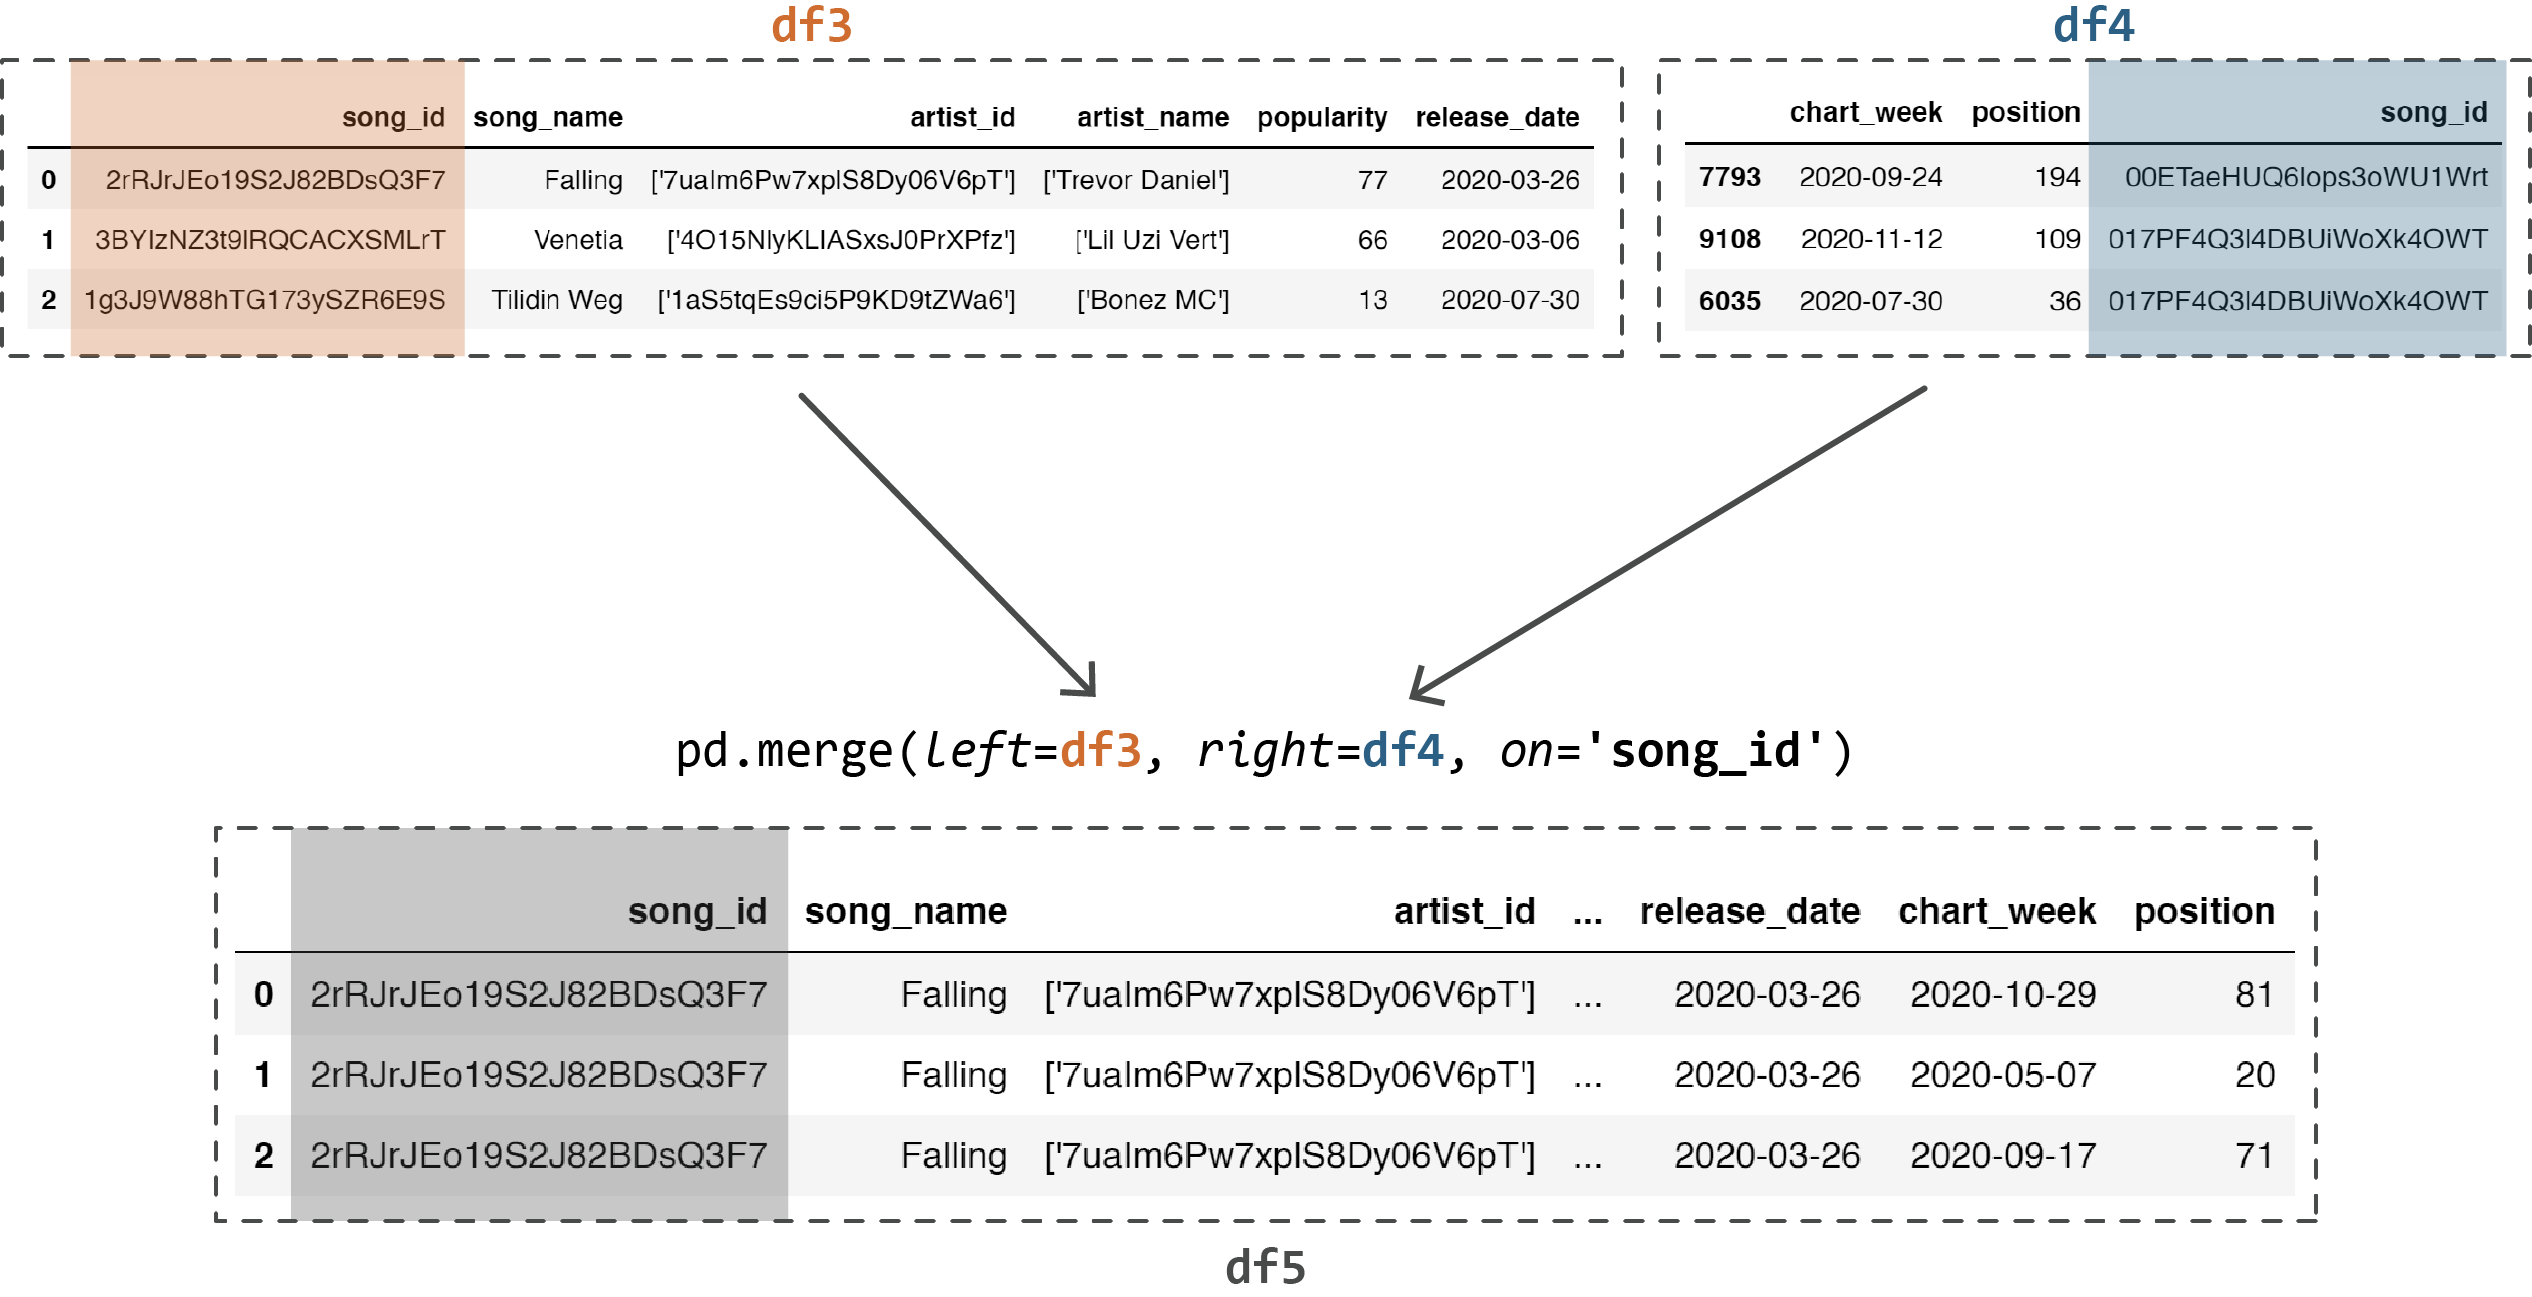

O resultado da junção é um único *DataFrame* que combina as informações das duas entradas; **porém**, ao contrário do exemplo anterior, as informações originais (i.e., do *DataFrame* `df3`) se repetem conforme exigido pelas entradas do *DataFrame* `df4`.

### Muitos-para-muitos (N:N)

Um relacionamento **muitos-para-muitos** ocorre quando vários registros em uma tabela são associados a vários registros em outra tabela (como mostrado na figura a seguir). 

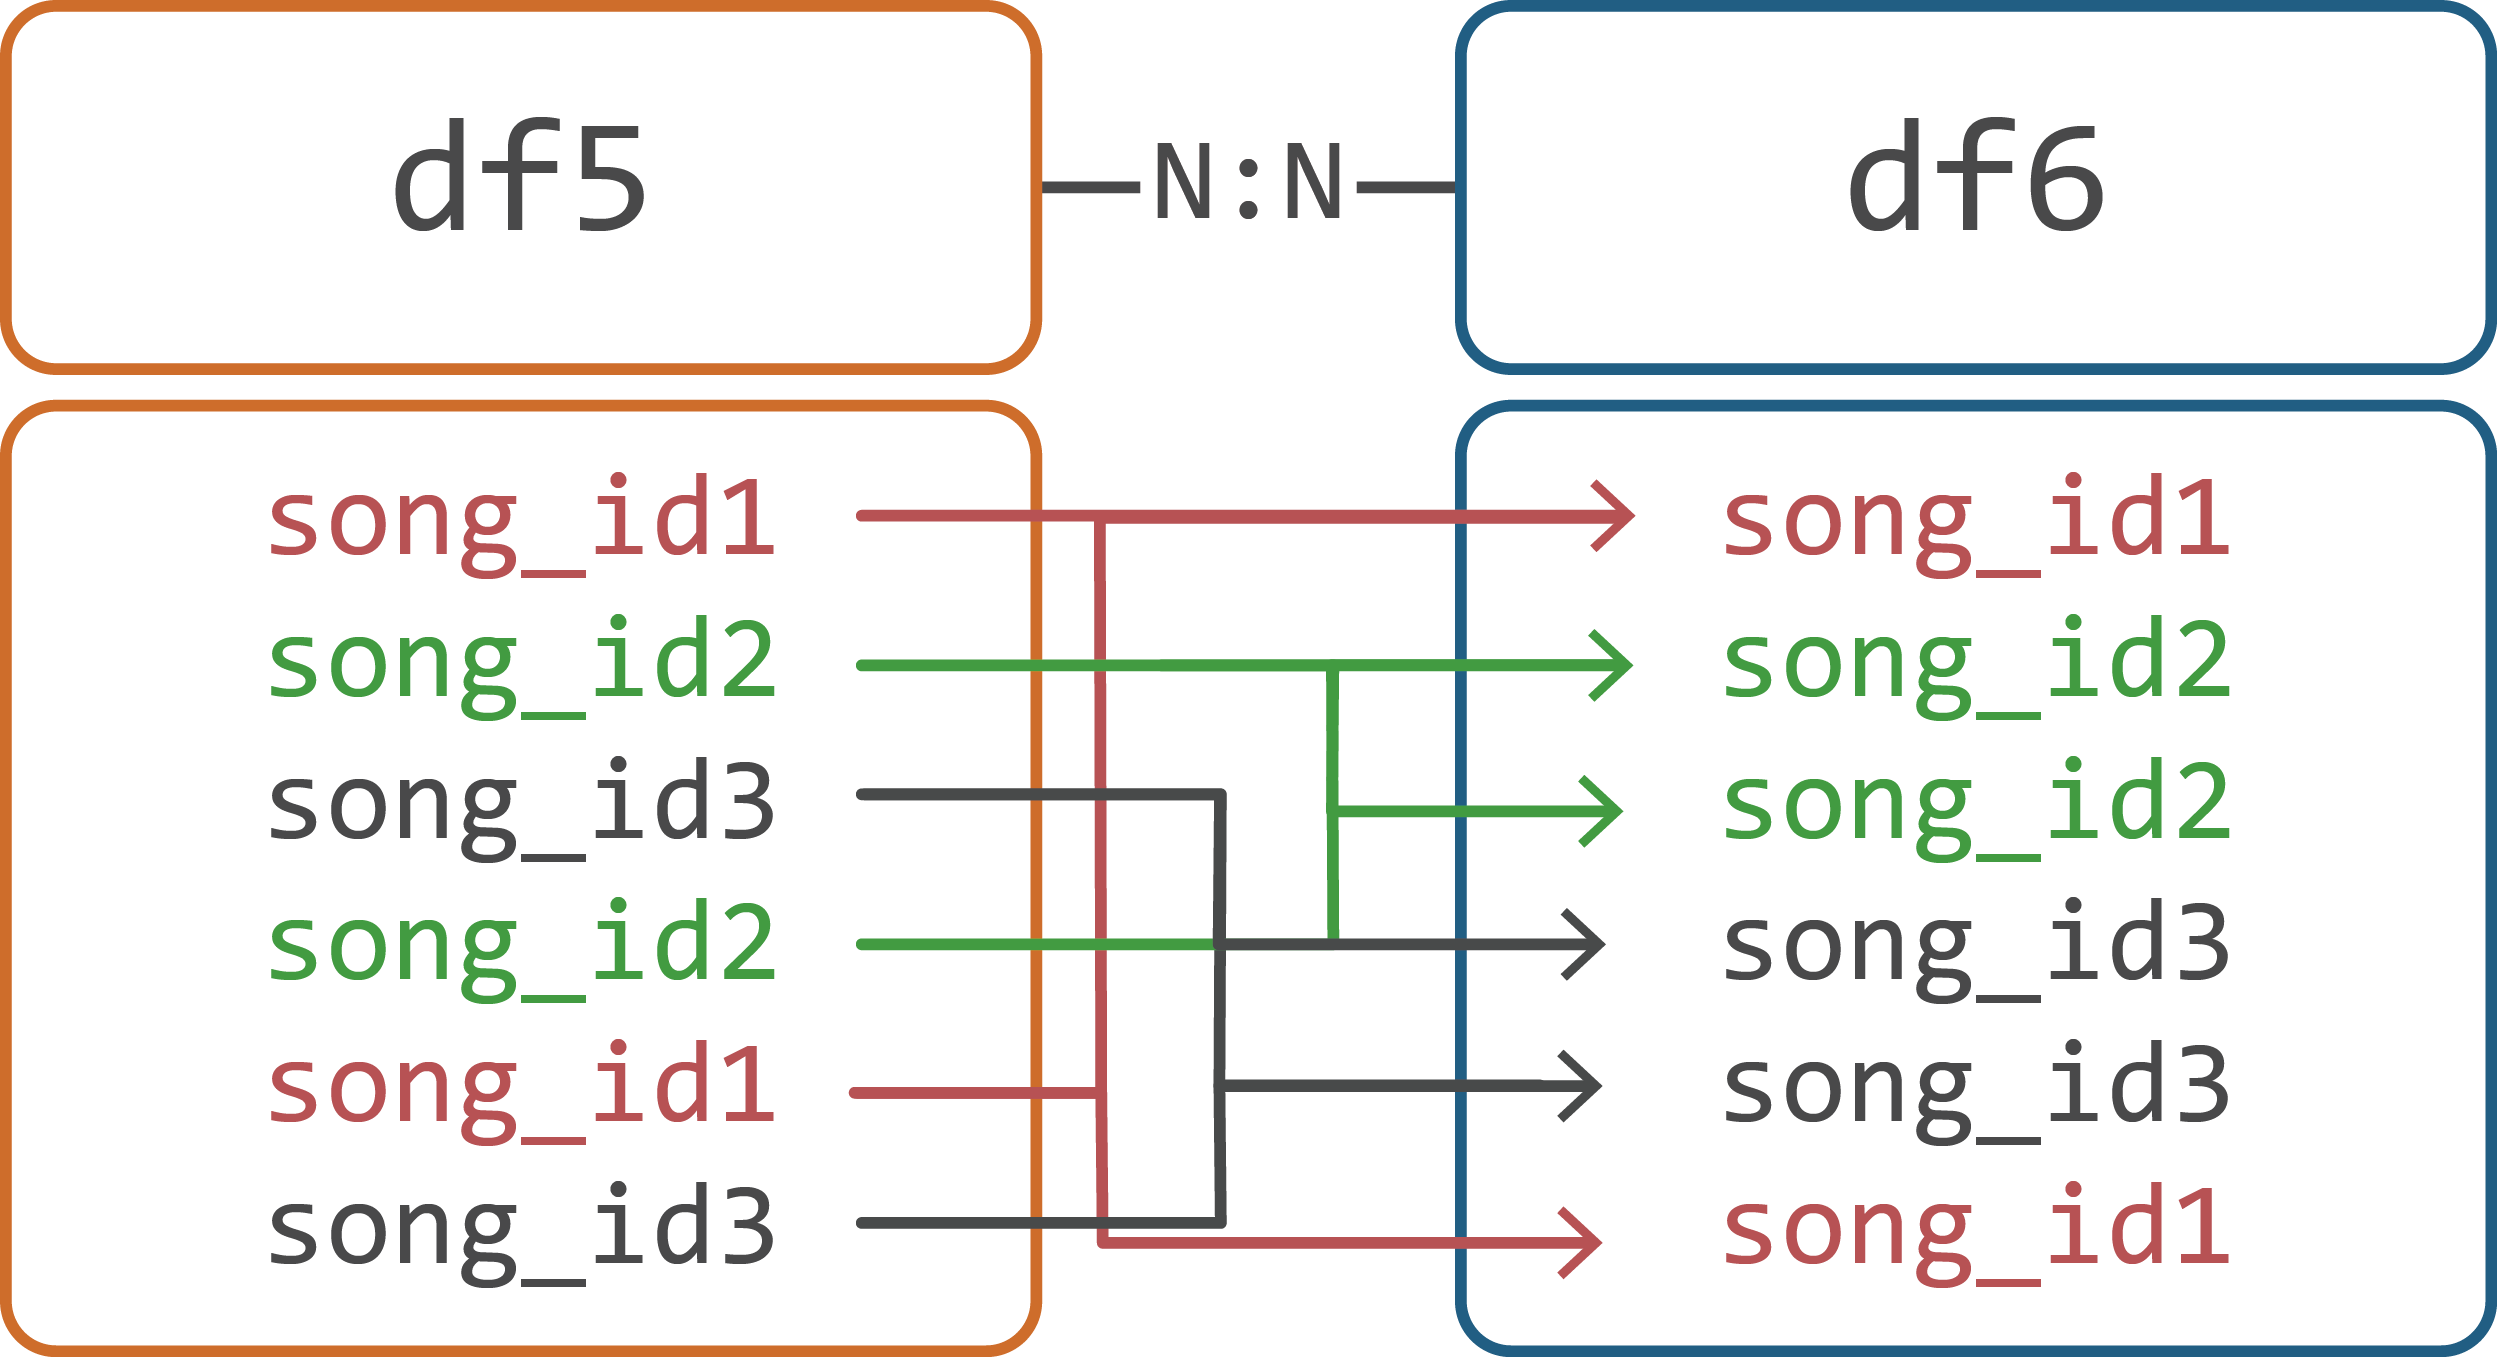

Para exemplificar, suponha que você precisa integrar as várias músicas da tabela resultante anterior (i.e., *DataFrame* `df5`) com outra tabela contendo o número total de *streams* que cada música atingiu nas semanas dos *Charts* (i.e., *DataFrame* `df6`). 

⚠️ **Observe** que em ambas as tabelas a **coluna-chave** `song_id` possui entradas repetidas. 

Quando isso acontece, ou seja, se a **coluna-chave** das duas tabelas incluir entradas duplicadas, o resultado é uma fusão **muitos-para-muitos**. 

In [9]:
# Lendo os dados
df6 = pd.read_table('../dataset/spotify_charts_complete.tsv',
    usecols=['chart_week', 'song_id', 'streams'], # seleciona campos específicos
    encoding='utf-8')
df6 = df6.sort_values(by=['song_id']) # ordena o DataFrame pelo id da música

display_side_by_side([df5.head(3), df6.head(3)], ['df5', 'df6']) # imprime as 3 primeiras linhas

Antes de prosseguirmos com a junção, note que as duas tabelas possuem em comum, além da coluna `song_id`, a coluna `chart_week`. Ou seja, neste exemplo, teremos duas **colunas-chave** para realizar a junção. 

In [10]:
# Associação muitos-para-muitos de dois DataFrames
df7 = pd.merge(left=df5, right=df6, on=['song_id', 'chart_week'])
df7.head(3)

song_id song_name                   artist_id  ...  \
0  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   
1  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   
2  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   

   chart_week  position   streams  
0  2020-10-29        81   7517622  
1  2020-05-07        20  16751384  
2  2020-09-17        71   7944403  

[3 rows x 9 columns]

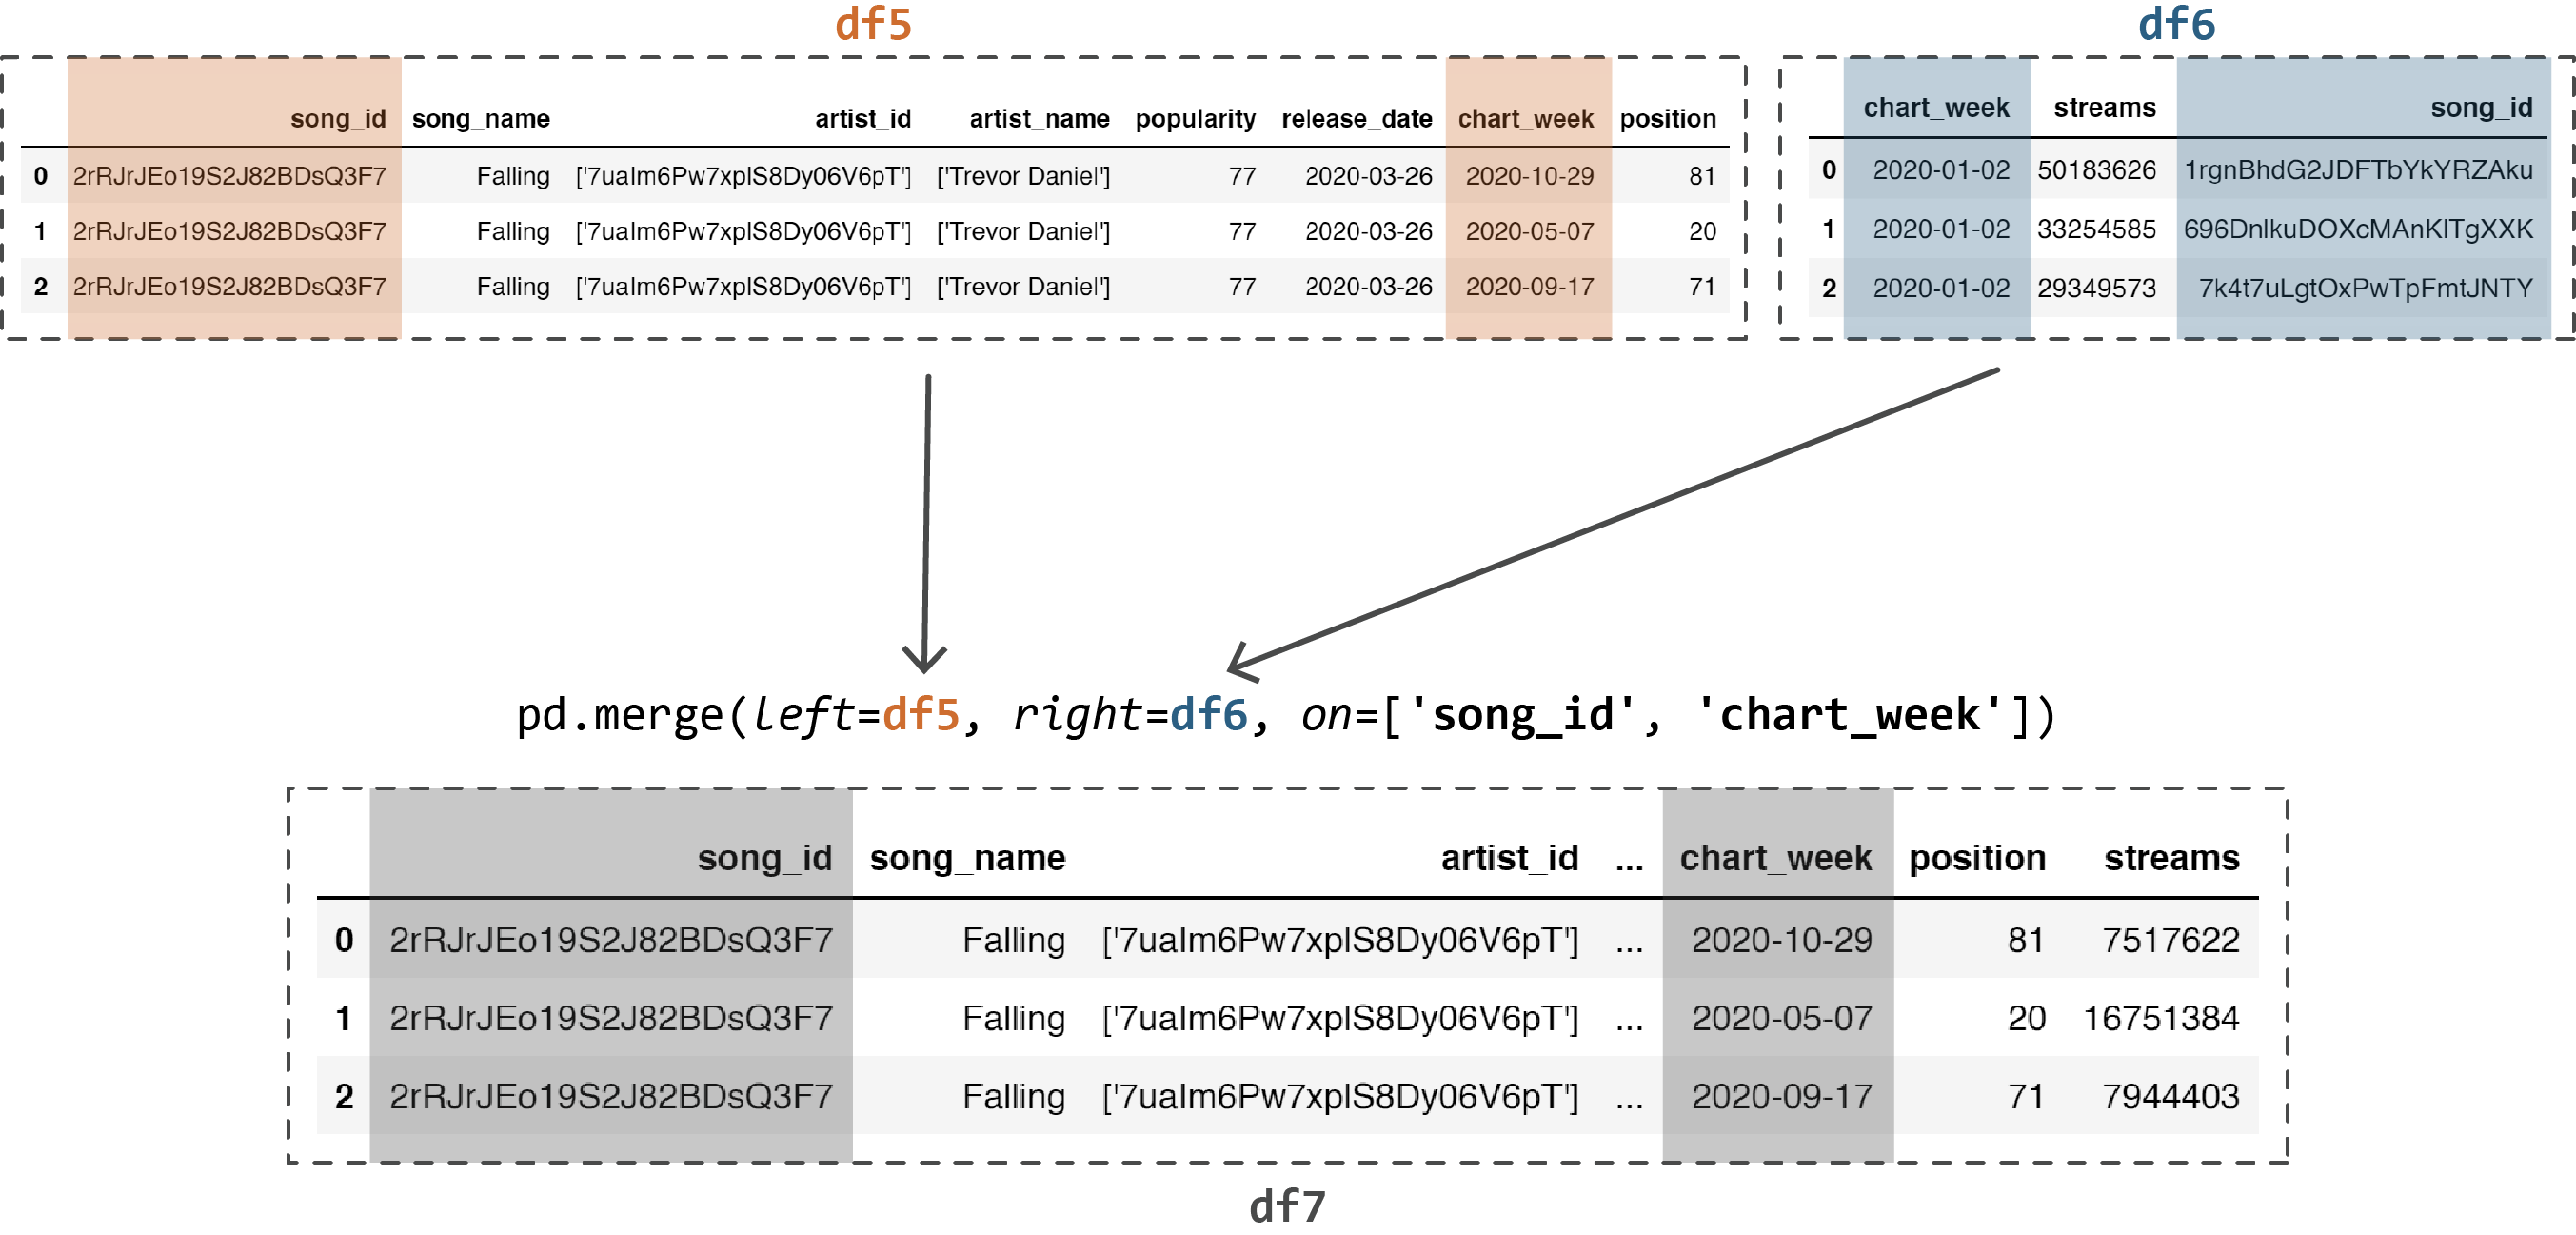

Após a junção **muitos-para-muitos**, a **coluna-chave** do *DataFrame* resultante será a combinação das **colunas-chave** de cada tabela. 

---
## VERIFICAÇÃO

Além dos parâmetros vistos anteriormente, a função `merge()` possui o argumento `validate` para verificar se a junção realizada é do tipo especificado. Os tipos disponíveis são:

* `one_to_one` ou `1:1`: verifica se as **chaves** são exclusivas nos conjuntos de dados esquerdo e direito.
* `one_to_many` ou `1:m`: verifica se as **chaves** são exclusivas no conjunto de dados esquerdo.
* `many_to_one` ou `m:1`: verifica se as **chaves** são exclusivas no conjunto de dados correto.
* `many_to_many` ou `m:m`: permitido, mas não resulta em verificações.

> **Vamos verificar se as integrações realizadas anteriormente estão corretas!** 👀

In [11]:
# Associação um-para-um
df3 = pd.merge(left=df1, right=df2, on='song_id', validate='one_to_one') # verificando
df3.head(3)

song_id    song_name                   artist_id  \
0  2rRJrJEo19S2J82BDsQ3F7      Falling  ['7uaIm6Pw7xplS8Dy06V6pT']   
1  3BYIzNZ3t9lRQCACXSMLrT      Venetia  ['4O15NlyKLIASxsJ0PrXPfz']   
2  1g3J9W88hTG173ySZR6E9S  Tilidin Weg  ['1aS5tqEs9ci5P9KD9tZWa6']   

         artist_name  popularity release_date  
0  ['Trevor Daniel']          77   2020-03-26  
1   ['Lil Uzi Vert']          66   2020-03-06  
2       ['Bonez MC']          13   2020-07-30

In [12]:
# Associação um-para-muitos
df5 = pd.merge(left=df3, right=df4, on='song_id', validate='one_to_many') # verificando
df5.head(3)

song_id song_name                   artist_id  ...  \
0  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   
1  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   
2  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   

  release_date  chart_week position  
0   2020-03-26  2020-10-29       81  
1   2020-03-26  2020-05-07       20  
2   2020-03-26  2020-09-17       71  

[3 rows x 8 columns]

In [13]:
# Associação muitos-para-muitos
df7 = pd.merge(left=df5, right=df6, on=['song_id','chart_week'], validate='many_to_many') # verificando
df7.head(3)

song_id song_name                   artist_id  ...  \
0  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   
1  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   
2  2rRJrJEo19S2J82BDsQ3F7   Falling  ['7uaIm6Pw7xplS8Dy06V6pT']  ...   

   chart_week  position   streams  
0  2020-10-29        81   7517622  
1  2020-05-07        20  16751384  
2  2020-09-17        71   7944403  

[3 rows x 9 columns]

**SIM!** Está tudo correto! ✔️

Se o tipo das associações das junções anteriores estivessem incorretas, ou seja, se a validação falhasse, a função geraria um `MergeError`.

> **Vamos fazer um exemplo teste?**

Vamos tentar unir as tabelas `df4` e `df5`, que possuem **chaves** duplicadas da **coluna-chave** `song_id`, utilizando a associação **um-para-muitos**.

In [15]:
# Testando uma validação incorreta
pd.merge(left=df4, right=df5, on='song_id', validate='one_to_many') # verificando

MergeError: ignored

Como esperado, a função lançou um `MergeError` indicando que o *DataFrame* da esquerda possui **chaves** duplicadas, o que não é aceitável em uma associação do tipo **um-para-muitos**.

---
## TIPOS DE JUNÇÕES

Além das associações, a função `merge()` disponibiliza quatro tipos de junções:

* `inner`: o tipo de junção *default* da função `merge()`, e se baseia na **interseção** de **chaves** de ambos os *DataFrames*
* `outer`: se baseia na **união** de **chaves** do *DataFrame* esquerdo e os registros correspondentes do *DataFrame* direito
* `left`: usa apenas as **chaves** do *DataFrame* esquerdo
* `right`: usa apenas as **chaves** do *DataFrame* direito

<br>
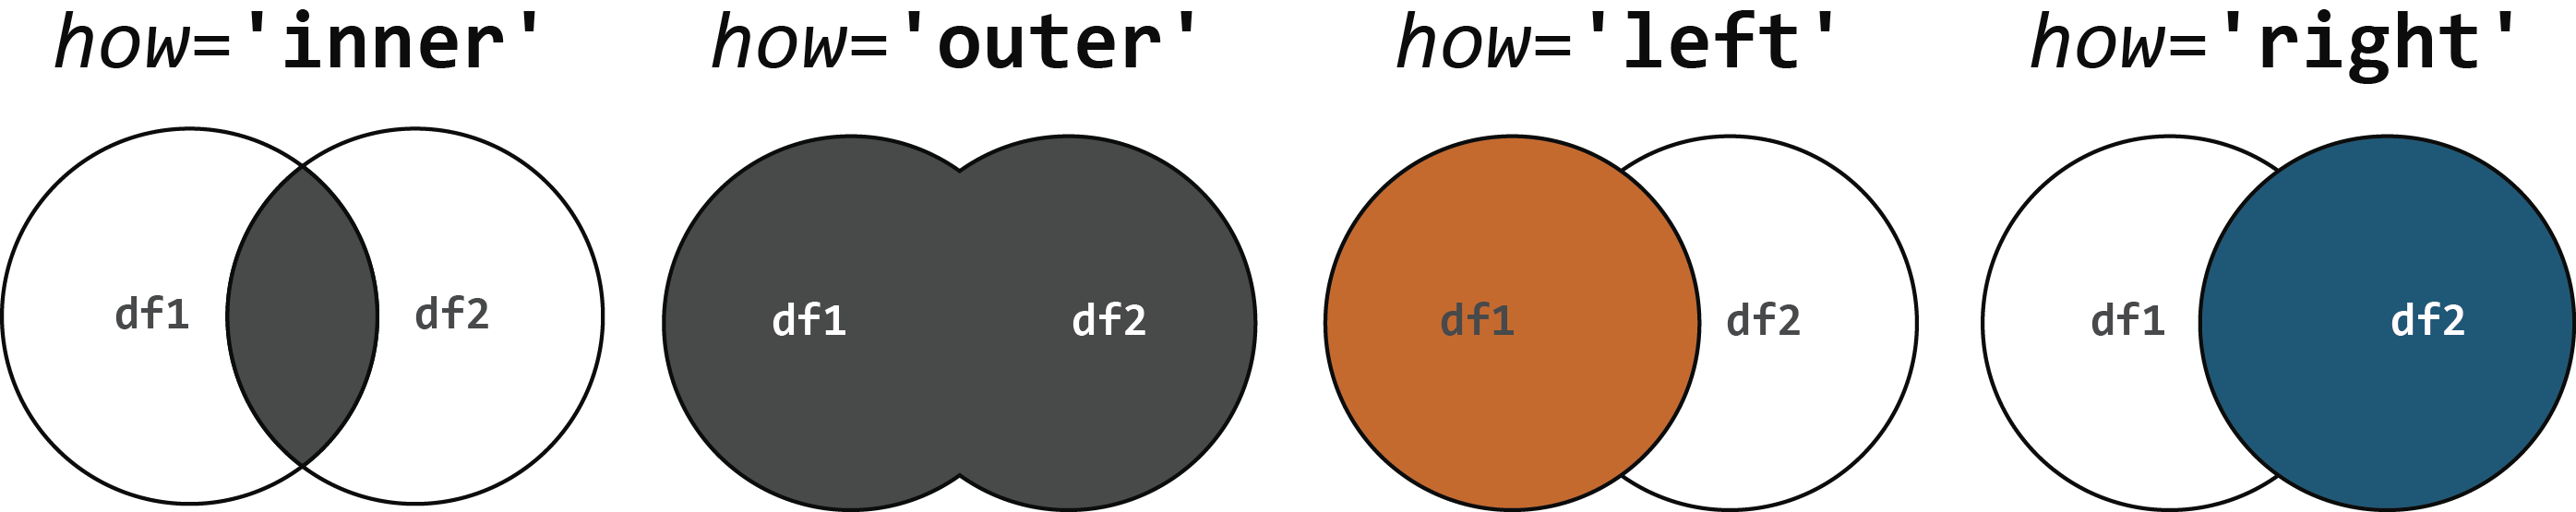
<br>

### EXEMPLO

Para entendermos melhor cada tipo de junção, vamos utilizar duas tabelas do nosso conjunto de dados nos exemplos a seguir.

In [16]:
# Lendo os dados
charts = pd.read_table('../dataset/spotify_charts_complete.tsv',
    usecols=['song_id', 'streams', 'position'], # seleciona campos específicos
    encoding='utf-8')
tracks = pd.read_table('../dataset/spotify_hits_dataset_complete.tsv',
    usecols=['song_id', 'song_name', 'artist_id', 'popularity', 'song_type'], # seleciona campos específicos
    encoding='utf-8')

display_side_by_side([charts.head(3), tracks.head(3)], ['Charts', 'Tracks'])

#### `inner`

Neste exemplo, vamos realizar um `inner join` entre a tabela `Tracks` e a tabela que armazena as músicas **#1** dos *Charts* do Spotify utilizando a função `merge()` com seus argumentos *default*.

Para isso, vamos criar a segunda tabela primeiro:

In [17]:
# Criando a tabela #1 Hits
top_one_hits = charts[charts['position'] == 1] # selecionando apenas as músicas com posição 1
top_one_hits.head()

position   streams                 song_id
0           1  50183626  1rgnBhdG2JDFTbYkYRZAku
200         1  50241241  1rgnBhdG2JDFTbYkYRZAku
400         1  52055226  1rgnBhdG2JDFTbYkYRZAku
600         1  50409214  1rgnBhdG2JDFTbYkYRZAku
800         1  48870726  1rgnBhdG2JDFTbYkYRZAku

Agora, podemos prosseguir para a junção:

In [18]:
# inner join, utilizando os parâmetros default
inner_merged = pd.merge(tracks, top_one_hits) 
inner_merged.head()

song_id        song_name                   artist_id  ...  \
0  0VjIjW4GlUZAMYd2vXMi3b  Blinding Lights  ['1Xyo4u8uXC1ZmMpatF05PJ']  ...   
1  0VjIjW4GlUZAMYd2vXMi3b  Blinding Lights  ['1Xyo4u8uXC1ZmMpatF05PJ']  ...   
2  0VjIjW4GlUZAMYd2vXMi3b  Blinding Lights  ['1Xyo4u8uXC1ZmMpatF05PJ']  ...   
3  0VjIjW4GlUZAMYd2vXMi3b  Blinding Lights  ['1Xyo4u8uXC1ZmMpatF05PJ']  ...   
4  0VjIjW4GlUZAMYd2vXMi3b  Blinding Lights  ['1Xyo4u8uXC1ZmMpatF05PJ']  ...   

   song_type position   streams  
0       Solo        1  52375259  
1       Solo        1  46779503  
2       Solo        1  45847200  
3       Solo        1  43296504  
4       Solo        1  42335028  

[5 rows x 7 columns]

Como resultado, a junção mantém apenas as linhas que estão presentes na **coluna-chave** dos dois *DataFrames*.

Para verificar se a junção deu certo, dado que todas as músicas da tabela `Tracks` estão presentes da tabela `Charts`, nós podemos comparar o número total de linhas do *DataFrame* resultante (`inner_merged`) com o número total de linhas do menor *DataFrame* da junção. 

In [19]:
# Calculando o tamanho das tabelas usadas na junção
print(len(tracks))
print(len(top_one_hits))

1284
52


No nosso caso, a tabela `top_one_hits` é a menor. Portanto, o *DataFrame* resultante precisa ter o mesmo número de linhas:

In [20]:
# Verificando se o tamanho das tabelas são iguais
if (len(inner_merged) == len(top_one_hits)):
    print("✔️")
else:
    print("❌")

✔️


#### `outer`

Neste exemplo, vamos realizar um `outer join` entre a tabela `Charts` e a tabela `top_one_hits` utilizando a função `merge()` com o parâmetro `how`:

In [28]:
# Visualizando as duas tabelas
display_side_by_side([charts.head(3), top_one_hits.head(3)], ['Charts', '#1 Hits'])

In [29]:
# outer join
outer_merged = pd.merge(charts, top_one_hits, how="outer")
outer_merged.head()

position   streams                 song_id
0         1  50183626  1rgnBhdG2JDFTbYkYRZAku
1         2  33254585  696DnlkuDOXcMAnKlTgXXK
2         3  29349573  7k4t7uLgtOxPwTpFmtJNTY
3         4  26067853  2b8fOow8UzyDFAE27YhOZM
4         5  25901488  4TnjEaWOeW0eKTKIEvJyCa

⚠️ **OBSERVAÇÃO!** Como foi mostrado na figura anterior, em um `outer join`, todas as linhas de ambos os *DataFrames* estarão presentes no *DataFrame* final. Portanto, neste exemplo, após a junção, teríamos que ter exatamente as mesmas linhas da tabela `Charts`, já que a tabela `top_one_hits` é um subconjunto da mesma.

Utilizando a função `equals` do *pandas*, podemos verificar se os dois *DataFrames* contêm os mesmos elementos:

In [30]:
# Verificando se dois objetos contêm os mesmos elementos
if (charts.equals(outer_merged)):
    print("✔️")
else:
    print("❌")

✔️


#### `left` / `right`

Neste exemplo, vamos realizar apenas um `left join`, dado que um `right join` seguiria os mesmo passos, porém considerando o *DataFrame da direita*.

Aqui, nós vamos realizar a junção entre a tabela `top_one_hits` e a tabela `Tracks` utilizando a função `merge()` com o parâmetro `how`:

In [31]:
# Visualizando as duas tabelas
display_side_by_side([top_one_hits.head(3), tracks.head(3)], ['#1 Hits', 'Tracks'])

In [32]:
# left join
left_merged = pd.merge(top_one_hits, tracks, how="left")
left_merged.head()

position   streams                 song_id  ...  \
0         1  50183626  1rgnBhdG2JDFTbYkYRZAku  ...   
1         1  50241241  1rgnBhdG2JDFTbYkYRZAku  ...   
2         1  52055226  1rgnBhdG2JDFTbYkYRZAku  ...   
3         1  50409214  1rgnBhdG2JDFTbYkYRZAku  ...   
4         1  48870726  1rgnBhdG2JDFTbYkYRZAku  ...   

                    artist_id popularity  song_type  
0  ['2NjfBq1NflQcKSeiDooVjY']         69       Solo  
1  ['2NjfBq1NflQcKSeiDooVjY']         69       Solo  
2  ['2NjfBq1NflQcKSeiDooVjY']         69       Solo  
3  ['2NjfBq1NflQcKSeiDooVjY']         69       Solo  
4  ['2NjfBq1NflQcKSeiDooVjY']         69       Solo  

[5 rows x 7 columns]

O resultado da junção é um *DataFrame* contendo todos os **#1** *hits* dos *Charts* do Spotify e suas informações básicas.

A partir desse resultado, poderíamos, por exemplo, verificar o intervalo do *score* de popularidade de tais músicas:

In [33]:
left_merged.popularity.value_counts() # verificando os scores de popularidade únicos

96    9
90    8
69    7
91    7
95    5
29    4
93    4
83    2
87    2
88    1
82    1
47    1
74    1
Name: popularity, dtype: int64

In [34]:
left_merged.popularity.mean() # verificando a média das popularidades

82.65384615384616

Podemos ver que, no geral, o score da popularidade de tais músicas é bem alta, com uma média de 82!

### Conclusão

Este notebook apresentou como fazer a integração de dados de diferentes fontes aplicando a função `merge()` da biblioteca *pandas*. 

🔎 **Se interessou?** Dê uma olhada na documentação do *pandas* para informações extras sobre integração de dados:
[Merging with *pandas*](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)

---

O próximo notebook ([4.2.Transformacao.ipynb](https://drive.google.com/file/d/1GlYoq9fYWiv1Zi_s6NnwAA9peilL0AZx/view?usp=sharing)) apresenta como transformar dados de diferentes formatos em formatos mais amigáveis para modelos e algoritmos de Aprendizado de Máquina.